
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Dean Webb - Vehicle Detection & Tracking Pipeline

In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Project Goals:
----

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

##  Load Dataset and Preproceses Images

### Imports

In [159]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

### Constants

In [289]:
## Dataset Parameters ##
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
PROJECT_SOURCE_URL = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking'
VEHICLES_ZIPFILE = 'vehicles.zip'
NONVEHICLES_ZIPFILE = 'non-vehicles.zip'


## Udacity Dataset Extraction Parameters ##
LABELS_CSV = 'data/object-detection-crowdai/labels.csv'
UDACITY_SOURCE_URL = 'http://bit.ly/udacity-annoations-crowdai'
DATASET_ZIPFILE = 'object-detection-crowdai.tar.gz'
UDACITY_DATASET_DIRECTORY = 'udacity-set'
APPEND_UDACITY_DATASET = True
UDACITY_AUGMENT_PCT = 0.15

## Image Processing ##
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
if DEFAULT_DEPTH > 1:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
else:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH)

## Feature Extraction Parameters ##
# Spatial Binning
SPATIAL = 32
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = 128
COLOR_SPACE = 'HSV'
# HOG Parameters
HOG_ORIENTATIONS = 12
HOG_PIXELS_PER_CELL = 10
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"
SW_SPATIAL_FEAT_FLAG = True
SW_HOG_FEAT_FLAG = True
SW_COLOR_HIST_FEAT_FLAG = True

## Training Parameters ##
# SVC Parameters
VALIDATION_PORTION = .3
N_PREDICTIONS = 100
OVERWRITE_DATACACHE = True

### Download and Preprocess Udacity Dataset

In [5]:
def maybe_download(source_url, filename):
    if not os.path.exists(WORKING_DIRECTORY):
        os.mkdir(WORKING_DIRECTORY)
    
    filepath = os.path.join(WORKING_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [151]:
def unzip_file(zip_file, source_dir_name=None, destination=WORKING_DIRECTORY):
    if 'tar.gz' in zip_file:
        head, tail = os.path.splitext(zip_file)
        if not os.path.exists(os.path.join(os.path.splitext(head)[0])):
            print('unzipping file:', zip_file, 'to directory:', os.path.join( os.path.splitext(head)[0]))
            tar = tarfile.open(zip_file, "r:*")
            tar.extractall(destination)
            tar.close()
    else: #.zip extension
        head, tail = os.path.splitext(zip_file)
        #print('Target Dir', os.path.join(destination, head))
        if not os.path.exists(os.path.join(destination, head)):
            print('File does not exist: ', os.path.join(destination, head), ': Extracting')
            zipf = zf.ZipFile(os.path.join(WORKING_DIRECTORY,zip_file))
            print('Loaded zipf',zipf, ': Extracting')
            zipf.extractall(os.path.join(destination, head))
            zipf.close()

In [7]:
## Download and Extract Training Datasets
# Create Training Set Directories
## Project Datasets
vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,VEHICLES_ZIPFILE), VEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

non_vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,NONVEHICLES_ZIPFILE), NONVEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(non_vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

## Udacity Dataset
tar_file = maybe_download(UDACITY_SOURCE_URL, DATASET_ZIPFILE)
unzip_file(tar_file)

cars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(cars_dir, exist_ok=True)
noncars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'non-vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(os.path.join(noncars_dir, 'skies'), exist_ok=True)
os.makedirs(os.path.join(noncars_dir, 'roads'), exist_ok=True)

Target Dir data/training_set/vehicles
Target Dir data/training_set/non-vehicles


In [8]:
## Extract Labels ##
HEADER_ROW=['xstart', 'ystart', 'xstop', 'ystop', 'frame', 'label', 'preview_url']
annotations = pd.read_csv(LABELS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

xstart  ystart  xstop  ystop                    frame  label  \
0     785     533    905    644  1479498371963069978.jpg    Car   
1      89     551    291    680  1479498371963069978.jpg    Car   
2     268     546    383    650  1479498371963069978.jpg    Car   
3     455     522    548    615  1479498371963069978.jpg  Truck   
4     548     522    625    605  1479498371963069978.jpg  Truck   

                                         preview_url  
0  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
1  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
2  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
3  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
4  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...

In [158]:
def extract_and_preprocess_image(filepath, cars_dir, noncars_dir, xstart, ystart, xstop, ystop,
                                 img_size=(DEFAULT_LENGTH, DEFAULT_WIDTH), img_ext = '.png'):
    full_path = os.path.join(WORKING_DIRECTORY, 'object-detection-crowdai', filepath)
    # Image read in from cv2 + .jpg -> (0 to 1)
    if os.path.exists(full_path):
        # Use cv2 to open image and extract bounding boxes
        img = cv2.imread(full_path)
        # Scale to 0-255 and convert to uint8
        scaled_img = np.uint8(np.copy(img))
        scaled_img = cv2.cvtColor(scaled_img,cv2.COLOR_BGR2RGB)
        img_shape = img.shape
            
        # boxed_img = im[y:y+h,x:x+w]
        # Extract Car Image. Note: numpy arrays are (row, col)!
        car_img = scaled_img[ystart:ystop, xstart:xstop]
        resized_car_img = cv2.resize(car_img, img_size, interpolation=cv2.INTER_AREA)
        im = Image.fromarray(resized_car_img)
        # Save Car Image to corresponding Directory
        filename, ext = os.path.splitext(filepath)
        new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', xstart, ystart, xstop, ystop, img_ext)
        im.save(os.path.join(cars_dir, new_filename)) # Save as .png
        im.close
        
        # Auto-Generate a 'Non-Car' Image to keep dataset balanced
        i_lrc = np.random.randint(3) # 66% chance of auto generating non-car features
        if (i_lrc == 0):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, \
                                                    (0 if ystart-(ystop-ystart) < 0 else ystart-(ystop-ystart)), xstop, ystart
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'sky', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir,'skies', new_filename)
        elif (i_lrc == 1):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, ystop, xstop, \
                                                    (img_shape[0] if ystop+(ystop-ystart) > img_shape[0] else ystop+(ystop-ystart))
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'road', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir, 'roads', new_filename)
            
        noncar_img = scaled_img[ystart_mod:ystop_mod, xstart_mod:xstop_mod]
        resized_noncar_img = cv2.resize(noncar_img, img_size, interpolation=cv2.INTER_AREA)
        # Save noncar image to corresponding Directory
        im = Image.fromarray(resized_noncar_img)
        filename, ext = os.path.splitext(filepath)
        im.save(path_file) # Save as .png
        im.close

In [32]:
## Extract Labels ##      
for label in annotations.as_matrix():
    filename, ext = os.path.splitext(label[4])
    new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', label[0], label[1], label[2], label[3], '.png')
    if not os.path.exists(os.path.join(cars_dir, new_filename)) and label[5].lower() == 'car':
        try:
            extract_and_preprocess_image(label[4], cars_dir, noncars_dir, xstart=label[0], ystart=label[1],
                                     xstop=label[2], ystop=label[3])
        except:
            print("Error extracting label:", label, " Moving on..")

Error extracting label: [912 0 951 0 '1479498564477313399.jpg' 'Car'
 'http://crowdai.com/images/k-zz9yqpJIit7OuX/visualize']  Moving on..
Error extracting label: [705 0 732 0 '1479498820473341507.jpg' 'Car'
 'http://crowdai.com/images/Ng_nd_wBlqkgNDGb/visualize']  Moving on..
Error extracting label: [721 0 751 0 '1479499937073018706.jpg' 'Car'
 'http://crowdai.com/images/sbjD-93YWUi9hJ0c/visualize']  Moving on..


## Extract Features from Dataset

### Helper Functions

In [162]:
# Define a function to compute binned color features  
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3)) 


In [163]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [348]:
# Define a function to return HOG features and visualization --
def get_hog_features(img, orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL,
                     cell_per_block=HOG_CELLS_PER_BLOCK, vis=False, feature_vec=True):      
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [415]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS):
    #print("extract features parameters: COLOR_SPACE, BIN_SPATIAL_SIZE, HIST_NBINS",COLOR_SPACE, BIN_SPATIAL_SIZE, HIST_NBINS)
    # Create a list to append feature vectors
    features = []
    for file in imgs:       
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Need to convert to RGB
        # Image read in from cv2 + .png -> (0 to 255) scaled
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = np.copy(img)
        hog_shape = np.asarray(hog_image.shape)
        if HOG_CHANNEL == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,HOG_CHANNEL])
        
        # Append the new feature vector to the features list
        # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
        if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((spatial_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((spatial_features, hist_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((hist_features)))
        else:
            features.append(np.concatenate(feature_image))
        
    # Return list of feature vectors
    return features

### Begin Training Pipeline

In [416]:
## Starting Training Pipeline ##
# Load Image Paths 
images = glob.glob(dataset_path, recursive=True)
cars = []
notcars = []
udacity_cars = []
udacity_notcars = []
for image in images:
    if UDACITY_DATASET_DIRECTORY in image:
        if NON_VEHICLES_TOKEN in image:
            udacity_notcars.append(image)
        else:
            udacity_cars.append(image)
    else:
        if NON_VEHICLES_TOKEN in image:
            notcars.append(image)
        else:
            cars.append(image)

assert len(images) == len(cars) + len(notcars) + len(udacity_cars) + len(udacity_notcars), 'The subarrays have not split the dataset correctly.'
print('Number of Vehicle Images Found:',len(cars))
print('Number of Non-Vehicle Images Found:',len(notcars))
    
if APPEND_UDACITY_DATASET == True: #Using to Keep Dataset separate
    udacity_augment_size = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    ind = np.random.random_integers(0, len(udacity_cars)-1, udacity_augment_size)
    cars.extend(list(udacity_cars[ind]))
    ind = np.random.random_integers(0, len(udacity_notcars)-1, udacity_augment_size)
    notcars.extend(list(udacity_notcars[ind]))
else:
    num_udacity_features = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    udacity_features_ind = np.random.random_integers(0, len(udacity_cars), num_udacity_features)
    udacity_cars = list(udacity_cars[udacity_features_ind])
    udacity_features_ind = np.random.random_integers(0, len(udacity_notcars), num_udacity_features)
    udacity_notcars = list(udacity_notcars[udacity_features_ind])
    
    
print('Number of Udacity Vehicle Images Found:',len(udacity_cars))
print('Number of Udacity Non-Vehicle Images Found:',len(udacity_notcars))
print('')
print('Size of Vehicle Images Dataset:',len(cars))
print('Size of Non-Vehicle Images Dataset:',len(notcars))

Number of Vehicle Images Found: 8792
Number of Non-Vehicle Images Found: 8968
Number of Udacity Vehicle Images Found: 62567
Number of Udacity Non-Vehicle Images Found: 63997

Size of Vehicle Images Dataset: 18177
Size of Non-Vehicle Images Dataset: 18353


Feature Vector size for Cars: 7056
Using Spatial Binning of: 32 and 128 histogram bins


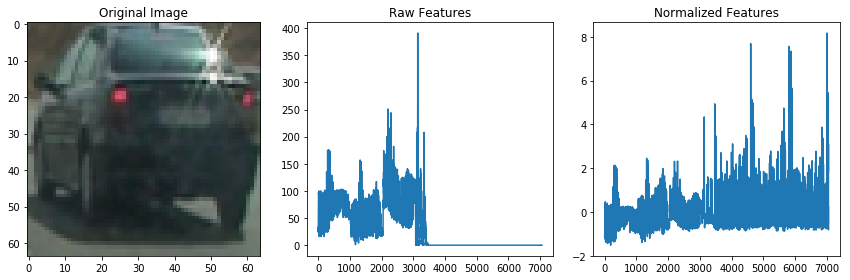

In [417]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Seperately Extract Feature from Udacity Dataset
if APPEND_UDACITY_DATASET == False:
    udacity_car_features = extract_features(udacity_cars)
    udacity_notcar_features = extract_features(udacity_notcars)
    
# Create an array stack of feature vectors
X = np.vstack((np.array(car_features), np.array(notcar_features))).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using Spatial Binning of:',BIN_SPATIAL_SIZE[0],
    'and', HIST_NBINS,'histogram bins')

In [418]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

[  6.30000000e+01   6.10000000e+01   6.60000000e+01 ...,   9.81430333e-03
   2.54084154e-02   4.85446995e-02]


In [419]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=VALIDATION_PORTION, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 7056


### Train using  Support Vector Classifier

In [420]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = N_PREDICTIONS
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

73.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9408
SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.
  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.
  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.]
For these 100 labels:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.
  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.
  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.]
0.01899 Seconds to predict 100 labels with SVC


In [421]:
#Save Support Vector Classifier to Datacache
def save_to_datacache(support_vector_classifier, datacache_dir=DATACACHE_DIRECTORY, 
                      override_datacache=OVERWRITE_DATACACHE):
    os.makedirs(datacache_dir, exist_ok=True)
    svc_pickle = os.path.join(datacache_dir,"svc_pickle.p")
    if override_datacache or not os.path.exists(svc_pickle): 
        svc_hyperparameters = {'svc': svc,
                               'X_scaler':X_scaler,
                               'SPATIAL': SPATIAL, 
                               'HIST_NBINS': HIST_NBINS,
                               'COLOR_SPACE': COLOR_SPACE,
                               'HOG_ORIENTATIONS': HOG_ORIENTATIONS,
                               'HOG_PIXELS_PER_CELL': HOG_PIXELS_PER_CELL,
                               'HOG_CELLS_PER_BLOCK': HOG_CELLS_PER_BLOCK,
                               'HOG_CHANNEL': HOG_CHANNEL,
                               'SW_SPATIAL_FEAT_FLAG': SW_SPATIAL_FEAT_FLAG,
                               'SW_HOG_FEAT_FLAG': SW_HOG_FEAT_FLAG,
                               'SW_COLOR_HIST_FEAT_FLAG': SW_COLOR_HIST_FEAT_FLAG
                              }

        pickle.dump(svc_hyperparameters, open(svc_pickle, "wb"))
    
# Save classifier and parameters to datacache directory  
save_to_datacache(svc)

# Vehicle Detection and Tracking

### Re-Initialize Imports

In [422]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

### Re-initialize Constants from Pickle File

In [423]:
## Directories ##
WORKING_DIRECTORY = 'data/'
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
svc_pickle = os.path.join(DATACACHE_DIRECTORY,"svc_pickle.p")
TESTING_DATASET_DIRECTORY = 'testing_dataset/'
TESTING_PIPELINE_SETUP_DIR= 'test_images/'
testset_path = "{}{}{}".format(WORKING_DIRECTORY, TESTING_PIPELINE_SETUP_DIR, '*.jpg')
with open(svc_pickle, mode='rb') as f:
    svc_hyperparameters = pickle.load(f)
    
## Feature Extraction Parameters ##
SVC = svc_hyperparameters['svc']
X_SCALER = svc_hyperparameters['X_scaler']
# Spatial Binning
SW_SPATIAL_FEAT_FLAG = svc_hyperparameters['SW_SPATIAL_FEAT_FLAG'] 
SPATIAL = svc_hyperparameters['SPATIAL']
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
SW_COLOR_HIST_FEAT_FLAG = svc_hyperparameters['SW_COLOR_HIST_FEAT_FLAG']
HIST_NBINS = svc_hyperparameters['HIST_NBINS']
COLOR_SPACE = svc_hyperparameters['COLOR_SPACE']
# HOG Parameters
SW_HOG_FEAT_FLAG = svc_hyperparameters['SW_HOG_FEAT_FLAG']
HOG_ORIENTATIONS = svc_hyperparameters['HOG_ORIENTATIONS']
HOG_PIXELS_PER_CELL = svc_hyperparameters['HOG_PIXELS_PER_CELL']
HOG_CELLS_PER_BLOCK = svc_hyperparameters['HOG_CELLS_PER_BLOCK']
HOG_CHANNEL = svc_hyperparameters['HOG_CHANNEL']

## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(None, None), (None, None)]
SW_YSTART_STOPS = [(384, 640), (384, None)]
SW_XY_WINDOWS = [(64, 64), (96,96),(128,64)]
SW_XY_OVERLAPS = [(0.50, 0.50),(.50,.50),(.50,.50)] 

## Vehicle Detection Parameters ##
BBOX_COLOR = (0, 0, 255)
BBOX_THICK = 6

## Explore Detection Technique (1) - Sliding Windows 

In [424]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=BBOX_COLOR, thick=BBOX_THICK):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [425]:
# Define a wrapper function for passing in a list of slidw_window parameters
def slide_windows(img, x_start_stops=[[None, None]],
                  y_start_stops=[[None, None]],
                  xy_windows=[(64, 64)],
                  xy_overlaps=[(0.5, 0.5)]):
    windows = []
    for i in range(len(x_start_stops)):
        if len(x_start_stops) == len(xy_windows) and len(x_start_stops) == len(xy_overlaps):
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[i]), np.asarray(xy_overlaps[i]))
        else:
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[0]), np.asarray(xy_overlaps[0]))
    return windows

In [426]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None],
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    window_list=[]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None or x_start_stop[1] >= img.shape[1]:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None or y_start_stop[1] >= img.shape[0]:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [427]:
#Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [441]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space=COLOR_SPACE, 
                        spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS, 
                        orient=HOG_ORIENTATIONS, 
                        pix_per_cell=HOG_PIXELS_PER_CELL, 
                        cell_per_block=HOG_CELLS_PER_BLOCK,
                        hog_channel=HOG_CHANNEL, 
                        spatial_feat=SW_SPATIAL_FEAT_FLAG,
                        hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                        hog_feat=SW_HOG_FEAT_FLAG):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    # Scale Image for feature extraction?
    #feature_image = feature_image.astype(np.float64)
    #feature_image = np.float64(np.copy(feature_image))
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [442]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svc=SVC, 
                   X_scaler=X_SCALER, 
                   color_space=COLOR_SPACE, 
                   spatial_size=BIN_SPATIAL_SIZE, 
                   hist_bins=HIST_NBINS, 
                   orient=HOG_ORIENTATIONS, 
                   pix_per_cell=HOG_PIXELS_PER_CELL, 
                   cell_per_block=HOG_CELLS_PER_BLOCK, 
                   hog_channel=HOG_CHANNEL, 
                   spatial_feat=SW_SPATIAL_FEAT_FLAG, 
                   hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                   hog_feat=SW_HOG_FEAT_FLAG):
            
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    heatmap = np.zeros_like(img[:,:,0])    
    #2) Iterate over all windows in the list
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
                              (DEFAULT_LENGTH, DEFAULT_WIDTH)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(list(np.array(features).reshape(1, -1)))
        #6) Predict using classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1: # Car detected
            on_windows.append(window)
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] +=1

    #8) Return windows for positive detections
    return on_windows, heatmap
    

In [443]:
# Try Scaling Windows on Test Images
image_paths = glob.glob(testset_path, recursive=True)
print('Found',len(image_paths),'images in directory:', testset_path)

Found 6 images in directory: data/test_images/*.jpg


In [444]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_single_frame_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for label in labels:
        for car_number in range(1, label[1] + 1):
            #Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            #Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            #Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICK)
        # Return the image
    return img

BBoxes Found: 35
1.6631548404693604 seconds to process one image search 351 windows
BBoxes Found: 29
1.6715404987335205 seconds to process one image search 351 windows
BBoxes Found: 21
1.6616904735565186 seconds to process one image search 351 windows
BBoxes Found: 14
1.6500797271728516 seconds to process one image search 351 windows
BBoxes Found: 26
1.6813762187957764 seconds to process one image search 351 windows
BBoxes Found: 15
1.6498217582702637 seconds to process one image search 351 windows


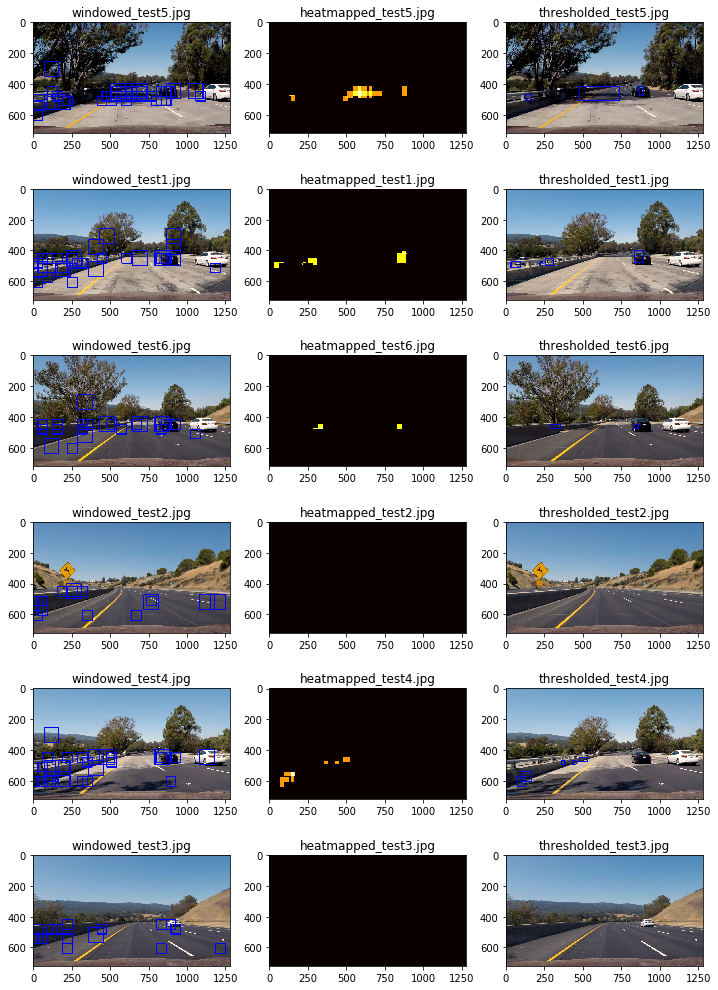

In [449]:
# Define a single function that can extract features using sliding windows and make predictions
carslist = []
out_images = []
out_titles = []

for img_path in image_paths:
    t1 = time.time()
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_shape = img.shape
    draw_img = np.copy(rgb_img)
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    threshold = 2
    filename = os.path.split(img_path)[-1]
    
    windows = slide_windows(rgb_img, x_start_stops=SW_XSTART_STOPS, 
                              y_start_stops=SW_YSTART_STOPS, 
                              xy_windows=SW_XY_WINDOWS, 
                              xy_overlaps=SW_XY_OVERLAPS)
    
    hot_windows, heatmap = search_windows(rgb_img, windows_1)
    print('BBoxes Found:', len(hot_windows))
    
    window_img = draw_boxes(rgb_img, hot_windows, color=BBOX_COLOR, thick=BBOX_THICK)
    labels = label(apply_threshold(heatmap, threshold))
    
    # Draw bounding boxes on a copy of the input image       
    window_img_thresh = draw_single_frame_labeled_bboxes(draw_img, [labels])

    out_images.append(window_img)
    out_titles.append('windowed_'+filename)
    out_images.append(heatmap)
    out_titles.append('heatmapped_'+filename)
    out_images.append(window_img_thresh)
    out_titles.append('thresholded_'+filename)
    
    print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 3, out_images, out_titles)

## Explore Vehicle Dectection Technique (2) - HOG Sub-Sampling Window Search 

We want a more efficient way to detect vehicles. This approach will allow for only a single call to get HOG features. The pipeline will then find a sub sample

In [450]:
SW_CONVERT_COLOR = 'RGB2YCrCb'
def convert_color(img, conv=SW_CONVERT_COLOR):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

0.1933441162109375 seconds to run, total windows =  3
0.1975555419921875 seconds to run, total windows =  6
0.20167279243469238 seconds to run, total windows =  9
0.2057185173034668 seconds to run, total windows =  12
0.20976519584655762 seconds to run, total windows =  15
0.21389341354370117 seconds to run, total windows =  18
0.21802473068237305 seconds to run, total windows =  21
0.2220783233642578 seconds to run, total windows =  24
0.22601008415222168 seconds to run, total windows =  27
0.2298736572265625 seconds to run, total windows =  30
0.23378896713256836 seconds to run, total windows =  33
0.23772168159484863 seconds to run, total windows =  36
0.24165892601013184 seconds to run, total windows =  39
0.24550318717956543 seconds to run, total windows =  42
0.24939918518066406 seconds to run, total windows =  45
0.20256543159484863 seconds to run, total windows =  3
0.20680546760559082 seconds to run, total windows =  6
0.21075701713562012 seconds to run, total windows =  9
0.2

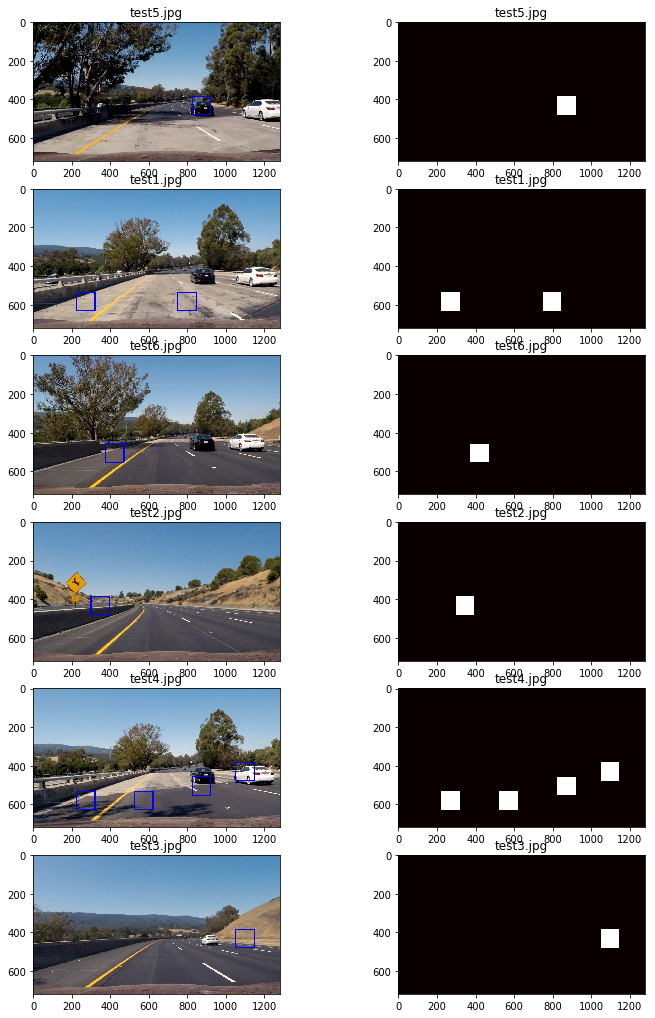

In [452]:
# Define a single function that can extract features using hog sub-sampling and make predictions
out_images = []
out_maps = []
out_titles = []
out_boxes = []

## Sliding Window Parameters - HOG Sub-Sampling ##
SW_YSTART = 384
SW_YSTOP = 704
SW_SCALE = 1.5

ystart = SW_YSTART
ystop = SW_YSTOP
scale = SW_SCALE
spatial_size=BIN_SPATIAL_SIZE
hist_bins=HIST_NBINS
orient=HOG_ORIENTATIONS
pix_per_cell=HOG_PIXELS_PER_CELL
cell_per_block=HOG_CELLS_PER_BLOCK
hog_channel=HOG_CHANNEL
spatial_feat=SW_SPATIAL_FEAT_FLAG
hog_feat=SW_HOG_FEAT_FLAG
hist_feat=SW_COLOR_HIST_FEAT_FLAG


#Iterate over the test images
for img_path in image_paths:
    img_boxes = []
    t1 = time.time()
    count = 0
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    #img = normalize_pixels(img).astype(np.float32)
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64 # HOG_PIXELS_PER_CELL*HOG_PIXELS_PER_CELL # 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 5  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            hist_features = color_hist(subimg, nbins=HIST_NBINS)
            
            
            test_feats = np.hstack((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_SCALER.transform(test_feats.reshape(1, -1))
            test_prediction = SVC.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))

                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
        print(time.time()-t1, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(os.path.split(img_path)[-1])
    out_titles.append(os.path.split(img_path)[-1])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [453]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=SW_YSTART,
              ystop=SW_YSTOP, 
              scale=SW_SCALE, 
              svc=SVC, 
              X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, 
              pix_per_cell=HOG_PIXELS_PER_CELL, 
              cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, 
              hist_bins=HIST_NBINS,
              spatial_feat=SW_SPATIAL_FEAT_FLAG,
              hog_feat=SW_HOG_FEAT_FLAG,
              hist_feat=SW_COLOR_HIST_FEAT_FLAG):
    
    # If y start/stop positions not defined, set to image size      
    if ystart == None or ystart < 0:
        ystart = 0
    if ystop == None or ystop > img.shape[0]:
        ystop = img.shape[0]

    draw_img = np.copy(img)

    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    #img = normalize_pixels(img).astype(np.float32)
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64 # 10 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 4 # HOG_CELLS_PER_BLOCK  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            hist_features = color_hist(subimg, nbins=HIST_NBINS)

            test_feats = np.hstack((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(test_feats.reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,6)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    return draw_img, heatmap

In [454]:
# DEFINE A CLASS TO RECEIVE THE CHARACTERISTICS OF EACH VEHICLE DETECTION
# Objects defined as "Vehicles" will be where multiple overlaping detections exists in the heatmap
class Vehicle():
    def __init__(self, bbox):
        self.prev_detected = False # Flag sets if the Vehicle was detected in the last iteration
        self.cur_detected = True # Flag sets if the Vehicle is detected in the current iteration
        self.n_detections = 1 # number of times this vehicle has been detected
        self.n_non_detections = 0 # number of consecutive times this vehicle has not been detected
        self.xpixels = np.arange(bbox[0][0], bbox[1][0]+1) # Pixel x values of last detection
        self.ypixels = np.arange(bbox[0][1], bbox[1][1]+1) # Pixel y values of last detection
        self.recent_xfitted = []
        self.recent_xfitted.append(bbox[0][0]) # x position of the last n fits of the bounding box
        self.bestx = bbox[0][0] # X position of the current fit
        self.recent_yfitted = []
        self.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
        self.besty = bbox[0][1] # Average y position of the current fit
        self.recent_wfitted = []
        self.recent_wfitted.append(bbox[1][0])
        self.bestw = bbox[1][0] # Average width of the last n fits
        self.recent_hfitted = []
        self.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
        self.besth = bbox[1][1] # Average height of the last n fits
        self.bounding_box = bbox

In [455]:
# Define a function that Implements Smoothing Factor for Multi-Fram Object Tracking
def draw_multi_frame_labeled_bboxes(img, labels, smoothing_factor=1, keep_weight=15, remove_threshold = 8):
    img = np.copy(img)
    # Set all cur_detected values to false for current frame
    for car in carslist:
        car.cur_detected = False
    
    for label in labels:
        # Iterate through all detected labels
        for car_number in range(1, label[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

            # Check if bounding box appears in carslist
            found_match = False
            for car in carslist:               
                # Create comparison matrix
                bbox_flatten = []
                bbox_flatten.append(bbox[0])
                bbox_flatten.append(bbox[1])
                bbox_flatten = [x for xs in bbox_flatten for x in xs]
                
                car_bbox_flat = []
                car_bbox_flat.append(car.bounding_box[0])
                car_bbox_flat.append(car.bounding_box[1])
                car_bbox_flat = [x for xs in car_bbox_flat for x in xs]
                
                if(np.allclose(bbox_flatten, car_bbox_flat, atol=10)):
                    found_match = True
                    print('Found a match. Car Bounding Box', car.bounding_box, '| length nonzerox:',len(nonzerox),
                          '| length nonzeroy:',len(nonzeroy))
                    print('Checked against Bounding box:',bbox)

                    car.n_detections += 1                
                    car.prev_detected = found_match
                    car.cur_detected = found_match
                    car.n_non_detections = 0 # Reset non_detections value
                    car.xpixels = nonzerox # Pixel x values of current detection
                    car.ypixels = nonzeroy # Pixel y values of current detection
                    if car.n_detections > keep_weight: # Average last x values to keep best points current
                        car.recent_xfitted.append(bbox[0][0])
                        car.bestx = int(np.mean(car.recent_xfitted[:-keep_weight])) # Average x position of the last n fits
                        car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                        car.besty = int(np.mean(car.recent_yfitted[:-keep_weight])) # Average y position of the current fit
                        car.recent_wfitted.append(bbox[1][0])
                        car.bestw = int(np.mean(car.recent_wfitted[:-keep_weight])) # Average width of the last n fits
                        car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                        car.besth = int(np.mean(car.recent_hfitted[:-keep_weight])) # Average height of the last n fits
                    else:
                        car.recent_xfitted.append(bbox[0][0])
                        car.bestx = int(np.mean(car.recent_xfitted)) # Average x position of the last n fits
                        car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                        car.besty = int(np.mean(car.recent_yfitted)) # Average y position of the current fit
                        car.recent_wfitted.append(bbox[1][0])
                        car.bestw = int(np.mean(car.recent_wfitted)) # Average width of the last n fits
                        car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                        car.besth = int(np.mean(car.recent_hfitted)) # Average height of the last n fits

                    car.bounding_box = ((car.bestx, car.besty),
                                            (car.bestx+car.bestw, car.besty+car.besth))
                    break

            # After searching for existing car, add new Vehicle         
            if found_match == False:
                # Add New Vehicle
                car = Vehicle(bbox)
                car.xpixels = nonzerox
                car.ypixels = nonzeroy
                car.n_non_detections +=1 
                car.prev_detected = found_match
                car.cur_detected = True

                # Add car to carslist
                carslist.append(car)
            
        
    # After searching through labels and updating carslist, draw labels
    for car in carslist:
        # Set n_non_detections+=1 for each car in carslist that wasn't prev_detected
        if (car.prev_detected == True and car.cur_detected == False):
            print('Found possible false positive for car:', car.bounding_box, 'will check against smoothing factor')
            car.prev_detected == False
            car.n_non_detections +=1
            
        if (car.n_detections > smoothing_factor and car.n_non_detections <= remove_threshold): #Process cars within the smoothing factor range
            cv2.rectangle(img, car.bounding_box[0], car.bounding_box[1], BBOX_COLOR, BBOX_THICK)
        
        if car.n_non_detections > remove_threshold:
            print('Removing Car:', car.bounding_box)
            carslist.remove(car)
        
    # Return the image
    return img

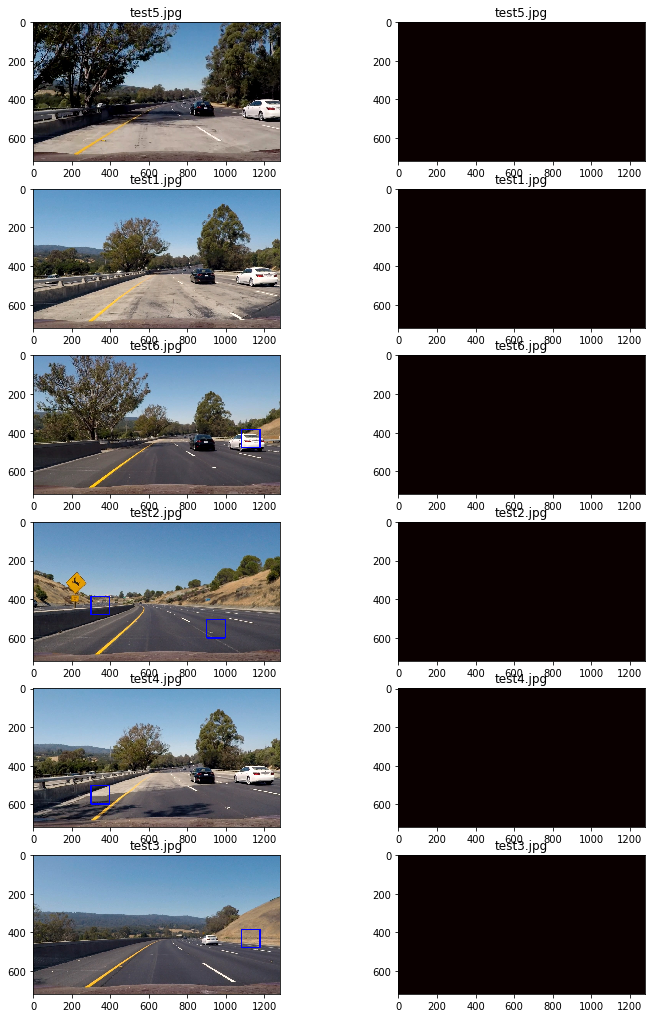

In [456]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
carslist = []

## Sliding Window Parameters - HOG Sub-Sampling ##
# SW_CONVERT_COLOR = 'RGB2YCrCb'
# SW_YSTART = 300
# SW_YSTOP = 665
# SW_SCALE = .95
# BIN_SPATIAL_SIZE = (32,32)
# HIST_NBINS = 256
# HOG_ORIENTATIONS = 10
# HOG_PIXELS_PER_CELL = 8
# HOG_CELLS_PER_BLOCK = 2
# HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"
# SW_SPATIAL_FEAT_FLAG = True
# SW_HOG_FEAT_FLAG = True
# SW_COLOR_HIST_FEAT_FLAG = True
threshold = 3

#Iterate over the test images
for img_path in image_paths:
    img = mpimg.imread(img_path)
    out_img, heatmap = find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE, svc=SVC, X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS)
    labels = label(apply_threshold(heatmap, threshold))
    # Draw bounding boxes on a copy of the image       
    draw_img = draw_multi_frame_labeled_bboxes(np.copy(out_img), [labels])
    out_images.append(draw_img)
    out_images.append(heatmap)
    filename = os.path.split(img_path)[-1]
    out_titles.append(filename)
    out_titles.append(filename)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [457]:
def process_image(img):
    ## Search for cars from previous frame Gather previous bboxes from carslist
    heatmap_1 = np.zeros_like(img[:,:,2])
    img = np.copy(img)       
    
    # Try sliding windows to capture wider bbox

    bboxes = [[(0, 0), (img.shape[1], img.shape[0])]]
    
    for car in carslist:
        bboxes.append(list(car.bounding_box))

    ## Alternative - Use Sliding windows primariliy
    threshold = 5
    labels = []
    windows_1 = slide_windows(img, x_start_stops=SW_XSTART_STOPS, y_start_stops=SW_YSTART_STOPS, 
                           xy_windows=SW_XY_WINDOWS, 
                           xy_overlaps=SW_XY_OVERLAPS)

    hot_windows_1, heatmap_1 = search_windows(img, bboxes, SVC, X_SCALER, color_space=COLOR_SPACE,
                                 spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS, orient=HOG_ORIENTATIONS,
                                 pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
                                 hog_channel=HOG_CHANNEL, spatial_feat=SW_SPATIAL_FEAT_FLAG, hog_feat=SW_HOG_FEAT_FLAG,
                                 hist_feat=SW_COLOR_HIST_FEAT_FLAG)
    labels.append(label(apply_threshold(heatmap_1, threshold)))
    
#    draw_img = draw_labeled_bboxes(np.copy(img), labels, smoothing_factor=6)
    
    ## Search for cars using HOG subsampling (in current frame)
#     SW_YSTART = 384
#     SW_YSTOP = None
#     SW_SCALE = 1.0
    _, heatmap_2 = find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE, svc=SVC, X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS)
    heatmap = np.add(heatmap_1, heatmap_2)
    labels.append(label(apply_threshold(heatmap, threshold)))
    
    draw_img = draw_multi_frame_labeled_bboxes(np.copy(img), labels, smoothing_factor=3)
    return draw_img

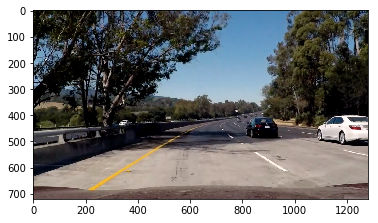

In [458]:
carslist = []
out_img = process_image(mpimg.imread(image_paths[0])) # For Debugging # 
plt.imshow(out_img)

In [459]:
#Import packages to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# SW_YSTART = None #384
# SW_YSTOP = None #640
# SW_SCALE = 1.75

test_ouput = 'test_output.mp4'
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, test_ouput)

TEST_VIDEO = 'test_video.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, TEST_VIDEO)
clip = VideoFileClip(VIDEO_FILE_PATH)
carslist = []
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

HTML("""
<video width="960" height="540" controls>
 <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))

[MoviePy] >>>> Building video data/test_output.mp4
[MoviePy] Writing video data/test_output.mp4


 97%|█████████▋| 38/39 [00:09<00:00,  3.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/test_output.mp4 



### Process Project Video

In [59]:
project_ouput = 'project_output.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, PROJECT_VIDEO)
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, project_ouput)

carslist = []
clip = VideoFileClip(VIDEO_FILE_PATH)
project_clip = clip.fl_image(process_image)
project_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

[MoviePy] >>>> Building video data/project_output.mp4
[MoviePy] Writing video data/project_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:06<2:26:26,  6.97s/it]

Found a match. Car Bounding Box ((50, 394), (219, 503)) | length nonzerox: 11000 | length nonzeroy: 11000
Checked against Bounding box: ((50, 394), (219, 503))
Found a match. Car Bounding Box ((1030, 394), (1239, 473)) | length nonzerox: 12820 | length nonzeroy: 12820
Checked against Bounding box: ((1030, 394), (1239, 473))
Found a match. Car Bounding Box ((900, 416), (959, 447)) | length nonzerox: 1320 | length nonzeroy: 1320
Checked against Bounding box: ((900, 416), (959, 447))
Found a match. Car Bounding Box ((360, 434), (979, 639)) | length nonzerox: 63632 | length nonzeroy: 63632
Checked against Bounding box: ((360, 434), (979, 639))
Found a match. Car Bounding Box ((840, 474), (849, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((840, 474), (849, 479))
Found a match. Car Bounding Box ((1090, 524), (1239, 607)) | length nonzerox: 7980 | length nonzeroy: 7980
Checked against Bounding box: ((1090, 524), (1239, 607))




  0%|          | 2/1261 [00:13<2:26:34,  6.99s/it]

Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor




  0%|          | 3/1261 [00:20<2:26:35,  6.99s/it]

Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor




  0%|          | 4/1261 [00:27<2:26:16,  6.98s/it]

Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor




  0%|          | 5/1261 [00:34<2:26:15,  6.99s/it]

Found a match. Car Bounding Box ((1110, 404), (1239, 463)) | length nonzerox: 7620 | length nonzeroy: 7620
Checked against Bounding box: ((1100, 394), (1239, 473))
Found a match. Car Bounding Box ((960, 514), (1119, 613)) | length nonzerox: 7696 | length nonzeroy: 7696
Checked against Bounding box: ((960, 514), (1119, 607))
Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor




  0%|          | 6/1261 [00:41<2:26:02,  6.98s/it]

Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor




  1%|          | 7/1261 [00:48<2:26:02,  6.99s/it]

Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor




  1%|          | 8/1261 [00:55<2:25:40,  6.98s/it]

Found a match. Car Bounding Box ((510, 414), (649, 573)) | length nonzerox: 13072 | length nonzeroy: 13072
Checked against Bounding box: ((512, 424), (639, 573))
Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor




  1%|          | 9/1261 [01:02<2:25:29,  6.97s/it]

Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor




  1%|          | 10/1261 [01:09<2:25:10,  6.96s/it]

Found possible false positive for car: ((50, 394), (219, 503)) will check against smoothing factor
Removing Car: ((50, 394), (219, 503))
Found possible false positive for car: ((900, 416), (959, 447)) will check against smoothing factor
Removing Car: ((900, 416), (959, 447))
Found possible false positive for car: ((840, 474), (849, 479)) will check against smoothing factor
Removing Car: ((840, 474), (849, 479))
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor




  1%|          | 11/1261 [01:16<2:24:52,  6.95s/it]

Found possible false positive for car: ((1030, 394), (1239, 473)) will check against smoothing factor
Removing Car: ((1030, 394), (1239, 473))
Found possible false positive for car: ((1090, 524), (1239, 607)) will check against smoothing factor
Removing Car: ((1090, 524), (1239, 607))
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor




  1%|          | 12/1261 [01:23<2:24:37,  6.95s/it]

Found a match. Car Bounding Box ((1010, 544), (1089, 593)) | length nonzerox: 2916 | length nonzeroy: 2916
Checked against Bounding box: ((1020, 544), (1099, 603))
Found possible false positive for car: ((360, 434), (979, 639)) will check against smoothing factor
Removing Car: ((360, 434), (979, 639))
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor




  1%|          | 13/1261 [01:30<2:24:32,  6.95s/it]

Found a match. Car Bounding Box ((832, 524), (859, 543)) | length nonzerox: 460 | length nonzeroy: 460
Checked against Bounding box: ((830, 514), (859, 543))
Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check against smoothing factor




  1%|          | 14/1261 [01:37<2:24:26,  6.95s/it]

Found possible false positive for car: ((1105, 399), (1239, 468)) will check against smoothing factor
Removing Car: ((1105, 399), (1239, 468))
Found possible false positive for car: ((960, 514), (1119, 610)) will check against smoothing factor
Removing Car: ((960, 514), (1119, 610))
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check against smoothing factor




  1%|          | 15/1261 [01:44<2:24:13,  6.94s/it]

Found a match. Car Bounding Box ((680, 480), (1089, 643)) | length nonzerox: 32592 | length nonzeroy: 32592
Checked against Bounding box: ((690, 474), (1089, 639))
Found a match. Car Bounding Box ((1160, 534), (1219, 607)) | length nonzerox: 3600 | length nonzeroy: 3600
Checked against Bounding box: ((1150, 544), (1219, 607))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check against smoothing factor




  1%|▏         | 16/1261 [01:51<2:24:18,  6.95s/it]

Found a match. Car Bounding Box ((60, 554), (149, 633)) | length nonzerox: 6968 | length nonzeroy: 6968
Checked against Bounding box: ((60, 544), (159, 643))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check against smoothing factor




  1%|▏         | 17/1261 [01:58<2:24:20,  6.96s/it]

Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((511, 419), (644, 573)) will check against smoothing factor
Removing Car: ((511, 419), (644, 573))
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check against smoothing factor




  1%|▏         | 18/1261 [02:05<2:24:15,  6.96s/it]

Found a match. Car Bounding Box ((900, 564), (909, 583)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((896, 564), (899, 575))
Found a match. Car Bounding Box ((650, 576), (671, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((650, 584), (679, 593))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check against smoothing factor




  2%|▏         | 19/1261 [02:12<2:24:38,  6.99s/it]

Found a match. Car Bounding Box ((520, 584), (549, 613)) | length nonzerox: 1144 | length nonzeroy: 1144
Checked against Bounding box: ((512, 576), (539, 623))
Found a match. Car Bounding Box ((660, 584), (689, 607)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((650, 584), (679, 607))
Found a match. Car Bounding Box ((690, 584), (703, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((690, 584), (699, 607))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false positive for car: ((650, 580), (675, 593)) will check against smoothing factor
Found possible false p



  2%|▏         | 20/1261 [02:19<2:24:58,  7.01s/it]

Found a match. Car Bounding Box ((410, 404), (671, 639)) | length nonzerox: 36008 | length nonzeroy: 36008
Checked against Bounding box: ((416, 404), (669, 639))
Found a match. Car Bounding Box ((510, 434), (511, 447)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((500, 444), (511, 447))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false positive for car: ((650, 580), (675, 593)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check aga



  2%|▏         | 21/1261 [02:26<2:24:39,  7.00s/it]

Found a match. Car Bounding Box ((440, 484), (447, 511)) | length nonzerox: 684 | length nonzeroy: 684
Checked against Bounding box: ((430, 474), (447, 511))
Found a match. Car Bounding Box ((440, 524), (447, 533)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((430, 524), (447, 543))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false positive for car: ((650, 580), (675, 593)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1094, 598)) will check again



  2%|▏         | 22/1261 [02:33<2:25:04,  7.03s/it]

Found a match. Car Bounding Box ((505, 439), (511, 447)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((510, 434), (511, 447))
Found a match. Car Bounding Box ((435, 524), (447, 538)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((440, 524), (447, 543))
Found a match. Car Bounding Box ((1190, 584), (1215, 603)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1180, 584), (1219, 593))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false p



  2%|▏         | 23/1261 [02:40<2:25:17,  7.04s/it]

Found a match. Car Bounding Box ((436, 524), (447, 539)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((440, 534), (447, 543))
Found possible false positive for car: ((831, 519), (859, 543)) will check against smoothing factor
Removing Car: ((831, 519), (859, 543))
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((650, 580), (675, 593)) will check against smoothing factor
Found possible false positive for car: ((413, 404), (670, 639)) will check against smoothing factor
Fou



  2%|▏         | 24/1261 [02:47<2:25:32,  7.06s/it]

Found a match. Car Bounding Box ((1160, 416), (1189, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1160, 416), (1179, 447))
Found a match. Car Bounding Box ((506, 437), (511, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((510, 444), (511, 447))
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 477), (1089, 641)) will check against smoothing factor
Removing Car: ((685, 477), (1089, 641))
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: (



  2%|▏         | 25/1261 [02:54<2:25:27,  7.06s/it]

Found a match. Car Bounding Box ((510, 434), (511, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((510, 444), (511, 447))
Found possible false positive for car: ((1155, 539), (1219, 607)) will check against smoothing factor
Removing Car: ((1155, 539), (1219, 607))
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (154, 638)) will check against smoothing factor
Removing Car: ((60, 549), (154, 638))
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((440, 524), (447, 533)) will check against smoothing factor
Found possible false positive for car: ((650, 580), (675, 593)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)



  2%|▏         | 26/1261 [03:01<2:25:45,  7.08s/it]

Found a match. Car Bounding Box ((505, 439), (511, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((510, 444), (511, 447))
Found a match. Car Bounding Box ((435, 479), (447, 511)) | length nonzerox: 344 | length nonzeroy: 344
Checked against Bounding box: ((430, 484), (447, 511))
Found a match. Car Bounding Box ((440, 524), (447, 533)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((430, 524), (447, 533))
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((650, 580), (675, 593)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((413, 404), (670, 639)) will check against smoothing factor
Found possible false posit



  2%|▏         | 27/1261 [03:09<2:25:32,  7.08s/it]

Found a match. Car Bounding Box ((80, 494), (89, 523)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((80, 494), (99, 513))
Found a match. Car Bounding Box ((440, 494), (447, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))
Found a match. Car Bounding Box ((1170, 544), (1229, 613)) | length nonzerox: 1928 | length nonzeroy: 1928
Checked against Bounding box: ((1170, 554), (1239, 607))
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((433, 480), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((650, 580), (675, 593)) will check against smoothing factor
Removing Car: ((650, 580



  2%|▏         | 28/1261 [03:15<2:24:52,  7.05s/it]

Found a match. Car Bounding Box ((1140, 544), (1239, 613)) | length nonzerox: 4440 | length nonzeroy: 4440
Checked against Bounding box: ((1140, 534), (1239, 607))
Found possible false positive for car: ((655, 584), (684, 607)) will check against smoothing factor
Removing Car: ((655, 584), (684, 607))
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((433, 480), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((413, 404), (670, 639)) will check against smoothing factor
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (544, 618)) will check against smoothin



  2%|▏         | 29/1261 [03:23<2:24:53,  7.06s/it]

Found a match. Car Bounding Box ((1030, 416), (1089, 447)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((1020, 424), (1089, 447))
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((433, 480), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((413, 404), (670, 639)) will check against smoothing factor
Removing Car: ((413, 404), (670, 639))
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((506, 437), (511, 447)) will check against smoothing factor
Found possible false positive for car: ((440, 499), (447, 511)) will check against smoothing 



  2%|▏         | 30/1261 [03:30<2:24:49,  7.06s/it]

Found a match. Car Bounding Box ((450, 474), (479, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((460, 474), (479, 479))
Found a match. Car Bounding Box ((440, 499), (447, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Found possible false positive for car: ((433, 480), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((506, 437), (511, 447)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1089, 447)) will check aga



  2%|▏         | 31/1261 [03:37<2:24:50,  7.07s/it]

Found a match. Car Bounding Box ((430, 574), (479, 607)) | length nonzerox: 1364 | length nonzeroy: 1364
Checked against Bounding box: ((420, 574), (489, 607))
Found possible false positive for car: ((1185, 584), (1217, 598)) will check against smoothing factor
Removing Car: ((1185, 584), (1217, 598))
Found possible false positive for car: ((433, 480), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((506, 437), (511, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 474), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((440, 500), (447, 511)) will check against smoothing 



  3%|▎         | 32/1261 [03:44<2:25:02,  7.08s/it]

Found a match. Car Bounding Box ((410, 414), (919, 639)) | length nonzerox: 70028 | length nonzeroy: 70028
Checked against Bounding box: ((416, 404), (929, 643))
Found a match. Car Bounding Box ((433, 480), (447, 511)) | length nonzerox: 504 | length nonzeroy: 504
Checked against Bounding box: ((430, 484), (447, 511))
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((425, 574), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((506, 437), (511, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 474), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((440, 500), (447, 511)) will check a



  3%|▎         | 33/1261 [03:51<2:24:57,  7.08s/it]

Found a match. Car Bounding Box ((140, 534), (219, 613)) | length nonzerox: 4040 | length nonzeroy: 4040
Checked against Bounding box: ((140, 524), (219, 607))
Found possible false positive for car: ((440, 484), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1184, 447)) will check against smoothing factor
Removing Car: ((1160, 416), (1184, 447))
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((425, 574), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((506, 437), (511, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 474), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((440, 500), (447, 511)) will check against smoothing fa



  3%|▎         | 34/1261 [03:58<2:24:40,  7.07s/it]

Found a match. Car Bounding Box ((440, 484), (447, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((440, 484), (447, 503))
Found a match. Car Bounding Box ((1160, 576), (1199, 607)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((1150, 574), (1199, 603))
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((425, 574), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((506, 437), (511, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 474), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((440, 500), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((413, 409), (924, 641)) will check a



  3%|▎         | 35/1261 [04:05<2:25:04,  7.10s/it]

Found a match. Car Bounding Box ((440, 416), (689, 613)) | length nonzerox: 21308 | length nonzeroy: 21308
Checked against Bounding box: ((430, 424), (679, 607))
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((435, 524), (447, 538)) will check against smoothing factor
Removing Car: ((435, 524), (447, 538))
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Found possible false positive for car: ((425, 574), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((506, 437), (511, 447)) will check against smoothing factor
Removing Car: ((506, 437), (511, 447))
Found possible false positive for car: ((455, 474), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((440, 500), (447



  3%|▎         | 36/1261 [04:12<2:24:50,  7.09s/it]

Found a match. Car Bounding Box ((440, 500), (447, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))
Found a match. Car Bounding Box ((425, 574), (484, 607)) | length nonzerox: 1020 | length nonzeroy: 1020
Checked against Bounding box: ((420, 584), (479, 607))
Found a match. Car Bounding Box ((1170, 574), (1219, 607)) | length nonzerox: 1140 | length nonzeroy: 1140
Checked against Bounding box: ((1180, 584), (1219, 613))
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Found possible false positive for car: ((1170, 549), (1234, 610)) will check against smoothing factor
Removing Car: ((1170, 549), (1234, 610))
Found possible false positive for car: ((455, 474), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((413, 409), (924, 641)) will check 



  3%|▎         | 37/1261 [04:19<2:24:19,  7.07s/it]

Found a match. Car Bounding Box ((440, 424), (959, 633)) | length nonzerox: 59956 | length nonzeroy: 59956
Checked against Bounding box: ((440, 416), (949, 643))
Found a match. Car Bounding Box ((490, 434), (511, 447)) | length nonzerox: 68 | length nonzeroy: 68
Checked against Bounding box: ((500, 434), (511, 447))
Found a match. Car Bounding Box ((990, 524), (1099, 607)) | length nonzerox: 7000 | length nonzeroy: 7000
Checked against Bounding box: ((980, 534), (1109, 613))
Found a match. Car Bounding Box ((680, 584), (699, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((680, 584), (699, 603))
Found a match. Car Bounding Box ((1160, 574), (1219, 633)) | length nonzerox: 2800 | length nonzeroy: 2800
Checked against Bounding box: ((1160, 584), (1229, 639))
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing fac



  3%|▎         | 38/1261 [04:26<2:24:01,  7.07s/it]

Found a match. Car Bounding Box ((704, 464), (709, 473)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((704, 464), (709, 473))
Found a match. Car Bounding Box ((864, 544), (869, 553)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((864, 534), (869, 543))
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check agains



  3%|▎         | 39/1261 [04:33<2:24:19,  7.09s/it]

Found a match. Car Bounding Box ((680, 584), (699, 605)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((680, 584), (689, 607))
Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check against smoothing factor
Found possible false positive for c



  3%|▎         | 40/1261 [04:40<2:23:40,  7.06s/it]

Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 494), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 548)) will check against smoothing 



  3%|▎         | 41/1261 [04:47<2:23:09,  7.04s/it]

Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 494), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 548)) will check against smoothing 



  3%|▎         | 42/1261 [04:54<2:22:52,  7.03s/it]

Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 494), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 548)) will check against smoothing 



  3%|▎         | 43/1261 [05:01<2:22:38,  7.03s/it]

Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 479), (447, 511)) will check against smoothing factor
Removing Car: ((435, 479), (447, 511))
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((1155, 575), (1199, 605)) will check against smoothing factor
Removing Car: ((1155, 575), (1199, 605))
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 494), (447, 511)) will check against smoothing factor
Found possibl



  3%|▎         | 44/1261 [05:09<2:22:54,  7.05s/it]

Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 494), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (684, 610)) will check against smoothing factor
Removing Car: ((435, 420), (684, 610))
Found possible false positive for car: ((680, 584), (695



  4%|▎         | 45/1261 [05:16<2:23:00,  7.06s/it]

Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Found possible false positive for car: ((423, 577), (482, 607)) will check against smoothing factor
Removing Car: ((423, 577), (482, 607))
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 579), (1219, 610)) will check against smoothing factor
Removing Car: ((1175, 579), (1219, 610))
Found possible false positive for car: ((440, 494), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((680, 584), (695, 605)) will check against smoothing factor
Found possible 



  4%|▎         | 46/1261 [05:23<2:22:47,  7.05s/it]

Found a match. Car Bounding Box ((430, 574), (499, 639)) | length nonzerox: 3580 | length nonzeroy: 3580
Checked against Bounding box: ((430, 574), (509, 633))
Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Found possible false positive for car: ((440, 420), (954, 638)) will check against smoothing factor
Removing Car: ((440, 420), (954, 638))
Found possible false positive for car: ((985, 529), (1104, 610)) will check against smoothing factor
Removing Car: ((985, 529), (1104, 610))
Found possible false positive for car: ((1160, 579), (1224, 636)) will check against smoothing factor
Removing Car: ((1160, 579), (1224, 636))
Found possible false positive for car: ((440, 494), (447, 511)) will check against smoothing factor
Removing Car: ((440, 494), (447, 511))
Found possible false positive for car: ((864, 539), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((680, 584), (695, 605)) will check aga



  4%|▎         | 47/1261 [05:30<2:22:23,  7.04s/it]

Found a match. Car Bounding Box ((544, 576), (559, 583)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((544, 576), (549, 583))
Found possible false positive for car: ((704, 464), (709, 473)) will check against smoothing factor
Removing Car: ((704, 464), (709, 473))
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 548)) will check against smoothing factor
Removing Car: ((864, 539), (869, 548))
Found possible false positive for car: ((680, 584), (695, 605)) will check against smoothing factor




  4%|▍         | 48/1261 [05:37<2:22:12,  7.03s/it]

Found a match. Car Bounding Box ((540, 576), (569, 603)) | length nonzerox: 368 | length nonzeroy: 368
Checked against Bounding box: ((544, 576), (569, 593))
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Found possible false positive for car: ((680, 584), (695, 605)) will check against smoothing factor
Removing Car: ((680, 584), (695, 605))
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing factor




  4%|▍         | 49/1261 [05:44<2:22:41,  7.06s/it]

Found a match. Car Bounding Box ((420, 424), (859, 633)) | length nonzerox: 53560 | length nonzeroy: 53560
Checked against Bounding box: ((410, 414), (869, 643))
Found a match. Car Bounding Box ((420, 504), (447, 511)) | length nonzerox: 324 | length nonzeroy: 324
Checked against Bounding box: ((430, 494), (447, 511))
Found a match. Car Bounding Box ((440, 524), (447, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((440, 534), (447, 543))
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing factor




  4%|▍         | 50/1261 [05:51<2:22:39,  7.07s/it]

Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (447, 543)) will check against smoothing factor


Found a match. Car Bounding Box ((400, 424), (669, 643)) | length nonzerox: 37904 | length nonzeroy: 37904
Checked against Bounding box: ((390, 424), (659, 653))
Found a match. Car Bounding Box ((1000, 524), (1139, 603)) | length nonzerox: 5700 | length nonzeroy: 5700
Checked against Bounding box: ((990, 514), (1129, 593))
Found a match. Car Bounding Box ((864, 524), (869, 543)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((864, 534), (869, 543))




  4%|▍         | 51/1261 [05:58<2:23:37,  7.12s/it]

Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (447, 543)) will check against smoothing factor




  4%|▍         | 52/1261 [06:05<2:23:52,  7.14s/it]

Found a match. Car Bounding Box ((420, 416), (639, 639)) | length nonzerox: 30396 | length nonzeroy: 30396
Checked against Bounding box: ((430, 424), (649, 639))
Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (447, 543)) will check against smoothing factor
Found possible false positive for car



  4%|▍         | 53/1261 [06:13<2:24:15,  7.17s/it]

Found a match. Car Bounding Box ((420, 414), (679, 623)) | length nonzerox: 31684 | length nonzeroy: 31684
Checked against Bounding box: ((430, 424), (689, 613))
Found a match. Car Bounding Box ((600, 444), (609, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((608, 444), (609, 447))
Found a match. Car Bounding Box ((620, 444), (629, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((620, 444), (639, 447))
Found a match. Car Bounding Box ((750, 584), (759, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((750, 584), (767, 593))
Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 574), (504, 636)) will 



  4%|▍         | 54/1261 [06:20<2:23:26,  7.13s/it]

Found a match. Car Bounding Box ((430, 416), (699, 633)) | length nonzerox: 45488 | length nonzeroy: 45488
Checked against Bounding box: ((420, 416), (709, 633))
Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing factor
Found possible false positive for car



  4%|▍         | 55/1261 [06:27<2:22:48,  7.11s/it]

Found a match. Car Bounding Box ((928, 512), (1069, 593)) | length nonzerox: 9520 | length nonzeroy: 9520
Checked against Bounding box: ((930, 514), (1059, 603))
Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 574), (504, 636)) will check against smoothing factor
Removing Car: ((430, 574), (504, 636))
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing facto

Found a match. Car Bounding Box ((410, 416), (689, 639)) | length nonzerox: 38888 | length nonzeroy: 38888
Checked against Bounding box: ((410, 416), (679, 639))




  4%|▍         | 56/1261 [06:34<2:23:10,  7.13s/it]

Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (554, 583)) will check against smoothing factor
Removing Car: ((544, 576), (554, 583))
Found possible false positive for car: ((425, 416), (704, 633)) will check against smoothing factor
Found possible false positive for car: ((425, 420), (644, 6



  5%|▍         | 57/1261 [06:41<2:22:51,  7.12s/it]

Found a match. Car Bounding Box ((410, 416), (684, 639)) | length nonzerox: 37496 | length nonzeroy: 37496
Checked against Bounding box: ((410, 424), (679, 639))
Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (569, 598)) will check against smoothing factor
Removing Car: ((542, 576), (569, 598))
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (704, 633)) will check against smoothing fact



  5%|▍         | 58/1261 [06:48<2:22:10,  7.09s/it]

Found a match. Car Bounding Box ((390, 414), (899, 653)) | length nonzerox: 68772 | length nonzeroy: 68772
Checked against Bounding box: ((384, 416), (909, 653))
Found a match. Car Bounding Box ((1070, 514), (1215, 623)) | length nonzerox: 10660 | length nonzeroy: 10660
Checked against Bounding box: ((1080, 512), (1209, 623))
Found possible false positive for car: ((415, 419), (864, 638)) will check against smoothing factor
Removing Car: ((415, 419), (864, 638))
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((425, 499), (447, 511)) will check against smoothing factor
Removing Car: ((425, 499), (447, 511))
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing



  5%|▍         | 59/1261 [06:55<2:22:24,  7.11s/it]

Found a match. Car Bounding Box ((540, 444), (543, 447)) | length nonzerox: 56 | length nonzeroy: 56
Checked against Bounding box: ((530, 444), (543, 447))
Found a match. Car Bounding Box ((820, 576), (829, 583)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((830, 584), (831, 593))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (904, 653)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (704, 633)) will check against s



  5%|▍         | 60/1261 [07:02<2:22:24,  7.11s/it]

Found a match. Car Bounding Box ((1170, 534), (1247, 607)) | length nonzerox: 4460 | length nonzeroy: 4460
Checked against Bounding box: ((1160, 534), (1239, 607))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1134, 598)) will check against smoothing factor
Removing Car: ((995, 519), (1134, 598))
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 543)) will check against smoothing factor
Removing Car: ((864, 529), (869, 543))
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (



  5%|▍         | 61/1261 [07:10<2:23:22,  7.17s/it]

Found a match. Car Bounding Box ((470, 504), (479, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((460, 504), (479, 511))
Found a match. Car Bounding Box ((180, 584), (199, 607)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((190, 574), (209, 607))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (904, 653)) will check agai



  5%|▍         | 62/1261 [07:17<2:22:53,  7.15s/it]

Found a match. Car Bounding Box ((1180, 416), (1199, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1190, 416), (1209, 447))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((425, 419), (684, 618)) will check against smoothing factor
Removing Car: ((425, 419), (684, 618))
Found possible false positive for car: ((387, 415), (904, 653)) will check against smoothing factor
Found possible false positive for car: ((185, 579), (204, 607)) will check against smoothing f



  5%|▍         | 63/1261 [07:24<2:21:35,  7.09s/it]

Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (904, 653)) will check against smoothing factor
Found possible false positive for car: ((185, 579), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (704, 633)) will check against smoothing factor
Removing Car: ((425, 416), (704, 633))
Found possible false positive for car: ((620, 444), (634, 447)) will check against smoothing factor
Removing Car: ((620, 444), (634, 447))
Found possible fa



  5%|▌         | 64/1261 [07:31<2:21:43,  7.10s/it]

Found a match. Car Bounding Box ((450, 464), (479, 479)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((450, 464), (479, 483))
Found a match. Car Bounding Box ((465, 504), (479, 511)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((470, 494), (479, 511))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (1064, 598)) will check against smoothing factor
Removing Car: ((929, 513), (1064, 598))
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (904, 653)) will check against smoothing factor
Found possible false positive for car: 



  5%|▌         | 65/1261 [07:38<2:21:12,  7.08s/it]

Found a match. Car Bounding Box ((704, 474), (719, 479)) | length nonzerox: 156 | length nonzeroy: 156
Checked against Bounding box: ((704, 474), (729, 479))
Found a match. Car Bounding Box ((928, 564), (929, 573)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((928, 574), (929, 575))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (904, 653)) will check against smoothing factor
Found possible false positive for car: ((185, 579), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((466, 500), (479, 511)) will check against s



  5%|▌         | 66/1261 [07:45<2:20:21,  7.05s/it]

Found a match. Car Bounding Box ((440, 504), (447, 511)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((430, 494), (439, 511))
Found a match. Car Bounding Box ((970, 524), (1109, 623)) | length nonzerox: 7800 | length nonzeroy: 7800
Checked against Bounding box: ((980, 524), (1099, 613))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (904, 653)) will check against smoothing factor
Found possible false positive for car: ((185, 579), (204, 607)) will check a



  5%|▌         | 67/1261 [07:52<2:20:09,  7.04s/it]

Found a match. Car Bounding Box ((928, 544), (929, 553)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((920, 544), (927, 553))
Found possible false positive for car: ((1075, 513), (1212, 623)) will check against smoothing factor
Removing Car: ((1075, 513), (1212, 623))
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((387, 415), (904, 653)) will check against smoothing factor
Removing Car: ((387, 415), (904, 653))
Found possible false positive for car: ((185, 579), (204, 6



  5%|▌         | 68/1261 [07:59<2:20:23,  7.06s/it]

Found a match. Car Bounding Box ((910, 514), (1069, 623)) | length nonzerox: 13936 | length nonzeroy: 13936
Checked against Bounding box: ((910, 512), (1079, 623))
Found a match. Car Bounding Box ((420, 524), (447, 533)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((416, 534), (447, 543))
Found a match. Car Bounding Box ((1150, 574), (1219, 633)) | length nonzerox: 2528 | length nonzeroy: 2528
Checked against Bounding box: ((1140, 574), (1229, 623))
Found a match. Car Bounding Box ((928, 584), (929, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((920, 584), (927, 593))
Found a match. Car Bounding Box ((1110, 576), (1119, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1110, 584), (1129, 593))
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 444), (543, 447)) will check against smoothing f



  5%|▌         | 69/1261 [08:06<2:19:56,  7.04s/it]

Found a match. Car Bounding Box ((416, 564), (511, 639)) | length nonzerox: 4508 | length nonzeroy: 4508
Checked against Bounding box: ((416, 574), (511, 639))
Found possible false positive for car: ((1165, 534), (1243, 607)) will check against smoothing factor
Removing Car: ((1165, 534), (1243, 607))
Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Found possible false positive for car: ((185, 579), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((466, 500), (479, 511)) will check against smoothing factor
Found possible false positive for car: ((924, 544), (928, 553)) will check against smoothing factor
Found possible false positive for car: ((910, 513), (1074, 623)) will check against smoothing 



  6%|▌         | 70/1261 [08:13<2:19:52,  7.05s/it]

Found a match. Car Bounding Box ((450, 464), (479, 481)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((450, 474), (469, 479))
Found a match. Car Bounding Box ((60, 494), (99, 553)) | length nonzerox: 3100 | length nonzeroy: 3100
Checked against Bounding box: ((50, 484), (99, 553))
Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((185, 579), (204, 607)) will check against smoothing factor
Removing Car: ((185, 579), (204, 607))
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((466, 500), (479, 511)) will check against smoothing factor
Found possible false positive for car: ((924



  6%|▌         | 71/1261 [08:20<2:19:52,  7.05s/it]

Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((466, 500), (479, 511)) will check against smoothing factor
Found possible false positive for car: ((924, 544), (928, 553)) will check against smoothing factor
Found possible false positive for car: ((910, 513), (1074, 623)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 593)) will check against smoothing factor
Found possible false positive for car: ((704, 474), (724, 479)) will check against smoothing facto



  6%|▌         | 72/1261 [08:27<2:19:40,  7.05s/it]

Found a match. Car Bounding Box ((960, 512), (1099, 603)) | length nonzerox: 7876 | length nonzeroy: 7876
Checked against Bounding box: ((960, 512), (1089, 607))
Found a match. Car Bounding Box ((60, 564), (129, 633)) | length nonzerox: 2872 | length nonzeroy: 2872
Checked against Bounding box: ((50, 574), (119, 633))
Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((466, 500), (479, 511)) will check against smoothing factor
Found possible false positive for car: ((924, 544), (928, 553)) will check agai



  6%|▌         | 73/1261 [08:34<2:19:36,  7.05s/it]

Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((466, 500), (479, 511)) will check against smoothing factor
Removing Car: ((466, 500), (479, 511))
Found possible false positive for car: ((924, 544), (928, 553)) will check against smoothing factor
Found possible false positive for car: ((910, 513), (1074, 6



  6%|▌         | 74/1261 [08:41<2:19:23,  7.05s/it]

Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (929, 574)) will check against smoothing factor
Removing Car: ((928, 569), (929, 574))
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((924, 544), (928, 553)) will check against smoothing factor
Found possible false positive for car: ((910, 513), (1074, 623)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 5



  6%|▌         | 75/1261 [08:48<2:19:31,  7.06s/it]

Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1104, 618)) will check against smoothing factor
Removing Car: ((975, 524), (1104, 618))
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((924, 544), (928, 553)) will check against smoothing factor
Found possible false positive for car: ((910, 513), (1074, 623)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 593)) will check against smoothing factor
Found possible false positive for car: ((450, 467), (475, 



  6%|▌         | 76/1261 [08:55<2:19:18,  7.05s/it]

Found a match. Car Bounding Box ((450, 467), (475, 480)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((460, 474), (479, 479))
Found a match. Car Bounding Box ((410, 484), (447, 511)) | length nonzerox: 424 | length nonzeroy: 424
Checked against Bounding box: ((420, 494), (447, 511))
Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((924, 544), (928, 553)) will check against smoothing factor
Removing Car: ((924, 544), (928, 553))
Found possible false positive for car: ((910,



  6%|▌         | 77/1261 [09:02<2:19:08,  7.05s/it]

Found a match. Car Bounding Box ((950, 524), (969, 573)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((960, 514), (969, 563))
Found a match. Car Bounding Box ((110, 534), (249, 623)) | length nonzerox: 13100 | length nonzeroy: 13100
Checked against Bounding box: ((110, 524), (259, 623))
Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Removing Car: ((1110, 580), (1124, 588))
Found possible false positive for car: ((910, 513), (1074, 623)) will check against smoothing factor
Removing Car: ((910, 513), (1074, 623)



  6%|▌         | 78/1261 [09:09<2:19:06,  7.06s/it]

Found a match. Car Bounding Box ((672, 424), (679, 447)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((672, 434), (679, 447))
Found a match. Car Bounding Box ((440, 514), (447, 543)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((448, 514), (449, 543))
Found a match. Car Bounding Box ((980, 524), (1059, 607)) | length nonzerox: 4300 | length nonzeroy: 4300
Checked against Bounding box: ((990, 534), (1059, 607))
Found a match. Car Bounding Box ((544, 576), (549, 583)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((544, 576), (549, 583))
Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((416, 569), (511, 639)) will check against smoothing factor
Removing Car: ((416, 569), (511, 639))
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive



  6%|▋         | 79/1261 [09:16<2:18:33,  7.03s/it]

Found a match. Car Bounding Box ((400, 434), (929, 643)) | length nonzerox: 61620 | length nonzeroy: 61620
Checked against Bounding box: ((390, 424), (919, 639))
Found a match. Car Bounding Box ((100, 480), (149, 523)) | length nonzerox: 2832 | length nonzeroy: 2832
Checked against Bounding box: ((100, 474), (159, 533))
Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Found possible false positive for car: ((55, 489), (99, 553)) will check against smoothing factor
Removing Car: ((55, 489), (99, 553))
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((450, 464), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((44



  6%|▋         | 80/1261 [09:23<2:18:23,  7.03s/it]

Found a match. Car Bounding Box ((704, 474), (709, 479)) | length nonzerox: 36 | length nonzeroy: 36
Checked against Bounding box: ((704, 474), (709, 479))
Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((450, 464), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((444, 514), (448, 543)) will check against smoothing factor
Found possible false positive for car: ((955

Found a match. Car Bounding Box ((670, 464), (689, 483)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((672, 464), (679, 479))
Found a match. Car Bounding Box ((920, 514), (1069, 607)) | length nonzerox: 9680 | length nonzeroy: 9680
Checked against Bounding box: ((930, 504), (1069, 603))




  6%|▋         | 81/1261 [09:31<2:19:15,  7.08s/it]

Found possible false positive for car: ((55, 569), (124, 633)) will check against smoothing factor
Removing Car: ((55, 569), (124, 633))
Found possible false positive for car: ((960, 512), (1094, 605)) will check against smoothing factor
Removing Car: ((960, 512), (1094, 605))
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((450, 464), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((444, 514), (448, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 519), (969, 568)) will check against smoothing factor
Found possible false p



  7%|▋         | 82/1261 [09:38<2:18:21,  7.04s/it]

Found a match. Car Bounding Box ((760, 474), (767, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((750, 474), (759, 479))
Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((450, 464), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((444, 514), (448, 543)) will check against smoothing factor
Found possible false positive for car: ((95



  7%|▋         | 83/1261 [09:44<2:17:48,  7.02s/it]

Found a match. Car Bounding Box ((1070, 416), (1109, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1080, 416), (1099, 447))
Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((450, 464), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((444, 514), (448, 543)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((1075, 416), (1104, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((1080, 416), (1109, 447))
Found a match. Car Bounding Box ((390, 424), (669, 639)) | length nonzerox: 32584 | length nonzeroy: 32584
Checked against Bounding box: ((380, 434), (671, 643))
Found a match. Car Bounding Box ((540, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))
Found a match. Car Bounding Box ((1150, 534), (1247, 633)) | length nonzerox: 5040 | length nonzeroy: 5040
Checked against Bounding box: ((1150, 524), (1239, 623))




  7%|▋         | 84/1261 [09:51<2:17:43,  7.02s/it]

Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((450, 464), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((444, 514), (448, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 519), (969, 568)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1059, 607)) will check against smoothing facto



  7%|▋         | 85/1261 [09:59<2:17:46,  7.03s/it]

Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((450, 464), (479, 479)) will check against smoothing factor
Removing Car: ((450, 464), (479, 479))
Found possible false positive for car: ((955, 519), (969

Found a match. Car Bounding Box ((1100, 416), (1129, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1110, 416), (1129, 447))




  7%|▋         | 86/1261 [10:06<2:18:16,  7.06s/it]

Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((110, 529), (254, 623)) will check against smoothing factor
Removing Car: ((110, 529), (254, 623))
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((444, 514), (448, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 519), (969



  7%|▋         | 87/1261 [10:13<2:17:55,  7.05s/it]

Found a match. Car Bounding Box ((395, 429), (924, 641)) | length nonzerox: 48768 | length nonzeroy: 48768
Checked against Bounding box: ((400, 424), (919, 633))
Found a match. Car Bounding Box ((1180, 584), (1189, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1180, 576), (1189, 583))
Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((672, 429), (679, 447)) will check against smoothing factor
Removing Car: ((672, 429), (679, 447))
Found possible false positive fo

Found a match. Car Bounding Box ((540, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))




  7%|▋         | 88/1261 [10:20<2:18:18,  7.07s/it]

Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 580), (1189, 588)) will check against smoothing factor
Found possible false positive for car: ((100, 477), (154, 528)) will check against smoothing factor
Removing Car: ((100, 477), (154, 528))
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Found possible false positive for car: ((396, 427), (922, 638)) will check against smoothing factor
Found possible false positive for car: ((444, 514), (448, 543)) will check against smoothing factor
Removing Car: ((444, 514), (448, 543))
Found possibl



  7%|▋         | 89/1261 [10:27<2:18:35,  7.09s/it]

Found a match. Car Bounding Box ((380, 574), (383, 575)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((380, 574), (383, 575))
Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 580), (1189, 588)) will check against smoothing factor
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Found possible false positive for car: ((396, 427), (922, 638)) will check against smoothing factor
Found possible false positive for car: ((704, 474), (709, 479)) will check against smoothing factor
Removing Car: ((704, 474), (709, 479)



  7%|▋         | 90/1261 [10:34<2:17:55,  7.07s/it]

Found possible false positive for car: ((925, 509), (1069, 605)) will check against smoothing factor
Removing Car: ((925, 509), (1069, 605))
Found possible false positive for car: ((1180, 580), (1189, 588)) will check against smoothing factor
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((671, 464), (684, 481)) will check against smoothing factor
Removing Car: ((671, 464), (684, 481))
Found possible false positive for car: ((396, 427), (922, 638)) will check against smoothing factor
Found possible false positive for car: ((540, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((755, 474), (763, 479)) will check against smoothing factor
Found possib



  7%|▋         | 91/1261 [10:41<2:17:36,  7.06s/it]

Found a match. Car Bounding Box ((70, 554), (179, 633)) | length nonzerox: 8376 | length nonzeroy: 8376
Checked against Bounding box: ((60, 544), (169, 639))
Found possible false positive for car: ((1180, 580), (1189, 588)) will check against smoothing factor
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((396, 427), (922, 638)) will check against smoothing factor
Found possible false positive for car: ((540, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((755, 474), (763, 479)) will check against smoothing factor
Removing Car: ((755, 474), (763, 479))
Found possible false positive for car: ((385, 429), (670, 641)) will check against smoothing fa



  7%|▋         | 92/1261 [10:48<2:17:01,  7.03s/it]

Found a match. Car Bounding Box ((1140, 404), (1229, 463)) | length nonzerox: 5380 | length nonzeroy: 5380
Checked against Bounding box: ((1140, 394), (1239, 463))
Found a match. Car Bounding Box ((870, 504), (895, 511)) | length nonzerox: 208 | length nonzeroy: 208
Checked against Bounding box: ((864, 504), (889, 511))
Found a match. Car Bounding Box ((920, 512), (1059, 583)) | length nonzerox: 5412 | length nonzeroy: 5412
Checked against Bounding box: ((920, 512), (1049, 593))
Found a match. Car Bounding Box ((1180, 580), (1189, 588)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1170, 576), (1179, 583))
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 549),



  7%|▋         | 93/1261 [10:55<2:16:56,  7.03s/it]

Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found possible false positive for car: ((1150, 529), (1243, 628)) will check against smoothing factor
Removing Car: ((1150, 529), (1243, 628))
Found possible false positive for car: ((1076, 416), (1105, 447)) will check against smoothing factor
Removing Car: ((1076, 416), (1105, 447))
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 549), (174, 636)) will check against smoothing factor
Found possible false positive for car: ((396, 427), (922, 638)) will check against smoothing factor
Found possible false positive for car: ((920, 512), (1054, 588)) will check against smoothing factor
Found possible false positive for car: ((867, 504), (892, 511)) will check against smoothing factor
Found po



  7%|▋         | 94/1261 [11:02<2:17:21,  7.06s/it]

Found a match. Car Bounding Box ((540, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))
Found a match. Car Bounding Box ((970, 524), (1039, 593)) | length nonzerox: 2668 | length nonzeroy: 2668
Checked against Bounding box: ((970, 524), (1029, 603))
Found a match. Car Bounding Box ((1150, 544), (1219, 623)) | length nonzerox: 4796 | length nonzeroy: 4796
Checked against Bounding box: ((1140, 534), (1219, 613))
Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 549), (174, 636)) will check against smoothing factor
Found possible false positive for car: ((396, 427), (922, 638)) will check against smoothing factor
Found possibl

Found a match. Car Bounding Box ((1190, 416), (1239, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1190, 416), (1229, 447))
Found a match. Car Bounding Box ((1170, 574), (1239, 623)) | length nonzerox: 2600 | length nonzeroy: 2600
Checked against Bounding box: ((1160, 574), (1229, 623))




  8%|▊         | 95/1261 [11:09<2:17:36,  7.08s/it]

Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1129, 447)) will check against smoothing factor
Removing Car: ((1105, 416), (1129, 447))
Found possible false positive for car: ((65, 549), (174, 636)) will check against smoothing factor
Found possible false positive for car: ((396, 427), (922, 638)) will check against smoothing factor
Found possible false positive for car: ((970, 524), (1034, 598)) will check against smoothing factor
Found possible false positive for car: ((920, 512), (1054, 588)) will check against smoothing factor
Found possible false positive for car: ((867, 504), (892, 511)) will check against smoothing factor
Found possible false positive for car: ((540, 444)



  8%|▊         | 96/1261 [11:16<2:18:03,  7.11s/it]

Found a match. Car Bounding Box ((1000, 564), (1009, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1000, 564), (1009, 603))
Found a match. Car Bounding Box ((420, 584), (479, 623)) | length nonzerox: 1696 | length nonzeroy: 1696
Checked against Bounding box: ((420, 574), (479, 613))
Found a match. Car Bounding Box ((1050, 584), (1059, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1060, 584), (1069, 593))
Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found possible false positive for car: ((65, 549), (174, 636)) will check against smoothing factor
Found pos

Found a match. Car Bounding Box ((520, 424), (859, 633)) | length nonzerox: 39888 | length nonzeroy: 39888
Checked against Bounding box: ((520, 424), (849, 639))
Found a match. Car Bounding Box ((704, 464), (709, 479)) | length nonzerox: 156 | length nonzeroy: 156
Checked against Bounding box: ((704, 464), (719, 479))
Found a match. Car Bounding Box ((850, 514), (859, 523)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((860, 524), (869, 533))




  8%|▊         | 97/1261 [11:24<2:18:02,  7.12s/it]

Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found possible false positive for car: ((65, 549), (174, 636)) will check against smoothing factor
Found possible false positive for car: ((1055, 584), (1064, 593)) will check against smoothing factor
Found possible false positive for car: ((970, 524), (1034, 598)) will check against smoothing factor
Found possible false positive for car: ((920, 512), (1054, 588)) will check against smoothing factor
Found possible false positive for car: ((1000, 564), (1009, 598)) will check against smoothing factor
Found possible false positive for car: ((420, 579), (479, 618)) will check against smoo



  8%|▊         | 98/1261 [11:31<2:17:09,  7.08s/it]

Found a match. Car Bounding Box ((470, 474), (479, 479)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((470, 464), (479, 479))
Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((855, 519), (864, 528)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found possible false positive for car: ((65, 549), (174, 636)) will check against smoothing factor
Found possible false positive for car: ((1055, 584), (1064, 593)) will check against smoothing factor
Found possible false positive for car: ((970, 524), (1034, 598)) will check against smoothing factor
Found possible false positive fo



  8%|▊         | 99/1261 [11:38<2:16:48,  7.06s/it]

Found a match. Car Bounding Box ((680, 494), (819, 633)) | length nonzerox: 9884 | length nonzeroy: 9884
Checked against Bounding box: ((690, 484), (819, 633))
Found a match. Car Bounding Box ((870, 512), (889, 533)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((880, 514), (889, 543))
Found a match. Car Bounding Box ((1170, 584), (1229, 607)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((1180, 584), (1229, 607))
Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((855, 519), (864, 528)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found poss



  8%|▊         | 100/1261 [11:45<2:16:18,  7.04s/it]

Found a match. Car Bounding Box ((864, 512), (869, 523)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((864, 512), (869, 523))
Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((855, 519), (864, 528)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Found possible false positive for car: ((65, 549), (174, 636)) will check against smoothing factor
Removing Car: ((65, 549), (174, 636))
Found possible false positive for car: ((1055, 584), (1064, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1229, 607)) will check against smoothing fa

Found a match. Car Bounding Box ((390, 416), (869, 643)) | length nonzerox: 52120 | length nonzeroy: 52120
Checked against Bounding box: ((390, 424), (879, 643))
Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))




  8%|▊         | 101/1261 [11:52<2:16:25,  7.06s/it]

Found possible false positive for car: ((1140, 399), (1234, 463)) will check against smoothing factor
Removing Car: ((1140, 399), (1234, 463))
Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((855, 519), (864, 528)) will check against smoothing factor
Found possible false positive for car: ((1176, 578), (1185, 586)) will check against smoothing factor
Removing Car: ((1176, 578), (1185, 586))
Found possible false positive for car: ((1055, 584), (1064, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1229, 607)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (889, 538)) will check against smoothing factor
Found 



  8%|▊         | 102/1261 [11:59<2:16:14,  7.05s/it]

Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))
Found a match. Car Bounding Box ((855, 519), (864, 528)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((864, 524), (869, 533))
Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 584), (1064, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1229, 607)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (889, 538)) will check against smoothing factor
Found possible false positive for car: ((970, 524), (1034, 598)) will check agai



  8%|▊         | 103/1261 [12:06<2:16:07,  7.05s/it]

Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((1145, 539), (1219, 618)) will check against smoothing factor
Removing Car: ((1145, 539), (1219, 618))
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((858, 520), (865, 529)) will check against smoothing factor
Found possible false positive for car: ((1055, 584), (1064, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1229, 607)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (889, 538)) will check against smoothing factor
Found possible false positive for car: ((970, 524), (1034, 598)) will check against smoothing factor
Removing Car: ((970, 524), (1034, 598))
Found poss



  8%|▊         | 104/1261 [12:13<2:16:10,  7.06s/it]

Found possible false positive for car: ((1190, 416), (1234, 447)) will check against smoothing factor
Removing Car: ((1190, 416), (1234, 447))
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((858, 520), (865, 529)) will check against smoothing factor
Found possible false positive for car: ((1055, 584), (1064, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1229, 607)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (889, 538)) will check against smoothing factor
Found possible false positive for car: ((470, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((1000, 564), (1009, 598)) will check against smoothing factor
Found possible false positive for car: ((420, 579),



  8%|▊         | 105/1261 [12:20<2:16:27,  7.08s/it]

Found a match. Car Bounding Box ((940, 524), (1019, 603)) | length nonzerox: 4900 | length nonzeroy: 4900
Checked against Bounding box: ((950, 524), (1029, 603))
Found a match. Car Bounding Box ((1160, 534), (1229, 607)) | length nonzerox: 3600 | length nonzeroy: 3600
Checked against Bounding box: ((1170, 544), (1229, 613))
Found a match. Car Bounding Box ((60, 574), (89, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((70, 564), (89, 573))
Found a match. Car Bounding Box ((60, 574), (139, 633)) | length nonzerox: 2200 | length nonzeroy: 2200
Checked against Bounding box: ((70, 584), (139, 633))
Found a match. Car Bounding Box ((930, 584), (939, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((920, 584), (939, 593))
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Foun

Found a match. Car Bounding Box ((384, 424), (899, 639)) | length nonzerox: 51284 | length nonzeroy: 51284
Checked against Bounding box: ((380, 424), (909, 639))
Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((510, 464), (511, 479))




  8%|▊         | 106/1261 [12:27<2:16:26,  7.09s/it]

Found a match. Car Bounding Box ((1150, 584), (1151, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1140, 584), (1149, 603))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((858, 520), (865, 529)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1229, 607)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (889, 538)) will check against smoothing factor
Found possible false positive for car: ((470, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((925, 584), (939, 593)) will check against smoothing factor
Found possible false positive for ca



  8%|▊         | 107/1261 [12:34<2:15:51,  7.06s/it]

Found a match. Car Bounding Box ((100, 484), (109, 523)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((90, 494), (99, 523))
Found a match. Car Bounding Box ((1170, 544), (1247, 623)) | length nonzerox: 2700 | length nonzeroy: 2700
Checked against Bounding box: ((1170, 544), (1239, 623))
Found a match. Car Bounding Box ((90, 554), (179, 639)) | length nonzerox: 6180 | length nonzeroy: 6180
Checked against Bounding box: ((90, 554), (189, 633))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((858, 520), (865, 529)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1229, 607)) will check against smoothing factor
Found possible false p



  9%|▊         | 108/1261 [12:41<2:16:05,  7.08s/it]

Found a match. Car Bounding Box ((440, 484), (447, 511)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((440, 484), (447, 511))
Found a match. Car Bounding Box ((480, 512), (499, 523)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((480, 512), (499, 523))
Found a match. Car Bounding Box ((512, 576), (519, 583)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((512, 576), (519, 583))
Found a match. Car Bounding Box ((1110, 584), (1119, 603)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((1100, 584), (1129, 607))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will 

Found a match. Car Bounding Box ((540, 424), (919, 633)) | length nonzerox: 50636 | length nonzeroy: 50636
Checked against Bounding box: ((530, 434), (919, 623))




  9%|▊         | 109/1261 [12:48<2:16:54,  7.13s/it]

Found a match. Car Bounding Box ((1190, 584), (1199, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1180, 584), (1189, 607))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((864, 512), (869, 523)) will check against smoothing factor
Removing Car: ((864, 512), (869, 523))
Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((858, 520), (865, 529)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positive for car: ((90, 554), (184, 636)) will check against smoothing factor
Fou



  9%|▊         | 110/1261 [12:56<2:16:25,  7.11s/it]

Found a match. Car Bounding Box ((530, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((858, 520), (865, 529)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positive for car: ((90, 554), (184, 636)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((1185,



  9%|▉         | 111/1261 [13:03<2:16:14,  7.11s/it]

Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((858, 520), (865, 529)) will check against smoothing factor
Removing Car: ((858, 520), (865, 529))
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positive for car: ((90, 554), (184, 636)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((925, 584), (939, 593



  9%|▉         | 112/1261 [13:10<2:16:22,  7.12s/it]

Found a match. Car Bounding Box ((535, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))
Found a match. Car Bounding Box ((930, 564), (949, 573)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((940, 574), (949, 575))
Found a match. Car Bounding Box ((1080, 564), (1169, 639)) | length nonzerox: 3184 | length nonzeroy: 3184
Checked against Bounding box: ((1080, 574), (1159, 633))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positi



  9%|▉         | 113/1261 [13:17<2:15:43,  7.09s/it]

Found a match. Car Bounding Box ((670, 512), (671, 513)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((670, 504), (671, 511))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positive for car: ((90, 554), (184, 636)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1185,



  9%|▉         | 114/1261 [13:24<2:14:59,  7.06s/it]

Found a match. Car Bounding Box ((536, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))
Found possible false positive for car: ((65, 569), (89, 578)) will check against smoothing factor
Removing Car: ((65, 569), (89, 578))
Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((670, 508), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positive for car: ((90, 554), (184, 636)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1229, 610)) will check against smoothing factor
Removing 

Found a match. Car Bounding Box ((830, 474), (831, 479)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((820, 474), (831, 479))
Found a match. Car Bounding Box ((670, 508), (671, 512)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((660, 512), (671, 513))




  9%|▉         | 115/1261 [13:31<2:15:39,  7.10s/it]

Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Removing Car: ((510, 474), (511, 479))
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positive for car: ((90, 554), (184, 636)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 429), (919, 628)) will check against smoothing factor
Found possible false positive for car: ((1145, 584), (1150, 605)) will check against smoothing factor
Removing Car: ((1145, 584), (1150, 605))
Found possible fal



  9%|▉         | 116/1261 [13:38<2:15:20,  7.09s/it]

Found possible false positive for car: ((95, 489), (104, 523)) will check against smoothing factor
Removing Car: ((95, 489), (104, 523))
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((480, 512), (499, 523)) will check against smoothing factor
Found possible false positive for car: ((90, 554), (184, 636)) will check against smoothing factor
Removing Car: ((90, 554), (184, 636))
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((825, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((535, 429), (919, 628)) will check against smoothing factor
Found possible false pos

Found a match. Car Bounding Box ((410, 416), (929, 643)) | length nonzerox: 53472 | length nonzeroy: 53472
Checked against Bounding box: ((410, 416), (919, 639))
Found a match. Car Bounding Box ((530, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Removing Car: ((512, 576), (519, 583))
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car:



  9%|▉         | 117/1261 [13:45<2:14:57,  7.08s/it]

 ((480, 512), (499, 523)) will check against smoothing factor
Removing Car: ((480, 512), (499, 523))
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((825, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((535, 429), (919, 628)) will check against smoothing factor
Found possible false positive for car: ((440, 484), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((1105, 584), (1124, 605)) will check against smoothing factor
Removing Car: ((1105, 584), (1124, 605))
Found possible false positive for car: ((1080, 569), (1164, 636)) will check against smoothing factor




  9%|▉         | 118/1261 [13:52<2:14:14,  7.05s/it]

Found a match. Car Bounding Box ((410, 416), (924, 641)) | length nonzerox: 54820 | length nonzeroy: 54820
Checked against Bounding box: ((410, 424), (929, 643))
Found a match. Car Bounding Box ((535, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1194, 607)) will check against smoothing factor
Removing Car: ((1185, 584), (1194, 607))
Found possible false positive for car: ((825, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((535, 429), (919, 628)) will check against smoothing factor
Removing Car: ((535, 429), (919, 628))
Found possible false positive for car: ((440, 484), (447, 511)) will check against smoothing factor




  9%|▉         | 119/1261 [13:59<2:13:55,  7.04s/it]

Found a match. Car Bounding Box ((825, 474), (831, 479)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((820, 474), (831, 479))
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((536, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 569), (1164, 636)) will check against smoothing factor




 10%|▉         | 120/1261 [14:06<2:13:44,  7.03s/it]

Found a match. Car Bounding Box ((860, 474), (895, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((870, 474), (889, 479))
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((536, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 569), (1164, 636)) will check against smoothing factor


Found a match. Car Bounding Box ((1080, 394), (1239, 473)) | length nonzerox: 7720 | length nonzeroy: 7720
Checked against Bounding box: ((1090, 394), (1239, 463))




 10%|▉         | 121/1261 [14:13<2:14:19,  7.07s/it]

Found a match. Car Bounding Box ((544, 576), (549, 583)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((544, 576), (549, 593))
Found a match. Car Bounding Box ((140, 584), (149, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((130, 584), (139, 607))
Found a match. Car Bounding Box ((1090, 584), (1099, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1080, 584), (1089, 603))
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (949, 574)) will check against smoothing factor
Removing Car: ((935, 569), (949, 574))
Found possible false positive for car: ((823, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((865, 474), (892, 479)) will check against 

Found a match. Car Bounding Box ((1085, 394), (1239, 468)) | length nonzerox: 7140 | length nonzeroy: 7140
Checked against Bounding box: ((1090, 394), (1229, 463))
Found a match. Car Bounding Box ((1030, 534), (1189, 623)) | length nonzerox: 9920



 10%|▉         | 122/1261 [14:20<2:14:11,  7.07s/it]

 | length nonzeroy: 9920
Checked against Bounding box: ((1030, 544), (1179, 633))
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive for car: ((823, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((865, 474), (892, 479)) will check against smoothing factor
Found possible false positive for car: ((536, 444), (543, 447)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (549, 588)) will check against smoothing factor


Found a match. Car Bounding Box ((260, 416), (289, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((250, 416), (279, 463))
Found a match. Car Bounding Box ((1100, 416), (1179, 447)) | length nonzerox: 2280 | length nonzeroy: 2280
Checked against Bounding box: ((1110, 416), (1189, 447))
Found a match. Car Bounding Box ((120, 574), (159, 607)) | length nonzerox: 1504 | length nonzeroy: 1504
Checked against Bounding box: ((120, 564), (159, 607))




 10%|▉         | 123/1261 [14:27<2:13:57,  7.06s/it]

Found a match. Car Bounding Box ((544, 576), (569, 593)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((544, 576), (559, 583))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive for car: ((823, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((1030, 539), (1184, 628)) will check against smoothing factor
Found possible false positive for car: ((865, 474), (892, 479)) will check against smoothing factor
Found possible false positive for ca



 10%|▉         | 124/1261 [14:34<2:13:08,  7.03s/it]

Found a match. Car Bounding Box ((410, 424), (879, 653)) | length nonzerox: 59856 | length nonzeroy: 59856
Checked against Bounding box: ((400, 416), (889, 643))
Found a match. Car Bounding Box ((1180, 416), (1189, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1170, 416), (1189, 447))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((666, 509), (671, 512)) will check against smoothing factor
Removing Car: ((666, 509), (671, 512))
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive f

Found a match. Car Bounding Box ((390, 424), (919, 643)) | length nonzerox: 62848 | length nonzeroy: 62848
Checked against Bounding box: ((400, 416), (909, 639))
Found a match. Car Bounding Box ((1175, 416), (1189, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1180, 416), (1199, 447))
Found a match. Car Bounding Box ((510, 444), (511, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((510, 444), (511, 447))
Found a match. Car Bounding Box ((60, 504), (89, 573)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((70, 504), (79, 563))




 10%|▉         | 125/1261 [14:41<2:13:36,  7.06s/it]

Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (564, 588)) will check against smoothing factor
Found possible false positive for car: ((823, 474), (831, 479)) will check against smoothing factor
Found possible false positive for car: ((1030, 539), (1184, 628)) will check against smoothing factor
Found possible false positive for car: ((865, 474), (892, 479)) will check against smoothing factor
Found possible false positive for car: ((536, 444), (543, 447)) will check against smoothing



 10%|▉         | 126/1261 [14:49<2:13:19,  7.05s/it]

Found a match. Car Bounding Box ((1130, 416), (1139, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1120, 416), (1129, 447))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (564, 588)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((210, 424), (219, 463)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((210, 416), (229, 463))
Found a match. Car Bounding Box ((390, 416), (1149, 643)) | length nonzerox: 72328 | length nonzeroy: 72328
Checked against Bounding box: ((400, 416), (1139, 643))
Found a match. Car Bounding Box ((1140, 416), (1199, 447)) | length nonzerox: 2560 | length nonzeroy: 2560
Checked against Bounding box: ((1130, 416), (1209, 447))




 10%|█         | 127/1261 [14:56<2:13:47,  7.08s/it]

Found a match. Car Bounding Box ((544, 576), (549, 588)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((544, 576), (549, 593))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car: ((410, 418), (925, 641)) will check against smoothing factor
Removing Car: ((410, 418), (925, 641))
Found possible false positive for car: ((544, 576), (564, 588)) will check against smoothing fact



 10%|█         | 128/1261 [15:03<2:13:40,  7.08s/it]

Found a match. Car Bounding Box ((180, 424), (249, 473)) | length nonzerox: 3360 | length nonzeroy: 3360
Checked against Bounding box: ((190, 416), (259, 463))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (564, 588)) will check against smoothing factor
Found possible false positive for car: ((510, 444), (511, 447)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1160, 394), (1229, 463)) | length nonzerox: 3200 | length nonzeroy: 3200
Checked against Bounding box: ((1150, 394), (1229, 463))




 10%|█         | 129/1261 [15:10<2:14:59,  7.16s/it]

Found a match. Car Bounding Box ((416, 564), (529, 639)) | length nonzerox: 6572 | length nonzeroy: 6572
Checked against Bounding box: ((416, 554), (519, 639))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (564, 588)) will check against smoothing factor
Found possible false positive for car: ((510, 444), (511, 447)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1155, 394), (1229, 463)) | length nonzerox: 3720 | length nonzeroy: 3720
Checked against Bounding box: ((1160, 394), (1239, 473))
Found a match. Car Bounding Box ((430, 416), (799, 643)) | length nonzerox: 45840 | length nonzeroy: 45840
Checked against Bounding box: ((420, 416), (789, 639))
Found a match. Car Bounding Box ((1050, 416), (1089, 447)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1050, 416), (1099, 447))




 10%|█         | 130/1261 [15:17<2:15:10,  7.17s/it]

Found a match. Car Bounding Box ((1130, 554), (1139, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1140, 564), (1149, 573))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (144, 607)) will check against smoothing factor
Removing Car: ((135, 584), (144, 607))
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 584), (1094, 605)) will check against smoothing factor
Removing Car: ((1085, 584), (1094, 605))
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car: ((416, 559), (524, 639)) will check against smoothing factor
Found possible false positive for car: ((544, 576), 



 10%|█         | 131/1261 [15:24<2:14:40,  7.15s/it]

Found a match. Car Bounding Box ((730, 474), (735, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((720, 474), (739, 479))
Found a match. Car Bounding Box ((60, 564), (139, 639)) | length nonzerox: 4340 | length nonzeroy: 4340
Checked against Bounding box: ((60, 574), (139, 639))
Found possible false positive for car: ((1086, 394), (1235, 466)) will check against smoothing factor
Removing Car: ((1086, 394), (1235, 466))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((1190, 434), (1219, 447)) | length nonzerox: 560 | length nonzeroy: 560
Checked against Bounding box: ((1190, 434), (1229, 447))




 10%|█         | 132/1261 [15:32<2:14:47,  7.16s/it]

Found a match. Car Bounding Box ((880, 584), (899, 607)) | length nonzerox: 204 | length nonzeroy: 204
Checked against Bounding box: ((890, 574), (895, 607))
Found a match. Car Bounding Box ((512, 608), (519, 623)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((512, 608), (519, 613))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1184, 447)) will check against smoothing factor
Removing Car: ((1105, 416), (1184, 447))
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((725, 474), (737, 479)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car: ((



 11%|█         | 133/1261 [15:39<2:14:25,  7.15s/it]

Found a match. Car Bounding Box ((1000, 534), (1079, 603)) | length nonzerox: 4312 | length nonzeroy: 4312
Checked against Bounding box: ((990, 534), (1069, 603))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((725, 474), (737, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Found possible false positive for car: ((416, 559), (524, 639)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((725, 474), (737, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((720, 474), (729, 479))
Found a match. Car Bounding Box ((960, 512), (1129, 623)) | length nonzerox: 7424 | length nonzeroy: 7424
Checked against Bounding box: ((970, 512), (1129, 633))




 11%|█         | 134/1261 [15:46<2:15:29,  7.21s/it]

Found a match. Car Bounding Box ((870, 564), (969, 639)) | length nonzerox: 4228 | length nonzeroy: 4228
Checked against Bounding box: ((880, 564), (959, 633))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (84, 568)) will check against smoothing factor
Removing Car: ((65, 504), (84, 568))
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false positive for car: ((1176, 416), (1192, 447)) will check against smoothing factor
Removing Car: ((1176, 416), (1192, 447))
Found possible false positive for car: ((416, 559), (524, 639)) will check against smoothing factor
Found possible false positive for car: ((510, 444), (511, 



 11%|█         | 135/1261 [15:53<2:13:50,  7.13s/it]

Found a match. Car Bounding Box ((50, 394), (169, 463)) | length nonzerox: 6220 | length nonzeroy: 6220
Checked against Bounding box: ((40, 394), (159, 463))
Found a match. Car Bounding Box ((1060, 544), (1129, 607)) | length nonzerox: 3660 | length nonzeroy: 3660
Checked against Bounding box: ((1050, 544), (1129, 613))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((723, 474), (734, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will chec



 11%|█         | 136/1261 [16:00<2:13:00,  7.09s/it]

Found a match. Car Bounding Box ((450, 416), (839, 613)) | length nonzerox: 46532 | length nonzeroy: 46532
Checked against Bounding box: ((460, 414), (849, 613))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((723, 474), (734, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 559), (524, 639)) will check against smoothing factor
Found possible false positive for



 11%|█         | 137/1261 [16:07<2:12:57,  7.10s/it]

Found a match. Car Bounding Box ((1180, 584), (1189, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1190, 584), (1199, 607))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((723, 474), (734, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (844, 613)) will check against smoothing factor
Found possible false positive for



 11%|█         | 138/1261 [16:14<2:12:48,  7.10s/it]

Found a match. Car Bounding Box ((1020, 554), (1109, 613)) | length nonzerox: 5672 | length nonzeroy: 5672
Checked against Bounding box: ((1020, 544), (1109, 613))
Found a match. Car Bounding Box ((1185, 584), (1194, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1180, 584), (1199, 607))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((723, 474), (734, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will 



 11%|█         | 139/1261 [16:21<2:12:22,  7.08s/it]

Found a match. Car Bounding Box ((160, 544), (219, 603)) | length nonzerox: 3140 | length nonzeroy: 3140
Checked against Bounding box: ((170, 554), (229, 607))
Found possible false positive for car: ((1135, 559), (1144, 573)) will check against smoothing factor
Removing Car: ((1135, 559), (1144, 573))
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((425, 416), (794, 641)) will check against smoothing factor
Removing Car: ((425, 416), (794, 641))
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((723, 474), (734, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (84



 11%|█         | 140/1261 [16:28<2:12:15,  7.08s/it]

Found a match. Car Bounding Box ((430, 416), (859, 643)) | length nonzerox: 57928 | length nonzeroy: 57928
Checked against Bounding box: ((430, 414), (863, 643))
Found a match. Car Bounding Box ((440, 484), (447, 511)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((440, 484), (447, 511))
Found a match. Car Bounding Box ((1140, 574), (1229, 633)) | length nonzerox: 4080 | length nonzeroy: 4080
Checked against Bounding box: ((1130, 574), (1229, 639))
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((723, 474), (734, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possibl



 11%|█         | 141/1261 [16:35<2:12:02,  7.07s/it]

Found a match. Car Bounding Box ((448, 416), (949, 639)) | length nonzerox: 57124 | length nonzeroy: 57124
Checked against Bounding box: ((450, 416), (949, 633))
Found a match. Car Bounding Box ((992, 524), (1149, 613)) | length nonzerox: 9100 | length nonzeroy: 9100
Checked against Bounding box: ((1000, 524), (1139, 623))
Found a match. Car Bounding Box ((610, 584), (629, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((610, 584), (629, 593))
Found a match. Car Bounding Box ((512, 608), (519, 618)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((512, 608), (519, 623))
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((1190, 434), (1224, 447)) will check against smoothing factor
Removing Car: ((1190, 434), (1224, 447))
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible 

Found a match. Car Bounding Box ((400, 424), (799, 653)) | length nonzerox: 49864 | length nonzeroy: 49864
Checked against Bounding box: ((410, 416), (789, 653))
Found a match. Car Bounding Box ((1010, 524), (1209, 613)) | length nonzerox: 9276 | length nonzeroy: 9276
Checked against Bounding box: ((1000, 514), (1219, 623))
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((610, 584), (629, 593)) will check against smoothing factor
Found possible false positive for car: ((875, 564), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((723, 474), (734, 479)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 619)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (844, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 549), (1109, 613)) will ch



 11%|█▏        | 142/1261 [16:42<2:12:08,  7.09s/it]

will check against smoothing factor
Found possible false positive for car: ((1135, 574), (1229, 636)) will check against smoothing factor
Found possible false positive for car: ((995, 534), (1074, 603)) will check against smoothing factor
Removing Car: ((995, 534), (1074, 603))
Found possible false positive for car: ((1055, 544), (1129, 610)) will check against smoothing factor
Found possible false positive for car: ((996, 524), (1144, 618)) will check against smoothing factor
Found possible false positive for car: ((440, 484), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((45, 394), (164, 463)) will check against smoothing factor
Found possible false positive for car: ((1183, 584), (1195, 607)) will check against smoothing factor
Found possible false positive for car: ((430, 415), (861, 643)) will check against smoothing factor




 11%|█▏        | 143/1261 [16:50<2:11:50,  7.08s/it]

Found a match. Car Bounding Box ((928, 512), (929, 543)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((930, 512), (939, 543))
Found a match. Car Bounding Box ((940, 504), (1159, 643)) | length nonzerox: 9596 | length nonzeroy: 9596
Checked against Bounding box: ((950, 512), (1159, 639))
Found a match. Car Bounding Box ((820, 564), (831, 573)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((830, 574), (831, 583))
Found a match. Car Bounding Box ((544, 584), (549, 593)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((544, 576), (549, 583))
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((965, 512), (1129, 628)) will check against smoothing factor
Removing Car: ((965, 512), (1129, 628))
Found possible false positive for car: ((610, 584), (629, 593)) will check against smoothing factor
Found possible false posi



 11%|█▏        | 144/1261 [16:57<2:12:00,  7.09s/it]

Found a match. Car Bounding Box ((160, 480), (169, 513)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((150, 484), (169, 503))
Found a match. Car Bounding Box ((380, 524), (529, 643)) | length nonzerox: 11740 | length nonzeroy: 11740
Checked against Bounding box: ((390, 524), (539, 643))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((610, 584), (629, 593)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 619)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (844, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 549), (1109, 613)) will check against smoothing factor
Found possible false positive for car: ((165, 549), (224, 605)) will check a

Found a match. Car Bounding Box ((410, 416), (829, 639)) | length nonzerox: 47936 | length nonzeroy: 47936
Checked against Bounding box: ((420, 416), (819, 633))




 11%|█▏        | 145/1261 [17:04<2:12:41,  7.13s/it]

Found a match. Car Bounding Box ((1180, 584), (1215, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1190, 584), (1209, 603))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((610, 584), (629, 593)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 619)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (844, 613)) will check against smoothing factor
Removing Car: ((455, 415), (844, 613))
Found possible false positive for car: ((1020, 549), (1109, 613)) will check against smoothing factor
Found possible false positive for car: ((165, 549), (224, 605)) will check against smoothing fa

Found a match. Car Bounding Box ((390, 414), (809, 639)) | length nonzerox: 38936 | length nonzeroy: 38936
Checked against Bounding box: ((390, 416), (799, 639))
Found a match. Car Bounding Box ((760, 474), (789, 479)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((768, 474), (779, 479))
Found a match. Car Bounding Box ((992, 554), (1019, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1000, 554), (1009, 593))
Found a match. Car Bounding Box ((1040, 564), (1069, 603)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((1030, 554), (1059, 593))
Found a match. Car Bounding Box ((1135, 574), (1229, 636)) | length nonzerox: 3060 | length nonzeroy: 3060
Checked against Bounding box: ((1130, 574), (1219, 633))
Found a match. Car Bounding Box ((250, 584), (259, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((240, 584), (269, 603))




 12%|█▏        | 146/1261 [17:11<2:12:18,  7.12s/it]

Found a match. Car Bounding Box ((800, 576), (809, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((790, 584), (799, 593))
Found a match. Car Bounding Box ((800, 584), (829, 593)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((810, 584), (831, 593))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((610, 584), (629, 593)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 619)) will check against smoothing factor
Found possible false positive for car: ((1020, 549), (1109, 613)) will check against smoothing factor
Found possible false positive for car: ((165, 549), (224, 605)) will check again



 12%|█▏        | 147/1261 [17:18<2:11:45,  7.10s/it]

Found a match. Car Bounding Box ((240, 584), (255, 593)) | length nonzerox: 580 | length nonzeroy: 580
Checked against Bounding box: ((230, 574), (255, 603))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Found possible false positive for car: ((805, 584), (830, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (804, 639)) will check against smoothing factor
Found possible false positive for car: ((610, 584), (629, 593)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((450, 416), (679, 593)) | length nonzerox: 25272 | length nonzeroy: 25272
Checked against Bounding box: ((460, 416), (679, 593))
Found a match. Car Bounding Box ((640, 484), (929, 633)) | length nonzerox: 20476 | length nonzeroy: 20476
Checked against Bounding box: ((630, 494), (919, 639))
Found a match. Car Bounding Box ((512, 608), (519, 619)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((512, 608), (529, 613))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: 



 12%|█▏        | 148/1261 [17:25<2:11:15,  7.08s/it]

((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Found possible false positive for car: ((805, 584), (830, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (804, 639)) will check against smoothing factor
Found possible false positive for car: ((610, 584), (629, 593)) will check against smoothing factor
Found possible false positive for car: ((245, 584), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((165, 549), (224, 605)) will check against smoothing factor
Removing Car: ((165, 549), (224, 605))
Found possible false positive for car: ((405, 420), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((449, 416), (949, 636)) will check against smoothing factor
Found possible false positive for car: ((945, 508), (1159, 641)) will check against smoothing factor

Found a match. Car Bounding Box ((410, 416), (729, 643)) | length nonzerox: 42896 | length nonzeroy: 42896
Checked against Bounding box: ((420, 414), (729, 639))
Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((510, 464), (511, 479))
Found a match. Car Bounding Box ((470, 474), (479, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((460, 474), (479, 479))
Found a match. Car Bounding Box ((420, 494), (447, 511)) | length nonzerox: 784 | length nonzeroy: 784
Checked against Bounding box: ((420, 484), (447, 511))
Found a match. Car Bounding Box ((450, 494), (479, 511)) | length nonzerox: 540 | length nonzeroy: 540
Checked against Bounding box: ((450, 484), (479, 511))




 12%|█▏        | 149/1261 [17:32<2:11:42,  7.11s/it]

Found a match. Car Bounding Box ((440, 524), (447, 533)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((430, 524), (447, 543))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Found possible false positive for car: ((805, 584), (830, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (804, 639)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((430, 414), (919, 639)) | length nonzerox: 55316 | length nonzeroy: 55316
Checked against Bounding box: ((420, 416), (929, 639))
Found a match. Car Bounding Box ((490, 474), (511, 479)) | length nonzerox: 92 | length nonzeroy: 92
Checked against Bounding box: ((500, 464), (511, 479))




 12%|█▏        | 150/1261 [17:39<2:11:56,  7.13s/it]

Found a match. Car Bounding Box ((512, 608), (519, 623)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((512, 608), (519, 623))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((805, 584), (830, 593)) will check against smoothing factor
Found possible false positive for car:



 12%|█▏        | 151/1261 [17:47<2:11:51,  7.13s/it]

Found a match. Car Bounding Box ((970, 504), (1099, 607)) | length nonzerox: 8980 | length nonzeroy: 8980
Checked against Bounding box: ((980, 514), (1109, 613))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Found possible false positive for car: ((1005, 519), (1214, 618)) will check against smoothing factor
Removing Car: ((1005, 519), (1214, 618))
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((805, 584), (830, 593)) will check against smoothing 

Found a match. Car Bounding Box ((390, 415), (804, 639)) | length nonzerox: 53304 | length nonzeroy: 53304
Checked against Bounding box: ((390, 414), (799, 643))
Found a match. Car Bounding Box ((510, 469), (511, 479)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((510, 464), (511, 479))
Found a match. Car Bounding Box ((465, 474), (479, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((460, 474), (469, 479))
Found a match. Car Bounding Box ((470, 494), (479, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((460, 504), (479, 511))
Found a match. Car Bounding Box ((860, 512), (979, 639)) | length nonzerox: 12840 | length nonzeroy: 12840
Checked against Bounding box: ((850, 504), (989, 639))




 12%|█▏        | 152/1261 [17:54<2:13:02,  7.20s/it]

Found a match. Car Bounding Box ((805, 584), (830, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((810, 576), (829, 583))
Found a match. Car Bounding Box ((384, 584), (389, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((380, 584), (383, 607))
Found a match. Car Bounding Box ((1180, 584), (1183, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1180, 584), (1189, 603))
Found possible false positive for car: ((825, 569), (831, 578)) will check against smoothing factor
Removing Car: ((825, 569), (831, 578))
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against 

Found a match. Car Bounding Box ((510, 467), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))
Found a match. Car Bounding Box ((270, 584), (287, 603)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((280, 584), (287, 593))




 12%|█▏        | 153/1261 [18:01<2:13:10,  7.21s/it]

Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 482), (169, 508)) will check against smoothing factor
Removing Car: ((155, 482), (169, 508))
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((450, 489), (479, 511)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 6

Found a match. Car Bounding Box ((730, 514), (969, 643)) | length nonzerox: 22424 | length nonzeroy: 22424
Checked against Bounding box: ((720, 512), (979, 639))
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((450, 489), (479, 511)) will check against smoothing factor
Found possible false positive for ca



 12%|█▏        | 154/1261 [18:08<2:12:34,  7.19s/it]

((235, 579), (255, 598)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1212, 605)) will check against smoothing factor
Removing Car: ((1185, 584), (1212, 605))
Found possible false positive for car: ((635, 489), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((764, 474), (784, 479)) will check against smoothing factor
Found possible false positive for car: ((510, 474), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((996, 554), (1014, 593)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (924, 639)) will check against smoothing factor
Found possible false positive for car: ((463, 474), (475, 479)) will check against smoothing factor
Found possible false positive for car: ((415, 416), (824, 636)) will check against smoothing factor
Removing Car: ((415, 416), (824, 636))
Found possible false positive for car: ((465, 499), (479



 12%|█▏        | 155/1261 [18:15<2:12:03,  7.16s/it]

Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1064, 598)) will check against smoothing factor
Removing Car: ((1035, 559), (1064, 598))
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((795, 580), (804, 588)) will check against smoothing factor
Removing Car: ((795, 580), (804, 588))
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((450, 489), (479, 511)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((736, 512), (739, 513)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((730, 512), (735, 513))
Found a match. Car Bounding Box ((900, 504), (1199, 639)) | length nonzerox: 19664 | length nonzeroy: 19664
Checked against Bounding box: ((910, 512), (1209, 633))
Found a match. Car Bounding Box ((864, 534), (879, 543)) | length nonzerox: 520 | length nonzeroy: 520
Checked against Bounding box: ((864, 524), (889, 543))




 12%|█▏        | 156/1261 [18:23<2:12:56,  7.22s/it]

Found a match. Car Bounding Box ((900, 574), (927, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((910, 584), (927, 593))
Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((450, 489), (479, 511)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false positive for car: ((4



 12%|█▏        | 157/1261 [18:30<2:12:38,  7.21s/it]

Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (679, 593)) will check against smoothing factor
Removing Car: ((455, 416), (679, 593))
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((450, 489), (479, 511)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 61

Found a match. Car Bounding Box ((510, 454), (511, 463)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((510, 454), (511, 463))
Found a match. Car Bounding Box ((704, 474), (709, 479)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((704, 464), (709, 479))
Found a match. Car Bounding Box ((190, 474), (229, 503)) | length nonzerox: 760 | length nonzeroy: 760
Checked against Bounding box: ((200, 480), (239, 503))
Found a match. Car Bounding Box ((790, 514), (819, 563)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((780, 512), (819, 553))
Found a match. Car Bounding Box ((410, 534), (415, 543)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 534), (415, 543))




 13%|█▎        | 158/1261 [18:37<2:12:55,  7.23s/it]

Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((415, 415), (729, 641)) will check against smoothing factor
Removing Car: ((415, 415), (729, 641))
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((450, 489), (479, 511)) will check against smoothing factor
Removing Car: ((450, 489), (479, 511))
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false 

Found a match. Car Bounding Box ((380, 434), (699, 653)) | length nonzerox: 34232 | length nonzeroy: 34232
Checked against Bounding box: ((390, 424), (709, 643))
Found a match. Car Bounding Box ((463, 474), (475, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((470, 474), (479, 479))
Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))
Found a match. Car Bounding Box ((440, 504), (447, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))
Found a match. Car Bounding Box ((690, 504), (703, 513)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((700, 512), (703, 513))
Found a match. Car Bounding Box ((850, 524), (859, 543)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((860, 534), (863, 543))
Found a match. Car Bounding Box ((1020, 534), (1109, 623)) |



 13%|█▎        | 159/1261 [18:45<2:13:40,  7.28s/it]

Found a match. Car Bounding Box ((1190, 576), (1229, 603)) | length nonzerox: 1820 | length nonzeroy: 1820
Checked against Bounding box: ((1180, 576), (1239, 613))
Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Removing Car: ((512, 608), (519, 61



 13%|█▎        | 160/1261 [18:52<2:12:18,  7.21s/it]

Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((1015, 539), (1109, 623)) will check against smoothing facto



 13%|█▎        | 161/1261 [18:59<2:11:21,  7.16s/it]

Found a match. Car Bounding Box ((420, 504), (447, 511)) | length nonzerox: 504 | length nonzeroy: 504
Checked against Bounding box: ((420, 494), (447, 511))
Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((382, 584), (386, 607)) will check against smoothing factor
Removing Car: ((382, 584), (386, 607))
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((806, 581), (829, 589)) will check against smoothing factor
Removing Car: ((806, 581), (829, 589))
Found possible false positive for car: ((390, 414), (802, 640)) will check against smoothing factor
Removing Car: ((390, 414), (802, 640))
Found possible false posi

Found a match. Car Bounding Box ((384, 414), (879, 643)) | length nonzerox: 65140 | length nonzeroy: 65140
Checked against Bounding box: ((380, 414), (879, 643))
Found a match. Car Bounding Box ((510, 469), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))




 13%|█▎        | 162/1261 [19:06<2:11:02,  7.15s/it]

Found a match. Car Bounding Box ((1150, 576), (1229, 607)) | length nonzerox: 1680 | length nonzeroy: 1680
Checked against Bounding box: ((1160, 584), (1229, 607))
Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((1015, 539), (1109, 623)) will check against smoothing factor
Found possible false positive for car: ((905, 579), (927, 593)) will check against smoothing factor
Found possible false positive for 



 13%|█▎        | 163/1261 [19:13<2:10:34,  7.13s/it]

Found a match. Car Bounding Box ((50, 504), (109, 563)) | length nonzerox: 3800 | length nonzeroy: 3800
Checked against Bounding box: ((50, 494), (109, 563))
Found a match. Car Bounding Box ((940, 524), (1089, 633)) | length nonzerox: 10240 | length nonzeroy: 10240
Checked against Bounding box: ((940, 524), (1079, 639))
Found possible false positive for car: ((725, 513), (974, 641)) will check against smoothing factor
Removing Car: ((725, 513), (974, 641))
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: 



 13%|█▎        | 164/1261 [19:20<2:09:30,  7.08s/it]

Found a match. Car Bounding Box ((470, 474), (479, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((470, 474), (479, 479))
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((1015, 539), (1109, 623)) will check against smoothing factor
Found possible false positive for car: ((905, 579), (927, 593)) will check against smoothing factor
Found possible false positive for car: ((1185, 576), (1234, 608)) will check against smoothing factor
Found possible false positive for car: (



 13%|█▎        | 165/1261 [19:27<2:09:09,  7.07s/it]

Found a match. Car Bounding Box ((1100, 444), (1149, 447)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1090, 444), (1139, 447))
Found a match. Car Bounding Box ((960, 524), (989, 575)) | length nonzerox: 2220 | length nonzeroy: 2220
Checked against Bounding box: ((950, 514), (989, 575))
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((733, 512), (737, 513)) will check against smoothing factor
Removing Car: ((733, 512), (737, 513))
Found possible false positive for car: ((905, 508), (1204, 636)) will check against smoothing factor
Removing Car: ((905, 508), (1204, 636))
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (884, 543)) will check against smoothing factor
Removing Car: ((864, 529), (884, 543))
Found possible false positive for car: ((1015, 539), (1109, 

Found a match. Car Bounding Box ((410, 404), (899, 643)) | length nonzerox: 58172 | length nonzeroy: 58172
Checked against Bounding box: ((400, 414), (889, 643))
Found a match. Car Bounding Box ((450, 474), (469, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((450, 474), (469, 479))
Found a match. Car Bounding Box ((920, 504), (979, 573)) | length nonzerox: 2304 | length nonzeroy: 2304
Checked against Bounding box: ((910, 512), (969, 563))
Found a match. Car Bounding Box ((992, 512), (1009, 513)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1000, 514), (1019, 523))




 13%|█▎        | 166/1261 [19:34<2:10:07,  7.13s/it]

Found a match. Car Bounding Box ((1010, 554), (1029, 563)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((1000, 544), (1023, 563))
Found a match. Car Bounding Box ((1090, 564), (1099, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1080, 564), (1089, 573))
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Found possible false positive for car: ((1015, 539), (1109, 623)) will check against smoothing factor
Found possible false positive for car: ((1185, 576), (1234, 608)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1229, 607)) will check against smoothing factor
Found possible false positive for car: ((440, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((385, 429), (704, 648)) will ch

Found a match. Car Bounding Box ((384, 416), (709, 633)) | length nonzerox: 35020 | length nonzeroy: 35020
Checked against Bounding box: ((384, 416), (699, 643))




 13%|█▎        | 167/1261 [19:41<2:10:36,  7.16s/it]

Found a match. Car Bounding Box ((550, 576), (559, 583)) | length nonzerox: 368 | length nonzeroy: 368
Checked against Bounding box: ((544, 576), (569, 593))
Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (819, 558)) will check against smoothing factor
Removing Car: ((785, 513), (819, 558))
Found possible false positive for car: ((1015, 539), (1109, 623)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 563)) will check against smoothing factor
Found possible false positive for car: ((1185, 576), (1234, 608)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1229, 607)) will check against smoothing f

Found a match. Car Bounding Box ((690, 444), (719, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((700, 444), (719, 447))
Found a match. Car Bounding Box ((710, 474), (729, 479)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((704, 464), (719, 483))
Found a match. Car Bounding Box ((760, 474), (767, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((760, 474), (769, 479))




 13%|█▎        | 168/1261 [19:49<2:11:56,  7.24s/it]

Found a match. Car Bounding Box ((70, 574), (79, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((70, 584), (79, 607))
Found a match. Car Bounding Box ((220, 584), (223, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((220, 584), (223, 607))
Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (144, 636)) will check against smoothing factor
Removing Car: ((95, 569), (144, 636))
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((1015, 539), (1109, 623)) will check against smoothing factor
Removing Car: ((1015, 539), (1109, 623))
Found possible false positive for car: ((1005, 549), (1026, 563)) will check against smoothing factor
Found possible false positive for car: ((1185, 576), (1234, 608)) will check against smoothing factor
Remo

Found a match. Car Bounding Box ((410, 434), (649, 633)) | length nonzerox: 37496 | length nonzeroy: 37496
Checked against Bounding box: ((400, 424), (659, 643))
Found a match. Car Bounding Box ((60, 474), (149, 543)) | length nonzerox: 3900 | length nonzeroy: 3900
Checked against Bounding box: ((70, 474), (149, 533))
Found a match. Car Bounding Box ((660, 494), (679, 503)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((670, 484), (671, 493))




 13%|█▎        | 169/1261 [19:56<2:12:15,  7.27s/it]

Found a match. Car Bounding Box ((830, 584), (831, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((820, 576), (829, 583))
Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 607)) will check against smoothing factor
Found possible false positive for car: ((70, 579), (79, 607)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 563)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1229, 607)) will check against smoothing factor
Found possible false positive for car: ((385, 429), (704, 648)) will check against smoothing factor
Removing Car: ((385, 429), (704, 648))
F



 13%|█▎        | 170/1261 [20:03<2:11:12,  7.22s/it]

Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 607)) will check against smoothing factor
Found possible false positive for car: ((70, 579), (79, 607)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (654, 638)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 563)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1229, 607)) will check against smoothing fact



 14%|█▎        | 171/1261 [20:11<2:11:26,  7.24s/it]

Found a match. Car Bounding Box ((1130, 576), (1179, 607)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((1130, 574), (1169, 607))
Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 607)) will check against smoothing factor
Found possible false positive for car: ((70, 579), (79, 607)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (654, 638)) will check against smoothing factor
Found possible false positive for car



 14%|█▎        | 172/1261 [20:18<2:11:17,  7.23s/it]

Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 607)) will check against smoothing factor
Found possible false positive for car: ((70, 579), (79, 607)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (654, 638)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 563)) will check against smoothing factor
Found possible false positive for car: ((955, 519), (989, 575)) will check against smoothing factor

Found a match. Car Bounding Box ((1050, 416), (1129, 473)) | length nonzerox: 1620 | length nonzeroy: 1620
Checked against Bounding box: ((1060, 424), (1119, 463))
Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))
Found a match. Car Bounding Box ((940, 514), (1089, 613)) | length nonzerox: 9460 | length nonzeroy: 9460
Checked against Bounding box: ((950, 514), (1079, 623))




 14%|█▎        | 173/1261 [20:25<2:11:14,  7.24s/it]

Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 607)) will check against smoothing factor
Found possible false positive for car: ((70, 579), (79, 607)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (654, 638)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 563)) will check against smoothing factor
Found possible false positive for car: ((955, 519), (989, 575)) will check against smoothing factor



 14%|█▍        | 174/1261 [20:32<2:10:22,  7.20s/it]

Found a match. Car Bounding Box ((930, 504), (1139, 623)) | length nonzerox: 14660 | length nonzeroy: 14660
Checked against Bounding box: ((920, 514), (1139, 623))
Found a match. Car Bounding Box ((410, 564), (489, 639)) | length nonzerox: 4528 | length nonzeroy: 4528
Checked against Bounding box: ((400, 574), (479, 639))
Found a match. Car Bounding Box ((620, 584), (629, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((620, 584), (629, 603))
Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Found possible fa



 14%|█▍        | 175/1261 [20:39<2:09:36,  7.16s/it]

Found a match. Car Bounding Box ((1070, 444), (1089, 447)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((1070, 434), (1089, 447))
Found a match. Car Bounding Box ((180, 434), (249, 503)) | length nonzerox: 3000 | length nonzeroy: 3000
Checked against Bounding box: ((180, 444), (259, 503))
Found a match. Car Bounding Box ((60, 564), (129, 607)) | length nonzerox: 1800 | length nonzeroy: 1800
Checked against Bounding box: ((70, 574), (129, 607))
Found possible false positive for car: ((915, 508), (974, 568)) will check against smoothing factor
Removing Car: ((915, 508), (974, 568))
Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 564), (1094, 573)) will check against smoothing factor
Removing Car: ((1085, 564), (1094, 573))
Found possible false positive for car: 

Found a match. Car Bounding Box ((390, 414), (739, 643)) | length nonzerox: 31176 | length nonzeroy: 31176
Checked against Bounding box: ((400, 424), (729, 639))




 14%|█▍        | 176/1261 [20:47<2:10:22,  7.21s/it]

Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 607)) will check against smoothing factor
Found possible false positive for car: ((70, 579), (79, 607)) will check against smoothing factor
Found possible false positive for car: ((925, 509), (1139, 623)) will check against smoothing factor
Found possible false positive for car: ((620, 584), (629, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (654, 638)) will check against smoothing factor


Found a match. Car Bounding Box ((490, 414), (759, 613)) | length nonzerox: 34332 | length nonzeroy: 34332
Checked against Bounding box: ((500, 416), (749, 607))




 14%|█▍        | 177/1261 [20:54<2:09:33,  7.17s/it]

Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Found possible false positive for car: ((695, 444), (719, 447)) will check against smoothing factor
Removing Car: ((695, 444), (719, 447))
Found possible false positive for car: ((220, 584), (223, 607)) will check against smoothing factor
Removing Car: ((220, 584), (223, 607))
Found possible false positive for car: ((70, 579), (79, 607)) will check against smoothing factor
Removing Car: ((70, 579), (79, 607))
Found possible false positive for car: ((925, 509), (1139, 623)) will check against smoothing factor
Found possible false positive for car: ((620, 584), (629, 605)) will check against sm

Found a match. Car Bounding Box ((460, 414), (889, 639)) | length nonzerox: 38880 | length nonzeroy: 38880
Checked against Bounding box: ((460, 424), (899, 633))
Found a match. Car Bounding Box ((690, 464), (699, 473)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((680, 454), (689, 473))




 14%|█▍        | 178/1261 [21:01<2:10:02,  7.20s/it]

Found a match. Car Bounding Box ((930, 584), (959, 603)) | length nonzerox: 424 | length nonzeroy: 424
Checked against Bounding box: ((928, 574), (959, 593))
Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((65, 474), (149, 538)) will check against smoothing factor
Removing Car: ((65, 474), (149, 538))
Found possible false positive for car: ((665, 489), (675, 498)) will check against smoothing factor
Removing Car: ((665, 489), (675, 498))
Found possible false positive for car: ((925, 509), (1139, 623)) will check against smoothing factor
Found possible false positive for car: ((620, 584), (629, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (654, 638))



 14%|█▍        | 179/1261 [21:08<2:08:43,  7.14s/it]

Found a match. Car Bounding Box ((450, 416), (1059, 639)) | length nonzerox: 59968 | length nonzeroy: 59968
Checked against Bounding box: ((460, 416), (1049, 633))
Found a match. Car Bounding Box ((680, 444), (689, 447)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((680, 434), (699, 447))
Found a match. Car Bounding Box ((1100, 576), (1139, 623)) | length nonzerox: 1320 | length nonzeroy: 1320
Checked against Bounding box: ((1100, 584), (1149, 613))
Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Found possible false positive for car: ((925, 509), (1139, 623)) will check against smoothing factor
Found possi



 14%|█▍        | 180/1261 [21:15<2:08:31,  7.13s/it]

Found a match. Car Bounding Box ((150, 424), (239, 503)) | length nonzerox: 5500 | length nonzeroy: 5500
Checked against Bounding box: ((160, 434), (239, 513))
Found a match. Car Bounding Box ((960, 544), (1049, 607)) | length nonzerox: 4372 | length nonzeroy: 4372
Checked against Bounding box: ((970, 534), (1055, 607))
Found a match. Car Bounding Box ((1050, 576), (1149, 633)) | length nonzerox: 2452 | length nonzeroy: 2452
Checked against Bounding box: ((1056, 576), (1149, 623))
Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Found possi

Found a match. Car Bounding Box ((60, 424), (199, 563)) | length nonzerox: 8700 | length nonzeroy: 8700
Checked against Bounding box: ((60, 424), (189, 563))
Found a match. Car Bounding Box ((1010, 524), (1219, 639)) | length nonzerox: 13164 | length nonzeroy: 13164
Checked against Bounding box: ((1020, 534), (1209, 643))




 14%|█▍        | 181/1261 [21:22<2:09:28,  7.19s/it]

Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Found possible false positive for car: ((925, 509), (1139, 623)) will check against smoothing factor
Found possible false positive for car: ((620, 584), (629, 605)) will check against smoothing factor
Found possible false positive for car: ((65, 569), (129, 607)) will check against smoothing factor
Found possible false positive for car: ((965, 539), (1052, 607)) will check against smoothing factor
Found possible false positive for car: ((929, 579), (959, 598)) will check against smoothing fac

Found a match. Car Bounding Box ((1190, 444), (1199, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1190, 444), (1209, 447))
Found a match. Car Bounding Box ((400, 504), (409, 511)) | length nonzerox: 540 | length nonzeroy: 540
Checked against Bounding box: ((390, 494), (419, 511))
Found a match. Car Bounding Box ((1080, 544), (1199, 613)) | length nonzerox: 6496 | length nonzeroy: 6496
Checked against Bounding box: ((1080, 534), (1209, 613))




 14%|█▍        | 182/1261 [21:30<2:10:28,  7.26s/it]

Found a match. Car Bounding Box ((250, 574), (269, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((260, 584), (279, 603))
Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Found possible false positive for car: ((925, 509), (1139, 623)) will check against smoothing factor
Found possible false positive for car: ((620, 584), (629, 605)) will check against smoothing factor
Found possible false positive for car: ((65, 569), (129, 607)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((540, 504), (543, 513)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((540, 512), (543, 513))
Found a match. Car Bounding Box ((910, 512), (919, 533)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((910, 512), (919, 533))
Found a match. Car Bounding Box ((950, 544), (989, 573)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((960, 544), (979, 563))




 15%|█▍        | 183/1261 [21:37<2:11:19,  7.31s/it]

Found a match. Car Bounding Box ((1190, 574), (1199, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1190, 584), (1199, 603))
Found possible false positive for car: ((405, 569), (484, 639)) will check against smoothing factor
Removing Car: ((405, 569), (484, 639))
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Found possible false positive for car: ((1080, 539), (1204, 613)) will check against smoothing factor
Found possible false positive for car: ((925, 509), (1139, 623)) will check against smoothing factor
Removing Car: ((925, 509), (1139, 623))
Found possible false positive for car: ((620, 584), (

Found a match. Car Bounding Box ((1030, 414), (1129, 473)) | length nonzerox: 2720 | length nonzeroy: 2720
Checked against Bounding box: ((1040, 416), (1119, 463))




 15%|█▍        | 184/1261 [21:44<2:10:36,  7.28s/it]

Found a match. Car Bounding Box ((1090, 512), (1109, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1100, 512), (1109, 513))
Found a match. Car Bounding Box ((1010, 554), (1049, 603)) | length nonzerox: 1640 | length nonzeroy: 1640
Checked against Bounding box: ((1000, 554), (1049, 607))
Found a match. Car Bounding Box ((1050, 564), (1089, 607)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((1060, 554), (1079, 607))
Found a match. Car Bounding Box ((1110, 554), (1119, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1100, 554), (1109, 563))
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 439), (1089, 447)) will check against smoothing factor
Removing Car: ((1070, 439), (1089, 447))
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found po

Found a match. Car Bounding Box ((400, 414), (709, 643)) | length nonzerox: 26404 | length nonzeroy: 26404
Checked against Bounding box: ((390, 424), (699, 639))
Found a match. Car Bounding Box ((1180, 416), (1215, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1180, 424), (1209, 447))




 15%|█▍        | 185/1261 [21:52<2:10:08,  7.26s/it]

Found a match. Car Bounding Box ((230, 584), (255, 607)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((240, 584), (255, 607))
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Found possible false positive for car: ((1080, 539), (1204, 613)) will check against smoothing factor
Found possible false positive for car: ((540, 508), (543, 513)) will check against smoothing factor
Found possible false positive for car: ((255, 579), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((395, 499), (414, 511)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((450, 544), (469, 553)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((460, 534), (479, 543))
Found a match. Car Bounding Box ((390, 564), (489, 639)) | length nonzerox: 5288 | length nonzeroy: 5288
Checked against Bounding box: ((400, 554), (489, 639))




 15%|█▍        | 186/1261 [21:59<2:09:41,  7.24s/it]

Found a match. Car Bounding Box ((120, 574), (229, 639)) | length nonzerox: 4880 | length nonzeroy: 4880
Checked against Bounding box: ((120, 584), (229, 639))
Found possible false positive for car: ((495, 415), (754, 610)) will check against smoothing factor
Removing Car: ((495, 415), (754, 610))
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Found possible false positive for car: ((1080, 539), (1204, 613)) will check against smoothing factor
Found possible false positive for car: ((540, 508), (543, 513)) will check against smoothing factor
Found possible false positive for car: ((255, 579), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((395, 499), (414, 511)) will check against smoothing fac



 15%|█▍        | 187/1261 [22:06<2:08:27,  7.18s/it]

Found a match. Car Bounding Box ((500, 454), (509, 479)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((510, 448), (511, 479))
Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (694, 473)) will check against smoothing factor
Removing Car: ((685, 459), (694, 473))
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Found possible false positive for car: ((1080, 539), (1204, 613)) will check against smoothing factor
Found possible false positive for car: ((120, 579), (229, 639)) will check against smoothing factor
Found possible false positive for car: ((540, 508), (543, 513)) will check against smoothing factor
Found possible false positive for car: ((255, 579), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((395, 499), (414, 511)) will check against smoothing factor


Found a match. Car Bounding Box ((940, 424), (949, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((930, 416), (959, 447))
Found a match. Car Bounding Box ((720, 504), (739, 513)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((720, 504), (729, 511))
Found a match. Car Bounding Box ((510, 554), (511, 563)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((510, 544), (511, 573))
Found a match. Car Bounding Box ((160, 584), (219, 607)) | length nonzerox: 940 | length nonzeroy: 940
Checked against Bounding box: ((170, 574), (209, 607))
Found a match. Car Bounding Box ((1000, 574), (1009, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1000, 584), (1009, 593))




 15%|█▍        | 188/1261 [22:13<2:09:24,  7.24s/it]

Found possible false positive for car: ((455, 416), (1054, 636)) will check against smoothing factor
Removing Car: ((455, 416), (1054, 636))
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Found possible false positive for car: ((1080, 539), (1204, 613)) will check against smoothing factor
Found possible false positive for car: ((120, 579), (229, 639)) will check against smoothing factor
Found possible false positive for car: ((540, 508), (543, 513)) will check against smoothing factor
Found possible false positive for car: ((255, 579), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((395, 499), (414, 511)) will check against smoothing factor
Found possible false positive for car: ((395, 559), (489, 639)) will check against smoothing factor
Found possible false positive for car: ((965, 539), (1052, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 559), (

Found a match. Car Bounding Box ((480, 414), (649, 593)) | length nonzerox: 20640 | length nonzeroy: 20640
Checked against Bounding box: ((480, 416), (639, 593))
Found a match. Car Bounding Box ((420, 464), (479, 533)) | length nonzerox: 1164 | length nonzeroy: 1164
Checked against Bounding box: ((420, 474), (469, 523))
Found a match. Car Bounding Box ((680, 474), (699, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((690, 474), (699, 479))
Found a match. Car Bounding Box ((680, 494), (689, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((690, 484), (699, 493))
Found a match. Car Bounding Box ((870, 584), (879, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((880, 574), (889, 583))




 15%|█▍        | 189/1261 [22:21<2:10:19,  7.29s/it]

Found a match. Car Bounding Box ((896, 584), (909, 607)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((900, 574), (919, 603))
Found a match. Car Bounding Box ((400, 584), (469, 607)) | length nonzerox: 1872 | length nonzeroy: 1872
Checked against Bounding box: ((410, 584), (479, 613))
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Found possible false positive for car: ((1080, 539), (1204, 613)) will check against smoothing factor
Found possible false positive for car: ((120, 579), (229, 639)) will check against smoothing factor
Found possible false positive for car: ((165, 579), (214, 607)) will check against smoothing factor
Found possible false positive for car: ((540, 508), (543, 513)) will check against smoothing factor
Found possible false positive for car: ((255, 579), (274, 598)) will check aga

Found a match. Car Bounding Box ((1090, 444), (1099, 447)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((1080, 434), (1109, 447))




 15%|█▌        | 190/1261 [22:28<2:10:36,  7.32s/it]

Found a match. Car Bounding Box ((768, 512), (829, 563)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((770, 514), (829, 553))
Found a match. Car Bounding Box ((1000, 554), (1009, 573)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((992, 564), (999, 573))
Found a match. Car Bounding Box ((420, 584), (447, 603)) | length nonzerox: 1444 | length nonzeroy: 1444
Checked against Bounding box: ((410, 576), (449, 613))
Found a match. Car Bounding Box ((1060, 584), (1089, 607)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((1060, 584), (1099, 607))
Found a match. Car Bounding Box ((1190, 579), (1199, 598)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1180, 584), (1189, 607))
Found possible false positive for car: ((480, 415), (644, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing facto

Found a match. Car Bounding Box ((140, 434), (219, 513)) | length nonzerox: 5700 | length nonzeroy: 5700
Checked against Bounding box: ((130, 424), (229, 503))
Found a match. Car Bounding Box ((440, 484), (447, 511)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((440, 484), (447, 511))




 15%|█▌        | 191/1261 [22:35<2:10:20,  7.31s/it]

Found a match. Car Bounding Box ((415, 580), (448, 608)) | length nonzerox: 972 | length nonzeroy: 972
Checked against Bounding box: ((410, 584), (447, 613))
Found a match. Car Bounding Box ((544, 576), (549, 607)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((544, 584), (559, 607))
Found possible false positive for car: ((480, 415), (644, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((1080, 539), (1204, 613)) will check ag



 15%|█▌        | 192/1261 [22:42<2:09:22,  7.26s/it]

Found possible false positive for car: ((480, 415), (644, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((413, 581), (447, 609)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((120, 579), (229, 639)) will check against smoothing factor
Found possible false positive for car: ((165, 579), (214, 607)) will check against smoothing fa

Found a match. Car Bounding Box ((50, 504), (79, 513)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((50, 504), (89, 513))




 15%|█▌        | 193/1261 [22:50<2:10:13,  7.32s/it]

Found possible false positive for car: ((480, 415), (644, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1005, 554), (1049, 605)) will check against smoothing factor
Removing Car: ((1005, 554), (1049, 605))
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((413, 581), (447, 609)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((120, 579), (229, 639)) will check against smoothing factor
Found possible false positive for car: ((165, 579), (2

Found a match. Car Bounding Box ((400, 416), (649, 633)) | length nonzerox: 33024 | length nonzeroy: 33024
Checked against Bounding box: ((410, 416), (649, 639))
Found a match. Car Bounding Box ((950, 416), (969, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((960, 416), (979, 447))




 15%|█▌        | 194/1261 [22:57<2:09:52,  7.30s/it]

Found possible false positive for car: ((480, 415), (644, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((413, 581), (447, 609)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((120, 579), (229, 639)) will check against smoothing factor
Found possible false positive for car: ((165, 579), (214, 607)) will check against smoothing factor
Found possible false positive for car: ((405, 584), (474, 610)) will check against smoothing fact

Found a match. Car Bounding Box ((505, 451), (510, 479)) | length nonzerox: 52 | length nonzeroy: 52
Checked against Bounding box: ((510, 454), (511, 479))




 15%|█▌        | 195/1261 [23:05<2:10:04,  7.32s/it]

Found possible false positive for car: ((480, 415), (644, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((413, 581), (447, 609)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((120, 579), (229, 639)) will check against smoothing factor
Removing Car: ((120, 579), (229, 639))
Found possible false positive for car: ((165, 579), (214, 

Found a match. Car Bounding Box ((480, 415), (644, 593)) | length nonzerox: 20184 | length nonzeroy: 20184
Checked against Bounding box: ((490, 416), (649, 593))




 16%|█▌        | 196/1261 [23:12<2:09:20,  7.29s/it]

Found a match. Car Bounding Box ((413, 581), (447, 609)) | length nonzerox: 912 | length nonzeroy: 912
Checked against Bounding box: ((410, 584), (447, 607))
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((165, 579), (214, 607)) will check against smoothing factor
Found possible false positive for car: ((405, 584), (474, 610)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((120, 474), (139, 513)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((120, 464), (139, 513))
Found a match. Car Bounding Box ((440, 504), (447, 523)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((430, 504), (447, 533))
Found a match. Car Bounding Box ((1120, 554), (1129, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1130, 544), (1139, 563))
Found a match. Car Bounding Box ((200, 584), (229, 607)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((190, 584), (239, 607))




 16%|█▌        | 197/1261 [23:19<2:11:01,  7.39s/it]

Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 420), (954, 447)) will check against smoothing factor
Removing Car: ((935, 420), (954, 447))
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((165, 579), (214, 607)) will check against smoothing factor
Removing Car: ((165, 579), (214, 607))
Found possible fals



 16%|█▌        | 198/1261 [23:27<2:09:57,  7.34s/it]

Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 579), (884, 588)) will check against smoothing factor
Removing Car: ((875, 579), (884, 588))
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing factor
Found possible false positive for car: ((195, 584), (234, 

Found a match. Car Bounding Box ((150, 464), (179, 513)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((160, 464), (169, 503))
Found a match. Car Bounding Box ((736, 464), (739, 479)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((736, 474), (739, 479))




 16%|█▌        | 199/1261 [23:34<2:10:15,  7.36s/it]

Found a match. Car Bounding Box ((960, 584), (979, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((960, 584), (979, 593))
Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Found possible false positive for car: ((1060, 584), (1094, 607)) will check against smoothing factor
Removing Car: ((1060, 584), (1094, 607))
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Found possible false positive for car: ((996, 559), (1004, 573)) will check against smoothing facto

Found a match. Car Bounding Box ((500, 404), (689, 593)) | length nonzerox: 23732 | length nonzeroy: 23732
Checked against Bounding box: ((490, 414), (689, 593))




 16%|█▌        | 200/1261 [23:41<2:09:01,  7.30s/it]

Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((544, 580), (554, 607)) will check against smoothing factor
Removing Car: ((544, 580), (554, 607))
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Found possible false positive for car: ((960, 584), (979, 593)) will check against smoothing factor
Found possible false positive for car: ((195, 584), (234, 607)) will check against smoothing factor
Found possible false positive for car: ((50, 504), (84, 513)) will check against smoothing factor
Found possible false positive for car: ((506, 452), (510, 479))

Found a match. Car Bounding Box ((160, 434), (219, 503)) | length nonzerox: 3600 | length nonzeroy: 3600
Checked against Bounding box: ((160, 444), (219, 503))




 16%|█▌        | 201/1261 [23:48<2:08:24,  7.27s/it]

Found a match. Car Bounding Box ((670, 512), (699, 523)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((680, 514), (689, 533))
Found a match. Car Bounding Box ((1080, 544), (1215, 639)) | length nonzerox: 8580 | length nonzeroy: 8580
Checked against Bounding box: ((1090, 544), (1209, 639))
Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Found possible false positive for car: ((960, 584), (979, 593)) will check aga

Found a match. Car Bounding Box ((470, 414), (689, 583)) | length nonzerox: 24000 | length nonzeroy: 24000
Checked against Bounding box: ((460, 414), (699, 583))
Found a match. Car Bounding Box ((512, 576), (519, 583)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((520, 576), (529, 583))




 16%|█▌        | 202/1261 [23:55<2:07:30,  7.22s/it]

Found a match. Car Bounding Box ((544, 576), (549, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((540, 576), (559, 583))
Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Found possible false positive for car: ((960, 584), (979, 593)) will check against smoothing factor
Found possible false positive for car: ((195, 584), (234, 607)) will check against smoothing factor
Found possible false positive for car: ((1

Found a match. Car Bounding Box ((410, 434), (709, 639)) | length nonzerox: 31260 | length nonzeroy: 31260
Checked against Bounding box: ((416, 424), (709, 639))
Found a match. Car Bounding Box ((1010, 416), (1049, 447)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((1010, 424), (1059, 447))
Found a match. Car Bounding Box ((720, 504), (949, 639)) | length nonzerox: 16780 | length nonzeroy: 16780
Checked against Bounding box: ((730, 494), (939, 639))
Found a match. Car Bounding Box ((960, 514), (1209, 633)) | length nonzerox: 16252 | length nonzeroy: 16252
Checked against Bounding box: ((970, 514), (1199, 643))




 16%|█▌        | 203/1261 [24:03<2:07:08,  7.21s/it]

Found a match. Car Bounding Box ((700, 544), (719, 553)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((710, 544), (719, 563))
Found a match. Car Bounding Box ((950, 584), (959, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((950, 574), (959, 583))
Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((955, 416), (974, 447)) will check against smoothing factor
Removing Car: ((955, 416), (974, 447))
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Found possible false positive for car: ((960,

Found a match. Car Bounding Box ((400, 424), (689, 643)) | length nonzerox: 29932 | length nonzeroy: 29932
Checked against Bounding box: ((410, 424), (679, 639))




 16%|█▌        | 204/1261 [24:10<2:07:07,  7.22s/it]

Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (709, 639)) will check against smoothing factor
Found possible false positive for car: ((420, 584), (447, 603)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Found possible false positive for car: ((960, 584), (979, 593)) will check against smoothing factor
Found possible false positive for car: ((195, 584), (234, 607)) will check against smoothing factor


Found a match. Car Bounding Box ((410, 416), (669, 623)) | length nonzerox: 23916 | length nonzeroy: 23916
Checked against Bounding box: ((416, 416), (669, 633))
Found a match. Car Bounding Box ((1010, 416), (1079, 463)) | length nonzerox: 2092 | length nonzeroy: 2092
Checked against Bounding box: ((1010, 416), (1079, 463))
Found a match. Car Bounding Box ((80, 444), (189, 533)) | length nonzerox: 6500 | length nonzeroy: 6500
Checked against Bounding box: ((80, 444), (189, 523))




 16%|█▋        | 205/1261 [24:17<2:07:15,  7.23s/it]

Found a match. Car Bounding Box ((510, 434), (511, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((510, 444), (511, 447))
Found a match. Car Bounding Box ((1010, 544), (1183, 613)) | length nonzerox: 8300 | length nonzeroy: 8300
Checked against Bounding box: ((1000, 544), (1189, 623))
Found a match. Car Bounding Box ((230, 574), (255, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((240, 574), (259, 575))
Found possible false positive for car: ((483, 415), (645, 593)) will check against smoothing factor
Removing Car: ((483, 415), (645, 593))
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoo

Found a match. Car Bounding Box ((1010, 416), (1079, 463)) | length nonzerox: 3532 | length nonzeroy: 3532
Checked against Bounding box: ((1010, 414), (1089, 463))
Found a match. Car Bounding Box ((510, 439), (511, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((510, 444), (511, 447))




 16%|█▋        | 206/1261 [24:25<2:08:15,  7.29s/it]

Found a match. Car Bounding Box ((980, 524), (1079, 603)) | length nonzerox: 4036 | length nonzeroy: 4036
Checked against Bounding box: ((980, 534), (1069, 607))
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((120, 469), (139, 513)) will check against smoothing factor
Removing Car: ((120, 469), (139, 513))
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (709, 639)) will check against smoothing factor
Found possible false positive for car: ((80, 444), (189, 528)) will check against smoothing factor
Found possible false positive for car: ((435, 504), (447, 528)) will check against smoothing factor
Removing Car: ((435, 504), (447, 528))
Found possible false positive for car: ((960, 584), (979, 593

Found a match. Car Bounding Box ((400, 424), (669, 639)) | length nonzerox: 28580 | length nonzeroy: 28580
Checked against Bounding box: ((400, 416), (669, 639))




 16%|█▋        | 207/1261 [24:32<2:08:30,  7.32s/it]

Found a match. Car Bounding Box ((80, 564), (89, 575)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((90, 564), (99, 573))
Found a match. Car Bounding Box ((930, 564), (939, 573)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((928, 564), (939, 573))
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (709, 639)) will check against smoothing factor
Found possible false positive for car: ((80, 444), (189, 528)) will check against smoothing factor
Found possible false positive for car: ((960, 584), (979, 593)) will check against smoothing factor
Found possible false positive for car: ((235, 574), (257, 575)) will check against smooth

Found a match. Car Bounding Box ((1000, 404), (1099, 463)) | length nonzerox: 4240 | length nonzeroy: 4240
Checked against Bounding box: ((990, 404), (1089, 473))
Found a match. Car Bounding Box ((1170, 454), (1199, 463)) | length nonzerox: 536 | length nonzeroy: 536
Checked against Bounding box: ((1170, 444), (1199, 463))
Found a match. Car Bounding Box ((590, 544), (599, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((590, 544), (599, 553))




 16%|█▋        | 208/1261 [24:39<2:08:23,  7.32s/it]

Found a match. Car Bounding Box ((1160, 564), (1229, 623)) | length nonzerox: 5128 | length nonzeroy: 5128
Checked against Bounding box: ((1150, 564), (1239, 633))
Found a match. Car Bounding Box ((600, 574), (609, 603)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((590, 584), (609, 593))
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (709, 639)) will check against smoothing factor
Found possible false positive for car: ((80, 444), (189, 528)) will check against smoothing factor
Found possible false positive for car: ((960, 584), (979, 593)) will check against smoothing factor
Removing Car: ((960, 584), (979, 593))
Found possible false positive for car: (

Found a match. Car Bounding Box ((413, 416), (669, 628)) | length nonzerox: 31116 | length nonzeroy: 31116
Checked against Bounding box: ((416, 416), (669, 633))
Found a match. Car Bounding Box ((1010, 415), (1082, 463)) | length nonzerox: 3528 | length nonzeroy: 3528
Checked against Bounding box: ((1000, 416), (1079, 473))
Found a match. Car Bounding Box ((1150, 444), (1151, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((1150, 444), (1151, 447))




 17%|█▋        | 209/1261 [24:47<2:09:43,  7.40s/it]

Found a match. Car Bounding Box ((140, 574), (169, 607)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((150, 574), (159, 603))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (689, 593)) will check against smoothing factor
Removing Car: ((495, 409), (689, 593))
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (709, 639)) will check against smoothing factor
Found possible false positive for car: ((80, 444), (189, 528)) will check against smoothing factor
Found possible false positive for car: ((235, 574), (257, 575)) will check against smoothing factor
Found possible false positive for car: ((980, 529), (1074, 605)) will check against smoothing factor
Fou



 17%|█▋        | 210/1261 [24:54<2:08:20,  7.33s/it]

Found a match. Car Bounding Box ((380, 574), (383, 575)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((380, 574), (383, 575))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (709, 639)) will check against smoothing factor
Found possible false positive for car: ((80, 444), (189, 528)) will check against smoothing factor
Found possible false positive for car: ((235, 574), (257, 575)) will check against smoothing factor
Found possible false positive for car: ((980, 529), (1074, 605)) will check against smoothing factor
Found possible false positive for car: ((1155,



 17%|█▋        | 211/1261 [25:01<2:08:50,  7.36s/it]

Found a match. Car Bounding Box ((1000, 534), (1023, 573)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((1000, 544), (1019, 573))
Found a match. Car Bounding Box ((1150, 554), (1159, 563)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1140, 554), (1159, 563))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Found possible false positive for car: ((725, 499), (944, 639)) will check against smoothing factor
Found possible false positive for car: ((950, 579), (959, 588)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (709, 639)) will check against smoothing factor
Found possible false positive for car: ((80, 444), (189, 528)) will check against smoothing factor
Found possible false positive for car: ((235, 574), (257, 575)) will check ag

Found a match. Car Bounding Box ((510, 440), (511, 447)) | length nonzerox: 168 | length nonzeroy: 168
Checked against Bounding box: ((500, 434), (511, 447))
Found a match. Car Bounding Box ((1160, 434), (1219, 479)) | length nonzerox: 1452 | length nonzeroy: 1452
Checked against Bounding box: ((1160, 434), (1219, 479))
Found a match. Car Bounding Box ((530, 444), (543, 447)) | length nonzerox: 56 | length nonzeroy: 56
Checked against Bounding box: ((530, 444), (543, 447))
Found a match. Car Bounding Box ((1088, 448), (1089, 463)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((1088, 448), (1089, 463))
Found a match. Car Bounding Box ((704, 484), (729, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((710, 474), (719, 483))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Foun



 17%|█▋        | 212/1261 [25:09<2:10:05,  7.44s/it]

 17%|█▋        | 213/1261 [25:16<2:09:34,  7.42s/it]

 will check against smoothing factor
Found possible false positive for car: ((995, 404), (1094, 468)) will check against smoothing factor
Found possible false positive for car: ((590, 544), (599, 553)) will check against smoothing factor
Found possible false positive for car: ((1150, 444), (1151, 447)) will check against smoothing factor
Found a match. Car Bounding Box ((640, 584), (699, 607)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((650, 574), (689, 603))
Found a match. Car Bounding Box ((1160, 584), (1169, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1160, 584), (1169, 607))
Found a match. Car Bounding Box ((1190, 574), (1209, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((1180, 584), (1209, 607))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check a

Found a match. Car Bounding Box ((1010, 416), (1079, 463)) | length nonzerox: 2872 | length nonzeroy: 2872
Checked against Bounding box: ((1000, 416), (1079, 463))
Found a match. Car Bounding Box ((80, 454), (99, 463)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((70, 444), (89, 463))




 17%|█▋        | 214/1261 [25:24<2:08:57,  7.39s/it]

Found a match. Car Bounding Box ((380, 544), (479, 643)) | length nonzerox: 6220 | length nonzeroy: 6220
Checked against Bounding box: ((380, 544), (479, 639))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Found possible false positive for car: ((80, 444), (189, 528)) will check against smoothing factor
Removing Car: ((80, 444), (189, 528))
Found possible false positive for car: ((235, 574), (257, 575)) will check against smoothing factor
Removing Car: ((235, 574), (257, 575))
Found possible false positive for car: ((1145, 554), (1159, 563)) will check against smoothing factor
Found possible false positive for car: ((980, 529), (1074, 605)) will check against smoothing factor
Found possible false positive for car: ((1155, 564), (1234, 628)) will check against smoothing factor
Found possible false positive for car: ((380, 574), (383, 5

Found a match. Car Bounding Box ((440, 424), (629, 563)) | length nonzerox: 14312 | length nonzeroy: 14312
Checked against Bounding box: ((450, 424), (619, 553))
Found a match. Car Bounding Box ((1184, 448), (1219, 479)) | length nonzerox: 676 | length nonzeroy: 676
Checked against Bounding box: ((1184, 448), (1219, 473))




 17%|█▋        | 215/1261 [25:31<2:08:45,  7.39s/it]

Found a match. Car Bounding Box ((992, 564), (999, 603)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((992, 574), (999, 603))
Found a match. Car Bounding Box ((1020, 564), (1029, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1010, 574), (1019, 593))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1159, 563)) will check against smoothing factor
Found possible false positive for car: ((980, 529), (1074, 605)) will check against smoothing factor
Removing Car: ((980, 529), (1074, 605))
Found possible false positive for car: ((1155, 564), (1234, 628)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((1010, 416), (1079, 463)) | length nonzerox: 3712 | length nonzeroy: 3712
Checked against Bounding box: ((1000, 416), (1089, 463))
Found a match. Car Bounding Box ((1120, 416), (1169, 463)) | length nonzerox: 1176 | length nonzeroy: 1176
Checked against Bounding box: ((1130, 416), (1169, 463))
Found a match. Car Bounding Box ((608, 444), (609, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((608, 444), (609, 447))
Found a match. Car Bounding Box ((1184, 448), (1219, 476)) | length nonzerox: 908 | length nonzeroy: 908
Checked against Bounding box: ((1184, 444), (1229, 479))
Found a match. Car Bounding Box ((840, 544), (849, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((830, 544), (839, 553))




 17%|█▋        | 216/1261 [25:39<2:09:56,  7.46s/it]

Found a match. Car Bounding Box ((220, 584), (223, 607)) | length nonzerox: 336 | length nonzeroy: 336
Checked against Bounding box: ((210, 584), (223, 607))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1159, 563)) will check against smoothing factor
Found possible false positive for car: ((1015, 569), (1024, 593)) will check against smoothing factor
Found possible false positive for car: ((1155, 564), (1234, 628)) will check against smoothing factor
Found possible false positive for car: ((380, 574), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((1170, 449), (1199, 463)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1000, 404), (1079, 463)) | length nonzerox: 3980 | length nonzeroy: 3980
Checked against Bounding box: ((1000, 404), (1079, 473))




 17%|█▋        | 217/1261 [25:46<2:09:58,  7.47s/it]

Found a match. Car Bounding Box ((1070, 576), (1089, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1070, 584), (1089, 593))
Found a match. Car Bounding Box ((1170, 574), (1183, 593)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1180, 584), (1183, 593))
Found possible false positive for car: ((595, 579), (609, 598)) will check against smoothing factor
Removing Car: ((595, 579), (609, 598))
Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1159, 563)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((500, 416), (649, 563)) | length nonzerox: 16620 | length nonzeroy: 16620
Checked against Bounding box: ((490, 424), (649, 573))
Found a match. Car Bounding Box ((1150, 444), (1151, 447)) | length nonzerox: 168 | length nonzeroy: 168
Checked against Bounding box: ((1140, 434), (1151, 447))
Found a match. Car Bounding Box ((1160, 434), (1219, 479)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1160, 434), (1209, 473))
Found a match. Car Bounding Box ((790, 512), (1159, 643)) | length nonzerox: 24596 | length nonzeroy: 24596
Checked against Bounding box: ((800, 504), (1149, 633))




 17%|█▋        | 218/1261 [25:54<2:08:55,  7.42s/it]

Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((145, 574), (164, 605)) will check against smoothing factor
Removing Car: ((145, 574), (164, 605))
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1159, 563)) will check against smoothing factor
Found possible false positive for car: ((1015, 569), (1024, 593)) will check against smoothing factor
Found possible false positive for car: ((1070, 580), (1089, 588)) will check against smoothing factor
Found possible false positive for car: ((380, 574), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((645, 579), (694, 605)) will check against smoothing factor
Found possible false positive for car: ((1160, 584), 

Found a match. Car Bounding Box ((1146, 440), (1151, 447)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((1150, 434), (1151, 447))
Found a match. Car Bounding Box ((1160, 434), (1215, 477)) | length nonzerox: 1540 | length nonzeroy: 1540
Checked against Bounding box: ((1160, 434), (1209, 473))
Found a match. Car Bounding Box ((100, 434), (199, 513)) | length nonzerox: 5000 | length nonzeroy: 5000
Checked against Bounding box: ((110, 444), (189, 523))
Found a match. Car Bounding Box ((970, 574), (989, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((980, 564), (989, 575))
Found a match. Car Bounding Box ((230, 584), (259, 607)) | length nonzerox: 520 | length nonzeroy: 520
Checked against Bounding box: ((230, 584), (255, 603))




 17%|█▋        | 219/1261 [26:01<2:09:14,  7.44s/it]

Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1159, 563)) will check against smoothing factor
Found possible false positive for car: ((1015, 569), (1024, 593)) will check against smoothing factor
Found possible false positive for car: ((1070, 580), (1089, 588)) will check against smoothing factor
Found possible false positive for car: ((380, 574), (383, 575)) will check against smoothing factor
Removing Car: ((380, 574), (383, 575))
Found possible false positive for car: ((645, 579), 

Found a match. Car Bounding Box ((1000, 404), (1079, 468)) | length nonzerox: 3780 | length nonzeroy: 3780
Checked against Bounding box: ((990, 414), (1069, 473))
Found a match. Car Bounding Box ((1180, 444), (1183, 447)) | length nonzerox: 56 | length nonzeroy: 56
Checked against Bounding box: ((1180, 434), (1183, 447))




 17%|█▋        | 220/1261 [26:08<2:09:05,  7.44s/it]

Found a match. Car Bounding Box ((800, 584), (809, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((800, 584), (809, 593))
Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1159, 563)) will check against smoothing factor
Removing Car: ((1145, 554), (1159, 563))
Found possible false positive for car: ((1015, 569), (1024, 593)) will check against smoothing factor
Found possible false positive for car: ((1070, 580), (1089, 588)) will check against smoothing

Found a match. Car Bounding Box ((996, 407), (1075, 469)) | length nonzerox: 3480 | length nonzeroy: 3480
Checked against Bounding box: ((990, 416), (1069, 473))
Found a match. Car Bounding Box ((1150, 444), (1151, 447)) | length nonzerox: 168 | length nonzeroy: 168
Checked against Bounding box: ((1140, 434), (1151, 447))




 18%|█▊        | 221/1261 [26:16<2:08:48,  7.43s/it]

Found a match. Car Bounding Box ((928, 554), (929, 607)) | length nonzerox: 208 | length nonzeroy: 208
Checked against Bounding box: ((928, 554), (939, 607))
Found a match. Car Bounding Box ((1030, 564), (1079, 607)) | length nonzerox: 1160 | length nonzeroy: 1160
Checked against Bounding box: ((1040, 564), (1079, 607))
Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1015, 569), (1024, 593)) will check against smoothing factor
Found possible false positive for car: ((1070, 580), (1089, 588)) will ch

Found a match. Car Bounding Box ((450, 424), (639, 543)) | length nonzerox: 15792 | length nonzeroy: 15792
Checked against Bounding box: ((448, 416), (649, 533))
Found a match. Car Bounding Box ((1000, 416), (1069, 463)) | length nonzerox: 1904 | length nonzeroy: 1904
Checked against Bounding box: ((1000, 424), (1069, 473))
Found a match. Car Bounding Box ((96, 444), (109, 463)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((90, 434), (109, 463))
Found a match. Car Bounding Box ((100, 484), (119, 503)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((90, 484), (119, 503))




 18%|█▊        | 222/1261 [26:23<2:08:47,  7.44s/it]

Found a match. Car Bounding Box ((410, 564), (499, 639)) | length nonzerox: 4860 | length nonzeroy: 4860
Checked against Bounding box: ((410, 564), (489, 643))
Found a match. Car Bounding Box ((390, 584), (399, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((390, 584), (399, 593))
Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check against smoothing factor
Found possible false positive for car: ((1015, 569), (1024, 593)) will check against smoothing factor
Found possible false positive for car: ((928, 554), (934, 607)) will check ag

Found a match. Car Bounding Box ((1010, 415), (1082, 463)) | length nonzerox: 3440 | length nonzeroy: 3440
Checked against Bounding box: ((1000, 416), (1079, 463))
Found a match. Car Bounding Box ((70, 434), (169, 513)) | length nonzerox: 5300 | length nonzeroy: 5300
Checked against Bounding box: ((80, 434), (159, 523))




 18%|█▊        | 223/1261 [26:31<2:08:11,  7.41s/it]

Found a match. Car Bounding Box ((660, 504), (679, 513)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((660, 494), (669, 503))
Found a match. Car Bounding Box ((410, 576), (479, 639)) | length nonzerox: 4452 | length nonzeroy: 4452
Checked against Bounding box: ((400, 574), (489, 639))
Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((380, 544), (479, 641)) will check agains

Found a match. Car Bounding Box ((1007, 415), (1081, 465)) | length nonzerox: 3340 | length nonzeroy: 3340
Checked against Bounding box: ((1000, 416), (1079, 473))
Found a match. Car Bounding Box ((910, 512), (1149, 633)) | length nonzerox: 16920 | length nonzeroy: 16920
Checked against Bounding box: ((910, 512), (1159, 633))




 18%|█▊        | 224/1261 [26:38<2:06:56,  7.34s/it]

Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((835, 544), (844, 553)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1169, 463)) will check against smoothing factor
Found possible false positive for car: ((1015, 569), (1024, 593)) will check against smoothing factor
Removing Car: ((1015, 569), (1024, 593))
Found possible false positive for car: ((390, 584), (399, 593)) will check against smoothing factor
Found possible false positive for car: ((928, 554), (934

Found a match. Car Bounding Box ((1006, 415), (1081, 465)) | length nonzerox: 2400 | length nonzeroy: 2400
Checked against Bounding box: ((1000, 416), (1079, 463))
Found a match. Car Bounding Box ((1130, 434), (1151, 463)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((1140, 434), (1159, 463))
Found a match. Car Bounding Box ((1184, 448), (1209, 463)) | length nonzerox: 256 | length nonzeroy: 256
Checked against Bounding box: ((1184, 448), (1199, 463))
Found a match. Car Bounding Box ((830, 514), (959, 633)) | length nonzerox: 6612 | length nonzeroy: 6612
Checked against Bounding box: ((820, 512), (959, 623))
Found a match. Car Bounding Box ((30, 574), (99, 639)) | length nonzerox: 3352 | length nonzeroy: 3352
Checked against Bounding box: ((32, 564), (109, 633))
Found a match. Car Bounding Box ((975, 569), (989, 575)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((970, 564), (979, 583))
Found possible false positive for car



 18%|█▊        | 225/1261 [26:46<2:08:48,  7.46s/it]

Found possible false positive for car: ((1184, 446), (1222, 477)) will check against smoothing factor
Removing Car: ((1184, 446), (1222, 477))
Found possible false positive for car: ((75, 434), (164, 518)) will check against smoothing factor
Found possible false positive for car: ((230, 584), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 420), (1069, 468)) will check against smoothing factor
Found possible false positive for car: ((1035, 564), (1079, 607)) will check against smoothing factor
Found possible false positive for car: ((410, 564), (494, 641)) will check against smoothing factor


Found a match. Car Bounding Box ((990, 416), (1039, 447)) | length nonzerox: 1100 | length nonzeroy: 1100
Checked against Bounding box: ((1000, 424), (1049, 447))
Found a match. Car Bounding Box ((1130, 434), (1151, 447)) | length nonzerox: 308 | length nonzeroy: 308
Checked against Bounding box: ((1130, 434), (1151, 447))
Found a match. Car Bounding Box ((1184, 448), (1204, 463)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((1190, 448), (1199, 473))
Found a match. Car Bounding Box ((820, 464), (831, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((830, 474), (831, 479))
Found a match. Car Bounding Box ((840, 474), (849, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((840, 474), (859, 479))




 18%|█▊        | 226/1261 [26:53<2:09:09,  7.49s/it]

Found a match. Car Bounding Box ((440, 564), (489, 607)) | length nonzerox: 1560 | length nonzeroy: 1560
Checked against Bounding box: ((430, 564), (489, 607))
Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 584), (399, 593)) will check against smoothing factor
Found possible false positive for car: ((928, 554), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((31, 569), (104, 636)) will check against smoothing factor
Found possible false positive for car: ((1

Found a match. Car Bounding Box ((520, 416), (669, 523)) | length nonzerox: 13900 | length nonzeroy: 13900
Checked against Bounding box: ((510, 416), (669, 523))
Found a match. Car Bounding Box ((1000, 416), (1069, 447)) | length nonzerox: 1040 | length nonzeroy: 1040
Checked against Bounding box: ((1000, 424), (1059, 447))
Found a match. Car Bounding Box ((1120, 434), (1169, 463)) | length nonzerox: 1088 | length nonzeroy: 1088
Checked against Bounding box: ((1120, 434), (1159, 463))
Found a match. Car Bounding Box ((730, 480), (879, 607)) | length nonzerox: 13160 | length nonzeroy: 13160
Checked against Bounding box: ((730, 474), (889, 603))
Found a match. Car Bounding Box ((650, 544), (671, 553)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((640, 554), (669, 563))




 18%|█▊        | 227/1261 [27:00<2:07:59,  7.43s/it]

Found a match. Car Bounding Box ((384, 564), (469, 639)) | length nonzerox: 3344 | length nonzeroy: 3344
Checked against Bounding box: ((390, 574), (479, 633))
Found a match. Car Bounding Box ((448, 574), (469, 575)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((448, 574), (479, 575))
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (1154, 638)) will check against smoothing factor
Removing Car: ((795, 508), (1154, 638))
Found possible false positive for car: ((495, 420), (649, 568)) will check against smoothing factor
Removing Car: ((495, 420), (649, 568))
Found



 18%|█▊        | 228/1261 [27:08<2:06:46,  7.36s/it]

Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((448, 574), (474, 575)) will check against smoothing factor
Found possible false positive for car: ((390, 584), (399, 593)) will check against smoothing factor
Found possible false positive for car: ((928, 554), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((387, 569), (474, 636)) will check against smoothing factor
F

Found a match. Car Bounding Box ((1120, 424), (1229, 479)) | length nonzerox: 2492 | length nonzeroy: 2492
Checked against Bounding box: ((1110, 416), (1219, 473))




 18%|█▊        | 229/1261 [27:15<2:06:12,  7.34s/it]

Found a match. Car Bounding Box ((1140, 576), (1149, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1130, 584), (1139, 593))
Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((448, 574), (474, 575)) will check against smoothing factor
Found possible false positive for car: ((390, 584), (399, 593)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((490, 416), (849, 633)) | length nonzerox: 40984 | length nonzeroy: 40984
Checked against Bounding box: ((500, 416), (859, 623))




 18%|█▊        | 230/1261 [27:22<2:05:23,  7.30s/it]

Found a match. Car Bounding Box ((360, 524), (379, 543)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((360, 524), (379, 543))
Found a match. Car Bounding Box ((480, 574), (489, 575)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((470, 574), (479, 575))
Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((448, 574), (474, 575)) will check against smoo

Found a match. Car Bounding Box ((980, 424), (1069, 463)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((990, 434), (1059, 463))
Found a match. Car Bounding Box ((500, 512), (509, 513)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((510, 512), (511, 523))




 18%|█▊        | 231/1261 [27:30<2:06:07,  7.35s/it]

Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Found possible false positive for car: ((93, 439), (109, 463)) will check against smoothing factor
Removing Car: ((93, 439), (109, 463))
Found possible false positive for car: ((95, 484), (119, 503)) will check against smoothing factor
Removing Car: ((95, 484), (119, 503))
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing factor
Found possible false posi

Found a match. Car Bounding Box ((390, 416), (895, 633)) | length nonzerox: 62364 | length nonzeroy: 62364
Checked against Bounding box: ((400, 416), (889, 643))
Found a match. Car Bounding Box ((1140, 416), (1219, 463)) | length nonzerox: 2772 | length nonzeroy: 2772
Checked against Bounding box: ((1140, 416), (1219, 473))




 18%|█▊        | 232/1261 [27:37<2:05:26,  7.31s/it]

Found a match. Car Bounding Box ((970, 534), (1049, 607)) | length nonzerox: 4560 | length nonzeroy: 4560
Checked against Bounding box: ((960, 524), (1059, 607))
Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 575), (484, 639)) will check against smoothing factor
Removing Car: ((405, 575), (484, 639))
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing facto



 18%|█▊        | 233/1261 [27:44<2:04:34,  7.27s/it]

Found a match. Car Bounding Box ((1020, 544), (1229, 633)) | length nonzerox: 11040 | length nonzeroy: 11040
Checked against Bounding box: ((1020, 554), (1239, 639))
Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((448, 574), (474, 575)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((490, 414), (899, 643)) | length nonzerox: 56400 | length nonzeroy: 56400
Checked against Bounding box: ((480, 414), (899, 643))
Found a match. Car Bounding Box ((1160, 434), (1219, 473)) | length nonzerox: 2296 | length nonzeroy: 2296
Checked against Bounding box: ((1150, 434), (1219, 479))




 19%|█▊        | 234/1261 [27:51<2:04:20,  7.26s/it]

Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((448, 574), (474, 575)) will check against smoothing factor
Found possible false positive for car: ((387, 569), (474, 636)) will check against smoothing factor
Found possible false positive for car: ((31, 569), (104, 636)) will check against smoothing factor


Found a match. Car Bounding Box ((1155, 434), (1219, 476)) | length nonzerox: 2444 | length nonzeroy: 2444
Checked against Bounding box: ((1150, 434), (1229, 483))
Found a match. Car Bounding Box ((400, 504), (419, 511)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((390, 504), (429, 511))
Found a match. Car Bounding Box ((390, 504), (419, 533)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((390, 514), (409, 543))
Found a match. Car Bounding Box



 19%|█▊        | 235/1261 [27:59<2:05:40,  7.35s/it]

 ((900, 564), (909, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((900, 564), (909, 583))
Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Found possible false positive for car: ((645, 549), (670, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 420), (1044, 447)) will check against smoothing factor
Removing Car: ((995, 420), (1044, 447))
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Found possible false positive for car: ((730, 477), (884, 605)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((485, 414), (899, 643)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((450, 416), (979, 633)) | length nonzerox: 52300 | length nonzeroy: 52300
Checked against Bounding box: ((460, 414), (979, 633))
Found a match. Car Bounding Box ((1000, 420), (1064, 447)) | length nonzerox: 1180 | length nonzeroy: 1180
Checked against Bounding box: ((990, 424), (1059, 447))
Found a match. Car Bounding Box ((1153, 434), (1222, 478)) | length nonzerox: 1580 | length nonzeroy: 1580
Checked against Bounding box: ((1160, 434), (1219, 473))
Found a match. Car Bounding Box ((990, 512), (991, 513)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((990, 512), (991, 513))
Found a match. Car Bounding Box ((1090, 564), (1109, 573)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((1080, 554), (1119, 573))
Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing fa



 19%|█▊        | 236/1261 [28:06<2:05:39,  7.36s/it]

Found possible false positive for car: ((985, 429), (1064, 463)) will check against smoothing factor
Found possible false positive for car: ((390, 509), (414, 538)) will check against smoothing factor
Found possible false positive for car: ((395, 504), (424, 511)) will check against smoothing factor
Found a match. Car Bounding Box ((1160, 434), (1219, 473)) | length nonzerox: 1080 | length nonzeroy: 1080
Checked against Bounding box: ((1160, 434), (1209, 463))
Found a match. Car Bounding Box ((1216, 454), (1229, 463)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1216, 448), (1219, 463))




 19%|█▉        | 237/1261 [28:13<2:04:52,  7.32s/it]

Found a match. Car Bounding Box ((544, 576), (549, 583)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((540, 576), (543, 583))
Found a match. Car Bounding Box ((1170, 576), (1209, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1180, 584), (1219, 593))
Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((485, 414), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((387, 569), (474, 636)) will check against smoothing factor
Removing Car: ((387, 569), (474, 636))
Found possible false positive for car: ((11

Found a match. Car Bounding Box ((470, 416), (919, 623)) | length nonzerox: 46924 | length nonzeroy: 46924
Checked against Bounding box: ((470, 416), (919, 623))
Found a match. Car Bounding Box ((870, 444), (889, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((880, 444), (889, 447))




 19%|█▉        | 238/1261 [28:21<2:05:45,  7.38s/it]

Found a match. Car Bounding Box ((600, 574), (639, 607)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((590, 574), (649, 603))
Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Found possible false positive for car: ((1175, 580), (1214, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((485, 414), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((1140, 416), (1219, 468)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (979, 633)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((1110, 444), (1129, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1110, 444), (1119, 447))
Found a match. Car Bounding Box ((395, 504), (424, 511)) | length nonzerox: 268 | length nonzeroy: 268
Checked against Bounding box: ((390, 494), (415, 511))




 19%|█▉        | 239/1261 [28:28<2:06:01,  7.40s/it]

Found a match. Car Bounding Box ((140, 584), (149, 603)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((130, 584), (149, 607))
Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Found possible false positive for car: ((360, 524), (379, 543)) will check against smoothing factor
Removing Car: ((360, 524), (379, 543))
Found possible false positive for car: ((1175, 580), (1214, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 574), (484, 575)) will check against smoothing factor
Removing Car: ((475, 574), (484, 575))
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 416), (854, 628)) will check against smoothing factor
Removing Car: ((495, 416), (854, 628))
Found possible false positive for car: ((485, 414), (899, 643)) will check against smoothing factor
Found possible false po

Found a match. Car Bounding Box ((470, 404), (927, 643)) | length nonzerox: 52636 | length nonzeroy: 52636
Checked against Bounding box: ((480, 414), (927, 643))
Found a match. Car Bounding Box ((80, 454), (159, 523)) | length nonzerox: 5200 | length nonzeroy: 5200
Checked against Bounding box: ((70, 454), (149, 533))




 19%|█▉        | 240/1261 [28:36<2:05:05,  7.35s/it]

Found possible false positive for car: ((505, 512), (510, 518)) will check against smoothing factor
Removing Car: ((505, 512), (510, 518))
Found possible false positive for car: ((1175, 580), (1214, 593)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Found possible false positive for car: ((485, 414), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((1140, 416), (1219, 468)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (979, 633)) will check against smoothing factor
Found possible false positive for car: ((470, 416), (919, 623)) will check against smoothing factor
Found possible false positive for car: ((1216, 451), (1224, 463)) will check against smoothing factor
Found possible false positive for car: ((595, 574), (644, 605)) will check against smoothing factor
Found possible false positive for car: ((1020, 549), (1

Found a match. Car Bounding Box ((40, 480), (89, 553)) | length nonzerox: 3100 | length nonzeroy: 3100
Checked against Bounding box: ((40, 474), (99, 543))
Found a match. Car Bounding Box ((393, 500), (421, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((400, 494), (415, 503))
Found possible false positive for car: ((1175, 580), (1214, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Found possible false positive for car:



 19%|█▉        | 241/1261 [28:43<2:05:27,  7.38s/it]

 ((485, 414), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((1140, 416), (1219, 468)) will check against smoothing factor
Removing Car: ((1140, 416), (1219, 468))
Found possible false positive for car: ((455, 415), (979, 633)) will check against smoothing factor
Found possible false positive for car: ((470, 416), (919, 623)) will check against smoothing factor
Found possible false positive for car: ((1216, 451), (1224, 463)) will check against smoothing factor
Found possible false positive for car: ((595, 574), (644, 605)) will check against smoothing factor
Found possible false positive for car: ((1020, 549), (1234, 636)) will check against smoothing factor
Found possible false positive for car: ((1110, 444), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((395, 416), (892, 638)) will check against smoothing factor
Removing Car: ((395, 416), (892, 638))
Found possible false positive for car: ((1085, 559

Found a match. Car Bounding Box ((960, 414), (1059, 493)) | length nonzerox: 6240 | length nonzeroy: 6240
Checked against Bounding box: ((960, 414), (1059, 503))
Found a match. Car Bounding Box ((1140, 434), (1219, 479)) | length nonzerox: 2136 | length nonzeroy: 2136
Checked against Bounding box: ((1140, 434), (1215, 479))
Found a match. Car Bounding Box ((430, 474), (439, 479)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((440, 464), (447, 479))




 19%|█▉        | 242/1261 [28:50<2:05:30,  7.39s/it]

Found a match. Car Bounding Box ((990, 512), (991, 513)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((980, 512), (991, 513))
Found a match. Car Bounding Box ((980, 524), (989, 543)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((970, 534), (991, 543))
Found a match. Car Bounding Box ((1050, 544), (1229, 623)) | length nonzerox: 11196 | length nonzeroy: 11196
Checked against Bounding box: ((1040, 534), (1239, 623))
Found a match. Car Bounding Box ((990, 564), (999, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((990, 564), (1009, 573))
Found possible false positive for car: ((1175, 580), (1214, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447

Found a match. Car Bounding Box ((500, 424), (799, 623)) | length nonzerox: 39572 | length nonzeroy: 39572
Checked against Bounding box: ((490, 414), (789, 613))
Found a match. Car Bounding Box ((960, 414), (1059, 498)) | length nonzerox: 5940 | length nonzeroy: 5940
Checked against Bounding box: ((970, 414), (1069, 493))
Found a match. Car Bounding Box ((710, 444), (729, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((720, 444), (739, 447))
Found a match. Car Bounding Box ((435, 469), (443, 479)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((440, 464), (449, 479))




 19%|█▉        | 243/1261 [28:58<2:05:40,  7.41s/it]

Found a match. Car Bounding Box ((110, 584), (119, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((120, 584), (129, 607))
Found possible false positive for car: ((1175, 580), (1214, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Found possible false positive for car: ((485, 414), (899, 643)) will check against smoothing factor
Removing Car: ((485, 414), (899, 643))
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (979, 633)) will check against smoothing factor
F

Found a match. Car Bounding Box ((1190, 448), (1209, 463)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1190, 448), (1199, 463))




 19%|█▉        | 244/1261 [29:05<2:05:30,  7.40s/it]

Found possible false positive for car: ((1175, 580), (1214, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing factor
Found possible false positive for car: ((455, 415), (979, 633)) will check against smoothing factor
Found possible false positive for car: ((470, 416), (919, 623)) will check against smoothing facto



 19%|█▉        | 245/1261 [29:13<2:04:41,  7.36s/it]

Found a match. Car Bounding Box ((630, 584), (649, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((630, 584), (649, 607))
Found a match. Car Bounding Box ((1175, 580), (1214, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1180, 584), (1209, 593))
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check again

Found a match. Car Bounding Box ((120, 444), (209, 523)) | length nonzerox: 4600 | length nonzeroy: 4600
Checked against Bounding box: ((130, 444), (199, 513))
Found a match. Car Bounding Box ((400, 504), (419, 511)) | length nonzerox: 208 | length nonzeroy: 208
Checked against Bounding box: ((390, 504), (415, 511))




 20%|█▉        | 246/1261 [29:20<2:05:50,  7.44s/it]

Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing factor
Found possible false positive for car: ((470, 416), (919, 623)) will check against smoothing factor
Found possible false positive for car: ((1216, 451), (1224, 463)) will check against smoothing fac

Found a match. Car Bounding Box ((350, 416), (869, 639)) | length nonzerox: 67152 | length nonzeroy: 67152
Checked against Bounding box: ((340, 416), (879, 643))




 20%|█▉        | 247/1261 [29:27<2:04:40,  7.38s/it]

Found a match. Car Bounding Box ((1190, 448), (1204, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1190, 454), (1199, 463))
Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((875, 444), (889, 447)) will check against smoothing factor
Removing Car: ((875, 444), (889, 447))
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing fact

Found a match. Car Bounding Box ((240, 416), (259, 463)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((240, 424), (259, 463))
Found a match. Car Bounding Box ((1170, 454), (1179, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1170, 454), (1179, 473))
Found a match. Car Bounding Box ((1190, 450), (1202, 463)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1190, 454), (1209, 473))
Found a match. Car Bounding Box ((340, 514), (399, 575)) | length nonzerox: 1740 | length nonzeroy: 1740
Checked against Bounding box: ((340, 514), (389, 573))




 20%|█▉        | 248/1261 [29:35<2:05:27,  7.43s/it]

Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing factor
Found possible false positive for car: ((715, 444), (734, 447)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 607)) will check against smoothing factor
Found possible false positive for car: ((125, 444), (204, 518)) will check against smoothing facto

Found a match. Car Bounding Box ((963, 414), (1062, 496)) | length nonzerox: 5800 | length nonzeroy: 5800
Checked against Bounding box: ((970, 416), (1069, 503))
Found a match. Car Bounding Box ((1080, 434), (1159, 483)) | length nonzerox: 3320 | length nonzeroy: 3320
Checked against Bounding box: ((1080, 424), (1159, 479))
Found a match. Car Bounding Box ((860, 554), (959, 633)) | length nonzerox: 7300 | length nonzeroy: 7300
Checked against Bounding box: ((850, 544), (969, 639))
Found a match. Car Bounding Box ((980, 544), (1247, 643)) | length nonzerox: 12544 | length nonzeroy: 12544
Checked against Bounding box: ((980, 554), (1239, 639))




 20%|█▉        | 249/1261 [29:43<2:05:59,  7.47s/it]

Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((475, 409), (927, 643)) will check against smoothing factor
Removing Car: ((475, 409), (927, 643))
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing factor
Found possible false positive for car: ((240, 420), (259, 463)) will check against smoothing factor
Found possible false positive for car: ((715, 444), (734, 447)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 6



 20%|█▉        | 250/1261 [29:50<2:04:41,  7.40s/it]

Found a match. Car Bounding Box ((1110, 424), (1183, 479)) | length nonzerox: 2976 | length nonzeroy: 2976
Checked against Bounding box: ((1110, 424), (1189, 479))
Found a match. Car Bounding Box ((1056, 474), (1059, 479)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1056, 464), (1059, 479))
Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 477), (94, 548)) will check against smoothing factor
Removing Car: ((40, 477), (94, 548))
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((1056, 494), (1059, 503)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1050, 504), (1059, 511))




 20%|█▉        | 251/1261 [29:58<2:06:14,  7.50s/it]

Found a match. Car Bounding Box ((190, 576), (191, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((190, 584), (199, 607))
Found a match. Car Bounding Box ((440, 584), (447, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((430, 584), (447, 593))
Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((975, 529), (990, 543)) will check against smoothing factor
Removing Car: ((975, 529), (990, 543))
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 539), (1234, 623)) will check against smoothing factor
Removing Car: ((1045, 539), (1234, 623))
Found possible false positive for car: ((240, 420), (259, 463)) will check against smoothing factor


Found a match. Car Bounding Box ((448, 414), (799, 573)) | length nonzerox: 38604 | length nonzeroy: 38604
Checked against Bounding box: ((440, 414), (809, 583))
Found a match. Car Bounding Box ((760, 444), (809, 447)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((770, 444), (809, 447))
Found a match. Car Bounding Box ((370, 484), (383, 543)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((370, 484), (379, 543))
Found a match. Car Bounding Box ((1070, 524), (1089, 563)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((1060, 514), (1087, 563))




 20%|█▉        | 252/1261 [30:05<2:06:23,  7.52s/it]

Found a match. Car Bounding Box ((410, 584), (415, 593)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 584), (415, 593))
Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((495, 419), (794, 618)) will check against smoothing factor
Removing Car: ((495, 419), (794, 618))
Found possible false positive for car: ((115, 584), (124, 607)) will check against smoothing factor
Removing Car: ((115, 584), (124, 607))
Found possible false positive for car: ((240, 420), (259, 463)) will check against smoothing factor
Found possible false positive for car: ((715, 444), (734, 447)) will check against smoothing factor
Removing Car: ((715, 444), (734, 447))
Found possible false positive for car: ((190, 580), (195, 607)) will check against smoothing factor
Found possible false posi



 20%|██        | 253/1261 [30:12<2:04:50,  7.43s/it]

Found a match. Car Bounding Box ((395, 504), (424, 511)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((400, 504), (415, 511))
Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing factor
Found possible false positive for car: ((240, 420), (259, 463)) will check against smoothing factor
Found possible false positive for car: ((190, 580), (195, 607)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 607)) will check against smoothing factor
Found possible false positive for car: ((125, 444), (204, 518)) will check against smoothing factor
Found possible false positive for car: ((855, 549), (964, 636)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((1150, 444), (1151, 463)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1140, 434), (1149, 463))
Found a match. Car Bounding Box ((393, 500), (421, 511)) | length nonzerox: 208 | length nonzeroy: 208
Checked against Bounding box: ((390, 504), (415, 511))
Found a match. Car Bounding Box ((680, 574), (689, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((670, 574), (689, 583))




 20%|██        | 254/1261 [30:20<2:04:07,  7.40s/it]

Found possible false positive for car: ((1176, 581), (1212, 593)) will check against smoothing factor
Removing Car: ((1176, 581), (1212, 593))
Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing factor
Found possible false positive for car: ((240, 420), (259, 463)) will check against smoothing factor
Found possible false positive for car: ((190, 580), (195, 607)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 607)) will check against smoothing factor
Removing Car: ((630, 584), (649, 607))
Found possible false positive for car: ((125, 444), (204, 518)) will check against smoothing factor
Found possible false positive for car: ((855, 549), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((980, 549), (1243, 641)) will check against smoothing factor
Found possible 

Found a match. Car Bounding Box ((390, 416), (859, 639)) | length nonzerox: 58916 | length nonzeroy: 58916
Checked against Bounding box: ((380, 416), (869, 639))
Found a match. Car Bounding Box ((1170, 454), (1179, 468)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1180, 448), (1183, 463))
Found a match. Car Bounding Box ((1130, 514), (1239, 613)) | length nonzerox: 9260 | length nonzeroy: 9260
Checked against Bounding box: ((1120, 524), (1247, 613))
Found a match. Car Bounding Box ((864, 544), (869, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((860, 544), (869, 553))
Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing factor
Found possible false positive for car: ((240, 420), (2



 20%|██        | 255/1261 [30:27<2:04:28,  7.42s/it]

 ((190, 580), (195, 607)) will check against smoothing factor
Found possible false positive for car: ((125, 444), (204, 518)) will check against smoothing factor
Removing Car: ((125, 444), (204, 518))
Found possible false positive for car: ((855, 549), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((980, 549), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((370, 484), (381, 543)) will check against smoothing factor
Found possible false positive for car: ((345, 416), (874, 641)) will check against smoothing factor
Found possible false positive for car: ((1145, 439), (1150, 463)) will check against smoothing factor
Found possible false positive for car: ((395, 499), (419, 509)) will check against smoothing factor
Found possible false positive for car: ((340, 514), (394, 574)) will check against smoothing factor
Found possible false positive for car: ((1056, 469), (1059, 479)) will check against smoothing f

Found a match. Car Bounding Box ((960, 416), (1039, 447)) | length nonzerox: 2000 | length nonzeroy: 2000
Checked against Bounding box: ((960, 416), (1029, 447))
Found a match. Car Bounding Box ((530, 416), (939, 639)) | length nonzerox: 42036 | length nonzeroy: 42036
Checked against Bounding box: ((520, 424), (949, 643))
Found a match. Car Bounding Box ((1110, 434), (1119, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1110, 434), (1119, 447))




 20%|██        | 256/1261 [30:35<2:04:20,  7.42s/it]

Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing factor
Found possible false positive for car: ((240, 420), (259, 463)) will check against smoothing factor
Found possible false positive for car: ((190, 580), (195, 607)) will check against smoothing factor
Found possible false positive for car: ((385, 416), (864, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 549), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((980, 549), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((370, 484), (381, 543)) will check against smoothing fa

Found a match. Car Bounding Box ((510, 424), (849, 623)) | length nonzerox: 49820 | length nonzeroy: 49820
Checked against Bounding box: ((510, 416), (849, 633))
Found a match. Car Bounding Box ((1000, 424), (1009, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((990, 416), (1019, 447))
Found a match. Car Bounding Box ((1120, 448), (1149, 463)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1130, 448), (1149, 463))
Found a match. Car Bounding Box ((1173, 452), (1180, 466)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1180, 448), (1183, 463))
Found a match. Car Bounding Box ((320, 504), (379, 543)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((330, 504), (369, 543))
Found a match. Car Bounding Box ((880, 514), (1059, 633)) | length nonzerox: 15784 | length nonzeroy: 15784
Checked against Bounding box: ((870, 512), (1069, 639))
Found a match. Car Bounding Box



 20%|██        | 257/1261 [30:42<2:04:19,  7.43s/it]

Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing factor
Found possible false positive for car: ((525, 420), (944, 641)) will check against smoothing factor
Found possible false positive for car: ((240, 420), (259, 463)) will check against smoothing factor
Removing Car: ((240, 420), (259, 463))
Found possible false positive for car: ((190, 580), (195, 607)) will check against smoothing factor
Found possible false positive for car: ((385, 416), (864, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 549), (964, 636)) will check against smoothing factor
Found possible false positive for car: ((980, 549), (1243

Found a match. Car Bounding Box ((810, 416), (819, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((810, 424), (819, 447))
Found a match. Car Bounding Box ((395, 499), (419, 509)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((400, 504), (415, 511))




 20%|██        | 258/1261 [30:49<2:02:59,  7.36s/it]

Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing factor
Found possible false positive for car: ((525, 420), (944, 641)) will check against smoothing factor
Found possible false positive for car: ((190, 580), (195, 607)) will check against smoothing factor
Found possible false positive for car: ((385, 416), (864, 639)) will check against smoothing fa

Found a match. Car Bounding Box ((1070, 424), (1199, 479)) | length nonzerox: 6080 | length nonzeroy: 6080
Checked against Bounding box: ((1080, 416), (1199, 479))




 21%|██        | 259/1261 [30:57<2:03:04,  7.37s/it]

Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing factor
Found possible false positive for car: ((525, 420), (944, 641)) will check against smoothing factor
Found possible false positive for car: ((190, 580), (195, 607)) will check against smoothing fa

Found a match. Car Bounding Box ((1184, 434), (1189, 447)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((1184, 434), (1189, 447))
Found a match. Car Bounding Box ((150, 444), (199, 463)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((140, 444), (209, 463))
Found a match. Car Bounding Box ((1125, 448), (1149, 463)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1130, 448), (1149, 463))
Found a match. Car Bounding Box ((1170, 454), (1179, 463)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((1170, 448), (1183, 463))




 21%|██        | 260/1261 [31:04<2:04:38,  7.47s/it]

Found a match. Car Bounding Box ((1100, 564), (1219, 643)) | length nonzerox: 8264 | length nonzeroy: 8264
Checked against Bounding box: ((1100, 574), (1229, 653))
Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (447, 593)) will check against smoothing factor
Removing Car: ((435, 584), (447, 593))
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((1065, 519), (1088, 563)) will check against smoothing



 21%|██        | 261/1261 [31:11<2:03:12,  7.39s/it]

Found a match. Car Bounding Box ((1170, 424), (1183, 473)) | length nonzerox: 504 | length nonzeroy: 504
Checked against Bounding box: ((1170, 434), (1189, 463))
Found a match. Car Bounding Box ((910, 504), (1109, 623)) | length nonzerox: 12460 | length nonzeroy: 12460
Checked against Bounding box: ((920, 512), (1099, 623))
Found a match. Car Bounding Box ((1180, 584), (1183, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1180, 584), (1189, 603))
Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found pos



 21%|██        | 262/1261 [31:19<2:04:13,  7.46s/it]

Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((525, 420), (944, 641)) will check against smoothing factor
Found possible false positive for car: ((1100, 569), (1224, 648)) will check against smoothing factor
Found possible false positive for car: ((385, 416), (864, 639)) will check against smoothing f

Found a match. Car Bounding Box ((995, 420), (1014, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((990, 416), (1009, 447))
Found a match. Car Bounding Box ((1126, 448), (1149, 463)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1130, 448), (1139, 463))
Found a match. Car Bounding Box ((1170, 454), (1179, 468)) | length nonzerox: 364 | length nonzeroy: 364
Checked against Bounding box: ((1170, 448), (1183, 473))




 21%|██        | 263/1261 [31:27<2:04:24,  7.48s/it]

Found a match. Car Bounding Box ((950, 564), (959, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((960, 554), (969, 573))
Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((675, 574), (689, 583)) will check against smoothing factor
Removing Car: ((675, 574), (689, 583))
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((525, 420), (944, 641)) will check against smoothing factor

Found a match. Car Bounding Box ((410, 534), (415, 543)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((400, 534), (415, 543))




 21%|██        | 264/1261 [31:34<2:04:48,  7.51s/it]

Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 519), (1243, 613)) will check against smoothing factor
Removing Car: ((1125, 519), (1243, 613))
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((525, 420), (944, 641)) will check against smoothing factor
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((1100, 569), (1224, 648)) will check against smoothing factor
Found possible false positive for car: ((385, 416), (

Found a match. Car Bounding Box ((1130, 434), (1149, 463)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((1130, 434), (1149, 463))
Found a match. Car Bounding Box ((394, 500), (418, 509)) | length nonzerox: 188 | length nonzeroy: 188
Checked against Bounding box: ((400, 494), (415, 511))




 21%|██        | 265/1261 [31:42<2:04:22,  7.49s/it]

Found a match. Car Bounding Box ((520, 576), (549, 593)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((530, 576), (559, 583))
Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((525, 420), (944, 641)) will check against smoothing factor
Removing Car: ((525, 420), (944, 641))
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((1100, 569), (1224, 648)) will check against smoothing factor

Found a match. Car Bounding Box ((1110, 434), (1189, 479)) | length nonzerox: 1772 | length nonzeroy: 1772
Checked against Bounding box: ((1120, 434), (1179, 483))
Found a match. Car Bounding Box ((940, 512), (1069, 607)) | length nonzerox: 7796 | length nonzeroy: 7796
Checked against Bounding box: ((940, 512), (1079, 613))




 21%|██        | 266/1261 [31:49<2:03:02,  7.42s/it]

Found a match. Car Bounding Box ((1150, 554), (1219, 603)) | length nonzerox: 3164 | length nonzeroy: 3164
Checked against Bounding box: ((1140, 554), (1219, 613))
Found possible false positive for car: ((325, 504), (374, 543)) will check against smoothing factor
Removing Car: ((325, 504), (374, 543))
Found possible false positive for car: ((875, 513), (1064, 636)) will check against smoothing factor
Removing Car: ((875, 513), (1064, 636))
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (849, 628)) will check against smoothing factor
Removing Car: ((510, 420), (849, 628))
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((1100, 569), (1224, 648)) will check against smoothing factor
Found possible 

Found a match. Car Bounding Box ((1115, 434), (1184, 481)) | length nonzerox: 2536 | length nonzeroy: 2536
Checked against Bounding box: ((1120, 434), (1189, 483))
Found a match. Car Bounding Box ((970, 534), (1099, 607)) | length nonzerox: 8280 | length nonzeroy: 8280
Checked against Bounding box: ((960, 524), (1099, 607))
Found a match. Car Bounding Box ((1120, 534), (1219, 639)) | length nonzerox: 7904 | length nonzeroy: 7904
Checked against Bounding box: ((1110, 524), (1219, 639))




 21%|██        | 267/1261 [31:56<2:02:06,  7.37s/it]

Found a match. Car Bounding Box ((416, 584), (419, 607)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((410, 584), (415, 603))
Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((810, 420), (819, 447)) will check against smoothing factor
Removing Car: ((810, 420), (819, 447))
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((1100, 569), (1224, 648)) will check against smoothing factor
Found possible false positive for car: ((1170, 429), (1186, 468)) will check against smoothing fa



 21%|██▏       | 268/1261 [32:03<2:00:11,  7.26s/it]

Found a match. Car Bounding Box ((440, 416), (1239, 643)) | length nonzerox: 79672 | length nonzeroy: 79672
Checked against Bounding box: ((430, 424), (1239, 643))
Found a match. Car Bounding Box ((400, 576), (415, 583)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 584), (415, 593))
Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((1100, 569), (1224, 648)) will che

Found a match. Car Bounding Box ((110, 454), (139, 513)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((120, 454), (139, 513))
Found a match. Car Bounding Box ((410, 514), (415, 543)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 524), (415, 533))




 21%|██▏       | 269/1261 [32:11<2:00:49,  7.31s/it]

Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((1100, 569), (1224, 648)) will check against smoothing factor
Removing Car: ((1100, 569), (1224, 648))
Found possible false positive for car: ((435, 420), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1099, 607)) will check against smoothing factor
Found possible false positive for car: ((1170, 42

Found a match. Car Bounding Box ((970, 416), (999, 447)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((960, 424), (989, 447))
Found a match. Car Bounding Box ((100, 434), (189, 533)) | length nonzerox: 6800 | length nonzeroy: 6800
Checked against Bounding box: ((90, 444), (189, 523))
Found a match. Car Bounding Box ((395, 500), (418, 509)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((400, 494), (409, 511))
Found a match. Car Bounding Box ((680, 512), (699, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((690, 512), (699, 513))
Found a match. Car Bounding Box ((410, 519), (415, 538)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 524), (415, 533))




 21%|██▏       | 270/1261 [32:18<2:03:14,  7.46s/it]

Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1099, 607)) will check against smoothing factor
Found possible false positive for car: ((1170, 429), (1186, 468)) will check against smoothing factor
Removing Car: ((1170, 429), (1186, 468))
Found possible false positive for car: ((413, 584

Found a match. Car Bounding Box ((430, 474), (459, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((440, 474), (449, 479))
Found a match. Car Bounding Box ((170, 524), (279, 603)) | length nonzerox: 9324 | length nonzeroy: 9324
Checked against Bounding box: ((160, 514), (289, 613))




 21%|██▏       | 271/1261 [32:26<2:03:24,  7.48s/it]

Found a match. Car Bounding Box ((1170, 584), (1239, 653)) | length nonzerox: 5100 | length nonzeroy: 5100
Checked against Bounding box: ((1160, 574), (1247, 653))
Found possible false positive for car: ((915, 508), (1104, 623)) will check against smoothing factor
Removing Car: ((915, 508), (1104, 623))
Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1099, 607)) will check against smoot

Found a match. Car Bounding Box ((980, 424), (1049, 483)) | length nonzerox: 3220 | length nonzeroy: 3220
Checked against Bounding box: ((970, 416), (1039, 479))
Found a match. Car Bounding Box ((736, 444), (749, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((740, 444), (749, 447))
Found a match. Car Bounding Box ((760, 444), (769, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((760, 444), (769, 447))




 22%|██▏       | 272/1261 [32:34<2:04:12,  7.54s/it]

Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Found possible false positive for car: ((955, 559), (964, 573)) will check against smoothing factor
Removing Car: ((955, 559), (964, 573))
Found possible false positive for car: ((435, 420), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1099, 607)) will check against smoothing factor
Found possible false positive for car: ((413, 584), (417, 605)) will check against smoothing factor
Found possible false positive for car: ((685, 512), (6

Found a match. Car Bounding Box ((430, 414), (839, 643)) | length nonzerox: 52396 | length nonzeroy: 52396
Checked against Bounding box: ((440, 416), (831, 639))
Found a match. Car Bounding Box ((800, 424), (839, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((810, 416), (839, 447))
Found a match. Car Bounding Box ((540, 444), (543, 463)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((540, 434), (543, 463))
Found a match. Car Bounding Box ((60, 454), (79, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((70, 454), (79, 463))
Found a match. Car Bounding Box ((50, 454), (149, 533)) | length nonzerox: 6400 | length nonzeroy: 6400
Checked against Bounding box: ((60, 454), (159, 533))
Found a match. Car Bounding Box ((380, 494), (419, 553)) | length nonzerox: 1940 | length nonzeroy: 1940
Checked against Bounding box: ((380, 484), (429, 543))
Found a match. Car Bounding Box ((380, 514), (383,



 22%|██▏       | 273/1261 [32:41<2:05:15,  7.61s/it]

((1165, 579), (1243, 653)) will check against smoothing factor
Found possible false positive for car: ((394, 501), (417, 509)) will check against smoothing factor
Found possible false positive for car: ((435, 474), (454, 479)) will check against smoothing factor
Found possible false positive for car: ((115, 454), (139, 513)) will check against smoothing factor
Found possible false positive for car: ((410, 520), (415, 536)) will check against smoothing factor
Found possible false positive for car: ((975, 420), (1044, 481)) will check against smoothing factor
Found possible false positive for car: ((1130, 434), (1149, 463)) will check against smoothing factor
Found possible false positive for car: ((965, 420), (994, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 534), (415, 543)) will check against smoothing factor
Removing Car: ((405, 534), (415, 543))
Found possible false positive for car: ((1116, 434), (1185, 481)) will check against smoothing 

Found a match. Car Bounding Box ((430, 414), (895, 633)) | length nonzerox: 48264 | length nonzeroy: 48264
Checked against Bounding box: ((420, 416), (899, 639))
Found a match. Car Bounding Box ((965, 420), (994, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((970, 416), (999, 447))
Found a match. Car Bounding Box ((400, 484), (415, 511)) | length nonzerox: 448 | length nonzeroy: 448
Checked against Bounding box: ((400, 484), (415, 511))
Found a match. Car Bounding Box ((448, 554), (449, 563)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((448, 544), (449, 553))




 22%|██▏       | 274/1261 [32:49<2:05:31,  7.63s/it]

Found a match. Car Bounding Box ((440, 574), (459, 583)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((448, 574), (459, 575))
Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Found possible false positive for car: ((525, 576), (554, 588)) will check against smoothing factor
Removing Car: ((525, 576), (554, 588))
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (749, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 415), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1239, 643)) will check against smoothing factor

Found a match. Car Bounding Box ((970, 424), (1019, 447)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((960, 416), (1009, 447))
Found a match. Car Bounding Box ((540, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))




 22%|██▏       | 275/1261 [32:57<2:05:02,  7.61s/it]

Found a match. Car Bounding Box ((950, 504), (1247, 639)) | length nonzerox: 18016 | length nonzeroy: 18016
Checked against Bounding box: ((960, 512), (1239, 633))
Found a match. Car Bounding Box ((360, 514), (383, 563)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((370, 514), (383, 563))
Found possible false positive for car: ((940, 512), (1074, 610)) will check against smoothing factor
Removing Car: ((940, 512), (1074, 610))
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((1145, 554), (1219, 608)) will check against smoothing factor
Removing Car: ((1145, 554), (1219, 608))
Found possible false positive for car: ((425, 415), (897, 636)) will check against smoothing

Found a match. Car Bounding Box ((850, 416), (899, 447)) | length nonzerox: 1080 | length nonzeroy: 1080
Checked against Bounding box: ((850, 416), (909, 447))
Found a match. Car Bounding Box ((1100, 416), (1183, 479)) | length nonzerox: 3104 | length nonzeroy: 3104
Checked against Bounding box: ((1100, 416), (1183, 479))




 22%|██▏       | 276/1261 [33:04<2:03:14,  7.51s/it]

Found a match. Car Bounding Box ((1130, 524), (1219, 603)) | length nonzerox: 5540 | length nonzeroy: 5540
Checked against Bounding box: ((1140, 524), (1229, 603))
Found possible false positive for car: ((1115, 529), (1219, 639)) will check against smoothing factor
Removing Car: ((1115, 529), (1219, 639))
Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (897, 636)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (749, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 415), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1099, 607)) will check against smoothin

Found a match. Car Bounding Box ((870, 416), (899, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((880, 416), (899, 447))
Found a match. Car Bounding Box ((1100, 434), (1139, 463)) | length nonzerox: 880 | length nonzeroy: 880
Checked against Bounding box: ((1100, 434), (1139, 463))
Found a match. Car Bounding Box ((435, 474), (454, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((440, 474), (459, 479))
Found a match. Car Bounding Box ((510, 512), (511, 543)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((510, 512), (511, 553))




 22%|██▏       | 277/1261 [33:11<2:03:07,  7.51s/it]

Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (897, 636)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (749, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 415), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1239, 643)) will check against smoothing factor
Removing Car: ((435, 420), (1239, 643))
Found possible false positive for car: ((1165, 584), (1243, 639)) will check against smoothing factor
Found possible false positive for car: ((65, 454), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((685, 512), (699,

Found a match. Car Bounding Box ((970, 416), (1039, 463)) | length nonzerox: 3212 | length nonzeroy: 3212
Checked against Bounding box: ((960, 416), (1039, 463))




 22%|██▏       | 278/1261 [33:19<2:02:34,  7.48s/it]

Found a match. Car Bounding Box ((860, 512), (889, 533)) | length nonzerox: 792 | length nonzeroy: 792
Checked against Bounding box: ((864, 512), (899, 533))
Found a match. Car Bounding Box ((1130, 576), (1189, 613)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((1140, 584), (1179, 603))
Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (897, 636)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (749, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 415), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((875, 416), (899, 447)) will check aga

Found a match. Car Bounding Box ((550, 416), (859, 623)) | length nonzerox: 35488 | length nonzeroy: 35488
Checked against Bounding box: ((550, 424), (849, 623))
Found a match. Car Bounding Box ((290, 504), (349, 573)) | length nonzerox: 3700 | length nonzeroy: 3700
Checked against Bounding box: ((290, 494), (349, 573))
Found a match. Car Bounding Box ((400, 484), (415, 511)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((410, 494), (415, 511))




 22%|██▏       | 279/1261 [33:26<2:03:00,  7.52s/it]

Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (897, 636)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (749, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 415), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1184, 608)) will check against smoothing factor
Found possible false positive for car: ((875, 416), (899, 447)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1243, 639)) will check against smoothing factor
Found possible false positive for car: ((65, 454), (79, 463)) will check against smoothing fac

Found a match. Car Bounding Box ((400, 434), (899, 653)) | length nonzerox: 58576 | length nonzeroy: 58576
Checked against Bounding box: ((390, 424), (899, 643))
Found a match. Car Bounding Box ((1110, 434), (1119, 479)) | length nonzerox: 980 | length nonzeroy: 980
Checked against Bounding box: ((1100, 434), (1129, 479))
Found a match. Car Bounding Box ((70, 454), (149, 523)) | length nonzerox: 4012 | length nonzeroy: 4012
Checked against Bounding box: ((80, 444), (159, 513))




 22%|██▏       | 280/1261 [33:34<2:02:06,  7.47s/it]

Found a match. Car Bounding Box ((403, 487), (415, 511)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((410, 494), (415, 511))
Found a match. Car Bounding Box ((290, 499), (349, 573)) | length nonzerox: 4240 | length nonzeroy: 4240
Checked against Bounding box: ((280, 504), (349, 573))
Found a match. Car Bounding Box ((920, 512), (1079, 639)) | length nonzerox: 13220 | length nonzeroy: 13220
Checked against Bounding box: ((920, 514), (1089, 633))
Found possible false positive for car: ((165, 519), (284, 608)) will check against smoothing factor
Removing Car: ((165, 519), (284, 608))
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (897, 636)) will check ag

Found a match. Car Bounding Box ((400, 424), (1099, 653)) | length nonzerox: 71552 | length nonzeroy: 71552
Checked against Bounding box: ((400, 424), (1089, 643))
Found a match. Car Bounding Box ((1105, 434), (1124, 479)) | length nonzerox: 560 | length nonzeroy: 560
Checked against Bounding box: ((1110, 434), (1129, 473))
Found a match. Car Bounding Box ((540, 444), (543, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((540, 444), (543, 447))




 22%|██▏       | 281/1261 [33:41<2:02:31,  7.50s/it]

Found a match. Car Bounding Box ((1130, 584), (1139, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1120, 584), (1129, 603))
Found a match. Car Bounding Box ((1160, 584), (1219, 607)) | length nonzerox: 1140 | length nonzeroy: 1140
Checked against Bounding box: ((1160, 584), (1219, 607))
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (897, 636)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (749, 447)) will ch

Found a match. Car Bounding Box ((1106, 434), (1125, 477)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((1100, 424), (1129, 473))
Found a match. Car Bounding Box ((70, 454), (179, 523)) | length nonzerox: 5260 | length nonzeroy: 5260
Checked against Bounding box: ((80, 444), (169, 523))
Found a match. Car Bounding Box ((880, 514), (1119, 643)) | length nonzerox: 12940 | length nonzeroy: 12940
Checked against Bounding box: ((890, 524), (1119, 633))




 22%|██▏       | 282/1261 [33:49<2:02:04,  7.48s/it]

Found a match. Car Bounding Box ((864, 584), (869, 607)) | length nonzerox: 340 | length nonzeroy: 340
Checked against Bounding box: ((870, 574), (879, 607))
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (897, 636)) will check against smoothing factor
Found possible false positive for car: ((435, 415), (835, 641)) will check against smoothing factor
Removing Car: ((435, 415), (835, 641))

Found a match. Car Bounding Box ((790, 424), (799, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((790, 434), (799, 447))
Found a match. Car Bounding Box ((1100, 448), (1119, 463)) | length nonzerox: 460 | length nonzeroy: 460
Checked against Bounding box: ((1100, 448), (1129, 473))
Found a match. Car Bounding Box ((1070, 534), (1079, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1070, 544), (1079, 553))
Found a match. Car Bounding Box ((880, 564), (889, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((880, 554), (889, 563))




 22%|██▏       | 283/1261 [33:57<2:03:44,  7.59s/it]

Found a match. Car Bounding Box ((1120, 584), (1159, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1130, 584), (1149, 603))
Found a match. Car Bounding Box ((1190, 584), (1219, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1190, 584), (1209, 603))
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((448, 549), (449, 558)) will check against smoothing factor
Removing Car: ((448, 549), (449, 558))
Found possible false positive for

Found a match. Car Bounding Box ((1110, 434), (1119, 479)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1120, 434), (1129, 473))
Found a match. Car Bounding Box ((420, 464), (519, 623)) | length nonzerox: 9284 | length nonzeroy: 9284
Checked against Bounding box: ((410, 474), (519, 623))




 23%|██▎       | 284/1261 [34:04<2:03:32,  7.59s/it]

Found a match. Car Bounding Box ((1190, 584), (1214, 598)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1190, 584), (1209, 603))
Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1154, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1134, 605)) will check against smoothing factor
Found possible false positive 

Found a match. Car Bounding Box ((1110, 434), (1159, 479)) | length nonzerox: 2652 | length nonzeroy: 2652
Checked against Bounding box: ((1100, 424), (1169, 479))
Found a match. Car Bounding Box ((1088, 424), (1089, 463)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1080, 434), (1087, 463))
Found a match. Car Bounding Box ((740, 494), (1109, 643)) | length nonzerox: 35952 | length nonzeroy: 35952
Checked against Bounding box: ((730, 484), (1119, 639))




 23%|██▎       | 285/1261 [34:12<2:02:18,  7.52s/it]

Found a match. Car Bounding Box ((700, 584), (703, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((700, 584), (709, 603))
Found a match. Car Bounding Box ((730, 584), (735, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((720, 584), (729, 593))
Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((1135, 524), (1224, 603)) will check against smoothing factor
Removing Car: ((1135, 524), (1224, 603))
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((75, 449), (154, 518)) | length nonzerox: 3940 | length nonzeroy: 3940
Checked against Bounding box: ((70, 454), (149, 523))
Found a match. Car Bounding Box ((410, 504), (549, 607)) | length nonzerox: 8128 | length nonzeroy: 8128
Checked against Bounding box: ((410, 494), (543, 607))




 23%|██▎       | 286/1261 [34:19<2:01:29,  7.48s/it]

Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1154, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1134, 605)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1184, 608)) will check against smoothing

Found a match. Car Bounding Box ((960, 454), (969, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((950, 454), (959, 463))
Found a match. Car Bounding Box ((60, 464), (99, 533)) | length nonzerox: 1232 | length nonzeroy: 1232
Checked against Bounding box: ((60, 464), (99, 523))
Found a match. Car Bounding Box ((690, 474), (709, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((680, 484), (699, 493))




 23%|██▎       | 287/1261 [34:27<2:03:45,  7.62s/it]

Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1154, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1134, 605)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1184, 608)) will check against smoothing

Found a match. Car Bounding Box ((416, 424), (799, 643)) | length nonzerox: 39108 | length nonzeroy: 39108
Checked against Bounding box: ((420, 416), (799, 639))
Found a match. Car Bounding Box ((960, 424), (979, 447)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((950, 424), (969, 447))
Found a match. Car Bounding Box ((1140, 448), (1179, 479)) | length nonzerox: 388 | length nonzeroy: 388
Checked against Bounding box: ((1150, 448), (1169, 473))
Found a match. Car Bounding Box ((420, 504), (429, 511)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((420, 494), (429, 511))
Found a match. Car Bounding Box ((544, 544), (559, 553)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((544, 544), (549, 553))




 23%|██▎       | 288/1261 [34:34<2:02:42,  7.57s/it]

Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Found possible false positive for car: ((550, 420), (854, 623)) will check against smoothing factor
Removing Car: ((550, 420), (854, 623))
Found possible false positive for car: ((1125, 584), (1154, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1134, 605)) will check against smoothing factor
Found possible false positive for car: ((885, 519), (11

Found a match. Car Bounding Box ((1090, 434), (1169, 473)) | length nonzerox: 2372 | length nonzeroy: 2372
Checked against Bounding box: ((1100, 434), (1179, 483))




 23%|██▎       | 289/1261 [34:42<2:02:23,  7.55s/it]

Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Found possible false positive for car: ((400, 424), (1094, 648)) will check against smoothing factor
Found possible false positive for car: ((920, 513), (1084, 636)) will check against smoothing factor
Removing Car: ((920, 513), (1084, 636))
Found possible false positive for car: ((395, 429), (899, 648)) will check against smoothing factor
Removing Car: ((395, 429), (899, 648))
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1154, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1134, 605)) will check against smoothing factor
Found possible 

Found a match. Car Bounding Box ((1184, 416), (1189, 447)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((1184, 416), (1189, 447))
Found a match. Car Bounding Box ((560, 416), (789, 633)) | length nonzerox: 28632 | length nonzeroy: 28632
Checked against Bounding box: ((560, 424), (789, 623))
Found a match. Car Bounding Box ((740, 434), (779, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((750, 444), (769, 447))
Found a match. Car Bounding Box ((1020, 524), (1247, 623)) | length nonzerox: 15432 | length nonzeroy: 15432
Checked against Bounding box: ((1010, 514), (1239, 623))
Found a match. Car Bounding Box ((110, 554), (191, 623)) | length nonzerox: 4420 | length nonzeroy: 4420
Checked against Bounding box: ((100, 544), (189, 613))
Found a match. Car Bounding Box ((630, 584), (649, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((630, 584), (649, 593))
Found possible false positive for ca



 23%|██▎       | 290/1261 [34:49<2:01:54,  7.53s/it]

 ((1084, 429), (1088, 463)) will check against smoothing factor
Found possible false positive for car: ((685, 479), (704, 493)) will check against smoothing factor
Found possible false positive for car: ((415, 469), (519, 623)) will check against smoothing factor
Found possible false positive for car: ((1100, 448), (1124, 468)) will check against smoothing factor
Found possible false positive for car: ((867, 579), (874, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 429), (1164, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 464), (99, 528)) will check against smoothing factor
Found possible false positive for car: ((955, 454), (964, 463)) will check against smoothing factor
Found possible false positive for car: ((1145, 448), (1174, 476)) will check against smoothing factor
Found possible false positive for car: ((1190, 584), (1212, 599)) will check against smoothing factor
Found possible false positive 

Found a match. Car Bounding Box ((440, 434), (679, 603)) | length nonzerox: 16952 | length nonzeroy: 16952
Checked against Bounding box: ((448, 434), (671, 607))
Found a match. Car Bounding Box ((1140, 424), (1169, 473)) | length nonzerox: 572 | length nonzeroy: 572
Checked against Bounding box: ((1150, 434), (1169, 463))
Found a match. Car Bounding Box ((660, 512), (669, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((670, 504), (671, 513))
Found a match. Car Bounding Box ((960, 524), (969, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((950, 524), (959, 533))




 23%|██▎       | 291/1261 [34:57<2:02:03,  7.55s/it]

Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1154, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (799, 641)) will check against smoothing factor
Found possible false positive for car: ((885, 519), (1119, 638)) will check against smoothing factor
Removing Car: ((885, 519), (1119, 638))
Found possible false positive for car: ((420, 499), (429,

Found a match. Car Bounding Box ((880, 404), (979, 473)) | length nonzerox: 4100 | length nonzeroy: 4100
Checked against Bounding box: ((890, 404), (989, 473))
Found a match. Car Bounding Box ((1070, 416), (1159, 479)) | length nonzerox: 4104 | length nonzeroy: 4104
Checked against Bounding box: ((1060, 416), (1151, 483))
Found a match. Car Bounding Box ((430, 504), (447, 511)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((430, 504), (447, 511))




 23%|██▎       | 292/1261 [35:04<2:00:51,  7.48s/it]

Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((880, 559), (889, 568)) will check against smoothing factor
Removing Car: ((880, 559), (889, 568))
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1154, 605)) will check against smoothing factor
Removing Car: ((1125, 584), (1154, 605))
Found possible fal

Found a match. Car Bounding Box ((885, 404), (984, 473)) | length nonzerox: 5840 | length nonzeroy: 5840
Checked against Bounding box: ((880, 394), (989, 473))
Found a match. Car Bounding Box ((1056, 424), (1179, 483)) | length nonzerox: 5620 | length nonzeroy: 5620
Checked against Bounding box: ((1060, 416), (1179, 493))
Found a match. Car Bounding Box ((1184, 434), (1219, 473)) | length nonzerox: 568 | length nonzeroy: 568
Checked against Bounding box: ((1184, 434), (1219, 463))
Found a match. Car Bounding Box ((920, 544), (1019, 623)) | length nonzerox: 7940 | length nonzeroy: 7940
Checked against Bounding box: ((910, 544), (1029, 633))
Found a match. Car Bounding Box ((1030, 554), (1055, 563)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1040, 544), (1049, 573))
Found a match. Car Bounding Box ((80, 564), (139, 607)) | length nonzerox: 1060 | length nonzeroy: 1060
Checked against Bounding box: ((90, 574), (129, 607))
Found a match. Car Bounding Box 



 23%|██▎       | 293/1261 [35:12<2:01:56,  7.56s/it]

((1190, 584), (1209, 603))
Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (799, 641)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((420, 499), (429, 511)) will chec

Found a match. Car Bounding Box ((1140, 424), (1183, 463)) | length nonzerox: 1952 | length nonzeroy: 1952
Checked against Bounding box: ((1130, 416), (1183, 473))
Found a match. Car Bounding Box ((1080, 454), (1087, 463)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1080, 444), (1087, 473))
Found a match. Car Bounding Box ((685, 479), (704, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((690, 474), (699, 493))
Found a match. Car Bounding Box ((420, 499), (429, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((410, 504), (419, 511))




 23%|██▎       | 294/1261 [35:20<2:03:17,  7.65s/it]

Found a match. Car Bounding Box ((1140, 584), (1149, 603)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1150, 584), (1159, 607))
Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((700, 584), (706, 598)) will check against smoothing factor
Removing Car: ((700, 584), (706, 598))
Found possible false positive for car: ((725, 584), (732, 593)) will check against smoothing factor
Removing Car: ((725, 584), (732, 593))
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 5



 23%|██▎       | 295/1261 [35:27<2:01:22,  7.54s/it]

Found a match. Car Bounding Box ((960, 584), (979, 603)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((950, 584), (969, 593))
Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (799, 641)) will check against smoothing factor
Found possible false positive for car: ((

Found a match. Car Bounding Box ((1100, 448), (1119, 473)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((1090, 448), (1119, 473))




 23%|██▎       | 296/1261 [35:35<2:02:11,  7.60s/it]

Found a match. Car Bounding Box ((1140, 564), (1219, 623)) | length nonzerox: 3160 | length nonzeroy: 3160
Checked against Bounding box: ((1140, 554), (1219, 623))
Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (799, 641)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((470, 416), (889, 643)) | length nonzerox: 44296 | length nonzeroy: 44296
Checked against Bounding box: ((460, 424), (879, 653))
Found a match. Car Bounding Box ((1160, 434), (1169, 447)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((1152, 434), (1159, 447))
Found a match. Car Bounding Box ((430, 504), (447, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((430, 504), (439, 511))
Found a match. Car Bounding Box ((880, 534), (889, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((870, 524), (879, 543))




 24%|██▎       | 297/1261 [35:42<2:00:32,  7.50s/it]

Found a match. Car Bounding Box ((720, 544), (735, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((720, 544), (729, 553))
Found possible false positive for car: ((544, 544), (554, 553)) will check against smoothing factor
Removing Car: ((544, 544), (554, 553))
Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (799, 641)) will check against smoothing factor
Re

Found a match. Car Bounding Box ((890, 404), (1019, 473)) | length nonzerox: 7996 | length nonzeroy: 7996
Checked against Bounding box: ((900, 394), (1029, 483))




 24%|██▎       | 298/1261 [35:50<1:59:41,  7.46s/it]

Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((416, 500), (425, 511)) will check against smoothing factor

Found a match. Car Bounding Box ((672, 444), (679, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((672, 444), (679, 447))




 24%|██▎       | 299/1261 [35:57<2:00:26,  7.51s/it]

Found possible false positive for car: ((105, 549), (190, 618)) will check against smoothing factor
Removing Car: ((105, 549), (190, 618))
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((630, 584), (649, 593)) will check against smoothing factor
Removing Car: ((630, 584), (649, 593))
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (444, 511)) will check against smoothing factor
Found possible false 

Found a match. Car Bounding Box ((1140, 448), (1151, 473)) | length nonzerox: 452 | length nonzeroy: 452
Checked against Bounding box: ((1130, 448), (1151, 473))
Found a match. Car Bounding Box ((680, 512), (699, 513)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((690, 512), (703, 523))




 24%|██▍       | 300/1261 [36:05<2:01:18,  7.57s/it]

Found a match. Car Bounding Box ((1000, 514), (1247, 653)) | length nonzerox: 18792 | length nonzeroy: 18792
Checked against Bounding box: ((990, 524), (1247, 653))
Found a match. Car Bounding Box ((470, 544), (479, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((470, 544), (479, 553))
Found possible false positive for car: ((955, 524), (964, 538)) will check against smoothing factor
Removing Car: ((955, 524), (964, 538))
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((410, 416), (689, 607)) | length nonzerox: 25440 | length nonzeroy: 25440
Checked against Bounding box: ((400, 424), (679, 613))
Found a match. Car Bounding Box ((685, 512), (701, 518)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((690, 512), (699, 513))




 24%|██▍       | 301/1261 [36:13<2:01:53,  7.62s/it]

Found a match. Car Bounding Box ((750, 584), (767, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((760, 576), (769, 593))
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((444, 434), (675, 605)) will check against smoothing factor
Removing Car: ((444, 434), (675, 605))
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((416, 500), (425, 511)) will check against smoothing factor
Found possible false positive for car: ((1140, 559), (1219, 623)) will check against smoothing factor


Found a match. Car Bounding Box ((110, 416), (169, 463)) | length nonzerox: 3760 | length nonzeroy: 3760
Checked against Bounding box: ((100, 416), (179, 473))
Found a match. Car Bounding Box ((420, 484), (447, 511)) | length nonzerox: 660 | length nonzeroy: 660
Checked against Bounding box: ((420, 474), (439, 511))
Found a match. Car Bounding Box ((450, 464), (459, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((460, 474), (469, 479))
Found a match. Car Bounding Box ((1130, 474), (1139, 479)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1120, 480), (1129, 483))
Found a match. Car Bounding Box ((380, 524), (383, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((380, 524), (383, 543))
Found a match. Car Bounding Box ((448, 544), (449, 553)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((448, 544), (449, 553))
Found a match. Car Bounding Box ((470, 544), (479, 553



 24%|██▍       | 302/1261 [36:21<2:03:11,  7.71s/it]

Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((85, 569), (134, 607)) will check against smoothing factor
Removing Car: ((85, 569), (134, 607))
Found possible false positive for car: ((1035, 549), (1052, 568)) will check against smoothing factor
Removing Car: ((1035, 549), (1052, 568))
Found possible false positive for car: ((430, 504), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((416, 500), (425, 511)) will check against smoothing factor
Found possible false positive for car: ((1140, 559), (1219, 623)) will check against smoothing factor
Found possible false positive for car: ((686, 477), (702, 493)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1183, 468)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((448, 416), (819, 633)) | length nonzerox: 34228 | length nonzeroy: 34228
Checked against Bounding box: ((448, 424), (809, 639))
Found a match. Car Bounding Box ((672, 444), (679, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((672, 444), (679, 447))
Found a match. Car Bounding Box ((430, 504), (444, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))
Found a match. Car Bounding Box ((870, 554), (927, 613)) | length nonzerox: 1620 | length nonzeroy: 1620
Checked against Bounding box: ((880, 564), (927, 607))
Found a match. Car Bounding Box ((1110, 584), (1129, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1110, 576), (1119, 583))




 24%|██▍       | 303/1261 [36:28<2:02:49,  7.69s/it]

Found a match. Car Bounding Box ((950, 584), (959, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((950, 584), (959, 603))
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((420, 479), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((416, 500), (425, 511)) will check against smoothing factor
Removing Car: ((416, 500), (425, 511))
Found possible false positive for car: ((1140, 559), (1219, 623)) will check against smoothing factor
Found possible false positive for car: ((686, 477), (702, 493)) will check against smoothing factor
Removing Car: ((686, 477), (702, 493))
Found possible false positive for car: ((1135, 420), (1183, 46

Found a match. Car Bounding Box ((940, 416), (1109, 493)) | length nonzerox: 7908 | length nonzeroy: 7908
Checked against Bounding box: ((940, 416), (1109, 493))
Found a match. Car Bounding Box ((520, 414), (869, 633)) | length nonzerox: 44424 | length nonzeroy: 44424
Checked against Bounding box: ((520, 424), (859, 643))




 24%|██▍       | 304/1261 [36:36<2:01:56,  7.65s/it]

Found a match. Car Bounding Box ((430, 504), (447, 511)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((430, 504), (447, 511))
Found a match. Car Bounding Box ((480, 514), (489, 523)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((470, 524), (479, 533))
Found a match. Car Bounding Box ((466, 544), (479, 553)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((470, 544), (479, 563))
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false posit

Found a match. Car Bounding Box ((410, 416), (1129, 653)) | length nonzerox: 72004 | length nonzeroy: 72004
Checked against Bounding box: ((410, 424), (1119, 643))
Found a match. Car Bounding Box ((672, 444), (679, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((672, 444), (679, 447))
Found a match. Car Bounding Box ((1135, 448), (1151, 473)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1130, 448), (1149, 463))




 24%|██▍       | 305/1261 [36:43<2:01:23,  7.62s/it]

Found a match. Car Bounding Box ((410, 504), (447, 511)) | length nonzerox: 404 | length nonzeroy: 404
Checked against Bounding box: ((410, 494), (447, 511))
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((420, 479), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((1140, 559), (1219, 623)) will check against smoothing factor
Removing Car: ((1140, 559), (1219, 623))

Found a match. Car Bounding Box ((980, 424), (1019, 447)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((990, 416), (1019, 447))
Found a match. Car Bounding Box ((1100, 434), (1119, 473)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((1090, 434), (1119, 473))




 24%|██▍       | 306/1261 [36:51<2:00:41,  7.58s/it]

Found a match. Car Bounding Box ((960, 444), (969, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((950, 444), (969, 447))
Found possible false positive for car: ((875, 529), (884, 543)) will check against smoothing factor
Removing Car: ((875, 529), (884, 543))
Found possible false positive for car: ((720, 544), (732, 553)) will check against smoothing factor
Removing Car: ((720, 544), (732, 553))
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((420, 479), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) 

Found a match. Car Bounding Box ((1130, 416), (1169, 473)) | length nonzerox: 1776 | length nonzeroy: 1776
Checked against Bounding box: ((1130, 414), (1179, 463))
Found a match. Car Bounding Box ((500, 416), (1039, 633)) | length nonzerox: 58888 | length nonzeroy: 58888
Checked against Bounding box: ((500, 424), (1049, 643))
Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))
Found a match. Car Bounding Box ((420, 479), (443, 511)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((410, 484), (439, 511))
Found a match. Car Bounding Box ((400, 514), (479, 607)) | length nonzerox: 5976 | length nonzeroy: 5976
Checked against Bounding box: ((400, 514), (489, 613))




 24%|██▍       | 307/1261 [36:58<2:00:31,  7.58s/it]

Found a match. Car Bounding Box ((710, 576), (779, 607)) | length nonzerox: 1496 | length nonzeroy: 1496
Checked against Bounding box: ((710, 574), (789, 607))
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((520, 419), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((995, 519), (1247, 653)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (1124, 648)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((1070, 416), (1169, 479)) | length nonzerox: 3348 | length nonzeroy: 3348
Checked against Bounding box: ((1080, 414), (1159, 473))




 24%|██▍       | 308/1261 [37:06<1:59:54,  7.55s/it]

Found a match. Car Bounding Box ((1180, 584), (1199, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1180, 584), (1189, 593))
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((416, 480), (441, 511)) will check against smoothing factor
Found possible false positive for car: ((1110, 580), (1124, 588)) will check against smoothing factor
Found possible false positive for car: ((520, 419), (864, 638)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((1100, 416), (1109, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1090, 416), (1109, 447))
Found a match. Car Bounding Box ((860, 434), (869, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((850, 444), (869, 447))




 25%|██▍       | 309/1261 [37:13<1:59:44,  7.55s/it]

Found a match. Car Bounding Box ((760, 514), (767, 533)) | length nonzerox: 116 | length nonzeroy: 116
Checked against Bounding box: ((750, 512), (767, 523))
Found a match. Car Bounding Box ((1140, 584), (1179, 593)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((1130, 574), (1189, 593))
Found a match. Car Bounding Box ((550, 576), (569, 583)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((544, 576), (559, 583))
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (447, 511)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((1060, 424), (1099, 463)) | length nonzerox: 1520 | length nonzeroy: 1520
Checked against Bounding box: ((1070, 416), (1109, 463))
Found a match. Car Bounding Box ((1184, 416), (1189, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1190, 416), (1199, 447))




 25%|██▍       | 310/1261 [37:21<1:59:15,  7.52s/it]

Found a match. Car Bounding Box ((930, 494), (1119, 607)) | length nonzerox: 10688 | length nonzeroy: 10688
Checked against Bounding box: ((940, 504), (1119, 607))
Found a match. Car Bounding Box ((920, 584), (927, 593)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((928, 584), (929, 603))
Found possible false positive for car: ((1095, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((850, 579), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((755, 513), (767, 528)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (447, 511)) will check aga

Found a match. Car Bounding Box ((990, 464), (1009, 483)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1000, 464), (1009, 473))
Found a match. Car Bounding Box ((928, 512), (979, 607)) | length nonzerox: 4812 | length nonzeroy: 4812
Checked against Bounding box: ((928, 512), (989, 607))
Found a match. Car Bounding Box ((1140, 584), (1209, 607)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((1150, 584), (1219, 607))
Found possible false positive for car: ((1095, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possib



 25%|██▍       | 311/1261 [37:28<1:58:28,  7.48s/it]

 will check against smoothing factor
Found possible false positive for car: ((410, 420), (1124, 648)) will check against smoothing factor
Found possible false positive for car: ((1125, 477), (1134, 481)) will check against smoothing factor
Removing Car: ((1125, 477), (1134, 481))
Found possible false positive for car: ((500, 420), (1044, 638)) will check against smoothing factor
Found possible false positive for car: ((475, 519), (484, 528)) will check against smoothing factor
Found possible false positive for car: ((470, 544), (479, 553)) will check against smoothing factor
Found possible false positive for car: ((985, 420), (1019, 447)) will check against smoothing factor
Found possible false positive for car: ((672, 444), (679, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 469), (464, 479)) will check against smoothing factor
Removing Car: ((455, 469), (464, 479))
Found possible false positive for car: ((1133, 448), (1150, 469)) will check a

Found a match. Car Bounding Box ((1100, 416), (1119, 473)) | length nonzerox: 620 | length nonzeroy: 620
Checked against Bounding box: ((1090, 416), (1109, 463))
Found a match. Car Bounding Box ((400, 434), (899, 643)) | length nonzerox: 61984 | length nonzeroy: 61984
Checked against Bounding box: ((400, 434), (889, 639))
Found a match. Car Bounding Box ((430, 504), (447, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))




 25%|██▍       | 312/1261 [37:36<1:58:18,  7.48s/it]

Found a match. Car Bounding Box ((1160, 554), (1247, 633)) | length nonzerox: 4292 | length nonzeroy: 4292
Checked against Bounding box: ((1152, 544), (1247, 623))
Found possible false positive for car: ((1095, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((448, 420), (814, 636)) will check against smoothing factor
Removing Car: ((448, 420), (814, 636))
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possible false positive for car: ((875, 559), (927, 610)) will check against smoothing factor
Removing Car: ((875, 559), (927, 610))
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Found possible false positive for car: ((755, 513), (

Found a match. Car Bounding Box ((1080, 416), (1109, 447)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((1080, 416), (1109, 447))




 25%|██▍       | 313/1261 [37:43<1:57:38,  7.45s/it]

Found a match. Car Bounding Box ((440, 514), (447, 533)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((440, 514), (447, 533))
Found possible false positive for car: ((1095, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Found possible false positive for car: ((755, 513), (767, 528)) will check against smoothing factor
Found possible false positive for car: ((430, 504), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((416, 480), (441, 511)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((1095, 416), (1109, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1100, 416), (1109, 447))
Found a match. Car Bounding Box ((420, 424), (799, 613)) | length nonzerox: 41708 | length nonzeroy: 41708
Checked against Bounding box: ((416, 424), (789, 623))
Found a match. Car Bounding Box ((430, 504), (444, 511)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((430, 504), (447, 511))
Found a match. Car Bounding Box ((790, 504), (799, 511)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((780, 512), (789, 513))
Found a match. Car Bounding Box ((864, 564), (919, 575)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((864, 574), (919, 575))




 25%|██▍       | 314/1261 [37:50<1:56:24,  7.38s/it]

Found a match. Car Bounding Box ((896, 584), (919, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((900, 584), (909, 593))
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Found possible false positive for car: ((755, 513), (767, 528)) will check against smoothing factor
Found possible false positive for car: ((416, 480), (441, 511)) will check against smoothing factor
Found possible false positive for car: ((547, 576), (564, 583)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((704, 444), (709, 447)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((704, 444), (719, 447))




 25%|██▍       | 315/1261 [37:58<1:56:05,  7.36s/it]

Found a match. Car Bounding Box ((1060, 544), (1179, 613)) | length nonzerox: 6140 | length nonzeroy: 6140
Checked against Bounding box: ((1050, 544), (1189, 623))
Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Found possible false positive f

Found a match. Car Bounding Box ((512, 576), (529, 583)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((512, 576), (529, 583))
Found a match. Car Bounding Box ((760, 574), (779, 607)) | length nonzerox: 460 | length nonzeroy: 460
Checked against Bounding box: ((768, 584), (789, 607))




 25%|██▌       | 316/1261 [38:05<1:57:04,  7.43s/it]

Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((710, 575), (784, 607)) will check against smoothing factor
Removing Car: ((710, 575), (784, 607))
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Found possible false positive for car: ((755, 513), (767, 528)) will check against smoothing factor
Found possible false positive for car: ((432, 504), (445

Found a match. Car Bounding Box ((400, 514), (429, 553)) | length nonzerox: 1212 | length nonzeroy: 1212
Checked against Bounding box: ((390, 504), (419, 553))
Found a match. Car Bounding Box ((440, 504), (529, 603)) | length nonzerox: 5124 | length nonzeroy: 5124
Checked against Bounding box: ((430, 514), (539, 593))




 25%|██▌       | 317/1261 [38:13<1:57:20,  7.46s/it]

Found a match. Car Bounding Box ((576, 534), (579, 563)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((576, 544), (579, 553))
Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Found possible false positive for car: ((755, 513), (767, 528)) will check against smoothing factor
Found possible false positive for car: 



 25%|██▌       | 318/1261 [38:20<1:56:05,  7.39s/it]

Found a match. Car Bounding Box ((992, 544), (1199, 639)) | length nonzerox: 12000 | length nonzeroy: 12000
Checked against Bounding box: ((990, 554), (1209, 639))
Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Found possible false positive f



 25%|██▌       | 319/1261 [38:27<1:55:56,  7.38s/it]

Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((935, 499), (1119, 607)) will check against smoothing factor
Removing Car: ((935, 499), (1119, 607))
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((924, 584), (928, 598)) will check against smoothing factor
Removing Car: ((924, 584), (928, 598))
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 463)) will check against smoothing factor
Removing Car: ((1065, 420), (1104, 463))
Found possible false positive for car: ((432, 504), (445, 511)) will check 

Found a match. Car Bounding Box ((1020, 416), (1129, 483)) | length nonzerox: 5400 | length nonzeroy: 5400
Checked against Bounding box: ((1020, 416), (1139, 479))




 25%|██▌       | 320/1261 [38:35<1:56:28,  7.43s/it]

Found a match. Car Bounding Box ((250, 524), (309, 593)) | length nonzerox: 4500 | length nonzeroy: 4500
Checked against Bounding box: ((250, 514), (319, 593))
Found a match. Car Bounding Box ((1180, 554), (1189, 593)) | length nonzerox: 560 | length nonzeroy: 560
Checked against Bounding box: ((1170, 544), (1183, 583))
Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((432, 504), (445, 511)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1109, 447)) will check

Found a match. Car Bounding Box ((1110, 416), (1179, 473)) | length nonzerox: 2400 | length nonzeroy: 2400
Checked against Bounding box: ((1120, 416), (1169, 463))
Found a match. Car Bounding Box ((1030, 434), (1055, 447)) | length nonzerox: 264 | length nonzeroy: 264
Checked against Bounding box: ((1030, 434), (1055, 447))
Found a match. Car Bounding Box ((1060, 434), (1069, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1060, 444), (1069, 447))




 25%|██▌       | 321/1261 [38:42<1:56:45,  7.45s/it]

Found a match. Car Bounding Box ((440, 514), (447, 533)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((440, 514), (447, 523))
Found a match. Car Bounding Box ((980, 504), (1089, 593)) | length nonzerox: 7340 | length nonzeroy: 7340
Checked against Bounding box: ((980, 514), (1089, 603))
Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((432, 504), (445, 511)) will check aga

Found a match. Car Bounding Box ((672, 444), (689, 447)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((672, 444), (689, 447))
Found a match. Car Bounding Box ((1030, 434), (1055, 447)) | length nonzerox: 104 | length nonzeroy: 104
Checked against Bounding box: ((1030, 444), (1055, 447))
Found a match. Car Bounding Box ((140, 444), (199, 513)) | length nonzerox: 3500 | length nonzeroy: 3500
Checked against Bounding box: ((150, 454), (199, 523))




 26%|██▌       | 322/1261 [38:50<1:57:07,  7.48s/it]

Found a match. Car Bounding Box ((928, 544), (949, 573)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((928, 534), (959, 563))
Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Found possible false positive for car: ((418, 424), (794, 618)) will check against smoothing factor
Found possible false positive for car: ((1060, 439), (1069, 447)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((1090, 416), (1099, 463)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1090, 416), (1099, 463))
Found a match. Car Bounding Box ((1115, 416), (1174, 468)) | length nonzerox: 2880 | length nonzeroy: 2880
Checked against Bounding box: ((1120, 416), (1179, 463))
Found a match. Car Bounding Box ((1000, 444), (1009, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1000, 444), (1009, 447))




 26%|██▌       | 323/1261 [38:58<1:57:45,  7.53s/it]

Found a match. Car Bounding Box ((864, 494), (879, 503)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((864, 494), (869, 503))
Found a match. Car Bounding Box ((544, 574), (589, 607)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((550, 584), (579, 603))
Found possible false positive for car: ((864, 569), (919, 575)) will check against smoothing factor
Removing Car: ((864, 569), (919, 575))
Found possible false positive for car: ((1096, 416), (1109, 447)) will check against smoothing factor
Removing Car: ((1096, 416), (1109, 447))
Found possible false positive for car: ((785, 508), (794, 512)) will check against smoothing factor
Removing Car: ((785, 508), (794, 512))
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)

Found a match. Car Bounding Box ((1130, 416), (1149, 463)) | length nonzerox: 1088 | length nonzeroy: 1088
Checked against Bounding box: ((1130, 416), (1159, 463))
Found a match. Car Bounding Box ((430, 484), (447, 511)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((440, 484), (447, 511))
Found a match. Car Bounding Box ((1020, 534), (1249, 639)) | length nonzerox: 12780 | length nonzeroy: 12780
Checked against Bounding box: ((1030, 544), (1247, 639))
Found a match. Car Bounding Box ((510, 564), (511, 575)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((510, 564), (511, 575))




 26%|██▌       | 324/1261 [39:06<1:59:57,  7.68s/it]

Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Found possible false positive for car: ((928, 539), (954, 568)) will check against smoothing factor
Found possible false positive for car: ((1060, 439), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((145, 449), (199, 518)) will check against smoothing factor
Found possible false positive for car: ((1030, 437), (1055, 447)) will check against smoothing factor
Found possible false positive for car: ((764, 579), (784, 607)) will check against smoothing factor
Found possible false positive for car: ((547, 579), (584, 605)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1184, 618)) will check against smoothin

Found a match. Car Bounding Box ((1030, 437), (1055, 447)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((1040, 434), (1055, 447))
Found a match. Car Bounding Box ((672, 444), (689, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((672, 444), (679, 447))
Found a match. Car Bounding Box ((130, 464), (199, 513)) | length nonzerox: 3800 | length nonzeroy: 3800
Checked against Bounding box: ((120, 454), (189, 523))
Found a match. Car Bounding Box ((832, 504), (839, 511)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((830, 512), (831, 513))




 26%|██▌       | 325/1261 [39:13<2:00:30,  7.73s/it]

Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Found possible false positive for car: ((928, 539), (954, 568)) will check against smoothing factor
Found possible false positive for car: ((1060, 439), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((145, 449), (199, 518)) will check against smoothing factor
Found possible false positive for car: ((1025, 539), (1248, 639)) will check against smoothing factor
Found possible false positive for car: ((764, 579), (784, 607)) will check against smoothing factor
Removing Car: ((764, 579), (784, 607))
Found possible false positive for car: ((547, 579), (5

Found a match. Car Bounding Box ((390, 416), (969, 643)) | length nonzerox: 63300 | length nonzeroy: 63300
Checked against Bounding box: ((390, 416), (979, 639))
Found a match. Car Bounding Box ((930, 484), (959, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((940, 494), (949, 503))




 26%|██▌       | 326/1261 [39:21<1:59:24,  7.66s/it]

Found a match. Car Bounding Box ((1070, 584), (1099, 607)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((1070, 574), (1099, 603))
Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((395, 509), (424, 553)) will check against smoothing factor
Removing Car: ((395, 509), (424, 553))
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Found possible false positive for car: ((928, 539), (954, 568)) will check against smoothing factor
Found possible false positive for car: ((1060, 439), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((145, 449), (199, 518)) will check against smoothing f

Found a match. Car Bounding Box ((500, 424), (689, 607)) | length nonzerox: 24280 | length nonzeroy: 24280
Checked against Bounding box: ((500, 424), (689, 613))
Found a match. Car Bounding Box ((672, 444), (685, 447)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((672, 434), (679, 447))
Found a match. Car Bounding Box ((672, 454), (689, 479)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((672, 464), (679, 473))
Found a match. Car Bounding Box ((700, 494), (809, 593)) | length nonzerox: 6280 | length nonzeroy: 6280
Checked against Bounding box: ((710, 504), (799, 603))
Found a match. Car Bounding Box ((1160, 524), (1239, 603)) | length nonzerox: 4240 | length nonzeroy: 4240
Checked against Bounding box: ((1170, 514), (1239, 593))




 26%|██▌       | 327/1261 [39:29<2:00:05,  7.71s/it]

Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((928, 539), (954, 568)) will check against smoothing factor
Found possible false positive for car: ((1060, 439), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((145, 449), (199, 518)) will check against smoothing factor
Found possible false positive for car: ((1025, 539), (1248, 639)) will check against smoothing factor
Found possible false positive for car: ((125, 459), (194, 518)) will check against smoothing 

Found a match. Car Bounding Box ((1030, 416), (1059, 447)) | length nonzerox: 864 | length nonzeroy: 864
Checked against Bounding box: ((1020, 424), (1055, 447))
Found a match. Car Bounding Box ((690, 494), (899, 639)) | length nonzerox: 21344 | length nonzeroy: 21344
Checked against Bounding box: ((680, 484), (909, 633))
Found a match. Car Bounding Box ((420, 494), (447, 511)) | length nonzerox: 404 | length nonzeroy: 404
Checked against Bounding box: ((420, 494), (447, 511))
Found a match. Car Bounding Box ((410, 534), (415, 543)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 534), (415, 543))




 26%|██▌       | 328/1261 [39:37<2:00:06,  7.72s/it]

Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((928, 539), (954, 568)) will check against smoothing factor
Found possible false positive for car: ((1060, 439), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((145, 449), (199, 518)) will check against smoothing fa

Found a match. Car Bounding Box ((420, 434), (689, 603)) | length nonzerox: 27460 | length nonzeroy: 27460
Checked against Bounding box: ((410, 434), (689, 603))
Found a match. Car Bounding Box ((160, 454), (169, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((170, 454), (179, 463))




 26%|██▌       | 329/1261 [39:44<1:59:38,  7.70s/it]

Found a match. Car Bounding Box ((1190, 574), (1239, 593)) | length nonzerox: 428 | length nonzeroy: 428
Checked against Bounding box: ((1180, 574), (1229, 583))
Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Found possible false positive for car: ((1175, 549), (1186, 588)) will check against smoothing factor
Removing Car: ((1175, 549), (1186

Found a match. Car Bounding Box ((400, 424), (679, 643)) | length nonzerox: 27584 | length nonzeroy: 27584
Checked against Bounding box: ((400, 424), (671, 633))
Found a match. Car Bounding Box ((1020, 424), (1059, 479)) | length nonzerox: 1180 | length nonzeroy: 1180
Checked against Bounding box: ((1020, 424), (1055, 473))
Found a match. Car Bounding Box ((1070, 424), (1089, 463)) | length nonzerox: 880 | length nonzeroy: 880
Checked against Bounding box: ((1070, 424), (1089, 473))
Found a match. Car Bounding Box ((920, 524), (1139, 623)) | length nonzerox: 13640 | length nonzeroy: 13640
Checked against Bounding box: ((930, 534), (1139, 633))
Found a match. Car Bounding Box ((580, 576), (599, 603)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((580, 574), (599, 603))




 26%|██▌       | 330/1261 [39:52<2:00:30,  7.77s/it]

Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1089, 598)) will check against smoothing factor
Removing Car: ((980, 509), (1089, 598))
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((928, 539), (954, 568)) will check against smoothing factor
Found possible false positive for car: ((1060, 439), (106

Found a match. Car Bounding Box ((460, 424), (909, 603)) | length nonzerox: 48300 | length nonzeroy: 48300
Checked against Bounding box: ((450, 414), (899, 607))
Found a match. Car Bounding Box ((1190, 416), (1209, 463)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1190, 416), (1199, 463))
Found a match. Car Bounding Box ((1070, 424), (1089, 468)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1080, 434), (1089, 463))
Found a match. Car Bounding Box ((90, 454), (169, 543)) | length nonzerox: 3000 | length nonzeroy: 3000
Checked against Bounding box: ((80, 464), (159, 533))
Found a match. Car Bounding Box ((1024, 512), (1029, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1030, 512), (1039, 513))




 26%|██▌       | 331/1261 [40:00<2:01:58,  7.87s/it]

Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((925, 529), (1139, 628)) will check against smoothing factor
Found possible false positive for car: ((580, 575), (599, 603)) will check against smoothing factor
Found possible false positive for car: ((928, 539), (954, 568)) will check against smoothing fact

Found a match. Car Bounding Box ((1160, 416), (1229, 463)) | length nonzerox: 3460 | length nonzeroy: 3460
Checked against Bounding box: ((1160, 416), (1229, 473))
Found a match. Car Bounding Box ((810, 434), (889, 447)) | length nonzerox: 1520 | length nonzeroy: 1520
Checked against Bounding box: ((800, 424), (879, 447))
Found a match. Car Bounding Box ((400, 484), (449, 563)) | length nonzerox: 3716 | length nonzeroy: 3716
Checked against Bounding box: ((400, 484), (459, 573))




 26%|██▋       | 332/1261 [40:08<2:01:47,  7.87s/it]

Found a match. Car Bounding Box ((416, 576), (447, 603)) | length nonzerox: 896 | length nonzeroy: 896
Checked against Bounding box: ((420, 576), (447, 607))
Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((925, 529), (1139, 628)) will check against smoothing factor
Found possible false positive for car: 



 26%|██▋       | 333/1261 [40:15<1:59:12,  7.71s/it]

Found a match. Car Bounding Box ((1120, 454), (1129, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1120, 454), (1129, 463))
Found a match. Car Bounding Box ((544, 564), (569, 573)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((544, 554), (559, 563))
Found possible false positive for car: ((510, 564), (511, 575)) will check against smoothing factor
Removing Car: ((510, 564), (511, 575))
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((

Found a match. Car Bounding Box ((1150, 416), (1151, 463)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((1152, 416), (1159, 463))
Found a match. Car Bounding Box ((200, 424), (249, 463)) | length nonzerox: 872 | length nonzeroy: 872
Checked against Bounding box: ((210, 434), (255, 463))
Found a match. Car Bounding Box ((50, 464), (99, 533)) | length nonzerox: 2108 | length nonzeroy: 2108
Checked against Bounding box: ((50, 464), (99, 543))
Found a match. Car Bounding Box ((1088, 480), (1089, 483)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((1088, 480), (1089, 483))
Found a match. Car Bounding Box ((470, 514), (499, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((480, 524), (489, 543))




 26%|██▋       | 334/1261 [40:23<1:59:09,  7.71s/it]

Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((831, 508), (835, 512)) will check against smoothing factor
Removing Car: ((831, 508), (835, 512))
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Found possible false positive for car: ((925, 529), (1139, 628)) will check against smoothing factor
Found possible false positive for car: ((580, 575), (599

Found a match. Car Bounding Box ((544, 416), (889, 643)) | length nonzerox: 45648 | length nonzeroy: 45648
Checked against Bounding box: ((544, 424), (889, 639))
Found a match. Car Bounding Box ((1000, 484), (1009, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((990, 494), (999, 503))




 27%|██▋       | 335/1261 [40:31<1:58:31,  7.68s/it]

Found a match. Car Bounding Box ((430, 564), (469, 607)) | length nonzerox: 1504 | length nonzeroy: 1504
Checked against Bounding box: ((430, 574), (479, 607))
Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (974, 641)) will check against smoothing factor
Removing Car: ((390, 416), (974, 641))
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing fact

Found a match. Car Bounding Box ((1190, 416), (1204, 463)) | length nonzerox: 768 | length nonzeroy: 768
Checked against Bounding box: ((1184, 416), (1199, 463))
Found a match. Car Bounding Box ((180, 444), (239, 463)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((190, 434), (229, 463))




 27%|██▋       | 336/1261 [40:38<1:57:58,  7.65s/it]

Found a match. Car Bounding Box ((970, 514), (1209, 603)) | length nonzerox: 11648 | length nonzeroy: 11648
Checked against Bounding box: ((980, 524), (1199, 613))
Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (689, 610)) will check against smoothing factor
Removing Car: ((500, 424), (689, 610))
Found possible false positive for car: ((705, 499), (804, 598)) will check against smoothing factor
Removing Car: ((705, 499), (804, 598))
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Found possible false positive for car: ((925, 529), (1

Found a match. Car Bounding Box ((930, 416), (1069, 483)) | length nonzerox: 7632 | length nonzeroy: 7632
Checked against Bounding box: ((920, 416), (1079, 483))




 27%|██▋       | 337/1261 [40:46<1:57:05,  7.60s/it]

Found a match. Car Bounding Box ((190, 504), (219, 523)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((200, 514), (229, 523))
Found a match. Car Bounding Box ((170, 574), (279, 639)) | length nonzerox: 5620 | length nonzeroy: 5620
Checked against Bounding box: ((160, 564), (269, 643))
Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Found possible false positive for car: ((685, 489), (904, 636)) will check against smoothing factor
Removing Car: ((685, 489), (904, 636))
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Found possible false positive for car: ((925, 529), (1139, 628)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((1160, 404), (1239, 463)) | length nonzerox: 4580 | length nonzeroy: 4580
Checked against Bounding box: ((1160, 404), (1247, 473))
Found a match. Car Bounding Box ((860, 514), (949, 623)) | length nonzerox: 6836 | length nonzeroy: 6836
Checked against Bounding box: ((850, 512), (959, 633))




 27%|██▋       | 338/1261 [40:54<1:58:05,  7.68s/it]

Found a match. Car Bounding Box ((544, 576), (549, 583)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((544, 576), (549, 583))
Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((1025, 420), (1057, 447)) will check against smoothing factor
Removing Car: ((1025, 420), (1057, 447))
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Found possible false positive for car: ((925, 529), (1139, 628)) will check against smoothing factor
Found possible false positive for car: ((580, 575), (599, 603)) will check against smoothing factor
Found possible false positive for car: ((455, 419), (904, 605)) will check against smoothing facto

Found a match. Car Bounding Box ((1160, 404), (1243, 468)) | length nonzerox: 4724 | length nonzeroy: 4724
Checked against Bounding box: ((1170, 404), (1247, 473))
Found a match. Car Bounding Box ((390, 484), (399, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((400, 484), (409, 493))
Found a match. Car Bounding Box ((540, 512), (543, 513)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((540, 514), (543, 523))
Found a match. Car Bounding Box ((390, 576), (439, 633)) | length nonzerox: 1956 | length nonzeroy: 1956
Checked against Bounding box: ((384, 576), (449, 633))




 27%|██▋       | 339/1261 [41:02<1:58:58,  7.74s/it]

Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Found possible false positive for car: ((925, 529), (1139, 628)) will check against smoothing factor
Removing Car: ((925, 529), (1139, 628))
Found possible false positive for car: ((580, 575), (599, 603)) will check against smoothing factor
Removing Car: ((580, 575), (599, 603))
Found possible false positive for car: ((455, 419), (904, 605)) will check against smoothing factor
Found possible false positive for car: ((400, 484), (454, 568)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((500, 424), (1199, 653)) | length nonzerox: 77636 | length nonzeroy: 77636
Checked against Bounding box: ((490, 416), (1209, 643))
Found a match. Car Bounding Box ((387, 576), (444, 633)) | length nonzerox: 2972 | length nonzeroy: 2972
Checked against Bounding box: ((384, 576), (449, 639))
Found a match. Car Bounding Box ((520, 576), (529, 593)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((512, 576), (539, 583))




 27%|██▋       | 340/1261 [41:09<1:57:26,  7.65s/it]

Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Found possible false positive for car: ((395, 484), (404, 493)) will check against smoothing factor
Found possible false positive for car: ((455, 419), (904, 605)) will check against smoothing factor
Removing Car: ((455, 419), (904, 605))
Found possible false positive for car: ((400, 484), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((1027, 512), (1034, 513)) will check against smoothing factor
Removing Car: ((1027, 512), (1034, 513))
Found possible f

Found a match. Car Bounding Box ((1163, 404), (1244, 469)) | length nonzerox: 4204 | length nonzeroy: 4204
Checked against Bounding box: ((1170, 404), (1247, 473))
Found a match. Car Bounding Box ((410, 416), (859, 639)) | length nonzerox: 45096 | length nonzeroy: 45096
Checked against Bounding box: ((410, 424), (859, 639))




 27%|██▋       | 341/1261 [41:16<1:55:38,  7.54s/it]

Found a match. Car Bounding Box ((1050, 504), (1069, 513)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1056, 494), (1059, 503))
Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((1160, 416), (1229, 468)) will check against smoothing factor
Removing Car: ((1160, 416), (1229, 468))
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Found possible false positive for car: ((395, 484), (404, 493)) will check against smoothing factor
Found possible false positive for car: ((400, 484), (454, 568)) will check against smoothing fac

Found a match. Car Bounding Box ((1160, 404), (1239, 463)) | length nonzerox: 4744 | length nonzeroy: 4744
Checked against Bounding box: ((1170, 404), (1247, 473))
Found a match. Car Bounding Box ((50, 434), (99, 463)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((60, 444), (89, 463))
Found a match. Car Bounding Box ((170, 454), (229, 513)) | length nonzerox: 3476 | length nonzeroy: 3476
Checked against Bounding box: ((170, 444), (229, 523))




 27%|██▋       | 342/1261 [41:24<1:56:13,  7.59s/it]

Found a match. Car Bounding Box ((1130, 524), (1199, 603)) | length nonzerox: 3412 | length nonzeroy: 3412
Checked against Bounding box: ((1130, 524), (1209, 603))
Found possible false positive for car: ((544, 559), (564, 568)) will check against smoothing factor
Removing Car: ((544, 559), (564, 568))
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Found possible false positive for car: ((395, 484), (404, 493)) will check against smoothing factor
Found possible false positive for car: ((195, 509), (224, 523)) will check against smoothing fac

Found a match. Car Bounding Box ((1010, 416), (1087, 479)) | length nonzerox: 3980 | length nonzeroy: 3980
Checked against Bounding box: ((1000, 416), (1079, 479))
Found a match. Car Bounding Box ((1184, 416), (1229, 463)) | length nonzerox: 2080 | length nonzeroy: 2080
Checked against Bounding box: ((1184, 416), (1239, 463))
Found a match. Car Bounding Box ((390, 484), (429, 493)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((380, 474), (419, 493))
Found a match. Car Bounding Box ((992, 534), (1029, 573)) | length nonzerox: 840 | length nonzeroy: 840
Checked against Bounding box: ((992, 544), (1019, 573))




 27%|██▋       | 343/1261 [41:32<1:56:36,  7.62s/it]

Found a match. Car Bounding Box ((190, 584), (209, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((190, 584), (199, 607))
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing factor
Found possible false positive for car: ((205, 429), (252, 463)) will check against smoothing factor
Removing Car: ((205, 429), (252, 463))
Found possible false positive for car: ((395, 484), (404, 493)) will check against smoothing factor
Found possible false positive for car: ((55, 439), (94, 463)) will check against smoothing factor
Fo

Found a match. Car Bounding Box ((980, 416), (1089, 493)) | length nonzerox: 5256 | length nonzeroy: 5256
Checked against Bounding box: ((980, 416), (1079, 503))
Found a match. Car Bounding Box ((970, 494), (999, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((980, 494), (989, 503))
Found a match. Car Bounding Box ((410, 534), (439, 553)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((420, 524), (447, 553))




 27%|██▋       | 344/1261 [41:40<1:58:17,  7.74s/it]

Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing factor
Found possible false positive for car: ((190, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((395, 484), (404, 493)) will check against smoothing factor
Found possible false positive for car: ((55, 439), (94, 463)) will check against smoothing factor
Found possible false positive for car: ((195, 509), (224, 523)) will check against smoothing factor
Found possible false positive for car: ((540, 513), (543, 518)) will check against smoothing factor

Found a match. Car Bounding Box ((416, 424), (1059, 633)) | length nonzerox: 67068 | length nonzeroy: 67068
Checked against Bounding box: ((416, 416), (1059, 633))
Found a match. Car Bounding Box ((1130, 434), (1151, 463)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1140, 424), (1149, 463))
Found a match. Car Bounding Box ((220, 434), (229, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((210, 444), (219, 463))
Found a match. Car Bounding Box ((910, 444), (989, 447)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((920, 444), (989, 447))




 27%|██▋       | 345/1261 [41:47<1:56:49,  7.65s/it]

Found a match. Car Bounding Box ((1170, 534), (1179, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1160, 544), (1169, 553))
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing factor
Found possible false positive for car: ((190, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((395, 484), (404, 493)) will check against smoothing factor
Found possible false positive for car: ((55, 439), (94, 463)) will check against smoothing factor
Found possible false positive for car



 27%|██▋       | 346/1261 [41:55<1:55:29,  7.57s/it]

Found a match. Car Bounding Box ((928, 512), (929, 523)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((928, 512), (939, 513))
Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Found possible false positive for car: ((165, 569), (274, 641)) will check against smoothing factor
Removing Car: ((165, 569), (274, 641))
Found possible false positive for car: ((855, 513), (954, 628)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1174, 548)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing factor
Found possible false positive for car: ((215, 439), (224, 463)) will check against smoothing factor

Found a match. Car Bounding Box ((530, 416), (1079, 633)) | length nonzerox: 72596 | length nonzeroy: 72596
Checked against Bounding box: ((530, 416), (1079, 643))
Found a match. Car Bounding Box ((730, 444), (749, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((740, 444), (749, 447))
Found a match. Car Bounding Box ((810, 474), (819, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((810, 474), (819, 479))
Found a match. Car Bounding Box ((1050, 544), (1055, 553)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1050, 534), (1059, 563))
Found a match. Car Bounding Box ((570, 574), (579, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((570, 584), (579, 593))
Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Fo



 28%|██▊       | 347/1261 [42:02<1:54:35,  7.52s/it]

will check against smoothing factor
Found possible false positive for car: ((992, 539), (1024, 573)) will check against smoothing factor
Found possible false positive for car: ((915, 444), (989, 447)) will check against smoothing factor
Found possible false positive for car: ((415, 529), (443, 553)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1150, 463)) will check against smoothing factor
Found possible false positive for car: ((385, 479), (424, 493)) will check against smoothing factor
Found possible false positive for car: ((1160, 404), (1243, 468)) will check against smoothing factor
Found possible false positive for car: ((516, 576), (534, 588)) will check against smoothing factor
Found possible false positive for car: ((975, 494), (994, 503)) will check against smoothing factor
Found possible false positive for car: ((1053, 499), (1064, 508)) will check against smoothing factor
Found possible false positive for car: ((544, 576), (549,

Found a match. Car Bounding Box ((170, 434), (269, 523)) | length nonzerox: 6212 | length nonzeroy: 6212
Checked against Bounding box: ((170, 444), (259, 523))
Found a match. Car Bounding Box ((1000, 504), (1199, 593)) | length nonzerox: 12500 | length nonzeroy: 12500
Checked against Bounding box: ((992, 514), (1209, 603))




 28%|██▊       | 348/1261 [42:09<1:53:59,  7.49s/it]

Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1174, 548)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing factor
Found possible false positive for car: ((215, 439), (224, 463)) will check against smoothing factor
Found possible false positive for car: ((190, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((395, 484), (404, 493)) will check against smoothing

Found a match. Car Bounding Box ((940, 416), (1099, 483)) | length nonzerox: 7552 | length nonzeroy: 7552
Checked against Bounding box: ((930, 416), (1099, 483))
Found a match. Car Bounding Box ((930, 512), (979, 533)) | length nonzerox: 284 | length nonzeroy: 284
Checked against Bounding box: ((928, 512), (969, 533))
Found a match. Car Bounding Box ((920, 524), (927, 543)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((928, 524), (929, 533))
Found a match. Car Bounding Box ((1050, 514), (1159, 633)) | length nonzerox: 6808 | length nonzeroy: 6808
Checked against Bounding box: ((1050, 524), (1159, 633))




 28%|██▊       | 349/1261 [42:17<1:54:38,  7.54s/it]

Found a match. Car Bounding Box ((416, 584), (447, 613)) | length nonzerox: 736 | length nonzeroy: 736
Checked against Bounding box: ((416, 576), (447, 607))
Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((495, 420), (1204, 648)) will check against smoothing factor
Removing Car: ((495, 420), (1204, 648))
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1174, 548)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing 

Found a match. Car Bounding Box ((800, 434), (839, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((810, 444), (839, 447))
Found a match. Car Bounding Box ((1000, 504), (1229, 633)) | length nonzerox: 18220 | length nonzeroy: 18220
Checked against Bounding box: ((1010, 512), (1239, 623))
Found a match. Car Bounding Box ((420, 584), (429, 593)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((416, 584), (419, 593))
Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (859, 639)) will check against smoothing factor
Removing Car: ((410, 420), (859, 639))




 28%|██▊       | 350/1261 [42:25<1:54:55,  7.57s/it]

Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Found possible false positive for car: ((1050, 519), (1159, 633)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1174, 548)) will check against smoothing factor
Found possible false positive for car: ((929, 512), (974, 533)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing factor
Found possible false positive for car: ((215, 439), (224, 463)) will check against smoothing factor
Found possible false positive for car: ((190, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((924, 524), (928, 538)) will check against smoothing factor
Found possible false positive for car: ((55, 439), (94, 463)) will check against smoothing factor
Found possible false positive for car: ((170, 449), (229, 518)) will check against smoothing fac

Found a match. Car Bounding Box ((1170, 416), (1247, 473)) | length nonzerox: 2600 | length nonzeroy: 2600
Checked against Bounding box: ((1180, 416), (1239, 463))
Found a match. Car Bounding Box ((1120, 434), (1129, 447)) | length nonzerox: 380 | length nonzeroy: 380
Checked against Bounding box: ((1110, 424), (1129, 447))




 28%|██▊       | 351/1261 [42:32<1:54:42,  7.56s/it]

Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Found possible false positive for car: ((1050, 519), (1159, 633)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1174, 548)) will check against smoothing factor
Found possible false positive for car: ((929, 512), (974, 533)) will check against smoothing factor
Found possible false positive for car: ((1130, 524), (1204, 603)) will check against smoothing factor
Removing Car: ((1130, 524), (1204, 603))
Found possible false positive for car: ((215, 439



 28%|██▊       | 352/1261 [42:39<1:53:20,  7.48s/it]

Found a match. Car Bounding Box ((800, 584), (829, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((790, 584), (819, 603))
Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Found possible false positive for car: ((1050, 519), (1159, 633)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1174, 548)) will check against smoothing factor
Found possible false positive for car: ((929, 512), (974, 533)) will check against smoothing factor
Found possible false positive for 



 28%|██▊       | 353/1261 [42:47<1:51:54,  7.39s/it]

Found a match. Car Bounding Box ((110, 434), (239, 523)) | length nonzerox: 7460 | length nonzeroy: 7460
Checked against Bounding box: ((120, 444), (229, 533))
Found a match. Car Bounding Box ((120, 454), (129, 463)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((120, 454), (127, 473))
Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Found possible false positive for car: ((1050, 519), (1159, 633)) will check a

Found a match. Car Bounding Box ((110, 454), (189, 533)) | length nonzerox: 5800 | length nonzeroy: 5800
Checked against Bounding box: ((100, 444), (189, 523))
Found a match. Car Bounding Box ((430, 474), (459, 533)) | length nonzerox: 1656 | length nonzeroy: 1656
Checked against Bounding box: ((420, 474), (449, 543))
Found a match. Car Bounding Box ((1030, 514), (1129, 593)) | length nonzerox: 6384 | length nonzeroy: 6384
Checked against Bounding box: ((1040, 512), (1139, 593))




 28%|██▊       | 354/1261 [42:54<1:53:11,  7.49s/it]

Found a match. Car Bounding Box ((410, 514), (415, 543)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((410, 514), (415, 543))
Found possible false positive for car: ((416, 420), (1059, 633)) will check against smoothing factor
Removing Car: ((416, 420), (1059, 633))
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Found possible false positive for car: ((1050, 519), (1159, 633)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1174, 548)) will check against smoothing f

Found a match. Car Bounding Box ((1180, 404), (1247, 483)) | length nonzerox: 4144 | length nonzeroy: 4144
Checked against Bounding box: ((1180, 404), (1247, 473))
Found a match. Car Bounding Box ((980, 424), (1059, 483)) | length nonzerox: 3356 | length nonzeroy: 3356
Checked against Bounding box: ((990, 424), (1069, 493))
Found a match. Car Bounding Box ((1140, 434), (1149, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1130, 424), (1139, 447))
Found a match. Car Bounding Box ((500, 424), (879, 653)) | length nonzerox: 42240 | length nonzeroy: 42240
Checked against Bounding box: ((510, 434), (879, 653))
Found a match. Car Bounding Box ((710, 444), (729, 447)) | length nonzerox: 164 | length nonzeroy: 164
Checked against Bounding box: ((704, 434), (729, 447))
Found a match. Car Bounding Box ((420, 504), (439, 511)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((430, 494), (439, 511))
Found a match. Car Bounding Box ((



 28%|██▊       | 355/1261 [43:02<1:55:39,  7.66s/it]

Found a match. Car Bounding Box ((430, 576), (447, 593)) | length nonzerox: 460 | length nonzeroy: 460
Checked against Bounding box: ((420, 584), (447, 603))
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((928, 512), (934, 518)) will check against smoothing factor
Removing Car: ((928, 512), (934, 518))
Found possible false positive for car: ((1050, 519), (1159, 633)) will check against smoothing factor
Found possible false positive for car: ((929, 512), (974, 533)) will check against smoothing fac

Found a match. Car Bounding Box ((980, 416), (1109, 493)) | length nonzerox: 8008 | length nonzeroy: 8008
Checked against Bounding box: ((970, 414), (1099, 493))
Found a match. Car Bounding Box ((910, 434), (929, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((910, 424), (919, 447))
Found a match. Car Bounding Box ((930, 416), (939, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((930, 424), (939, 447))
Found a match. Car Bounding Box ((672, 444), (689, 447)) | length nonzerox: 392 | length nonzeroy: 392
Checked against Bounding box: ((672, 434), (699, 447))




 28%|██▊       | 356/1261 [43:10<1:56:35,  7.73s/it]

Found a match. Car Bounding Box ((550, 576), (569, 593)) | length nonzerox: 208 | length nonzeroy: 208
Checked against Bounding box: ((544, 576), (569, 583))
Found a match. Car Bounding Box ((920, 574), (949, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((930, 584), (939, 603))
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1050, 539), (1057, 558)) will check against smoothing factor
Removing Car: ((1050, 539), (1057, 558))
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((870, 424), (939, 447)) | length nonzerox: 1180 | length nonzeroy: 1180
Checked against Bounding box: ((870, 424), (939, 447))
Found a match. Car Bounding Box ((672, 439), (694, 447)) | length nonzerox: 252 | length nonzeroy: 252
Checked against Bounding box: ((672, 434), (689, 447))
Found a match. Car Bounding Box ((180, 434), (299, 523)) | length nonzerox: 8288 | length nonzeroy: 8288
Checked against Bounding box: ((170, 444), (289, 523))
Found a match. Car Bounding Box ((900, 454), (909, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((910, 454), (919, 463))




 28%|██▊       | 357/1261 [43:18<1:57:10,  7.78s/it]

Found a match. Car Bounding Box ((864, 524), (929, 543)) | length nonzerox: 620 | length nonzeroy: 620
Checked against Bounding box: ((864, 514), (919, 533))
Found a match. Car Bounding Box ((384, 574), (489, 643)) | length nonzerox: 4204 | length nonzeroy: 4204
Checked against Bounding box: ((384, 574), (479, 639))
Found possible false positive for car: ((996, 509), (1204, 598)) will check against smoothing factor
Removing Car: ((996, 509), (1204, 598))
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((1050, 519), (1159, 633)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((672, 437), (692, 447)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((672, 444), (689, 447))
Found a match. Car Bounding Box ((140, 494), (149, 523)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((130, 494), (139, 513))




 28%|██▊       | 358/1261 [43:26<1:56:49,  7.76s/it]

Found a match. Car Bounding Box ((970, 584), (979, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((960, 574), (969, 593))
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((1050, 519), (1159, 633)) will check against smoothing factor
Removing Car: ((1050, 519), (1159, 633))
Found possible false positive for car: ((929, 512), (974, 533)) will check against smoothing factor
Removing Car: ((929, 512), (974, 533))
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Found possible false positive for car: ((924, 524), (928, 

Found a match. Car Bounding Box ((1180, 404), (1247, 478)) | length nonzerox: 3924 | length nonzeroy: 3924
Checked against Bounding box: ((1170, 404), (1247, 473))
Found a match. Car Bounding Box ((985, 424), (1064, 488)) | length nonzerox: 3680 | length nonzeroy: 3680
Checked against Bounding box: ((980, 416), (1059, 483))
Found a match. Car Bounding Box ((672, 444), (689, 447)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((672, 444), (689, 447))
Found a match. Car Bounding Box ((410, 514), (415, 543)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((400, 514), (415, 543))




 28%|██▊       | 359/1261 [43:34<1:57:38,  7.83s/it]

Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (424, 593)) will check against smoothing factor
Removing Car: ((418, 584), (424, 593))
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Found possible false positive for car: ((120, 454), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((115, 439), (234, 528)) will check against smoothing factor
Found possible false positive for car: ((135, 494), (144, 518)) will check against smoothing factor
Found possible false positive for car: ((384, 574), (484, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 474), (454, 5

Found a match. Car Bounding Box ((1180, 404), (1247, 463)) | length nonzerox: 3200 | length nonzeroy: 3200
Checked against Bounding box: ((1180, 404), (1247, 463))
Found a match. Car Bounding Box ((410, 514), (415, 543)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((410, 514), (415, 543))
Found a match. Car Bounding Box ((1010, 512), (1209, 639)) | length nonzerox: 14080 | length nonzeroy: 14080
Checked against Bounding box: ((1000, 514), (1199, 633))
Found a match. Car Bounding Box ((430, 534), (459, 583)) | length nonzerox: 1180 | length nonzeroy: 1180
Checked against Bounding box: ((420, 524), (449, 573))
Found a match. Car Bounding Box ((460, 524), (489, 573)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((460, 534), (499, 575))
Found a match. Car Bounding Box ((896, 544), (899, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((890, 544), (899, 553))
Found a match. Car Bounding Box ((54



 29%|██▊       | 360/1261 [43:42<1:57:42,  7.84s/it]

Found a match. Car Bounding Box ((425, 580), (447, 598)) | length nonzerox: 504 | length nonzeroy: 504
Checked against Bounding box: ((420, 576), (447, 593))
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Found possible false positive for car: ((120, 454), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((115, 439), (234, 528)) will check against smoothing factor
Found possible false positive for car: ((135, 494), (144, 518)) will check against smoothing factor
Found possible false positive for car: ((384, 574), (484, 641)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1176, 404), (1247, 476)) | length nonzerox: 4144 | length nonzeroy: 4144
Checked against Bounding box: ((1180, 404), (1247, 473))
Found a match. Car Bounding Box ((512, 416), (829, 639)) | length nonzerox: 42616 | length nonzeroy: 42616
Checked against Bounding box: ((512, 416), (839, 633))




 29%|██▊       | 361/1261 [43:49<1:56:21,  7.76s/it]

Found a match. Car Bounding Box ((1050, 584), (1059, 593)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((1050, 574), (1069, 593))
Found a match. Car Bounding Box ((1100, 584), (1109, 607)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1090, 576), (1109, 607))
Found a match. Car Bounding Box ((1180, 574), (1229, 623)) | length nonzerox: 952 | length nonzeroy: 952
Checked against Bounding box: ((1190, 576), (1219, 613))
Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (824, 605)) will check against smoothing factor
Removing Car: ((795, 584), (824, 605))
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will chec

Found a match. Car Bounding Box ((544, 424), (839, 623)) | length nonzerox: 37220 | length nonzeroy: 37220
Checked against Bounding box: ((540, 416), (849, 633))
Found a match. Car Bounding Box ((820, 416), (849, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((830, 416), (849, 447))
Found a match. Car Bounding Box ((1190, 416), (1219, 463)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((1190, 416), (1209, 463))
Found a match. Car Bounding Box ((704, 434), (709, 447)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((704, 444), (709, 447))
Found a match. Car Bounding Box ((200, 448), (259, 523)) | length nonzerox: 4300 | length nonzeroy: 4300
Checked against Bounding box: ((190, 454), (249, 533))
Found a match. Car Bounding Box ((1030, 464), (1039, 473)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1030, 464), (1049, 473))
Found a match. Car Bounding Box ((940, 5



 29%|██▊       | 362/1261 [43:58<1:58:25,  7.90s/it]

Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Found possible false positive for car: ((120, 454), (128, 468)) will check against smoothing factor
Removing Car: ((120, 454), (128, 468))
Found possible false positive for car: ((544, 549), (554, 568)) will check against smoothing factor
Found possible false positive for car: ((115, 439), (234, 528)) will check against smoothing factor
Removing Car: ((115, 439), (234, 528))
Found possible fal

Found a match. Car Bounding Box ((400, 424), (1059, 639)) | length nonzerox: 76344 | length nonzeroy: 76344
Checked against Bounding box: ((390, 414), (1059, 643))
Found a match. Car Bounding Box ((1160, 416), (1209, 463)) | length nonzerox: 1568 | length nonzeroy: 1568
Checked against Bounding box: ((1170, 416), (1219, 463))
Found a match. Car Bounding Box ((707, 439), (729, 447)) | length nonzerox: 124 | length nonzeroy: 124
Checked against Bounding box: ((704, 434), (719, 447))
Found a match. Car Bounding Box ((425, 499), (439, 511)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((420, 504), (447, 511))
Found a match. Car Bounding Box ((70, 504), (79, 573)) | length nonzerox: 1300 | length nonzeroy: 1300
Checked against Bounding box: ((60, 514), (79, 583))
Found a match. Car Bounding Box ((440, 524), (447, 543)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((430, 514), (447, 533))




 29%|██▉       | 363/1261 [44:05<1:57:58,  7.88s/it]

Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Found possible false positive for car: ((1035, 513), (1134, 593)) will check against smoothing factor
Removing Car: ((1035, 513), (1134, 593))
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Found possible false positive for car: ((544, 549), (554, 568)) will check against smoothing factor
Found possible false positive for car: ((1095, 580), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((135, 494), (144, 518)) will check against smoothing factor
Found possible false positive for car: ((1050, 579), 

Found a match. Car Bounding Box ((905, 454), (914, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((900, 454), (919, 463))




 29%|██▉       | 364/1261 [44:13<1:56:27,  7.79s/it]

Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((505, 429), (879, 653)) will check against smoothing factor
Removing Car: ((505, 429), (879, 653))
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Found possible false positive for car: ((395, 419), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((544, 549), (554, 568)) will check against smoothing factor
Found possible false positive for car: ((1095, 580), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 509), (79, 578)) will check against smoothing factor
Found possible false positive for car: ((135, 494), (144, 

Found a match. Car Bounding Box ((704, 439), (709, 447)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((704, 434), (709, 447))
Found a match. Car Bounding Box ((410, 514), (415, 543)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((410, 504), (415, 553))
Found a match. Car Bounding Box ((423, 500), (441, 511)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((420, 504), (447, 511))




 29%|██▉       | 365/1261 [44:21<1:58:22,  7.93s/it]

Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Found possible false positive for car: ((395, 419), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((544, 549), (554, 568)) will check against smoothing factor
Found possible false positive for car: ((1095, 580), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 509), (79, 578)) will check against smoothing factor
Found possible false positive for car: ((135, 494), (144, 518)) will check against smoothing factor
Found possible false positive for car: ((1050, 579), (1064, 593)) will check against smoothing fa

Found a match. Car Bounding Box ((50, 416), (127, 463)) | length nonzerox: 2408 | length nonzeroy: 2408
Checked against Bounding box: ((60, 416), (129, 473))
Found a match. Car Bounding Box ((850, 424), (949, 473)) | length nonzerox: 4020 | length nonzeroy: 4020
Checked against Bounding box: ((860, 416), (949, 463))
Found a match. Car Bounding Box ((410, 424), (919, 653)) | length nonzerox: 55868 | length nonzeroy: 55868
Checked against Bounding box: ((400, 424), (909, 643))
Found a match. Car Bounding Box ((410, 514), (415, 543)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((410, 504), (415, 543))
Found a match. Car Bounding Box ((420, 504), (439, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((420, 504), (439, 511))
Found a match. Car Bounding Box ((100, 514), (109, 523)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((90, 514), (109, 523))




 29%|██▉       | 366/1261 [44:29<1:58:08,  7.92s/it]

Found a match. Car Bounding Box ((1070, 524), (1079, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1060, 534), (1069, 543))
Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((864, 519), (924, 538)) will check against smoothing factor
Removing Car: ((864, 519), (924, 538))
Found possible false positive for car: ((395, 419), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((544, 549), (554, 568)) will check against smoothing factor
Found possible false positive for car: ((1095, 580), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 509), (79, 578)) will check against smoothing fac

Found a match. Car Bounding Box ((704, 437), (709, 447)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((704, 434), (709, 447))
Found a match. Car Bounding Box ((130, 454), (149, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((140, 464), (149, 473))
Found a match. Car Bounding Box ((70, 574), (119, 607)) | length nonzerox: 1300 | length nonzeroy: 1300
Checked against Bounding box: ((60, 584), (119, 607))
Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((395, 419), (1059, 641)) will check against smoothing factor
Found possible false posit



 29%|██▉       | 367/1261 [44:37<1:56:19,  7.81s/it]

Found a match. Car Bounding Box ((395, 419), (1059, 641)) | length nonzerox: 82376 | length nonzeroy: 82376
Checked against Bounding box: ((400, 414), (1059, 643))
Found a match. Car Bounding Box ((736, 454), (739, 463)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((736, 454), (739, 463))
Found a match. Car Bounding Box ((425, 499), (439, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((420, 504), (429, 511))
Found a match. Car Bounding Box ((407, 514), (415, 543)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((410, 514), (415, 543))




 29%|██▉       | 368/1261 [44:45<1:56:24,  7.82s/it]

Found a match. Car Bounding Box ((435, 519), (447, 538)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((440, 524), (447, 543))
Found a match. Car Bounding Box ((1180, 584), (1189, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1180, 584), (1189, 603))
Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((544, 549), (554, 568)) will check against smoothing factor
Found possible false positive for car: ((1095, 580), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check aga

Found a match. Car Bounding Box ((780, 434), (819, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((790, 444), (819, 447))




 29%|██▉       | 369/1261 [44:52<1:55:55,  7.80s/it]

Found a match. Car Bounding Box ((1095, 580), (1109, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1090, 584), (1109, 607))
Found a match. Car Bounding Box ((1130, 584), (1139, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1140, 584), (1149, 607))
Found possible false positive for car: ((893, 544), (899, 553)) will check against smoothing factor
Removing Car: ((893, 544), (899, 553))
Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((544, 549), (554, 568)) will check against smoothing factor
Removing Car: ((544, 549), (554, 56

Found a match. Car Bounding Box ((1140, 394), (1229, 543)) | length nonzerox: 10924 | length nonzeroy: 10924
Checked against Bounding box: ((1130, 394), (1239, 533))
Found a match. Car Bounding Box ((510, 416), (899, 639)) | length nonzerox: 53940 | length nonzeroy: 53940
Checked against Bounding box: ((500, 416), (889, 633))
Found a match. Car Bounding Box ((910, 424), (959, 447)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((900, 434), (949, 447))
Found a match. Car Bounding Box ((980, 424), (999, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((980, 434), (989, 447))
Found a match. Car Bounding Box ((930, 512), (969, 513)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((928, 512), (959, 513))




 29%|██▉       | 370/1261 [45:00<1:54:51,  7.73s/it]

Found possible false positive for car: ((512, 416), (834, 636)) will check against smoothing factor
Removing Car: ((512, 416), (834, 636))
Found possible false positive for car: ((1185, 575), (1224, 618)) will check against smoothing factor
Removing Car: ((1185, 575), (1224, 618))
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 509), (79, 578)) will check against smoothing factor
Found possible false positive for car: ((95, 514), (109, 523)) will check against smoothing factor
Found possible false positive for car: ((736, 454), (739, 463)) will check against smoothing factor
Found possible false



 29%|██▉       | 371/1261 [45:07<1:52:47,  7.60s/it]

Found a match. Car Bounding Box ((1030, 416), (1039, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1040, 424), (1049, 447))
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 509), (79, 578)) will check against smoothing factor
Found possible false positive for car: ((95, 514), (109, 523)) will check against smoothing factor
Found possible false positive for car: ((736, 454), (739, 463)) will check against smoothing factor
Found possible false positive for car: ((135, 459), (149, 468)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1130, 394), (1247, 463)) | length nonzerox: 6964 | length nonzeroy: 6964
Checked against Bounding box: ((1140, 394), (1247, 473))
Found a match. Car Bounding Box ((520, 434), (899, 633)) | length nonzerox: 43580 | length nonzeroy: 43580
Checked against Bounding box: ((510, 434), (909, 633))




 30%|██▉       | 372/1261 [45:14<1:51:13,  7.51s/it]

Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 509), (79, 578)) will check against smoothing factor
Removing Car: ((65, 509), (79, 578))
Found possible false positive for car: ((95, 514), (109, 523)) will check against smoothing factor
Found possible false positive for car: ((736, 454), (739, 463)) will check against smoothing factor
Found possible false positive for car: ((135, 459), (149, 468)) will check against smoothing factor
Found possible false positive for car: ((905, 429), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((505, 416), (894, 636)) w

Found a match. Car Bounding Box ((440, 416), (849, 623)) | length nonzerox: 44224 | length nonzeroy: 44224
Checked against Bounding box: ((450, 416), (859, 633))




 30%|██▉       | 373/1261 [45:22<1:50:49,  7.49s/it]

Found a match. Car Bounding Box ((440, 584), (447, 607)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((440, 576), (447, 603))
Found possible false positive for car: ((1135, 394), (1247, 468)) will check against smoothing factor
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check against smoothing factor
Found possible false positive for car: ((95, 514), (109, 523)) will check against smoothing factor
Found possible false positive for car: ((736, 454), (739, 463)) will check against smoothing factor
Found possible false positive for car: ((135, 459), (149, 468)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1100, 394), (1239, 473)) | length nonzerox: 9748 | length nonzeroy: 9748
Checked against Bounding box: ((1110, 394), (1247, 483))




 30%|██▉       | 374/1261 [45:29<1:50:42,  7.49s/it]

Found a match. Car Bounding Box ((408, 514), (415, 543)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((410, 524), (415, 543))
Found possible false positive for car: ((1135, 394), (1247, 468)) will check against smoothing factor
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check against smoothing factor
Found possible false positive for car: ((95, 514), (109, 523)) will check against smoothing factor
Found possible false positive for car: ((736, 454), (739, 463)) will check against smoothing factor
Found possible false positive for car: ((135, 459), (149, 468)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1130, 394), (1247, 479)) | length nonzerox: 7944 | length nonzeroy: 7944
Checked against Bounding box: ((1130, 394), (1247, 483))
Found a match. Car Bounding Box ((980, 429), (994, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((980, 424), (989, 447))
Found a match. Car Bounding Box ((1035, 420), (1044, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1030, 424), (1039, 447))
Found a match. Car Bounding Box ((450, 514), (459, 523)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((450, 524), (459, 533))
Found a match. Car Bounding Box ((1130, 514), (1247, 623)) | length nonzerox: 8212 | length nonzeroy: 8212
Checked against Bounding box: ((1140, 524), (1249, 623))
Found a match. Car Bounding Box ((450, 544), (459, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((450, 544), (459, 553))




 30%|██▉       | 375/1261 [45:37<1:52:19,  7.61s/it]

Found a match. Car Bounding Box ((450, 574), (479, 575)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((450, 564), (489, 583))
Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Found possible false positive for car: ((1135, 394), (1247, 468)) will check against smoothing factor
Found possible false positive for car: ((55, 416), (128, 468)) will check against smoothing factor
Removing Car: ((55, 416), (128, 468))
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check against smoothing factor
Found possible false positive for car: ((95, 514), (109, 523)) will check against smoothing factor
Removing Car: ((95, 514), (109, 523))
Found possible false positive for car: ((736, 454), (739, 463)

Found a match. Car Bounding Box ((1130, 394), (1247, 481)) | length nonzerox: 8644 | length nonzeroy: 8644
Checked against Bounding box: ((1120, 394), (1247, 479))
Found a match. Car Bounding Box ((50, 416), (79, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((50, 416), (79, 463))
Found a match. Car Bounding Box ((960, 424), (1029, 447)) | length nonzerox: 1376 | length nonzeroy: 1376
Checked against Bounding box: ((950, 424), (1023, 447))
Found a match. Car Bounding Box ((704, 434), (709, 447)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((704, 434), (709, 447))




 30%|██▉       | 376/1261 [45:45<1:51:57,  7.59s/it]

Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Found possible false positive for car: ((1135, 394), (1247, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 579), (119, 607)) will check against smoothing factor
Removing Car: ((65, 579), (119, 607))
Found possible false positive for car: ((736, 454), (739, 463)) will check against smoothing factor
Found possible false positive for car: ((135, 459), (149, 468)) will check against smoothing factor
Removing Car: ((135, 459), (149, 468))
Found possible false positive for car: ((905, 429), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((505, 416), (894, 636)) will check against smoothing factor
Found possible fa

Found a match. Car Bounding Box ((1126, 394), (1247, 480)) | length nonzerox: 8544 | length nonzeroy: 8544
Checked against Bounding box: ((1120, 394), (1247, 473))
Found a match. Car Bounding Box ((510, 424), (1119, 639)) | length nonzerox: 70024 | length nonzeroy: 70024
Checked against Bounding box: ((512, 414), (1109, 639))
Found a match. Car Bounding Box ((740, 444), (759, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((730, 444), (759, 447))
Found a match. Car Bounding Box ((140, 464), (149, 513)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((130, 464), (149, 523))
Found a match. Car Bounding Box ((400, 504), (459, 553)) | length nonzerox: 3180 | length nonzeroy: 3180
Checked against Bounding box: ((390, 494), (449, 563))




 30%|██▉       | 377/1261 [45:52<1:52:06,  7.61s/it]

Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Found possible false positive for car: ((1135, 394), (1247, 468)) will check against smoothing factor
Found possible false positive for car: ((396, 417), (1059, 641)) will check against smoothing factor
Removing Car: ((396, 417), (1059, 641))
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Found possible false positive for car: ((736, 454), (739, 463)) will check against smoothing factor
Removing Car: ((736, 454), (739, 463))
Found possible false positive for car: ((905, 429), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((505, 416), (894, 636)) will check against smoothing factor
Found possible false positive for car: ((445, 416), (854, 628)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((1135, 394), (1247, 468)) | length nonzerox: 6520 | length nonzeroy: 6520
Checked against Bounding box: ((1140, 404), (1239, 473))
Found a match. Car Bounding Box ((520, 424), (739, 573)) | length nonzerox: 20108 | length nonzeroy: 20108
Checked against Bounding box: ((520, 416), (735, 573))
Found a match. Car Bounding Box ((704, 439), (709, 447)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((704, 434), (709, 447))
Found a match. Car Bounding Box ((390, 484), (439, 543)) | length nonzerox: 2056 | length nonzeroy: 2056
Checked against Bounding box: ((390, 484), (447, 553))
Found a match. Car Bounding Box ((450, 544), (459, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((440, 544), (449, 553))
Found a match. Car Bounding Box ((450, 544), (529, 623)) | length nonzerox: 5080 | length nonzeroy: 5080
Checked against Bounding box: ((440, 544), (519, 633))
Found a match. Car Bounding Box ((576, 5



 30%|██▉       | 378/1261 [46:00<1:51:50,  7.60s/it]

128 | length nonzeroy: 128
Checked against Bounding box: ((512, 608), (519, 623))
Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Found possible false positive for car: ((1093, 581), (1109, 607)) will check against smoothing factor
Removing Car: ((1093, 581), (1109, 607))
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Found possible false positive for car: ((905, 429), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((505, 416), (894, 636)) will check against smoothing factor
Found possible false positive for car: ((445, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((450, 569), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((1033, 421), (1042, 447)) will chec

Found a match. Car Bounding Box ((1136, 397), (1244, 469)) | length nonzerox: 7304 | length nonzeroy: 7304
Checked against Bounding box: ((1130, 394), (1247, 473))
Found a match. Car Bounding Box ((150, 444), (269, 543)) | length nonzerox: 5400 | length nonzeroy: 5400
Checked against Bounding box: ((150, 454), (259, 533))




 30%|███       | 379/1261 [46:08<1:51:51,  7.61s/it]

Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Found possible false positive for car: ((905, 429), (954, 447)) will check against smoothing factor
Removing Car: ((905, 429), (954, 447))
Found possible false positive for car: ((505, 416), (894, 636)) will check against smoothing factor
Removing Car: ((505, 416), (894, 636))
Found possible false positive for car: ((445, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((450, 569), (484, 579)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((1130, 394), (1247, 463)) | length nonzerox: 6140 | length nonzeroy: 6140
Checked against Bounding box: ((1140, 394), (1239, 473))
Found a match. Car Bounding Box ((955, 424), (1026, 447)) | length nonzerox: 1980 | length nonzeroy: 1980
Checked against Bounding box: ((950, 416), (1029, 447))
Found a match. Car Bounding Box ((704, 437), (709, 447)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((704, 434), (709, 447))
Found a match. Car Bounding Box ((950, 464), (979, 473)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((950, 454), (969, 483))
Found a match. Car Bounding Box ((950, 494), (959, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((950, 494), (959, 503))
Found a match. Car Bounding Box ((40, 514), (79, 563)) | length nonzerox: 3000 | length nonzeroy: 3000
Checked against Bounding box: ((40, 514), (89, 573))




 30%|███       | 380/1261 [46:16<1:53:11,  7.71s/it]

Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Found possible false positive for car: ((445, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((450, 569), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((1033, 421), (1042, 447)) will check against smoothing factor
Found possible false positive for car: ((390, 484), (443, 548)) will check against smoothing factor
Found possible false positive for car: ((450, 519), (459, 528)) will check against smoothing facto

Found a match. Car Bounding Box ((1130, 394), (1247, 479)) | length nonzerox: 7352 | length nonzeroy: 7352
Checked against Bounding box: ((1120, 394), (1247, 473))
Found a match. Car Bounding Box ((1000, 416), (1049, 447)) | length nonzerox: 880 | length nonzeroy: 880
Checked against Bounding box: ((1010, 416), (1039, 447))




 30%|███       | 381/1261 [46:23<1:52:19,  7.66s/it]

Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Found possible false positive for car: ((1135, 394), (1247, 468)) will check against smoothing factor
Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Found possible false positive for car: ((445, 416), (854, 628)) will check against smoothing factor
Found possible false positive for car: ((450, 569), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((1033, 421), (1042, 447)) will check against smoothing facto

Found a match. Car Bounding Box ((1160, 404), (1239, 463)) | length nonzerox: 3820 | length nonzeroy: 3820
Checked against Bounding box: ((1170, 404), (1239, 473))
Found a match. Car Bounding Box ((480, 414), (879, 623)) | length nonzerox: 53828 | length nonzeroy: 53828
Checked against Bounding box: ((480, 416), (869, 623))
Found a match. Car Bounding Box ((704, 424), (729, 447)) | length nonzerox: 364 | length nonzeroy: 364
Checked against Bounding box: ((704, 434), (729, 447))
Found a match. Car Bounding Box ((880, 454), (899, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((890, 464), (899, 473))
Found a match. Car Bounding Box ((440, 474), (459, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((450, 474), (459, 479))
Found a match. Car Bounding Box ((1090, 544), (1249, 623)) | length nonzerox: 7572 | length nonzeroy: 7572
Checked against Bounding box: ((1090, 544), (1247, 623))
Found possible false positive for car:



 30%|███       | 382/1261 [46:31<1:52:10,  7.66s/it]

Removing Car: ((440, 580), (447, 605))
Found possible false positive for car: ((512, 608), (519, 618)) will check against smoothing factor
Found possible false positive for car: ((1130, 394), (1247, 481)) will check against smoothing factor
Found a match. Car Bounding Box ((1135, 394), (1247, 468)) | length nonzerox: 6420 | length nonzeroy: 6420
Checked against Bounding box: ((1130, 394), (1239, 473))
Found a match. Car Bounding Box ((885, 459), (899, 468)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((890, 464), (899, 473))




 30%|███       | 383/1261 [46:38<1:51:25,  7.61s/it]

Found a match. Car Bounding Box ((928, 584), (929, 607)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((928, 584), (929, 607))
Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 394), (1243, 478)) will check against smoothing factor
Removing Car: ((1105, 394), (1243, 478))
Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((880, 416), (1055, 493)) | length nonzerox: 8960 | length nonzeroy: 8960
Checked against Bounding box: ((880, 414), (1049, 493))
Found a match. Car Bounding Box ((410, 494), (447, 511)) | length nonzerox: 404 | length nonzeroy: 404
Checked against Bounding box: ((420, 494), (447, 511))
Found a match. Car Bounding Box ((800, 514), (819, 523)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((800, 524), (809, 533))




 30%|███       | 384/1261 [46:46<1:52:50,  7.72s/it]

Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((1136, 397), (1244, 469)) will check against smoothing factor
Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((450, 569), (484, 579)) will check against smoothing factor
Removing Car: ((450, 569), (484, 579))
Found possible false positive for car: ((1033, 421), (1042, 4

Found a match. Car Bounding Box ((980, 454), (989, 479)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((980, 454), (991, 473))
Found a match. Car Bounding Box ((970, 474), (989, 493)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((980, 480), (991, 483))
Found a match. Car Bounding Box ((360, 514), (429, 573)) | length nonzerox: 2512 | length nonzeroy: 2512
Checked against Bounding box: ((360, 504), (439, 573))
Found a match. Car Bounding Box ((920, 512), (949, 513)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((930, 512), (949, 513))




 31%|███       | 385/1261 [46:54<1:54:06,  7.82s/it]

Found possible false positive for car: ((50, 416), (79, 463)) will check against smoothing factor
Removing Car: ((50, 416), (79, 463))
Found possible false positive for car: ((1136, 397), (1244, 469)) will check against smoothing factor
Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((800, 519), (814, 528)) will check against smoothing factor
Found possible false positive for car: ((390, 484), (443, 548))

Found a match. Car Bounding Box ((1136, 397), (1244, 469)) | length nonzerox: 5256 | length nonzeroy: 5256
Checked against Bounding box: ((1130, 394), (1239, 473))
Found a match. Car Bounding Box ((540, 416), (979, 633)) | length nonzerox: 60560 | length nonzeroy: 60560
Checked against Bounding box: ((540, 416), (969, 623))
Found a match. Car Bounding Box ((1000, 424), (1023, 447)) | length nonzerox: 528 | length nonzeroy: 528
Checked against Bounding box: ((1010, 416), (1029, 447))




 31%|███       | 386/1261 [47:02<1:52:54,  7.74s/it]

Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Found possible false positive for car: ((135, 464), (149, 518)) will check against smoothing factor
Removing Car: ((135, 464), (149, 518))
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((800, 519), (814, 528)) will check against smoothing factor
Found possible false positive for car: ((390, 484), (443, 548)) will check against smoothing factor
Found possible false positive for car: ((886, 460), (899, 469

Found a match. Car Bounding Box ((140, 480), (169, 523)) | length nonzerox: 1700 | length nonzeroy: 1700
Checked against Bounding box: ((130, 484), (179, 523))




 31%|███       | 387/1261 [47:10<1:52:29,  7.72s/it]

Found possible false positive for car: ((1135, 396), (1245, 470)) will check against smoothing factor
Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((445, 544), (524, 628)) will check against smoothing factor
Removing Car: ((445, 544), (524, 628))
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((520, 420), (737, 573)) will check against smoothing factor
Removing Car: ((520, 420), (737, 573))
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((800, 519), (814, 528)) will check against smoothing factor
Found possible false positive for car: ((390, 484), (443, 548)) will check against smoothing factor
Removing Car: ((390,

Found a match. Car Bounding Box ((1110, 394), (1219, 463)) | length nonzerox: 4984 | length nonzeroy: 4984
Checked against Bounding box: ((1120, 394), (1219, 473))
Found a match. Car Bounding Box ((520, 416), (809, 613)) | length nonzerox: 30248 | length nonzeroy: 30248
Checked against Bounding box: ((520, 416), (799, 623))
Found a match. Car Bounding Box ((704, 436), (709, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((700, 444), (709, 447))
Found a match. Car Bounding Box ((410, 494), (447, 543)) | length nonzerox: 1484 | length nonzeroy: 1484
Checked against Bounding box: ((400, 494), (447, 543))




 31%|███       | 388/1261 [47:17<1:51:35,  7.67s/it]

Found possible false positive for car: ((1135, 396), (1245, 470)) will check against smoothing factor
Found possible false positive for car: ((135, 482), (174, 523)) will check against smoothing factor
Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((800, 519), (814, 528)) will check against smoothing factor
Found possible false positive for car: ((886, 460), (899, 469)) will check against smoothing factor
Found possible false positive for car: ((953, 421), (1027, 447)) will check against smoothing factor
Found possible false positive for car: ((950, 459), (974, 478)) will check against smoothing fact

Found a match. Car Bounding Box ((1115, 394), (1219, 468)) | length nonzerox: 6044 | length nonzeroy: 6044
Checked against Bounding box: ((1120, 394), (1229, 473))
Found a match. Car Bounding Box ((930, 404), (1049, 473)) | length nonzerox: 4752 | length nonzeroy: 4752
Checked against Bounding box: ((940, 414), (1059, 479))
Found a match. Car Bounding Box ((540, 424), (919, 643)) | length nonzerox: 43996 | length nonzeroy: 43996
Checked against Bounding box: ((540, 416), (929, 633))




 31%|███       | 389/1261 [47:25<1:50:29,  7.60s/it]

Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((1135, 396), (1245, 470)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check against smoothing factor
Found possible false positive for car: ((135, 482), (174, 523)) will check against smoothing factor
Found possible false positive for car: ((40, 514), (84, 568)) will check against smoothing factor
Removing Car: ((40, 514), (84, 568))
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Found possible false positive for car: ((800, 519), (814, 528)) will check against smoothing factor
Found possible false positive for car: ((886, 460), (899, 469

Found a match. Car Bounding Box ((1135, 396), (1245, 470)) | length nonzerox: 6240 | length nonzeroy: 6240
Checked against Bounding box: ((1130, 394), (1239, 463))
Found a match. Car Bounding Box ((864, 414), (1059, 633)) | length nonzerox: 21272 | length nonzeroy: 21272
Checked against Bounding box: ((870, 414), (1069, 633))
Found a match. Car Bounding Box ((1005, 420), (1026, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1010, 424), (1019, 447))
Found a match. Car Bounding Box ((550, 434), (899, 623)) | length nonzerox: 48224 | length nonzeroy: 48224
Checked against Bounding box: ((550, 434), (889, 633))




 31%|███       | 390/1261 [47:32<1:49:43,  7.56s/it]

Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check against smoothing factor
Found possible false positive for car: ((135, 482), (174, 523)) will check against smoothing factor
Found possible false positive for car: ((1116, 394), (1222, 469)) will check against smoothing factor
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1044, 447)) will check against smoothing factor
Removing Car: ((1005, 416), (1044, 447))
Found possible false positive for car: ((935, 409), (1054, 476)) will check against smoothing factor
Found possible false positive for car: ((800, 519), (814, 528)) will check against smoothing factor
Found possible false positive for car: ((886, 460), (8

Found a match. Car Bounding Box ((110, 434), (279, 533)) | length nonzerox: 11760 | length nonzeroy: 11760
Checked against Bounding box: ((120, 434), (289, 533))
Found a match. Car Bounding Box ((950, 512), (979, 533)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((960, 512), (969, 523))
Found a match. Car Bounding Box ((980, 512), (1023, 533)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((980, 512), (1029, 543))
Found a match. Car Bounding Box ((1152, 504), (1159, 513)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1160, 512), (1169, 523))
Found a match. Car Bounding Box ((1184, 534), (1189, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1190, 524), (1199, 543))




 31%|███       | 391/1261 [47:40<1:52:48,  7.78s/it]

Found a match. Car Bounding Box ((1190, 584), (1219, 607)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((1180, 584), (1209, 607))
Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Found possible false positive for car: ((1136, 396), (1243, 471)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check against smoothing factor
Found possible false positive for car: ((135, 482), (174, 523)) will check against smoothing factor
Found possible false positive for car: ((1116, 394), (1222, 469)) will check against smoothing factor
Found possible false positive for car: ((480, 415), (874, 623)) will check against smoothing factor
Removing Car: ((480, 415), (874, 623))
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing fa

Found a match. Car Bounding Box ((1116, 394), (1222, 469)) | length nonzerox: 8080 | length nonzeroy: 8080
Checked against Bounding box: ((1110, 394), (1229, 473))
Found a match. Car Bounding Box ((840, 424), (919, 463)) | length nonzerox: 1920 | length nonzeroy: 1920
Checked against Bounding box: ((850, 414), (929, 473))
Found a match. Car Bounding Box ((950, 414), (1039, 473)) | length nonzerox: 3704 | length nonzeroy: 3704
Checked against Bounding box: ((940, 414), (1039, 483))
Found a match. Car Bounding Box ((1050, 424), (1055, 447)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1056, 424), (1059, 447))
Found a match. Car Bounding Box ((150, 434), (259, 523)) | length nonzerox: 7000 | length nonzeroy: 7000
Checked against Bounding box: ((160, 444), (269, 533))
Found a match. Car Bounding Box ((170, 454), (179, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((160, 464), (169, 473))
Found a match. Car Bounding Box ((88



 31%|███       | 392/1261 [47:49<1:54:29,  7.90s/it]


Found possible false positive for car: ((800, 519), (814, 528)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((1156, 508), (1164, 518)) will check against smoothing factor
Found possible false positive for car: ((886, 460), (899, 469)) will check against smoothing factor
Removing Car: ((886, 460), (899, 469))
Found possible false positive for car: ((980, 512), (1026, 538)) will check against smoothing factor
Found possible false positive for car: ((925, 512), (949, 513)) will check against smoothing factor
Found possible false positive for car: ((115, 434), (284, 533)) will check against smoothing factor
Found possible false positive for car: ((540, 416), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((980, 454), (990, 476)) will check against smoothing factor
Found possible false positive for car: ((704, 436), (70

Found a match. Car Bounding Box ((1110, 394), (1219, 463)) | length nonzerox: 8300 | length nonzeroy: 8300
Checked against Bounding box: ((1100, 394), (1229, 473))
Found a match. Car Bounding Box ((930, 414), (1239, 633)) | length nonzerox: 25236 | length nonzeroy: 25236
Checked against Bounding box: ((940, 414), (1229, 623))
Found a match. Car Bounding Box ((1053, 424), (1057, 447)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1056, 424), (1059, 447))




 31%|███       | 393/1261 [47:56<1:53:31,  7.85s/it]

Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Found possible false positive for car: ((1136, 396), (1243, 471)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check against smoothing factor
Found possible false positive for car: ((135, 482), (174, 523)) will check against smoothing factor
Found possible false positive for car: ((1187, 529), (1194, 543)) will check against smoothing factor
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing factor
Found possible false positive for car: ((935, 409), (1054, 476)) will check against smoothing fa

Found a match. Car Bounding Box ((220, 434), (269, 503)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((230, 444), (259, 513))




 31%|███       | 394/1261 [48:04<1:52:13,  7.77s/it]

Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Found possible false positive for car: ((1136, 396), (1243, 471)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check against smoothing factor
Found possible false positive for car: ((135, 482), (174, 523)) will check against smoothing factor
Found possible false positive for car: ((1187, 529), (1194, 543)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1219, 468)) will check against smoothing factor
Found possible false positive for car: ((360, 509), (434, 573)) will check against smoothing f

Found a match. Car Bounding Box ((1130, 404), (1229, 463)) | length nonzerox: 5140 | length nonzeroy: 5140
Checked against Bounding box: ((1140, 394), (1229, 473))




 31%|███▏      | 395/1261 [48:11<1:51:03,  7.69s/it]

Found a match. Car Bounding Box ((190, 454), (219, 523)) | length nonzerox: 1760 | length nonzeroy: 1760
Checked against Bounding box: ((180, 454), (219, 533))
Found a match. Car Bounding Box ((416, 544), (479, 607)) | length nonzerox: 2832 | length nonzeroy: 2832
Checked against Bounding box: ((420, 534), (479, 607))
Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((1136, 396), (1243, 471)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check aga

Found a match. Car Bounding Box ((1136, 396), (1243, 471)) | length nonzerox: 5800 | length nonzeroy: 5800
Checked against Bounding box: ((1140, 394), (1239, 463))




 31%|███▏      | 396/1261 [48:19<1:49:12,  7.58s/it]

Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check against smoothing factor
Found possible false positive for car: ((135, 482), (174, 523)) will check against smoothing factor
Removing Car: ((135, 482), (174, 523))
Found possible false positive for car: ((1187, 529), (1194, 543)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1219, 468)) will check against smoothing factor
Found possible false positive for car: ((935, 409), (1054

Found a match. Car Bounding Box ((1135, 395), (1243, 471)) | length nonzerox: 5960 | length nonzeroy: 5960
Checked against Bounding box: ((1130, 394), (1239, 463))
Found a match. Car Bounding Box ((935, 409), (1054, 476)) | length nonzerox: 4760 | length nonzeroy: 4760
Checked against Bounding box: ((930, 404), (1049, 473))
Found a match. Car Bounding Box ((1070, 416), (1079, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1060, 416), (1069, 447))
Found a match. Car Bounding Box ((770, 524), (779, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((760, 514), (769, 523))




 31%|███▏      | 397/1261 [48:26<1:48:57,  7.57s/it]

Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Found possible false positive for car: ((405, 494), (447, 543)) will check against smoothing factor
Removing Car: ((405, 494), (447, 543))
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((520, 416), (804, 618)) will check against smoothing factor
Removing Car: ((520, 416), (804, 618))
Found possible false positive for car: ((1187, 529), (1194, 543)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1219, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 584), (1214, 607)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((1110, 394), (1247, 473)) | length nonzerox: 7180 | length nonzeroy: 7180
Checked against Bounding box: ((1100, 394), (1239, 463))
Found a match. Car Bounding Box ((1080, 444), (1087, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1080, 444), (1089, 447))




 32%|███▏      | 398/1261 [48:34<1:49:06,  7.59s/it]

Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Found possible false positive for car: ((1187, 529), (1194, 543)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1219, 468)) will check against smoothing factor
Found possible false positive for car: ((1065, 416), (1074, 447)) will check against smoothing factor
Found possible false positive for car: ((765, 519), (774, 528)) will check against smoothing factor
Found possible false positive for car: ((933, 407), (1052, 475)) will check against smoothin

Found a match. Car Bounding Box ((870, 416), (909, 463)) | length nonzerox: 1520 | length nonzeroy: 1520
Checked against Bounding box: ((860, 416), (899, 463))
Found a match. Car Bounding Box ((70, 444), (239, 533)) | length nonzerox: 9480 | length nonzeroy: 9480
Checked against Bounding box: ((80, 444), (239, 523))
Found a match. Car Bounding Box ((240, 454), (249, 473)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((250, 444), (259, 463))
Found a match. Car Bounding Box ((810, 474), (839, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((810, 474), (829, 479))




 32%|███▏      | 399/1261 [48:42<1:49:30,  7.62s/it]

Found a match. Car Bounding Box ((992, 554), (999, 575)) | length nonzerox: 256 | length nonzeroy: 256
Checked against Bounding box: ((992, 544), (999, 575))
Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (894, 628)) will check against smoothing factor
Removing Car: ((550, 434), (894, 628))
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Found possible false positive for car: ((1187, 529), (1194, 543)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1219, 468)) will check against smoothing factor
Found possible false positive for car: ((1065, 416), (1074, 447)) will check against smoothing fa

Found a match. Car Bounding Box ((1120, 394), (1239, 463)) | length nonzerox: 5804 | length nonzeroy: 5804
Checked against Bounding box: ((1120, 394), (1239, 463))
Found a match. Car Bounding Box ((920, 416), (1019, 463)) | length nonzerox: 3168 | length nonzeroy: 3168
Checked against Bounding box: ((930, 414), (1019, 473))
Found a match. Car Bounding Box ((860, 424), (879, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((860, 416), (889, 463))
Found a match. Car Bounding Box ((430, 424), (799, 623)) | length nonzerox: 46440 | length nonzeroy: 46440
Checked against Bounding box: ((420, 424), (809, 633))
Found a match. Car Bounding Box ((430, 474), (459, 511)) | length nonzerox: 816 | length nonzeroy: 816
Checked against Bounding box: ((430, 474), (469, 511))
Found a match. Car Bounding Box ((896, 512), (1099, 623)) | length nonzerox: 14168 | length nonzeroy: 14168
Checked against Bounding box: ((890, 512), (1089, 623))
Found a match. Car Bounding Bo



 32%|███▏      | 400/1261 [48:49<1:49:48,  7.65s/it]

Found a match. Car Bounding Box ((544, 576), (549, 603)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((544, 576), (549, 593))
Found possible false positive for car: ((865, 416), (904, 463)) will check against smoothing factor
Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Found possible false positive for car: ((955, 512), (974, 528)) will check against smoothing factor
Removing Car: ((955, 512), (974, 528))
Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Found possible false positive for car: ((1187, 529), (1194, 543)) will check against smoothing factor
Removing Car: ((1187, 529), (1194, 543))
Found possible false positive for car: ((1065, 416), (1074

Found a match. Car Bounding Box ((520, 416), (863, 633)) | length nonzerox: 41420 | length nonzeroy: 41420
Checked against Bounding box: ((520, 416), (859, 633))
Found a match. Car Bounding Box ((920, 414), (999, 463)) | length nonzerox: 2868 | length nonzeroy: 2868
Checked against Bounding box: ((930, 416), (1009, 473))
Found a match. Car Bounding Box ((1110, 416), (1219, 463)) | length nonzerox: 4020 | length nonzeroy: 4020
Checked against Bounding box: ((1110, 416), (1229, 463))
Found a match. Car Bounding Box ((60, 464), (139, 543)) | length nonzerox: 6700 | length nonzeroy: 6700
Checked against Bounding box: ((50, 454), (149, 533))




 32%|███▏      | 401/1261 [48:57<1:49:26,  7.63s/it]

Found a match. Car Bounding Box ((430, 524), (479, 603)) | length nonzerox: 3204 | length nonzeroy: 3204
Checked against Bounding box: ((420, 514), (479, 603))
Found a match. Car Bounding Box ((1160, 524), (1169, 533)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1152, 514), (1159, 533))
Found a match. Car Bounding Box ((1190, 544), (1219, 583)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1180, 544), (1219, 593))
Found possible false positive for car: ((865, 416), (904, 463)) will check against smoothing factor
Found possible false positive for car: ((880, 513), (914, 538)) will check against smoothing factor
Removing Car: ((880, 513), (914, 538))
Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((1134, 395), (1242, 471)) will chec

Found a match. Car Bounding Box ((1115, 394), (1219, 468)) | length nonzerox: 5980 | length nonzeroy: 5980
Checked against Bounding box: ((1110, 394), (1219, 463))
Found a match. Car Bounding Box ((925, 415), (1004, 468)) | length nonzerox: 4680 | length nonzeroy: 4680
Checked against Bounding box: ((920, 414), (1009, 473))
Found a match. Car Bounding Box ((860, 420), (884, 463)) | length nonzerox: 1344 | length nonzeroy: 1344
Checked against Bounding box: ((860, 416), (889, 463))
Found a match. Car Bounding Box ((410, 504), (429, 511)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((420, 494), (439, 511))




 32%|███▏      | 402/1261 [49:05<1:49:59,  7.68s/it]

Found possible false positive for car: ((865, 416), (904, 463)) will check against smoothing factor
Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Found possible false positive for car: ((1065, 416), (1074, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 512), (1094, 623)) will check against smoothing factor
Found possible false positive for car: ((765, 519), (774, 528)) will check against smoothing factor
Found possible false positive for car: ((933, 407), (1052, 475)) will check against smoothing factor
Found possible false positive for car: ((925, 415), (1019, 468)) will check against smoothing factor
Found possible false positive for car: ((1080, 444), (1088, 447)) will check against smoothin

Found a match. Car Bounding Box ((1116, 394), (1222, 469)) | length nonzerox: 6344 | length nonzeroy: 6344
Checked against Bounding box: ((1120, 394), (1229, 463))




 32%|███▏      | 403/1261 [49:12<1:48:02,  7.56s/it]

Found a match. Car Bounding Box ((32, 454), (149, 533)) | length nonzerox: 7732 | length nonzeroy: 7732
Checked against Bounding box: ((40, 454), (159, 543))
Found a match. Car Bounding Box ((970, 494), (979, 503)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((970, 494), (989, 503))
Found possible false positive for car: ((923, 414), (1005, 469)) will check against smoothing factor
Found possible false positive for car: ((865, 416), (904, 463)) will check against smoothing factor
Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Found possible false positive for car: ((225, 439), (264, 508)) will check against smoothing factor
Removing Car: ((225, 439), (264, 508))
Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Found possible false positive for car: ((1065, 416), (1074, 447)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1120, 394), (1239, 463)) | length nonzerox: 7240 | length nonzeroy: 7240
Checked against Bounding box: ((1120, 394), (1239, 463))
Found a match. Car Bounding Box ((925, 415), (1019, 468)) | length nonzerox: 4680 | length nonzeroy: 4680
Checked against Bounding box: ((920, 414), (1019, 473))
Found a match. Car Bounding Box ((865, 416), (904, 463)) | length nonzerox: 1984 | length nonzeroy: 1984
Checked against Bounding box: ((860, 416), (909, 463))
Found a match. Car Bounding Box ((250, 584), (255, 603)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((240, 574), (249, 603))
Found a match. Car Bounding Box ((440, 576), (447, 593)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 576), (447, 583))
Found possible false positive for car: ((923, 414), (1005, 469)) will check against smoothing factor




 32%|███▏      | 404/1261 [49:19<1:47:28,  7.52s/it]

Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((1065, 416), (1074, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 512), (1094, 623)) will check against smoothing factor
Found possible false positive for car: ((36, 454), (154, 538)) will check against smoothing factor
Found possible false positive for car: ((860, 418), (885, 463)) will check against smoothing factor
Found possible false positive for car: ((765, 519), (774, 528)) will check against smoothing factor
Found possible false positive for car: ((933, 407), (1052, 475)) will check against smoothing factor
Found possible false positive for car: ((1080, 444), (1088, 447)) will check against smoothin

Found a match. Car Bounding Box ((510, 416), (1069, 633)) | length nonzerox: 61084 | length nonzeroy: 61084
Checked against Bounding box: ((520, 424), (1059, 639))
Found a match. Car Bounding Box ((190, 474), (209, 533)) | length nonzerox: 196 | length nonzeroy: 196
Checked against Bounding box: ((190, 474), (199, 523))
Found a match. Car Bounding Box ((928, 474), (929, 483)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((920, 484), (929, 493))
Found a match. Car Bounding Box ((60, 494), (89, 533)) | length nonzerox: 1700 | length nonzeroy: 1700
Checked against Bounding box: ((50, 494), (99, 543))
Found a match. Car Bounding Box ((120, 514), (129, 523)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((120, 504), (129, 533))
Found a match. Car Bounding Box ((1120, 512), (1169, 543)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((1120, 512), (1169, 533))
Found possible false positive for car: ((923



 32%|███▏      | 405/1261 [49:27<1:49:39,  7.69s/it]

Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((1065, 416), (1074, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 512), (1094, 623)) will check against smoothing factor
Found possible false positive for car: ((245, 579), (252, 603)) will check against smoothing factor
Found possible false positive for car: ((36, 454), (154, 538)) will check against smoothing factor
Found possible false positive for car: ((860, 418), (885, 463)) will check against smoothing factor
Found possible false positive for car: ((765, 519), (774, 528)) will check against smoothing factor
Found possible false positive for car: ((933, 407), (1052, 475)) will check against smoothing factor
Found possible false positive for car: ((923, 414), (1019, 469)) will check against smoothing

Found a match. Car Bounding Box ((1080, 394), (1239, 473)) | length nonzerox: 7800 | length nonzeroy: 7800
Checked against Bounding box: ((1090, 394), (1239, 463))
Found a match. Car Bounding Box ((900, 416), (999, 473)) | length nonzerox: 4368 | length nonzeroy: 4368
Checked against Bounding box: ((910, 414), (1009, 473))
Found a match. Car Bounding Box ((544, 424), (879, 639)) | length nonzerox: 38920 | length nonzeroy: 38920
Checked against Bounding box: ((550, 424), (889, 633))
Found a match. Car Bounding Box ((190, 464), (199, 473)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((180, 454), (191, 463))
Found a match. Car Bounding Box ((200, 454), (229, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((210, 454), (219, 463))
Found a match. Car Bounding Box ((60, 514), (109, 543)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((50, 514), (99, 543))




 32%|███▏      | 406/1261 [49:35<1:50:36,  7.76s/it]

Found a match. Car Bounding Box ((440, 576), (447, 588)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 576), (447, 583))
Found possible false positive for car: ((923, 414), (1005, 469)) will check against smoothing factor
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Found possible false positive for car: ((1134, 395), (1242, 471)) will check against smoothing factor
Removing Car: ((1134, 395), (1242, 471))
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((1065, 416), (1074, 447)) will check against smoothing factor
Removing Car: ((1065, 416), (1074, 447))
Found possible false positive for car: ((893, 512), (10

Found a match. Car Bounding Box ((1085, 394), (1239, 468)) | length nonzerox: 7680 | length nonzeroy: 7680
Checked against Bounding box: ((1080, 394), (1239, 463))
Found a match. Car Bounding Box ((860, 394), (999, 473)) | length nonzerox: 8920 | length nonzeroy: 8920
Checked against Bounding box: ((850, 404), (999, 483))
Found a match. Car Bounding Box ((415, 499), (434, 511)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((420, 494), (429, 511))
Found a match. Car Bounding Box ((980, 514), (1219, 633)) | length nonzerox: 19304 | length nonzeroy: 19304
Checked against Bounding box: ((980, 504), (1229, 623))




 32%|███▏      | 407/1261 [49:43<1:49:26,  7.69s/it]

Found possible false positive for car: ((923, 414), (1005, 469)) will check against smoothing factor
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((893, 512), (1094, 623)) will check against smoothing factor
Found possible false positive for car: ((205, 454), (224, 463)) will check against smoothing factor
Found possible false positive for car: ((245, 579), (252, 603)) will check against smoothing factor
Found possible false positive for car: ((185, 459), (195, 468)) will check against smoothing factor
Found possible false positive for car: ((36, 454), (154, 538)) will check against smoothing fact

Found a match. Car Bounding Box ((1120, 394), (1239, 463)) | length nonzerox: 6320 | length nonzeroy: 6320
Checked against Bounding box: ((1120, 394), (1239, 463))
Found a match. Car Bounding Box ((190, 474), (229, 523)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((200, 464), (219, 513))
Found a match. Car Bounding Box ((416, 497), (432, 511)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((410, 494), (429, 511))




 32%|███▏      | 408/1261 [49:51<1:49:41,  7.72s/it]

Found a match. Car Bounding Box ((460, 544), (469, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((450, 544), (459, 553))
Found a match. Car Bounding Box ((440, 576), (447, 586)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((440, 574), (449, 583))
Found possible false positive for car: ((923, 414), (1005, 469)) will check against smoothing factor
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((245, 449), (254, 468)) will check against smoothing factor
Removing Car: ((245, 449), (254, 468))
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((89

Found a match. Car Bounding Box ((550, 424), (899, 639)) | length nonzerox: 40952 | length nonzeroy: 40952
Checked against Bounding box: ((550, 424), (909, 639))
Found a match. Car Bounding Box ((120, 434), (219, 523)) | length nonzerox: 8700 | length nonzeroy: 8700
Checked against Bounding box: ((110, 444), (229, 533))
Found a match. Car Bounding Box ((420, 494), (447, 511)) | length nonzerox: 244 | length nonzeroy: 244
Checked against Bounding box: ((430, 494), (447, 511))




 32%|███▏      | 409/1261 [49:58<1:49:02,  7.68s/it]

Found a match. Car Bounding Box ((930, 512), (1229, 633)) | length nonzerox: 22780 | length nonzeroy: 22780
Checked against Bounding box: ((940, 512), (1239, 623))
Found a match. Car Bounding Box ((416, 584), (459, 607)) | length nonzerox: 912 | length nonzeroy: 912
Checked against Bounding box: ((420, 584), (459, 607))
Found possible false positive for car: ((923, 414), (1005, 469)) will check against smoothing factor
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((893, 512), (1094, 623)) will check against smoothing factor
Removing Car: ((893, 512), (1094, 623))
Found possible false positive for

Found a match. Car Bounding Box ((1100, 394), (1247, 473)) | length nonzerox: 7992 | length nonzeroy: 7992
Checked against Bounding box: ((1100, 394), (1247, 473))
Found a match. Car Bounding Box ((130, 454), (199, 513)) | length nonzerox: 3620 | length nonzeroy: 3620
Checked against Bounding box: ((130, 454), (199, 523))




 33%|███▎      | 410/1261 [50:06<1:48:46,  7.67s/it]

Found possible false positive for car: ((923, 414), (1005, 469)) will check against smoothing factor
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((205, 454), (224, 463)) will check against smoothing factor
Found possible false positive for car: ((245, 579), (252, 603)) will check against smoothing factor
Found possible false positive for car: ((185, 459), (195, 468)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (459, 607)) will check against smoothing factor
Found possible false positive for car: ((36, 454), (154, 538)) will check against smoothing fact

Found a match. Car Bounding Box ((1120, 394), (1239, 463)) | length nonzerox: 7352 | length nonzeroy: 7352
Checked against Bounding box: ((1110, 394), (1247, 463))
Found a match. Car Bounding Box ((923, 414), (1005, 469)) | length nonzerox: 4048 | length nonzeroy: 4048
Checked against Bounding box: ((920, 414), (999, 473))
Found a match. Car Bounding Box ((448, 434), (829, 633)) | length nonzerox: 42816 | length nonzeroy: 42816
Checked against Bounding box: ((440, 424), (819, 623))
Found a match. Car Bounding Box ((120, 494), (179, 543)) | length nonzerox: 2100 | length nonzeroy: 2100
Checked against Bounding box: ((110, 494), (169, 533))
Found a match. Car Bounding Box ((290, 534), (299, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((300, 534), (309, 543))
Found a match. Car Bounding Box ((1000, 524), (1023, 553)) | length nonzerox: 660 | length nonzeroy: 660
Checked against Bounding box: ((992, 534), (1019, 563))
Found a match. Car Bounding Box ((



 33%|███▎      | 411/1261 [50:14<1:49:28,  7.73s/it]

Found a match. Car Bounding Box ((1030, 564), (1079, 613)) | length nonzerox: 740 | length nonzeroy: 740
Checked against Bounding box: ((1040, 574), (1069, 607))
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Found possible false positive for car: ((205, 454), (224, 463)) will check against smoothing factor
Found possible false positive for car: ((245, 579), (252, 603)) will check against smoothing factor
Found possible false positive for car: ((185, 459), (195, 468)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (459, 607)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((1100, 394), (1247, 473)) | length nonzerox: 7500 | length nonzeroy: 7500
Checked against Bounding box: ((1100, 394), (1239, 473))
Found a match. Car Bounding Box ((720, 444), (729, 447)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((720, 444), (735, 447))
Found a match. Car Bounding Box ((928, 512), (1089, 603)) | length nonzerox: 12044 | length nonzeroy: 12044
Checked against Bounding box: ((920, 504), (1099, 607))




 33%|███▎      | 412/1261 [50:21<1:49:14,  7.72s/it]

Found a match. Car Bounding Box ((1150, 574), (1219, 623)) | length nonzerox: 4260 | length nonzeroy: 4260
Checked against Bounding box: ((1140, 564), (1229, 633))
Found a match. Car Bounding Box ((220, 584), (239, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((210, 584), (239, 607))
Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 394), (1224, 470)) will check against smoothing factor
Removing Car: ((1115, 394), (1224, 470))
Found possible false positive fo

Found a match. Car Bounding Box ((1120, 394), (1239, 463)) | length nonzerox: 6180 | length nonzeroy: 6180
Checked against Bounding box: ((1120, 394), (1239, 463))
Found a match. Car Bounding Box ((830, 414), (1009, 473)) | length nonzerox: 9328 | length nonzeroy: 9328
Checked against Bounding box: ((840, 414), (1009, 483))
Found a match. Car Bounding Box ((530, 424), (989, 643)) | length nonzerox: 51484 | length nonzeroy: 51484
Checked against Bounding box: ((540, 424), (989, 633))




 33%|███▎      | 413/1261 [50:29<1:48:28,  7.68s/it]

Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Found possible false positive for car: ((863, 416), (905, 463)) will check against smoothing factor
Removing Car: ((863, 416), (905, 463))
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((996, 529), (1021, 558)) will check against smoothing factor
Found possible false positive for car: ((205, 454), (224, 463)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (239, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 579), (252

Found a match. Car Bounding Box ((980, 544), (1069, 607)) | length nonzerox: 3480 | length nonzeroy: 3480
Checked against Bounding box: ((990, 554), (1079, 613))
Found a match. Car Bounding Box ((860, 574), (863, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((850, 576), (859, 583))
Found a match. Car Bounding Box ((1100, 584), (1169, 607)) | length nonzerox: 1640 | length nonzeroy: 1640
Checked against Bounding box: ((1090, 584), (1169, 607))




 33%|███▎      | 414/1261 [50:37<1:47:57,  7.65s/it]

Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 479), (929, 488)) will check against smoothing factor
Removing Car: ((924, 479), (929, 488))
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((996, 529), (1021, 558)) will check against smoothing factor
Found possible false positive for car: ((205, 454), (224, 463)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (239, 607)) will check against smoothing factor
Found possible false positive for car: ((185, 459), (195, 468)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (459

Found a match. Car Bounding Box ((1150, 394), (1239, 463)) | length nonzerox: 4956 | length nonzeroy: 4956
Checked against Bounding box: ((1160, 394), (1247, 463))
Found a match. Car Bounding Box ((170, 444), (229, 483)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((170, 454), (229, 473))
Found a match. Car Bounding Box ((850, 454), (859, 463)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((860, 454), (863, 463))
Found a match. Car Bounding Box ((390, 484), (469, 543)) | length nonzerox: 4540 | length nonzeroy: 4540
Checked against Bounding box: ((390, 474), (469, 553))
Found a match. Car Bounding Box ((910, 514), (1179, 623)) | length nonzerox: 17000 | length nonzeroy: 17000
Checked against Bounding box: ((900, 504), (1189, 623))
Found a match. Car Bounding Box ((210, 584), (219, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((200, 584), (209, 607))
Found possible false positive for car: (



 33%|███▎      | 415/1261 [50:44<1:48:00,  7.66s/it]

Found possible false positive for car: ((185, 459), (195, 468)) will check against smoothing factor
Removing Car: ((185, 459), (195, 468))
Found possible false positive for car: ((1095, 584), (1169, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 584), (459, 607)) will check against smoothing factor
Found possible false positive for car: ((444, 429), (824, 628)) will check against smoothing factor
Found possible false positive for car: ((855, 399), (999, 478)) will check against smoothing factor
Found possible false positive for car: ((905, 415), (1004, 473)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (1234, 628)) will check against smoothing factor
Found possible false positive for car: ((115, 439), (224, 528)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((1145, 569), (1

Found a match. Car Bounding Box ((1155, 394), (1243, 463)) | length nonzerox: 3944 | length nonzeroy: 3944
Checked against Bounding box: ((1150, 404), (1239, 463))
Found a match. Car Bounding Box ((860, 414), (999, 473)) | length nonzerox: 4040 | length nonzeroy: 4040
Checked against Bounding box: ((860, 414), (989, 473))
Found a match. Car Bounding Box ((544, 416), (959, 623)) | length nonzerox: 55204 | length nonzeroy: 55204
Checked against Bounding box: ((550, 416), (959, 623))




 33%|███▎      | 416/1261 [50:52<1:47:45,  7.65s/it]

Found a match. Car Bounding Box ((400, 504), (409, 513)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((390, 494), (409, 511))
Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1224, 628)) will check against smoothing factor
Removing Car: ((980, 509), (1224, 628))
Found possible false positive for car: ((996, 529), (1021, 558)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (239, 607)) will check against smoothing fac

Found a match. Car Bounding Box ((860, 414), (994, 473)) | length nonzerox: 4640 | length nonzeroy: 4640
Checked against Bounding box: ((860, 414), (989, 473))
Found a match. Car Bounding Box ((1152, 416), (1229, 463)) | length nonzerox: 2640 | length nonzeroy: 2640
Checked against Bounding box: ((1160, 416), (1239, 463))
Found a match. Car Bounding Box ((970, 454), (989, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((960, 454), (979, 463))
Found a match. Car Bounding Box ((410, 504), (429, 511)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((410, 494), (429, 511))
Found a match. Car Bounding Box ((100, 504), (109, 523)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((90, 514), (99, 523))




 33%|███▎      | 417/1261 [51:00<1:49:03,  7.75s/it]

Found a match. Car Bounding Box ((80, 574), (149, 633)) | length nonzerox: 2452 | length nonzeroy: 2452
Checked against Bounding box: ((90, 574), (159, 633))
Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((996, 529), (1021, 558)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (239, 607)) will check against smoothing factor
Found possible false positive for car: ((170, 449), (229, 478)) will check against smoothing factor
Found possible false positive for car



 33%|███▎      | 418/1261 [51:07<1:47:37,  7.66s/it]

Found a match. Car Bounding Box ((990, 524), (1119, 633)) | length nonzerox: 5648 | length nonzeroy: 5648
Checked against Bounding box: ((1000, 534), (1119, 623))
Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((996, 529), (1021, 558)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (239, 607)) will check against smoothing factor
Found possible false positive for car: ((170, 449), (229, 478)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((520, 416), (749, 603)) | length nonzerox: 25228 | length nonzeroy: 25228
Checked against Bounding box: ((520, 414), (749, 593))
Found a match. Car Bounding Box ((90, 448), (199, 543)) | length nonzerox: 5500 | length nonzeroy: 5500
Checked against Bounding box: ((90, 454), (189, 543))
Found a match. Car Bounding Box ((820, 454), (829, 483)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((830, 454), (831, 473))
Found a match. Car Bounding Box ((950, 504), (1189, 613)) | length nonzerox: 15316 | length nonzeroy: 15316
Checked against Bounding box: ((950, 504), (1179, 613))
Found a match. Car Bounding Box ((410, 524), (499, 613)) | length nonzerox: 4120 | length nonzeroy: 4120
Checked against Bounding box: ((420, 514), (489, 603))
Found a match. Car Bounding Box ((510, 512), (511, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((500, 514), (509, 523))
Found a match. Car Bounding Box ((1180, 52



 33%|███▎      | 419/1261 [51:15<1:48:37,  7.74s/it]

Found a match. Car Bounding Box ((640, 584), (649, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((640, 584), (649, 593))
Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((996, 529), (1021, 558)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (239, 607)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((840, 414), (1009, 511)) | length nonzerox: 9008 | length nonzeroy: 9008
Checked against Bounding box: ((850, 404), (1009, 511))
Found a match. Car Bounding Box ((70, 454), (159, 543)) | length nonzerox: 4576 | length nonzeroy: 4576
Checked against Bounding box: ((80, 444), (169, 533))
Found a match. Car Bounding Box ((1160, 444), (1169, 473)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1152, 454), (1159, 463))
Found a match. Car Bounding Box ((250, 504), (369, 593)) | length nonzerox: 9160 | length nonzeroy: 9160
Checked against Bounding box: ((240, 504), (379, 593))
Found a match. Car Bounding Box ((928, 512), (1209, 623)) | length nonzerox: 20540 | length nonzeroy: 20540
Checked against Bounding box: ((928, 504), (1199, 613))




 33%|███▎      | 420/1261 [51:23<1:48:46,  7.76s/it]

Found a match. Car Bounding Box ((950, 584), (959, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((950, 584), (969, 593))
Found a match. Car Bounding Box ((980, 584), (991, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((980, 584), (989, 593))
Found possible false positive for car: ((920, 414), (999, 463)) will check against smoothing factor
Removing Car: ((920, 414), (999, 463))
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 559), (1052, 568)) will check against smoothing factor
Removing Car: ((1045, 559), (1052, 568))
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((996, 529), (1021, 558)) will check against smoothing factor

Found a match. Car Bounding Box ((910, 414), (1019, 473)) | length nonzerox: 6500 | length nonzeroy: 6500
Checked against Bounding box: ((910, 404), (1019, 479))
Found a match. Car Bounding Box ((490, 404), (759, 639)) | length nonzerox: 38428 | length nonzeroy: 38428
Checked against Bounding box: ((500, 414), (767, 633))
Found a match. Car Bounding Box ((70, 416), (119, 473)) | length nonzerox: 1312 | length nonzeroy: 1312
Checked against Bounding box: ((60, 416), (129, 463))
Found a match. Car Bounding Box ((760, 474), (779, 479)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((768, 480), (769, 483))
Found a match. Car Bounding Box ((990, 534), (1219, 633)) | length nonzerox: 16484 | length nonzeroy: 16484
Checked against Bounding box: ((990, 544), (1209, 643))




 33%|███▎      | 421/1261 [51:31<1:48:00,  7.71s/it]

Found a match. Car Bounding Box ((860, 554), (939, 623)) | length nonzerox: 5684 | length nonzeroy: 5684
Checked against Bounding box: ((850, 554), (949, 623))
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((924, 508), (1094, 605)) will check against smoothing factor
Removing Car: ((924, 508), (1094, 605))
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (239, 607)) will check against smoothing factor
Removing Car: ((215, 584), (239, 607))
Found possible false positive for car: ((170, 449), (229, 

Found a match. Car Bounding Box ((340, 414), (909, 639)) | length nonzerox: 64816 | length nonzeroy: 64816
Checked against Bounding box: ((350, 416), (899, 633))




 33%|███▎      | 422/1261 [51:38<1:46:30,  7.62s/it]

Found a match. Car Bounding Box ((350, 514), (369, 543)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((340, 524), (379, 553))
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((170, 449), (229, 478)) will check against smoothing factor
Found possible false positive for car: ((1095, 584), (1169, 607)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((410, 474), (469, 533)) | length nonzerox: 1864 | length nonzeroy: 1864
Checked against Bounding box: ((420, 474), (469, 523))
Found a match. Car Bounding Box ((950, 504), (1089, 603)) | length nonzerox: 8508 | length nonzeroy: 8508
Checked against Bounding box: ((950, 512), (1099, 607))




 34%|███▎      | 423/1261 [51:46<1:45:51,  7.58s/it]

Found a match. Car Bounding Box ((1110, 584), (1119, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1110, 584), (1119, 603))
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1074, 610)) will check against smoothing factor
Removing Car: ((985, 549), (1074, 610))
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (861, 588)) will check against smoothing factor
Removing Car: ((855, 575), (861, 588))
Found possible false positive for car: ((170, 449), (229,

Found a match. Car Bounding Box ((470, 416), (1079, 639)) | length nonzerox: 70512 | length nonzeroy: 70512
Checked against Bounding box: ((480, 416), (1069, 639))
Found a match. Car Bounding Box ((920, 416), (927, 447)) | length nonzerox: 256 | length nonzeroy: 256
Checked against Bounding box: ((920, 416), (927, 447))
Found a match. Car Bounding Box ((960, 424), (989, 447)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((950, 416), (989, 447))
Found a match. Car Bounding Box ((280, 484), (379, 563)) | length nonzerox: 5360 | length nonzeroy: 5360
Checked against Bounding box: ((280, 494), (369, 573))




 34%|███▎      | 424/1261 [51:53<1:46:23,  7.63s/it]

Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((170, 449), (229, 478)) will check against smoothing factor
Removing Car: ((170, 449), (229, 478))
Found possible false positive for car: ((950, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((905, 509), (1184, 623)) will check against smoothing factor
Removing Car: ((905, 509), (1184, 623))
Found possible false positive for car: ((345, 519), (374, 548)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((75, 449), (164, 538)) | length nonzerox: 6400 | length nonzeroy: 6400
Checked against Bounding box: ((70, 454), (159, 543))
Found a match. Car Bounding Box ((510, 454), (511, 463)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((510, 464), (511, 473))




 34%|███▎      | 425/1261 [52:01<1:47:20,  7.70s/it]

Found a match. Car Bounding Box ((480, 564), (569, 639)) | length nonzerox: 4860 | length nonzeroy: 4860
Checked against Bounding box: ((480, 564), (569, 639))
Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((448, 416), (879, 643)) | length nonzerox: 54292 | length nonzeroy: 54292
Checked against Bounding box: ((448, 416), (869, 633))
Found a match. Car Bounding Box ((850, 484), (859, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((840, 474), (849, 483))




 34%|███▍      | 426/1261 [52:09<1:46:49,  7.68s/it]

Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((345, 519), (374, 548)) will check against smoothing fact

Found a match. Car Bounding Box ((920, 416), (927, 447)) | length nonzerox: 496 | length nonzeroy: 496
Checked against Bounding box: ((910, 416), (927, 447))
Found a match. Car Bounding Box ((940, 416), (979, 473)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((950, 416), (979, 463))
Found a match. Car Bounding Box ((60, 454), (89, 473)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((70, 454), (89, 463))
Found a match. Car Bounding Box ((420, 474), (479, 479)) | length nonzerox: 760 | length nonzeroy: 760
Checked against Bounding box: ((420, 464), (479, 479))
Found a match. Car Bounding Box ((230, 514), (289, 583)) | length nonzerox: 2440 | length nonzeroy: 2440
Checked against Bounding box: ((240, 524), (289, 583))
Found a match. Car Bounding Box ((1150, 584), (1169, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1160, 584), (1169, 603))




 34%|███▍      | 427/1261 [52:16<1:46:13,  7.64s/it]

Found a match. Car Bounding Box ((1180, 584), (1239, 607)) | length nonzerox: 1040 | length nonzeroy: 1040
Checked against Bounding box: ((1180, 584), (1229, 607))
Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1119, 628)) will check against smoothing factor
Removing Car: ((995, 529), (1119, 628))
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing f



 34%|███▍      | 428/1261 [52:24<1:45:20,  7.59s/it]

Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (749, 598)) will check against smoothing factor
Removing Car: ((520, 415), (749, 598))
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1094, 6



 34%|███▍      | 429/1261 [52:31<1:44:19,  7.52s/it]

Found a match. Car Bounding Box ((860, 464), (863, 479)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((860, 474), (869, 483))
Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((980, 584), (990, 593)) will check against smoothing factor
Removing Car: ((980, 584), (990, 593))
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Foun



 34%|███▍      | 430/1261 [52:39<1:43:50,  7.50s/it]

Found a match. Car Bounding Box ((544, 584), (569, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((550, 584), (569, 603))
Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((495, 409), (763, 636)) will check against smoothing factor
Removing Car: ((495, 409), (763, 636))
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1094, 605)) will check against smoothing factor
F

Found a match. Car Bounding Box ((910, 414), (989, 463)) | length nonzerox: 5600 | length nonzeroy: 5600
Checked against Bounding box: ((900, 404), (999, 473))
Found a match. Car Bounding Box ((40, 454), (79, 463)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((40, 444), (89, 463))




 34%|███▍      | 431/1261 [52:46<1:44:46,  7.57s/it]

Found a match. Car Bounding Box ((90, 584), (109, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((90, 584), (119, 593))
Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((345, 415), (904, 636)) will check against smoothing factor
Removing Car: ((345, 415), (904, 636))
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((345, 519), (374, 548)) will check against smoothing factor
Rem

Found a match. Car Bounding Box ((1040, 394), (1247, 607)) | length nonzerox: 27256 | length nonzeroy: 27256
Checked against Bounding box: ((1040, 394), (1247, 603))
Found a match. Car Bounding Box ((190, 454), (249, 533)) | length nonzerox: 6048 | length nonzeroy: 6048
Checked against Bounding box: ((180, 444), (259, 543))
Found a match. Car Bounding Box ((1056, 512), (1069, 513)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((1056, 512), (1069, 513))
Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Found possibl



 34%|███▍      | 432/1261 [52:54<1:44:10,  7.54s/it]

 ((480, 564), (569, 639)) will check against smoothing factor
Found possible false positive for car: ((945, 416), (979, 468)) will check against smoothing factor
Found possible false positive for car: ((905, 409), (994, 468)) will check against smoothing factor
Found possible false positive for car: ((40, 449), (84, 463)) will check against smoothing factor
Found a match. Car Bounding Box ((60, 504), (119, 523)) | length nonzerox: 1800 | length nonzeroy: 1800
Checked against Bounding box: ((70, 504), (129, 533))
Found a match. Car Bounding Box ((1060, 512), (1239, 607)) | length nonzerox: 10280 | length nonzeroy: 10280
Checked against Bounding box: ((1050, 514), (1229, 603))
Found a match. Car Bounding Box ((1216, 524), (1219, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1216, 514), (1219, 533))




 34%|███▍      | 433/1261 [53:01<1:44:19,  7.56s/it]

Found a match. Car Bounding Box ((928, 534), (939, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((930, 534), (939, 543))
Found possible false positive for car: ((280, 489), (374, 568)) will check against smoothing factor
Removing Car: ((280, 489), (374, 568))
Found possible false positive for car: ((475, 416), (1074, 639)) will check against smoothing factor
Removing Car: ((475, 416), (1074, 639))
Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((448, 416), (874, 638)) will check against smoothing factor
Found possible false positive for car: ((65, 454), (89, 468)) will check against smoothing factor
Found possible false positive for car: ((955, 420), (989, 447)) 

Found a match. Car Bounding Box ((890, 414), (979, 479)) | length nonzerox: 4420 | length nonzeroy: 4420
Checked against Bounding box: ((900, 404), (989, 473))
Found a match. Car Bounding Box ((1100, 424), (1119, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1110, 434), (1119, 447))
Found a match. Car Bounding Box ((180, 514), (229, 573)) | length nonzerox: 2500 | length nonzeroy: 2500
Checked against Bounding box: ((180, 504), (239, 573))




 34%|███▍      | 434/1261 [53:09<1:45:22,  7.65s/it]

Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((510, 459), (511, 468)) will check against smoothing factor
Removing Car: ((510, 459), (511, 468))
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((448, 416), (874, 638)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 454), (89, 468)) will check against smoothing factor
Found possible false positive for car: ((1180, 584), (1234, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (124, 528)) will check against smoothing factor
Found possible false positive for car: ((73, 450), (162, 539)) will check against smoothing factor
Removing Car: ((73, 450), (162, 539))
Found possible false posi

Found a match. Car Bounding Box ((1140, 394), (1249, 493)) | length nonzerox: 6408 | length nonzeroy: 6408
Checked against Bounding box: ((1150, 394), (1247, 483))




 34%|███▍      | 435/1261 [53:17<1:44:13,  7.57s/it]

Found a match. Car Bounding Box ((1000, 512), (1229, 613)) | length nonzerox: 16196 | length nonzeroy: 16196
Checked against Bounding box: ((1000, 512), (1239, 623))
Found a match. Car Bounding Box ((512, 576), (519, 583)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((512, 584), (519, 593))
Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((448, 416), (874, 638)) will check against smoothing factor
Removing Car: ((448, 416), (874, 638))
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 454), (89, 468)) will check against smoothing factor
Found possible false positive for car: ((

Found a match. Car Bounding Box ((900, 414), (979, 493)) | length nonzerox: 4848 | length nonzeroy: 4848
Checked against Bounding box: ((890, 404), (989, 483))
Found a match. Car Bounding Box ((1070, 434), (1109, 447)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((1080, 434), (1109, 447))
Found a match. Car Bounding Box ((220, 454), (223, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((220, 444), (229, 463))
Found a match. Car Bounding Box ((992, 554), (1019, 583)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((1000, 554), (1019, 575))




 35%|███▍      | 436/1261 [53:25<1:45:16,  7.66s/it]

Found possible false positive for car: ((235, 519), (289, 583)) will check against smoothing factor
Removing Car: ((235, 519), (289, 583))
Found possible false positive for car: ((420, 469), (479, 479)) will check against smoothing factor
Removing Car: ((420, 469), (479, 479))
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 454), (89, 468)) will check against smoothing factor
Removing Car: ((65, 454), (89, 468))
Found possible false positive for car: ((1180, 584), (1234, 607)) will check against smoothing factor
Removing Car: ((1180, 584), (1234, 607))
Found possible false positive for car: ((65, 504), (124, 528)) will check against smoothing factor
Found possible false positive for car: ((1105, 429), (1119, 447)) will check against smoothing factor
Found possible false positive for car: ((12

Found a match. Car Bounding Box ((1060, 404), (1247, 473)) | length nonzerox: 10300 | length nonzeroy: 10300
Checked against Bounding box: ((1060, 394), (1247, 479))




 35%|███▍      | 437/1261 [53:32<1:44:11,  7.59s/it]

Found a match. Car Bounding Box ((1184, 512), (1189, 523)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1180, 514), (1183, 523))
Found a match. Car Bounding Box ((1040, 544), (1089, 603)) | length nonzerox: 1800 | length nonzeroy: 1800
Checked against Bounding box: ((1050, 544), (1089, 603))
Found a match. Car Bounding Box ((416, 574), (479, 607)) | length nonzerox: 2052 | length nonzeroy: 2052
Checked against Bounding box: ((410, 574), (479, 613))
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (124, 528)) will check against smoothing factor
Found possible false positive for car: ((220, 449), (226, 463)) will check against smoothing factor
Found possible 

Found a match. Car Bounding Box ((920, 404), (999, 463)) | length nonzerox: 5400 | length nonzeroy: 5400
Checked against Bounding box: ((910, 404), (1009, 473))
Found a match. Car Bounding Box ((490, 416), (1099, 639)) | length nonzerox: 65964 | length nonzeroy: 65964
Checked against Bounding box: ((490, 414), (1089, 643))




 35%|███▍      | 438/1261 [53:39<1:43:28,  7.54s/it]

Found a match. Car Bounding Box ((1190, 544), (1239, 563)) | length nonzerox: 1100 | length nonzeroy: 1100
Checked against Bounding box: ((1180, 544), (1239, 563))
Found possible false positive for car: ((1060, 399), (1247, 476)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((413, 574), (479, 610)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (124, 528)) will check against smoothing factor
Found possible false positive

Found a match. Car Bounding Box ((895, 409), (984, 476)) | length nonzerox: 5556 | length nonzeroy: 5556
Checked against Bounding box: ((890, 404), (989, 473))
Found a match. Car Bounding Box ((520, 416), (889, 623)) | length nonzerox: 49988 | length nonzeroy: 49988
Checked against Bounding box: ((510, 414), (895, 623))
Found a match. Car Bounding Box ((1060, 414), (1239, 473)) | length nonzerox: 7240 | length nonzeroy: 7240
Checked against Bounding box: ((1070, 414), (1239, 463))
Found a match. Car Bounding Box ((900, 504), (1079, 623)) | length nonzerox: 14352 | length nonzeroy: 14352
Checked against Bounding box: ((890, 504), (1079, 633))
Found a match. Car Bounding Box ((1184, 544), (1189, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1190, 544), (1199, 553))
Found a match. Car Bounding Box ((896, 574), (919, 575)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((900, 564), (909, 573))
Found a match. Car Bounding Bo



 35%|███▍      | 439/1261 [53:47<1:45:18,  7.69s/it]

Found possible false positive for car: ((1060, 399), (1247, 476)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Found possible false positive for car: ((490, 415), (1094, 641)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((413, 574), (479, 610)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (124, 528)) will check against smoothing factor
Found possible false positive for car: ((220, 449), (226, 463)) will check against smoothing

Found a match. Car Bounding Box ((1060, 399), (1247, 476)) | length nonzerox: 11584 | length nonzeroy: 11584
Checked against Bounding box: ((1060, 394), (1247, 479))
Found a match. Car Bounding Box ((890, 416), (979, 463)) | length nonzerox: 4340 | length nonzeroy: 4340
Checked against Bounding box: ((890, 414), (989, 473))




 35%|███▍      | 440/1261 [53:55<1:45:02,  7.68s/it]

Found a match. Car Bounding Box ((1190, 584), (1199, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1190, 584), (1209, 607))
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Found possible false positive for car: ((405, 580), (415, 598)) will check against smoothing factor
Found possible false positive for car: ((490, 415), (1094, 641)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((413, 574), (479, 610)) will check against smoothing factor
Found possible false positive f

Found a match. Car Bounding Box ((1120, 504), (1179, 513)) | length nonzerox: 620 | length nonzeroy: 620
Checked against Bounding box: ((1120, 512), (1179, 523))
Found a match. Car Bounding Box ((200, 534), (279, 607)) | length nonzerox: 4404 | length nonzeroy: 4404
Checked against Bounding box: ((200, 534), (279, 607))
Found a match. Car Bounding Box ((450, 554), (469, 607)) | length nonzerox: 1320 | length nonzeroy: 1320
Checked against Bounding box: ((450, 554), (479, 603))




 35%|███▍      | 441/1261 [54:03<1:44:30,  7.65s/it]

Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Found possible false positive for car: ((405, 580), (415, 598)) will check against smoothing factor
Found possible false positive for car: ((490, 415), (1094, 641)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Found possible false positive for car: ((890, 415), (984, 468)) will check against smoothing factor
Found possible false positive for car: ((413, 574), (479, 610)) will check against smoothin

Found a match. Car Bounding Box ((890, 415), (984, 468)) | length nonzerox: 4620 | length nonzeroy: 4620
Checked against Bounding box: ((880, 414), (989, 473))
Found a match. Car Bounding Box ((400, 504), (409, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((390, 504), (399, 511))
Found a match. Car Bounding Box ((390, 514), (529, 643)) | length nonzerox: 13336 | length nonzeroy: 13336
Checked against Bounding box: ((380, 514), (529, 643))




 35%|███▌      | 442/1261 [54:10<1:43:55,  7.61s/it]

Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Found possible false positive for car: ((1120, 508), (1179, 518)) will check against smoothing factor
Found possible false positive for car: ((405, 580), (415, 598)) will check against smoothing factor
Found possible false positive for car: ((490, 415), (1094, 641)) will check against smoothing factor
Found possible false positive for car: ((929, 534), (939, 543)) will check against smoothing factor
Removing Car: ((929, 534), (939, 543))
Found possible false positive for car: ((413, 574)

Found a match. Car Bounding Box ((890, 416), (929, 447)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((900, 416), (929, 447))
Found a match. Car Bounding Box ((930, 416), (979, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((940, 416), (979, 447))
Found a match. Car Bounding Box ((400, 434), (829, 643)) | length nonzerox: 56904 | length nonzeroy: 56904
Checked against Bounding box: ((390, 424), (839, 639))
Found a match. Car Bounding Box ((830, 434), (849, 447)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((840, 434), (859, 447))
Found a match. Car Bounding Box ((130, 454), (169, 473)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((140, 464), (169, 473))




 35%|███▌      | 443/1261 [54:18<1:44:08,  7.64s/it]

Found a match. Car Bounding Box ((160, 584), (179, 603)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((160, 584), (169, 607))
Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((180, 509), (234, 573)) will check against smoothing factor
Removing Car: ((180, 509), (234, 573))
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Found possible false positive for car: ((1120, 508), (1179, 518)) will check against smoothing factor
Found possible false positive for car: ((405, 580), (415, 598)) will check against smoothing 

Found a match. Car Bounding Box ((935, 416), (979, 447)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((930, 416), (979, 447))
Found a match. Car Bounding Box ((1216, 454), (1219, 463)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1216, 454), (1219, 473))
Found a match. Car Bounding Box ((970, 504), (1219, 613)) | length nonzerox: 11692 | length nonzeroy: 11692
Checked against Bounding box: ((960, 512), (1229, 613))




 35%|███▌      | 444/1261 [54:26<1:44:23,  7.67s/it]

Found a match. Car Bounding Box ((1020, 544), (1023, 575)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((1010, 544), (1023, 573))
Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Found possible false positive for car: ((1120, 508), (1179, 518)) will check against smoothing factor
Found possible false positiv

Found a match. Car Bounding Box ((1080, 394), (1209, 479)) | length nonzerox: 7520 | length nonzeroy: 7520
Checked against Bounding box: ((1080, 394), (1219, 473))
Found a match. Car Bounding Box ((1216, 454), (1219, 468)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1216, 454), (1219, 463))
Found a match. Car Bounding Box ((940, 514), (1039, 593)) | length nonzerox: 6440 | length nonzeroy: 6440
Checked against Bounding box: ((940, 512), (1049, 593))
Found a match. Car Bounding Box ((1088, 524), (1089, 563)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1090, 524), (1099, 553))




 35%|███▌      | 445/1261 [54:33<1:43:49,  7.63s/it]

Found a match. Car Bounding Box ((405, 580), (415, 598)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 584), (415, 593))
Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((1075, 434), (1109, 447)) will check against smoothing factor
Removing Car: ((1075, 434), (1109, 447))
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing 

Found a match. Car Bounding Box ((530, 416), (899, 639)) | length nonzerox: 44672 | length nonzeroy: 44672
Checked against Bounding box: ((540, 416), (895, 639))
Found a match. Car Bounding Box ((910, 512), (1029, 593)) | length nonzerox: 4960 | length nonzeroy: 4960
Checked against Bounding box: ((920, 512), (1019, 583))
Found a match. Car Bounding Box ((1090, 534), (1209, 607)) | length nonzerox: 6276 | length nonzeroy: 6276
Checked against Bounding box: ((1080, 524), (1199, 607))




 35%|███▌      | 446/1261 [54:41<1:44:22,  7.68s/it]

Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1045, 544), (1089, 603)) will check against smoothing factor
Removing Car: ((1045, 544), (1089, 603))
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing factor
Found possible false positive for car: ((1182, 513), (1186, 523)) will check against smoothing factor
Removing Car: ((1182, 513), (1186, 523))
Found possible false positive for car: ((1120, 508), (1179, 518)) will check against smoothing factor
Found 

Found a match. Car Bounding Box ((1090, 394), (1219, 463)) | length nonzerox: 7340 | length nonzeroy: 7340
Checked against Bounding box: ((1090, 394), (1229, 463))
Found a match. Car Bounding Box ((893, 407), (985, 475)) | length nonzerox: 3960 | length nonzeroy: 3960
Checked against Bounding box: ((900, 414), (989, 473))
Found a match. Car Bounding Box ((395, 504), (404, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((400, 504), (409, 511))




 35%|███▌      | 447/1261 [54:49<1:43:56,  7.66s/it]

Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing factor
Found possible false positive for car: ((915, 512), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((1120, 508), (1179, 518)) will check against smoothing factor
Found possible false positive for car: ((406, 581), (415, 596)) will check against smoothing factor
Found possible false positive for car: ((490, 415), (1094, 641)) will check against smoothi

Found a match. Car Bounding Box ((150, 464), (189, 533)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((140, 474), (179, 533))
Found a match. Car Bounding Box ((1060, 512), (1087, 543)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((1070, 514), (1087, 533))
Found a match. Car Bounding Box ((1080, 514), (1179, 613)) | length nonzerox: 8360 | length nonzeroy: 8360
Checked against Bounding box: ((1070, 514), (1179, 613))
Found a match. Car Bounding Box ((400, 534), (415, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((400, 544), (409, 553))
Found a match. Car Bounding Box ((1060, 554), (1069, 583)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1050, 554), (1059, 593))




 36%|███▌      | 448/1261 [54:57<1:44:57,  7.75s/it]

Found a match. Car Bounding Box ((70, 584), (99, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((80, 584), (89, 593))
Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing factor
Found possible false positive for car: ((915, 512), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((1120, 508), (1179, 518)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((1090, 394), (1224, 463)) | length nonzerox: 6444 | length nonzeroy: 6444
Checked against Bounding box: ((1100, 394), (1229, 463))
Found a match. Car Bounding Box ((780, 416), (929, 483)) | length nonzerox: 7952 | length nonzeroy: 7952
Checked against Bounding box: ((780, 414), (919, 493))
Found a match. Car Bounding Box ((933, 416), (979, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((940, 416), (969, 447))
Found a match. Car Bounding Box ((910, 454), (919, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((900, 464), (909, 473))
Found a match. Car Bounding Box ((950, 474), (959, 479)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((960, 464), (969, 473))
Found a match. Car Bounding Box ((250, 514), (269, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((260, 524), (269, 543))
Found a match. Car Bounding Box ((448, 544),



 36%|███▌      | 449/1261 [55:05<1:46:51,  7.90s/it]

Found a match. Car Bounding Box ((230, 574), (255, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((240, 584), (255, 593))
Found possible false positive for car: ((1060, 397), (1247, 477)) will check against smoothing factor
Removing Car: ((1060, 397), (1247, 477))
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing fa

Found a match. Car Bounding Box ((1093, 394), (1225, 463)) | length nonzerox: 6284 | length nonzeroy: 6284
Checked against Bounding box: ((1090, 394), (1219, 463))
Found a match. Car Bounding Box ((886, 414), (985, 469)) | length nonzerox: 4160 | length nonzeroy: 4160
Checked against Bounding box: ((880, 416), (989, 479))
Found a match. Car Bounding Box ((190, 514), (289, 603)) | length nonzerox: 5420 | length nonzeroy: 5420
Checked against Bounding box: ((200, 514), (289, 593))
Found a match. Car Bounding Box ((380, 534), (389, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((380, 524), (383, 543))
Found a match. Car Bounding Box ((400, 524), (489, 613)) | length nonzerox: 7820 | length nonzeroy: 7820
Checked against Bounding box: ((390, 524), (499, 623))
Found a match. Car Bounding Box ((980, 534), (1169, 613)) | length nonzerox: 12492 | length nonzeroy: 12492
Checked against Bounding box: ((990, 524), (1179, 623))
Found possible false positive for ca



 36%|███▌      | 450/1261 [55:12<1:44:45,  7.75s/it]

Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Found possible false positive for car: ((385, 514), (529, 643)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing factor
Found possible false positive for car: ((400, 539), (412, 558)) will check against smoothing factor
Found possible false positive for car: ((235, 569), (257, 574)) will check against smoothing factor
Found possible false positive for car: ((915, 512), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((1120, 508), (1179, 518)) will check against smoothing fa

Found a match. Car Bounding Box ((890, 404), (1009, 483)) | length nonzerox: 5836 | length nonzeroy: 5836
Checked against Bounding box: ((880, 404), (1009, 473))
Found a match. Car Bounding Box ((1024, 424), (1029, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1020, 416), (1039, 447))
Found a match. Car Bounding Box ((280, 514), (349, 593)) | length nonzerox: 3264 | length nonzeroy: 3264
Checked against Bounding box: ((270, 514), (339, 583))
Found a match. Car Bounding Box ((450, 504), (459, 523)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((448, 514), (459, 523))




 36%|███▌      | 451/1261 [55:21<1:46:52,  7.92s/it]

Found a match. Car Bounding Box ((448, 574), (469, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((450, 574), (469, 575))
Found a match. Car Bounding Box ((384, 584), (409, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((390, 584), (399, 607))
Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Found possible false positive for car: ((75, 584), (94, 593)) will check against 

Found a match. Car Bounding Box ((885, 404), (1009, 478)) | length nonzerox: 7336 | length nonzeroy: 7336
Checked against Bounding box: ((880, 404), (1009, 483))




 36%|███▌      | 452/1261 [55:28<1:46:20,  7.89s/it]

Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((395, 429), (834, 641)) will check against smoothing factor
Removing Car: ((395, 429), (834, 641))
Found possible false positive for car: ((160, 584), (174, 605)) will check against smoothing factor
Removing Car: ((160, 584), (174, 605))
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing factor
Found possible false positive for car: ((400, 539), (412, 558)) will check against smoothing factor
Found possible fa

Found a match. Car Bounding Box ((1060, 394), (1247, 473)) | length nonzerox: 11700 | length nonzeroy: 11700
Checked against Bounding box: ((1050, 394), (1239, 463))
Found a match. Car Bounding Box ((890, 416), (979, 463)) | length nonzerox: 3240 | length nonzeroy: 3240
Checked against Bounding box: ((890, 416), (989, 463))
Found a match. Car Bounding Box ((810, 454), (829, 463)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((810, 454), (831, 473))




 36%|███▌      | 453/1261 [55:36<1:46:08,  7.88s/it]

Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Found possible false positive for car: ((1015, 544), (1023, 574)) will check against smoothing factor
Removing Car: ((1015, 544), (1023, 574))
Found possible false positive for car: ((400, 539), (412, 558)) will check against smoothing factor
Found possible false positive for car: ((235, 569), (257, 574)) will check against smoothing factor
Found possible false positive for car: ((387, 584), (404, 607)) will check against smoothing factor
Found possible false positive for car: ((915, 512), (1

Found a match. Car Bounding Box ((390, 414), (1069, 633)) | length nonzerox: 58700 | length nonzeroy: 58700
Checked against Bounding box: ((400, 416), (1069, 633))




 36%|███▌      | 454/1261 [55:44<1:44:50,  7.80s/it]

Found a match. Car Bounding Box ((576, 584), (579, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((570, 576), (589, 583))
Found a match. Car Bounding Box ((990, 574), (991, 575)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((992, 576), (999, 583))
Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((1089, 524), (1094, 558)) will check against smoothing factor
Removing Car: ((1089, 524), (1094, 558))
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Found possible false positive for car: ((400, 539), (412, 558)) will check against smoothing factor
Found possible false positive for car: ((2

Found a match. Car Bounding Box ((1030, 404), (1199, 463)) | length nonzerox: 8056 | length nonzeroy: 8056
Checked against Bounding box: ((1040, 394), (1209, 463))
Found a match. Car Bounding Box ((396, 504), (405, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((390, 504), (399, 511))
Found a match. Car Bounding Box ((449, 574), (469, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((450, 564), (459, 575))
Found a match. Car Bounding Box ((440, 584), (447, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box:



 36%|███▌      | 455/1261 [55:52<1:46:47,  7.95s/it]

 ((440, 584), (447, 593))
Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Found possible false positive for car: ((400, 539), (412, 558)) will check against smoothing factor
Found possible false positive for car: ((235, 569), (257, 574)) will check against smoothing factor
Found possible false positive for car: ((387, 584), (404, 607)) will check against smoothing factor
Found possible false positive for car: ((915, 512), (1024, 588)) will check against smoothing factor
Removing Car: ((915, 512), (1024, 588))
Found possible false positive for car: ((780, 415), (924, 488)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((770, 424), (1209, 633)) | length nonzerox: 46988 | length nonzeroy: 46988
Checked against Bounding box: ((780, 414), (1199, 643))
Found a match. Car Bounding Box ((400, 424), (749, 613)) | length nonzerox: 26136 | length nonzeroy: 26136
Checked against Bounding box: ((400, 434), (749, 613))




 36%|███▌      | 456/1261 [56:00<1:44:44,  7.81s/it]

Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Found possible false positive for car: ((400, 539), (412, 558)) will check against smoothing factor
Found possible false positive for car: ((235, 569), (257, 574)) will check against smoothing factor
Found possible false positive for car: ((387, 584), (404, 607)) will check against smoothing factor
Found possible false positive for car: ((780, 415), (924, 488)) will check against smoothing factor
Found possible false positive for car: ((195, 514), (289, 598)) will check against smoothing factor
Found possible false positive for car: ((890, 415), (984, 468)) will check against smoothing factor

Found a match. Car Bounding Box ((1060, 394), (1199, 463)) | length nonzerox: 5660 | length nonzeroy: 5660
Checked against Bounding box: ((1070, 394), (1199, 463))
Found a match. Car Bounding Box ((810, 404), (1029, 483)) | length nonzerox: 11104 | length nonzeroy: 11104
Checked against Bounding box: ((800, 404), (1039, 479))
Found a match. Car Bounding Box ((510, 539), (511, 548)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((510, 534), (511, 543))
Found a match. Car Bounding Box ((240, 574), (287, 607)) | length nonzerox: 1320 | length nonzeroy: 1320
Checked against Bounding box: ((250, 564), (279, 607))
Found a match. Car Bounding Box ((310, 574), (319, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((300, 564), (309, 575))
Found a match. Car Bounding Box ((70, 584), (99, 607)) | length nonzerox: 820 | length nonzeroy: 820
Checked against Bounding box: ((80, 574), (109, 607))




 36%|███▌      | 457/1261 [56:08<1:46:06,  7.92s/it]

Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Found possible false positive for car: ((1075, 514), (1179, 613)) will check against smoothing factor
Removing Car: ((1075, 514), (1179, 613))
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((75, 584), (94, 593)) will check against smoothing factor
Removing Car: ((75, 584), (94, 593))
Found possible false positive for car: ((400, 539), (412, 558)) will check against smoothing factor
Removing Car: ((400, 539), (412, 558))
Found possible false positive for car: ((235, 569), (257, 574)) will check against smoothing factor
Found possible false positive for car: ((387, 584), (404, 607)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Found possible false positive for car: ((780, 415), (924, 488)) will check against

Found a match. Car Bounding Box ((1090, 394), (1219, 463)) | length nonzerox: 5360 | length nonzeroy: 5360
Checked against Bounding box: ((1090, 394), (1209, 463))
Found a match. Car Bounding Box ((520, 424), (729, 613)) | length nonzerox: 21800 | length nonzeroy: 21800
Checked against Bounding box: ((530, 434), (719, 613))
Found a match. Car Bounding Box ((1184, 454), (1199, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1180, 454), (1199, 463))
Found a match. Car Bounding Box ((400, 504), (409, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((400, 504), (409, 511))
Found a match. Car Bounding Box ((1090, 534), (1249, 623)) | length nonzerox: 8832 | length nonzeroy: 8832
Checked against Bounding box: ((1100, 524), (1239, 613))
Found a match. Car Bounding Box ((270, 574), (279, 607)) | length nonzerox: 1232 | length nonzeroy: 1232
Checked against Bounding box: ((260, 564), (287, 607))




 36%|███▋      | 458/1261 [56:16<1:47:51,  8.06s/it]

Found possible false positive for car: ((255, 519), (269, 543)) will check against smoothing factor
Removing Car: ((255, 519), (269, 543))
Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Found possible false positive for car: ((235, 569), (257, 574)) will check against smoothing factor
Removing Car: ((235, 569), (257, 574))
Found possible false positive for car: ((387, 584), (404, 607)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Found possible false positive for car: ((780, 415), (924, 488)) will check against smoothing factor
Removing Car: ((780, 415), (924, 488))
Found possible false positive for car: ((195, 514), (289, 598)) will check against 

Found a match. Car Bounding Box ((380, 529), (386, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((370, 524), (379, 543))




 36%|███▋      | 459/1261 [56:24<1:46:36,  7.98s/it]

Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Found possible false positive for car: ((985, 529), (1174, 618)) will check against smoothing factor
Removing Car: ((985, 529), (1174, 618))
Found possible false positive for car: ((387, 584), (404, 607)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Found possible false positive for car: ((195, 514), (289, 598)) will check against smoothing factor
Removing Car: ((195, 514), (289, 598))
Found possible false positive for car: ((890, 415), (984, 468)) will check against smoothing factor
Found possible false positive for car: ((525, 429), (724, 613)) will check against smoothing factor
Found possible false 

Found a match. Car Bounding Box ((1090, 394), (1224, 463)) | length nonzerox: 7220 | length nonzeroy: 7220
Checked against Bounding box: ((1080, 394), (1219, 463))
Found a match. Car Bounding Box ((352, 524), (369, 543)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((352, 524), (369, 543))




 36%|███▋      | 460/1261 [56:32<1:46:46,  8.00s/it]

Found a match. Car Bounding Box ((470, 564), (479, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((470, 564), (479, 573))
Found a match. Car Bounding Box ((410, 576), (447, 607)) | length nonzerox: 760 | length nonzeroy: 760
Checked against Bounding box: ((410, 584), (447, 603))
Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Found possible false positive for car: ((387, 584), (404, 607)) will check against smoothing factor
Removing Car: ((387, 584), (404, 607))
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Found possible false positive for car: ((890, 415), (984, 468)) will check against smoothing factor
Found possible false positive for car: ((525, 

Found a match. Car Bounding Box ((1100, 394), (1239, 473)) | length nonzerox: 8260 | length nonzeroy: 8260
Checked against Bounding box: ((1090, 394), (1239, 463))
Found a match. Car Bounding Box ((530, 414), (1219, 643)) | length nonzerox: 67008 | length nonzeroy: 67008
Checked against Bounding box: ((540, 414), (1219, 643))
Found a match. Car Bounding Box ((410, 514), (511, 607)) | length nonzerox: 7016 | length nonzeroy: 7016
Checked against Bounding box: ((400, 524), (509, 613))




 37%|███▋      | 461/1261 [56:39<1:43:38,  7.77s/it]

Found a match. Car Bounding Box ((1010, 564), (1019, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1010, 574), (1029, 575))
Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Found possible false positive for car: ((890, 415), (984, 468)) will check against smoothing factor
Found possible false positive for car: ((525, 429), (724, 613)) will check against smoothing factor
Found possible false positive for car: ((810, 454), (830, 468)) will check against smoothing factor
Found possible false positive for car: ((775, 419), (1204, 638)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((540, 404), (1079, 643)) | length nonzerox: 76472 | length nonzeroy: 76472
Checked against Bounding box: ((540, 404), (1079, 643))
Found a match. Car Bounding Box ((395, 504), (404, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((400, 504), (409, 511))




 37%|███▋      | 462/1261 [56:47<1:42:03,  7.66s/it]

Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 414), (1219, 643)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Found possible false positive for car: ((890, 415), (984, 468)) will check against smoothing factor
Removing Car: ((890, 415), (984, 468))
Found possible false positive for car: ((405, 519), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((525, 429), (724, 613)) will check against smoothing factor
Found possible false positive for car: ((810, 454), (830, 468)) will check against smoothing factor
Removing Car: ((810, 454), (830, 468))
Found possible false p

Found a match. Car Bounding Box ((1140, 404), (1209, 473)) | length nonzerox: 3380 | length nonzeroy: 3380
Checked against Bounding box: ((1140, 394), (1209, 463))
Found a match. Car Bounding Box ((396, 504), (405, 511)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((390, 494), (409, 511))
Found a match. Car Bounding Box ((1130, 514), (1247, 607)) | length nonzerox: 6520 | length nonzeroy: 6520
Checked against Bounding box: ((1130, 514), (1239, 607))




 37%|███▋      | 463/1261 [56:54<1:42:00,  7.67s/it]

Found a match. Car Bounding Box ((608, 534), (609, 543)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((608, 524), (609, 533))
Found a match. Car Bounding Box ((600, 584), (629, 607)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((608, 584), (619, 603))
Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 414), (1219, 643)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Found possible false positive for car: ((405, 519), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((525, 429), (724, 613)) will check against smo

Found a match. Car Bounding Box ((832, 414), (979, 493)) | length nonzerox: 6232 | length nonzeroy: 6232
Checked against Bounding box: ((840, 404), (979, 483))
Found a match. Car Bounding Box ((520, 434), (671, 613)) | length nonzerox: 16144 | length nonzeroy: 16144
Checked against Bounding box: ((520, 424), (679, 607))
Found a match. Car Bounding Box ((672, 434), (679, 447)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((672, 434), (679, 447))
Found a match. Car Bounding Box ((270, 444), (309, 503)) | length nonzerox: 2300 | length nonzeroy: 2300
Checked against Bounding box: ((270, 444), (319, 513))
Found a match. Car Bounding Box ((860, 454), (879, 463)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((864, 464), (879, 473))
Found a match. Car Bounding Box ((510, 514), (511, 523)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((510, 504), (519, 533))
Found a match. Car Bounding Box ((1130, 514)



 37%|███▋      | 464/1261 [57:03<1:44:17,  7.85s/it]

Found possible false positive for car: ((525, 429), (724, 613)) will check against smoothing factor
Found possible false positive for car: ((608, 529), (609, 538)) will check against smoothing factor
Found possible false positive for car: ((775, 419), (1204, 638)) will check against smoothing factor
Found possible false positive for car: ((604, 584), (624, 605)) will check against smoothing factor
Found possible false positive for car: ((1140, 399), (1209, 468)) will check against smoothing factor
Found possible false positive for car: ((245, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((376, 527), (383, 543)) will check against smoothing factor
Found possible false positive for car: ((805, 404), (1034, 481)) will check against smoothing factor
Found possible false positive for car: ((1095, 529), (1244, 618)) will check against smoothing factor
Found possible false positive for car: ((470, 564), (479, 573)) will check against smoothing f

Found a match. Car Bounding Box ((370, 424), (859, 643)) | length nonzerox: 58036 | length nonzeroy: 58036
Checked against Bounding box: ((370, 424), (859, 653))
Found a match. Car Bounding Box ((780, 484), (789, 493)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((790, 480), (799, 483))
Found a match. Car Bounding Box ((980, 524), (1049, 603)) | length nonzerox: 5812 | length nonzeroy: 5812
Checked against Bounding box: ((970, 524), (1059, 607))




 37%|███▋      | 465/1261 [57:10<1:44:00,  7.84s/it]

Found a match. Car Bounding Box ((1180, 564), (1247, 607)) | length nonzerox: 1940 | length nonzeroy: 1940
Checked against Bounding box: ((1170, 574), (1247, 607))
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 414), (1219, 643)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (749, 613)) will check against smoothing factor
Removing Car: ((400, 429), (749, 613))
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Found possible false positive for car: ((405, 519), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((525, 429), (724, 613)) will check against smoothing facto

Found a match. Car Bounding Box ((1140, 394), (1239, 473)) | length nonzerox: 4720 | length nonzeroy: 4720
Checked against Bounding box: ((1140, 404), (1229, 463))
Found a match. Car Bounding Box ((395, 504), (404, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((400, 504), (409, 511))




 37%|███▋      | 466/1261 [57:18<1:42:15,  7.72s/it]

Found a match. Car Bounding Box ((410, 534), (415, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((400, 524), (409, 533))
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (104, 607)) will check against smoothing factor
Removing Car: ((75, 579), (104, 607))
Found possible false positive for car: ((535, 414), (1219, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((305, 569), (314, 575)) will check against smoothing factor
Removing Car: ((305, 569), (314, 575))
Found possible false positive for car: ((370, 424), (859, 648)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1054, 605))

Found a match. Car Bounding Box ((544, 416), (1209, 633)) | length nonzerox: 82940 | length nonzeroy: 82940
Checked against Bounding box: ((550, 414), (1199, 643))
Found a match. Car Bounding Box ((672, 434), (679, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((672, 444), (679, 447))
Found a match. Car Bounding Box ((396, 504), (405, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((400, 504), (409, 511))




 37%|███▋      | 467/1261 [57:25<1:41:29,  7.67s/it]

Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 414), (1219, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 569), (283, 607)) will check against smoothing factor
Removing Car: ((265, 569), (283, 607))
Found possible false positive for car: ((370, 424), (859, 648)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1054, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 519), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 482), (794, 488)) will check against smoothing factor
Found possible false positive for car: ((525, 429), (724, 613)) will check against smoothing factor
Removing Car: ((525, 429), (724, 613))
Found possible fals

Found a match. Car Bounding Box ((1170, 414), (1239, 463)) | length nonzerox: 3160 | length nonzeroy: 3160
Checked against Bounding box: ((1170, 404), (1247, 463))
Found a match. Car Bounding Box ((672, 437), (679, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((672, 444), (679, 447))
Found a match. Car Bounding Box ((930, 514), (949, 533)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((928, 512), (939, 543))
Found a match. Car Bounding Box ((880, 544), (895, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((880, 544), (889, 553))
Found a match. Car Bounding Box ((930, 564), (939, 583)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((928, 574), (929, 575))
Found a match. Car Bounding Box ((384, 584), (389, 607)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((384, 584), (389, 607))




 37%|███▋      | 468/1261 [57:33<1:43:00,  7.79s/it]

Found a match. Car Bounding Box ((512, 576), (529, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((520, 584), (529, 603))
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 414), (1219, 643)) will check against smoothing factor
Found possible false positive for car: ((370, 424), (859, 648)) will check against smoothing factor
Found possible false positive for car: ((975, 524), (1054, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 519), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 482), (794, 488)) will check against smoothing factor
Found possible false positive for car: ((608, 529), (609, 538)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((864, 414), (979, 479)) | length nonzerox: 5616 | length nonzeroy: 5616
Checked against Bounding box: ((860, 404), (989, 479))
Found a match. Car Bounding Box ((1170, 416), (1239, 447)) | length nonzerox: 2496 | length nonzeroy: 2496
Checked against Bounding box: ((1170, 416), (1247, 447))




 37%|███▋      | 469/1261 [57:41<1:42:00,  7.73s/it]

Found a match. Car Bounding Box ((410, 554), (499, 639)) | length nonzerox: 3004 | length nonzeroy: 3004
Checked against Bounding box: ((410, 564), (489, 633))
Found a match. Car Bounding Box ((730, 574), (809, 633)) | length nonzerox: 3904 | length nonzeroy: 3904
Checked against Bounding box: ((720, 574), (809, 639))
Found a match. Car Bounding Box ((890, 584), (895, 603)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((890, 584), (895, 607))
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Found possible false positive for car: ((535, 414), (1219, 643)) will check against smoothing factor
Found possible false



 37%|███▋      | 470/1261 [57:49<1:41:37,  7.71s/it]

Found a match. Car Bounding Box ((390, 484), (529, 613)) | length nonzerox: 9060 | length nonzeroy: 9060
Checked against Bounding box: ((380, 494), (519, 613))
Found a match. Car Bounding Box ((970, 504), (1059, 593)) | length nonzerox: 6152 | length nonzeroy: 6152
Checked against Bounding box: ((960, 512), (1059, 593))
Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Found possible false positive for car: ((725, 574), (809, 636)) will check against smoothing factor
Found possible false positive for car: ((535, 414), (1219, 643)) will check

Found a match. Car Bounding Box ((820, 404), (989, 483)) | length nonzerox: 6608 | length nonzeroy: 6608
Checked against Bounding box: ((830, 404), (979, 479))
Found a match. Car Bounding Box ((1070, 414), (1151, 463)) | length nonzerox: 2960 | length nonzeroy: 2960
Checked against Bounding box: ((1080, 416), (1159, 463))
Found a match. Car Bounding Box ((1190, 416), (1199, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1190, 416), (1199, 447))




 37%|███▋      | 471/1261 [57:56<1:39:47,  7.58s/it]

Found a match. Car Bounding Box ((440, 416), (939, 643)) | length nonzerox: 51460 | length nonzeroy: 51460
Checked against Bounding box: ((448, 424), (949, 639))
Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Found possible false positive for car: ((725, 574), (809, 636)) will check against smoothing factor
Found possible false positive for car: ((890, 584), (895, 605)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1080, 394), (1199, 463)) | length nonzerox: 5300 | length nonzeroy: 5300
Checked against Bounding box: ((1070, 404), (1189, 463))
Found a match. Car Bounding Box ((840, 454), (859, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((840, 464), (849, 473))
Found a match. Car Bounding Box ((510, 509), (515, 528)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((500, 512), (511, 533))
Found a match. Car Bounding Box ((780, 504), (789, 511)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((790, 512), (799, 513))




 37%|███▋      | 472/1261 [58:04<1:40:16,  7.63s/it]

Found a match. Car Bounding Box ((400, 544), (489, 623)) | length nonzerox: 4500 | length nonzeroy: 4500
Checked against Bounding box: ((400, 544), (479, 623))
Found a match. Car Bounding Box ((150, 584), (199, 607)) | length nonzerox: 1020 | length nonzeroy: 1020
Checked against Bounding box: ((150, 584), (209, 607))
Found a match. Car Bounding Box ((230, 584), (239, 607)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((220, 584), (249, 603))
Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((672, 434), (679, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((672, 444), (679, 447))
Found a match. Car Bounding Box ((1000, 454), (1009, 463)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((992, 454), (999, 463))
Found a match. Car Bounding Box ((1056, 464), (1059, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1050, 454), (1055, 473))
Found a match. Car Bounding Box ((870, 512), (1089, 643)) | length nonzerox: 17884 | length nonzeroy: 17884
Checked against Bounding box: ((860, 512), (1089, 643))




 38%|███▊      | 473/1261 [58:11<1:40:05,  7.62s/it]

Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((45, 569), (134, 636)) will check against smoothing factor
Removing Car: ((45, 569), (134, 636))
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Found possible false positive for car: ((725, 574), (809, 636)) will check against smoothing factor
Found possible false positive for car: ((890, 584), (895, 605)) will check against smoothing factor
Found possible false positive for car: ((370, 424), (859, 



 38%|███▊      | 474/1261 [58:19<1:40:02,  7.63s/it]

Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((1175, 569), (1247, 607)) will check against smoothing factor
Removing Car: ((1175, 569), (1247, 607))
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Found possible false positive for car: ((725, 574), (809, 636)) will check against smoothing factor
Found possible false positive for car: ((890, 584), (895, 605)) will check against smoothing factor
Found possible false positive for car: ((370, 424), (

Found a match. Car Bounding Box ((510, 424), (909, 613)) | length nonzerox: 47160 | length nonzeroy: 47160
Checked against Bounding box: ((520, 434), (899, 613))
Found a match. Car Bounding Box ((1080, 454), (1089, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1080, 454), (1099, 463))
Found a match. Car Bounding Box ((420, 512), (519, 623)) | length nonzerox: 5204 | length nonzeroy: 5204
Checked against Bounding box: ((420, 512), (511, 613))




 38%|███▊      | 475/1261 [58:26<1:39:18,  7.58s/it]

Found a match. Car Bounding Box ((928, 514), (929, 533)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((920, 512), (929, 543))
Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Found possible false positive for car: ((725, 574), (809, 636)) will check against smoothing factor
Found possible false positive for car: ((890, 584), (895, 605)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((1120, 416), (1179, 447)) | length nonzerox: 560 | length nonzeroy: 560
Checked against Bounding box: ((1130, 424), (1169, 447))




 38%|███▊      | 476/1261 [58:34<1:38:28,  7.53s/it]

Found a match. Car Bounding Box ((1120, 444), (1129, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1110, 444), (1119, 447))
Found a match. Car Bounding Box ((870, 474), (1209, 633)) | length nonzerox: 29928 | length nonzeroy: 29928
Checked against Bounding box: ((864, 474), (1219, 623))
Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Found possible false positive for car: ((725, 574), (809, 636)) will che

Found a match. Car Bounding Box ((890, 414), (979, 463)) | length nonzerox: 2560 | length nonzeroy: 2560
Checked against Bounding box: ((900, 416), (969, 463))
Found a match. Car Bounding Box ((560, 424), (819, 639)) | length nonzerox: 28268 | length nonzeroy: 28268
Checked against Bounding box: ((570, 434), (829, 639))
Found a match. Car Bounding Box ((1184, 514), (1209, 553)) | length nonzerox: 1252 | length nonzeroy: 1252
Checked against Bounding box: ((1184, 512), (1219, 553))




 38%|███▊      | 477/1261 [58:42<1:39:01,  7.58s/it]

Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((516, 580), (529, 605)) will check against smoothing factor
Removing Car: ((516, 580), (529, 605))
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (944, 538)) will check against smoothing factor
Removing Car: ((929, 513), (944, 538))
Found possible false positive for car: ((725, 574), (809, 636)) will check against smoothing factor
Found possible false positive for car: ((890, 584), (895, 605)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((950, 416), (959, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((940, 416), (959, 447))
Found a match. Car Bounding Box ((1110, 416), (1199, 463)) | length nonzerox: 2680 | length nonzeroy: 2680
Checked against Bounding box: ((1100, 416), (1189, 463))
Found a match. Car Bounding Box ((480, 416), (839, 623)) | length nonzerox: 32480 | length nonzeroy: 32480
Checked against Bounding box: ((490, 424), (849, 633))
Found a match. Car Bounding Box ((370, 574), (439, 639)) | length nonzerox: 4308 | length nonzeroy: 4308
Checked against Bounding box: ((360, 574), (439, 639))
Found a match. Car Bounding Box ((860, 584), (863, 593)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((864, 584), (869, 603))




 38%|███▊      | 478/1261 [58:49<1:39:12,  7.60s/it]

Found possible false positive for car: ((1170, 416), (1243, 447)) will check against smoothing factor
Removing Car: ((1170, 416), (1243, 447))
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((725, 574), (809, 636)) will check against smoothing factor
Removing Car: ((725, 574), (809, 636))
Found possible false positive for car: ((890, 584), (895, 605)) will check against smoothing factor
Removing Car: ((890, 584), (895, 605))
Found possible false positive for car: ((385, 489), (524, 613)) will check against smoothing factor
Found possible false positive for car: ((565, 429), (824, 639)) will check 

Found a match. Car Bounding Box ((920, 416), (989, 473)) | length nonzerox: 2240 | length nonzeroy: 2240
Checked against Bounding box: ((930, 416), (979, 463))
Found a match. Car Bounding Box ((768, 444), (769, 447)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((768, 434), (769, 447))




 38%|███▊      | 479/1261 [58:57<1:37:58,  7.52s/it]

Found a match. Car Bounding Box ((1130, 444), (1169, 447)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((1130, 434), (1159, 447))
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1059, 593)) will check against smoothing factor
Removing Car: ((965, 508), (1059, 593))
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Found possible false positive for car: ((385, 489), (524, 613)) will check against smoothing factor
Removing Car: ((385, 489), (524, 613))
Found possible false positive for car: ((565, 429), (82

Found a match. Car Bounding Box ((896, 416), (919, 447)) | length nonzerox: 792 | length nonzeroy: 792
Checked against Bounding box: ((890, 416), (919, 447))
Found a match. Car Bounding Box ((1160, 416), (1169, 447)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((1150, 416), (1179, 447))
Found a match. Car Bounding Box ((930, 454), (939, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((930, 454), (939, 463))
Found a match. Car Bounding Box ((870, 480), (879, 483)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((860, 480), (869, 483))




 38%|███▊      | 480/1261 [59:05<1:40:03,  7.69s/it]

Found a match. Car Bounding Box ((390, 544), (479, 639)) | length nonzerox: 6920 | length nonzeroy: 6920
Checked against Bounding box: ((380, 544), (479, 639))
Found a match. Car Bounding Box ((576, 544), (589, 583)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((576, 544), (589, 573))
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Found possible false positive for car: ((565, 429), (824, 639)) will check ag

Found a match. Car Bounding Box ((925, 416), (984, 468)) | length nonzerox: 2944 | length nonzeroy: 2944
Checked against Bounding box: ((928, 416), (989, 463))
Found a match. Car Bounding Box ((1070, 416), (1179, 473)) | length nonzerox: 2740 | length nonzeroy: 2740
Checked against Bounding box: ((1070, 416), (1189, 473))
Found a match. Car Bounding Box ((180, 524), (269, 603)) | length nonzerox: 2924 | length nonzeroy: 2924
Checked against Bounding box: ((190, 534), (269, 603))




 38%|███▊      | 481/1261 [59:12<1:40:14,  7.71s/it]

Found a match. Car Bounding Box ((380, 554), (383, 573)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((380, 554), (383, 563))
Found a match. Car Bounding Box ((740, 584), (809, 613)) | length nonzerox: 2360 | length nonzeroy: 2360
Checked against Bounding box: ((730, 574), (819, 603))
Found a match. Car Bounding Box ((860, 576), (895, 613)) | length nonzerox: 1052 | length nonzeroy: 1052
Checked against Bounding box: ((850, 574), (889, 607))
Found possible false positive for car: ((150, 584), (204, 607)) will check against smoothing factor
Removing Car: ((150, 584), (204, 607))
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (589, 578)) will check again

Found a match. Car Bounding Box ((900, 404), (999, 473)) | length nonzerox: 5140 | length nonzeroy: 5140
Checked against Bounding box: ((890, 404), (999, 463))
Found a match. Car Bounding Box ((1080, 416), (1209, 483)) | length nonzerox: 5700 | length nonzeroy: 5700
Checked against Bounding box: ((1080, 416), (1209, 473))




 38%|███▊      | 482/1261 [59:20<1:40:18,  7.73s/it]

Found a match. Car Bounding Box ((1060, 544), (1209, 639)) | length nonzerox: 9480 | length nonzeroy: 9480
Checked against Bounding box: ((1060, 534), (1209, 639))
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((865, 512), (1089, 643)) will check against smoothing factor
Removing Car: ((865, 512), (1089, 643))
Found possible false positive for car: ((576, 544), (589, 578)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Found possible false positive for car: ((380, 554), (383, 568)) will check against smoothin

Found a match. Car Bounding Box ((1130, 434), (1209, 493)) | length nonzerox: 3020 | length nonzeroy: 3020
Checked against Bounding box: ((1140, 424), (1219, 483))
Found a match. Car Bounding Box ((1184, 494), (1189, 503)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1180, 494), (1199, 503))
Found a match. Car Bounding Box ((890, 514), (895, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((880, 524), (889, 533))




 38%|███▊      | 483/1261 [59:28<1:40:25,  7.75s/it]

Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (589, 578)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Found possible false positive for car: ((380, 554), (383, 568)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1209, 478)) will check against smoothing factor
Found possible false positive for car: ((185, 529), (269, 603)) will check against smoothing

Found a match. Car Bounding Box ((540, 434), (869, 653)) | length nonzerox: 45216 | length nonzeroy: 45216
Checked against Bounding box: ((540, 424), (859, 653))
Found a match. Car Bounding Box ((790, 464), (799, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((790, 454), (799, 463))
Found a match. Car Bounding Box ((880, 584), (919, 607)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((880, 574), (909, 603))
Found a match. Car Bounding Box ((544, 576), (549, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((544, 584), (559, 593))




 38%|███▊      | 484/1261 [59:36<1:43:13,  7.97s/it]

Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (589, 578)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Found possible false positive for car: ((380, 554), (383, 568)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1209, 478)) will check against smoothi

Found a match. Car Bounding Box ((540, 429), (864, 653)) | length nonzerox: 49360 | length nonzeroy: 49360
Checked against Bounding box: ((530, 424), (859, 643))
Found a match. Car Bounding Box ((900, 504), (1089, 639)) | length nonzerox: 16280 | length nonzeroy: 16280
Checked against Bounding box: ((910, 514), (1099, 639))
Found a match. Car Bounding Box ((550, 534), (559, 543)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((544, 544), (549, 553))
Found a match. Car Bounding Box ((1190, 564), (1229, 603)) | length nonzerox: 1620 | length nonzeroy: 1620
Checked against Bounding box: ((1180, 564), (1239, 607))




 38%|███▊      | 485/1261 [59:44<1:42:01,  7.89s/it]

Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1174, 447)) will check against smoothing factor
Removing Car: ((1125, 420), (1174, 447))
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (589, 578)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Found possible false positive for car: ((380, 554), (383, 568)) will check against smoothing factor
Found possible false positive for car: ((1080, 416)

Found a match. Car Bounding Box ((410, 416), (1049, 639)) | length nonzerox: 81480 | length nonzeroy: 81480
Checked against Bounding box: ((410, 424), (1059, 643))




 39%|███▊      | 486/1261 [59:51<1:39:51,  7.73s/it]

Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (589, 578)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Found possible false positive for car: ((380, 554), (383, 568)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1209, 478)) will check against smoothing factor
Found possible false positive for car: ((880, 579), (914, 605)) will check against smoothing

Found a match. Car Bounding Box ((520, 416), (1029, 639)) | length nonzerox: 77840 | length nonzeroy: 77840
Checked against Bounding box: ((510, 416), (1029, 643))
Found a match. Car Bounding Box ((1170, 444), (1209, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1180, 444), (1209, 447))




 39%|███▊      | 487/1261 [59:59<1:38:35,  7.64s/it]

Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (589, 578)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (844, 628)) will check against smoothing factor
Removing Car: ((485, 420), (844, 628))
Found possible false positive for car: ((365, 574), (439, 639)) will check against smoothing factor
Removing Car: ((365, 574), (439, 639))
Found possible false positive for car: ((380, 554), (383, 568)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1209, 478)) will check against smoothing factor
Found possible

Found a match. Car Bounding Box ((1080, 416), (1129, 447)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1070, 416), (1119, 447))
Found a match. Car Bounding Box ((1184, 464), (1219, 473)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((1184, 464), (1209, 473))
Found a match. Car Bounding Box ((410, 494), (415, 511)) | length nonzerox: 288 | length nonzeroy: 288
Checked against Bounding box: ((400, 494), (415, 511))




 39%|███▊      | 488/1261 [1:00:07<1:38:13,  7.62s/it]

Found a match. Car Bounding Box ((1080, 564), (1169, 613)) | length nonzerox: 2040 | length nonzeroy: 2040
Checked against Bounding box: ((1080, 564), (1159, 607))
Found a match. Car Bounding Box ((1180, 584), (1183, 607)) | length nonzerox: 136 | length nonzeroy: 136
Checked against Bounding box: ((1180, 574), (1183, 607))
Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((1130, 439), (1164, 447)) will check against smoothing factor
Removing Car: ((1130, 439), (1164, 447))
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false pos

Found a match. Car Bounding Box ((1216, 464), (1229, 473)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1216, 464), (1219, 473))




 39%|███▉      | 489/1261 [1:00:14<1:38:26,  7.65s/it]

Found a match. Car Bounding Box ((1120, 576), (1139, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1130, 584), (1139, 607))
Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (589, 578)) will check against smoothing factor
Removing Car: ((576, 544), 



 39%|███▉      | 490/1261 [1:00:22<1:37:01,  7.55s/it]

Found a match. Car Bounding Box ((190, 584), (229, 607)) | length nonzerox: 816 | length nonzeroy: 816
Checked against Bounding box: ((190, 584), (223, 607))
Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Found possible false positive for car: ((855, 575), (892, 610)) will check against smoothing factor
Removing Car: ((855, 575), (892, 610))
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false positive for car: ((380, 554), (383, 568)) will check against smoothing



 39%|███▉      | 491/1261 [1:00:29<1:35:08,  7.41s/it]

Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1060, 539), (1209, 639)) will check against smoothing factor
Removing Car: ((1060, 539), (1209, 639))
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1209, 478)) will check against smoothing factor
Removing Car: ((1080, 416), (1209, 478))
Found possible false positive for car: ((880, 579), (914, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1183, 607)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((380, 514), (383, 543)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((380, 514), (383, 543))




 39%|███▉      | 492/1261 [1:00:36<1:35:02,  7.42s/it]

Found a match. Car Bounding Box ((1150, 584), (1189, 607)) | length nonzerox: 576 | length nonzeroy: 576
Checked against Bounding box: ((1160, 584), (1183, 607))
Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((1135, 429), (1214, 488)) will check against smoothing factor
Removing Car: ((1135, 429), (1214, 488))
Found possible false positive for car: ((880, 579), (914, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1183, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 564), (1234, 605)) will check against s

Found a match. Car Bounding Box ((930, 416), (969, 463)) | length nonzerox: 1320 | length nonzeroy: 1320
Checked against Bounding box: ((930, 416), (959, 473))




 39%|███▉      | 493/1261 [1:00:43<1:34:56,  7.42s/it]

Found a match. Car Bounding Box ((380, 564), (383, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((380, 564), (383, 573))
Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((880, 579), (914, 605)) will check against smoothing factor
Removing Car: ((880, 579), (914, 605))
Found possible false positive for car: ((1180, 579), (1183, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 564), (1234, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1139, 607)) will check against smoothing

Found a match. Car Bounding Box ((896, 416), (899, 447)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((896, 416), (899, 447))




 39%|███▉      | 494/1261 [1:00:51<1:36:23,  7.54s/it]

Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1183, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 564), (1234, 605)) will check against smoothing factor
Removing Car: ((1185, 564), (1234, 605))
Found possible false positive for car: ((1125, 580), (1139, 607)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((190, 584), (226, 607)) will check against smoothing factor
Found possible false positive for car: ((536,

Found a match. Car Bounding Box ((860, 404), (969, 473)) | length nonzerox: 4364 | length nonzeroy: 4364
Checked against Bounding box: ((864, 404), (969, 473))




 39%|███▉      | 495/1261 [1:00:59<1:35:45,  7.50s/it]

Found a match. Car Bounding Box ((405, 494), (415, 511)) | length nonzerox: 288 | length nonzeroy: 288
Checked against Bounding box: ((400, 494), (415, 511))
Found a match. Car Bounding Box ((1120, 574), (1229, 639)) | length nonzerox: 4748 | length nonzeroy: 4748
Checked against Bounding box: ((1110, 564), (1229, 639))
Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1183, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1139, 607)) will check against smoothing factor
Found possible false positive for car: ((410, 420), (1054, 641)) wi

Found a match. Car Bounding Box ((930, 416), (949, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((930, 416), (959, 447))
Found a match. Car Bounding Box ((930, 454), (949, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((930, 454), (949, 463))
Found a match. Car Bounding Box ((960, 454), (969, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((960, 454), (969, 463))




 39%|███▉      | 496/1261 [1:01:06<1:36:10,  7.54s/it]

Found a match. Car Bounding Box ((512, 576), (519, 583)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((512, 576), (519, 583))
Found possible false positive for car: ((1175, 444), (1209, 447)) will check against smoothing factor
Removing Car: ((1175, 444), (1209, 447))
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Found possible false positive for car: ((515, 416), (1029, 641)) will check against smoothing factor
Removing Car: ((515, 416), (1029, 641))
Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1183, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1139, 607)) will check against smoothing factor
Found possible false positive for car: ((190, 584)

Found a match. Car Bounding Box ((896, 416), (899, 447)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((896, 416), (899, 447))




 39%|███▉      | 497/1261 [1:01:14<1:37:19,  7.64s/it]

Found a match. Car Bounding Box ((530, 576), (539, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((530, 576), (549, 583))
Found possible false positive for car: ((1080, 564), (1164, 610)) will check against smoothing factor
Removing Car: ((1080, 564), (1164, 610))
Found possible false positive for car: ((1075, 416), (1124, 447)) will check against smoothing factor
Removing Car: ((1075, 416), (1124, 447))
Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1183, 607)) will check against smoothing factor
Removing Car: ((1180, 579), (1183, 607))
Found possible false positive for car: ((1125, 580), (1139, 607)) will check against smoothing factor
Found possible false positive for car: ((190, 584), (226, 607)) will check against smoothing factor
Found possible false positive for car: ((403, 494), (415, 511)) will check against smoothing factor
Found pos

Found a match. Car Bounding Box ((1030, 514), (1229, 607)) | length nonzerox: 11960 | length nonzeroy: 11960
Checked against Bounding box: ((1040, 514), (1229, 613))
Found a match. Car Bounding Box ((350, 534), (351, 553)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((340, 544), (351, 553))




 39%|███▉      | 498/1261 [1:01:22<1:36:54,  7.62s/it]

Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1139, 607)) will check against smoothing factor
Removing Car: ((1125, 580), (1139, 607))
Found possible false positive for car: ((190, 584), (226, 607)) will check against smoothing factor
Found possible false positive for car: ((403, 494), (415, 511)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((380, 514), (383, 543)) will check against smoothing factor
Found possible false positive for car: ((960, 454), (969, 463)) will check against smoothing factor
Found possible false positive for car: ((930, 416), (964, 468)) will check against smoothing factor
Found possible false positive for car: ((896, 416), (899, 447)) will check against smoothing factor
Found possible false positive for car: ((530, 576), (54

Found a match. Car Bounding Box ((390, 484), (447, 607)) | length nonzerox: 3808 | length nonzeroy: 3808
Checked against Bounding box: ((380, 494), (449, 603))




 40%|███▉      | 499/1261 [1:01:29<1:35:57,  7.56s/it]

Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((190, 584), (226, 607)) will check against smoothing factor
Removing Car: ((190, 584), (226, 607))
Found possible false positive for car: ((403, 494), (415, 511)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((380, 514), (383, 543)) will check against smoothing factor
Found possible false positive for car: ((960, 454), (969, 463)) will check against smoothing factor
Found possible false positive for car: ((930, 416), (964, 468)) will check against smoothing factor
Found possible false positive for car: ((896, 416), (899,

Found a match. Car Bounding Box ((800, 474), (831, 479)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((800, 474), (829, 479))




 40%|███▉      | 500/1261 [1:01:37<1:35:41,  7.54s/it]

Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((403, 494), (415, 511)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((380, 514), (383, 543)) will check against smoothing factor
Found possible false positive for car: ((960, 454), (969, 463)) will check against smoothing factor
Found possible false positive for car: ((930, 416), (964, 468)) will check against smoothing factor
Found possible false positive for car: ((896, 416), (899, 447)) will check against smoothing fac

Found a match. Car Bounding Box ((930, 416), (964, 468)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((920, 416), (959, 463))
Found a match. Car Bounding Box ((380, 416), (1239, 639)) | length nonzerox: 89748 | length nonzeroy: 89748
Checked against Bounding box: ((380, 424), (1249, 643))
Found a match. Car Bounding Box ((403, 494), (415, 511)) | length nonzerox: 288 | length nonzeroy: 288
Checked against Bounding box: ((400, 494), (415, 511))




 40%|███▉      | 501/1261 [1:01:44<1:35:14,  7.52s/it]

Found a match. Car Bounding Box ((150, 584), (159, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((160, 584), (169, 607))
Found a match. Car Bounding Box ((190, 584), (199, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((180, 584), (199, 607))
Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((380, 514), (383, 543)) will check against smoothing factor
Removing Car: ((380, 514), (383, 543))
Found possible false positive for car: ((

Found a match. Car Bounding Box ((880, 404), (969, 463)) | length nonzerox: 4340 | length nonzeroy: 4340
Checked against Bounding box: ((880, 414), (959, 473))
Found a match. Car Bounding Box ((410, 434), (927, 639)) | length nonzerox: 62688 | length nonzeroy: 62688
Checked against Bounding box: ((400, 424), (919, 633))
Found a match. Car Bounding Box ((864, 484), (899, 493)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((870, 484), (909, 493))




 40%|███▉      | 502/1261 [1:01:52<1:34:42,  7.49s/it]

Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((380, 420), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (199, 607)) will check against smoothing factor
Found possible false positive for car: ((410, 494), (415, 511)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (519, 583)) will check against smoothing factor
Found possible false positive for car: ((960, 454), (969, 463)) will check against smoothing factor
Found possible false positive for car: ((926, 416), (962, 466)) will check against smoothing fa

Found a match. Car Bounding Box ((380, 420), (1244, 641)) | length nonzerox: 104300 | length nonzeroy: 104300
Checked against Bounding box: ((370, 424), (1239, 643))




 40%|███▉      | 503/1261 [1:01:59<1:33:56,  7.44s/it]

Found a match. Car Bounding Box ((910, 494), (929, 503)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((910, 504), (919, 511))
Found a match. Car Bounding Box ((550, 576), (569, 583)) | length nonzerox: 208 | length nonzeroy: 208
Checked against Bounding box: ((544, 576), (569, 583))
Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((867, 484), (904, 493)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (199, 607)) will check against



 40%|███▉      | 504/1261 [1:02:06<1:33:11,  7.39s/it]

Found a match. Car Bounding Box ((1050, 554), (1069, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1060, 554), (1069, 563))
Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((1115, 569), (1229, 639)) will check against smoothing factor
Removing Car: ((1115, 569), (1229, 639))
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((910, 499), (924, 507)) will check against smoothing factor
Found possible false positive for car: ((376, 421), (1242, 641)) will check against smoothing factor
Found possible false positive for car: ((867, 484), (904, 493)) will check against smoothing

Found a match. Car Bounding Box ((880, 409), (964, 468)) | length nonzerox: 3780 | length nonzeroy: 3780
Checked against Bounding box: ((890, 416), (959, 473))
Found a match. Car Bounding Box ((390, 504), (415, 511)) | length nonzerox: 368 | length nonzeroy: 368
Checked against Bounding box: ((390, 494), (415, 511))
Found a match. Car Bounding Box ((810, 554), (939, 633)) | length nonzerox: 7176 | length nonzeroy: 7176
Checked against Bounding box: ((800, 564), (929, 643))




 40%|████      | 505/1261 [1:02:14<1:34:17,  7.48s/it]

Found a match. Car Bounding Box ((700, 576), (749, 607)) | length nonzerox: 1376 | length nonzeroy: 1376
Checked against Bounding box: ((690, 584), (749, 607))
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((910, 499), (924, 507)) will check against smoothing factor
Found possible false positive for car: ((376, 421), (1242, 641)) will check against smoothing factor
Found possible false positive for car: ((867, 484), (904, 493)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((883, 411), (962, 469)) | length nonzerox: 3200 | length nonzeroy: 3200
Checked against Bounding box: ((890, 416), (969, 473))
Found a match. Car Bounding Box ((430, 474), (449, 479)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((430, 474), (459, 479))
Found a match. Car Bounding Box ((1140, 544), (1239, 607)) | length nonzerox: 6120 | length nonzeroy: 6120
Checked against Bounding box: ((1130, 534), (1239, 613))




 40%|████      | 506/1261 [1:02:21<1:34:24,  7.50s/it]

Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((910, 499), (924, 507)) will check against smoothing factor
Found possible false positive for car: ((376, 421), (1242, 641)) will check against smoothing factor
Found possible false positive for car: ((867, 484), (904, 493)) will check against smoothing fa

Found a match. Car Bounding Box ((90, 416), (129, 463)) | length nonzerox: 1060 | length nonzeroy: 1060
Checked against Bounding box: ((90, 416), (119, 463))
Found a match. Car Bounding Box ((370, 484), (439, 553)) | length nonzerox: 2700 | length nonzeroy: 2700
Checked against Bounding box: ((370, 484), (439, 553))
Found a match. Car Bounding Box ((1020, 512), (1089, 593)) | length nonzerox: 5660 | length nonzeroy: 5660
Checked against Bounding box: ((1020, 512), (1099, 603))
Found a match. Car Bounding Box ((470, 524), (499, 553)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((480, 514), (509, 543))
Found a match. Car Bounding Box ((1160, 544), (1229, 607)) | length nonzerox: 3640 | length nonzeroy: 3640
Checked against Bounding box: ((1150, 534), (1229, 607))




 40%|████      | 507/1261 [1:02:29<1:34:51,  7.55s/it]

Found a match. Car Bounding Box ((384, 584), (399, 607)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((384, 584), (389, 607))
Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((345, 539), (351, 553)) will check against smoothing factor
Removing Car: ((345, 539), (351, 553))
Found possible false positive for car: ((1035, 514), (1229, 610)) will check against smoothing factor
Removing Car: ((1035, 514), (1229, 610))
Found possible false positive for car: ((910, 499), (924, 

Found a match. Car Bounding Box ((370, 416), (839, 643)) | length nonzerox: 57208 | length nonzeroy: 57208
Checked against Bounding box: ((360, 424), (849, 633))
Found a match. Car Bounding Box ((150, 434), (299, 513)) | length nonzerox: 9200 | length nonzeroy: 9200
Checked against Bounding box: ((150, 434), (289, 523))




 40%|████      | 508/1261 [1:02:36<1:33:37,  7.46s/it]

Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((385, 489), (448, 605)) will check against smoothing factor
Removing Car: ((385, 489), (448, 605))
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Found possible false positive for car: ((90, 416), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((910, 499), (924, 507)) will check against smoothing factor
Found possible false positive for car: ((376, 421), (1242, 641)) will check against smoothing factor
Found possible false positive for car: ((1155, 539), (122

Found a match. Car Bounding Box ((410, 484), (439, 511)) | length nonzerox: 612 | length nonzeroy: 612
Checked against Bounding box: ((400, 474), (449, 511))
Found a match. Car Bounding Box ((410, 514), (415, 523)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((410, 514), (415, 533))
Found a match. Car Bounding Box ((420, 524), (429, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((430, 524), (439, 533))
Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false pos



 40%|████      | 509/1261 [1:02:44<1:34:26,  7.53s/it]

 ((384, 584), (394, 607)) will check against smoothing factor
Found a match. Car Bounding Box ((740, 444), (759, 447)) | length nonzerox: 56 | length nonzeroy: 56
Checked against Bounding box: ((736, 444), (749, 447))




 40%|████      | 510/1261 [1:02:51<1:33:27,  7.47s/it]

Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Found possible false positive for car: ((150, 434), (294, 518)) will check against smoothing factor
Found possible false positive for car: ((90, 416), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((910, 499), (924, 507)) will check against smoothing factor
Found possible false positive for car: ((425, 524), (434, 533)) will check against smoothing fact

Found a match. Car Bounding Box ((768, 444), (769, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((768, 444), (769, 447))
Found a match. Car Bounding Box ((780, 444), (789, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((780, 444), (799, 447))
Found a match. Car Bounding Box ((768, 454), (769, 463)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((768, 454), (769, 463))
Found a match. Car Bounding Box ((240, 564), (289, 623)) | length nonzerox: 1620 | length nonzeroy: 1620
Checked against Bounding box: ((230, 574), (299, 623))
Found a match. Car Bounding Box ((130, 584), (199, 607)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((140, 584), (199, 607))




 41%|████      | 511/1261 [1:02:59<1:35:42,  7.66s/it]

Found a match. Car Bounding Box ((870, 584), (889, 607)) | length nonzerox: 484 | length nonzeroy: 484
Checked against Bounding box: ((870, 584), (895, 607))
Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (923, 636)) will check against smoothing factor
Removing Car: ((405, 429), (923, 636))
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Found possible false positive for car: ((150, 434), (294, 518)) will check against smoothing factor
Found possible false positive for car: ((90, 416), (124, 463)) will check against smoothing factor


Found a match. Car Bounding Box ((880, 404), (969, 463)) | length nonzerox: 4124 | length nonzeroy: 4124
Checked against Bounding box: ((880, 404), (969, 473))
Found a match. Car Bounding Box ((400, 424), (1079, 653)) | length nonzerox: 84200 | length nonzeroy: 84200
Checked against Bounding box: ((390, 416), (1079, 643))




 41%|████      | 512/1261 [1:03:07<1:34:14,  7.55s/it]

Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (794, 447)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (199, 607)) will check against smoothing factor
Found possible false positive for car: ((150, 434), (294, 518)) will check against smoothing factor
Found possible false positive for car: ((90, 416), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((910, 499), (924, 507)) will check against smoothing fact

Found a match. Car Bounding Box ((780, 444), (794, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((780, 444), (799, 447))




 41%|████      | 513/1261 [1:03:14<1:34:41,  7.60s/it]

Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 554), (1069, 563)) will check against smoothing factor
Removing Car: ((1055, 554), (1069, 563))
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (199, 607)) will check against smoothing factor
Found possible false positive for car: ((150, 434), (294, 518)) will check against smoothing factor
Found possible false positive for car: ((90, 416), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((425, 524), (43

Found a match. Car Bounding Box ((380, 484), (415, 543)) | length nonzerox: 588 | length nonzeroy: 588
Checked against Bounding box: ((390, 494), (415, 533))
Found a match. Car Bounding Box ((704, 524), (709, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((700, 524), (709, 533))
Found a match. Car Bounding Box ((180, 544), (249, 603)) | length nonzerox: 3448 | length nonzeroy: 3448
Checked against Bounding box: ((170, 554), (259, 607))




 41%|████      | 514/1261 [1:03:22<1:35:15,  7.65s/it]

Found a match. Car Bounding Box ((384, 584), (394, 607)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((384, 584), (389, 607))
Found possible false positive for car: ((695, 580), (749, 607)) will check against smoothing factor
Removing Car: ((695, 580), (749, 607))
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (934, 638)) will check against smoothing factor
Removing Car: ((805, 559), (934, 638))
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (199, 607)) will check against smoothing factor
Found possible false positive for car: ((150, 434), (294, 518

Found a match. Car Bounding Box ((576, 474), (579, 479)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((576, 474), (589, 479))
Found a match. Car Bounding Box ((70, 514), (79, 523)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((70, 504), (79, 533))
Found a match. Car Bounding Box ((180, 574), (269, 639)) | length nonzerox: 3444 | length nonzeroy: 3444
Checked against Bounding box: ((170, 564), (259, 633))
Found a match. Car Bounding Box ((530, 574), (575, 613)) | length nonzerox: 1208 | length nonzeroy: 1208
Checked against Bounding box: ((530, 564), (579, 607))




 41%|████      | 515/1261 [1:03:30<1:36:59,  7.80s/it]

Found a match. Car Bounding Box ((70, 584), (99, 607)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((70, 574), (99, 607))
Found a match. Car Bounding Box ((440, 584), (447, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((440, 584), (447, 593))
Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (199, 607)) will check against smoo

Found a match. Car Bounding Box ((920, 424), (949, 463)) | length nonzerox: 1492 | length nonzeroy: 1492
Checked against Bounding box: ((920, 416), (959, 463))
Found a match. Car Bounding Box ((770, 424), (829, 463)) | length nonzerox: 2220 | length nonzeroy: 2220
Checked against Bounding box: ((760, 424), (839, 463))
Found a match. Car Bounding Box ((400, 494), (415, 511)) | length nonzerox: 468 | length nonzeroy: 468
Checked against Bounding box: ((390, 494), (415, 511))




 41%|████      | 516/1261 [1:03:38<1:37:15,  7.83s/it]

Found a match. Car Bounding Box ((900, 608), (909, 613)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((896, 608), (899, 623))
Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Found possible false positive for car: ((1020, 512), (1094, 598)) will check against smoothing factor
Removing Car: ((1020, 512), (1094, 598))
Found possible false positive for car: ((175, 569), (264, 636)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (199, 607)) will check against smoothing factor


Found a match. Car Bounding Box ((900, 404), (989, 473)) | length nonzerox: 4660 | length nonzeroy: 4660
Checked against Bounding box: ((890, 404), (991, 473))
Found a match. Car Bounding Box ((390, 524), (499, 633)) | length nonzerox: 9304 | length nonzeroy: 9304
Checked against Bounding box: ((384, 534), (489, 643))
Found a match. Car Bounding Box ((50, 574), (119, 633)) | length nonzerox: 4380 | length nonzeroy: 4380
Checked against Bounding box: ((50, 564), (129, 633))
Found a match. Car Bounding Box ((180, 574), (189, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((180, 564), (189, 575))




 41%|████      | 517/1261 [1:03:46<1:36:38,  7.79s/it]

Found a match. Car Bounding Box ((380, 608), (383, 623)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((380, 608), (383, 613))
Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Found possible false positive for car: ((365, 420), (844, 638)) will check against smoothing factor
Removing Car: ((365, 420), (844, 638))
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Found possible false positive for car: ((175, 569), (264, 636)) will check against smoothing factor
Foun

Found a match. Car Bounding Box ((550, 434), (1219, 639)) | length nonzerox: 55076 | length nonzeroy: 55076
Checked against Bounding box: ((550, 434), (1219, 639))
Found a match. Car Bounding Box ((890, 454), (909, 463)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((890, 454), (909, 473))
Found a match. Car Bounding Box ((980, 454), (989, 463)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((990, 454), (991, 463))
Found a match. Car Bounding Box ((650, 474), (659, 483)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((650, 474), (669, 483))
Found a match. Car Bounding Box ((360, 514), (511, 639)) | length nonzerox: 11924 | length nonzeroy: 11924
Checked against Bounding box: ((370, 514), (509, 643))




 41%|████      | 518/1261 [1:03:54<1:36:16,  7.78s/it]

Found a match. Car Bounding Box ((50, 584), (119, 607)) | length nonzerox: 2040 | length nonzeroy: 2040
Checked against Bounding box: ((60, 574), (119, 607))
Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Found possible false positive for car: ((180, 569), (189, 575)) will check against smoothing factor
Found possible false positive for car: ((50, 569), (124, 633)) will check against smoothing factor
Found possible false positive for car: ((1

Found a match. Car Bounding Box ((800, 434), (859, 447)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((810, 444), (859, 447))
Found a match. Car Bounding Box ((864, 434), (879, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((870, 444), (889, 447))
Found a match. Car Bounding Box ((1184, 534), (1209, 543)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1190, 524), (1209, 543))
Found a match. Car Bounding Box ((150, 544), (229, 607)) | length nonzerox: 5588 | length nonzeroy: 5588
Checked against Bounding box: ((140, 534), (239, 613))




 41%|████      | 519/1261 [1:04:02<1:36:32,  7.81s/it]

Found a match. Car Bounding Box ((55, 579), (119, 607)) | length nonzerox: 2380 | length nonzeroy: 2380
Checked against Bounding box: ((50, 574), (129, 607))
Found a match. Car Bounding Box ((270, 574), (287, 593)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((260, 574), (279, 603))
Found a match. Car Bounding Box ((380, 608), (383, 618)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((380, 608), (383, 623))
Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positi

Found a match. Car Bounding Box ((360, 434), (1009, 639)) | length nonzerox: 65924 | length nonzeroy: 65924
Checked against Bounding box: ((370, 434), (1019, 639))




 41%|████      | 520/1261 [1:04:09<1:34:05,  7.62s/it]

Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (283, 598)) will check against smoothing factor

Found a match. Car Bounding Box ((867, 439), (884, 447)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((860, 434), (889, 447))




 41%|████▏     | 521/1261 [1:04:16<1:33:34,  7.59s/it]

Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((395, 420), (1079, 648)) will check against smoothing factor
Removing Car: ((395, 420), (1079, 648))
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (283, 5

Found a match. Car Bounding Box ((890, 454), (909, 483)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((896, 454), (899, 483))




 41%|████▏     | 522/1261 [1:04:24<1:33:08,  7.56s/it]

Found a match. Car Bounding Box ((180, 564), (249, 613)) | length nonzerox: 1072 | length nonzeroy: 1072
Checked against Bounding box: ((190, 574), (255, 607))
Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Found possible false positive for car: ((780, 444), (795, 447)) will check against smoothing factor
Removing Car: ((780, 444), (795, 447))
F

Found a match. Car Bounding Box ((870, 444), (909, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((880, 444), (899, 447))
Found a match. Car Bounding Box ((395, 494), (415, 511)) | length nonzerox: 288 | length nonzeroy: 288
Checked against Bounding box: ((400, 494), (415, 511))
Found a match. Car Bounding Box ((510, 512), (511, 543)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((500, 514), (511, 543))
Found a match. Car Bounding Box ((330, 524), (339, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((340, 524), (349, 543))




 41%|████▏     | 523/1261 [1:04:31<1:32:32,  7.52s/it]

Found possible false positive for car: ((175, 549), (254, 605)) will check against smoothing factor
Removing Car: ((175, 549), (254, 605))
Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((702, 524), (709, 533)) will check against smoothing factor
Removing Car: ((702, 524), (709, 533))
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (283, 598)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((864, 437), (885, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((870, 444), (889, 447))
Found a match. Car Bounding Box ((570, 504), (599, 533)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((580, 512), (599, 523))
Found a match. Car Bounding Box ((576, 544), (589, 553)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((576, 544), (579, 553))




 42%|████▏     | 524/1261 [1:04:39<1:33:43,  7.63s/it]

Found a match. Car Bounding Box ((400, 574), (449, 623)) | length nonzerox: 1860 | length nonzeroy: 1860
Checked against Bounding box: ((400, 584), (459, 623))
Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (283, 598)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((400, 424), (939, 633)) | length nonzerox: 45536 | length nonzeroy: 45536
Checked against Bounding box: ((410, 424), (929, 639))
Found a match. Car Bounding Box ((40, 480), (109, 533)) | length nonzerox: 3700 | length nonzeroy: 3700
Checked against Bounding box: ((50, 474), (119, 533))




 42%|████▏     | 525/1261 [1:04:47<1:33:25,  7.62s/it]

Found a match. Car Bounding Box ((180, 584), (191, 603)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((190, 584), (191, 593))
Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((898, 608), (904, 618)) will check against smoothing factor
Removing Car: ((898, 608), (904, 618))
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((765, 424), (834, 463)) will check against smoothing factor
Removing Car: ((765, 424), (834, 463))
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (283, 598)) wi

Found a match. Car Bounding Box ((360, 514), (383, 543)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((370, 514), (379, 543))
Found a match. Car Bounding Box ((940, 524), (1089, 623)) | length nonzerox: 10060 | length nonzeroy: 10060
Checked against Bounding box: ((950, 514), (1079, 633))




 42%|████▏     | 526/1261 [1:04:54<1:32:59,  7.59s/it]

Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (1219, 639)) will check against smoothing factor
Found possible false positive for car: ((53, 577), (122, 607)) will check against smoothing factor
Found possible false positive for car: ((805, 439), (859, 447)) will check against smoothing factor
F

Found a match. Car Bounding Box ((396, 494), (415, 511)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((390, 494), (409, 511))
Found a match. Car Bounding Box ((180, 524), (279, 603)) | length nonzerox: 5020 | length nonzeroy: 5020
Checked against Bounding box: ((190, 514), (269, 593))
Found a match. Car Bounding Box ((940, 514), (1079, 639)) | length nonzerox: 10032 | length nonzeroy: 10032
Checked against Bounding box: ((940, 514), (1079, 639))




 42%|████▏     | 527/1261 [1:05:02<1:33:42,  7.66s/it]

Found possible false positive for car: ((650, 474), (664, 483)) will check against smoothing factor
Removing Car: ((650, 474), (664, 483))
Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (510, 641)) will check against smoothing factor
Removing Car: ((365, 514), (510, 641))
Found possible false positive for car: ((265, 574), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((550, 434), (1219, 639)) will check against smoothing factor
Removing Car: ((550, 



 42%|████▏     | 528/1261 [1:05:09<1:32:35,  7.58s/it]

Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((145, 539), (234, 610)) will check against smoothing factor
Removing Car: ((145, 539), (234, 610))
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (283, 598)) will check against smoothing factor
Removing Car: ((265, 574), (283, 598))
Found possible false positive for car: ((53, 577), (122, 607)) will check against smoothing factor
Removing Car: ((53, 577), (122, 607))
Found possible false positive for car: ((805, 439), (859, 447)) will check against smoothing factor
Removing Car: ((805, 439), (859, 447))
Found possible false positive for car: ((405, 



 42%|████▏     | 529/1261 [1:05:17<1:30:49,  7.44s/it]

Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((405, 424), (934, 636)) will check against smoothing factor
Found possible false positive for car: ((400, 579), (454, 623)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (584, 553)) will check against smoothing factor
Found possible false positive for car: ((864, 434), (879, 447)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (381, 543)) will check against smoothing factor
Found possible false positive for car: ((505, 513), (511, 543)) will check against smoothing factor


Found a match. Car Bounding Box ((830, 424), (909, 447)) | length nonzerox: 1660 | length nonzeroy: 1660
Checked against Bounding box: ((830, 416), (909, 447))
Found a match. Car Bounding Box ((800, 504), (819, 511)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((790, 512), (809, 513))
Found a match. Car Bounding Box ((1150, 544), (1209, 607)) | length nonzerox: 2668 | length nonzeroy: 2668
Checked against Bounding box: ((1152, 544), (1215, 607))




 42%|████▏     | 530/1261 [1:05:25<1:33:09,  7.65s/it]

Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((405, 424), (934, 636)) will check against smoothing factor
Found possible false positive for car: ((400, 579), (454, 623)) will check against smoothing factor
Found possible false positive for car: ((576, 544), (584, 553)) will check against smoothing factor
Found possible false positive for car: ((864, 434), (879, 447)) will check against smoothing factor
Found possible false positive for car: ((365, 514), (381, 543)) will check against smoothing factor
Found possible false positive for car: ((505, 513), (511, 543)) will check against smoothing factor


Found a match. Car Bounding Box ((840, 512), (929, 613)) | length nonzerox: 6704 | length nonzeroy: 6704
Checked against Bounding box: ((840, 512), (929, 603))
Found a match. Car Bounding Box ((320, 554), (329, 573)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((310, 554), (329, 573))




 42%|████▏     | 531/1261 [1:05:33<1:33:45,  7.71s/it]

Found a match. Car Bounding Box ((970, 544), (1059, 607)) | length nonzerox: 3884 | length nonzeroy: 3884
Checked against Bounding box: ((970, 554), (1069, 607))
Found a match. Car Bounding Box ((1080, 564), (1087, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1080, 564), (1089, 583))
Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((185, 569), (252, 610)) will check against smoothing factor
Removing Car: ((185, 569), (252, 610))
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909, 447)) will check against smoothing factor
Found possible false positive for car



 42%|████▏     | 532/1261 [1:05:40<1:31:55,  7.57s/it]

Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((335, 524), (344, 543)) will check against smoothing factor
Removing Car: ((335, 524), (344, 543))
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 424), (934, 636)) will check against smoothing factor
Found possible false positive for car: ((400, 579), (454, 623)) will check against smoothing factor
Found possible false positive for car: ((315, 554), (329, 5

Found a match. Car Bounding Box ((1040, 424), (1079, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((1050, 416), (1079, 447))




 42%|████▏     | 533/1261 [1:05:47<1:31:58,  7.58s/it]

Found a match. Car Bounding Box ((160, 584), (229, 639)) | length nonzerox: 3456 | length nonzeroy: 3456
Checked against Bounding box: ((150, 584), (229, 639))
Found a match. Car Bounding Box ((600, 574), (679, 633)) | length nonzerox: 2320 | length nonzeroy: 2320
Checked against Bounding box: ((600, 584), (669, 639))
Found a match. Car Bounding Box ((710, 584), (719, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((700, 584), (709, 603))
Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false

Found a match. Car Bounding Box ((910, 416), (959, 463)) | length nonzerox: 2000 | length nonzeroy: 2000
Checked against Bounding box: ((900, 416), (949, 473))
Found a match. Car Bounding Box ((870, 454), (895, 483)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((870, 464), (895, 473))
Found a match. Car Bounding Box ((720, 464), (849, 603)) | length nonzerox: 14080 | length nonzeroy: 14080
Checked against Bounding box: ((710, 474), (859, 593))
Found a match. Car Bounding Box ((864, 534), (869, 563)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((864, 544), (869, 573))
Found a match. Car Bounding Box ((910, 574), (919, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((920, 564), (929, 573))
Found a match. Car Bounding Box ((440, 584), (447, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((430, 584), (439, 607))




 42%|████▏     | 534/1261 [1:05:55<1:32:03,  7.60s/it]

Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((45, 477), (114, 533)) will check against smoothing factor
Removing Car: ((45, 477), (114, 533))
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909, 447)) will check against smoothing factor
Found possible false positive for car: ((1045, 420), (1079, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 424), (934, 

Found a match. Car Bounding Box ((890, 416), (999, 493)) | length nonzerox: 2732 | length nonzeroy: 2732
Checked against Bounding box: ((890, 416), (989, 483))
Found a match. Car Bounding Box ((970, 512), (1159, 613)) | length nonzerox: 11260 | length nonzeroy: 11260
Checked against Bounding box: ((960, 504), (1149, 613))




 42%|████▏     | 535/1261 [1:06:02<1:31:16,  7.54s/it]

Found a match. Car Bounding Box ((928, 544), (929, 553)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((920, 534), (939, 553))
Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((945, 519), (1084, 628)) will check against smoothing factor
Removing Car: ((945, 519), (1084, 628))
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909, 447)) will check against smoothing factor

Found a match. Car Bounding Box ((810, 474), (831, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((820, 484), (829, 493))
Found a match. Car Bounding Box ((1050, 584), (1119, 607)) | length nonzerox: 1920 | length nonzeroy: 1920
Checked against Bounding box: ((1060, 574), (1119, 607))




 43%|████▎     | 536/1261 [1:06:10<1:31:43,  7.59s/it]

Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909, 447)) will check against smoothing factor
Found possible false positive for car: ((1045, 420), (1079, 447)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 568)) will check against smoothing factor
Found possible false positive for car: ((315, 554), (329, 573)) will check against smoothing fac

Found a match. Car Bounding Box ((890, 414), (979, 473)) | length nonzerox: 4060 | length nonzeroy: 4060
Checked against Bounding box: ((890, 404), (969, 473))
Found a match. Car Bounding Box ((860, 454), (869, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((870, 444), (879, 463))
Found a match. Car Bounding Box ((704, 474), (709, 483)) | length nonzerox: 256 | length nonzeroy: 256
Checked against Bounding box: ((704, 464), (719, 479))
Found a match. Car Bounding Box ((730, 454), (767, 479)) | length nonzerox: 284 | length nonzeroy: 284
Checked against Bounding box: ((736, 464), (759, 479))
Found a match. Car Bounding Box ((576, 584), (579, 607)) | length nonzerox: 236 | length nonzeroy: 236
Checked against Bounding box: ((576, 574), (589, 607))




 43%|████▎     | 537/1261 [1:06:18<1:31:31,  7.59s/it]

Found a match. Car Bounding Box ((1080, 584), (1099, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1080, 584), (1099, 607))
Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909, 447)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((690, 474), (699, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((690, 474), (699, 479))




 43%|████▎     | 538/1261 [1:06:25<1:31:58,  7.63s/it]

Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((704, 469), (714, 481)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909, 447)) will check against smoothing fac

Found a match. Car Bounding Box ((840, 404), (979, 473)) | length nonzerox: 8240 | length nonzeroy: 8240
Checked against Bounding box: ((850, 394), (979, 473))
Found a match. Car Bounding Box ((704, 469), (714, 481)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((704, 474), (719, 479))




 43%|████▎     | 539/1261 [1:06:33<1:30:52,  7.55s/it]

Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((795, 508), (814, 512)) will check against smoothing factor
Removing Car: ((795, 508), (814, 512))
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((690, 474), (699, 479)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Found possible false positive for car: ((830, 420), (909,



 43%|████▎     | 540/1261 [1:06:40<1:29:27,  7.44s/it]

Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((840, 512), (929, 608)) will check against smoothing factor
Removing Car: ((840, 512), (929, 608))
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((690, 474), (699, 479)) will check against smoothing factor
Found possible false positive for car: ((1080, 564), (1088, 578)) will check against smoothing factor
Removing Car: ((1080, 564), (1088, 578))
Found possible f



 43%|████▎     | 541/1261 [1:06:48<1:30:47,  7.57s/it]

Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Found possible false positive for car: ((690, 474), (699, 479)) will check against smoothing factor
Found possible false positive for car: ((1045, 420), (1079, 447)) will check against smoothing factor
Found possible false positive for car: ((576, 579), (584, 607)) will check against smoothing factor
Found possible false positive for car: ((815, 479), (830, 498)) will check against smoothing fac



 43%|████▎     | 542/1261 [1:06:56<1:30:51,  7.58s/it]

Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((600, 579), (674, 636)) will check against smoothing factor
Removing Car: ((600, 579), (674, 636))
Found possible false positive for car: ((705, 584), (714, 598)) will check against smoothing factor
Removing Car: ((705, 584), (714, 598))
Found possible false positive for car: ((690, 474), (699, 479)) will check against smoothing factor
Found possible false positive for car: ((1045, 420), (1079, 447)) will check against smoothing factor
Removing Car: ((1045, 420), (1079, 447))
Found possible false positive for car: ((576, 579), (584, 607)) will check ag

Found a match. Car Bounding Box ((690, 474), (699, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((680, 474), (689, 479))




 43%|████▎     | 543/1261 [1:07:03<1:30:34,  7.57s/it]

Found a match. Car Bounding Box ((1130, 576), (1179, 593)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((1120, 584), (1179, 603))
Found possible false positive for car: ((715, 469), (854, 598)) will check against smoothing factor
Removing Car: ((715, 469), (854, 598))
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((576, 579), (584, 607)) will check against smoothing factor
Found possible false positive for car: ((815, 479), (830, 498)) will check against smoothing factor
Found possible false positive for car: ((864, 539), (869, 568)) will check against smoothing factor
Removing Car: ((864, 539), (869, 568))
Found possible false positive for car: ((870, 459), (895, 



 43%|████▎     | 544/1261 [1:07:11<1:30:48,  7.60s/it]

Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((576, 579), (584, 607)) will check against smoothing factor
Found possible false positive for car: ((815, 479), (830, 498)) will check against smoothing factor
Found possible false positive for car: ((890, 416), (994, 488)) will check against smoothing factor
Removing Car: ((890, 416), (994, 488))
Found possible false positive for car: ((845, 399), (979, 473)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1179, 598)) will check against smoothing factor
Found possible false positive for car: ((965, 508), (1154



 43%|████▎     | 545/1261 [1:07:18<1:30:16,  7.57s/it]

Found a match. Car Bounding Box ((40, 494), (79, 553)) | length nonzerox: 2400 | length nonzeroy: 2400
Checked against Bounding box: ((40, 504), (79, 563))
Found a match. Car Bounding Box ((1140, 544), (1149, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1130, 534), (1139, 543))
Found possible false positive for car: ((1055, 579), (1119, 607)) will check against smoothing factor
Removing Car: ((1055, 579), (1119, 607))
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((576, 579), (584, 607)) will check against smoothing factor
Found possible false positive for car: ((815, 479), (830, 498)) will check against smoothing factor
Removing Car: ((815, 479), (830, 498))


Found a match. Car Bounding Box ((840, 404), (1009, 503)) | length nonzerox: 9568 | length nonzeroy: 9568
Checked against Bounding box: ((850, 404), (999, 493))
Found a match. Car Bounding Box ((1050, 584), (1059, 593)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((1050, 576), (1055, 583))




 43%|████▎     | 546/1261 [1:07:26<1:30:53,  7.63s/it]

Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((733, 459), (763, 479)) will check against smoothing factor
Removing Car: ((733, 459), (763, 479))
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((1135, 539), (1144, 548)) will check against smoothing factor
Found possible false positive for car: ((576, 579), (584, 607)) will check against smoothing factor
Removing Car: ((576, 579), (584, 607))
Found possible false positive for car: ((845, 399), (979, 473)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1179, 598)) will check against smoothing factor
Found possible false positive for car: ((865, 449), (874, 463)) will check against smoothing factor
Removing Car: ((865,

Found a match. Car Bounding Box ((80, 454), (129, 533)) | length nonzerox: 2676 | length nonzeroy: 2676
Checked against Bounding box: ((70, 454), (119, 533))




 43%|████▎     | 547/1261 [1:07:34<1:30:38,  7.62s/it]

Found a match. Car Bounding Box ((740, 512), (939, 643)) | length nonzerox: 15920 | length nonzeroy: 15920
Checked against Bounding box: ((730, 514), (929, 633))
Found a match. Car Bounding Box ((460, 564), (509, 613)) | length nonzerox: 2180 | length nonzeroy: 2180
Checked against Bounding box: ((460, 554), (511, 607))
Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((1135, 539), (1144, 548)) will check against smoothing factor
Found possible false positive for car: ((845, 404), (1004, 498)) will check against smoothing factor
Found possible false positive for car: ((845, 399), (979, 473)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1179, 598)) will check 

Found a match. Car Bounding Box ((830, 404), (979, 503)) | length nonzerox: 10308 | length nonzeroy: 10308
Checked against Bounding box: ((830, 404), (979, 503))
Found a match. Car Bounding Box ((490, 444), (679, 563)) | length nonzerox: 10304 | length nonzeroy: 10304
Checked against Bounding box: ((490, 444), (669, 573))
Found a match. Car Bounding Box ((1120, 504), (1199, 563)) | length nonzerox: 4420 | length nonzeroy: 4420
Checked against Bounding box: ((1110, 504), (1199, 563))




 43%|████▎     | 548/1261 [1:07:41<1:30:45,  7.64s/it]

Found a match. Car Bounding Box ((470, 564), (479, 575)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((470, 564), (479, 573))
Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((704, 470), (715, 480)) will check against smoothing factor
Removing Car: ((704, 470), (715, 480))
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((1135, 539), (1144, 548)) will check against smoothing factor
Found possible false positive for car: ((845, 404), (1004, 498)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((820, 404), (979, 483)) | length nonzerox: 9424 | length nonzeroy: 9424
Checked against Bounding box: ((820, 404), (979, 493))
Found a match. Car Bounding Box ((460, 544), (479, 573)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((460, 544), (479, 573))
Found a match. Car Bounding Box ((896, 544), (899, 575)) | length nonzerox: 88 | length nonzeroy: 88
Checked against Bounding box: ((896, 554), (899, 575))




 44%|████▎     | 549/1261 [1:07:49<1:31:47,  7.73s/it]

Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((1135, 539), (1144, 548)) will check against smoothing factor
Found possible false positive for car: ((1115, 504), (1199, 563)) will check against smoothing factor
Found possible false positive for car: ((845, 404), (1004, 498)) will check against smoothing factor
Found possible false positive for car: ((490, 444), (674, 568)) will check against smoothing factor
Found possible false positive for car: ((1125, 580), (1179, 598)) will check against smoothing fac

Found a match. Car Bounding Box ((400, 534), (489, 607)) | length nonzerox: 3460 | length nonzeroy: 3460
Checked against Bounding box: ((410, 544), (499, 607))




 44%|████▎     | 550/1261 [1:07:57<1:33:22,  7.88s/it]

Found a match. Car Bounding Box ((160, 584), (189, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((170, 584), (179, 607))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((460, 544), (479, 573)) will check against smoothing factor
Found possible false positive for car: ((1135, 539), (1144, 548)) will check against smoothing factor
Found possible false positive for car: ((11

Found a match. Car Bounding Box ((1110, 416), (1159, 447)) | length nonzerox: 1160 | length nonzeroy: 1160
Checked against Bounding box: ((1120, 416), (1169, 447))
Found a match. Car Bounding Box ((850, 444), (869, 447)) | length nonzerox: 56 | length nonzeroy: 56
Checked against Bounding box: ((860, 434), (863, 447))




 44%|████▎     | 551/1261 [1:08:05<1:33:23,  7.89s/it]

Found a match. Car Bounding Box ((350, 564), (351, 573)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((350, 574), (351, 575))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check against smoothing factor
Found possible false positive for car: ((460, 544), (479, 573)) will check against smoothing factor
Found possible false positive for car: ((1135, 539), (1144, 548)) will check against smoothing factor
Found possible false positive for car: ((1115, 

Found a match. Car Bounding Box ((230, 474), (239, 523)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((220, 484), (229, 533))
Found a match. Car Bounding Box ((460, 544), (479, 573)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((460, 554), (469, 575))
Found a match. Car Bounding Box ((390, 564), (449, 607)) | length nonzerox: 2100 | length nonzeroy: 2100
Checked against Bounding box: ((400, 564), (449, 613))




 44%|████▍     | 552/1261 [1:08:13<1:32:36,  7.84s/it]

Found a match. Car Bounding Box ((460, 584), (469, 607)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((460, 584), (469, 613))
Found a match. Car Bounding Box ((1190, 584), (1229, 607)) | length nonzerox: 1296 | length nonzeroy: 1296
Checked against Bounding box: ((1190, 584), (1239, 613))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((686, 474), (695, 479)) will check agai



 44%|████▍     | 553/1261 [1:08:20<1:30:17,  7.65s/it]

Found a match. Car Bounding Box ((490, 444), (674, 568)) | length nonzerox: 13072 | length nonzeroy: 13072
Checked against Bounding box: ((490, 448), (679, 573))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Found possible false positive for car: ((460, 547), (475, 573)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((870, 404), (1029, 563)) | length nonzerox: 13416 | length nonzeroy: 13416
Checked against Bounding box: ((870, 404), (1019, 563))
Found a match. Car Bounding Box ((1170, 424), (1209, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((1170, 416), (1199, 447))
Found a match. Car Bounding Box ((810, 444), (819, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((820, 434), (829, 447))
Found a match. Car Bounding Box ((855, 439), (866, 447)) | length nonzerox: 196 | length nonzeroy: 196
Checked against Bounding box: ((850, 434), (863, 447))
Found a match. Car Bounding Box ((720, 494), (729, 503)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((730, 494), (735, 511))
Found a match. Car Bounding Box ((672, 494), (689, 503)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((672, 504), (679, 513))




 44%|████▍     | 554/1261 [1:08:28<1:31:58,  7.81s/it]

Found a match. Car Bounding Box ((1024, 514), (1229, 633)) | length nonzerox: 14524 | length nonzeroy: 14524
Checked against Bounding box: ((1030, 512), (1239, 633))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((40, 499), (79, 558)) will check against smoothing factor
Removing Car: ((40, 499), (79, 558))
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Found possible false positive for car: ((460, 547), (475, 573)) will check against smoothing facto



 44%|████▍     | 555/1261 [1:08:36<1:32:20,  7.85s/it]

Found a match. Car Bounding Box ((1030, 584), (1039, 603)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1024, 584), (1029, 603))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Found possible false positive for car: ((725, 494), (732, 507)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Found possible false positive for car: ((672, 499), (684, 508)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((740, 494), (759, 513)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((740, 504), (749, 511))




 44%|████▍     | 556/1261 [1:08:44<1:32:21,  7.86s/it]

Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((460, 559), (510, 610)) will check against smoothing factor
Removing Car: ((460, 559), (510, 610))
Found possible false positive for car: ((735, 513), (934, 638)) will check against smoothing factor
Removing Car: ((735, 513), (934, 638))
Found possible false positive for car: ((75, 454), (124, 533)) will check against smoothing factor
Removing Car: ((75, 454), (124, 533))
Found possible false positive for car: ((725, 494), (732, 507)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Found possible false positive for car: ((672, 499), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((460, 547), (475, 573)) will check against 

Found a match. Car Bounding Box ((180, 484), (229, 543)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((170, 484), (223, 553))
Found a match. Car Bounding Box ((725, 494), (732, 507)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((730, 504), (735, 511))
Found a match. Car Bounding Box ((60, 524), (79, 563)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((70, 524), (89, 573))
Found a match. Car Bounding Box ((730, 584), (749, 603)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((736, 584), (739, 593))




 44%|████▍     | 557/1261 [1:08:52<1:32:42,  7.90s/it]

Found a match. Car Bounding Box ((760, 584), (769, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((750, 584), (759, 593))
Found a match. Car Bounding Box ((780, 584), (789, 603)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((770, 584), (799, 607))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Found possible false positive for car: ((672, 499), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((460, 547), (475, 573)) will check against smoothing factor
Found possible false positive for car: ((1027, 584), (1034, 603)) will check again



 44%|████▍     | 558/1261 [1:09:00<1:31:31,  7.81s/it]

Found a match. Car Bounding Box ((1150, 584), (1151, 593)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1150, 584), (1151, 593))
Found possible false positive for car: ((896, 549), (899, 575)) will check against smoothing factor
Removing Car: ((896, 549), (899, 575))
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Found possible false positive for car: ((672, 499), (684, 508)) will check against smoothing factor

Found a match. Car Bounding Box ((840, 404), (959, 473)) | length nonzerox: 5064 | length nonzeroy: 5064
Checked against Bounding box: ((850, 414), (949, 473))
Found a match. Car Bounding Box ((832, 504), (839, 511)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((830, 512), (831, 513))
Found a match. Car Bounding Box ((970, 544), (1049, 575)) | length nonzerox: 460 | length nonzeroy: 460
Checked against Bounding box: ((970, 554), (1049, 575))
Found a match. Car Bounding Box ((950, 564), (959, 573)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((950, 574), (959, 575))
Found a match. Car Bounding Box ((570, 584), (575, 593)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((576, 576), (579, 583))




 44%|████▍     | 559/1261 [1:09:08<1:32:36,  7.92s/it]

Found a match. Car Bounding Box ((950, 584), (959, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((950, 584), (959, 607))
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Found possible false positive for car: ((672, 499), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((460, 547), (475, 573)) will check against smoothing factor
Found possible false positive for car: (



 44%|████▍     | 560/1261 [1:09:16<1:31:33,  7.84s/it]

Found a match. Car Bounding Box ((573, 580), (577, 588)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((576, 576), (579, 593))
Found a match. Car Bounding Box ((1216, 608), (1219, 613)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((1216, 608), (1219, 613))
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((1115, 416), (1164, 447)) will check against smoothing factor
Removing Car: ((1115, 416), (1164, 447))
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((890, 416), (1109, 603)) | length nonzerox: 13808 | length nonzeroy: 13808
Checked against Bounding box: ((900, 416), (1109, 613))
Found a match. Car Bounding Box ((992, 480), (1009, 483)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((992, 474), (999, 479))
Found a match. Car Bounding Box ((710, 512), (739, 513)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((710, 512), (729, 513))
Found a match. Car Bounding Box ((544, 544), (549, 553)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((544, 544), (549, 553))




 44%|████▍     | 561/1261 [1:09:24<1:31:27,  7.84s/it]

Found a match. Car Bounding Box ((1150, 584), (1151, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1140, 584), (1151, 603))
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: ((395, 564), (449, 610)) will check against smoothing factor
Removing Car: ((395, 564), (449, 610))
Found possible false positive for car: ((672, 499), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((460, 547), (475, 573)) will check against smoothing facto

Found a match. Car Bounding Box ((910, 416), (929, 473)) | length nonzerox: 692 | length nonzeroy: 692
Checked against Bounding box: ((910, 414), (939, 463))
Found a match. Car Bounding Box ((870, 454), (889, 463)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((880, 454), (895, 463))
Found a match. Car Bounding Box ((780, 464), (789, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((770, 474), (779, 479))
Found a match. Car Bounding Box ((920, 484), (1229, 639)) | length nonzerox: 27404 | length nonzeroy: 27404
Checked against Bounding box: ((930, 474), (1219, 643))




 45%|████▍     | 562/1261 [1:09:31<1:31:33,  7.86s/it]

Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against smoothing factor
Found possible false positive for car: ((672, 499), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 593)) will check against smoothing factor
Found possible false positive for car: ((895, 416), (1109, 608)) will check against smoothing factor
Found possible false positive for car: ((1027, 584), (1034, 603)) will check against smoothing fac

Found a match. Car Bounding Box ((420, 454), (671, 613)) | length nonzerox: 15340 | length nonzeroy: 15340
Checked against Bounding box: ((410, 464), (671, 607))
Found a match. Car Bounding Box ((720, 474), (739, 479)) | length nonzerox: 36 | length nonzeroy: 36
Checked against Bounding box: ((730, 474), (735, 479))




 45%|████▍     | 563/1261 [1:09:40<1:32:49,  7.98s/it]

Found a match. Car Bounding Box ((950, 534), (959, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((960, 534), (969, 543))
Found a match. Car Bounding Box ((736, 544), (739, 553)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((730, 544), (735, 553))
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against s

Found a match. Car Bounding Box ((832, 480), (849, 483)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((832, 474), (849, 479))




 45%|████▍     | 564/1261 [1:09:47<1:31:39,  7.89s/it]

Found a match. Car Bounding Box ((820, 534), (829, 543)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((830, 544), (831, 553))
Found a match. Car Bounding Box ((775, 584), (794, 605)) | length nonzerox: 704 | length nonzeroy: 704
Checked against Bounding box: ((768, 576), (789, 607))
Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against s



 45%|████▍     | 565/1261 [1:09:55<1:29:22,  7.71s/it]

Found a match. Car Bounding Box ((1060, 524), (1259, 643)) | length nonzerox: 17900 | length nonzeroy: 17900
Checked against Bounding box: ((1050, 534), (1249, 653))
Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Found possible false positive for car: ((740, 499), (754, 512)) will check against smoothing factor
Removing Car: ((740, 499), (754, 512))
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against smoothing 

Found a match. Car Bounding Box ((710, 404), (989, 623)) | length nonzerox: 26624 | length nonzeroy: 26624
Checked against Bounding box: ((710, 404), (989, 623))
Found a match. Car Bounding Box ((580, 474), (607, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((590, 474), (599, 479))




 45%|████▍     | 566/1261 [1:10:02<1:29:12,  7.70s/it]

Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((175, 484), (226, 548)) will check against smoothing factor
Removing Car: ((175, 484), (226, 548))
Found possible false positive for car: ((733, 584), (744, 598)) will check against smoothing factor
Removing Car: ((733, 584), (744, 598))
Found possible false positive for car: ((726, 497), (733, 508)) will check against smoothing factor
Removing Car: ((726, 497), (733, 508))
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 593)) will check against smoothing factor
Removing Car: ((755, 584), (764, 593))
Found possible false positive for car: ((8

Found a match. Car Bounding Box ((864, 404), (969, 483)) | length nonzerox: 6100 | length nonzeroy: 6100
Checked against Bounding box: ((860, 404), (969, 479))
Found a match. Car Bounding Box ((830, 444), (839, 473)) | length nonzerox: 368 | length nonzeroy: 368
Checked against Bounding box: ((832, 454), (849, 479))
Found a match. Car Bounding Box ((992, 480), (1019, 533)) | length nonzerox: 940 | length nonzeroy: 940
Checked against Bounding box: ((1000, 484), (1023, 543))
Found a match. Car Bounding Box ((990, 494), (999, 503)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((990, 504), (991, 511))




 45%|████▍     | 567/1261 [1:10:11<1:31:38,  7.92s/it]

Found a match. Car Bounding Box ((770, 574), (789, 583)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((768, 576), (779, 583))
Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against smoothing factor
Found possible false positive for car: ((895, 416), (1109, 608)) will check against smoothing factor
Found possible false positive for car: ((950, 569), (959, 574)) will check against smoothing factor
Found possible false positive for car: ((992, 477), (1004, 481)) will check against smoothing factor
Found possible false positive for car: ((772, 581), (792, 605)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((585, 474), (603, 479)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((576, 474), (599, 479))
Found a match. Car Bounding Box ((1050, 524), (1059, 533)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1050, 524), (1055, 543))
Found a match. Car Bounding Box ((1120, 564), (1209, 633)) | length nonzerox: 4712 | length nonzeroy: 4712
Checked against Bounding box: ((1130, 574), (1215, 643))
Found a match. Car Bounding Box ((574, 578), (577, 589)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box:



 45%|████▌     | 568/1261 [1:10:19<1:31:36,  7.93s/it]

 ((576, 576), (579, 593))
Found a match. Car Bounding Box ((1100, 584), (1109, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1110, 584), (1119, 607))
Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((970, 549), (1049, 575)) will check against smoothing factor
Removing Car: ((970, 549), (1049, 575))
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against smoothing factor
Found possible false positive for car: ((895, 416), (1109, 608)) will check against smoothing factor
Found possible false positive for car: ((950, 569), (959, 574)) will check against smoothing factor
Removing Car: ((950, 569), (959, 574))
Found possible false positive 

Found a match. Car Bounding Box ((725, 474), (737, 479)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((720, 474), (735, 479))
Found a match. Car Bounding Box ((570, 608), (575, 613)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((560, 608), (569, 613))
Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against smoothing factor
Found possible false positive for car: ((895, 416), (1109, 608)) will check against smoothing factor
Found possible false positive for car: ((992, 477), (1004, 481)) will check against smoothing factor
Found possible false positive for car: ((990, 499), (995, 507)) will check against sm



 45%|████▌     | 569/1261 [1:10:26<1:29:47,  7.79s/it]

 will check against smoothing factor
Found possible false positive for car: ((1145, 584), (1151, 605)) will check against smoothing factor
Found possible false positive for car: ((1216, 608), (1219, 613)) will check against smoothing factor
Removing Car: ((1216, 608), (1219, 613))
Found possible false positive for car: ((1125, 569), (1212, 638)) will check against smoothing factor
Found possible false positive for car: ((775, 469), (784, 479)) will check against smoothing factor
Found possible false positive for car: ((875, 454), (892, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 544), (549, 553)) will check against smoothing factor
Found possible false positive for car: ((582, 474), (601, 479)) will check against smoothing factor
Found possible false positive for car: ((710, 404), (989, 623)) will check against smoothing factor
Found possible false positive for car: ((862, 404), (969, 481)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((862, 404), (969, 481)) | length nonzerox: 6500 | length nonzeroy: 6500
Checked against Bounding box: ((860, 404), (959, 483))
Found a match. Car Bounding Box ((832, 477), (849, 481)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((832, 474), (849, 479))
Found a match. Car Bounding Box ((840, 554), (879, 563)) | length nonzerox: 380 | length nonzeroy: 380
Checked against Bounding box: ((832, 544), (869, 553))
Found a match. Car Bounding Box ((832, 564), (839, 573)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((832, 564), (839, 573))
Found a match. Car Bounding Box ((1130, 584), (1139, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1120, 584), (1139, 593))
Found a match. Car Bounding Box ((1170, 576), (1189, 593)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1180, 584), (1183, 593))




 45%|████▌     | 570/1261 [1:10:35<1:32:09,  8.00s/it]

Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 512), (734, 513)) will check against smoothing factor
Removing Car: ((710, 512), (734, 513))
Found possible false positive for car: ((895, 416), (1109, 608)) will check against smoothing factor
Removing Car: ((895, 416), (1109, 608))
Found possible false positive for car: ((565, 608), (572, 613)) will check against smoothing factor
Found possible false positive for car: ((992, 477), (1004, 481)) will check against smoothing factor
Removing Car: ((992, 477), (1004, 481))
Found possible false positive for car: ((990, 499), (995, 507)) will check against smoothing factor
Found possible false positive for car: ((772, 581), (792, 605)) will check aga



 45%|████▌     | 571/1261 [1:10:42<1:30:05,  7.83s/it]

Found a match. Car Bounding Box ((270, 584), (319, 607)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((270, 584), (309, 607))
Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((925, 479), (1224, 641)) will check against smoothing factor
Removing Car: ((925, 479), (1224, 641))
Found possible false positive for car: ((1125, 584), (1139, 593)) will check against smoothing factor
Found possible false positive for car: ((565, 608), (572, 613)) will check against smoothing factor
Found possible false positive for car: ((836, 549), (874, 558)) will check against smoothing factor
Found possible false positive for car: ((1175, 580), (1186, 593)) will check against smoothing factor
Found possible false positive for car: ((990, 499), (995, 507)) will check against smoothing fact

Found a match. Car Bounding Box ((360, 404), (1129, 653)) | length nonzerox: 60912 | length nonzeroy: 60912
Checked against Bounding box: ((370, 404), (1119, 643))
Found a match. Car Bounding Box ((1060, 416), (1109, 447)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((1070, 424), (1099, 447))
Found a match. Car Bounding Box ((768, 444), (799, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((770, 444), (799, 447))
Found a match. Car Bounding Box ((270, 564), (329, 575)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((270, 574), (319, 575))
Found a match. Car Bounding Box ((570, 584), (575, 593)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((576, 576), (579, 593))
Found a match. Car Bounding Box ((590, 584), (599, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((590, 576), (599, 593))




 45%|████▌     | 572/1261 [1:10:50<1:31:46,  7.99s/it]

Found possible false positive for car: ((733, 544), (737, 553)) will check against smoothing factor
Removing Car: ((733, 544), (737, 553))
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((270, 584), (314, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1139, 593)) will check against smoothing factor
Found possible false positive for car: ((565, 608), (572, 613)) will check against smoothing factor
Found possible false positive for car: ((836, 549), (874, 558)) will check against smoothing factor
Found possible false positive for car: ((1175, 580), (1186, 593)) will check against smoothing factor
Found possible false positive for car: ((990, 499), (995, 507)) will check against smoothing factor
Found possible false positive for car: ((772, 581), (792, 605)) will check against smoothing factor
Found possible false positive for car: ((825, 539), (830,

Found a match. Car Bounding Box ((910, 414), (1009, 503)) | length nonzerox: 4956 | length nonzeroy: 4956
Checked against Bounding box: ((910, 416), (1009, 511))
Found a match. Car Bounding Box ((630, 444), (649, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((630, 444), (639, 447))
Found a match. Car Bounding Box ((1020, 444), (1029, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1020, 444), (1029, 447))
Found a match. Car Bounding Box ((1180, 464), (1199, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1190, 454), (1199, 463))
Found a match. Car Bounding Box ((1024, 464), (1029, 473)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1020, 464), (1023, 479))
Found a match. Car Bounding Box ((1010, 504), (1029, 511)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1000, 494), (1029, 503))
Found a match. Car Bounding Box ((1024



 45%|████▌     | 573/1261 [1:10:59<1:33:22,  8.14s/it]

Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((270, 584), (314, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1139, 593)) will check against smoothing factor
Found possible false positive for car: ((565, 608), (572, 613)) will check against smoothing factor
Found possible false positive for car: ((836, 549), (874, 558)) will check against smoothing factor
Found possible false positive for car: ((1175, 580), (1186, 593)) will check against smoothing factor
Found possible false positive for car: ((990, 499), (995, 507)) will check against smoothing factor
Found possible false positive for car: ((772, 581), (792, 605)) will check against smoothing factor
Removing Car: ((772, 581), (792, 605))
Found possible false positive for car: ((1050, 524), (1

Found a match. Car Bounding Box ((600, 474), (607, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((608, 474), (609, 479))
Found a match. Car Bounding Box ((840, 480), (863, 483)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((832, 474), (863, 479))
Found a match. Car Bounding Box ((704, 480), (709, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((710, 484), (719, 493))
Found a match. Car Bounding Box ((1050, 484), (1069, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1060, 494), (1069, 503))




 46%|████▌     | 574/1261 [1:11:07<1:34:02,  8.21s/it]

Found a match. Car Bounding Box ((770, 544), (779, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((770, 544), (779, 553))
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Found possible false positive for car: ((270, 584), (314, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1139, 593)) will check against smoothing factor
Found possible false positive for car: ((565, 608), (572, 613)) will check against smoothing factor
Found possible false positive for car: ((836, 549), (874, 558)) will check against smoothing factor
Found possible false positive for car: ((1022, 464), (1026, 476)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((750, 416), (799, 447)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((760, 424), (799, 447))
Found a match. Car Bounding Box ((400, 434), (699, 643)) | length nonzerox: 26056 | length nonzeroy: 26056
Checked against Bounding box: ((400, 444), (699, 643))
Found a match. Car Bounding Box ((1160, 454), (1169, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1170, 454), (1179, 463))
Found a match. Car Bounding Box ((1050, 474), (1069, 479)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1050, 464), (1059, 473))
Found a match. Car Bounding Box ((1100, 512), (1119, 513)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1110, 504), (1129, 523))




 46%|████▌     | 575/1261 [1:11:16<1:35:13,  8.33s/it]

Found a match. Car Bounding Box ((900, 514), (909, 553)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((896, 524), (909, 563))
Found a match. Car Bounding Box ((1160, 564), (1179, 573)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((1152, 564), (1169, 583))
Found a match. Car Bounding Box ((270, 584), (314, 607)) | length nonzerox: 676 | length nonzeroy: 676
Checked against Bounding box: ((270, 574), (319, 607))
Found a match. Car Bounding Box ((1125, 584), (1139, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1120, 574), (1149, 583))
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029

Found a match. Car Bounding Box ((630, 444), (644, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((640, 444), (649, 447))
Found a match. Car Bounding Box ((350, 444), (739, 643)) | length nonzerox: 30096 | length nonzeroy: 30096
Checked against Bounding box: ((350, 454), (729, 643))




 46%|████▌     | 576/1261 [1:11:24<1:32:52,  8.14s/it]

Found a match. Car Bounding Box ((1050, 469), (1064, 476)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1040, 464), (1059, 483))
Found a match. Car Bounding Box ((1080, 474), (1089, 479)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((1080, 464), (1089, 483))
Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((769, 575), (784, 583)) will check against smoothing factor
Removing Car: ((769, 575), (784, 583))
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Found possible false positive f

Found a match. Car Bounding Box ((864, 416), (969, 483)) | length nonzerox: 2748 | length nonzeroy: 2748
Checked against Bounding box: ((870, 416), (959, 483))
Found a match. Car Bounding Box ((960, 434), (1009, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((970, 434), (999, 447))
Found a match. Car Bounding Box ((980, 474), (1009, 503)) | length nonzerox: 632 | length nonzeroy: 632
Checked against Bounding box: ((980, 464), (999, 513))
Found a match. Car Bounding Box ((760, 474), (769, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((770, 474), (779, 479))
Found a match. Car Bounding Box ((770, 514), (799, 543)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((770, 514), (789, 533))
Found a match. Car Bounding Box ((780, 574), (831, 607)) | length nonzerox: 1120 | length nonzeroy: 1120
Checked against Bounding box: ((770, 576), (839, 603))
Found a match. Car Bounding Box ((940, 584), (95



 46%|████▌     | 577/1261 [1:11:33<1:36:08,  8.43s/it]

Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Found possible false positive for car: ((270, 580), (315, 607)) will check against smoothing factor
Found possible false positive for car: ((1123, 580), (1142, 589)) will check against smoothing factor
Found possible false positive for car: ((400, 439), (699, 643)) will check against smoothing factor
Found possible false positive for car: ((565, 608), (572, 613)) will check against smoothing

Found a match. Car Bounding Box ((370, 424), (769, 639)) | length nonzerox: 45076 | length nonzeroy: 45076
Checked against Bounding box: ((370, 424), (769, 643))
Found a match. Car Bounding Box ((1040, 434), (1129, 447)) | length nonzerox: 1520 | length nonzeroy: 1520
Checked against Bounding box: ((1040, 424), (1119, 447))
Found a match. Car Bounding Box ((992, 444), (999, 447)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((992, 434), (999, 447))
Found a match. Car Bounding Box ((633, 444), (645, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((630, 444), (649, 447))
Found a match. Car Bounding Box ((1180, 544), (1219, 573)) | length nonzerox: 820 | length nonzeroy: 820
Checked against Bounding box: ((1170, 544), (1209, 575))
Found a match. Car Bounding Box ((928, 554), (929, 575)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((930, 554), (939, 573))




 46%|████▌     | 578/1261 [1:11:41<1:34:39,  8.32s/it]

Found a match. Car Bounding Box ((1150, 544), (1151, 573)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1152, 554), (1159, 563))
Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1080, 504), (1087, 513)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1080, 504), (1087, 523))
Found a match. Car Bounding Box ((1090, 494), (1109, 503)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1090, 504), (1119, 513))




 46%|████▌     | 579/1261 [1:11:49<1:33:58,  8.27s/it]

Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Found possible false positive for car: ((270, 580), (315, 607)) will check against smoothing factor
Found possible false positive for car: ((965, 434), (1004, 447)) will check against smoothing 



 46%|████▌     | 580/1261 [1:11:57<1:31:49,  8.09s/it]

Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Found possible false positive for car: ((270, 580), (315, 607)) will check against smoothing factor
Found possible false positive for car: ((965, 434), (1004, 447)) will check against smoothing 

Found a match. Car Bounding Box ((1152, 512), (1159, 513)) | length nonzerox: 36 | length nonzeroy: 36
Checked against Bounding box: ((1152, 512), (1169, 513))
Found a match. Car Bounding Box ((512, 576), (569, 593)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((512, 576), (559, 583))
Found a match. Car Bounding Box ((640, 584), (671, 607)) | length nonzerox: 896 | length nonzeroy: 896
Checked against Bounding box: ((640, 576), (671, 603))




 46%|████▌     | 581/1261 [1:12:04<1:30:02,  7.95s/it]

Found a match. Car Bounding Box ((736, 584), (739, 603)) | length nonzerox: 228 | length nonzeroy: 228
Checked against Bounding box: ((730, 576), (735, 613))
Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((1065, 420), (1104, 447)) will check against smoothing factor
Removing Car: ((1065, 420), (1104, 447))
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing fa

Found a match. Car Bounding Box ((850, 404), (979, 483)) | length nonzerox: 6360 | length nonzeroy: 6360
Checked against Bounding box: ((860, 404), (969, 479))
Found a match. Car Bounding Box ((416, 464), (659, 607)) | length nonzerox: 16832 | length nonzeroy: 16832
Checked against Bounding box: ((420, 464), (649, 607))
Found a match. Car Bounding Box ((630, 474), (639, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((630, 474), (639, 479))




 46%|████▌     | 582/1261 [1:12:12<1:30:24,  7.99s/it]

Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((1020, 444), (1029, 447)) will check against smoothing factor
Removing Car: ((1020, 444), (1029, 447))
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Found possible false positive for car: ((270, 580), (315, 607)) will check against smoothing factor
Found possible false positive for car: ((965, 434), (10

Found a match. Car Bounding Box ((1050, 414), (1179, 473)) | length nonzerox: 4040 | length nonzeroy: 4040
Checked against Bounding box: ((1060, 414), (1179, 463))




 46%|████▌     | 583/1261 [1:12:20<1:29:49,  7.95s/it]

Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Found possible false positive for car: ((707, 482), (714, 498)) will check against smoothing factor
Removing Car: ((707, 482), (714, 498))
Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Found possible false positive for car: ((270, 580), (315, 607)) will check against smoothing factor
Found possible false positive for car: ((965, 434), (1004, 447)) will check against smoothing factor
Found possible false positive for car: ((1123, 580), (1142

Found a match. Car Bounding Box ((1130, 416), (1209, 463)) | length nonzerox: 1840 | length nonzeroy: 1840
Checked against Bounding box: ((1120, 424), (1199, 463))




 46%|████▋     | 584/1261 [1:12:28<1:28:20,  7.83s/it]

Found a match. Car Bounding Box ((400, 480), (629, 643)) | length nonzerox: 23052 | length nonzeroy: 23052
Checked against Bounding box: ((390, 484), (639, 653))
Found possible false positive for car: ((898, 519), (909, 558)) will check against smoothing factor
Removing Car: ((898, 519), (909, 558))
Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((1156, 564), (1174, 578)) will check against smoothing factor
Removing Car: ((1156, 564), (1174, 578))
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((755, 420), (799, 447)) will check against smoothing factor
Removing Car: ((755, 420), (799, 447))
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Found possible false positive for car: ((270, 580), (315, 607)) will check against smoothing factor
Removing Car: ((2

Found a match. Car Bounding Box ((850, 394), (969, 523)) | length nonzerox: 9612 | length nonzeroy: 9612
Checked against Bounding box: ((850, 404), (979, 513))
Found a match. Car Bounding Box ((1130, 416), (1229, 479)) | length nonzerox: 3100 | length nonzeroy: 3100
Checked against Bounding box: ((1130, 416), (1229, 473))




 46%|████▋     | 585/1261 [1:12:35<1:26:23,  7.67s/it]

Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Found possible false positive for car: ((965, 434), (1004, 447)) will check against smoothing factor
Found possible false positive for car: ((980, 469), (1004, 508)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for car: ((992, 439), (999, 447)) will check against smoothing factor
Found possible false positive for car: ((1151, 549), (1155, 568)) will check against smoothing factor
Found possible false positive for car: ((1175, 544), (1214, 574)) will check against smoothi

Found a match. Car Bounding Box ((1120, 416), (1199, 447)) | length nonzerox: 2000 | length nonzeroy: 2000
Checked against Bounding box: ((1130, 416), (1209, 447))




 46%|████▋     | 586/1261 [1:12:43<1:27:35,  7.79s/it]

Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((770, 514), (794, 538)) will check against smoothing factor
Removing Car: ((770, 514), (794, 538))
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((775, 575), (835, 605)) will check against smoothing factor
Removing Car: ((775, 575), (835, 605))
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Found possible false positive for car: ((965, 434), (1004, 447)) will check against smoothing factor
Removing Car: ((965, 434), (1004, 447))
Found possible false positive for car: ((980, 469), (1004, 508)) will check against smoothing factor
Removing Car: ((980, 469), (1004, 508))
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((384, 444), (679, 643)) | length nonzerox: 24508 | length nonzeroy: 24508
Checked against Bounding box: ((384, 444), (669, 643))




 47%|████▋     | 587/1261 [1:12:51<1:28:20,  7.86s/it]

Found a match. Car Bounding Box ((380, 608), (383, 623)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((380, 608), (383, 623))
Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Found possible false positive for car: ((992, 439), (999, 447)) will check against smoothing factor
Removing Car: ((992, 439), (999, 447))
Found possible false positive for car: ((1151, 549), (1155, 568)) will check against smoothing factor
Removing Car: ((1151, 549), (1155, 568))
Found possible false positive for car: ((1175, 544), (

Found a match. Car Bounding Box ((672, 444), (779, 511)) | length nonzerox: 5128 | length nonzeroy: 5128
Checked against Bounding box: ((670, 444), (779, 511))
Found a match. Car Bounding Box ((770, 484), (779, 503)) | length nonzerox: 336 | length nonzeroy: 336
Checked against Bounding box: ((768, 484), (779, 511))




 47%|████▋     | 588/1261 [1:12:59<1:27:40,  7.82s/it]

Found a match. Car Bounding Box ((730, 512), (739, 513)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((730, 514), (739, 523))
Found a match. Car Bounding Box ((720, 554), (809, 633)) | length nonzerox: 5604 | length nonzeroy: 5604
Checked against Bounding box: ((720, 544), (799, 633))
Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (564, 588)) will check against smoothing factor
Found possible false positive for car: ((1090, 499), (1114, 508)) will che

Found a match. Car Bounding Box ((672, 464), (679, 503)) | length nonzerox: 656 | length nonzeroy: 656
Checked against Bounding box: ((672, 474), (689, 513))




 47%|████▋     | 589/1261 [1:13:07<1:28:18,  7.88s/it]

Found a match. Car Bounding Box ((430, 584), (447, 607)) | length nonzerox: 836 | length nonzeroy: 836
Checked against Bounding box: ((420, 574), (449, 607))
Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (564, 588)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((390, 464), (619, 643)) | length nonzerox: 21728 | length nonzeroy: 21728
Checked against Bounding box: ((380, 464), (619, 643))




 47%|████▋     | 590/1261 [1:13:15<1:27:42,  7.84s/it]

Found possible false positive for car: ((640, 580), (671, 605)) will check against smoothing factor
Removing Car: ((640, 580), (671, 605))
Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (564, 588)) will check against smoothing factor
Removing Car: ((512, 576), (564, 588))
Found possible

Found a match. Car Bounding Box ((850, 434), (863, 479)) | length nonzerox: 604 | length nonzeroy: 604
Checked against Bounding box: ((840, 444), (863, 479))
Found a match. Car Bounding Box ((770, 474), (799, 511)) | length nonzerox: 784 | length nonzeroy: 784
Checked against Bounding box: ((768, 480), (799, 511))




 47%|████▋     | 591/1261 [1:13:23<1:27:57,  7.88s/it]

Found a match. Car Bounding Box ((730, 576), (735, 583)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((730, 576), (735, 583))
Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Found possible false positive for car: ((630, 474), (639, 481)) will check against smoothing factor
Removing Car: ((630, 474), (639, 481

Found a match. Car Bounding Box ((280, 564), (289, 575)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((288, 574), (289, 575))
Found a match. Car Bounding Box ((760, 574), (831, 639)) | length nonzerox: 3000 | length nonzeroy: 3000
Checked against Bounding box: ((770, 574), (839, 643))
Found a match. Car Bounding Box ((1056, 574), (1069, 575)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((1056, 576), (1059, 583))
Found a match. Car Bounding Box ((250, 584), (299, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((260, 584), (289, 607))




 47%|████▋     | 592/1261 [1:13:31<1:29:40,  8.04s/it]

Found a match. Car Bounding Box ((380, 608), (383, 623)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((370, 608), (379, 613))
Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((1055, 414), (1179, 468)) will check against smoothing factor
Removing Car: ((1055, 414), (1179, 468))
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing fa



 47%|████▋     | 593/1261 [1:13:38<1:27:25,  7.85s/it]

Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1204, 463)) will check against smoothing factor
Removing Car: ((1125, 420), (1204, 463))
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Found possible false positive for car: ((845, 439), (

Found a match. Car Bounding Box ((860, 454), (863, 479)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((850, 464), (859, 473))




 47%|████▋     | 594/1261 [1:13:47<1:30:34,  8.15s/it]

Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((1130, 416), (1229, 476)) will check against smoothing factor
Removing Car: ((1130, 416), (1229, 476))
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Found possible false positive for car: ((845, 439), (863, 479)) will check against smoothing factor
Found possible false positive for car: ((850, 399), (97

Found a match. Car Bounding Box ((380, 454), (609, 623)) | length nonzerox: 14596 | length nonzeroy: 14596
Checked against Bounding box: ((384, 464), (609, 613))




 47%|████▋     | 595/1261 [1:13:55<1:28:13,  7.95s/it]

Found a match. Car Bounding Box ((220, 524), (319, 603)) | length nonzerox: 6796 | length nonzeroy: 6796
Checked against Bounding box: ((230, 524), (329, 607))
Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1204, 447)) will check against smoothing factor
Removing Car: ((1125, 416), (1204, 447))
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Found possible false positive for car: ((845, 439), (863, 479)) will check against smoothing fact



 47%|████▋     | 596/1261 [1:14:03<1:29:31,  8.08s/it]

Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Found possible false positive for car: ((845, 439), (863, 479)) will check against smoothing factor
Found possible false positive for car: ((855, 459), (861, 476)) will check against smoothing factor


Found a match. Car Bounding Box ((560, 474), (607, 479)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((550, 474), (599, 479))
Found a match. Car Bounding Box ((950, 514), (1089, 607)) | length nonzerox: 5220 | length nonzeroy: 5220
Checked against Bounding box: ((960, 514), (1079, 603))
Found a match. Car Bounding Box ((200, 574), (279, 623)) | length nonzerox: 3060 | length nonzeroy: 3060
Checked against Bounding box: ((190, 564), (269, 613))




 47%|████▋     | 597/1261 [1:14:11<1:28:36,  8.01s/it]

Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Found possible false positive for car: ((720, 549), (804, 633)) will check against smoothing factor
Removing Car: ((720, 549), (804, 633))
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((730, 513), (739, 518)) will check against smoothing factor
Removing Car: ((730, 513), (739, 518))
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Found possible false positive for car: ((845, 439), (863, 479)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((768, 454), (949, 533)) | length nonzerox: 6972 | length nonzeroy: 6972
Checked against Bounding box: ((760, 454), (959, 523))
Found a match. Car Bounding Box ((390, 454), (649, 623)) | length nonzerox: 19964 | length nonzeroy: 19964
Checked against Bounding box: ((390, 464), (639, 633))




 47%|████▋     | 598/1261 [1:14:18<1:26:48,  7.86s/it]

Found possible false positive for car: ((672, 469), (684, 508)) will check against smoothing factor
Removing Car: ((672, 469), (684, 508))
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Found possible false positive for car: ((845, 439), (863, 479)) will check against smoothing factor
Found possible false positive for car: ((855, 459), (861, 47

Found a match. Car Bounding Box ((768, 454), (889, 533)) | length nonzerox: 7240 | length nonzeroy: 7240
Checked against Bounding box: ((770, 454), (899, 533))
Found a match. Car Bounding Box ((370, 464), (639, 643)) | length nonzerox: 22144 | length nonzeroy: 22144
Checked against Bounding box: ((360, 464), (629, 643))
Found a match. Car Bounding Box ((992, 504), (1087, 573)) | length nonzerox: 2800 | length nonzeroy: 2800
Checked against Bounding box: ((1000, 514), (1079, 563))
Found a match. Car Bounding Box ((170, 584), (219, 623)) | length nonzerox: 1432 | length nonzeroy: 1432
Checked against Bounding box: ((170, 574), (219, 623))
Found a match. Car Bounding Box ((1056, 575), (1064, 579)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1060, 576), (1069, 583))




 48%|████▊     | 599/1261 [1:14:26<1:26:39,  7.85s/it]

Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Found possible false positive for car: ((845, 439), (863, 479)) will check against smoothing factor
Found possible false positive for car: ((390, 459), (644, 628)) will check against smoothing factor
Found possible false positive for car: ((855, 459), (861, 476)) will check against smoothing factor

Found a match. Car Bounding Box ((810, 454), (899, 543)) | length nonzerox: 4760 | length nonzeroy: 4760
Checked against Bounding box: ((810, 464), (899, 533))
Found a match. Car Bounding Box ((390, 484), (599, 623)) | length nonzerox: 13220 | length nonzeroy: 13220
Checked against Bounding box: ((390, 484), (609, 633))




 48%|████▊     | 600/1261 [1:14:34<1:25:06,  7.73s/it]

Found a match. Car Bounding Box ((896, 512), (899, 533)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((896, 514), (899, 533))
Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((769, 477), (799, 511)) will check against smoothing factor
Removing Car: ((769, 477), (799, 511))
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((820, 434), (839, 447)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((820, 434), (849, 447))
Found a match. Car Bounding Box ((230, 444), (299, 503)) | length nonzerox: 2880 | length nonzeroy: 2880
Checked against Bounding box: ((220, 454), (309, 493))
Found a match. Car Bounding Box ((580, 474), (589, 479)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((576, 474), (589, 479))
Found a match. Car Bounding Box ((820, 494), (831, 503)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((820, 494), (831, 503))




 48%|████▊     | 601/1261 [1:14:42<1:28:08,  8.01s/it]

Found a match. Car Bounding Box ((240, 584), (287, 607)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((250, 584), (289, 607))
Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((765, 574), (835, 641)) will check against smoothing factor
Removing Car: ((765, 574), (835, 641))
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((896, 513), (899, 533)) will check against smoothing factor
Found possible false positive for car: ((284, 569), (289, 575)) will check against smoothing factor
R

Found a match. Car Bounding Box ((365, 464), (634, 643)) | length nonzerox: 22852 | length nonzeroy: 22852
Checked against Bounding box: ((370, 454), (639, 633))
Found a match. Car Bounding Box ((608, 512), (609, 523)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((608, 514), (609, 533))




 48%|████▊     | 602/1261 [1:14:51<1:28:29,  8.06s/it]

Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((896, 513), (899, 533)) will check against smoothing factor
Found possible false positive for car: ((170, 579), (219, 623)) will check against smoothing factor
Found possible false positive for car: ((245, 584), (288, 607)) will check against smoothing factor
Found possible false positive for car: ((820, 434), (844, 447)) will check against smoothing facto



 48%|████▊     | 603/1261 [1:14:59<1:27:58,  8.02s/it]

Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Found possible false positive for car: ((896, 513), (899, 533)) will check against smoothing factor
Found possible false positive for car: ((170, 579), (219, 623)) will check against smoothing factor
Found possible false positive for car: ((245, 584), (288, 607)) will check against smoothing facto

Found a match. Car Bounding Box ((890, 464), (895, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((890, 454), (899, 463))
Found a match. Car Bounding Box ((920, 448), (959, 463)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((910, 454), (949, 473))
Found a match. Car Bounding Box ((640, 504), (649, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((640, 504), (649, 511))
Found a match. Car Bounding Box ((1030, 514), (1159, 607)) | length nonzerox: 5600 | length nonzeroy: 5600
Checked against Bounding box: ((1040, 524), (1159, 603))
Found a match. Car Bounding Box ((512, 576), (519, 583)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((512, 576), (529, 583))




 48%|████▊     | 604/1261 [1:15:07<1:28:00,  8.04s/it]

Found a match. Car Bounding Box ((970, 574), (991, 575)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((970, 576), (999, 583))
Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((225, 524), (324, 605)) will check against smoothing factor
Removing Car: ((225, 524), (324, 605))
Found possible false positive for car: ((382, 459), (609, 618)) will check against smoothing factor
Removing Car: ((382, 459), (609, 618))
Found possible false positive for car: ((896, 513), (899, 533)

Found a match. Car Bounding Box ((670, 416), (789, 473)) | length nonzerox: 4040 | length nonzeroy: 4040
Checked against Bounding box: ((680, 416), (779, 473))
Found a match. Car Bounding Box ((600, 474), (609, 479)) | length nonzerox: 188 | length nonzeroy: 188
Checked against Bounding box: ((590, 464), (607, 479))
Found a match. Car Bounding Box ((690, 494), (699, 503)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((700, 504), (703, 511))




 48%|████▊     | 605/1261 [1:15:14<1:27:14,  7.98s/it]

Found a match. Car Bounding Box ((1180, 512), (1199, 523)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1190, 514), (1199, 533))
Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Found possible false positive for car: ((896, 513), (899, 533)) will check against smoothing factor
Found possible false positive for car: ((512, 576), (524, 583)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((690, 424), (699, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((700, 424), (709, 447))




 48%|████▊     | 606/1261 [1:15:23<1:27:44,  8.04s/it]

Found a match. Car Bounding Box ((100, 574), (149, 607)) | length nonzerox: 1080 | length nonzeroy: 1080
Checked against Bounding box: ((100, 574), (159, 607))
Found a match. Car Bounding Box ((400, 584), (419, 607)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((410, 584), (415, 607))
Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((195, 569), (274, 618)) will check against smoothing factor
Removing Car: ((195, 569), (274, 618))
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (1084, 605)) will check against smoothing factor
Removing Car: ((955, 514), (1084, 605))

Found a match. Car Bounding Box ((120, 504), (139, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((128, 514), (129, 553))
Found a match. Car Bounding Box ((1000, 534), (1009, 543)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((990, 524), (1019, 533))




 48%|████▊     | 607/1261 [1:15:31<1:27:22,  8.02s/it]

Found a match. Car Bounding Box ((1030, 574), (1039, 583)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1040, 564), (1049, 575))
Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 499), (701, 507)) will check against smoothing factor
Found possible false positive for car: ((695, 424), (704, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 584), (417, 607)) will check against smoothing factor
Found possible false positive for c



 48%|████▊     | 608/1261 [1:15:38<1:25:41,  7.87s/it]

Found a match. Car Bounding Box ((980, 514), (1219, 613)) | length nonzerox: 16752 | length nonzeroy: 16752
Checked against Bounding box: ((980, 504), (1209, 613))
Found possible false positive for car: ((996, 509), (1083, 568)) will check against smoothing factor
Removing Car: ((996, 509), (1083, 568))
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1014, 538)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Found possible false positive for car: ((124, 509), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothi

Found a match. Car Bounding Box ((390, 416), (779, 653)) | length nonzerox: 25828 | length nonzeroy: 25828
Checked against Bounding box: ((380, 424), (769, 643))




 48%|████▊     | 609/1261 [1:15:45<1:23:50,  7.72s/it]

Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1014, 538)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Found possible false positive for car: ((124, 509), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 499), (701, 507)) will check against smoothing factor
Found possible false positive for car: ((695, 424), (704, 447)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1214, 613)) will check against smoothing f



 48%|████▊     | 610/1261 [1:15:53<1:23:17,  7.68s/it]

Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Found possible false positive for car: ((225, 449), (304, 498)) will check against smoothing factor
Removing Car: ((225, 449), (304, 498))
Found possible false positive for car: ((995, 529), (1014, 538)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Found possible false positive for car: ((124, 509), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 499), (701, 507)) will check against smoothing factor
Found possible false positive for car: ((695, 424), (704

Found a match. Car Bounding Box ((120, 524), (279, 613)) | length nonzerox: 10140 | length nonzeroy: 10140
Checked against Bounding box: ((110, 534), (289, 623))




 48%|████▊     | 611/1261 [1:16:01<1:23:20,  7.69s/it]

Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((608, 513), (609, 528)) will check against smoothing factor
Removing Car: ((608, 513), (609, 528))
Found possible false positive for car: ((995, 529), (1014, 538)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Found possible false positive for car: ((124, 509), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 499), (701, 507)) will check against smoothing factor
Found possible false positive for car: ((695, 424), (704, 447)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (121



 49%|████▊     | 612/1261 [1:16:08<1:22:05,  7.59s/it]

Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1014, 538)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Found possible false positive for car: ((124, 509), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 499), (701, 507)) will check against smoothing factor
Found possible false positive for car: ((695, 424), (704, 447)) will check against smoothing factor
Found possible false positive for car: ((980, 509), (1214, 613)) will check against smoothing f

Found a match. Car Bounding Box ((928, 454), (929, 473)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((928, 464), (929, 483))
Found a match. Car Bounding Box ((930, 484), (939, 503)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((928, 494), (929, 503))
Found a match. Car Bounding Box ((900, 512), (939, 523)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((900, 512), (949, 523))
Found a match. Car Bounding Box ((210, 584), (249, 607)) | length nonzerox: 912 | length nonzeroy: 912
Checked against Bounding box: ((200, 574), (239, 607))




 49%|████▊     | 613/1261 [1:16:16<1:24:09,  7.79s/it]

Found a match. Car Bounding Box ((180, 584), (189, 603)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((190, 584), (191, 607))
Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1014, 538)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Found possible false positive for car: ((124, 509), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1035, 519), (1159, 605)) will check against smoothing factor
Removing Car: ((1035, 519), (1159, 605))
Found possible false positive for car: ((695, 499), (701, 507)) will check against smoothing facto

Found a match. Car Bounding Box ((510, 564), (511, 573)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((500, 554), (509, 575))
Found a match. Car Bounding Box ((220, 584), (223, 603)) | length nonzerox: 336 | length nonzeroy: 336
Checked against Bounding box: ((210, 584), (223, 607))
Found a match. Car Bounding Box ((405, 584), (417, 607)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((400, 584), (415, 607))
Found a match. Car Bounding Box ((460, 584), (479, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((450, 584), (489, 593))




 49%|████▊     | 614/1261 [1:16:25<1:26:28,  8.02s/it]

Found a match. Car Bounding Box ((860, 584), (869, 593)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((860, 584), (863, 593))
Found a match. Car Bounding Box ((860, 574), (895, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((870, 584), (889, 593))
Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Found possible false positive for car: ((900, 512), (944, 523)) will check against smoothing factor
Found possible false positive for car: ((995, 529), (1014, 538)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Found possible false positive for car: ((124, 509), (134, 548)) will check against 

Found a match. Car Bounding Box ((390, 434), (609, 643)) | length nonzerox: 17320 | length nonzeroy: 17320
Checked against Bounding box: ((390, 434), (619, 633))




 49%|████▉     | 615/1261 [1:16:32<1:24:33,  7.85s/it]

Found a match. Car Bounding Box ((929, 489), (934, 503)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((928, 484), (929, 493))
Found a match. Car Bounding Box ((995, 529), (1014, 538)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1000, 534), (1019, 543))
Found a match. Car Bounding Box ((80, 584), (169, 633)) | length nonzerox: 4812 | length nonzeroy: 4812
Checked against Bounding box: ((80, 574), (159, 643))
Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((100, 574), (154, 607)) will check against smoothing factor
Removing Car: ((100, 574), (154, 607))
Found possible false positive for car: ((900, 512), (944, 523)) will check against smo

Found a match. Car Bounding Box ((260, 574), (269, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((250, 574), (269, 575))




 49%|████▉     | 616/1261 [1:16:40<1:22:52,  7.71s/it]

Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Found possible false positive for car: ((900, 512), (944, 523)) will check against smoothing factor
Found possible false positive for car: ((455, 584), (484, 593)) will check against smoothing factor
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
Found possible false positive for car: ((1035, 569), (1044, 579)) will check against smoothing factor
Removing Car: ((1035, 569), (1044, 579))
Found possible false positive for car: ((124, 509), (134, 548)) will check against smoothing factor
Removing Car: ((124, 509), (134, 548))
Found possible fa



 49%|████▉     | 617/1261 [1:16:47<1:21:10,  7.56s/it]

Found a match. Car Bounding Box ((410, 584), (415, 593)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((410, 576), (415, 583))
Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Found possible false positive for car: ((900, 512), (944, 523)) will check against smoothing factor
Found possible false positive for car: ((455, 584), (484, 593)) will check against smoothing factor
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
Found possible false positive for car: ((255, 574), (269, 575)) will check against smoothing factor
Found possible false positive for car: ((50

Found a match. Car Bounding Box ((330, 504), (349, 511)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((340, 494), (359, 511))




 49%|████▉     | 618/1261 [1:16:55<1:21:06,  7.57s/it]

Found a match. Car Bounding Box ((1120, 584), (1149, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1130, 584), (1139, 607))
Found possible false positive for car: ((385, 420), (774, 648)) will check against smoothing factor
Removing Car: ((385, 420), (774, 648))
Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Found possible false positive for car: ((900, 512), (944, 523)) will check against smoothing factor
Found possible false positive for car: ((455, 584), (484, 593)) will check against smoothing factor
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
Found possible false positive for car: ((255, 574), (269, 575)) will check against smoothing facto

Found a match. Car Bounding Box ((360, 524), (489, 643)) | length nonzerox: 8676 | length nonzeroy: 8676
Checked against Bounding box: ((350, 534), (479, 639))
Found a match. Car Bounding Box ((576, 554), (579, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((580, 544), (589, 563))




 49%|████▉     | 619/1261 [1:17:03<1:22:25,  7.70s/it]

Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Found possible false positive for car: ((900, 512), (944, 523)) will check against smoothing factor
Found possible false positive for car: ((455, 584), (484, 593)) will check against smoothing factor
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
Found possible false positive for car: ((255, 574), (269, 575)) will check against smoothing factor
Found possible false positive for car: ((505, 559), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((410, 580), (415, 588)) will check against smoothing factor

Found a match. Car Bounding Box ((910, 444), (919, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((900, 444), (919, 447))
Found a match. Car Bounding Box ((255, 574), (269, 575)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((250, 574), (259, 575))
Found a match. Car Bounding Box ((610, 574), (619, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((600, 584), (609, 593))




 49%|████▉     | 620/1261 [1:17:11<1:23:06,  7.78s/it]

Found possible false positive for car: ((115, 529), (284, 618)) will check against smoothing factor
Removing Car: ((115, 529), (284, 618))
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Found possible false positive for car: ((900, 512), (944, 523)) will check against smoothing factor
Found possible false positive for car: ((455, 584), (484, 593)) will check against smoothing factor
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
Found possible false positive for car: ((505, 559), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((410, 580), (415, 588)) will check against smoothing factor
Found possible false positive for car: ((403, 584), (416, 60

Found a match. Car Bounding Box ((430, 464), (629, 613)) | length nonzerox: 17820 | length nonzeroy: 17820
Checked against Bounding box: ((440, 464), (639, 607))
Found a match. Car Bounding Box ((690, 474), (699, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((700, 484), (709, 493))
Found a match. Car Bounding Box ((80, 554), (269, 639)) | length nonzerox: 10900 | length nonzeroy: 10900
Checked against Bounding box: ((70, 554), (279, 643))
Found a match. Car Bounding Box ((1150, 574), (1239, 643)) | length nonzerox: 4592 | length nonzeroy: 4592
Checked against Bounding box: ((1160, 564), (1247, 639))
Found a match. Car Bounding Box ((490, 574), (499, 575)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((480, 576), (489, 583))
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor




 49%|████▉     | 621/1261 [1:17:18<1:23:18,  7.81s/it]


Found possible false positive for car: ((403, 584), (416, 607)) will check against smoothing factor
Found possible false positive for car: ((80, 579), (164, 638)) will check against smoothing factor
Found possible false positive for car: ((215, 584), (223, 605)) will check against smoothing factor
Found possible false positive for car: ((355, 529), (484, 641)) will check against smoothing factor
Found possible false positive for car: ((928, 459), (929, 478)) will check against smoothing factor
Found possible false positive for car: ((860, 584), (866, 593)) will check against smoothing factor
Found possible false positive for car: ((578, 549), (584, 568)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 605)) will check against smoothing factor
Found possible false positive for car: ((1125, 584), (1144, 607)) will check against smoothing factor
Found possible false positive for car: ((905, 444), (919, 447)) will check against smoothing facto



 49%|████▉     | 622/1261 [1:17:27<1:24:06,  7.90s/it]

Found a match. Car Bounding Box ((140, 564), (229, 633)) | length nonzerox: 2972 | length nonzeroy: 2972
Checked against Bounding box: ((150, 564), (229, 623))
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Found possible false positive for car: ((900, 512), (944, 523)) will check against smoothing factor
Removing Car: ((900, 512), (944, 523))
Found possible false positive for car: ((485, 575), (494, 579)) will check against smoothing factor
Found possible false positive for car: ((455, 584), (484, 593)) will check against smoothing factor
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
F

Found a match. Car Bounding Box ((430, 474), (439, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((420, 474), (439, 479))




 49%|████▉     | 623/1261 [1:17:35<1:24:30,  7.95s/it]

Found a match. Car Bounding Box ((1190, 584), (1219, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1190, 584), (1219, 593))
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((865, 579), (892, 593)) will check against smoothing factor
Removing Car: ((865, 579), (892, 593))
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Found possible false positive for car: ((485, 575), (494, 579)) will check against smoothing factor
Found possible false positive for car: ((455, 584), (484, 593)) will check against smoothing factor
Removing Car: ((455, 584), (484, 593))
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
Found possible false positive for car: ((253, 574), (265, 57

Found a match. Car Bounding Box ((870, 416), (879, 447)) | length nonzerox: 232 | length nonzeroy: 232
Checked against Bounding box: ((864, 416), (879, 447))
Found a match. Car Bounding Box ((900, 444), (939, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((910, 444), (929, 447))
Found a match. Car Bounding Box ((160, 474), (229, 533)) | length nonzerox: 2800 | length nonzeroy: 2800
Checked against Bounding box: ((170, 484), (219, 543))
Found a match. Car Bounding Box ((560, 494), (569, 511)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((570, 484), (579, 503))
Found a match. Car Bounding Box ((520, 504), (529, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((530, 504), (539, 511))
Found a match. Car Bounding Box ((1170, 554), (1229, 613)) | length nonzerox: 2620 | length nonzeroy: 2620
Checked against Bounding box: ((1170, 544), (1219, 623))
Found a match. Car Bounding Box ((210, 564), (28



 49%|████▉     | 624/1261 [1:17:43<1:25:33,  8.06s/it]

Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Found possible false positive for car: ((390, 434), (614, 638)) will check against smoothing factor
Removing Car: ((390, 434), (614, 638))
Found possible false positive for car: ((485, 575), (494, 579)) will check against smoothing factor
Found possible false positive for car: ((996, 530), (1015, 539)) will check against smoothing factor
Removing Car: ((996, 530), (1015, 539))
Found possible false positive for car: ((253, 574), (265, 575)) will check against smoothing factor
Found possible false positive for car: ((605, 579), (614, 588)) will check against smoothing factor
Found possible false positive for car: ((410, 580), (415, 588)) will check against smoothing factor
Found possible false positive for car: ((80, 579), (164, 638)) will check against smoothing factor
Removing Car: ((80, 57

Found a match. Car Bounding Box ((290, 524), (329, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((300, 534), (319, 543))
Found a match. Car Bounding Box ((410, 544), (439, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((420, 534), (429, 543))




 50%|████▉     | 625/1261 [1:17:52<1:28:23,  8.34s/it]

Found a match. Car Bounding Box ((290, 554), (309, 575)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((300, 554), (319, 573))
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Found possible false positive for car: ((525, 504), (534, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 575), (494, 579)) will check against smoothing factor
Found possible false positive for car: ((905, 444), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((165, 479), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((253, 574), (265, 575)) will check against smoothing factor
Found possible false positive for car: ((605, 579), (614, 588)) will check against smoothing factor
Found possible false positive for car: ((41

Found a match. Car Bounding Box ((32, 480), (159, 563)) | length nonzerox: 9000 | length nonzeroy: 9000
Checked against Bounding box: ((40, 474), (159, 573))
Found a match. Car Bounding Box ((1180, 584), (1229, 633)) | length nonzerox: 3280 | length nonzeroy: 3280
Checked against Bounding box: ((1170, 574), (1239, 633))




 50%|████▉     | 626/1261 [1:18:00<1:26:43,  8.19s/it]

Found a match. Car Bounding Box ((380, 584), (409, 607)) | length nonzerox: 768 | length nonzeroy: 768
Checked against Bounding box: ((384, 584), (415, 607))
Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Found possible false positive for car: ((525, 504), (534, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 575), (494, 579)) will check against smoothing factor
Found possible false positive for car: ((905, 444), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((165, 479), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((253, 574), (265, 575)) will check against smoothing factor
Found possible false positive for car: ((60

Found a match. Car Bounding Box ((650, 394), (989, 633)) | length nonzerox: 32132 | length nonzeroy: 32132
Checked against Bounding box: ((660, 404), (999, 639))
Found a match. Car Bounding Box ((440, 524), (447, 533)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((448, 514), (449, 533))
Found a match. Car Bounding Box ((190, 534), (299, 607)) | length nonzerox: 4580 | length nonzeroy: 4580
Checked against Bounding box: ((190, 544), (309, 613))




 50%|████▉     | 627/1261 [1:18:08<1:26:34,  8.19s/it]

Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((335, 499), (354, 511)) will check against smoothing factor
Removing Car: ((335, 499), (354, 511))
Found possible false positive for car: ((525, 504), (534, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 575), (494, 579)) will check against smoothing factor
Found possible false positive for car: ((905, 444), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((165, 479), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((253, 574), (265, 575)) will check against smoothing factor
Found possible false positive for car: ((605, 579), (614, 588))

Found a match. Car Bounding Box ((570, 454), (649, 533)) | length nonzerox: 6180 | length nonzeroy: 6180
Checked against Bounding box: ((560, 444), (659, 533))
Found a match. Car Bounding Box ((450, 454), (479, 479)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((440, 464), (469, 479))
Found a match. Car Bounding Box ((900, 504), (999, 583)) | length nonzerox: 3360 | length nonzeroy: 3360
Checked against Bounding box: ((910, 512), (999, 593))
Found a match. Car Bounding Box ((260, 554), (287, 575)) | length nonzerox: 296 | length nonzeroy: 296
Checked against Bounding box: ((270, 554), (287, 575))




 50%|████▉     | 628/1261 [1:18:16<1:25:29,  8.10s/it]

Found a match. Car Bounding Box ((950, 576), (959, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((940, 584), (949, 593))
Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((525, 504), (534, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 575), (494, 579)) will check against smoothing factor
Found possible false positive for car: ((905, 444), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((444, 519), (448, 533)) will check against smoothing factor
Found possible false positive for car: ((165, 479), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((253

Found a match. Car Bounding Box ((560, 444), (659, 553)) | length nonzerox: 7760 | length nonzeroy: 7760
Checked against Bounding box: ((550, 444), (659, 553))
Found a match. Car Bounding Box ((910, 464), (919, 473)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((910, 454), (929, 463))
Found a match. Car Bounding Box ((720, 484), (769, 513)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((720, 494), (759, 513))
Found a match. Car Bounding Box ((330, 504), (419, 593)) | length nonzerox: 2920 | length nonzeroy: 2920
Checked against Bounding box: ((330, 514), (409, 583))
Found a match. Car Bounding Box ((864, 512), (889, 513)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((860, 514), (879, 523))




 50%|████▉     | 629/1261 [1:18:24<1:26:02,  8.17s/it]

Found a match. Car Bounding Box ((1100, 576), (1159, 593)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((1110, 574), (1169, 603))
Found a match. Car Bounding Box ((1190, 584), (1199, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1190, 584), (1199, 607))
Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((525, 504), (534, 511)) will check a

Found a match. Car Bounding Box ((510, 534), (511, 543)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((510, 534), (511, 543))
Found a match. Car Bounding Box ((850, 554), (863, 563)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((840, 564), (869, 573))
Found a match. Car Bounding Box ((550, 574), (559, 583)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((550, 576), (559, 593))




 50%|████▉     | 630/1261 [1:18:32<1:24:36,  8.05s/it]

Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((75, 554), (274, 641)) will check against smoothing factor
Removing Car: ((75, 554), (274, 641))
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor
Found possible false positive for car: ((525, 504), (534, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 575), (494, 579)) 

Found a match. Car Bounding Box ((1070, 554), (1247, 643)) | length nonzerox: 12732 | length nonzeroy: 12732
Checked against Bounding box: ((1070, 544), (1247, 643))




 50%|█████     | 631/1261 [1:18:40<1:23:12,  7.92s/it]

Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor
Found possible false positive for car: ((525, 504), (534, 511)) will check against smoothing factor
Found possible false positive for car: ((845, 559), (866, 568)) will check against smoothing factor
Found possible false positive for car: ((905, 444), (934, 447)) will check against smoothing factor
F

Found a match. Car Bounding Box ((1080, 544), (1219, 643)) | length nonzerox: 6540 | length nonzeroy: 6540
Checked against Bounding box: ((1090, 544), (1209, 643))




 50%|█████     | 632/1261 [1:18:47<1:22:28,  7.87s/it]

Found a match. Car Bounding Box ((576, 584), (579, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((570, 584), (589, 593))
Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor
Found possible false positive for car: ((

Found a match. Car Bounding Box ((220, 524), (379, 643)) | length nonzerox: 9132 | length nonzeroy: 9132
Checked against Bounding box: ((230, 534), (389, 639))
Found a match. Car Bounding Box ((384, 576), (389, 583)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((384, 576), (389, 583))




 50%|█████     | 633/1261 [1:18:55<1:21:44,  7.81s/it]

Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor
Found possible false positive for car: ((525, 504), (534, 511)) will check against smoothing factor
Removing Car: ((525, 504), (534, 511))
Found possible false positive for car: ((845, 559), (866, 56

Found a match. Car Bounding Box ((360, 416), (869, 623)) | length nonzerox: 60872 | length nonzeroy: 60872
Checked against Bounding box: ((350, 416), (869, 633))
Found a match. Car Bounding Box ((860, 524), (863, 533)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((864, 534), (869, 543))
Found a match. Car Bounding Box ((970, 534), (1129, 623)) | length nonzerox: 10680 | length nonzeroy: 10680
Checked against Bounding box: ((970, 534), (1139, 633))




 50%|█████     | 634/1261 [1:19:02<1:20:16,  7.68s/it]

Found a match. Car Bounding Box ((928, 544), (959, 603)) | length nonzerox: 2028 | length nonzeroy: 2028
Checked against Bounding box: ((920, 554), (959, 607))
Found possible false positive for car: ((295, 529), (324, 543)) will check against smoothing factor
Removing Car: ((295, 529), (324, 543))
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor




 50%|█████     | 635/1261 [1:19:10<1:19:25,  7.61s/it]

Found a match. Car Bounding Box ((512, 576), (519, 593)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((512, 576), (519, 583))
Found a match. Car Bounding Box ((190, 584), (219, 607)) | length nonzerox: 1068 | length nonzeroy: 1068
Checked against Bounding box: ((180, 584), (223, 613))
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((36, 477), (159, 568)) will check against smoothing factor
Removing Car: ((36, 477), (159, 568))
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((355,



 50%|█████     | 636/1261 [1:19:17<1:18:41,  7.55s/it]

Found a match. Car Bounding Box ((928, 574), (929, 575)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((928, 574), (929, 575))
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor
Found possible false positive for car: ((384, 576), (389, 583)) will check against smoothing factor
Found possible false positive for car: ((970

Found a match. Car Bounding Box ((832, 454), (863, 479)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((840, 464), (859, 473))
Found a match. Car Bounding Box ((50, 504), (119, 573)) | length nonzerox: 4500 | length nonzeroy: 4500
Checked against Bounding box: ((40, 494), (109, 563))
Found a match. Car Bounding Box ((1130, 504), (1219, 583)) | length nonzerox: 4340 | length nonzeroy: 4340
Checked against Bounding box: ((1130, 504), (1209, 583))
Found a match. Car Bounding Box ((928, 574), (929, 575)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((928, 574), (939, 575))
Found a match. Car Bounding Box ((550, 575), (559, 588)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((544, 576), (549, 593))




 51%|█████     | 637/1261 [1:19:26<1:20:49,  7.77s/it]

Found a match. Car Bounding Box ((384, 576), (389, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((390, 584), (399, 593))
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((265, 554), (287, 575)) will check against smoothing factor
Removing Car: ((265, 554), (287, 575))
Found possible false positive for car: ((905, 508), (999, 588)) will check against smoothing factor
Removing Car: ((905, 508), (999, 588))
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Found possible false positive for car: ((445, 459), (474, 479)) will check against smoothing factor
Removing Car: ((445, 459), (474, 479))
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor
Found possible false po

Found a match. Car Bounding Box ((820, 554), (959, 643)) | length nonzerox: 8808 | length nonzeroy: 8808
Checked against Bounding box: ((820, 564), (949, 653))
Found a match. Car Bounding Box ((410, 576), (415, 583)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((400, 576), (409, 583))




 51%|█████     | 638/1261 [1:19:33<1:19:45,  7.68s/it]

Found a match. Car Bounding Box ((1120, 574), (1129, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1120, 584), (1129, 607))
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((720, 489), (764, 513)) will check against smoothing factor
Removing Car: ((720, 489), (764, 513))
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Found possible false positive for car: ((330, 509), (414, 588)) will check against smoothing factor
Removing Car: ((330, 509), (414, 588))
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((970, 534), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((862, 529), (866, 538)) will check against smoothing factor
Found possible false positive for car: ((845, 559), (866,

Found a match. Car Bounding Box ((380, 504), (419, 511)) | length nonzerox: 448 | length nonzeroy: 448
Checked against Bounding box: ((380, 494), (415, 511))
Found a match. Car Bounding Box ((110, 514), (119, 563)) | length nonzerox: 1100 | length nonzeroy: 1100
Checked against Bounding box: ((100, 514), (129, 553))




 51%|█████     | 639/1261 [1:19:41<1:20:10,  7.73s/it]

Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((970, 534), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((862, 529), (866, 538)) will check against smoothing factor
Found possible false positive for car: ((845, 559), (866, 568)) will check against smoothing factor
Removing Car: ((845, 559), (866, 568))
Found possible false positive for car: ((924, 549), (959, 605)) will check against smoothing factor
Found possible false positive for car: ((45, 499), (114, 568)) will check against smoothing factor
Found possible false positive for car: ((510, 534), (511, 543)) will check against smoothing factor
Removing Car: ((510, 534), (511, 543))
Found possible false

Found a match. Car Bounding Box ((940, 512), (991, 543)) | length nonzerox: 1520 | length nonzeroy: 1520
Checked against Bounding box: ((930, 512), (999, 533))
Found a match. Car Bounding Box ((320, 574), (329, 583)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((320, 564), (339, 575))
Found a match. Car Bounding Box ((1030, 554), (1159, 653)) | length nonzerox: 7840 | length nonzeroy: 7840
Checked against Bounding box: ((1040, 564), (1169, 643))
Found a match. Car Bounding Box ((500, 584), (509, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((500, 574), (509, 583))




 51%|█████     | 640/1261 [1:19:49<1:20:02,  7.73s/it]

Found a match. Car Bounding Box ((520, 576), (539, 583)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((512, 576), (539, 583))
Found possible false positive for car: ((1070, 549), (1247, 643)) will check against smoothing factor
Removing Car: ((1070, 549), (1247, 643))
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((970, 534), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((862, 529), (866, 538)) will check against smoothing factor
Found possible false positive for car: ((924, 549), (959, 605)) will check against smoothing factor
Found possible false positive for car: ((45, 499), (114, 568)) will check against smoothing factor
Found possible false positive for car: ((548, 575), (555, 589)) will check against smoothing factor

Found a match. Car Bounding Box ((970, 524), (1019, 583)) | length nonzerox: 3000 | length nonzeroy: 3000
Checked against Bounding box: ((960, 534), (1029, 593))




 51%|█████     | 641/1261 [1:19:56<1:20:18,  7.77s/it]

Found a match. Car Bounding Box ((250, 574), (269, 603)) | length nonzerox: 676 | length nonzeroy: 676
Checked against Bounding box: ((256, 574), (279, 607))
Found a match. Car Bounding Box ((580, 574), (659, 603)) | length nonzerox: 2100 | length nonzeroy: 2100
Checked against Bounding box: ((570, 574), (649, 607))
Found a match. Car Bounding Box ((660, 584), (671, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((660, 574), (669, 603))
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((970, 534), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((862, 529), (866, 538)) will check against smoothing factor
Found possible false 

Found a match. Car Bounding Box ((45, 499), (114, 568)) | length nonzerox: 4200 | length nonzeroy: 4200
Checked against Bounding box: ((50, 494), (119, 573))
Found a match. Car Bounding Box ((384, 504), (511, 623)) | length nonzerox: 10268 | length nonzeroy: 10268
Checked against Bounding box: ((384, 514), (519, 633))
Found a match. Car Bounding Box ((250, 564), (309, 607)) | length nonzerox: 1644 | length nonzeroy: 1644
Checked against Bounding box: ((250, 564), (319, 607))
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((970, 534), (1134, 628)) will check against smoothing factor
Found possible fa



 51%|█████     | 642/1261 [1:20:04<1:18:58,  7.66s/it]

will check against smoothing factor
Found possible false positive for car: ((836, 459), (861, 476)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (221, 610)) will check against smoothing factor
Found possible false positive for car: ((1130, 504), (1214, 583)) will check against smoothing factor
Found possible false positive for car: ((225, 529), (384, 641)) will check against smoothing factor
Removing Car: ((225, 529), (384, 641))
Found possible false positive for car: ((512, 576), (519, 588)) will check against smoothing factor
Found possible false positive for car: ((500, 579), (509, 588)) will check against smoothing factor
Found possible false positive for car: ((405, 576), (412, 583)) will check against smoothing factor
Found possible false positive for car: ((380, 499), (417, 511)) will check against smoothing factor


Found a match. Car Bounding Box ((110, 454), (129, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((110, 454), (129, 463))
Found a match. Car Bounding Box ((32, 494), (129, 573)) | length nonzerox: 5400 | length nonzeroy: 5400
Checked against Bounding box: ((40, 494), (119, 573))




 51%|█████     | 643/1261 [1:20:12<1:19:00,  7.67s/it]

Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((355, 416), (869, 628)) will check against smoothing factor
Removing Car: ((355, 416), (869, 628))
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((970, 534), (1134, 628)) will check against smoothing factor
Removing Car: ((970, 534), (1134, 628))
Found possible false positive for car: ((862, 529), (866, 538)) will check against smoothing factor
Removing Car: ((862, 529), (866, 538))
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (995, 538)) will check aga

Found a match. Car Bounding Box ((430, 464), (439, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((430, 474), (439, 479))
Found a match. Car Bounding Box ((448, 544), (479, 553)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((450, 544), (479, 553))




 51%|█████     | 644/1261 [1:20:20<1:20:01,  7.78s/it]

Found a match. Car Bounding Box ((910, 584), (927, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((920, 574), (927, 593))
Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (995, 538)) will check against smoothing factor
Found possible false positive for car: ((46, 497), (115, 569)) will check against smoothing factor
Found possible false positive for car: ((



 51%|█████     | 645/1261 [1:20:27<1:19:14,  7.72s/it]

Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (995, 538)) will check against smoothing factor
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing factor
Found possible false positive for car: ((46, 497), (115, 569)) will check against smoothing factor
Found possible false positive for car: ((110, 454), (129, 463)) will check against smoothing factor

Found a match. Car Bounding Box ((590, 414), (939, 633)) | length nonzerox: 35412 | length nonzeroy: 35412
Checked against Bounding box: ((580, 416), (939, 643))
Found a match. Car Bounding Box ((410, 524), (519, 639)) | length nonzerox: 9968 | length nonzeroy: 9968
Checked against Bounding box: ((410, 524), (519, 639))




 51%|█████     | 646/1261 [1:20:34<1:17:49,  7.59s/it]

Found a match. Car Bounding Box ((1080, 554), (1229, 643)) | length nonzerox: 7520 | length nonzeroy: 7520
Checked against Bounding box: ((1090, 564), (1219, 643))
Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((386, 578), (392, 586)) will check against smoothing factor
Removing Car: ((386, 578), (392, 586))
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (995, 538)) will check against smoothing factor
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing fa

Found a match. Car Bounding Box ((660, 434), (739, 503)) | length nonzerox: 2800 | length nonzeroy: 2800
Checked against Bounding box: ((670, 444), (729, 503))
Found a match. Car Bounding Box ((210, 464), (229, 513)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((210, 454), (219, 513))




 51%|█████▏    | 647/1261 [1:20:42<1:17:36,  7.58s/it]

Found a match. Car Bounding Box ((750, 514), (969, 643)) | length nonzerox: 16940 | length nonzeroy: 16940
Checked against Bounding box: ((750, 524), (969, 633))
Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (995, 538)) will check against smoothing factor
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((640, 464), (649, 493)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((650, 464), (659, 493))




 51%|█████▏    | 648/1261 [1:20:50<1:18:14,  7.66s/it]

Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (995, 538)) will check against smoothing factor
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing factor
Found possible false positive for car: ((46, 497), (115, 569)) will check against smoothing factor

Found a match. Car Bounding Box ((650, 444), (719, 503)) | length nonzerox: 3648 | length nonzeroy: 3648
Checked against Bounding box: ((650, 434), (729, 513))
Found a match. Car Bounding Box ((410, 514), (559, 623)) | length nonzerox: 13568 | length nonzeroy: 13568
Checked against Bounding box: ((416, 514), (569, 633))




 51%|█████▏    | 649/1261 [1:20:58<1:19:06,  7.76s/it]

Found a match. Car Bounding Box ((1160, 584), (1169, 603)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1150, 584), (1159, 607))
Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((1035, 559), (1164, 648)) will check against smoothing factor
Removing Car: ((1035, 559), (1164, 648))
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((935, 512), (995, 538)) will check against smoothing fa



 52%|█████▏    | 650/1261 [1:21:05<1:18:27,  7.70s/it]

Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((575, 574), (654, 605)) will check against smoothing factor
Removing Car: ((575, 574), (654, 605))
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 529), (1024, 588)) will check against smoothing factor
Removing Car: ((965, 529), (1024, 588))
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing factor
Found possible false positive for car: ((46, 497), (115, 569)) will check against smoothing factor
Found possible false positive for car: ((110, 454), (129, 463)) will check against smoothing factor
Found possible false p



 52%|█████▏    | 651/1261 [1:21:13<1:18:51,  7.76s/it]

Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((384, 509), (515, 628)) will check against smoothing factor
Removing Car: ((384, 509), (515, 628))
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing factor
Found possible false positive for car: ((46, 497), (115, 569)) will check against smoothing factor
Removing Car: ((46, 497), (115, 569))
Found possible false positive for car: ((110, 454), (129, 463)) will check against smoothing factor
Found possible false positive for car: ((750, 519), (969, 638)) will check against smoothing factor
Found possible false positive for car: ((915, 579), (927, 593)) will check against smoothing factor
Found possible false posi

Found a match. Car Bounding Box ((1110, 544), (1239, 633)) | length nonzerox: 8580 | length nonzeroy: 8580
Checked against Bounding box: ((1110, 544), (1239, 633))
Found a match. Car Bounding Box ((1000, 544), (1029, 583)) | length nonzerox: 288 | length nonzeroy: 288
Checked against Bounding box: ((1010, 554), (1023, 575))
Found a match. Car Bounding Box ((1088, 564), (1089, 573)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: 



 52%|█████▏    | 652/1261 [1:21:21<1:19:32,  7.84s/it]

((1088, 554), (1089, 573))
Found a match. Car Bounding Box ((1024, 576), (1069, 593)) | length nonzerox: 568 | length nonzeroy: 568
Checked against Bounding box: ((1024, 576), (1069, 593))
Found possible false positive for car: ((36, 494), (124, 573)) will check against smoothing factor
Removing Car: ((36, 494), (124, 573))
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing factor
Found possible false positive for car: ((110, 454), (129, 463)) will check against smoothing factor
Removing Car: ((110, 454), (129, 463))
Found possible false positive for car: ((750, 519), (969, 638)) will check against smoothing factor
Found possible false positive for car: ((915, 579), (927, 593)) will check against smoothing factor
Found possible false positive for c



 52%|█████▏    | 653/1261 [1:21:29<1:18:28,  7.75s/it]

Found a match. Car Bounding Box ((1020, 544), (1023, 553)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1020, 534), (1023, 543))
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((449, 544), (479, 553)) will check against smoothing factor
Removing Car: ((449, 544), (479, 553))
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) will check against smoothing factor
Found possible false positive for car: ((750, 519), (969, 638)) will check against smoothing factor
Found possible false positive for car: ((915, 579), (927, 593)) will check against smoothing fa



 52%|█████▏    | 654/1261 [1:21:36<1:15:57,  7.51s/it]

Found a match. Car Bounding Box ((390, 424), (869, 639)) | length nonzerox: 35264 | length nonzeroy: 35264
Checked against Bounding box: ((390, 434), (863, 639))
Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((1020, 539), (1023, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) will check against smoothing factor
Found possible false positive for car: ((750, 519), (969, 638)) will check against smoothing factor
Found possible false positive for car: ((413, 514), (564, 628)) will check against smoothing factor
Found possible false positive 

Found a match. Car Bounding Box ((450, 474), (459, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((450, 474), (459, 479))
Found a match. Car Bounding Box ((610, 484), (619, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((620, 484), (629, 493))




 52%|█████▏    | 655/1261 [1:21:44<1:17:49,  7.71s/it]

Found possible false positive for car: ((410, 524), (519, 639)) will check against smoothing factor
Removing Car: ((410, 524), (519, 639))
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Found possible false positive for car: ((1020, 539), (1023, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 429), (866, 639)) will check against smoothing factor
Found possible false positive for car: ((750, 519), (969, 638)) will check against smoothing factor
Found possible false positive for car: ((413, 514), (564, 628)) will check against smoothing factor
Found possible false positive for car: ((645, 464), (



 52%|█████▏    | 656/1261 [1:21:51<1:16:09,  7.55s/it]

Found a match. Car Bounding Box ((60, 480), (139, 543)) | length nonzerox: 5700 | length nonzeroy: 5700
Checked against Bounding box: ((50, 474), (129, 553))
Found possible false positive for car: ((665, 439), (734, 503)) will check against smoothing factor
Removing Car: ((665, 439), (734, 503))
Found possible false positive for car: ((1020, 539), (1023, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 429), (866, 639)) will check against smoothing factor
Found possible false positive for car: ((750, 519), (969, 638)) will check against smoothing factor
Removing Car: ((750, 519), (969, 638))
Found possible false positive for car: ((413, 514), (564

Found a match. Car Bounding Box ((60, 504), (89, 543)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((70, 504), (89, 533))
Found a match. Car Bounding Box 



 52%|█████▏    | 657/1261 [1:21:59<1:16:49,  7.63s/it]

((1060, 554), (1109, 593)) | length nonzerox: 2300 | length nonzeroy: 2300
Checked against Bounding box: ((1060, 544), (1109, 603))
Found a match. Car Bounding Box ((1150, 584), (1151, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1140, 584), (1149, 603))
Found possible false positive for car: ((55, 477), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1020, 539), (1023, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 429), (866, 639)) will check against smoothing factor
Found possible false positive for car: ((413, 514), (564, 628)) will check against smoothing factor

Found a match. Car Bounding Box ((70, 494), (109, 553)) | length nonzerox: 3500 | length nonzeroy: 3500
Checked against Bounding box: ((60, 494), (119, 563))




 52%|█████▏    | 658/1261 [1:22:06<1:16:11,  7.58s/it]

Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((55, 477), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1020, 539), (1023, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) will check against smoothing factor
Found possible false positive for car: ((390, 429), (866, 639)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((1145, 584), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((413, 514), (564, 628)) will check against smoothin



 52%|█████▏    | 659/1261 [1:22:14<1:15:32,  7.53s/it]

Found a match. Car Bounding Box ((1060, 524), (1189, 607)) | length nonzerox: 7760 | length nonzeroy: 7760
Checked against Bounding box: ((1070, 514), (1179, 607))
Found a match. Car Bounding Box ((1000, 576), (1059, 603)) | length nonzerox: 1380 | length nonzeroy: 1380
Checked against Bounding box: ((990, 574), (1059, 607))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((55, 477), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1020, 539), (1023, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) w

Found a match. Car Bounding Box ((390, 474), (449, 511)) | length nonzerox: 1284 | length nonzeroy: 1284
Checked against Bounding box: ((400, 474), (447, 511))
Found a match. Car Bounding Box ((448, 474), (479, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((450, 474), (469, 479))
Found a match. Car Bounding Box ((460, 494), (469, 503)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((450, 484), (459, 511))




 52%|█████▏    | 660/1261 [1:22:21<1:14:49,  7.47s/it]

Found a match. Car Bounding Box ((420, 524), (447, 543)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((430, 524), (447, 543))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((55, 477), (134, 548)) will check against smoothing factor
Found possible false positive for car: ((1020, 539), (1023, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 549), (1026, 579)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1239, 633)) will check against smoothing factor
Found possible false positive for car: ((1024, 576), (1069, 593)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((600, 434), (629, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((610, 444), (629, 447))




 52%|█████▏    | 661/1261 [1:22:29<1:14:47,  7.48s/it]

Found a match. Car Bounding Box ((960, 514), (999, 543)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((950, 514), (999, 543))
Found a match. Car Bounding Box ((830, 576), (889, 613)) | length nonzerox: 1080 | length nonzeroy: 1080
Checked against Bounding box: ((830, 576), (889, 613))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((455, 489), (464, 507)) will check against smoothing factor
Found possible false positive for car: ((425, 524), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((55, 477), (134, 548)) will check agains

Found a match. Car Bounding Box ((1110, 416), (1199, 463)) | length nonzerox: 1040 | length nonzeroy: 1040
Checked against Bounding box: ((1120, 416), (1199, 463))
Found a match. Car Bounding Box ((1070, 524), (1087, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1070, 524), (1079, 543))
Found a match. Car Bounding Box ((1160, 544), (1169, 553)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1170, 544), (1179, 563))
Found a match. Car Bounding Box ((850, 564), (939, 643)) | length nonzerox: 6308 | length nonzeroy: 6308
Checked against Bounding box: ((840, 574), (939, 653))




 52%|█████▏    | 662/1261 [1:22:37<1:16:26,  7.66s/it]

Found a match. Car Bounding Box ((448, 640), (459, 643)) | length nonzerox: 88 | length nonzeroy: 88
Checked against Bounding box: ((448, 640), (469, 643))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((455, 489), (464, 507)) will check against smoothing factor
Found possible false positive for car: ((830, 576), (889, 613)) will check against smoothing factor
Found possible false positive for car: ((4

Found a match. Car Bounding Box ((1100, 512), (1129, 523)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1110, 512), (1119, 523))
Found a match. Car Bounding Box ((1170, 512), (1179, 513)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((1180, 512), (1183, 523))
Found a match. Car Bounding Box ((400, 514), (415, 543)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((410, 514), (415, 543))
Found a match. Car Bounding Box ((1184, 524), (1189, 543)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1180, 534), (1183, 543))
Found a match. Car Bounding Box ((1160, 524), (1239, 633)) | length nonzerox: 5792 | length nonzeroy: 5792
Checked against Bounding box: ((1160, 534), (1249, 633))




 53%|█████▎    | 663/1261 [1:22:45<1:18:11,  7.84s/it]

Found a match. Car Bounding Box ((420, 574), (469, 607)) | length nonzerox: 1036 | length nonzeroy: 1036
Checked against Bounding box: ((430, 576), (479, 607))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((455, 489), (464, 507)) will check against smoothing factor
Found possible false positive for car: ((845, 569), (939, 648)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((1150, 394), (1229, 473)) | length nonzerox: 3320 | length nonzeroy: 3320
Checked against Bounding box: ((1150, 394), (1229, 463))




 53%|█████▎    | 664/1261 [1:22:53<1:17:30,  7.79s/it]

Found a match. Car Bounding Box ((290, 584), (299, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((290, 584), (309, 607))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((455, 489), (464, 507)) will check against smoothing factor
Found possible false positive for car: ((845, 569), (939, 648)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1150, 394), (1229, 468)) | length nonzerox: 3300 | length nonzeroy: 3300
Checked against Bounding box: ((1160, 394), (1229, 463))
Found a match. Car Bounding Box ((768, 444), (769, 463)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((760, 454), (767, 463))
Found a match. Car Bounding Box ((920, 512), (1099, 623)) | length nonzerox: 11100 | length nonzeroy: 11100
Checked against Bounding box: ((920, 512), (1109, 633))
Found a match. Car Bounding Box ((950, 534), (969, 553)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((950, 524), (959, 543))




 53%|█████▎    | 665/1261 [1:23:01<1:18:20,  7.89s/it]

Found a match. Car Bounding Box ((440, 584), (447, 607)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((440, 584), (447, 607))
Found a match. Car Bounding Box ((440, 584), (469, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((450, 584), (479, 593))
Found a match. Car Bounding Box ((830, 576), (889, 613)) | length nonzerox: 1160 | length nonzeroy: 1160
Checked against Bounding box: ((830, 584), (879, 607))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((736, 424), (739, 447)) | length nonzerox: 296 | length nonzeroy: 296
Checked against Bounding box: ((736, 424), (749, 447))




 53%|█████▎    | 666/1261 [1:23:09<1:17:38,  7.83s/it]

Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((1060, 549), (1109, 598)) will check against smoothing factor
Removing Car: ((1060, 549), (1109, 598))
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing factor
Found possible false positive for car: ((455, 489), (464, 507)) will check against smoothing factor
Found possible false positive for car: ((845, 569), (939, 648)) will check against smoothing factor
Found possible false positive for car: ((830, 578), (885,

Found a match. Car Bounding Box ((1170, 416), (1219, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1180, 416), (1219, 447))
Found a match. Car Bounding Box ((440, 424), (759, 613)) | length nonzerox: 30180 | length nonzeroy: 30180
Checked against Bounding box: ((450, 424), (759, 613))
Found a match. Car Bounding Box ((810, 544), (1039, 653)) | length nonzerox: 12420 | length nonzeroy: 12420
Checked against Bounding box: ((820, 544), (1029, 643))
Found a match. Car Bounding Box ((1070, 544), (1239, 623)) | length nonzerox: 9120 | length nonzeroy: 9120
Checked against Bounding box: ((1080, 544), (1239, 633))




 53%|█████▎    | 667/1261 [1:23:16<1:16:53,  7.77s/it]

Found a match. Car Bounding Box ((680, 576), (703, 603)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((670, 574), (709, 603))
Found a match. Car Bounding Box ((440, 584), (447, 607)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((440, 584), (447, 603))
Found possible false positive for car: ((65, 494), (114, 558)) will check against smoothing factor
Removing Car: ((65, 494), (114, 558))
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing factor
Found possible false positive for car: ((455, 

Found a match. Car Bounding Box ((840, 504), (989, 643)) | length nonzerox: 9184 | length nonzeroy: 9184
Checked against Bounding box: ((850, 512), (979, 639))
Found a match. Car Bounding Box ((1010, 564), (1019, 593)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((1010, 554), (1029, 583))




 53%|█████▎    | 668/1261 [1:23:24<1:16:44,  7.76s/it]

Found a match. Car Bounding Box ((1060, 584), (1089, 607)) | length nonzerox: 840 | length nonzeroy: 840
Checked against Bounding box: ((1070, 574), (1099, 607))
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((995, 575), (1059, 605)) will check against smoothing factor
Removing Car: ((995, 575), (1059, 605))
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing factor
Found possible false positive for car: ((455, 489), (464, 507)) will check against smoothing factor
Found possible false positive for car: ((845, 569), (939, 648)) will check against smoothing fact

Found a match. Car Bounding Box ((350, 524), (351, 533)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((352, 534), (359, 543))
Found a match. Car Bounding Box ((370, 534), (383, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((370, 534), (389, 543))




 53%|█████▎    | 669/1261 [1:23:32<1:16:13,  7.73s/it]

Found a match. Car Bounding Box ((310, 584), (319, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((310, 584), (319, 593))
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Found possible false positive for car: ((449, 474), (474, 479)) will check against smoothing factor
Removing Car: ((449, 474), (474, 479))
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing factor
Found possible false positive for car: ((455, 489), (464, 507)) will check against smoothing factor
Removing Car: ((455, 489), (464, 507))
Found possible false positive for car: ((845, 569), (939, 648)) will check against smoothing factor
Found possible false positive for car: ((1075, 544), (1239, 628)

Found a match. Car Bounding Box ((470, 424), (919, 613)) | length nonzerox: 58200 | length nonzeroy: 58200
Checked against Bounding box: ((460, 416), (919, 623))
Found a match. Car Bounding Box ((430, 454), (479, 479)) | length nonzerox: 352 | length nonzeroy: 352
Checked against Bounding box: ((440, 464), (469, 483))
Found a match. Car Bounding Box ((490, 474), (499, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((480, 474), (489, 479))




 53%|█████▎    | 670/1261 [1:23:39<1:15:20,  7.65s/it]

Found a match. Car Bounding Box ((950, 524), (959, 533)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((940, 524), (949, 543))
Found a match. Car Bounding Box ((1010, 524), (1219, 639)) | length nonzerox: 14380 | length nonzeroy: 14380
Checked against Bounding box: ((1010, 534), (1219, 639))
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((605, 439), (629, 447)) will check against smoothing factor
Removing Car: ((605, 439), (629, 447))
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((955, 514), (999, 543)) will check against smoothing factor
Removing Car: ((955, 514), (999, 543))
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing facto

Found a match. Car Bounding Box ((650, 484), (979, 633)) | length nonzerox: 26360 | length nonzeroy: 26360
Checked against Bounding box: ((660, 494), (969, 623))
Found a match. Car Bounding Box ((990, 534), (1069, 607)) | length nonzerox: 3800 | length nonzeroy: 3800
Checked against Bounding box: ((980, 534), (1069, 603))




 53%|█████▎    | 671/1261 [1:23:47<1:15:24,  7.67s/it]

Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Found possible false positive for car: ((845, 569), (939, 648)) will check against smoothing factor
Removing Car: ((845, 569), (939, 648))
Found possible false positive for car: ((1075, 544), (1239, 628)) will check against smoothing factor
Found possible false positive for car: ((830, 578), (885, 611)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1024,



 53%|█████▎    | 672/1261 [1:23:54<1:15:07,  7.65s/it]

Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Found possible false positive for car: ((1075, 544), (1239, 628)) will check against smoothing factor
Found possible false positive for car: ((830, 578), (885, 611)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1024, 588)) will check against smoothing fac

Found a match. Car Bounding Box ((460, 416), (719, 613)) | length nonzerox: 29584 | length nonzeroy: 29584
Checked against Bounding box: ((470, 424), (719, 613))
Found a match. Car Bounding Box ((720, 424), (749, 463)) | length nonzerox: 536 | length nonzeroy: 536
Checked against Bounding box: ((720, 434), (739, 463))




 53%|█████▎    | 673/1261 [1:24:02<1:14:33,  7.61s/it]

Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((290, 584), (304, 607)) will check against smoothing factor
Removing Car: ((290, 584), (304, 607))
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Found possible false positive for car: ((1075, 544), (1239, 628)) will check against smoothing factor
Found possible false positive for car: ((830, 578), (885, 611)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1024,

Found a match. Car Bounding Box ((430, 404), (829, 639)) | length nonzerox: 30480 | length nonzeroy: 30480
Checked against Bounding box: ((440, 404), (829, 639))




 53%|█████▎    | 674/1261 [1:24:09<1:14:02,  7.57s/it]

Found a match. Car Bounding Box ((420, 504), (429, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((420, 504), (429, 511))
Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Found possible false positive for car: ((1075, 544), (1239, 628)) will check against smoothing factor
Found possible false positive for car: ((830, 578), (885, 611)) will check against smoothing factor
Removing Car: ((830, 578), (885, 611))
Fou

Found a match. Car Bounding Box ((220, 434), (269, 503)) | length nonzerox: 4600 | length nonzeroy: 4600
Checked against Bounding box: ((210, 434), (279, 503))
Found a match. Car Bounding Box ((600, 444), (607, 479)) | length nonzerox: 52 | length nonzeroy: 52
Checked against Bounding box: ((608, 454), (609, 479))




 54%|█████▎    | 675/1261 [1:24:17<1:13:54,  7.57s/it]

Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Found possible false positive for car: ((1075, 544), (1239, 628)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((736, 424), (744, 447)) will check against smoothing factor
Removing Car: ((736, 424), (744, 447))
Found possible false positive for car: ((1065, 579), (109

Found a match. Car Bounding Box ((430, 416), (829, 643)) | length nonzerox: 37160 | length nonzeroy: 37160
Checked against Bounding box: ((440, 416), (819, 639))
Found a match. Car Bounding Box ((370, 434), (399, 473)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((380, 424), (409, 473))
Found a match. Car Bounding Box ((460, 474), (479, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((450, 474), (469, 479))




 54%|█████▎    | 676/1261 [1:24:25<1:14:22,  7.63s/it]

Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((445, 424), (759, 613)) will check against smoothing factor
Removing Car: ((445, 424), (759, 613))
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Found possible false positive for car: ((1075, 544), (1239, 628)) will check against smoothing factor
Removing Car: ((1075, 544), (1239, 628))
Found possible false positive for car: ((1010, 559), (1024, 588)) will check against smoothing factor
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((1160, 534), (1247, 613)) | length nonzerox: 4900 | length nonzeroy: 4900
Checked against Bounding box: ((1170, 544), (1249, 623))




 54%|█████▎    | 677/1261 [1:24:32<1:14:10,  7.62s/it]

Found a match. Car Bounding Box ((1090, 584), (1139, 607)) | length nonzerox: 840 | length nonzeroy: 840
Checked against Bounding box: ((1090, 584), (1129, 607))
Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1024, 588)) will check against smoothing factor
Removing Car: ((1010, 559), (1024, 588))
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible false positive for car: ((1065, 579), (1094, 607)) will check against smoothing 

Found a match. Car Bounding Box ((460, 416), (809, 639)) | length nonzerox: 42304 | length nonzeroy: 42304
Checked against Bounding box: ((450, 416), (819, 633))
Found a match. Car Bounding Box ((410, 464), (489, 533)) | length nonzerox: 3300 | length nonzeroy: 3300
Checked against Bounding box: ((410, 464), (479, 543))
Found a match. Car Bounding Box ((960, 554), (1129, 633)) | length nonzerox: 8288 | length nonzeroy: 8288
Checked against Bounding box: ((960, 564), (1139, 643))




 54%|█████▍    | 678/1261 [1:24:40<1:14:15,  7.64s/it]

Found a match. Car Bounding Box ((1170, 574), (1239, 607)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((1180, 574), (1247, 607))
Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 598)) will check against smoothing factor
Removing Car: ((310, 584), (319, 598))
Found possible false positive for car: ((845, 508), (984, 641)) will check against smoothing factor
Removing Car: ((845, 508), (984, 641))
Found possible false positive for car: ((351, 529), (355, 538)) will check against smoothing factor
Removing Car: ((351, 529), (355, 538))
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 584), (1134, 607)) will check against smoothing factor
Found possible fals

Found a match. Car Bounding Box ((540, 424), (859, 613)) | length nonzerox: 37864 | length nonzeroy: 37864
Checked against Bounding box: ((530, 416), (859, 607))
Found a match. Car Bounding Box ((420, 554), (519, 639)) | length nonzerox: 3936 | length nonzeroy: 3936
Checked against Bounding box: ((420, 564), (519, 639))




 54%|█████▍    | 679/1261 [1:24:48<1:14:09,  7.65s/it]

Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((485, 474), (494, 479)) will check against smoothing factor
Removing Car: ((485, 474), (494, 479))
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible false positive for car: ((1090, 584), (1134, 607)) will check against smoothing factor
Found possible false positive for car: ((1175, 574), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((215, 434), (274, 503)) will check against smoothing factor
Found possible false positive for car: ((985, 534), (1069, 605)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1

Found a match. Car Bounding Box ((430, 424), (879, 639)) | length nonzerox: 40896 | length nonzeroy: 40896
Checked against Bounding box: ((430, 416), (869, 633))
Found a match. Car Bounding Box ((750, 444), (767, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((760, 444), (769, 447))
Found a match. Car Bounding Box ((710, 474), (729, 479)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((720, 464), (735, 483))




 54%|█████▍    | 680/1261 [1:24:55<1:14:26,  7.69s/it]

Found a match. Car Bounding Box ((896, 576), (899, 583)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((890, 576), (909, 583))
Found possible false positive for car: ((655, 489), (974, 628)) will check against smoothing factor
Removing Car: ((655, 489), (974, 628))
Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((535, 420), (859, 610)) will check against smoothing factor
Found possible false positive for car: ((1090, 584), (1134, 607)) will check against smoothing factor
Found possible false positive for car: ((1175, 574), (1243, 607)) will check against smoothing facto

Found a match. Car Bounding Box ((448, 424), (1089, 633)) | length nonzerox: 60320 | length nonzeroy: 60320
Checked against Bounding box: ((450, 424), (1079, 643))
Found a match. Car Bounding Box ((430, 464), (489, 483)) | length nonzerox: 832 | length nonzeroy: 832
Checked against Bounding box: ((440, 464), (489, 483))
Found a match. Car Bounding Box ((440, 584), (447, 607)) | length nonzerox: 256 | length nonzeroy: 256
Checked against Bounding box: ((440, 576), (447, 607))




 54%|█████▍    | 681/1261 [1:25:03<1:13:54,  7.65s/it]

Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((535, 420), (859, 610)) will check against smoothing factor
Found possible false positive for car: ((1090, 584), (1134, 607)) will check against smoothing factor
Found possible false positive for car: ((1175, 574), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((215, 434), (274, 503)) will check against smoothing fa

Found a match. Car Bounding Box ((920, 524), (1119, 613)) | length nonzerox: 12660 | length nonzeroy: 12660
Checked against Bounding box: ((930, 514), (1119, 623))
Found a match. Car Bounding Box ((840, 576), (863, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((850, 574), (859, 583))
Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (519, 639)) will check a



 54%|█████▍    | 682/1261 [1:25:10<1:13:05,  7.57s/it]

((1090, 584), (1134, 607)) will check against smoothing factor
Found possible false positive for car: ((1175, 574), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((215, 434), (274, 503)) will check against smoothing factor
Found possible false positive for car: ((1165, 539), (1248, 618)) will check against smoothing factor
Found possible false positive for car: ((755, 444), (768, 447)) will check against smoothing factor
Found possible false positive for car: ((715, 469), (732, 481)) will check against smoothing factor
Found possible false positive for car: ((420, 504), (429, 511)) will check against smoothing factor
Found possible false positive for car: ((720, 429), (744, 463)) will check against smoothing factor
Removing Car: ((720, 429), (744, 463))
Found possible false positive for car: ((375, 429), (404, 473)) will check against smoothing factor
Found possible false positive for car: ((455, 474), (474, 479)) will check against smoothing f



 54%|█████▍    | 683/1261 [1:25:18<1:11:45,  7.45s/it]

Found a match. Car Bounding Box ((430, 414), (909, 623)) | length nonzerox: 56156 | length nonzeroy: 56156
Checked against Bounding box: ((430, 416), (909, 623))
Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Found possible false positive for car: ((845, 575), (861, 588)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((455, 474), (474, 479)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((460, 464), (479, 479))
Found a match. Car Bounding Box ((928, 484), (1247, 639)) | length nonzerox: 26468 | length nonzeroy: 26468
Checked against Bounding box: ((930, 494), (1249, 639))
Found a match. Car Bounding Box ((830, 514), (831, 533)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((832, 504), (839, 523))




 54%|█████▍    | 684/1261 [1:25:25<1:12:23,  7.53s/it]

Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((604, 449), (608, 479)) will check against smoothing factor
Removing Car: ((604, 449), (608, 479))
Found possible false positive for car: ((845, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((535, 420), (859, 

Found a match. Car Bounding Box ((992, 512), (1219, 633)) | length nonzerox: 16636 | length nonzeroy: 16636
Checked against Bounding box: ((1000, 512), (1209, 623))
Found a match. Car Bounding Box ((1000, 554), (1009, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((990, 544), (999, 553))




 54%|█████▍    | 685/1261 [1:25:33<1:13:03,  7.61s/it]

Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((845, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (519, 639)) will check against smoothing factor
Found possible false positive for car: ((535, 420), (859, 610)) will check against smoothing factor
Found possible false positive for car: ((1090, 584), (1134, 607)) will check against smoothing fa

Found a match. Car Bounding Box ((410, 416), (819, 653)) | length nonzerox: 46316 | length nonzeroy: 46316
Checked against Bounding box: ((416, 424), (829, 643))




 54%|█████▍    | 686/1261 [1:25:41<1:12:58,  7.61s/it]

Found a match. Car Bounding Box ((300, 574), (309, 575)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((310, 564), (319, 573))
Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((845, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (519, 639)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((430, 416), (779, 639)) | length nonzerox: 41924 | length nonzeroy: 41924
Checked against Bounding box: ((430, 416), (769, 639))




 54%|█████▍    | 687/1261 [1:25:48<1:12:10,  7.54s/it]

Found a match. Car Bounding Box ((288, 584), (289, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((280, 584), (289, 593))
Found possible false positive for car: ((455, 416), (814, 636)) will check against smoothing factor
Removing Car: ((455, 416), (814, 636))
Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((960, 559), (1134, 638)) will check against smoothing factor
Removing Car: ((960, 559), (1134, 638))
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((845, 575), (861, 58

Found a match. Car Bounding Box ((420, 434), (909, 639)) | length nonzerox: 41392 | length nonzeroy: 41392
Checked against Bounding box: ((420, 424), (899, 643))
Found a match. Car Bounding Box ((736, 444), (739, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((736, 444), (739, 447))
Found a match. Car Bounding Box ((928, 514), (1069, 623)) | length nonzerox: 6740 | length nonzeroy: 6740
Checked against Bounding box: ((920, 512), (1069, 623))




 55%|█████▍    | 688/1261 [1:25:56<1:11:58,  7.54s/it]

Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Found possible false positive for car: ((845, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (519, 639)) will check against smoothing factor
Removing Car: ((420, 559), (519, 639))
Found possible false positive for car: ((535, 420), (859, 610)) will check against smoothing factor
Removing Car: ((535, 420), (859, 610))
Found possible false positive for car: ((284, 584), (289, 593)) will check against smoothing factor
Found possible false

Found a match. Car Bounding Box ((440, 424), (919, 643)) | length nonzerox: 52312 | length nonzeroy: 52312
Checked against Bounding box: ((430, 424), (929, 643))
Found a match. Car Bounding Box ((1100, 584), (1189, 607)) | length nonzerox: 1688 | length nonzeroy: 1688
Checked against Bounding box: ((1110, 574), (1199, 607))




 55%|█████▍    | 689/1261 [1:26:03<1:11:02,  7.45s/it]

Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((430, 420), (874, 636)) will check against smoothing factor
Removing Car: ((430, 420), (874, 636))
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((893, 576), (904, 583)) will check against smoothing factor
Removing Car: ((893, 576), (904, 583))
Found possible false positive for car: ((845, 575), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((284, 584), (289, 593)) will check against smoothing factor
Found possible fals

Found a match. Car Bounding Box ((430, 416), (799, 639)) | length nonzerox: 37680 | length nonzeroy: 37680
Checked against Bounding box: ((420, 424), (799, 633))
Found a match. Car Bounding Box ((410, 484), (419, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((420, 474), (429, 483))
Found a match. Car Bounding Box ((890, 544), (909, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((900, 534), (909, 543))




 55%|█████▍    | 690/1261 [1:26:11<1:11:44,  7.54s/it]

Found a match. Car Bounding Box ((820, 584), (849, 607)) | length nonzerox: 1020 | length nonzeroy: 1020
Checked against Bounding box: ((810, 574), (839, 607))
Found a match. Car Bounding Box ((770, 576), (799, 603)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((780, 584), (799, 607))
Found possible false positive for car: ((449, 424), (1084, 638)) will check against smoothing factor
Removing Car: ((449, 424), (1084, 638))
Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((390, 416), (829, 643)) | length nonzerox: 45304 | length nonzeroy: 45304
Checked against Bounding box: ((390, 416), (831, 643))
Found a match. Car Bounding Box ((110, 454), (149, 463)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((120, 444), (159, 463))
Found a match. Car Bounding Box ((960, 514), (979, 533)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((950, 514), (979, 523))
Found a match. Car Bounding Box ((720, 524), (909, 643)) | length nonzerox: 12460 | length nonzeroy: 12460
Checked against Bounding box: ((720, 534), (899, 633))




 55%|█████▍    | 691/1261 [1:26:18<1:11:32,  7.53s/it]

Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((925, 519), (1119, 618)) will check against smoothing factor
Removing Car: ((925, 519), (1119, 618))
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((435, 424), (924, 643)) will check against smoothing factor
Found possible false positive for car: ((815, 579), (844, 607)) will check against smoothing factor
Found possible false positive for car: ((845, 575), (861, 588)) will check against smoothing factor
Removing Car: ((845, 575), (861, 588))
Found possible false positive for car: ((415, 479), (424, 488)) will check against smoothing factor
Found possible fa



 55%|█████▍    | 692/1261 [1:26:25<1:10:16,  7.41s/it]

Found a match. Car Bounding Box ((980, 514), (1247, 633)) | length nonzerox: 22600 | length nonzeroy: 22600
Checked against Bounding box: ((970, 514), (1239, 643))
Found a match. Car Bounding Box ((410, 534), (415, 543)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((410, 524), (415, 543))
Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((435, 424), (924, 643)) will check against smoothing factor
Found possible false positive for car: ((815, 579), (844, 607)) will check 

Found a match. Car Bounding Box ((1160, 416), (1199, 447)) | length nonzerox: 1920 | length nonzeroy: 1920
Checked against Bounding box: ((1150, 416), (1209, 447))




 55%|█████▍    | 693/1261 [1:26:33<1:10:52,  7.49s/it]

Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 424), (924, 643)) will check against smoothing factor
Found possible false positive for car: ((815, 579), (844, 607)) will check against smoothing factor
Found possible false positive for car: ((415, 479), (424, 488)) will check against smoothing factor
Found possible false positive for car: ((284, 584), (289, 593)) will check against smoothing fac



 55%|█████▌    | 694/1261 [1:26:40<1:10:35,  7.47s/it]

Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 424), (924, 643)) will check against smoothing factor
Found possible false positive for car: ((815, 579), (844, 607)) will check against smoothing factor
Found possible false positive for car: ((415, 479), (424, 488)) will check against smoothing factor
Found possible false positive for car: ((284, 584), (289, 593)) will check against smoothing fac

Found a match. Car Bounding Box ((370, 416), (459, 493)) | length nonzerox: 4340 | length nonzeroy: 4340
Checked against Bounding box: ((380, 416), (459, 483))




 55%|█████▌    | 695/1261 [1:26:48<1:10:09,  7.44s/it]

Found a match. Car Bounding Box ((790, 474), (799, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((800, 474), (809, 479))
Found a match. Car Bounding Box ((1040, 524), (1229, 633)) | length nonzerox: 17448 | length nonzeroy: 17448
Checked against Bounding box: ((1030, 524), (1239, 643))
Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (824, 648)) will check against smoothing factor
Removing Car: ((413, 420), (824, 648))
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((400, 424), (449, 503)) | length nonzerox: 4240 | length nonzeroy: 4240
Checked against Bounding box: ((390, 416), (459, 493))




 55%|█████▌    | 696/1261 [1:26:56<1:11:17,  7.57s/it]

Found a match. Car Bounding Box ((700, 584), (709, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((690, 584), (699, 607))
Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 424), (924, 643)) will check against smoothing factor
Found possible false positive for car: ((815, 579), (844, 607)) will check against smoothing factor
Found possible false positive for car: ((415, 479), (424, 488)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((360, 416), (429, 493)) | length nonzerox: 5400 | length nonzeroy: 5400
Checked against Bounding box: ((360, 414), (439, 493))
Found a match. Car Bounding Box ((420, 424), (979, 643)) | length nonzerox: 64332 | length nonzeroy: 64332
Checked against Bounding box: ((410, 416), (989, 643))
Found a match. Car Bounding Box ((1130, 524), (1249, 639)) | length nonzerox: 7480 | length nonzeroy: 7480
Checked against Bounding box: ((1130, 534), (1239, 643))




 55%|█████▌    | 697/1261 [1:27:03<1:10:23,  7.49s/it]

Found a match. Car Bounding Box ((384, 584), (389, 593)) | length nonzerox: 108 | length nonzeroy: 108
Checked against Bounding box: ((384, 576), (389, 593))
Found possible false positive for car: ((420, 429), (904, 641)) will check against smoothing factor
Removing Car: ((420, 429), (904, 641))
Found possible false positive for car: ((924, 513), (1069, 623)) will check against smoothing factor
Removing Car: ((924, 513), (1069, 623))
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 424), (924, 643)) will check against smoothing factor
Found possible false positive for car: ((815, 579), (844, 607)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (704, 6

Found a match. Car Bounding Box ((360, 415), (434, 493)) | length nonzerox: 5100 | length nonzeroy: 5100
Checked against Bounding box: ((360, 414), (439, 483))




 55%|█████▌    | 698/1261 [1:27:11<1:11:22,  7.61s/it]

Found a match. Car Bounding Box ((650, 584), (719, 603)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((650, 584), (719, 603))
Found a match. Car Bounding Box ((768, 584), (769, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((760, 584), (769, 603))
Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((1105, 579), (1194, 607)) will check against smoothing factor
Removing Car: ((1105, 579), (1194, 607))
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 424), (924, 643)) will check against smoothing factor
Removing Car: ((435, 424), (924, 643))

Found a match. Car Bounding Box ((130, 494), (139, 523)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((120, 484), (149, 533))




 55%|█████▌    | 699/1261 [1:27:18<1:11:05,  7.59s/it]

Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for car: ((815, 579), (844, 607)) will check against smoothing factor
Removing Car: ((815, 579), (844, 607))
Found possible false positive for car: ((695, 584), (704, 607)) will check against smoothing factor
Found possible false positive for car: ((415, 479), (424, 488)) will check against smoothing factor
Removing Car: ((415, 479), (424, 488))
Found possible false positive for car: ((650, 584), (719, 603)) will check against smoothing factor
Found possible false positive for car: ((895, 539), (909, 548)) will check against smoothing factor
Removing Car: ((895

Found a match. Car Bounding Box ((330, 404), (839, 639)) | length nonzerox: 55140 | length nonzeroy: 55140
Checked against Bounding box: ((340, 404), (829, 643))




 56%|█████▌    | 700/1261 [1:27:26<1:10:18,  7.52s/it]

Found a match. Car Bounding Box ((1090, 524), (1229, 633)) | length nonzerox: 12500 | length nonzeroy: 12500
Checked against Bounding box: ((1080, 524), (1219, 643))
Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((390, 416), (830, 643)) will check against smoothing factor
Removing Car: ((390, 416), (830, 643))
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (704, 607)) will check against smoothing factor
Found possible false positive for car: ((650, 584), (719, 603)) will check against smoothing factor
Found possible false positive for car: ((764, 584), (769, 605)) will check against smoothing factor
Found possible false positive for car: ((115, 449), (154, 463)) will check against smoothing

Found a match. Car Bounding Box ((416, 404), (829, 639)) | length nonzerox: 43660 | length nonzeroy: 43660
Checked against Bounding box: ((410, 404), (839, 643))
Found a match. Car Bounding Box ((310, 514), (383, 575)) | length nonzerox: 3980 | length nonzeroy: 3980
Checked against Bounding box: ((300, 514), (379, 583))




 56%|█████▌    | 701/1261 [1:27:33<1:10:54,  7.60s/it]

Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Found possible false positive for car: ((975, 514), (1243, 638)) will check against smoothing factor
Removing Car: ((975, 514), (1243, 638))
Found possible false positive for car: ((695, 584), (704, 607)) will check against smoothing factor
Found possible false positive for car: ((650, 584), (719, 603)) will check against smoothing factor
Found possible false positive for car: ((764, 584), (769, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 529), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((125, 489), (144, 528)) will check against smoothing factor
Found possible false positive for car: ((795, 474), (80

Found a match. Car Bounding Box ((1170, 416), (1247, 473)) | length nonzerox: 4744 | length nonzeroy: 4744
Checked against Bounding box: ((1170, 414), (1247, 483))




 56%|█████▌    | 702/1261 [1:27:41<1:11:10,  7.64s/it]

Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (704, 607)) will check against smoothing factor
Found possible false positive for car: ((650, 584), (719, 603)) will check against smoothing factor
Found possible false positive for car: ((764, 584), (769, 605)) will check against smoothing factor
Found possible false positive for car: ((410, 529), (415, 543)) will check against smoothing factor
Removing Car: ((410, 529), (415, 543))
Found possible false positive for car: ((125, 489), (144, 528)) will check against smoothing factor
Found possible false positive for car: ((795, 474), (804,



 56%|█████▌    | 703/1261 [1:27:48<1:09:19,  7.45s/it]

Found a match. Car Bounding Box ((416, 404), (859, 639)) | length nonzerox: 51420 | length nonzeroy: 51420
Checked against Bounding box: ((416, 404), (859, 639))
Found a match. Car Bounding Box ((440, 504), (447, 511)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((440, 494), (447, 511))
Found a match. Car Bounding Box ((1080, 524), (1249, 643)) | length nonzerox: 12280 | length nonzeroy: 12280
Checked against Bounding box: ((1070, 524), (1247, 633))
Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (704, 607)) will check against smoothing factor
Found poss

Found a match. Car Bounding Box ((420, 416), (863, 639)) | length nonzerox: 57580 | length nonzeroy: 57580
Checked against Bounding box: ((420, 416), (859, 639))
Found a match. Car Bounding Box ((400, 464), (429, 493)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((410, 474), (439, 483))
Found a match. Car Bounding Box ((190, 512), (219, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((200, 512), (209, 513))
Found a match. Car Bounding Box ((860, 512), (869, 563)) | length nonzerox: 252 | length nonzeroy: 252
Checked against Bounding box: ((864, 512), (869, 553))
Found a match. Car Bounding Box ((210, 524), (299, 607)) | length nonzerox: 6400 | length nonzeroy: 6400
Checked against Bounding box: ((200, 524), (309, 613))




 56%|█████▌    | 704/1261 [1:27:56<1:10:05,  7.55s/it]

Found a match. Car Bounding Box ((1050, 534), (1247, 639)) | length nonzerox: 15352 | length nonzeroy: 15352
Checked against Bounding box: ((1060, 524), (1247, 643))
Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (704, 607)) will check against smoothing factor
Found possible false positive for car: ((1075, 524), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((440, 499), (447, 511)) will check against smoothing factor
Found possible false positiv

Found a match. Car Bounding Box ((420, 444), (699, 639)) | length nonzerox: 28180 | length nonzeroy: 28180
Checked against Bounding box: ((420, 434), (689, 639))
Found a match. Car Bounding Box ((1080, 524), (1247, 613)) | length nonzerox: 11584 | length nonzeroy: 11584
Checked against Bounding box: ((1070, 514), (1239, 607))
Found a match. Car Bounding Box ((190, 524), (219, 533)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((200, 534), (229, 543))




 56%|█████▌    | 705/1261 [1:28:04<1:11:18,  7.69s/it]

Found a match. Car Bounding Box ((200, 584), (219, 593)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((200, 574), (223, 593))
Found a match. Car Bounding Box ((1088, 576), (1089, 583)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1088, 584), (1089, 593))
Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Found possible false positive for car: ((1055, 529), (1247, 641)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (704, 607)) will check a

Found a match. Car Bounding Box ((420, 416), (861, 639)) | length nonzerox: 46188 | length nonzeroy: 46188
Checked against Bounding box: ((430, 416), (869, 639))




 56%|█████▌    | 706/1261 [1:28:12<1:10:54,  7.67s/it]

Found a match. Car Bounding Box ((290, 574), (339, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((280, 574), (339, 575))
Found a match. Car Bounding Box ((1024, 584), (1029, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1020, 584), (1023, 603))
Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((415, 420), (984, 643)) will check against smoothing factor
Removing Car: ((415, 420), (984, 643))
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((1130, 529), (1244, 641)) will check against smoothing factor
Removing Car: ((1130, 529), (1244, 641))


Found a match. Car Bounding Box ((420, 454), (639, 643)) | length nonzerox: 20908 | length nonzeroy: 20908
Checked against Bounding box: ((430, 444), (649, 633))
Found a match. Car Bounding Box ((430, 484), (447, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((420, 484), (439, 493))
Found a match. Car Bounding Box ((760, 484), (889, 613)) | length nonzerox: 8520 | length nonzeroy: 8520
Checked against Bounding box: ((750, 494), (879, 623))
Found a match. Car Bounding Box ((1030, 514), (1129, 623)) | length nonzerox: 7988 | length nonzeroy: 7988
Checked against Bounding box: ((1040, 514), (1139, 623))
Found a match. Car Bounding Box ((920, 544), (927, 553)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((928, 534), (929, 553))
Found a match. Car Bounding Box ((1160, 534), (1229, 607)) | length nonzerox: 2660 | length nonzeroy: 2660
Checked against Bounding box: ((1160, 534), (1219, 603))




 56%|█████▌    | 707/1261 [1:28:19<1:11:01,  7.69s/it]

Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Found possible false positive for car: ((1055, 529), (1247, 641)) will check against smoothing factor
Found possible false positive for car: ((420, 439), (694, 639)) will check against smoothing factor
Found possible false positive for car: ((1075, 524), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((440, 499), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((650, 584), (719, 603)) will check against smoothing f

Found a match. Car Bounding Box ((410, 424), (1029, 633)) | length nonzerox: 56420 | length nonzeroy: 56420
Checked against Bounding box: ((416, 424), (1023, 643))
Found a match. Car Bounding Box ((810, 424), (819, 463)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((800, 434), (819, 473))




 56%|█████▌    | 708/1261 [1:28:27<1:11:03,  7.71s/it]

Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Found possible false positive for car: ((1055, 529), (1247, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 484), (443, 493)) will check against smoothing factor
Found possible false positive for car: ((1035, 514), (1134, 623)) will check against smoothing f

Found a match. Car Bounding Box ((1170, 416), (1229, 463)) | length nonzerox: 2720 | length nonzeroy: 2720
Checked against Bounding box: ((1170, 416), (1219, 473))
Found a match. Car Bounding Box ((1050, 524), (1129, 603)) | length nonzerox: 6908 | length nonzeroy: 6908
Checked against Bounding box: ((1050, 514), (1139, 607))




 56%|█████▌    | 709/1261 [1:28:35<1:11:50,  7.81s/it]

Found a match. Car Bounding Box ((1056, 608), (1059, 613)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1050, 608), (1055, 623))
Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((1085, 524), (1224, 638)) will check against smoothing factor
Removing Car: ((1085, 524), (1224, 63

Found a match. Car Bounding Box ((1170, 416), (1224, 468)) | length nonzerox: 2640 | length nonzeroy: 2640
Checked against Bounding box: ((1170, 416), (1219, 473))
Found a match. Car Bounding Box ((672, 444), (709, 511)) | length nonzerox: 1740 | length nonzeroy: 1740
Checked against Bounding box: ((680, 454), (719, 513))
Found a match. Car Bounding Box ((1160, 514), (1249, 607)) | length nonzerox: 4792 | length nonzeroy: 4792
Checked against Bounding box: ((1170, 524), (1249, 613))




 56%|█████▋    | 710/1261 [1:28:43<1:11:38,  7.80s/it]

Found a match. Car Bounding Box ((990, 576), (991, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((980, 574), (999, 583))
Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((305, 514), (381, 579)) will check against smoothing factor
Removing Car: ((305, 514), (381, 579))
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((1055, 529), (1247, 641)) will check against smoothing factor


Found a match. Car Bounding Box ((420, 439), (694, 639)) | length nonzerox: 27372 | length nonzeroy: 27372
Checked against Bounding box: ((420, 434), (703, 633))
Found a match. Car Bounding Box ((736, 474), (739, 479)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((736, 474), (739, 479))
Found a match. Car Bounding Box ((810, 514), (959, 643)) | length nonzerox: 14932 | length nonzeroy: 14932
Checked against Bounding box: ((800, 504), (969, 643))
Found a match. Car Bounding Box ((1035, 514), (1134, 623)) | length nonzerox: 8856 | length nonzeroy: 8856
Checked against Bounding box: ((1030, 514), (1139, 623))




 56%|█████▋    | 711/1261 [1:28:51<1:11:28,  7.80s/it]

Found a match. Car Bounding Box ((190, 564), (287, 639)) | length nonzerox: 4340 | length nonzeroy: 4340
Checked against Bounding box: ((200, 564), (279, 639))
Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((1055, 529), (1247, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 484), (443, 493)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((1152, 424), (1189, 473)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((1160, 416), (1189, 463))
Found a match. Car Bounding Box ((1040, 524), (1109, 603)) | length nonzerox: 6068 | length nonzeroy: 6068
Checked against Bounding box: ((1030, 514), (1119, 607))
Found a match. Car Bounding Box ((980, 524), (989, 533)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((990, 524), (991, 543))
Found a match. Car Bounding Box ((1165, 519), (1249, 610)) | length nonzerox: 6856 | length nonzeroy: 6856
Checked against Bounding box: ((1160, 524), (1249, 613))




 56%|█████▋    | 712/1261 [1:28:59<1:11:39,  7.83s/it]

Found a match. Car Bounding Box ((750, 584), (769, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((760, 584), (779, 607))
Found possible false positive for car: ((416, 404), (859, 639)) will check against smoothing factor
Removing Car: ((416, 404), (859, 639))
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Found possible false positive for car: ((1055, 529), (1247, 641)) will check against smoothing factor


Found a match. Car Bounding Box ((430, 416), (839, 623)) | length nonzerox: 42580 | length nonzeroy: 42580
Checked against Bounding box: ((440, 416), (839, 623))




 57%|█████▋    | 713/1261 [1:29:06<1:10:30,  7.72s/it]

Found a match. Car Bounding Box ((1140, 544), (1247, 623)) | length nonzerox: 6160 | length nonzeroy: 6160
Checked against Bounding box: ((1140, 544), (1247, 623))
Found a match. Car Bounding Box ((1088, 580), (1089, 588)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1090, 584), (1099, 593))
Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will ch

Found a match. Car Bounding Box ((400, 416), (809, 639)) | length nonzerox: 32508 | length nonzeroy: 32508
Checked against Bounding box: ((410, 416), (819, 643))




 57%|█████▋    | 714/1261 [1:29:14<1:09:51,  7.66s/it]

Found a match. Car Bounding Box ((750, 574), (799, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((760, 584), (789, 593))
Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (221, 593)) will check against smoothing factor
Removing Car: ((200, 579), (221, 593))
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (224, 538)) will check against smoothing factor
Removing Car: ((195, 529), (224, 538))
Found possible false positive for car: ((1156, 420), (1189, 4

Found a match. Car Bounding Box ((1100, 416), (1179, 513)) | length nonzerox: 4480 | length nonzeroy: 4480
Checked against Bounding box: ((1100, 416), (1179, 503))
Found a match. Car Bounding Box ((610, 464), (619, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((608, 474), (609, 479))
Found a match. Car Bounding Box ((430, 480), (609, 639)) | length nonzerox: 18204 | length nonzeroy: 18204
Checked against Bounding box: ((430, 480), (619, 633))




 57%|█████▋    | 715/1261 [1:29:21<1:10:27,  7.74s/it]

Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1189, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 484), (443, 493)) will check against smoothing factor
Found possible false positive for car: ((1033, 514), (1135, 623)) will check against smoothing factor
Found possible false positive for car: ((420, 437), (697, 637)) will check against smoothing 

Found a match. Car Bounding Box ((1100, 404), (1199, 479)) | length nonzerox: 6580 | length nonzeroy: 6580
Checked against Bounding box: ((1090, 414), (1199, 483))
Found a match. Car Bounding Box ((1100, 494), (1129, 513)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1100, 494), (1129, 503))
Found a match. Car Bounding Box ((80, 524), (89, 543)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((70, 514), (89, 533))
Found a match. Car Bounding Box ((940, 512), (1247, 623)) | length nonzerox: 19800 | length nonzeroy: 19800
Checked against Bounding box: ((950, 514), (1247, 633))




 57%|█████▋    | 716/1261 [1:29:29<1:10:57,  7.81s/it]

Found a match. Car Bounding Box ((850, 564), (919, 623)) | length nonzerox: 2420 | length nonzeroy: 2420
Checked against Bounding box: ((850, 574), (929, 623))
Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Found possible false positive for car: ((425, 449), (644, 638)) will check against smoothing factor
Removing Car: ((425, 449), (644, 638))
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((755, 489), (884, 618)) will check against smoothing factor
Removing Car: ((755, 489), (884, 618))
Found possible false positive for car: ((1156, 420), (1189, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 484), (443,

Found a match. Car Bounding Box ((1095, 409), (1199, 481)) | length nonzerox: 6944 | length nonzeroy: 6944
Checked against Bounding box: ((1088, 404), (1199, 483))
Found a match. Car Bounding Box ((770, 416), (789, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((780, 416), (799, 447))
Found a match. Car Bounding Box ((609, 469), (614, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((608, 474), (609, 479))
Found a match. Car Bounding Box ((930, 504), (1119, 607)) | length nonzerox: 13540 | length nonzeroy: 13540
Checked against Bounding box: ((940, 504), (1109, 613))
Found a match. Car Bounding Box ((1130, 512), (1249, 639)) | length nonzerox: 12272 | length nonzeroy: 12272
Checked against Bounding box: ((1120, 514), (1249, 633))




 57%|█████▋    | 717/1261 [1:29:38<1:12:16,  7.97s/it]

Found a match. Car Bounding Box ((610, 584), (679, 607)) | length nonzerox: 1420 | length nonzeroy: 1420
Checked against Bounding box: ((620, 584), (689, 607))
Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((413, 424), (1026, 638)) will check against smoothing factor
Removing Car: ((413, 424), (1026, 638))
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1189, 468)) will check against smoothing factor
Found possible false positive for car: ((1033, 514), (1135, 623)) will check against smoothing factor
Found possible false positive for car: ((850, 569), (924, 623)) will check against smoothing fa

Found a match. Car Bounding Box ((230, 544), (289, 575)) | length nonzerox: 1012 | length nonzeroy: 1012
Checked against Bounding box: ((240, 534), (289, 575))
Found a match. Car Bounding Box ((280, 544), (287, 583)) | length nonzerox: 176 | length nonzeroy: 176
Checked against Bounding box: ((280, 554), (287, 575))




 57%|█████▋    | 718/1261 [1:29:46<1:11:33,  7.91s/it]

Found a match. Car Bounding Box ((270, 584), (287, 603)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((280, 584), (287, 593))
Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1189, 468)) will check against smoothing factor
Found possible false positive for car: ((1092, 407), (1199, 481)) will check against smoothing factor
Found possible false positive for car: ((1033, 514), (1135, 623)) will check against smoothing factor
Found possible false positive for car:



 57%|█████▋    | 719/1261 [1:29:53<1:10:05,  7.76s/it]

Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1189, 468)) will check against smoothing factor
Found possible false positive for car: ((1092, 407), (1199, 481)) will check against smoothing factor
Found possible false positive for car: ((1033, 514), (1135, 623)) will check against smoothing factor
Found possible false positive for car: ((850, 569), (924, 623)) will check against smoothing factor
Found possible false positive for car: ((420, 437), (697, 637)) will check against smoothing f

Found a match. Car Bounding Box ((1092, 407), (1199, 481)) | length nonzerox: 5060 | length nonzeroy: 5060
Checked against Bounding box: ((1090, 416), (1209, 473))
Found a match. Car Bounding Box ((410, 434), (719, 639)) | length nonzerox: 34560 | length nonzeroy: 34560
Checked against Bounding box: ((416, 434), (729, 643))
Found a match. Car Bounding Box ((420, 454), (479, 511)) | length nonzerox: 1276 | length nonzeroy: 1276
Checked against Bounding box: ((430, 464), (479, 511))




 57%|█████▋    | 720/1261 [1:30:01<1:09:49,  7.74s/it]

Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((805, 509), (964, 643)) will check against smoothing factor
Removing Car: ((805, 509), (964, 643))
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1189, 468)) will check against smoothing factor
Found possible false positive for car: ((1033, 514), (1135, 623)) will check against smoothing factor
Removing Car: ((1033, 514), (1135, 623))
Found possible false positive for car: ((850, 569), (924, 623)) will check against smoothing factor
Found possible false positive for car: ((420, 437), (697, 637)) will check against smoothing factor
Removing Car: ((

Found a match. Car Bounding Box ((1110, 416), (1149, 473)) | length nonzerox: 2060 | length nonzeroy: 2060
Checked against Bounding box: ((1100, 416), (1149, 463))
Found a match. Car Bounding Box ((420, 444), (869, 633)) | length nonzerox: 48076 | length nonzeroy: 48076
Checked against Bounding box: ((430, 434), (869, 639))
Found a match. Car Bounding Box ((1050, 494), (1239, 633)) | length nonzerox: 21908 | length nonzeroy: 21908
Checked against Bounding box: ((1060, 484), (1249, 643))
Found a match. Car Bounding Box ((280, 564), (329, 613)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((280, 554), (339, 603))
Found a match. Car Bounding Box ((940, 564), (949, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((950, 554), (959, 573))
Found a match. Car Bounding Box ((160, 564), (169, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((160, 574), (179, 575))
Found a match. Car Bounding Box ((



 57%|█████▋    | 721/1261 [1:30:09<1:10:45,  7.86s/it]

Found possible false positive for car: ((1035, 519), (1114, 605)) will check against smoothing factor
Removing Car: ((1035, 519), (1114, 605))
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1189, 468)) will check against smoothing factor
Removing Car: ((1156, 420), (1189, 468))
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Found possible false positive for car: ((850, 569), (924, 623)) will check against smoothing factor
Found possible false positive for car: ((945, 513), (1247, 628)) will check against smoothing factor
Found possibl

Found a match. Car Bounding Box ((460, 414), (809, 613)) | length nonzerox: 33144 | length nonzeroy: 33144
Checked against Bounding box: ((460, 416), (809, 613))
Found a match. Car Bounding Box ((210, 424), (319, 513)) | length nonzerox: 7416 | length nonzeroy: 7416
Checked against Bounding box: ((220, 424), (329, 503))
Found a match. Car Bounding Box ((1120, 434), (1139, 463)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((1120, 434), (1139, 463))
Found a match. Car Bounding Box ((60, 494), (99, 533)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((70, 484), (89, 543))




 57%|█████▋    | 722/1261 [1:30:17<1:11:44,  7.99s/it]

Found a match. Car Bounding Box ((1024, 584), (1029, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1020, 584), (1023, 607))
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 439), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((850, 569), (924, 623)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (174, 575)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((352, 416), (929, 643)) | length nonzerox: 55700 | length nonzeroy: 55700
Checked against Bounding box: ((350, 416), (939, 633))
Found a match. Car Bounding Box ((260, 448), (269, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((250, 454), (259, 463))




 57%|█████▋    | 723/1261 [1:30:24<1:09:29,  7.75s/it]

Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((405, 416), (814, 641)) will check against smoothing factor
Removing Car: ((405, 416), (814, 641))
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 439), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((850, 569), (924, 623)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (174, 5



 57%|█████▋    | 724/1261 [1:30:32<1:08:57,  7.70s/it]

Found a match. Car Bounding Box ((1010, 484), (1249, 653)) | length nonzerox: 24240 | length nonzeroy: 24240
Checked against Bounding box: ((1000, 484), (1259, 643))
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 439), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((850, 569), (924, 623)) will check against smoothing factor
Found possible false positive fo



 57%|█████▋    | 725/1261 [1:30:39<1:08:15,  7.64s/it]

Found a match. Car Bounding Box ((1030, 474), (1249, 653)) | length nonzerox: 27804 | length nonzeroy: 27804
Checked against Bounding box: ((1030, 464), (1249, 653))
Found a match. Car Bounding Box ((1020, 564), (1023, 573)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((1010, 554), (1019, 575))
Found possible false positive for car: ((75, 519), (89, 538)) will check against smoothing factor
Removing Car: ((75, 519), (89, 538))
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((416, 424), (849, 653)) | length nonzerox: 40476 | length nonzeroy: 40476
Checked against Bounding box: ((416, 424), (849, 643))
Found a match. Car Bounding Box ((110, 434), (129, 463)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((100, 444), (119, 463))
Found a match. Car Bounding Box ((1040, 474), (1059, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1050, 484), (1069, 493))
Found a match. Car Bounding Box ((290, 584), (329, 623)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((290, 574), (329, 633))
Found a match. Car Bounding Box ((1050, 584), (1059, 607)) | length nonzerox: 468 | length nonzeroy: 468
Checked against Bounding box: ((1040, 574), (1069, 607))




 58%|█████▊    | 726/1261 [1:30:48<1:09:37,  7.81s/it]

Found a match. Car Bounding Box ((275, 584), (287, 598)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((280, 584), (287, 607))
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((615, 584), (684, 607)) will check against smoothing factor
Removing Car: ((615, 584), (684, 607))
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 439), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (174, 575)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1149, 468)) will check against smoothing fact

Found a match. Car Bounding Box ((450, 424), (979, 639)) | length nonzerox: 60524 | length nonzeroy: 60524
Checked against Bounding box: ((460, 424), (979, 643))




 58%|█████▊    | 727/1261 [1:30:55<1:08:38,  7.71s/it]

Found a match. Car Bounding Box ((40, 494), (79, 513)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((50, 504), (79, 513))
Found a match. Car Bounding Box ((290, 579), (329, 628)) | length nonzerox: 1660 | length nonzeroy: 1660
Checked against Bounding box: ((300, 584), (339, 633))
Found a match. Car Bounding Box ((430, 576), (447, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((430, 584), (449, 607))
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false pos

Found a match. Car Bounding Box ((480, 416), (959, 643)) | length nonzerox: 50440 | length nonzeroy: 50440
Checked against Bounding box: ((490, 424), (959, 633))




 58%|█████▊    | 728/1261 [1:31:03<1:08:58,  7.76s/it]

Found a match. Car Bounding Box ((293, 580), (332, 629)) | length nonzerox: 1980 | length nonzeroy: 1980
Checked against Bounding box: ((290, 574), (329, 639))
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Found possible false positive for car: ((455, 424), (979, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 439), (869, 636)) will check against smoothing factor
Found possible false positive for ca



 58%|█████▊    | 729/1261 [1:31:10<1:08:02,  7.67s/it]

Found a match. Car Bounding Box ((980, 534), (989, 573)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((990, 544), (991, 563))
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((1100, 404), (1199, 479)) will check against smoothing factor
Removing Car: ((1100, 404), (1199, 479))
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false positive for car: ((413, 434), (724, 641)) will check against smoothing factor
Removing Car: ((413, 434), (724, 641))
Found possible false positive for car: ((455, 424), (979, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 439), (869, 63

Found a match. Car Bounding Box ((224, 434), (299, 483)) | length nonzerox: 3380 | length nonzeroy: 3380
Checked against Bounding box: ((230, 434), (309, 493))
Found a match. Car Bounding Box ((150, 514), (159, 533)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((150, 512), (169, 523))
Found a match. Car Bounding Box ((276, 584), (287, 601)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((280, 584), (287, 607))




 58%|█████▊    | 730/1261 [1:31:18<1:07:46,  7.66s/it]

Found a match. Car Bounding Box ((290, 584), (329, 623)) | length nonzerox: 1240 | length nonzeroy: 1240
Checked against Bounding box: ((290, 584), (319, 633))
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Found possible false positive for car: ((455, 424), (979, 641)) will check against smoothing factor
Found possible false positive for car: ((425, 439), (869, 636)) will check against smoothing factor
Removing Car: ((425, 439), (869, 636))
Found possible false positive for car: ((160, 569), (174, 575)) will check against smoothing factor

Found a match. Car Bounding Box ((1050, 424), (1119, 473)) | length nonzerox: 1800 | length nonzeroy: 1800
Checked against Bounding box: ((1060, 434), (1119, 463))
Found a match. Car Bounding Box ((210, 444), (219, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((200, 444), (209, 447))
Found a match. Car Bounding Box ((230, 444), (239, 447)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((224, 444), (239, 447))
Found a match. Car Bounding Box ((170, 514), (179, 523)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((160, 512), (179, 523))




 58%|█████▊    | 731/1261 [1:31:26<1:09:31,  7.87s/it]

Found a match. Car Bounding Box ((290, 579), (329, 628)) | length nonzerox: 2280 | length nonzeroy: 2280
Checked against Bounding box: ((290, 574), (339, 633))
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((460, 415), (809, 613)) will check against smoothing factor
Removing Car: ((460, 415), (809, 613))
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1120, 434), (1139, 463)) will check against smoothing factor
Removing Car: ((1120, 434), (1139, 463))
Found possible false positive for car: ((455, 424), (979, 641)) will check against smoothing factor
Found possible false positive for car: ((1105, 416), (1149

Found a match. Car Bounding Box ((440, 424), (949, 623)) | length nonzerox: 50468 | length nonzeroy: 50468
Checked against Bounding box: ((450, 416), (949, 623))
Found a match. Car Bounding Box ((110, 444), (149, 463)) | length nonzerox: 652 | length nonzeroy: 652
Checked against Bounding box: ((110, 444), (159, 463))
Found a match. Car Bounding Box ((1190, 444), (1209, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1190, 444), (1209, 447))




 58%|█████▊    | 732/1261 [1:31:34<1:08:53,  7.81s/it]

Found a match. Car Bounding Box ((1000, 454), (1249, 633)) | length nonzerox: 29204 | length nonzeroy: 29204
Checked against Bounding box: ((1010, 454), (1249, 623))
Found a match. Car Bounding Box ((45, 499), (79, 513)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((50, 504), (79, 513))
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((455, 424), (979, 641)) will check aga

Found a match. Car Bounding Box ((450, 416), (1239, 639)) | length nonzerox: 86712 | length nonzeroy: 86712
Checked against Bounding box: ((450, 424), (1247, 639))
Found a match. Car Bounding Box ((80, 504), (95, 511)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((90, 504), (99, 513))
Found a match. Car Bounding Box ((90, 554), (169, 623)) | length nonzerox: 5868 | length nonzeroy: 5868
Checked against Bounding box: ((80, 544), (179, 623))




 58%|█████▊    | 733/1261 [1:31:42<1:07:53,  7.71s/it]

Found a match. Car Bounding Box ((293, 580), (332, 629)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((300, 584), (329, 623))
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((455, 424), (979, 641)) will check against smoothing factor
Found possible false positive for car: ((205, 444), (214, 447)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((960, 454), (1247, 633)) | length nonzerox: 32728 | length nonzeroy: 32728
Checked against Bounding box: ((970, 454), (1247, 623))
Found a match. Car Bounding Box ((200, 512), (209, 513)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((200, 512), (219, 513))
Found a match. Car Bounding Box ((500, 544), (519, 573)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((510, 544), (511, 563))
Found a match. Car Bounding Box ((60, 564), (159, 633)) | length nonzerox: 3832 | length nonzeroy: 3832
Checked against Bounding box: ((70, 564), (159, 639))




 58%|█████▊    | 734/1261 [1:31:50<1:08:39,  7.82s/it]

Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((455, 424), (979, 641)) will check against smoothing factor
Found possible false positive for car: ((205, 444), (214, 447)) will check against smoothing factor
Found possible false positive for car: ((227, 444), (239, 447)) will check against smoothing factor

Found a match. Car Bounding Box ((230, 514), (369, 593)) | length nonzerox: 8680 | length nonzeroy: 8680
Checked against Bounding box: ((240, 504), (359, 603))
Found a match. Car Bounding Box ((770, 524), (919, 633)) | length nonzerox: 14764 | length nonzeroy: 14764
Checked against Bounding box: ((770, 514), (929, 639))




 58%|█████▊    | 735/1261 [1:31:58<1:09:22,  7.91s/it]

Found a match. Car Bounding Box ((350, 574), (351, 575)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((352, 564), (359, 575))
Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((416, 424), (849, 648)) will check against smoothing factor
Removing Car: ((416, 424), (849, 648))
Found possible false positive for car: ((105, 439), (124, 463)) will check against smoothing factor
Removing Car: ((105, 439), (124, 463))
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((455, 424), (979, 641)) w

Found a match. Car Bounding Box ((500, 444), (929, 633)) | length nonzerox: 40532 | length nonzeroy: 40532
Checked against Bounding box: ((500, 434), (939, 643))
Found a match. Car Bounding Box ((160, 484), (169, 513)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((150, 474), (169, 513))




 58%|█████▊    | 736/1261 [1:32:06<1:09:36,  7.96s/it]

Found a match. Car Bounding Box ((470, 564), (479, 575)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((480, 574), (489, 575))
Found a match. Car Bounding Box ((450, 584), (489, 607)) | length nonzerox: 540 | length nonzeroy: 540
Checked against Bounding box: ((440, 584), (479, 607))
Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((455, 424), (979, 641)) will check against sm



 58%|█████▊    | 737/1261 [1:32:14<1:10:07,  8.03s/it]

Found a match. Car Bounding Box ((280, 584), (329, 643)) | length nonzerox: 1240 | length nonzeroy: 1240
Checked against Bounding box: ((290, 584), (319, 633))
Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((1005, 454), (1249, 628)) | length nonzerox: 29968 | length nonzeroy: 29968
Checked against Bounding box: ((1000, 444), (1247, 623))
Found a match. Car Bounding Box ((440, 454), (469, 493)) | length nonzerox: 1152 | length nonzeroy: 1152
Checked against Bounding box: ((430, 454), (479, 483))
Found a match. Car Bounding Box ((760, 464), (799, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((770, 474), (789, 479))




 59%|█████▊    | 738/1261 [1:32:22<1:08:43,  7.88s/it]

Found a match. Car Bounding Box ((32, 484), (99, 563)) | length nonzerox: 4160 | length nonzeroy: 4160
Checked against Bounding box: ((32, 484), (89, 563))
Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((985, 539), (990, 568)) will check against smoothing factor
Removing Car: ((985, 539), (990, 568))
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Foun



 59%|█████▊    | 739/1261 [1:32:30<1:10:06,  8.06s/it]

Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Found possible false positive for car: ((150, 513), (164, 528)) will check against smoothing factor
Removing Car: ((150, 513), (164, 528))
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((205, 444), (214, 447)) will check against smoothing factor
Found possible false positive for car: ((227, 444), (239, 44

Found a match. Car Bounding Box ((830, 544), (899, 607)) | length nonzerox: 2972 | length nonzeroy: 2972
Checked against Bounding box: ((830, 554), (909, 603))




 59%|█████▊    | 740/1261 [1:32:39<1:11:07,  8.19s/it]

Found a match. Car Bounding Box ((928, 584), (949, 613)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((930, 584), (959, 607))
Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((165, 513), (179, 523)) will check against smoothing factor
Removing Car: ((165, 513), (179, 523))
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((1055, 429), (1119, 468)) will check against smoothing factor
Removing Car: ((1055, 429), (1119, 468))
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((205, 444), (214, 447

Found a match. Car Bounding Box ((380, 416), (489, 503)) | length nonzerox: 8700 | length nonzeroy: 8700
Checked against Bounding box: ((370, 414), (499, 493))
Found a match. Car Bounding Box ((830, 584), (831, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((820, 576), (829, 583))




 59%|█████▉    | 741/1261 [1:32:48<1:13:02,  8.43s/it]

Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 479), (169, 513)) will check against smoothing factor
Found possible false positive for car: ((505, 544), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((1190, 444), (1209, 447)) will check against smoothing factor
Removing Car: ((1190, 444), (1209, 447))
Found possible false positive for car: ((65, 564), (159, 636)) will check against smoothing factor
Found possible false positive for car: ((450, 420), (1243, 

Found a match. Car Bounding Box ((70, 416), (79, 463)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((60, 416), (79, 463))
Found a match. Car Bounding Box ((470, 424), (839, 623)) | length nonzerox: 38360 | length nonzeroy: 38360
Checked against Bounding box: ((470, 424), (839, 623))
Found a match. Car Bounding Box ((1030, 454), (1249, 633)) | length nonzerox: 26644 | length nonzeroy: 26644
Checked against Bounding box: ((1040, 444), (1247, 623))




 59%|█████▉    | 742/1261 [1:32:56<1:13:04,  8.45s/it]

Found a match. Car Bounding Box ((1216, 584), (1229, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1216, 584), (1219, 607))
Found possible false positive for car: ((85, 549), (174, 623)) will check against smoothing factor
Removing Car: ((85, 549), (174, 623))
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((155, 479), (169, 513)) will check against smoothing factor
Found possible false positive for car: ((505, 544), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((65, 564), (159, 636)) will check against smoothing factor
Foun

Found a match. Car Bounding Box ((40, 416), (99, 463)) | length nonzerox: 2324 | length nonzeroy: 2324
Checked against Bounding box: ((50, 416), (109, 463))
Found a match. Car Bounding Box ((340, 416), (469, 483)) | length nonzerox: 7420 | length nonzeroy: 7420
Checked against Bounding box: ((330, 416), (469, 493))
Found a match. Car Bounding Box ((270, 534), (279, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((280, 534), (289, 543))
Found a match. Car Bounding Box ((832, 544), (839, 573)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((832, 544), (839, 573))




 59%|█████▉    | 743/1261 [1:33:04<1:11:54,  8.33s/it]

Found a match. Car Bounding Box ((930, 574), (979, 607)) | length nonzerox: 1020 | length nonzeroy: 1020
Checked against Bounding box: ((940, 564), (979, 613))
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((155, 479), (169, 513)) will check against smoothing factor
Found possible false positive for car: ((505, 544), (515, 568)) will check against smoothing factor
Removing Car: ((505, 544), (515, 568))
Found possible false positive for car: ((65, 564), (159, 636)) will check against smoothing factor
Remo

Found a match. Car Bounding Box ((45, 416), (104, 463)) | length nonzerox: 2332 | length nonzeroy: 2332
Checked against Bounding box: ((50, 416), (109, 473))
Found a match. Car Bounding Box ((220, 584), (223, 593)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((220, 584), (223, 593))




 59%|█████▉    | 744/1261 [1:33:12<1:11:10,  8.26s/it]

Found a match. Car Bounding Box ((440, 584), (447, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((430, 584), (439, 593))
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((770, 519), (924, 636)) will check against smoothing factor
Removing Car: ((770, 519), (924, 636))
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Found possible false positive for car: ((235, 509), (364, 598)) will check against smoothing factor
Removing Car: ((235, 509), (364, 598))
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((155, 479), (169, 513)) wi

Found a match. Car Bounding Box ((1030, 434), (1239, 623)) | length nonzerox: 25420 | length nonzeroy: 25420
Checked against Bounding box: ((1030, 434), (1249, 623))
Found a match. Car Bounding Box ((32, 514), (89, 563)) | length nonzerox: 2880 | length nonzeroy: 2880
Checked against Bounding box: ((32, 504), (79, 563))
Found a match. Car Bounding Box ((390, 524), (415, 543)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((400, 534), (415, 543))




 59%|█████▉    | 745/1261 [1:33:21<1:11:19,  8.29s/it]

Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((500, 439), (934, 638)) will check against smoothing factor
Removing Car: ((500, 439), (934, 638))
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((155, 479), (169, 513)) will check against smoothing factor
Removing Car: ((155, 479), (169, 513))
Found possible false positive for car: ((830, 549), (904, 605)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false posi

Found a match. Car Bounding Box ((46, 416), (105, 466)) | length nonzerox: 2432 | length nonzeroy: 2432
Checked against Bounding box: ((50, 416), (109, 463))




 59%|█████▉    | 746/1261 [1:33:28<1:09:51,  8.14s/it]

Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((830, 549), (904, 605)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (979, 610)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
Found possible false positive for car: ((435, 454), (474, 488)) will check against smoothing factor
Fo

Found a match. Car Bounding Box ((40, 416), (99, 463)) | length nonzerox: 2764 | length nonzeroy: 2764
Checked against Bounding box: ((32, 416), (89, 473))
Found a match. Car Bounding Box ((190, 424), (329, 503)) | length nonzerox: 9044 | length nonzeroy: 9044
Checked against Bounding box: ((180, 424), (339, 513))




 59%|█████▉    | 747/1261 [1:33:36<1:09:29,  8.11s/it]

Found a match. Car Bounding Box ((1110, 584), (1129, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1110, 584), (1119, 593))
Found a match. Car Bounding Box ((1150, 584), (1169, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1152, 584), (1159, 593))
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((765, 469), (794, 479)) will check against smoothing factor
Removing Car: ((765, 469), (794, 479))
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((830, 549), (904, 605)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false positive for car: ((



 59%|█████▉    | 748/1261 [1:33:44<1:07:38,  7.91s/it]

Found possible false positive for car: ((45, 416), (104, 463)) will check against smoothing factor
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((830, 549), (904, 605)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (979, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 584), (1124, 598)) will check against smoothing factor
Found possible false positive for car: ((825, 580), (830, 588)) will check against smoothing factor
F

Found a match. Car Bounding Box ((430, 424), (759, 633)) | length nonzerox: 33712 | length nonzeroy: 33712
Checked against Bounding box: ((440, 424), (769, 643))
Found a match. Car Bounding Box ((1000, 444), (1247, 607)) | length nonzerox: 31172 | length nonzeroy: 31172
Checked against Bounding box: ((1010, 434), (1249, 607))




 59%|█████▉    | 749/1261 [1:33:52<1:07:15,  7.88s/it]

Found a match. Car Bounding Box ((370, 584), (379, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((370, 576), (379, 593))
Found possible false positive for car: ((45, 416), (104, 463)) will check against smoothing factor
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((830, 549), (904, 605)) will check against smoothing factor
Removing Car: ((830, 549), (904, 605))
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (979, 610)) will check against smoothing factor
Found 

Found a match. Car Bounding Box ((440, 434), (849, 623)) | length nonzerox: 37800 | length nonzeroy: 37800
Checked against Bounding box: ((430, 434), (839, 623))
Found a match. Car Bounding Box ((950, 434), (1249, 613)) | length nonzerox: 31552 | length nonzeroy: 31552
Checked against Bounding box: ((960, 444), (1247, 603))




 59%|█████▉    | 750/1261 [1:33:59<1:06:27,  7.80s/it]

Found a match. Car Bounding Box ((370, 574), (379, 575)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((360, 574), (383, 575))
Found possible false positive for car: ((45, 416), (104, 463)) will check against smoothing factor
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 593)) will check against smoothing factor
Found possible false positive for car: ((370, 580), (379, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (979, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 

Found a match. Car Bounding Box ((40, 434), (99, 463)) | length nonzerox: 1940 | length nonzeroy: 1940
Checked against Bounding box: ((32, 434), (99, 473))




 60%|█████▉    | 751/1261 [1:34:07<1:06:49,  7.86s/it]

Found a match. Car Bounding Box ((330, 544), (409, 613)) | length nonzerox: 5100 | length nonzeroy: 5100
Checked against Bounding box: ((320, 534), (415, 623))
Found possible false positive for car: ((45, 416), (104, 463)) will check against smoothing factor
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Found possible false positive for car: ((65, 416), (79, 463)) will check against smoothing factor
Removing Car: ((65, 416), (79, 463))
Found possible false positive for car: ((365, 574), (381, 575)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 593)) will check against smoothing factor
Found 

Found a match. Car Bounding Box ((45, 416), (104, 463)) | length nonzerox: 1936 | length nonzeroy: 1936
Checked against Bounding box: ((40, 416), (99, 473))
Found a match. Car Bounding Box ((70, 504), (99, 573)) | length nonzerox: 1368 | length nonzeroy: 1368
Checked against Bounding box: ((60, 504), (99, 573))
Found a match. Car Bounding Box ((190, 524), (279, 613)) | length nonzerox: 5020 | length nonzeroy: 5020
Checked against Bounding box: ((180, 534), (287, 603))
Found a match. Car Bounding Box ((400, 564), (409, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((400, 554), (409, 573))




 60%|█████▉    | 752/1261 [1:34:15<1:06:41,  7.86s/it]

Found a match. Car Bounding Box ((1150, 576), (1215, 607)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((1160, 584), (1209, 607))
Found possible false positive for car: ((832, 544), (839, 573)) will check against smoothing factor
Removing Car: ((832, 544), (839, 573))
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((275, 534), (284, 543)) will check against smoothing factor
Removing Car: ((275, 534), (284, 543))
Found possible false positive for car: ((365, 574), (381, 575)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Found possible false positive for car: ((220, 584), (223, 593)) will check against smoothing factor
Found possible false positive for car: ((370, 580), (379, 593)) will check against smoothing factor
Found possible false positive for car: ((935, 569), (979, 

Found a match. Car Bounding Box ((890, 416), (949, 473)) | length nonzerox: 3108 | length nonzeroy: 3108
Checked against Bounding box: ((896, 416), (959, 473))
Found a match. Car Bounding Box ((250, 424), (309, 493)) | length nonzerox: 2480 | length nonzeroy: 2480
Checked against Bounding box: ((240, 424), (309, 493))
Found a match. Car Bounding Box ((96, 448), (99, 463)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((90, 454), (95, 463))




 60%|█████▉    | 753/1261 [1:34:23<1:06:59,  7.91s/it]

Found a match. Car Bounding Box ((1170, 584), (1219, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((1180, 584), (1209, 607))
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((400, 559), (409, 573)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1212, 607)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (381, 575)) will check against smoothing factor
Found possible false positive for car: ((435, 584), (443, 593)) will check against smoothing factor
Removing Car: ((435, 584), (443, 593))
Found possible false positive for car: ((220, 584), (223, 593)) will check against smoothing factor
Removing Car: ((220, 584), (223, 593))
Found possible false positive for car: ((370, 580), (379, 5

Found a match. Car Bounding Box ((245, 424), (309, 493)) | length nonzerox: 3840 | length nonzeroy: 3840
Checked against Bounding box: ((240, 424), (319, 503))
Found a match. Car Bounding Box ((448, 444), (859, 643)) | length nonzerox: 47108 | length nonzeroy: 47108
Checked against Bounding box: ((448, 434), (869, 633))




 60%|█████▉    | 754/1261 [1:34:31<1:06:21,  7.85s/it]

Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((93, 451), (97, 463)) will check against smoothing factor
Found possible false positive for car: ((400, 559), (409, 573)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1212, 607)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (381, 575)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((370, 580), (379, 593)) will check against smoothing factor
Found possible false positive for car: ((65, 504), (99, 573)) will check against smoothing factor
Found possible false positive for car: ((1110, 584), (1124, 598)) will check against smoothing factor

Found a match. Car Bounding Box ((893, 416), (954, 473)) | length nonzerox: 3360 | length nonzeroy: 3360
Checked against Bounding box: ((890, 416), (959, 463))
Found a match. Car Bounding Box ((1000, 434), (1249, 643)) | length nonzerox: 34280 | length nonzeroy: 34280
Checked against Bounding box: ((1000, 434), (1239, 633))
Found a match. Car Bounding Box ((300, 534), (409, 633)) | length nonzerox: 5676 | length nonzeroy: 5676
Checked against Bounding box: ((310, 534), (399, 623))
Found a match. Car Bounding Box ((40, 564), (169, 643)) | length nonzerox: 9060 | length nonzeroy: 9060
Checked against Bounding box: ((40, 564), (179, 653))




 60%|█████▉    | 755/1261 [1:34:39<1:07:02,  7.95s/it]

Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((93, 451), (97, 463)) will check against smoothing factor
Found possible false positive for car: ((400, 559), (409, 573)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1212, 607)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (381, 575)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((370, 580), (379, 593)) will check against smoothing factor

Found a match. Car Bounding Box ((420, 444), (749, 633)) | length nonzerox: 27172 | length nonzeroy: 27172
Checked against Bounding box: ((430, 444), (749, 639))
Found a match. Car Bounding Box ((100, 494), (119, 523)) | length nonzerox: 264 | length nonzeroy: 264
Checked against Bounding box: ((110, 494), (129, 513))
Found a match. Car Bounding Box ((780, 514), (969, 623)) | length nonzerox: 17220 | length nonzeroy: 17220
Checked against Bounding box: ((780, 504), (969, 623))
Found a match. Car Bounding Box ((50, 574), (89, 607)) | length nonzerox: 980 | length nonzeroy: 980
Checked against Bounding box: ((50, 574), (89, 607))




 60%|█████▉    | 756/1261 [1:34:47<1:07:13,  7.99s/it]

Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((93, 451), (97, 463)) will check against smoothing factor
Found possible false positive for car: ((400, 559), (409, 573)) will check against smoothing factor
Found possible false positive for car: ((1155, 580), (1212, 607)) will check against smoothing factor
Found possible false positive for car: ((365, 574), (381, 575)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((370, 580), (379, 593)) will check against smoothing factor

Found a match. Car Bounding Box ((864, 414), (949, 463)) | length nonzerox: 2292 | length nonzeroy: 2292
Checked against Bounding box: ((870, 416), (949, 463))




 60%|██████    | 757/1261 [1:34:55<1:07:19,  8.01s/it]

Found a match. Car Bounding Box ((780, 512), (949, 643)) | length nonzerox: 13280 | length nonzeroy: 13280
Checked against Bounding box: ((790, 514), (949, 633))
Found a match. Car Bounding Box ((416, 574), (499, 639)) | length nonzerox: 3200 | length nonzeroy: 3200
Checked against Bounding box: ((420, 576), (509, 639))
Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((93, 451), (97, 463)) will check against smoothing factor
Found possible false positive for car: ((400, 559), (409, 573)) will check against 

Found a match. Car Bounding Box ((1005, 439), (1248, 607)) | length nonzerox: 30600 | length nonzeroy: 30600
Checked against Bounding box: ((1000, 434), (1247, 607))




 60%|██████    | 758/1261 [1:35:03<1:07:15,  8.02s/it]

Found a match. Car Bounding Box ((32, 504), (79, 533)) | length nonzerox: 832 | length nonzeroy: 832
Checked against Bounding box: ((32, 504), (79, 523))
Found a match. Car Bounding Box ((340, 564), (419, 643)) | length nonzerox: 4052 | length nonzeroy: 4052
Checked against Bounding box: ((340, 554), (419, 633))
Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoothing factor
Found possible false positive for car: ((93, 451), (97, 463)) will check against smoothin

Found a match. Car Bounding Box ((544, 414), (1239, 639)) | length nonzerox: 91292 | length nonzeroy: 91292
Checked against Bounding box: ((550, 416), (1247, 643))
Found a match. Car Bounding Box ((300, 416), (369, 493)) | length nonzerox: 4400 | length nonzeroy: 4400
Checked against Bounding box: ((300, 424), (379, 493))




 60%|██████    | 759/1261 [1:35:11<1:06:28,  7.94s/it]

Found a match. Car Bounding Box ((365, 574), (381, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((360, 574), (379, 575))
Found a match. Car Bounding Box ((320, 574), (369, 623)) | length nonzerox: 1792 | length nonzeroy: 1792
Checked against Bounding box: ((320, 584), (379, 623))
Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((435, 434), (844, 623)) will check against smoo

Found a match. Car Bounding Box ((928, 416), (959, 463)) | length nonzerox: 1536 | length nonzeroy: 1536
Checked against Bounding box: ((928, 416), (959, 463))
Found a match. Car Bounding Box ((1024, 424), (1239, 607)) | length nonzerox: 27080 | length nonzeroy: 27080
Checked against Bounding box: ((1020, 434), (1247, 613))
Found a match. Car Bounding Box ((150, 464), (169, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((150, 454), (159, 463))




 60%|██████    | 760/1261 [1:35:19<1:07:04,  8.03s/it]

Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((93, 451), (97, 463)) will check against smoothing factor
Found possible false positive for car: ((418, 575), (504, 639)) will check against smoothing factor
Foun

Found a match. Car Bounding Box ((900, 394), (959, 473)) | length nonzerox: 3032 | length nonzeroy: 3032
Checked against Bounding box: ((890, 404), (959, 463))




 60%|██████    | 761/1261 [1:35:27<1:06:48,  8.02s/it]

Found a match. Car Bounding Box ((1090, 576), (1109, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1090, 576), (1099, 583))
Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((46, 416), (105, 466)) will check against smoothing factor
Removing Car: ((46, 416), (105, 466))
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Foun

Found a match. Car Bounding Box ((892, 416), (955, 469)) | length nonzerox: 2932 | length nonzeroy: 2932
Checked against Bounding box: ((890, 414), (959, 463))
Found a match. Car Bounding Box ((890, 554), (899, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((890, 554), (899, 563))
Found a match. Car Bounding Box ((410, 574), (469, 623)) | length nonzerox: 3720 | length nonzeroy: 3720




 60%|██████    | 762/1261 [1:35:35<1:06:56,  8.05s/it]

Checked against Bounding box: ((410, 564), (479, 633))
Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((93, 451), (97, 463)) will check against smoothing factor
Removing Car: ((93, 451), (97, 463))
Found possible false positive for car: ((418, 575), (504, 639)) will check against smoothing factor
Found possi

Found a match. Car Bounding Box ((910, 416), (919, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((900, 416), (919, 447))
Found a match. Car Bounding Box ((928, 416), (959, 463)) | length nonzerox: 1536 | length nonzeroy: 1536
Checked against Bounding box: ((928, 416), (959, 463))
Found a match. Car Bounding Box ((190, 424), (219, 447)) | length nonzerox: 560 | length nonzeroy: 560
Checked against Bounding box: ((190, 434), (229, 447))
Found a match. Car Bounding Box ((460, 454), (709, 639)) | length nonzerox: 21208 | length nonzeroy: 21208
Checked against Bounding box: ((460, 444), (709, 633))
Found a match. Car Bounding Box ((660, 444), (669, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((670, 444), (679, 447))
Found a match. Car Bounding Box ((710, 480), (989, 613)) | length nonzerox: 14572 | length nonzeroy: 14572
Checked against Bounding box: ((720, 474), (979, 607))
Found a match. Car Bounding Box ((670, 512),



 61%|██████    | 763/1261 [1:35:44<1:07:14,  8.10s/it]

Found possible false positive for car: ((243, 424), (312, 496)) will check against smoothing factor
Removing Car: ((243, 424), (312, 496))
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((448, 439), (864, 638)) will check against smoothing factor
Removing Car: ((448, 439), (864, 638))
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((410, 569), (474, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((418, 575), (504, 639)) will check against smoothing factor
Found possible false po

Found a match. Car Bounding Box ((905, 416), (919, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((910, 416), (919, 447))
Found a match. Car Bounding Box ((928, 416), (959, 463)) | length nonzerox: 1056 | length nonzeroy: 1056
Checked against Bounding box: ((928, 416), (949, 463))
Found a match. Car Bounding Box ((510, 474), (511, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((510, 474), (511, 479))
Found a match. Car Bounding Box ((540, 464), (543, 479)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((540, 474), (543, 479))
Found a match. Car Bounding Box ((680, 494), (889, 603)) | length nonzerox: 13820 | length nonzeroy: 13820
Checked against Bounding box: ((690, 494), (895, 613))




 61%|██████    | 764/1261 [1:35:52<1:07:28,  8.15s/it]

Found a match. Car Bounding Box ((170, 564), (255, 639)) | length nonzerox: 2920 | length nonzeroy: 2920
Checked against Bounding box: ((180, 574), (249, 633))
Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((410, 569), (474, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((

Found a match. Car Bounding Box ((906, 416), (919, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((900, 416), (909, 447))
Found a match. Car Bounding Box ((1000, 424), (1209, 583)) | length nonzerox: 23992 | length nonzeroy: 23992
Checked against Bounding box: ((1000, 416), (1199, 593))
Found a match. Car Bounding Box ((490, 424), (689, 623)) | length nonzerox: 20668 | length nonzeroy: 20668
Checked against Bounding box: ((490, 434), (679, 623))




 61%|██████    | 765/1261 [1:36:00<1:06:36,  8.06s/it]

Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (89, 607)) will check against smoothing factor
Removing Car: ((50, 574), (89, 607))
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((410, 569), (474, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((418, 575), (504, 639)) 

Found a match. Car Bounding Box ((540, 469), (543, 479)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((540, 474), (543, 479))
Found a match. Car Bounding Box ((230, 524), (249, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((230, 534), (239, 543))
Found a match. Car Bounding Box ((190, 554), (269, 613)) | length nonzerox: 3420 | length nonzeroy: 3420
Checked against Bounding box: ((180, 554), (259, 607))




 61%|██████    | 766/1261 [1:36:08<1:06:51,  8.10s/it]

Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 513), (949, 638)) will check against smoothing factor
Removing Car: ((785, 513), (949, 638))
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Found possible false positive for car: ((490, 429), (684, 623)) will check against smoothing factor
Found possible false positive for car: ((410, 569), (474, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((418, 575), (504, 63



 61%|██████    | 767/1261 [1:36:16<1:07:37,  8.21s/it]

Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Found possible false positive for car: ((340, 559), (419, 638)) will check against smoothing factor
Removing Car: ((340, 559), (419, 638))
Found possible false positive for car: ((490, 429), (684, 623)) will check against smoothing factor
Found possible false positive for car: ((410, 569), (474, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 415), (1243, 641)) will check against smoothing factor
Found possible false positive for car: ((175, 569), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((230, 529), (244, 54

Found a match. Car Bounding Box ((910, 416), (919, 447)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((900, 416), (929, 447))
Found a match. Car Bounding Box ((1022, 429), (1243, 610)) | length nonzerox: 25760 | length nonzeroy: 25760
Checked against Bounding box: ((1020, 424), (1247, 607))
Found a match. Car Bounding Box ((460, 424), (729, 639)) | length nonzerox: 32484 | length nonzeroy: 32484
Checked against Bounding box: ((470, 434), (729, 643))




 61%|██████    | 768/1261 [1:36:24<1:06:31,  8.10s/it]

Found a match. Car Bounding Box ((330, 544), (429, 633)) | length nonzerox: 6000 | length nonzeroy: 6000
Checked against Bounding box: ((330, 554), (419, 643))
Found a match. Car Bounding Box ((110, 554), (179, 607)) | length nonzerox: 2116 | length nonzeroy: 2116
Checked against Bounding box: ((110, 564), (179, 613))
Found a match. Car Bounding Box ((1060, 576), (1087, 583)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1050, 576), (1079, 583))
Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((300, 420), (374, 493)) will check against smoothing factor
Removing Car: ((300, 420), (374, 493))
Found possible false positive for car: ((490, 429), (684, 623)) will check agai

Found a match. Car Bounding Box ((400, 416), (779, 639)) | length nonzerox: 47500 | length nonzeroy: 47500
Checked against Bounding box: ((400, 416), (789, 633))
Found a match. Car Bounding Box ((990, 424), (1239, 613)) | length nonzerox: 28824 | length nonzeroy: 28824
Checked against Bounding box: ((980, 416), (1239, 607))
Found a match. Car Bounding Box ((150, 434), (219, 447)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((160, 434), (209, 447))
Found a match. Car Bounding Box ((70, 512), (139, 533)) | length nonzerox: 840 | length nonzeroy: 840
Checked against Bounding box: ((70, 512), (139, 543))
Found a match. Car Bounding Box ((780, 524), (899, 633)) | length nonzerox: 8848 | length nonzeroy: 8848
Checked against Bounding box: ((790, 514), (909, 623))




 61%|██████    | 769/1261 [1:36:33<1:07:15,  8.20s/it]

Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((490, 429), (684, 623)) will check against smoothing factor
Found possible false positive for car: ((410, 569), (474, 628)) will check against smoothing factor
Found possible false positive for car: ((175, 569), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((230, 529), (244, 543)) will check against smoothing factor
Found possible false positive for car: ((675, 512), (684, 513)) will check against smoothing factor


Found a match. Car Bounding Box ((390, 424), (409, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((390, 416), (419, 463))
Found a match. Car Bounding Box ((905, 416), (919, 447)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((900, 416), (919, 447))
Found a match. Car Bounding Box ((150, 434), (219, 463)) | length nonzerox: 1576 | length nonzeroy: 1576
Checked against Bounding box: ((160, 424), (229, 463))
Found a match. Car Bounding Box ((660, 434), (699, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((670, 444), (699, 447))
Found a match. Car Bounding Box ((320, 504), (459, 639)) | length nonzerox: 11592 | length nonzeroy: 11592
Checked against Bounding box: ((320, 514), (459, 643))




 61%|██████    | 770/1261 [1:36:41<1:08:09,  8.33s/it]

Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
Found possible false positive for car: ((490, 429), (684, 623)) will check against smoothing factor
Found possible false positive for car: ((410, 569), (474, 628)) will check against smoothing factor
Found possible false positive for car: ((175, 569), (252, 636)) will check against smoothing factor


Found a match. Car Bounding Box ((906, 416), (919, 447)) | length nonzerox: 672 | length nonzeroy: 672
Checked against Bounding box: ((900, 416), (927, 447))
Found a match. Car Bounding Box ((830, 464), (831, 473)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((830, 474), (831, 479))




 61%|██████    | 771/1261 [1:36:49<1:07:09,  8.22s/it]

Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
Found possible false positive for car: ((490, 429), (684, 623)) will check against smoothing factor


Found a match. Car Bounding Box ((985, 420), (1239, 610)) | length nonzerox: 28076 | length nonzeroy: 28076
Checked against Bounding box: ((990, 416), (1239, 607))
Found a match. Car Bounding Box ((665, 444), (674, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((670, 444), (671, 447))
Found a match. Car Bounding Box ((430, 474), (459, 479)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((430, 474), (449, 483))
Found a match. Car Bounding Box ((250, 504), (349, 583)) | length nonzerox: 6360 | length nonzeroy: 6360
Checked against Bounding box: ((240, 514), (339, 593))
Found a match. Car Bounding Box ((880, 564), (939, 623)) | length nonzerox: 2336 | length nonzeroy: 2336
Checked against Bounding box: ((870, 574), (939, 633))




 61%|██████    | 772/1261 [1:36:57<1:06:11,  8.12s/it]

Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((715, 477), (984, 610)) will check against smoothing factor
Removing Car: ((715, 477), (984, 610))
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
Found possible false positive for car: ((490, 429), (684, 623)) will check against smoothing factor
Found possible false positive for car: ((175, 569), (252, 636

Found a match. Car Bounding Box ((1000, 424), (1229, 653)) | length nonzerox: 29712 | length nonzeroy: 29712
Checked against Bounding box: ((990, 424), (1239, 643))
Found a match. Car Bounding Box ((90, 574), (179, 639)) | length nonzerox: 7340 | length nonzeroy: 7340
Checked against Bounding box: ((80, 564), (189, 643))




 61%|██████▏   | 773/1261 [1:37:06<1:06:46,  8.21s/it]

Found a match. Car Bounding Box ((880, 576), (939, 623)) | length nonzerox: 1220 | length nonzeroy: 1220
Checked against Bounding box: ((890, 584), (939, 613))
Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((685, 494), (892, 608)) will check against smoothing factor
Removing Car: ((685, 494), (892, 608))
Found possible false positive for car: ((666, 444), (673, 447)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
F

Found a match. Car Bounding Box ((900, 404), (959, 463)) | length nonzerox: 2680 | length nonzeroy: 2680
Checked against Bounding box: ((896, 404), (959, 463))
Found a match. Car Bounding Box ((860, 544), (869, 563)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((860, 544), (879, 563))
Found a match. Car Bounding Box ((85, 569), (184, 641)) | length nonzerox: 5980 | length nonzeroy: 5980
Checked against Bounding box: ((80, 574), (189, 643))




 61%|██████▏   | 774/1261 [1:37:15<1:08:40,  8.46s/it]

Found a match. Car Bounding Box ((384, 574), (389, 603)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((384, 584), (389, 593))
Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((666, 444), (673, 447)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
Found possible false positive for car: ((490, 429), (684, 623)) will check against smoothing factor
Removing Car: ((490, 429), (684, 623))
Found

Found a match. Car Bounding Box ((898, 404), (959, 463)) | length nonzerox: 3496 | length nonzeroy: 3496
Checked against Bounding box: ((890, 404), (959, 463))
Found a match. Car Bounding Box ((986, 418), (1239, 609)) | length nonzerox: 30736 | length nonzeroy: 30736
Checked against Bounding box: ((980, 416), (1229, 607))
Found a match. Car Bounding Box ((510, 434), (879, 643)) | length nonzerox: 41808 | length nonzeroy: 41808
Checked against Bounding box: ((520, 424), (869, 639))
Found a match. Car Bounding Box ((770, 434), (829, 447)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((770, 444), (819, 447))
Found a match. Car Bounding Box ((60, 504), (79, 563)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((70, 512), (79, 553))
Found a match. Car Bounding Box ((384, 544), (489, 639)) | length nonzerox: 6648 | length nonzeroy: 6648
Checked against Bounding box: ((384, 554), (499, 639))
Found a match. Car Bounding Box ((110, 564



 61%|██████▏   | 775/1261 [1:37:23<1:07:57,  8.39s/it]

Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((666, 444), (673, 447)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
Found possible false positive for car: ((230, 529), (244, 543)) will check against smoothing factor
Removing Car: ((230, 529), (244, 543))
Found possible false positive for car: ((875, 569), (939, 628)) will check against smoothing factor
Found possible false positive for car: ((830, 469), (831, 476

Found a match. Car Bounding Box ((990, 424), (1239, 613)) | length nonzerox: 30376 | length nonzeroy: 30376
Checked against Bounding box: ((980, 424), (1229, 623))
Found a match. Car Bounding Box ((666, 444), (673, 447)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((660, 444), (671, 447))
Found a match. Car Bounding Box ((430, 474), (454, 481)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((430, 474), (449, 483))
Found a match. Car Bounding Box ((500, 574), (509, 613)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((490, 564), (509, 603))
Found a match. Car Bounding Box ((416, 584), (419, 593)) | length nonzerox: 52 | length nonzeroy: 52
Checked against Bounding box: ((410, 574), (419, 583))




 62%|██████▏   | 776/1261 [1:37:31<1:07:29,  8.35s/it]

Found a match. Car Bounding Box ((448, 576), (469, 607)) | length nonzerox: 816 | length nonzeroy: 816
Checked against Bounding box: ((440, 574), (479, 607))
Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (874, 641)) will check against smoothing factor
Found possible false positive for car: ((875, 569), (939, 628)) will check against smoothing factor
Found possible false positive for car: ((8

Found a match. Car Bounding Box ((1000, 424), (1169, 563)) | length nonzerox: 17400 | length nonzeroy: 17400
Checked against Bounding box: ((990, 424), (1169, 563))
Found a match. Car Bounding Box ((420, 554), (479, 607)) | length nonzerox: 2116 | length nonzeroy: 2116
Checked against Bounding box: ((420, 564), (479, 607))
Found a match. Car Bounding Box ((490, 574), (499, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((490, 564), (499, 593))




 62%|██████▏   | 777/1261 [1:37:40<1:07:41,  8.39s/it]

Found a match. Car Bounding Box ((1040, 564), (1119, 607)) | length nonzerox: 1840 | length nonzeroy: 1840
Checked against Bounding box: ((1040, 574), (1119, 607))
Found possible false positive for car: ((465, 429), (729, 641)) will check against smoothing factor
Removing Car: ((465, 429), (729, 641))
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Found possible false positive for car: ((660, 444), (669, 447)) will check against smoothing factor
Found possible false positive for car: ((110, 559), (179, 610)) will check against smoothing factor
Removing Car: ((110, 559), (179, 610))
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 

Found a match. Car Bounding Box ((890, 404), (979, 473)) | length nonzerox: 3740 | length nonzeroy: 3740
Checked against Bounding box: ((890, 404), (979, 473))
Found a match. Car Bounding Box ((520, 424), (689, 593)) | length nonzerox: 18408 | length nonzeroy: 18408
Checked against Bounding box: ((530, 434), (699, 603))
Found a match. Car Bounding Box ((680, 484), (909, 623)) | length nonzerox: 19136 | length nonzeroy: 19136
Checked against Bounding box: ((690, 484), (919, 623))
Found a match. Car Bounding Box ((460, 504), (469, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((460, 504), (479, 511))




 62%|██████▏   | 778/1261 [1:37:47<1:06:16,  8.23s/it]

Found a match. Car Bounding Box ((256, 574), (289, 607)) | length nonzerox: 1560 | length nonzeroy: 1560
Checked against Bounding box: ((250, 574), (299, 607))
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Found possible false positive for car: ((400, 416), (784, 636)) will check against smoothing factor
Removing Car: ((400, 416), (784, 636))
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((660, 444), (669, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((785, 519), (904, 628)) will check against smoothing factor
Removing Car: ((785, 519), (904, 628))
Found possible false positive for car: ((515, 429), (874, 64

Found a match. Car Bounding Box ((895, 404), (959, 463)) | length nonzerox: 2032 | length nonzeroy: 2032
Checked against Bounding box: ((900, 404), (949, 463))
Found a match. Car Bounding Box ((880, 416), (895, 447)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((890, 416), (895, 447))
Found a match. Car Bounding Box ((960, 424), (969, 463)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((960, 416), (979, 473))
Found a match. Car Bounding Box ((720, 494), (729, 503)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((720, 494), (735, 503))
Found a match. Car Bounding Box ((710, 494), (949, 639)) | length nonzerox: 26568 | length nonzeroy: 26568
Checked against Bounding box: ((710, 494), (949, 643))




 62%|██████▏   | 779/1261 [1:37:56<1:06:19,  8.26s/it]

Found a match. Car Bounding Box ((990, 584), (1009, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((980, 576), (999, 583))
Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((665, 439), (699, 447)) will check against smoothing factor
Removing Car: ((665, 439), (699, 447))
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((660, 444), (669, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((320, 509), (459, 641)) will check against smoothing factor
Removing Car: ((320, 509), (459, 641))
Found possible false positive for car: ((515, 429), (874, 641

Found a match. Car Bounding Box ((105, 564), (194, 636)) | length nonzerox: 5680 | length nonzeroy: 5680
Checked against Bounding box: ((110, 564), (199, 639))




 62%|██████▏   | 780/1261 [1:38:04<1:06:22,  8.28s/it]

Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((660, 444), (669, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (874, 641)) will check against smoothing factor
Found possible false positive for car: ((875, 569), (939, 628)) will check against smoothing factor
Found possible false positive for car: ((830, 469), (831, 476)) will check against smoothing factor
Removing Car: ((830, 469), (831, 476))
Found possible false positive for car: ((770, 439), (824, 4

Found a match. Car Bounding Box ((530, 434), (895, 643)) | length nonzerox: 37952 | length nonzeroy: 37952
Checked against Bounding box: ((530, 434), (899, 639))
Found a match. Car Bounding Box ((160, 494), (189, 533)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((160, 484), (179, 543))




 62%|██████▏   | 781/1261 [1:38:12<1:05:01,  8.13s/it]

Found a match. Car Bounding Box ((40, 564), (109, 639)) | length nonzerox: 3780 | length nonzeroy: 3780
Checked against Bounding box: ((50, 574), (119, 639))
Found a match. Car Bounding Box ((470, 576), (479, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((460, 584), (479, 593))
Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((660, 444), (669, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (874, 641)) will check against



 62%|██████▏   | 782/1261 [1:38:20<1:04:38,  8.10s/it]

Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((660, 444), (669, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (874, 641)) will check against smoothing factor
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Found possible false positive for car: ((106, 564), (195, 637)) will check against smoothing facto

Found a match. Car Bounding Box ((890, 424), (959, 447)) | length nonzerox: 776 | length nonzeroy: 776
Checked against Bounding box: ((896, 416), (949, 447))
Found a match. Car Bounding Box ((1160, 416), (1209, 473)) | length nonzerox: 2244 | length nonzeroy: 2244
Checked against Bounding box: ((1160, 416), (1219, 463))
Found a match. Car Bounding Box ((660, 444), (669, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((670, 444), (679, 447))
Found a match. Car Bounding Box ((820, 444), (829, 479)) | length nonzerox: 472 | length nonzeroy: 472
Checked against Bounding box: ((810, 444), (831, 479))




 62%|██████▏   | 783/1261 [1:38:28<1:04:48,  8.13s/it]

Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (874, 641)) will check against smoothing factor
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Found possible false positive for car: ((106, 564), (195, 637)) will check against smoothing factor
Found possible false positive for car: ((770, 439), (824, 447)) will check against smoothing facto

Found a match. Car Bounding Box ((900, 416), (939, 447)) | length nonzerox: 868 | length nonzeroy: 868
Checked against Bounding box: ((896, 416), (939, 447))
Found a match. Car Bounding Box ((896, 454), (909, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((900, 454), (919, 463))




 62%|██████▏   | 784/1261 [1:38:36<1:04:44,  8.14s/it]

Found a match. Car Bounding Box ((170, 584), (191, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((170, 584), (189, 607))
Found a match. Car Bounding Box ((420, 576), (439, 593)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((416, 584), (439, 593))
Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against



 62%|██████▏   | 785/1261 [1:38:44<1:03:26,  8.00s/it]

Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((495, 569), (509, 608)) will check against smoothing factor
Removing Car: ((495, 569), (509, 608))
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Found possible false positive for car: ((106, 564), (195, 6

Found a match. Car Bounding Box ((1190, 416), (1209, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1190, 416), (1209, 447))
Found a match. Car Bounding Box ((540, 444), (659, 593)) | length nonzerox: 12800 | length nonzeroy: 12800
Checked against Bounding box: ((530, 454), (659, 593))




 62%|██████▏   | 786/1261 [1:38:52<1:03:44,  8.05s/it]

Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Found possible false positive for car: ((1040, 569), (1119, 607)) will check against smoothing factor
Removing Car: ((1040, 569), (1119, 607))
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Found possible false positive for car: ((106, 564), (195, 637)) will check against smoothing factor
Found possible false positive for car: ((45, 569), (114, 

Found a match. Car Bounding Box ((720, 454), (839, 573)) | length nonzerox: 10680 | length nonzeroy: 10680
Checked against Bounding box: ((720, 454), (839, 573))




 62%|██████▏   | 787/1261 [1:39:00<1:04:09,  8.12s/it]

Found a match. Car Bounding Box ((352, 574), (379, 575)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((360, 574), (369, 575))
Found possible false positive for car: ((525, 429), (694, 598)) will check against smoothing factor
Removing Car: ((525, 429), (694, 598))
Found possible false positive for car: ((685, 484), (914, 623)) will check against smoothing factor
Removing Car: ((685, 484), (914, 623))
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Found possible false positive for car: ((106, 564), (195, 637)) wi

Found a match. Car Bounding Box ((970, 416), (1209, 623)) | length nonzerox: 28980 | length nonzeroy: 28980
Checked against Bounding box: ((970, 416), (1209, 623))
Found a match. Car Bounding Box ((710, 464), (989, 633)) | length nonzerox: 26248 | length nonzeroy: 26248
Checked against Bounding box: ((720, 464), (979, 633))
Found a match. Car Bounding Box ((928, 474), (929, 479)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((928, 480), (929, 483))
Found a match. Car Bounding Box ((40, 574), (169, 643)) | length nonzerox: 4696 | length nonzeroy: 4696
Checked against Bounding box: ((50, 584), (169, 643))




 62%|██████▏   | 788/1261 [1:39:09<1:05:15,  8.28s/it]

Found a match. Car Bounding Box ((985, 580), (1004, 588)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((990, 584), (999, 593))
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (949, 641)) will check against smoothing factor
Removing Car: ((710, 494), (949, 641))
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Found possible false positive for car: ((106, 564), (195, 637)) will check against smoothing factor
Found possible false positive for car: ((45, 569), (114, 639)) will check against smoothing factor
Found possible false positive for car: ((885, 416), (895, 447)) will check against smoothing factor
Rem

Found a match. Car Bounding Box ((890, 416), (939, 473)) | length nonzerox: 1552 | length nonzeroy: 1552
Checked against Bounding box: ((880, 416), (939, 463))




 63%|██████▎   | 789/1261 [1:39:17<1:04:33,  8.21s/it]

Found a match. Car Bounding Box ((330, 564), (389, 633)) | length nonzerox: 2808 | length nonzeroy: 2808
Checked against Bounding box: ((320, 564), (389, 623))
Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Found possible false positive for car: ((106, 564), (195, 637)) will check against smoothing factor
Removing Car: ((106, 564), (195, 637))
Found possible false positive for car: ((45, 569), (114, 639)) will check against smoothing factor
Found possible false positive for car: ((928, 477), (929, 481)) will check against smoothing factor
Fo

Found a match. Car Bounding Box ((900, 444), (929, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((910, 444), (929, 447))
Found a match. Car Bounding Box ((430, 544), (439, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((420, 534), (429, 543))
Found a match. Car Bounding Box ((50, 564), (169, 653)) | length nonzerox: 7600 | length nonzeroy: 7600
Checked against Bounding box: ((60, 554), (169, 643))




 63%|██████▎   | 790/1261 [1:39:25<1:03:27,  8.08s/it]

Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((160, 489), (184, 538)) will check against smoothing factor
Removing Car: ((160, 489), (184, 538))
Found possible false positive for car: ((530, 434), (897, 641)) will check against smoothing factor
Removing Car: ((530, 434), (897, 641))
Found possible false positive for car: ((45, 569), (114, 639)) will check against smoothing factor
Removing Car: ((45, 569), (114, 639))
Found possible false positive for car: ((928, 477), (929, 481)) will check against smoothing factor
Found possible false positive for car: ((720, 454), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((815, 444), (830, 479)) will check against sm

Found a match. Car Bounding Box ((950, 424), (1189, 613)) | length nonzerox: 25836 | length nonzeroy: 25836
Checked against Bounding box: ((950, 424), (1199, 613))
Found a match. Car Bounding Box ((740, 494), (989, 643)) | length nonzerox: 19208 | length nonzeroy: 19208
Checked against Bounding box: ((750, 504), (989, 643))




 63%|██████▎   | 791/1261 [1:39:33<1:02:44,  8.01s/it]

Found a match. Car Bounding Box ((70, 574), (149, 639)) | length nonzerox: 5092 | length nonzeroy: 5092
Checked against Bounding box: ((60, 564), (159, 639))
Found a match. Car Bounding Box ((560, 576), (569, 583)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((560, 576), (569, 583))
Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((425, 539), (434, 548)) will check against smoothing factor
Found possible false positive for car: ((928, 477), (929, 481)) will check against smoothing factor
Found possible false positive for car: ((720, 454), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((815, 444), (830, 479)) will check against smo

Found a match. Car Bounding Box ((920, 424), (1219, 623)) | length nonzerox: 31660 | length nonzeroy: 31660
Checked against Bounding box: ((910, 414), (1229, 633))
Found a match. Car Bounding Box ((40, 554), (229, 633)) | length nonzerox: 11788 | length nonzeroy: 11788
Checked against Bounding box: ((40, 564), (219, 643))
Found a match. Car Bounding Box ((350, 554), (359, 575)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((350, 564), (351, 575))




 63%|██████▎   | 792/1261 [1:39:41<1:02:38,  8.01s/it]

Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (674, 447)) will check against smoothing factor
Removing Car: ((665, 444), (674, 447))
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((893, 420), (954, 447)) will check against smoothing factor
Removing Car: ((893, 420), (954, 447))
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Found possible false positive for car: ((425, 539), (434, 548)) will check against smoothing factor
Found possible false positive for car: ((928, 477), (929, 481)) will check against smoothing factor
Found possible false positive for car: ((720, 454), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((815, 444), (830, 479)) will check against smoothing factor
Removing Car: ((815, 

Found a match. Car Bounding Box ((970, 416), (1209, 623)) | length nonzerox: 30216 | length nonzeroy: 30216
Checked against Bounding box: ((960, 416), (1199, 633))
Found a match. Car Bounding Box ((240, 444), (249, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((230, 444), (239, 447))
Found a match. Car Bounding Box ((550, 444), (989, 643)) | length nonzerox: 40600 | length nonzeroy: 40600
Checked against Bounding box: ((560, 444), (999, 633))
Found a match. Car Bounding Box ((420, 564), (429, 603)) | length nonzerox: 136 | length nonzeroy: 136
Checked against Bounding box: ((416, 574), (419, 607))
Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 



 63%|██████▎   | 793/1261 [1:39:48<1:02:03,  7.96s/it]

Found possible false positive for car: ((170, 584), (190, 607)) will check against smoothing factor
Removing Car: ((170, 584), (190, 607))
Found possible false positive for car: ((1190, 416), (1209, 447)) will check against smoothing factor
Found possible false positive for car: ((350, 559), (355, 575)) will check against smoothing factor
Found possible false positive for car: ((356, 574), (374, 575)) will check against smoothing factor
Found possible false positive for car: ((418, 580), (439, 593)) will check against smoothing factor
Removing Car: ((418, 580), (439, 593))
Found possible false positive for car: ((325, 564), (389, 628)) will check against smoothing factor
Found possible false positive for car: ((898, 416), (939, 447)) will check against smoothing factor
Removing Car: ((898, 416), (939, 447))
Found possible false positive for car: ((45, 579), (169, 643)) will check against smoothing factor
Found possible false positive for car: ((65, 569), (154, 639)) will check against 

Found a match. Car Bounding Box ((960, 416), (1229, 623)) | length nonzerox: 28088 | length nonzeroy: 28088
Checked against Bounding box: ((960, 414), (1219, 633))
Found a match. Car Bounding Box ((270, 434), (289, 463)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((270, 434), (279, 463))




 63%|██████▎   | 794/1261 [1:39:56<1:01:19,  7.88s/it]

Found a match. Car Bounding Box ((160, 584), (179, 607)) | length nonzerox: 820 | length nonzeroy: 820
Checked against Bounding box: ((160, 574), (189, 607))
Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Found possible false positive for car: ((425, 539), (434, 548)) will check against smoothing factor
Found possible false positive for car: ((40, 559), (224, 638)) will check against smoothing factor
Found possible false positive for car: ((928, 477), (929, 481)) will check against smoothing factor
Found possible false positive for car: ((418, 569), (424, 605)) will check against smoothing factor
Found possible false positive for car: ((

Found a match. Car Bounding Box ((960, 415), (1224, 628)) | length nonzerox: 28788 | length nonzeroy: 28788
Checked against Bounding box: ((960, 416), (1219, 633))
Found a match. Car Bounding Box ((880, 434), (899, 447)) | length nonzerox: 364 | length nonzeroy: 364
Checked against Bounding box: ((870, 434), (895, 447))
Found a match. Car Bounding Box ((830, 480), (831, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((820, 474), (829, 479))




 63%|██████▎   | 795/1261 [1:40:04<1:01:12,  7.88s/it]

Found a match. Car Bounding Box ((990, 564), (999, 573)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((990, 564), (991, 573))
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Found possible false positive for car: ((425, 539), (434, 548)) will check against smoothing factor
Found possible false positive for car: ((40, 559), (224, 638)) will check against smoothing factor
Found possible false positive for car: ((928, 477), (929, 481)) will check against smoothing factor
Found possible false positive for car: ((41

Found a match. Car Bounding Box ((860, 424), (1229, 633)) | length nonzerox: 41712 | length nonzeroy: 41712
Checked against Bounding box: ((850, 414), (1219, 643))
Found a match. Car Bounding Box ((170, 534), (259, 623)) | length nonzerox: 4776 | length nonzeroy: 4776
Checked against Bounding box: ((170, 534), (249, 613))
Found a match. Car Bounding Box ((425, 539), (434, 548)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((420, 534), (429, 543))




 63%|██████▎   | 796/1261 [1:40:12<1:01:09,  7.89s/it]

Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Found possible false positive for car: ((40, 559), (224, 638)) will check against smoothing factor
Found possible false positive for car: ((928, 477), (929, 481)) will check against smoothing factor
Found possible false positive for car: ((418, 569), (424, 605)) will check against smoothing factor
Found possible false positive for car: ((720, 454), (839, 573)) will check against smoothing factor

Found a match. Car Bounding Box ((960, 415), (1222, 629)) | length nonzerox: 27256 | length nonzeroy: 27256
Checked against Bounding box: ((950, 416), (1219, 633))
Found a match. Car Bounding Box ((750, 494), (767, 543)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((760, 484), (767, 543))
Found a match. Car Bounding Box ((840, 494), (939, 613)) | length nonzerox: 6300 | length nonzeroy: 6300
Checked against Bounding box: ((850, 504), (929, 607))




 63%|██████▎   | 797/1261 [1:40:20<1:02:01,  8.02s/it]

Found a match. Car Bounding Box ((330, 524), (449, 639)) | length nonzerox: 6240 | length nonzeroy: 6240
Checked against Bounding box: ((330, 524), (459, 633))
Found a match. Car Bounding Box ((130, 584), (209, 639)) | length nonzerox: 3700 | length nonzeroy: 3700
Checked against Bounding box: ((140, 574), (209, 633))
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((715, 464), (984, 633)) will check against smoothing factor
Removing Car: ((715, 464), (984, 633))
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((530, 554), (543, 575)) | length nonzerox: 248 | length nonzeroy: 248
Checked against Bounding box: ((530, 544), (543, 575))




 63%|██████▎   | 798/1261 [1:40:29<1:02:34,  8.11s/it]

Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Found possible false positive for car: ((423, 537), (432, 546)) will check against smoothing factor
Found possible false positive for car: ((40, 559), (224, 638)) will check against smoothing factor

Found a match. Car Bounding Box ((460, 454), (919, 633)) | length nonzerox: 42784 | length nonzeroy: 42784
Checked against Bounding box: ((470, 444), (909, 633))
Found a match. Car Bounding Box ((384, 564), (399, 575)) | length nonzerox: 132 | length nonzeroy: 132
Checked against Bounding box: ((384, 554), (389, 575))
Found a match. Car Bounding Box ((1088, 576), (1089, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1090, 574), (1099, 583))




 63%|██████▎   | 799/1261 [1:40:37<1:04:11,  8.34s/it]

Found a match. Car Bounding Box ((576, 576), (589, 583)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((576, 576), (579, 583))
Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Found possible false positive for car: ((4

Found a match. Car Bounding Box ((950, 414), (1149, 603)) | length nonzerox: 21420 | length nonzeroy: 21420
Checked against Bounding box: ((960, 414), (1139, 613))
Found a match. Car Bounding Box ((416, 424), (879, 639)) | length nonzerox: 42912 | length nonzeroy: 42912
Checked against Bounding box: ((410, 434), (879, 633))




 63%|██████▎   | 800/1261 [1:40:46<1:03:29,  8.26s/it]

Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((745, 499), (989, 643)) will check against smoothing factor
Removing Car: ((745, 499), (989, 643))
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against smoothing factor
Found possible false positive for car: ((950, 424), (1194, 613)) will check against smoothing factor
Removing Car: ((950, 424), (1194, 613))
Found possible false positive for car: ((423, 537), (432, 546)) will check against smoothing factor
Found possible fals



 64%|██████▎   | 801/1261 [1:40:53<1:02:31,  8.16s/it]

Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((915, 419), (1224, 628)) will check against smoothing factor
Removing Car: ((915, 419), (1224, 628))
Found possible false positive for car: ((413, 429), (879, 636)) will check against smoothing factor
Found possible false positive for car: ((955, 414), (1144, 608)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against smoothing factor
Found possible false positive for car: ((423, 537), (432, 546)) will check against smoothing factor
Found possible false positive for car: ((40, 559), (224, 6

Found a match. Car Bounding Box ((430, 414), (1219, 633)) | length nonzerox: 82388 | length nonzeroy: 82388
Checked against Bounding box: ((440, 414), (1215, 639))
Found a match. Car Bounding Box ((896, 434), (909, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((900, 434), (909, 447))




 64%|██████▎   | 802/1261 [1:41:01<1:00:17,  7.88s/it]

Found a match. Car Bounding Box ((460, 474), (469, 479)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((460, 474), (469, 483))
Found a match. Car Bounding Box ((544, 608), (549, 613)) | length nonzerox: 36 | length nonzeroy: 36
Checked against Bounding box: ((544, 608), (549, 613))
Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (879, 636)) will check against smoothing factor
Found possible false positive for car: ((955, 414), (1144, 608)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against sm

Found a match. Car Bounding Box ((780, 524), (849, 603)) | length nonzerox: 5220 | length nonzeroy: 5220
Checked against Bounding box: ((770, 514), (859, 593))
Found a match. Car Bounding Box ((960, 574), (999, 607)) | length nonzerox: 880 | length nonzeroy: 880
Checked against Bounding box: ((970, 576), (999, 607))




 64%|██████▎   | 803/1261 [1:41:08<59:52,  7.84s/it]  

Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((270, 434), (284, 463)) will check against smoothing factor
Removing Car: ((270, 434), (284, 463))
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (879, 636)) will check against smoothing factor
Found possible false positive for car: ((955, 414), (1144, 608)) will check against smoothing factor
Found possible false positive for car: ((825, 477), (830, 481)) will check against smoothing factor
Found possible false positive for car: ((423, 537), (432, 5

Found a match. Car Bounding Box ((140, 424), (191, 463)) | length nonzerox: 2752 | length nonzeroy: 2752
Checked against Bounding box: ((140, 416), (199, 463))
Found a match. Car Bounding Box ((1100, 544), (1109, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1110, 534), (1119, 543))




 64%|██████▍   | 804/1261 [1:41:16<59:35,  7.82s/it]

Found a match. Car Bounding Box ((320, 574), (409, 633)) | length nonzerox: 2704 | length nonzeroy: 2704
Checked against Bounding box: ((330, 574), (399, 623))
Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (879, 636)) will check against smoothing factor
Found possible false positive for car: ((955, 414), (1144, 608)) will check against smoothing factor
Found possible false positive for car: ((965, 575), (999, 607)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((928, 444), (949, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((930, 444), (939, 447))
Found a match. Car Bounding Box ((512, 512), (519, 513)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((510, 504), (511, 511))
Found a match. Car Bounding Box ((1152, 534), (1247, 623)) | length nonzerox: 5932 | length nonzeroy: 5932
Checked against Bounding box: ((1150, 544), (1247, 623))




 64%|██████▍   | 805/1261 [1:41:25<1:02:18,  8.20s/it]

Found a match. Car Bounding Box ((1030, 584), (1039, 603)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1030, 584), (1049, 593))
Found a match. Car Bounding Box ((1130, 584), (1139, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1130, 584), (1139, 607))
Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will chec

Found a match. Car Bounding Box ((140, 416), (179, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((150, 416), (179, 463))
Found a match. Car Bounding Box ((710, 524), (769, 573)) | length nonzerox: 2900 | length nonzeroy: 2900
Checked against Bounding box: ((700, 514), (779, 573))
Found a match. Car Bounding Box ((800, 544), (959, 639)) | length nonzerox: 12040 | length nonzeroy: 12040
Checked against Bounding box: ((790, 534), (959, 633))




 64%|██████▍   | 806/1261 [1:41:33<1:01:42,  8.14s/it]

Found a match. Car Bounding Box ((240, 574), (299, 633)) | length nonzerox: 2340 | length nonzeroy: 2340
Checked against Bounding box: ((250, 584), (309, 633))
Found a match. Car Bounding Box ((760, 576), (767, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((750, 584), (769, 593))
Found possible false positive for car: ((755, 489), (767, 543)) will check against smoothing factor
Removing Car: ((755, 489), (767, 543))
Found possible false positive for car: ((135, 579), (209, 636)) will check against smoothing factor
Removing Car: ((135, 579), (209, 636))
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((845, 499), (934, 610)) will check against smoothing factor
Removing Car: ((845, 499), (934, 610))
Found possible false positive for car: ((1105, 539), (1114, 548))

Found a match. Car Bounding Box ((370, 514), (449, 603)) | length nonzerox: 5956 | length nonzeroy: 5956
Checked against Bounding box: ((360, 504), (439, 607))
Found a match. Car Bounding Box ((511, 508), (515, 512)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((510, 504), (511, 511))
Found a match. Car Bounding Box ((70, 574), (79, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((70, 584), (89, 607))
Found a match. Car Bounding Box ((110, 584), (129, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((100, 584), (129, 607))




 64%|██████▍   | 807/1261 [1:41:42<1:02:26,  8.25s/it]

Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (879, 636)) will check against smoothing factor
Found possible false positive for car: ((955, 414), (1144, 608)) will check against smoothing factor
Found possible false positive for car: ((965, 575), (999, 607)) will check against smoothing factor
Found possible false positive for car: ((795, 539), (959, 636)) will check against smoothing fac

Found a match. Car Bounding Box ((510, 506), (513, 511)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((500, 504), (511, 511))




 64%|██████▍   | 808/1261 [1:41:51<1:03:31,  8.41s/it]

Found a match. Car Bounding Box ((860, 544), (949, 633)) | length nonzerox: 5396 | length nonzeroy: 5396
Checked against Bounding box: ((850, 544), (959, 633))
Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (879, 636)) will check against smoothing factor
Found possible false positive for car: ((955, 414), (1144, 608)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((930, 416), (1109, 553)) | length nonzerox: 20380 | length nonzeroy: 20380
Checked against Bounding box: ((928, 414), (1109, 563))
Found a match. Car Bounding Box ((710, 480), (789, 563)) | length nonzerox: 5000 | length nonzeroy: 5000
Checked against Bounding box: ((710, 480), (799, 553))




 64%|██████▍   | 809/1261 [1:41:59<1:03:01,  8.37s/it]

Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will check against smoothing factor
Found possible false positive for car: ((413, 429), (879, 636)) will check against smoothing factor
Removing Car: ((413, 429), (879, 636))
Found possible false positive for car: ((955, 414), (1144, 608)) will check against smoothing factor
Removing Car: ((955, 414), (1144, 608))
Found possible false positive for car: ((965, 575), (999, 607)) will check against smoothing factor
Found possible fa

Found a match. Car Bounding Box ((1190, 416), (1219, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1190, 416), (1229, 447))
Found a match. Car Bounding Box ((896, 434), (899, 463)) | length nonzerox: 340 | length nonzeroy: 340
Checked against Bounding box: ((890, 434), (909, 463))
Found a match. Car Bounding Box ((210, 514), (319, 607)) | length nonzerox: 8520 | length nonzeroy: 8520
Checked against Bounding box: ((200, 524), (319, 613))




 64%|██████▍   | 810/1261 [1:42:07<1:03:16,  8.42s/it]

Found a match. Car Bounding Box ((810, 584), (819, 593)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((800, 584), (829, 593))
Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will check against smoothing factor
Found possible false positive for car: ((929, 415), (1109, 558)) will check against smoothing factor
Found possible false positive for car: ((965, 575), (999, 607)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((890, 394), (1179, 633)) | length nonzerox: 35048 | length nonzeroy: 35048
Checked against Bounding box: ((890, 404), (1179, 639))
Found a match. Car Bounding Box ((1120, 404), (1247, 473)) | length nonzerox: 4856 | length nonzeroy: 4856
Checked against Bounding box: ((1120, 404), (1247, 463))
Found a match. Car Bounding Box ((330, 424), (359, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((340, 416), (369, 463))
Found a match. Car Bounding Box ((450, 434), (799, 623)) | length nonzerox: 45664 | length nonzeroy: 45664
Checked against Bounding box: ((450, 434), (799, 623))
Found a match. Car Bounding Box ((420, 524), (429, 573)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((420, 534), (439, 573))




 64%|██████▍   | 811/1261 [1:42:16<1:02:31,  8.34s/it]

Found a match. Car Bounding Box ((360, 574), (389, 575)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((350, 574), (379, 575))
Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((544, 608), (549, 613)) will check against smoothing factor
Removing Car: ((544, 608), (549, 613))
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (1217, 636)) will check against smoothing factor
Removing Car: ((435, 414), (1217, 636))
Found possible false positive for car: ((929, 415), (1109, 558)) will check against smoothing factor
Found possible false positive for car: ((965, 575), (999, 607

Found a match. Car Bounding Box ((390, 434), (849, 643)) | length nonzerox: 41240 | length nonzeroy: 41240
Checked against Bounding box: ((400, 424), (849, 639))
Found a match. Car Bounding Box ((730, 464), (739, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((720, 464), (729, 473))




 64%|██████▍   | 812/1261 [1:42:24<1:02:00,  8.29s/it]

Found a match. Car Bounding Box ((670, 564), (679, 573)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((660, 554), (679, 573))
Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positive for car: ((929, 415), (1109, 558)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (434, 573)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((410, 416), (849, 623)) | length nonzerox: 51184 | length nonzeroy: 51184
Checked against Bounding box: ((416, 424), (849, 633))
Found a match. Car Bounding Box ((90, 584), (99, 607)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((80, 584), (95, 607))
Found a match. Car Bounding Box ((128, 584), (139, 607)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((128, 584), (129, 607))




 64%|██████▍   | 813/1261 [1:42:33<1:03:16,  8.48s/it]

Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((140, 420), (195, 463)) will check against smoothing factor
Removing Car: ((140, 420), (195, 463))
Found possible false positive for car: ((1105, 539), (1114, 548)) will check against smoothing factor
Removing Car: ((1105, 539), (1114, 548))
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positive for car: ((665, 559), (679, 573)) will check against smoothing factor
Found possible false positive for car: ((929, 415), (1109, 558)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (434, 573)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((1110, 424), (1215, 479)) | length nonzerox: 1684 | length nonzeroy: 1684
Checked against Bounding box: ((1110, 416), (1209, 473))
Found a match. Car Bounding Box ((1110, 544), (1219, 613)) | length nonzerox: 3980 | length nonzeroy: 3980
Checked against Bounding box: ((1120, 534), (1215, 607))
Found a match. Car Bounding Box ((50, 564), (149, 643)) | length nonzerox: 5280 | length nonzeroy: 5280
Checked against Bounding box: ((60, 564), (159, 639))
Found a match. Car Bounding Box ((190, 574), (289, 639)) | length nonzerox: 4556 | length nonzeroy: 4556
Checked against Bounding box: ((190, 574), (299, 639))
Found a match. Car Bounding Box ((150, 584), (159, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((160, 584), (169, 607))




 65%|██████▍   | 814/1261 [1:42:41<1:03:19,  8.50s/it]

Found a match. Car Bounding Box ((680, 584), (689, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((670, 584), (679, 593))
Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positive for car: ((665, 559), (679, 573)) will check against smoothing factor
Found possible false positive for car: ((929, 415), (1109, 558)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (434, 573)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((530, 444), (939, 623)) | length nonzerox: 45560 | length nonzeroy: 45560
Checked against Bounding box: ((520, 434), (929, 623))
Found a match. Car Bounding Box ((470, 514), (479, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((480, 524), (489, 533))
Found a match. Car Bounding Box ((1100, 514), (1209, 603)) | length nonzerox: 5420 | length nonzeroy: 5420
Checked against Bounding box: ((1110, 524), (1209, 613))
Found a match. Car Bounding Box ((430, 554), (509, 607)) | length nonzerox: 3244 | length nonzeroy: 3244
Checked against Bounding box: ((440, 544), (511, 607))




 65%|██████▍   | 815/1261 [1:42:49<1:02:09,  8.36s/it]

Found possible false positive for car: ((705, 519), (774, 573)) will check against smoothing factor
Removing Car: ((705, 519), (774, 573))
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((145, 416), (179, 463)) will check against smoothing factor
Removing Car: ((145, 416), (179, 463))
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positive for car: ((665, 559), (679, 573)) will check against smoothing factor
Found possible false positive for car: ((929, 415), (1109, 558)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (434, 573)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((50, 416), (119, 463)) | length nonzerox: 2220 | length nonzeroy: 2220
Checked against Bounding box: ((50, 416), (109, 463))
Found a match. Car Bounding Box ((540, 484), (739, 613)) | length nonzerox: 20424 | length nonzeroy: 20424
Checked against Bounding box: ((530, 474), (729, 607))
Found a match. Car Bounding Box ((430, 474), (499, 511)) | length nonzerox: 1760 | length nonzeroy: 1760
Checked against Bounding box: ((430, 480), (489, 513))
Found a match. Car Bounding Box ((760, 514), (949, 639)) | length nonzerox: 12540 | length nonzeroy: 12540
Checked against Bounding box: ((760, 512), (949, 633))




 65%|██████▍   | 816/1261 [1:42:57<1:00:41,  8.18s/it]

Found a match. Car Bounding Box ((490, 544), (499, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((480, 544), (489, 553))
Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positive for car: ((665, 559), (679, 573)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((880, 404), (1089, 575)) | length nonzerox: 23592 | length nonzeroy: 23592
Checked against Bounding box: ((890, 404), (1089, 573))
Found a match. Car Bounding Box ((1170, 404), (1247, 463)) | length nonzerox: 4156 | length nonzeroy: 4156
Checked against Bounding box: ((1160, 404), (1239, 473))
Found a match. Car Bounding Box ((40, 416), (89, 463)) | length nonzerox: 2880 | length nonzeroy: 2880
Checked against Bounding box: ((40, 416), (99, 463))
Found a match. Car Bounding Box ((1110, 554), (1179, 633)) | length nonzerox: 4440 | length nonzeroy: 4440
Checked against Bounding box: ((1100, 544), (1189, 633))
Found a match. Car Bounding Box ((340, 576), (351, 607)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((350, 584), (351, 603))




 65%|██████▍   | 817/1261 [1:43:05<1:01:06,  8.26s/it]

Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positive for car: ((665, 559), (679, 573)) will check against smoothing factor
Found possible false positive for car: ((929, 415), (1109, 558)) will check against smoothing factor
Found possible false positive for car: ((485, 544), (494, 553)) will check against smoothing

Found a match. Car Bounding Box ((50, 416), (114, 463)) | length nonzerox: 2560 | length nonzeroy: 2560
Checked against Bounding box: ((50, 416), (109, 463))
Found a match. Car Bounding Box ((510, 444), (709, 623)) | length nonzerox: 21420 | length nonzeroy: 21420
Checked against Bounding box: ((520, 454), (709, 623))




 65%|██████▍   | 818/1261 [1:43:13<1:00:20,  8.17s/it]

Found a match. Car Bounding Box ((190, 574), (255, 633)) | length nonzerox: 2000 | length nonzeroy: 2000
Checked against Bounding box: ((180, 584), (249, 639))
Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positive f

Found a match. Car Bounding Box ((40, 394), (119, 473)) | length nonzerox: 4744 | length nonzeroy: 4744
Checked against Bounding box: ((32, 394), (109, 473))
Found a match. Car Bounding Box ((893, 434), (904, 463)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((896, 444), (899, 463))




 65%|██████▍   | 819/1261 [1:43:21<59:23,  8.06s/it]  

Found a match. Car Bounding Box ((1100, 574), (1169, 607)) | length nonzerox: 1664 | length nonzeroy: 1664
Checked against Bounding box: ((1110, 576), (1179, 607))
Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Found possible false positi

Found a match. Car Bounding Box ((32, 404), (95, 463)) | length nonzerox: 2808 | length nonzeroy: 2808
Checked against Bounding box: ((40, 404), (95, 463))
Found a match. Car Bounding Box ((910, 404), (1089, 573)) | length nonzerox: 21060 | length nonzeroy: 21060
Checked against Bounding box: ((920, 404), (1089, 573))




 65%|██████▌   | 820/1261 [1:43:30<1:00:24,  8.22s/it]

Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((890, 399), (1179, 636)) will check against smoothing factor
Removing Car: ((890, 399), (1179, 636))
Found possible false positive for car: ((665, 559), (679, 573)) will check against smoothing factor
Found possible false positive for car: ((485, 544),

Found a match. Car Bounding Box ((50, 416), (112, 463)) | length nonzerox: 2320 | length nonzeroy: 2320
Checked against Bounding box: ((50, 416), (109, 463))




 65%|██████▌   | 821/1261 [1:43:38<59:06,  8.06s/it]  

Found a match. Car Bounding Box ((910, 534), (919, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((900, 524), (909, 533))
Found possible false positive for car: ((335, 420), (364, 463)) will check against smoothing factor
Removing Car: ((335, 420), (364, 463))
Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing fact

Found a match. Car Bounding Box ((915, 404), (1089, 573)) | length nonzerox: 20440 | length nonzeroy: 20440
Checked against Bounding box: ((910, 404), (1079, 583))
Found a match. Car Bounding Box ((40, 416), (94, 463)) | length nonzerox: 2400 | length nonzeroy: 2400
Checked against Bounding box: ((40, 416), (89, 463))
Found a match. Car Bounding Box ((130, 416), (139, 463)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((130, 416), (139, 463))
Found a match. Car Bounding Box ((190, 416), (199, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((180, 416), (189, 447))
Found a match. Car Bounding Box ((1080, 514), (1099, 523)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((1088, 512), (1089, 523))
Found a match. Car Bounding Box ((40, 554), (209, 639)) | length nonzerox: 12840 | length nonzeroy: 12840
Checked against Bounding box: ((40, 554), (219, 643))




 65%|██████▌   | 822/1261 [1:43:47<1:01:54,  8.46s/it]

Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((413, 420), (849, 628)) will check against smoothing factor
Removing Car: ((413, 420), (849, 628))
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((485, 544), (494, 553)) will check against smoothing factor
Found possible false positive for car: ((85, 584), (97, 607)) will check against smoothing factor
Removing Car: ((85, 584), (97, 607))
Found possible false

Found a match. Car Bounding Box ((930, 414), (1059, 573)) | length nonzerox: 15168 | length nonzeroy: 15168
Checked against Bounding box: ((920, 404), (1069, 563))
Found a match. Car Bounding Box ((570, 494), (575, 513)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((570, 484), (575, 513))
Found a match. Car Bounding Box ((410, 534), (415, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((400, 534), (409, 553))
Found a match. Car Bounding Box ((270, 534), (383, 623)) | length nonzerox: 4632 | length nonzeroy: 4632
Checked against Bounding box: ((270, 544), (389, 623))




 65%|██████▌   | 823/1261 [1:43:55<1:01:14,  8.39s/it]

Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1217, 610)) will check against smoothing factor
Removing Car: ((1115, 539), (1217, 610))
Found possible false positive for car: ((1110, 420), (1212, 476)) will check against smoothing factor
Removing Car: ((1110, 420), (1212, 476))
Found possible false positive for car: ((485, 544), (494, 553)) will check against smoothing factor
Found possible false positive for car: ((515, 449), (709, 623)) will check against smoothing factor
Found possible false positive for car: ((155, 584), (164, 607)) will check against smoothing factor
Removing Car

Found a match. Car Bounding Box ((60, 416), (79, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((50, 416), (79, 463))




 65%|██████▌   | 824/1261 [1:44:03<1:00:12,  8.27s/it]

Found a match. Car Bounding Box ((40, 554), (214, 641)) | length nonzerox: 11832 | length nonzeroy: 11832
Checked against Bounding box: ((32, 564), (209, 643))
Found possible false positive for car: ((1105, 519), (1209, 608)) will check against smoothing factor
Removing Car: ((1105, 519), (1209, 608))
Found possible false positive for car: ((435, 549), (510, 607)) will check against smoothing factor
Removing Car: ((435, 549), (510, 607))
Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((485, 544), (494, 553)) will check against smoothing factor
Found possible false positive for car: ((515, 449), (709, 623)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386,

Found a match. Car Bounding Box ((800, 474), (809, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((800, 474), (809, 479))
Found a match. Car Bounding Box ((832, 494), (839, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((832, 504), (839, 511))
Found a match. Car Bounding Box ((400, 514), (415, 543)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((400, 524), (415, 543))
Found a match. Car Bounding Box ((350, 524), (351, 575)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((340, 534), (349, 575))
Found a match. Car Bounding Box ((1150, 564), (1199, 603)) | length nonzerox: 940 | length nonzeroy: 940
Checked against Bounding box: ((1160, 574), (1189, 607))




 65%|██████▌   | 825/1261 [1:44:11<59:33,  8.20s/it]  

Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Found possible false positive for car: ((485, 544), (494, 553)) will check against smoothing factor
Removing Car: ((485, 544), (494, 553))
Found possible false positive for car: ((515, 449), (709, 623)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will check against smoothing factor
Found possible false positive for car: ((37, 557), (212, 641)) will check against smoothing factor
Found possible false positive for car: ((1105, 575), (1174, 607)) will check against smoothing factor
Found possible false positive for car: ((535, 479), (734, 610)) will check against smoothing factor
Removing Car: ((535, 479), (734, 610))
Found possible false

Found a match. Car Bounding Box ((200, 534), (383, 633)) | length nonzerox: 13508 | length nonzeroy: 13508
Checked against Bounding box: ((200, 534), (389, 643))




 66%|██████▌   | 826/1261 [1:44:19<58:12,  8.03s/it]

Found a match. Car Bounding Box ((970, 576), (979, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((980, 584), (989, 603))
Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((1105, 549), (1184, 633)) will check against smoothing factor
Removing Car: ((1105, 549), (1184, 633))
Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((515, 449), (709, 623)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will check against smoothing factor
Found possible false positive for car: ((37, 557), (212, 641)) will check against smoothing factor

Found a match. Car Bounding Box ((120, 416), (149, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((110, 416), (149, 447))
Found a match. Car Bounding Box ((570, 489), (575, 513)) | length nonzerox: 188 | length nonzeroy: 188
Checked against Bounding box: ((560, 494), (575, 511))
Found a match. Car Bounding Box ((576, 514), (579, 523)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((570, 514), (575, 523))
Found a match. Car Bounding Box ((1130, 544), (1219, 623)) | length nonzerox: 4740 | length nonzeroy: 4740
Checked against Bounding box: ((1130, 534), (1209, 613))




 66%|██████▌   | 827/1261 [1:44:28<59:35,  8.24s/it]

Found a match. Car Bounding Box ((990, 574), (1039, 603)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1000, 584), (1029, 593))
Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((515, 449), (709, 623)) will check against smoothing factor
Removing Car: ((515, 449), (709, 623))
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will check against smoothing factor
Found possible false positive for car: ((37, 557), (212, 641)) will check against smoothing factor
Found possible false positive for car: ((1105, 575), (1174, 607)) will check against smoothing facto



 66%|██████▌   | 828/1261 [1:44:35<58:25,  8.10s/it]

Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will check against smoothing factor
Found possible false positive for car: ((37, 557), (212, 641)) will check against smoothing factor
Found possible false positive for car: ((1105, 575), (1174, 607)) will check against smoothing factor
Removing Car: ((1105, 575), (1174, 607))
Found possible false positive for car: ((832, 499), (839, 511)) will check against smoothing factor
Found possible false positive for car: ((975, 580), (98

Found a match. Car Bounding Box ((900, 414), (1079, 573)) | length nonzerox: 17664 | length nonzeroy: 17664
Checked against Bounding box: ((896, 404), (1079, 563))
Found a match. Car Bounding Box ((130, 416), (139, 463)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((130, 416), (149, 463))




 66%|██████▌   | 829/1261 [1:44:43<56:58,  7.91s/it]

Found a match. Car Bounding Box ((550, 434), (949, 643)) | length nonzerox: 48916 | length nonzeroy: 48916
Checked against Bounding box: ((544, 434), (959, 643))
Found possible false positive for car: ((36, 404), (95, 463)) will check against smoothing factor
Removing Car: ((36, 404), (95, 463))
Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will check against smoothing factor
Found possible false positive for car: ((37, 557), (212, 641)) will check against smoothing factor
Found possible false positive for car: ((832, 499), (839, 511)) will check against smoothing factor

Found a match. Car Bounding Box ((1190, 534), (1199, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1190, 544), (1199, 563))




 66%|██████▌   | 830/1261 [1:44:51<56:42,  7.89s/it]

Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will check against smoothing factor
Found possible false positive for car: ((37, 557), (212, 641)) will check against smoothing factor
Found possible false positive for car: ((832, 499), (839, 511)) will check against smoothing factor
Found possible false positive for car: ((975, 580), (984, 598)) will check against smoothing factor
Found possible false positive for car: ((1084, 513), (1094, 523)) will check against smoothing f

Found a match. Car Bounding Box ((864, 574), (959, 639)) | length nonzerox: 3840 | length nonzeroy: 3840
Checked against Bounding box: ((870, 574), (959, 633))
Found a match. Car Bounding Box ((110, 574), (179, 633)) | length nonzerox: 2400 | length nonzeroy: 2400
Checked against Bounding box: ((120, 584), (179, 639))




 66%|██████▌   | 831/1261 [1:44:59<57:37,  8.04s/it]

Found a match. Car Bounding Box ((1120, 584), (1129, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1130, 584), (1139, 593))
Found a match. Car Bounding Box ((1152, 584), (1199, 603)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((1150, 584), (1189, 607))
Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will 

Found a match. Car Bounding Box ((120, 416), (199, 463)) | length nonzerox: 3240 | length nonzeroy: 3240
Checked against Bounding box: ((120, 416), (189, 473))
Found a match. Car Bounding Box ((540, 424), (809, 623)) | length nonzerox: 32804 | length nonzeroy: 32804
Checked against Bounding box: ((550, 434), (809, 623))




 66%|██████▌   | 832/1261 [1:45:07<57:14,  8.01s/it]

Found a match. Car Bounding Box ((1160, 574), (1219, 607)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((1150, 584), (1209, 607))
Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((925, 409), (1064, 568)) will check against smoothing factor
Removing Car: ((925, 409), (1064, 568))
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((270, 539), (386, 623)) will check against smooth

Found a match. Car Bounding Box ((900, 414), (1199, 643)) | length nonzerox: 26668 | length nonzeroy: 26668
Checked against Bounding box: ((896, 404), (1209, 639))
Found a match. Car Bounding Box ((400, 519), (415, 543)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((410, 514), (415, 533))




 66%|██████▌   | 833/1261 [1:45:15<56:25,  7.91s/it]

Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((37, 557), (212, 641)) will check against smoothing factor
Removing Car: ((37, 557), (212, 641))
Found possible false positive for car: ((832, 499), (839, 511)) will check against smoothing factor
Found possible false positive for car: ((975, 580), (984,



 66%|██████▌   | 834/1261 [1:45:22<55:33,  7.81s/it]

Found a match. Car Bounding Box ((310, 584), (319, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((310, 584), (319, 593))
Found possible false positive for car: ((345, 529), (350, 575)) will check against smoothing factor
Removing Car: ((345, 529), (350, 575))
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((1155, 569), (1194, 605)) will check against smoothing factor
Removing Car: ((1155, 569), (1194, 605))
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (121

Found a match. Car Bounding Box ((430, 484), (439, 511)) | length nonzerox: 324 | length nonzeroy: 324
Checked against Bounding box: ((430, 494), (447, 511))
Found a match. Car Bounding Box ((1130, 554), (1199, 613)) | length nonzerox: 1700 | length nonzeroy: 1700
Checked against Bounding box: ((1140, 564), (1209, 607))




 66%|██████▌   | 835/1261 [1:45:30<55:06,  7.76s/it]

Found a match. Car Bounding Box ((310, 584), (319, 598)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((310, 584), (319, 603))
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((975, 580), (984, 598)) will check against smoothing factor
Removing Car: ((975, 580), (984, 598))
Found possible false positive for car: ((573, 514), (577, 523)) will check against smoothing facto

Found a match. Car Bounding Box ((900, 404), (1059, 603)) | length nonzerox: 20460 | length nonzeroy: 20460
Checked against Bounding box: ((890, 404), (1049, 593))
Found a match. Car Bounding Box ((608, 444), (629, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((610, 444), (619, 447))
Found a match. Car Bounding Box ((250, 544), (359, 623)) | length nonzerox: 4348 | length nonzeroy: 4348
Checked against Bounding box: ((240, 544), (349, 633))
Found a match. Car Bounding Box ((1110, 564), (1199, 607)) | length nonzerox: 2736 | length nonzeroy: 2736
Checked against Bounding box: ((1110, 564), (1209, 603))




 66%|██████▋   | 836/1261 [1:45:38<55:26,  7.83s/it]

Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((430, 489), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((1130, 539), (1214, 618)) will check against smoothing factor
Removing Car: ((1130, 539), (1214, 618))
Found possible false positive for car: ((573, 514), (577, 523)) will check against smoothing factor
Removing Car: ((573, 514), (577, 523))
Found possibl



 66%|██████▋   | 837/1261 [1:45:45<54:56,  7.78s/it]

Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Found possible false positive for car: ((430, 489), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((1151, 584), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((403, 517), (415, 539)) will check against smoothin

Found a match. Car Bounding Box ((890, 404), (1229, 639)) | length nonzerox: 34836 | length nonzeroy: 34836
Checked against Bounding box: ((890, 404), (1219, 633))
Found a match. Car Bounding Box ((350, 514), (399, 543)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((360, 524), (409, 543))
Found a match. Car Bounding Box ((530, 524), (543, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((530, 534), (539, 543))




 66%|██████▋   | 838/1261 [1:45:53<54:43,  7.76s/it]

Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((547, 434), (954, 643)) will check against smoothing factor
Removing Car: ((547, 434), (954, 643))
Found possible false positive for car: ((430, 489), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((1151, 584), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((403, 517), 



 67%|██████▋   | 839/1261 [1:46:01<54:09,  7.70s/it]

Found a match. Car Bounding Box ((150, 524), (279, 639)) | length nonzerox: 10960 | length nonzeroy: 10960
Checked against Bounding box: ((140, 514), (289, 639))
Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((430, 489), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1199, 568)) will check against smoothing factor
Removing Car: ((1190, 539), (1199, 568))
Found possible false positive for car: ((867, 574), (959, 636)) will check against smoothi



 67%|██████▋   | 840/1261 [1:46:09<54:34,  7.78s/it]

Found a match. Car Bounding Box ((1070, 564), (1169, 607)) | length nonzerox: 3328 | length nonzeroy: 3328
Checked against Bounding box: ((1070, 564), (1169, 613))
Found a match. Car Bounding Box ((1180, 584), (1189, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1180, 584), (1183, 607))
Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((430, 489), (443, 511)) will check against smoothing factor
Found possible false positive for car: ((867, 574), (959, 636)) will ch

Found a match. Car Bounding Box ((260, 434), (269, 447)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((250, 434), (269, 447))
Found a match. Car Bounding Box ((490, 434), (869, 639)) | length nonzerox: 27132 | length nonzeroy: 27132
Checked against Bounding box: ((480, 434), (869, 633))
Found a match. Car Bounding Box ((430, 489), (443, 511)) | length nonzerox: 404 | length nonzeroy: 404
Checked against Bounding box: ((430, 484), (447, 511))




 67%|██████▋   | 841/1261 [1:46:17<54:35,  7.80s/it]

Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Found possible false positive for car: ((545, 429), (809, 623)) will check against smoothing factor
Removing Car: ((545, 429), (809, 623))
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((530, 529), (541, 543)) will check against smoothing factor
Found possible false positive for car: ((145, 519), (284, 639)) will check against smoothing factor
Found possible false positive for car: ((403, 517), (415, 539)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 599)) will check against smoothing factor
Found possible false positive for car: ((1155, 579), (12

Found a match. Car Bounding Box ((150, 454), (159, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((150, 454), (159, 463))




 67%|██████▋   | 842/1261 [1:46:24<54:27,  7.80s/it]

Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((898, 409), (1204, 641)) will check against smoothing factor
Removing Car: ((898, 409), (1204, 641))
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((530, 529), (541, 543)) will check against smoothing factor
Found possible false positive for car: ((145, 519), (284, 639)) will check against smoothing factor
Found possible false positive for car: ((403, 517), (41

Found a match. Car Bounding Box ((128, 444), (159, 447)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((120, 444), (169, 447))
Found a match. Car Bounding Box ((540, 576), (543, 607)) | length nonzerox: 380 | length nonzeroy: 380
Checked against Bounding box: ((530, 576), (539, 613))
Found a match. Car Bounding Box ((535, 576), (541, 610)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((544, 576), (549, 607))




 67%|██████▋   | 843/1261 [1:46:33<55:27,  7.96s/it]

Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((530, 529), (541, 543)) will check against smoothing factor
Found possible false positive for car: ((145, 519), (284, 639)) will check against smoothing factor
Found possible false positive for car: ((310, 584), (319, 599)) will check against smoothing factor
Found possible false positive for car: ((1070, 564), (1169, 610)) will check against smoothing f

Found a match. Car Bounding Box ((440, 524), (539, 623)) | length nonzerox: 6520 | length nonzeroy: 6520
Checked against Bounding box: ((430, 534), (539, 623))
Found a match. Car Bounding Box ((50, 564), (169, 643)) | length nonzerox: 4336 | length nonzeroy: 4336
Checked against Bounding box: ((50, 574), (169, 639))




 67%|██████▋   | 844/1261 [1:46:41<56:52,  8.18s/it]

Found a match. Car Bounding Box ((538, 576), (543, 609)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((544, 576), (549, 607))
Found a match. Car Bounding Box ((250, 584), (289, 607)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((240, 584), (279, 603))
Found possible false positive for car: ((1135, 559), (1204, 610)) will check against smoothing factor
Removing Car: ((1135, 559), (1204, 610))
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((860, 404), (1089, 613)) | length nonzerox: 22268 | length nonzeroy: 22268
Checked against Bounding box: ((870, 404), (1079, 603))
Found a match. Car Bounding Box ((1190, 534), (1239, 607)) | length nonzerox: 3060 | length nonzeroy: 3060
Checked against Bounding box: ((1180, 534), (1247, 603))
Found a match. Car Bounding Box ((50, 569), (169, 641)) | length nonzerox: 7152 | length nonzeroy: 7152
Checked against Bounding box: ((40, 564), (179, 643))
Found a match. Car Bounding Box ((200, 584), (219, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((200, 584), (229, 603))




 67%|██████▋   | 845/1261 [1:46:49<56:26,  8.14s/it]

Found a match. Car Bounding Box ((576, 576), (589, 603)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((570, 584), (589, 593))
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 564), (1204, 605)) will check against smoothing factor
Removing Car: ((1110, 564), (1204, 605))
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((530, 529), (541, 543)) will check against smoothing factor
Found possible false positive for car: ((540, 576), (543, 607)) will check against smoothing factor
Found possible false positive for car: ((435, 529), (539, 623)) will check against smoothing factor

Found a match. Car Bounding Box ((330, 534), (339, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((330, 544), (349, 553))




 67%|██████▋   | 846/1261 [1:46:57<56:01,  8.10s/it]

Found a match. Car Bounding Box ((32, 574), (109, 639)) | length nonzerox: 5164 | length nonzeroy: 5164
Checked against Bounding box: ((30, 574), (119, 643))
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((530, 529), (541, 543)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check against smoothing factor
Found possible false positive for car: ((540, 576), (543, 607)) will check against smoothing factor
Found possible false positive for car: ((435, 529), (539, 623)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((660, 434), (869, 607)) | length nonzerox: 23912 | length nonzeroy: 23912
Checked against Bounding box: ((650, 444), (863, 613))
Found a match. Car Bounding Box ((260, 524), (339, 593)) | length nonzerox: 5140 | length nonzeroy: 5140
Checked against Bounding box: ((260, 524), (349, 603))




 67%|██████▋   | 847/1261 [1:47:05<55:44,  8.08s/it]

Found a match. Car Bounding Box ((1130, 574), (1139, 575)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1120, 576), (1139, 583))
Found possible false positive for car: ((355, 519), (404, 543)) will check against smoothing factor
Removing Car: ((355, 519), (404, 543))
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((530, 529), (541, 543)) will check against smoothing factor
Removing Car: ((530, 529), (541, 543))
Found possible false positive for car: ((1185, 534), (1243, 605)) will check against smoothing factor
Found possible false positive for car: ((540, 576), (543, 607)) will check against smoothing factor
Found possible false positive for car: ((330, 539), (344, 



 67%|██████▋   | 848/1261 [1:47:13<55:16,  8.03s/it]

Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((1125, 575), (1139, 579)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check against smoothing factor
Found possible false positive for car: ((540, 576), (543, 607)) will check against smoothing factor
Found possible false positive for car: ((330, 539), (344, 548)) will check against smoothing factor
Found possible false positive for car: ((435, 529), (539, 623)) will check against smoothing fac

Found a match. Car Bounding Box ((320, 534), (399, 593)) | length nonzerox: 2760 | length nonzeroy: 2760
Checked against Bounding box: ((320, 524), (389, 593))
Found a match. Car Bounding Box ((180, 554), (269, 613)) | length nonzerox: 2864 | length nonzeroy: 2864
Checked against Bounding box: ((170, 554), (259, 607))
Found a match. Car Bounding Box ((270, 584), (279, 607)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((280, 584), (287, 607))




 67%|██████▋   | 849/1261 [1:47:22<55:23,  8.07s/it]

Found a match. Car Bounding Box ((650, 574), (659, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((640, 584), (659, 593))
Found a match. Car Bounding Box ((1190, 584), (1199, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1190, 584), (1199, 603))
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Found possible false positive for car: ((1125, 575), (1139, 579)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check a

Found a match. Car Bounding Box ((150, 416), (169, 447)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((150, 416), (179, 447))
Found a match. Car Bounding Box ((1080, 416), (1119, 463)) | length nonzerox: 1440 | length nonzeroy: 1440
Checked against Bounding box: ((1080, 416), (1119, 463))
Found a match. Car Bounding Box ((440, 504), (511, 575)) | length nonzerox: 1680 | length nonzeroy: 1680
Checked against Bounding box: ((448, 512), (509, 573))




 67%|██████▋   | 850/1261 [1:47:30<55:39,  8.13s/it]

Found a match. Car Bounding Box ((1050, 544), (1129, 613)) | length nonzerox: 2700 | length nonzeroy: 2700
Checked against Bounding box: ((1050, 544), (1129, 603))
Found possible false positive for car: ((255, 434), (269, 447)) will check against smoothing factor
Removing Car: ((255, 434), (269, 447))
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((430, 487), (444, 511)) will check against smoothing factor
Removing Car: ((430, 487), (444, 511))
Found possible false positive for car: ((485, 434), (869, 636)) will check against smoothing factor
Removing Car: ((485, 434), (869, 636))
Found possible false positive for car: ((1125, 575), (1139, 579)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check against smoothing factor
Found possible 

Found a match. Car Bounding Box ((928, 544), (949, 553)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((928, 544), (939, 553))
Found a match. Car Bounding Box ((940, 544), (949, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((950, 544), (959, 553))




 67%|██████▋   | 851/1261 [1:47:38<55:22,  8.10s/it]

Found a match. Car Bounding Box ((1040, 564), (1049, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1050, 574), (1059, 593))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((1125, 575), (1139, 579)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check against smoothing factor
Found possible false positive for car: ((540, 576), (543, 607)) will check against smoothing factor
Found possible false positive 

Found a match. Car Bounding Box ((420, 464), (429, 483)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((416, 474), (429, 479))
Found a match. Car Bounding Box ((360, 484), (429, 553)) | length nonzerox: 4056 | length nonzeroy: 4056
Checked against Bounding box: ((350, 480), (429, 543))




 68%|██████▊   | 852/1261 [1:47:46<55:34,  8.15s/it]

Found a match. Car Bounding Box ((210, 584), (269, 639)) | length nonzerox: 2536 | length nonzeroy: 2536
Checked against Bounding box: ((210, 574), (269, 639))
Found a match. Car Bounding Box ((70, 574), (149, 633)) | length nonzerox: 1596 | length nonzeroy: 1596
Checked against Bounding box: ((80, 584), (139, 633))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((1125, 575), (1139, 579)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check

Found a match. Car Bounding Box ((70, 416), (79, 463)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((60, 416), (79, 463))
Found a match. Car Bounding Box ((175, 554), (264, 610)) | length nonzerox: 3500 | length nonzeroy: 3500
Checked against Bounding box: ((180, 554), (269, 607))
Found a match. Car Bounding Box ((540, 574), (543, 575)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((544, 576), (549, 583))




 68%|██████▊   | 853/1261 [1:47:54<55:27,  8.16s/it]

Found a match. Car Bounding Box ((70, 574), (159, 607)) | length nonzerox: 2160 | length nonzeroy: 2160
Checked against Bounding box: ((80, 584), (169, 607))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((1125, 575), (1139, 579)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((80, 416), (109, 463)) | length nonzerox: 1376 | length nonzeroy: 1376
Checked against Bounding box: ((70, 416), (99, 463))
Found a match. Car Bounding Box ((180, 434), (239, 503)) | length nonzerox: 2688 | length nonzeroy: 2688
Checked against Bounding box: ((180, 434), (239, 513))
Found a match. Car Bounding Box ((1020, 512), (1079, 543)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((1030, 512), (1069, 553))
Found a match. Car Bounding Box ((1152, 524), (1215, 575)) | length nonzerox: 3120 | length nonzeroy: 3120
Checked against Bounding box: ((1160, 524), (1219, 583))
Found a match. Car Bounding Box ((240, 564), (255, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((230, 574), (249, 603))




 68%|██████▊   | 854/1261 [1:48:03<56:12,  8.29s/it]

Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (164, 607)) will check against smoothing factor
Found possible false positive for car: ((1125, 575), (1139, 579)) will check against smoothing factor
Found possible false positive for car: ((1185, 534), (1243, 605)) will check against smoothing factor
Removing Car: ((1185, 534), (1243, 605))
Found possible false positive for car: ((330, 539), 

Found a match. Car Bounding Box ((1070, 416), (1151, 473)) | length nonzerox: 2728 | length nonzeroy: 2728
Checked against Bounding box: ((1080, 416), (1159, 463))
Found a match. Car Bounding Box ((480, 454), (679, 603)) | length nonzerox: 22508 | length nonzeroy: 22508
Checked against Bounding box: ((470, 444), (679, 593))




 68%|██████▊   | 855/1261 [1:48:11<55:58,  8.27s/it]

Found a match. Car Bounding Box ((80, 564), (287, 639)) | length nonzerox: 10044 | length nonzeroy: 10044
Checked against Bounding box: ((70, 564), (287, 639))
Found a match. Car Bounding Box ((992, 584), (1009, 603)) | length nonzerox: 432 | length nonzeroy: 432
Checked against Bounding box: ((992, 584), (1009, 607))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (164, 607)) will check ag

Found a match. Car Bounding Box ((40, 416), (89, 463)) | length nonzerox: 2336 | length nonzeroy: 2336
Checked against Bounding box: ((50, 416), (99, 463))
Found a match. Car Bounding Box ((120, 416), (129, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((120, 416), (139, 447))
Found a match. Car Bounding Box ((1050, 512), (1055, 513)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1040, 514), (1049, 523))




 68%|██████▊   | 856/1261 [1:48:20<56:02,  8.30s/it]

Found a match. Car Bounding Box ((240, 534), (319, 607)) | length nonzerox: 4900 | length nonzeroy: 4900
Checked against Bounding box: ((240, 524), (319, 603))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((655, 439), (866, 610)) will check against smoothing factor
Removing Car: ((655, 439), (866, 610))
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 564), (287, 639)) will check against smoothing factor
Found possible false positive for car: ((260, 524), (344, 598)) will check against smoothing factor
Removing Car: ((260, 524), (344, 598))
Found possible false positive for car: ((75, 579), (164, 60

Found a match. Car Bounding Box ((1110, 394), (1229, 473)) | length nonzerox: 6920 | length nonzeroy: 6920
Checked against Bounding box: ((1120, 394), (1229, 473))
Found a match. Car Bounding Box ((1020, 524), (1169, 639)) | length nonzerox: 13740 | length nonzeroy: 13740
Checked against Bounding box: ((1020, 514), (1179, 639))
Found a match. Car Bounding Box ((240, 529), (319, 605)) | length nonzerox: 4400 | length nonzeroy: 4400
Checked against Bounding box: ((230, 524), (309, 603))




 68%|██████▊   | 857/1261 [1:48:28<55:38,  8.26s/it]

Found a match. Car Bounding Box ((390, 584), (409, 607)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((400, 576), (409, 607))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 564), (287, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (164, 607)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1155, 468)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((1115, 394), (1229, 473)) | length nonzerox: 5800 | length nonzeroy: 5800
Checked against Bounding box: ((1120, 394), (1229, 463))
Found a match. Car Bounding Box ((550, 416), (829, 613)) | length nonzerox: 30624 | length nonzeroy: 30624
Checked against Bounding box: ((560, 424), (829, 613))
Found a match. Car Bounding Box ((864, 484), (869, 493)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((860, 480), (863, 503))




 68%|██████▊   | 858/1261 [1:48:36<54:54,  8.17s/it]

Found a match. Car Bounding Box ((550, 564), (589, 593)) | length nonzerox: 348 | length nonzeroy: 348
Checked against Bounding box: ((550, 574), (579, 593))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 564), (287, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (164, 607)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((560, 424), (1119, 639)) | length nonzerox: 55272 | length nonzeroy: 55272
Checked against Bounding box: ((560, 414), (1129, 633))
Found a match. Car Bounding Box ((490, 474), (499, 479)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((490, 480), (499, 483))




 68%|██████▊   | 859/1261 [1:48:44<54:46,  8.18s/it]

Found a match. Car Bounding Box ((510, 574), (539, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((520, 584), (529, 593))
Found possible false positive for car: ((444, 508), (510, 574)) will check against smoothing factor
Removing Car: ((444, 508), (510, 574))
Found possible false positive for car: ((1050, 544), (1129, 608)) will check against smoothing factor
Removing Car: ((1050, 544), (1129, 608))
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((1080, 416), (1119, 463)) will check against smoothing factor
Removing Car: ((1080, 416), (1119, 463))
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possibl

Found a match. Car Bounding Box ((1152, 394), (1229, 463)) | length nonzerox: 3700 | length nonzeroy: 3700
Checked against Bounding box: ((1160, 394), (1239, 463))
Found a match. Car Bounding Box ((860, 404), (1023, 563)) | length nonzerox: 17732 | length nonzeroy: 17732
Checked against Bounding box: ((860, 404), (1023, 553))
Found a match. Car Bounding Box ((1030, 524), (1247, 607)) | length nonzerox: 9720 | length nonzeroy: 9720
Checked against Bounding box: ((1030, 524), (1239, 613))
Found a match. Car Bounding Box ((110, 584), (189, 607)) | length nonzerox: 1880 | length nonzeroy: 1880
Checked against Bounding box: ((120, 574), (189, 607))
Found a match. Car Bounding Box ((980, 584), (1009, 593)) | length nonzerox: 184 | length nonzeroy: 184
Checked against Bounding box: ((990, 574), (1009, 583))




 68%|██████▊   | 860/1261 [1:48:52<54:33,  8.16s/it]

Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 564), (287, 639)) will check against smoothing factor
Found possible false positive for car: ((550, 569), (584, 593)) will check against smoothing factor
Found possible false positive for car: ((1116, 394), (1229, 469)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (164, 607)) will check against smoothing factor
Found possible false positive for car: ((560, 419), (1124, 636)) will check against smoothing factor
Found possible false positive for car: ((1075, 416), (1155, 468)) will check against smoothing 

Found a match. Car Bounding Box ((1170, 416), (1219, 447)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1180, 416), (1229, 447))
Found a match. Car Bounding Box ((720, 480), (729, 483)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((720, 474), (729, 493))




 68%|██████▊   | 861/1261 [1:49:00<54:38,  8.20s/it]

Found a match. Car Bounding Box ((860, 514), (863, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((860, 524), (869, 533))
Found a match. Car Bounding Box ((544, 584), (559, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((550, 576), (559, 593))
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((210, 579), (269, 639)) will check against smoothing factor
Removing Car: ((210, 579), (269, 639))
Found possible false positive for car: 

Found a match. Car Bounding Box ((1175, 416), (1224, 447)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1180, 416), (1229, 447))
Found a match. Car Bounding Box ((420, 444), (447, 447)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((430, 444), (447, 447))




 68%|██████▊   | 862/1261 [1:49:08<54:22,  8.18s/it]

Found a match. Car Bounding Box ((480, 524), (509, 533)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((480, 534), (499, 543))
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 564), (287, 639)) will check against smoothing factor
Found possible false positive for car: ((550, 569), (584, 593)) will check against smoothing factor
Found possible false positive for car: ((1116, 394), (1229, 469)) will check against smoothing factor
Found possible false positive for c



 68%|██████▊   | 863/1261 [1:49:15<52:04,  7.85s/it]

Found a match. Car Bounding Box ((410, 416), (1009, 653)) | length nonzerox: 75596 | length nonzeroy: 75596
Checked against Bounding box: ((420, 414), (999, 653))
Found a match. Car Bounding Box ((1070, 544), (1229, 633)) | length nonzerox: 11680 | length nonzeroy: 11680
Checked against Bounding box: ((1080, 534), (1239, 633))
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 564), (287, 639)) will check against smoothing factor
Found possible false positive for car: ((550, 569), (584, 593)) wi

Found a match. Car Bounding Box ((510, 454), (759, 643)) | length nonzerox: 30488 | length nonzeroy: 30488
Checked against Bounding box: ((510, 444), (759, 639))
Found a match. Car Bounding Box ((640, 434), (669, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((640, 444), (659, 447))
Found a match. Car Bounding Box ((950, 504), (959, 511)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((960, 512), (969, 513))
Found a match. Car Bounding Box ((450, 564), (459, 573)) | length nonzerox: 264 | length nonzeroy: 264
Checked against Bounding box: ((448, 564), (469, 575))




 69%|██████▊   | 864/1261 [1:49:24<53:29,  8.08s/it]

Found a match. Car Bounding Box ((1190, 584), (1219, 607)) | length nonzerox: 880 | length nonzeroy: 880
Checked against Bounding box: ((1190, 584), (1229, 607))
Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((75, 564), (287, 639)) will check against smoothing factor
Removing Car: ((75, 564), (287, 639))
Found possible false positive for car: ((550, 569), (584, 593)) will check against smoothing f

Found a match. Car Bounding Box ((1056, 424), (1069, 447)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((1056, 416), (1059, 447))




 69%|██████▊   | 865/1261 [1:49:32<53:32,  8.11s/it]

Found a match. Car Bounding Box ((240, 564), (319, 633)) | length nonzerox: 1492 | length nonzeroy: 1492
Checked against Bounding box: ((250, 574), (309, 633))
Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((1045, 513), (1052, 518)) will check against smoothing factor
Removing Car: ((1045, 513), (1052, 518))
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Found possible false positive for car: ((550, 569), (584, 593)) will check against smoothing

Found a match. Car Bounding Box ((520, 404), (1019, 643)) | length nonzerox: 66160 | length nonzeroy: 66160
Checked against Bounding box: ((520, 404), (1019, 633))
Found a match. Car Bounding Box ((1176, 416), (1225, 447)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1180, 416), (1229, 447))
Found a match. Car Bounding Box ((1120, 534), (1239, 623)) | length nonzerox: 8052 | length nonzeroy: 8052
Checked against Bounding box: ((1130, 544), (1247, 633))
Found a match. Car Bounding Box ((460, 544), (479, 575)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((470, 554), (479, 573))




 69%|██████▊   | 866/1261 [1:49:41<54:01,  8.21s/it]

Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Found possible false positive for car: ((1020, 519), (1174, 639)) will check against smoothing factor
Removing Car: ((1020, 519), (1174, 639))
Found possible false positive for car: ((1056, 420), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((550, 569), (584, 593)) will check against smoothing factor
Found possible false positive for car: ((1116, 394), (1229, 469)) will check against smoothing factor
Found possible false positive for car: ((560, 419)

Found a match. Car Bounding Box ((1050, 394), (1139, 463)) | length nonzerox: 4252 | length nonzeroy: 4252
Checked against Bounding box: ((1056, 404), (1139, 473))
Found a match. Car Bounding Box ((1190, 416), (1247, 447)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1190, 416), (1239, 447))
Found a match. Car Bounding Box ((370, 464), (439, 511)) | length nonzerox: 1544 | length nonzeroy: 1544
Checked against Bounding box: ((380, 464), (439, 511))
Found a match. Car Bounding Box ((380, 504), (399, 543)) | length nonzerox: 248 | length nonzeroy: 248
Checked against Bounding box: ((380, 504), (399, 533))
Found a match. Car Bounding Box ((450, 514), (459, 523)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((450, 514), (459, 523))




 69%|██████▉   | 867/1261 [1:49:49<53:55,  8.21s/it]

Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((555, 420), (829, 613)) will check against smoothing factor
Removing Car: ((555, 420), (829, 613))
Found possible false positive for car: ((1056, 420), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((550, 569), (584, 593)) will check against smoothing factor
Removing Car: ((550, 569), (584, 593))
Found possible false positive for car: ((1116, 394), (1229, 469)) will check against smoothing factor
Removing Car: 

Found a match. Car Bounding Box ((1090, 394), (1179, 463)) | length nonzerox: 4580 | length nonzeroy: 4580
Checked against Bounding box: ((1080, 394), (1169, 463))
Found a match. Car Bounding Box ((608, 444), (609, 447)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((608, 444), (609, 447))
Found a match. Car Bounding Box ((70, 464), (79, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((70, 454), (79, 463))




 69%|██████▉   | 868/1261 [1:49:58<54:39,  8.35s/it]

Found a match. Car Bounding Box ((224, 574), (287, 623)) | length nonzerox: 1556 | length nonzeroy: 1556
Checked against Bounding box: ((230, 574), (287, 613))
Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((1056, 420), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((560, 419), (1124, 636)) will check against smoothing factor
Removing Car: ((560, 419), (1124,

Found a match. Car Bounding Box ((840, 404), (1139, 633)) | length nonzerox: 32332 | length nonzeroy: 32332
Checked against Bounding box: ((850, 404), (1139, 623))
Found a match. Car Bounding Box ((360, 434), (831, 639)) | length nonzerox: 54888 | length nonzeroy: 54888
Checked against Bounding box: ((370, 434), (839, 643))
Found a match. Car Bounding Box ((832, 494), (839, 503)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((832, 494), (839, 503))
Found a match. Car Bounding Box ((1190, 554), (1247, 613)) | length nonzerox: 2292 | length nonzeroy: 2292
Checked against Bounding box: ((1190, 564), (1247, 607))




 69%|██████▉   | 869/1261 [1:50:06<53:58,  8.26s/it]

Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((115, 579), (189, 607)) will check against smoothing factor
Removing Car: ((115, 579), (189, 607))
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1243, 610)) will check against smoothing factor
Removing Car: ((1030, 524), (1243, 610))
Found possible false positive for car: ((1056, 420), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Found possib

Found a match. Car Bounding Box ((1080, 414), (1159, 463)) | length nonzerox: 2920 | length nonzeroy: 2920
Checked against Bounding box: ((1090, 414), (1169, 463))
Found a match. Car Bounding Box ((500, 424), (799, 653)) | length nonzerox: 33596 | length nonzeroy: 33596
Checked against Bounding box: ((500, 424), (789, 653))
Found a match. Car Bounding Box ((832, 494), (839, 503)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((832, 484), (839, 503))
Found a match. Car Bounding Box ((30, 564), (129, 643)) | length nonzerox: 6648 | length nonzeroy: 6648
Checked against Bounding box: ((32, 564), (129, 643))
Found a match. Car Bounding Box ((450, 564), (489, 583)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((460, 564), (479, 575))




 69%|██████▉   | 870/1261 [1:50:14<54:04,  8.30s/it]

Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((1056, 420), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Found possible false positive for car: ((449, 564), (464, 574)) will check against smoothing factor
Found possible false positive for car: ((245, 569), (314, 633)) will check against smoothing factor
Found possible false positive for car: ((955, 508), (964, 512)) will check against smoothing f

Found a match. Car Bounding Box ((400, 444), (939, 639)) | length nonzerox: 50164 | length nonzeroy: 50164
Checked against Bounding box: ((410, 434), (939, 639))




 69%|██████▉   | 871/1261 [1:50:22<52:37,  8.10s/it]

Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((1056, 420), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Found possible false positive for car: ((449, 564), (464, 574)) will check against smoothing f

Found a match. Car Bounding Box ((1090, 394), (1199, 463)) | length nonzerox: 5240 | length nonzeroy: 5240
Checked against Bounding box: ((1080, 394), (1189, 473))




 69%|██████▉   | 872/1261 [1:50:29<51:18,  7.91s/it]

Found a match. Car Bounding Box ((1056, 420), (1064, 447)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1056, 424), (1059, 447))
Found possible false positive for car: ((415, 415), (1004, 653)) will check against smoothing factor
Removing Car: ((415, 415), (1004, 653))
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing fac

Found a match. Car Bounding Box ((1024, 416), (1029, 447)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((1024, 416), (1029, 447))
Found a match. Car Bounding Box ((1056, 421), (1062, 447)) | length nonzerox: 128 | length nonzeroy: 128
Checked against Bounding box: ((1056, 416), (1059, 447))




 69%|██████▉   | 873/1261 [1:50:37<51:34,  7.98s/it]

Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((640, 439), (664, 447)) will check against smoothing factor
Removing Car: ((640, 439), (664, 447))
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Found possible false positive for car: ((449, 564), (464, 574)) will check against smoothing factor
Removing Car: ((449, 564), (464, 574))
Found possible false positive for car: ((245, 569), (314, 633)) will check against smoothing factor
Found possible fals



 69%|██████▉   | 874/1261 [1:50:45<50:59,  7.90s/it]

Found a match. Car Bounding Box ((1060, 514), (1069, 523)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1070, 524), (1079, 533))
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Found possible false positive for car: ((245, 569), (314, 633)) will check against smoothing factor
Removing Car: ((245, 569), (314, 



 69%|██████▉   | 875/1261 [1:50:53<50:46,  7.89s/it]

Found a match. Car Bounding Box ((410, 574), (479, 639)) | length nonzerox: 2004 | length nonzeroy: 2004
Checked against Bounding box: ((410, 574), (469, 633))
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((520, 404), (1019, 638)) will check against smoothing factor
Removing Car: ((520, 404), (1019, 638))
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Found possible false positive for car: ((365, 434), (835, 641)) will check against smoothing fa

Found a match. Car Bounding Box ((530, 416), (939, 653)) | length nonzerox: 42012 | length nonzeroy: 42012
Checked against Bounding box: ((530, 416), (949, 643))
Found a match. Car Bounding Box ((860, 512), (863, 513)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((860, 512), (863, 513))




 69%|██████▉   | 876/1261 [1:51:01<51:01,  7.95s/it]

Found a match. Car Bounding Box ((220, 584), (229, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((210, 584), (219, 603))
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((380, 504), (399, 538)) will check against smoothing factor
Removing Car: ((380, 504), (399, 538))
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Found possible false positive for car: ((365, 434), (835, 641)) will check against smoothing factor
Found possible false positive for car: ((450, 514), (459, 523)) will check against smoothing factor

Found a match. Car Bounding Box ((1170, 416), (1229, 447)) | length nonzerox: 1960 | length nonzeroy: 1960
Checked against Bounding box: ((1170, 416), (1239, 447))
Found a match. Car Bounding Box ((550, 434), (929, 643)) | length nonzerox: 38524 | length nonzeroy: 38524
Checked against Bounding box: ((550, 424), (939, 639))
Found a match. Car Bounding Box ((1020, 514), (1229, 633)) | length nonzerox: 14840 | length nonzeroy: 14840
Checked against Bounding box: ((1010, 514), (1219, 623))




 70%|██████▉   | 877/1261 [1:51:09<51:12,  8.00s/it]

Found a match. Car Bounding Box ((840, 534), (859, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((850, 534), (859, 543))
Found possible false positive for car: ((1085, 394), (1174, 463)) will check against smoothing factor
Removing Car: ((1085, 394), (1174, 463))
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((227, 574), (287, 618)) will check against smoothing factor
Removing Car: ((227, 574), (287, 618))
Found possible false positive for car: ((365, 434), (835, 

Found a match. Car Bounding Box ((1150, 404), (1247, 473)) | length nonzerox: 3340 | length nonzeroy: 3340
Checked against Bounding box: ((1160, 394), (1239, 463))
Found a match. Car Bounding Box ((1110, 434), (1139, 447)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1100, 444), (1149, 447))




 70%|██████▉   | 878/1261 [1:51:17<51:17,  8.04s/it]

Found a match. Car Bounding Box ((450, 524), (543, 603)) | length nonzerox: 4180 | length nonzeroy: 4180
Checked against Bounding box: ((450, 534), (539, 613))
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((365, 434), (835, 641)) will check against smoothing factor
Removing Car: ((365, 434), (835, 641))

Found a match. Car Bounding Box ((1190, 416), (1229, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1180, 416), (1219, 447))
Found a match. Car Bounding Box ((390, 464), (459, 483)) | length nonzerox: 1372 | length nonzeroy: 1372
Checked against Bounding box: ((390, 454), (459, 483))
Found a match. Car Bounding Box ((1040, 514), (1209, 603)) | length nonzerox: 12020 | length nonzeroy: 12020
Checked against Bounding box: ((1030, 524), (1199, 613))




 70%|██████▉   | 879/1261 [1:51:25<50:37,  7.95s/it]

Found a match. Car Bounding Box ((710, 584), (719, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((710, 584), (719, 593))
Found possible false positive for car: ((500, 424), (794, 653)) will check against smoothing factor
Removing Car: ((500, 424), (794, 653))
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 564), (484, 579)) will check against smoothing factor
Removing Car: ((455, 564), (484, 579))
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 44

Found a match. Car Bounding Box ((360, 454), (449, 543)) | length nonzerox: 3024 | length nonzeroy: 3024
Checked against Bounding box: ((370, 464), (439, 543))




 70%|██████▉   | 880/1261 [1:51:33<50:42,  7.98s/it]

Found a match. Car Bounding Box ((260, 564), (329, 603)) | length nonzerox: 1332 | length nonzeroy: 1332
Checked against Bounding box: ((250, 574), (319, 607))
Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Found possible false positive for 



 70%|██████▉   | 881/1261 [1:51:41<50:04,  7.91s/it]

Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((450, 529), (541, 608)) will check against smoothing factor
Found possible false positive for car: ((390, 459), (459, 483)) will check against smoothing f

Found a match. Car Bounding Box ((400, 484), (415, 511)) | length nonzerox: 448 | length nonzeroy: 448
Checked against Bounding box: ((400, 484), (415, 511))




 70%|██████▉   | 882/1261 [1:51:48<49:12,  7.79s/it]

Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((1056, 424), (1069, 447)) will check against smoothing factor
Removing Car: ((1056, 424), (1069, 447))
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((450, 529), (541, 608)) will check against smoothing factor
Found possible false positive for car: ((390, 459), (



 70%|███████   | 883/1261 [1:51:56<49:23,  7.84s/it]

Found a match. Car Bounding Box ((224, 584), (279, 607)) | length nonzerox: 1412 | length nonzeroy: 1412
Checked against Bounding box: ((220, 584), (287, 607))
Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((450, 529), (541, 608)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((1130, 416), (1139, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1140, 424), (1149, 447))
Found a match. Car Bounding Box ((310, 504), (383, 563)) | length nonzerox: 4220 | length nonzeroy: 4220
Checked against Bounding box: ((310, 504), (379, 573))
Found a match. Car Bounding Box ((510, 524), (511, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((510, 514), (511, 553))




 70%|███████   | 884/1261 [1:52:04<49:15,  7.84s/it]

Found a match. Car Bounding Box ((240, 584), (287, 607)) | length nonzerox: 912 | length nonzeroy: 912
Checked against Bounding box: ((250, 584), (287, 607))
Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((450, 529), (541, 608)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((540, 444), (789, 639)) | length nonzerox: 29944 | length nonzeroy: 29944
Checked against Bounding box: ((544, 434), (799, 633))




 70%|███████   | 885/1261 [1:52:12<49:22,  7.88s/it]

Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((530, 416), (944, 648)) will check against smoothing factor
Removing Car: ((530, 416), (944, 648))
Found possible false positive for car: ((860, 512), (863, 513)) will check against smoothing factor
Removing Car: ((860, 512), (863, 513))
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Found possible f



 70%|███████   | 886/1261 [1:52:19<48:04,  7.69s/it]

Found a match. Car Bounding Box ((530, 504), (543, 543)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((520, 514), (549, 533))
Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((550, 429), (934, 641)) will check against smoothing factor
Removing Car: ((550, 429), (934, 641))
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((845, 534), (859, 548)) will check against smoothing factor
Removing Car: ((845, 534), (859, 548))
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((450, 529), (541, 

Found a match. Car Bounding Box ((990, 524), (1099, 603)) | length nonzerox: 6040 | length nonzeroy: 6040
Checked against Bounding box: ((990, 524), (1089, 607))
Found a match. Car Bounding Box ((800, 564), (879, 639)) | length nonzerox: 4400 | length nonzeroy: 4400
Checked against Bounding box: ((810, 554), (879, 633))




 70%|███████   | 887/1261 [1:52:28<49:16,  7.90s/it]

Found a match. Car Bounding Box ((720, 584), (749, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((720, 584), (739, 603))
Found a match. Car Bounding Box ((750, 584), (759, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((750, 584), (759, 593))
Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1144, 447)) will check against smoothing factor
Removing Car: ((1105, 439), (1144, 447))
Found possible false positive for car

Found a match. Car Bounding Box ((1000, 504), (1209, 607)) | length nonzerox: 16252 | length nonzeroy: 16252
Checked against Bounding box: ((990, 494), (1209, 613))




 70%|███████   | 888/1261 [1:52:36<49:30,  7.96s/it]

Found a match. Car Bounding Box ((1190, 574), (1219, 583)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1190, 584), (1209, 593))
Found possible false positive for car: ((1035, 519), (1204, 608)) will check against smoothing factor
Removing Car: ((1035, 519), (1204, 608))
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((710, 584), (719, 593)) will check against smoothing factor
Removing Car: ((710, 584), (719, 593))
Found possible false positive for car: ((400, 484), (415, 511)) will check against smoothing factor
Found possible false positive for car: ((222, 584), (



 70%|███████   | 889/1261 [1:52:44<49:18,  7.95s/it]

Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((400, 484), (415, 511)) will check against smoothing factor
Found possible false positive for car: ((222, 584), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((720, 584), (744, 605)) will check against smoothing factor
Found possible false positive for car: ((1190, 579), (1214, 588)) will check against smoothing factor
Found possible false positive for car: ((805, 559), (879, 636)) will check against smoothing f

Found a match. Car Bounding Box ((500, 404), (1069, 639)) | length nonzerox: 76416 | length nonzeroy: 76416
Checked against Bounding box: ((490, 394), (1069, 639))
Found a match. Car Bounding Box ((610, 444), (629, 447)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((608, 444), (619, 447))
Found a match. Car Bounding Box ((340, 484), (409, 543)) | length nonzerox: 1988 | length nonzeroy: 1988
Checked against Bounding box: ((350, 484), (399, 543))
Found a match. Car Bounding Box ((790, 484), (799, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((790, 494), (799, 503))
Found a match. Car Bounding Box ((1216, 524), (1239, 533)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1216, 534), (1229, 543))
Found a match. Car Bounding Box ((70, 584), (99, 633)) | length nonzerox: 1512 | length nonzeroy: 1512
Checked against Bounding box: ((60, 574), (99, 623))




 71%|███████   | 890/1261 [1:52:52<49:26,  8.00s/it]

Found a match. Car Bounding Box ((250, 574), (287, 633)) | length nonzerox: 1872 | length nonzeroy: 1872
Checked against Bounding box: ((250, 574), (289, 633))
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((400, 484), (415, 511)) will check against smoothing factor
Found possible false positive for car: ((222, 584), (283, 607)) will check against smoothing factor
Found possible false positive for car: ((720, 584), (744, 605)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((850, 404), (1049, 523)) | length nonzerox: 15420 | length nonzeroy: 15420
Checked against Bounding box: ((840, 404), (1049, 523))
Found a match. Car Bounding Box ((609, 444), (624, 447)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((608, 444), (619, 447))
Found a match. Car Bounding Box ((700, 444), (703, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((700, 444), (703, 447))
Found a match. Car Bounding Box ((736, 444), (739, 447)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((730, 444), (735, 447))
Found a match. Car Bounding Box ((380, 524), (383, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((380, 524), (383, 543))
Found a match. Car Bounding Box ((160, 564), (309, 643)) | length nonzerox: 9968 | length nonzeroy: 9968
Checked against Bounding box: ((170, 554), (309, 653))
Found a match. Car Bounding Box ((860, 554), (969, 6



 71%|███████   | 891/1261 [1:53:00<50:37,  8.21s/it]

Found a match. Car Bounding Box ((1090, 584), (1109, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1090, 584), (1099, 603))
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((790, 489), (799, 503)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((1000, 534), (1069, 563)) | length nonzerox: 1960 | length nonzeroy: 1960
Checked against Bounding box: ((992, 544), (1069, 573))
Found a match. Car Bounding Box ((940, 584), (959, 603)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((950, 584), (959, 603))




 71%|███████   | 892/1261 [1:53:09<50:11,  8.16s/it]

Found a match. Car Bounding Box ((1090, 584), (1104, 605)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1090, 584), (1099, 603))
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((790, 489), (799, 503)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((820, 404), (1059, 533)) | length nonzerox: 19280 | length nonzeroy: 19280
Checked against Bounding box: ((830, 394), (1069, 543))
Found a match. Car Bounding Box ((480, 424), (819, 643)) | length nonzerox: 40704 | length nonzeroy: 40704
Checked against Bounding box: ((480, 434), (819, 653))
Found a match. Car Bounding Box ((928, 514), (1049, 607)) | length nonzerox: 8608 | length nonzeroy: 8608
Checked against Bounding box: ((920, 504), (1059, 607))
Found a match. Car Bounding Box ((160, 512), (169, 513)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((160, 512), (179, 523))
Found a match. Car Bounding Box ((160, 534), (309, 643)) | length nonzerox: 10580 | length nonzeroy: 10580
Checked against Bounding box: ((170, 524), (299, 653))




 71%|███████   | 893/1261 [1:53:16<49:39,  8.10s/it]

Found a match. Car Bounding Box ((140, 584), (149, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((140, 584), (149, 607))
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((1135, 420), (1144, 447)) will check against smoothing factor
Removing Car: ((1135, 420), (1144, 447))
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((310, 504), (381, 568)) will check against smoothing factor
Removing Car: ((310, 504), (381, 568))
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((790, 489), (799

Found a match. Car Bounding Box ((470, 414), (1059, 643)) | length nonzerox: 77276 | length nonzeroy: 77276
Checked against Bounding box: ((480, 414), (1049, 639))
Found a match. Car Bounding Box ((1170, 554), (1247, 623)) | length nonzerox: 6312 | length nonzeroy: 6312
Checked against Bounding box: ((1160, 544), (1249, 623))
Found a match. Car Bounding Box ((448, 564), (459, 575)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((450, 574), (459, 575))




 71%|███████   | 894/1261 [1:53:25<49:47,  8.14s/it]

Found a match. Car Bounding Box ((450, 584), (459, 603)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((450, 584), (459, 607))
Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((380, 554), (459, 639)) | length nonzerox: 4228 | length nonzeroy: 4228
Checked against Bounding box: ((390, 564), (469, 639))




 71%|███████   | 895/1261 [1:53:33<49:25,  8.10s/it]

Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((525, 509), (546, 538)) will check against smoothing factor
Removing Car: ((525, 509), (546, 538))
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Found possible false positive for car: ((790, 489), (7

Found a match. Car Bounding Box ((490, 404), (1059, 653)) | length nonzerox: 70148 | length nonzeroy: 70148
Checked against Bounding box: ((490, 394), (1049, 643))




 71%|███████   | 896/1261 [1:53:40<48:31,  7.98s/it]

Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Found possible false positive for car: ((990, 524), (1094, 605)) will check against smoothing factor
Removing Car: ((990, 524), (1094, 605))
Found possible false positive for car: ((790, 489), (

Found a match. Car Bounding Box ((420, 404), (1209, 639)) | length nonzerox: 93936 | length nonzeroy: 93936
Checked against Bounding box: ((430, 414), (1199, 633))




 71%|███████   | 897/1261 [1:53:48<47:31,  7.83s/it]

Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((995, 499), (1209, 610)) will check against smoothing factor
Removing Car: ((995, 499), (1209, 610))
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Found possible false positive for car: ((790, 489), (799, 503)) will check against smoothing factor
Found possible false positive for car: ((165, 529), (3

Found a match. Car Bounding Box ((740, 454), (759, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((740, 464), (759, 473))
Found a match. Car Bounding Box ((1120, 514), (1247, 639)) | length nonzerox: 9780 | length nonzeroy: 9780
Checked against Bounding box: ((1120, 524), (1247, 633))




 71%|███████   | 898/1261 [1:53:56<47:59,  7.93s/it]

Found a match. Car Bounding Box ((540, 584), (569, 613)) | length nonzerox: 532 | length nonzeroy: 532
Checked against Bounding box: ((540, 576), (579, 607))
Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Found possible false positive for car: ((790, 489), (799, 503)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((845, 404), (1049, 523)) | length nonzerox: 14740 | length nonzeroy: 14740
Checked against Bounding box: ((850, 394), (1049, 523))
Found a match. Car Bounding Box ((1150, 512), (1247, 623)) | length nonzerox: 7544 | length nonzeroy: 7544
Checked against Bounding box: ((1140, 514), (1239, 613))




 71%|███████▏  | 899/1261 [1:54:04<48:35,  8.05s/it]

Found a match. Car Bounding Box ((140, 584), (149, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((140, 584), (149, 607))
Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((345, 484), (404, 543)) will check against smoothing factor
Removing Car: ((345, 484), (404, 543))
Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1234, 538)) will check against smoothing factor
Removing Car: ((1216, 529), (1234, 538))
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464,

Found a match. Car Bounding Box ((840, 414), (1059, 503)) | length nonzerox: 12880 | length nonzeroy: 12880
Checked against Bounding box: ((850, 404), (1049, 513))
Found a match. Car Bounding Box ((1130, 416), (1159, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1120, 416), (1159, 447))
Found a match. Car Bounding Box ((416, 424), (863, 639)) | length nonzerox: 49836 | length nonzeroy: 49836
Checked against Bounding box: ((410, 434), (869, 643))
Found a match. Car Bounding Box ((210, 444), (219, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((220, 444), (229, 447))
Found a match. Car Bounding Box ((1160, 512), (1249, 593)) | length nonzerox: 5440 | length nonzeroy: 5440
Checked against Bounding box: ((1170, 514), (1247, 603))




 71%|███████▏  | 900/1261 [1:54:12<48:23,  8.04s/it]

Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Found possible false positive for car: ((540, 580), (574, 610)) will check against smoothing factor
Found possible false positive for car: ((165, 529), (304, 648)) will check against smoothing factor
Found possible false positive for car: ((1090, 584), (1102, 604)) will check against smoothing factor
Found possible false positive for car: ((1165, 549), (1248, 623)) will check against smoothing 

Found a match. Car Bounding Box ((820, 424), (949, 511)) | length nonzerox: 10388 | length nonzeroy: 10388
Checked against Bounding box: ((820, 424), (959, 513))
Found a match. Car Bounding Box ((1130, 416), (1189, 447)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((1130, 424), (1179, 447))
Found a match. Car Bounding Box ((710, 444), (719, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((710, 444), (719, 447))
Found a match. Car Bounding Box ((416, 474), (639, 639)) | length nonzerox: 19748 | length nonzeroy: 19748
Checked against Bounding box: ((410, 464), (629, 639))
Found a match. Car Bounding Box ((700, 512), (709, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((710, 512), (719, 513))
Found a match. Car Bounding Box ((90, 574), (229, 633)) | length nonzerox: 5520 | length nonzeroy: 5520
Checked against Bounding box: ((100, 564), (229, 633))
Found a match. Car Bounding Box ((240, 574)



 71%|███████▏  | 901/1261 [1:54:21<49:56,  8.32s/it]

Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Found possible false positive for car: ((540, 580), (574, 610)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1248, 598)) will check against smoothing

Found a match. Car Bounding Box ((970, 414), (1069, 483)) | length nonzerox: 4400 | length nonzeroy: 4400
Checked against Bounding box: ((980, 404), (1059, 473))
Found a match. Car Bounding Box ((1170, 416), (1189, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1170, 416), (1179, 447))
Found a match. Car Bounding Box ((400, 504), (415, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((410, 504), (419, 511))




 72%|███████▏  | 902/1261 [1:54:29<48:54,  8.17s/it]

Found possible false positive for car: ((924, 509), (1054, 607)) will check against smoothing factor
Removing Car: ((924, 509), (1054, 607))
Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((480, 429), (819, 648)) will check against smoothing factor
Removing Car: ((480, 429), (819, 648))
Found possible false positive for car: ((825, 399), (1064, 538)) will check against smoothing factor
Removing Car: ((825, 399), (1064, 538))
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check 

Found a match. Car Bounding Box ((1150, 416), (1209, 447)) | length nonzerox: 2240 | length nonzeroy: 2240
Checked against Bounding box: ((1140, 416), (1209, 447))




 72%|███████▏  | 903/1261 [1:54:37<48:23,  8.11s/it]

Found a match. Car Bounding Box ((970, 504), (1079, 593)) | length nonzerox: 7380 | length nonzeroy: 7380
Checked against Bounding box: ((960, 514), (1069, 603))
Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((975, 409), (1064, 478)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((475, 414), (1054, 641)) will check against smoothing factor
Removing Car: ((475, 414), (1054, 641))
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((705, 512), (714, 513)) will check against smoothing 

Found a match. Car Bounding Box ((1010, 424), (1059, 463)) | length nonzerox: 1436 | length nonzeroy: 1436
Checked against Bounding box: ((1020, 416), (1049, 473))




 72%|███████▏  | 904/1261 [1:54:45<47:36,  8.00s/it]

Found a match. Car Bounding Box ((820, 564), (839, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((830, 564), (839, 573))
Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((975, 409), (1064, 478)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((385, 559), (464, 639)) will check against smoothing factor
Removing Car: ((385, 559), (464, 639))
Found possible false positive for car: ((705, 512), (714, 513)) will check against smoothing factor
Found possible false positive for car: ((540, 580), (574, 610)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1248, 598)) will check against smoothing fact

Found a match. Car Bounding Box ((975, 409), (1064, 478)) | length nonzerox: 3016 | length nonzeroy: 3016
Checked against Bounding box: ((980, 404), (1059, 473))
Found a match. Car Bounding Box ((1150, 416), (1179, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1140, 416), (1179, 447))




 72%|███████▏  | 905/1261 [1:54:53<47:05,  7.94s/it]

Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((705, 512), (714, 513)) will check against smoothing factor
Found possible false positive for car: ((540, 580), (574, 610)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1248, 598)) will check against smoothing factor
Found possible false positive for car: ((965, 509), (1074, 598)) will check against smoothing

Found a match. Car Bounding Box ((400, 416), (1249, 639)) | length nonzerox: 96128 | length nonzeroy: 96128
Checked against Bounding box: ((410, 414), (1247, 643))
Found a match. Car Bounding Box ((170, 474), (439, 639)) | length nonzerox: 19916 | length nonzeroy: 19916
Checked against Bounding box: ((160, 474), (447, 639))




 72%|███████▏  | 906/1261 [1:55:00<46:18,  7.83s/it]

Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((705, 512), (714, 513)) will check against smoothing factor
Found possible false positive for car: ((540, 580), (574, 610)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1248, 598)) will check against smoothing



 72%|███████▏  | 907/1261 [1:55:08<45:25,  7.70s/it]

Found possible false positive for car: ((740, 459), (759, 468)) will check against smoothing factor
Removing Car: ((740, 459), (759, 468))
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((705, 512), (7

Found a match. Car Bounding Box ((410, 414), (1209, 643)) | length nonzerox: 95632 | length nonzeroy: 95632
Checked against Bounding box: ((420, 404), (1219, 643))




 72%|███████▏  | 908/1261 [1:55:16<45:38,  7.76s/it]

Found a match. Car Bounding Box ((270, 514), (359, 603)) | length nonzerox: 5760 | length nonzeroy: 5760
Checked against Bounding box: ((260, 514), (351, 603))
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((420, 404), (1239, 643)) | length nonzerox: 101240 | length nonzeroy: 101240
Checked against Bounding box: ((420, 404), (1239, 643))
Found a match. Car Bounding Box ((220, 504), (329, 593)) | length nonzerox: 4100 | length nonzeroy: 4100
Checked against Bounding box: ((220, 514), (319, 603))




 72%|███████▏  | 909/1261 [1:55:23<45:31,  7.76s/it]

Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((845, 409), (1054, 508)) will check against smoothing factor
Removing Car: ((845, 409), (1054, 508))
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1159, 447)) will check against smoothing factor
Removing Car: ((1125, 416), (1159, 447))
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((705, 512), (714, 513)) will check against smoothing factor
Found possib

Found a match. Car Bounding Box ((430, 424), (889, 639)) | length nonzerox: 46676 | length nonzeroy: 46676
Checked against Bounding box: ((420, 434), (889, 639))
Found a match. Car Bounding Box ((960, 534), (1059, 639)) | length nonzerox: 8800 | length nonzeroy: 8800
Checked against Bounding box: ((960, 524), (1069, 633))
Found a match. Car Bounding Box ((1160, 524), (1239, 607)) | length nonzerox: 7220 | length nonzeroy: 7220
Checked against Bounding box: ((1150, 534), (1249, 613))
Found a match. Car Bounding Box ((150, 584), (209, 607)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((160, 584), (199, 607))




 72%|███████▏  | 910/1261 [1:55:31<45:49,  7.83s/it]

Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((420, 404), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Found possible false positive for car: ((705, 512), (714, 513)) will check against smoothing factor
Removing Car: ((705, 512), (714, 513))
Found possible false positive for car: ((965, 509), (107

Found a match. Car Bounding Box ((120, 454), (139, 513)) | length nonzerox: 336 | length nonzeroy: 336
Checked against Bounding box: ((120, 454), (139, 523))
Found a match. Car Bounding Box ((1155, 529), (1244, 610)) | length nonzerox: 8160 | length nonzeroy: 8160
Checked against Bounding box: ((1150, 524), (1249, 613))




 72%|███████▏  | 911/1261 [1:55:39<46:06,  7.90s/it]

Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((960, 529), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((420, 404), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((710, 444), (719, 447)) will check against smoothing factor
Removing Car: ((710, 444), (719, 447))
Found possible false positive for car: ((155, 584), (20

Found a match. Car Bounding Box ((992, 416), (999, 447)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((990, 416), (991, 447))
Found a match. Car Bounding Box ((1000, 416), (1079, 447)) | length nonzerox: 2560 | length nonzeroy: 2560
Checked against Bounding box: ((1010, 416), (1089, 447))
Found a match. Car Bounding Box ((170, 454), (179, 463)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((160, 444), (189, 463))
Found a match. Car Bounding Box ((700, 464), (709, 483)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((700, 474), (709, 483))




 72%|███████▏  | 912/1261 [1:55:48<46:35,  8.01s/it]

Found a match. Car Bounding Box ((390, 574), (469, 623)) | length nonzerox: 2816 | length nonzeroy: 2816
Checked against Bounding box: ((400, 576), (459, 633))
Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((960, 529), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((420, 404), (1239, 643)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1190, 416), (1199, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1190, 416), (1209, 447))
Found a match. Car Bounding Box ((120, 424), (219, 513)) | length nonzerox: 5000 | length nonzeroy: 5000
Checked against Bounding box: ((130, 434), (219, 513))
Found a match. Car Bounding Box ((410, 434), (669, 643)) | length nonzerox: 28236 | length nonzeroy: 28236
Checked against Bounding box: ((410, 434), (669, 639))
Found a match. Car Bounding Box ((672, 464), (679, 479)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((672, 454), (679, 483))




 72%|███████▏  | 913/1261 [1:55:56<46:16,  7.98s/it]

Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1015, 420), (1054, 468)) will check against smoothing factor
Removing Car: ((1015, 420), (1054, 468))
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Found possible false positive for car: ((825, 564), (839, 573)) will check against smoothing factor
Removing Car: ((825, 564), (839, 573))
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((395, 575), (464, 628)) will check against smoothing factor
Found possible false positive for car: ((991, 416), (995, 447)) will check against smoothing factor
Found possible

Found a match. Car Bounding Box ((400, 474), (449, 523)) | length nonzerox: 1476 | length nonzeroy: 1476
Checked against Bounding box: ((400, 484), (447, 533))
Found a match. Car Bounding Box ((450, 534), (459, 543)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((448, 544), (459, 553))
Found a match. Car Bounding Box ((80, 564), (189, 639)) | length nonzerox: 5060 | length nonzeroy: 5060
Checked against Bounding box: ((90, 574), (199, 639))




 72%|███████▏  | 914/1261 [1:56:03<45:57,  7.95s/it]

Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((976, 407), (1062, 476)) will check against smoothing factor
Removing Car: ((976, 407), (1062, 476))
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Found possible false positive for car: ((395, 575), (464, 628)) will check against smoothing factor
Found possible false positive for car: ((672, 459), (679, 481)) will check against smoothing factor
Found possible false positive for car: ((991, 416), (995, 447)) will check against smoothing factor
Found possible false positive for car: ((960, 529), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((420, 404), (12



 73%|███████▎  | 915/1261 [1:56:11<44:48,  7.77s/it]

Found a match. Car Bounding Box ((140, 564), (319, 633)) | length nonzerox: 9328 | length nonzeroy: 9328
Checked against Bounding box: ((140, 564), (319, 643))
Found a match. Car Bounding Box ((1110, 574), (1209, 633)) | length nonzerox: 3160 | length nonzeroy: 3160
Checked against Bounding box: ((1120, 564), (1209, 639))
Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Found possible false positive for car: ((165, 474), (443, 639)) will check against smoothing factor
Removing Car: ((165, 474), (443, 639))
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((405, 415), (1248, 641)) will check against smoothing factor
Removing Car: ((405, 415), (1248, 641))
Found possible false positive for car: ((449, 539), (459, 548)) will check against smoothing f

Found a match. Car Bounding Box ((410, 404), (1079, 633)) | length nonzerox: 79068 | length nonzeroy: 79068
Checked against Bounding box: ((416, 394), (1089, 623))




 73%|███████▎  | 916/1261 [1:56:19<44:56,  7.82s/it]

Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((449, 539), (459, 548)) will check against smoothing factor
Found possible false positive for car: ((395, 575), (464, 628)) will check against smoothing factor
Found possible false positive for car: ((672, 459), (679, 481)) will check against smoothing factor
Found possible false positive for car: ((991, 416), (995, 447)) will check against smoothing factor
Found possible false positive for car: ((960, 529), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((420, 404), (1239, 643)) will check against smoothing factor
Found possible false positive for car: ((155, 584), (204, 607)) will check against smoothing fac

Found a match. Car Bounding Box ((980, 480), (991, 483)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((990, 480), (991, 483))
Found a match. Car Bounding Box ((350, 514), (351, 563)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((350, 524), (359, 573))
Found a match. Car Bounding Box ((1070, 534), (1229, 613)) | length nonzerox: 4696 | length nonzeroy: 4696
Checked against Bounding box: ((1070, 544), (1229, 607))




 73%|███████▎  | 917/1261 [1:56:27<46:09,  8.05s/it]

Found a match. Car Bounding Box ((928, 554), (939, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((930, 564), (939, 583))
Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((449, 539), (459, 548)) will check against smoothing factor
Found possible false positive for car: ((395, 575), (464, 628)) will check against smoothing factor
Found possible false positive for car: ((672, 459), (679, 481)) will check against smoothing factor
Found possible false positive for car: ((991, 416), (995, 447)) will check against smoothing factor
Found possible false positive for car: ((960, 529), (1064, 636)) will check against smoothing factor
Found possible false positive for car: 



 73%|███████▎  | 918/1261 [1:56:35<45:10,  7.90s/it]

Found possible false positive for car: ((220, 509), (324, 598)) will check against smoothing factor
Removing Car: ((220, 509), (324, 598))
Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((449, 539), (459, 548)) will check against smoothing factor
Found possible false positive for car: ((395, 575), (464, 628)) will check against smoothing factor
Found possible false positive for car: ((672, 459), (679, 481)) will check against smoothing factor
Found possible false positive for car: ((991, 416), (995, 447)) will check against smoothing factor
Found possible false positive for car: ((960, 529), (1064, 636)) will check against smoothing factor
Found possible false positive for car: ((420, 404), (1239,

Found a match. Car Bounding Box ((790, 444), (809, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((800, 434), (809, 447))
Found a match. Car Bounding Box ((320, 494), (399, 553)) | length nonzerox: 2888 | length nonzeroy: 2888
Checked against Bounding box: ((310, 504), (389, 563))
Found a match. Car Bounding Box ((930, 512), (1189, 639)) | length nonzerox: 19052 | length nonzeroy: 19052
Checked against Bounding box: ((940, 514), (1199, 633))
Found a match. Car Bounding Box ((270, 584), (279, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((280, 584), (287, 603))




 73%|███████▎  | 919/1261 [1:56:43<45:42,  8.02s/it]

Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((449, 539), (459, 548)) will check against smoothing factor
Found possible false positive for car: ((395, 575), (464, 628)) will check against smoothing factor
Found possible false positive for car: ((672, 459), (679, 481)) will check against smoothing factor
Found possible false positive for car: ((991, 416), (995, 447)) will check against smoothing factor
Found possible false positive for car: ((960, 529), (1064, 636)) will check against smoothing factor
Removing Car: ((960, 529), (1064, 636))
Found possible false positive for car: ((155, 584), (204, 607)) will check against smoothing factor
Removing Car: ((155, 584), (204, 607))
Found possible fal

Found a match. Car Bounding Box ((430, 416), (959, 639)) | length nonzerox: 62152 | length nonzeroy: 62152
Checked against Bounding box: ((420, 414), (959, 633))
Found a match. Car Bounding Box ((660, 444), (689, 447)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((650, 444), (699, 447))
Found a match. Car Bounding Box ((700, 469), (709, 483)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((710, 464), (719, 483))
Found a match. Car Bounding Box ((960, 454), (969, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((970, 464), (979, 473))
Found a match. Car Bounding Box ((60, 564), (159, 639)) | length nonzerox: 4208 | length nonzeroy: 4208
Checked against Bounding box: ((60, 574), (159, 633))




 73%|███████▎  | 920/1261 [1:56:51<46:02,  8.10s/it]

Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Found possible false positive for car: ((1005, 416), (1084, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 513), (1194, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 539), (459, 548)) will check against smoothing factor
Found possible false positive for car: ((395, 575), (464, 628)) will check against smoothing factor
Found possible false positive for car: ((672, 459), (679, 481)) will check against smoothing factor
Found possible false positive for car: ((991, 416), (995, 447)) will check against smoothing factor
Found possible false positive for car: ((1115, 569), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((410, 434), (669, 641)) will check against smoothing fa

Found a match. Car Bounding Box ((1000, 394), (1079, 463)) | length nonzerox: 5620 | length nonzeroy: 5620
Checked against Bounding box: ((990, 404), (1089, 473))
Found a match. Car Bounding Box ((310, 464), (459, 573)) | length nonzerox: 9908 | length nonzeroy: 9908
Checked against Bounding box: ((300, 454), (449, 563))
Found a match. Car Bounding Box ((32, 574), (109, 639)) | length nonzerox: 4932 | length nonzeroy: 4932
Checked against Bounding box: ((32, 564), (109, 639))
Found a match. Car Bounding Box ((240, 584), (319, 607)) | length nonzerox: 1056 | length nonzeroy: 1056
Checked against Bounding box: ((250, 574), (319, 607))
Found a match. Car Bounding Box ((190, 574), (249, 593)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((190, 584), (239, 593))
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
F



 73%|███████▎  | 921/1261 [1:57:00<45:44,  8.07s/it]

((1070, 539), (1229, 610)) will check against smoothing factor
Found possible false positive for car: ((655, 444), (694, 447)) will check against smoothing factor
Found possible false positive for car: ((985, 480), (991, 483)) will check against smoothing factor
Found possible false positive for car: ((315, 499), (394, 558)) will check against smoothing factor
Found possible false positive for car: ((140, 564), (319, 638)) will check against smoothing factor
Found possible false positive for car: ((413, 399), (1084, 628)) will check against smoothing factor
Found possible false positive for car: ((60, 569), (159, 636)) will check against smoothing factor
Found a match. Car Bounding Box ((970, 394), (1089, 463)) | length nonzerox: 5680 | length nonzeroy: 5680
Checked against Bounding box: ((980, 394), (1079, 473))
Found a match. Car Bounding Box ((140, 434), (179, 447)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((150, 444), (189, 447))
Found a match. Ca



 73%|███████▎  | 922/1261 [1:57:08<45:35,  8.07s/it]

Found a match. Car Bounding Box ((180, 524), (319, 643)) | length nonzerox: 8508 | length nonzeroy: 8508
Checked against Bounding box: ((190, 524), (309, 643))
Found a match. Car Bounding Box ((1090, 534), (1247, 633)) | length nonzerox: 9452 | length nonzeroy: 9452
Checked against Bounding box: ((1100, 544), (1247, 623))
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((935, 513), (1194, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 539), (459, 548)) will check 

Found a match. Car Bounding Box ((1088, 416), (1099, 447)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((1088, 416), (1099, 447))




 73%|███████▎  | 923/1261 [1:57:16<45:17,  8.04s/it]

Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((400, 479), (448, 528)) will check against smoothing factor
Removing Car: ((400, 479), (448, 528))
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((935, 513), (1194, 636)) will check against smoothing factor
Found possible false positive for car: ((449, 539), (459, 548)) will check against smoothing factor
Removing Car: ((449, 539), (459, 548))
Found possible false

Found a match. Car Bounding Box ((960, 414), (1099, 479)) | length nonzerox: 6308 | length nonzeroy: 6308
Checked against Bounding box: ((970, 404), (1099, 473))
Found a match. Car Bounding Box ((960, 524), (969, 543)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((950, 514), (959, 543))




 73%|███████▎  | 924/1261 [1:57:24<46:10,  8.22s/it]

Found a match. Car Bounding Box ((140, 584), (189, 603)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((130, 584), (179, 607))
Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((1088, 416), (1099, 447)) will check against smoothing factor
Found possible false positive for car: ((935, 513), (1194, 636)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((1088, 416), (1099, 447)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1088, 416), (1089, 447))
Found a match. Car Bounding Box ((950, 512), (1149, 633)) | length nonzerox: 16540 | length nonzeroy: 16540
Checked against Bounding box: ((950, 504), (1159, 639))
Found a match. Car Bounding Box ((260, 554), (359, 633)) | length nonzerox: 4560 | length nonzeroy: 4560
Checked against Bounding box: ((260, 544), (351, 633))




 73%|███████▎  | 925/1261 [1:57:32<45:17,  8.09s/it]

Found a match. Car Bounding Box ((780, 554), (889, 623)) | length nonzerox: 5340 | length nonzeroy: 5340
Checked against Bounding box: ((780, 554), (879, 633))
Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((935, 513), (1194, 636)) will check against smoothing factor
Found possible false positive for car

Found a match. Car Bounding Box ((650, 444), (659, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((650, 444), (659, 447))
Found a match. Car Bounding Box ((640, 484), (649, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((650, 474), (659, 493))
Found a match. Car Bounding Box ((400, 484), (447, 543)) | length nonzerox: 2984 | length nonzeroy: 2984
Checked against Bounding box: ((390, 480), (449, 543))
Found a match. Car Bounding Box ((950, 504), (1129, 633)) | length nonzerox: 8416 | length nonzeroy: 8416
Checked against Bounding box: ((950, 504), (1139, 623))
Found a match. Car Bounding Box ((640, 504), (659, 523)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((650, 512), (659, 513))




 73%|███████▎  | 926/1261 [1:57:40<45:02,  8.07s/it]

Found a match. Car Bounding Box ((150, 584), (159, 603)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((140, 584), (159, 607))
Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (355, 568)) will check against smoothing factor
Removing Car: ((350, 519), (355, 568))
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1154, 636)) will check against smoothing factor


Found a match. Car Bounding Box ((1088, 416), (1095, 447)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1088, 416), (1089, 447))
Found a match. Car Bounding Box ((350, 484), (447, 563)) | length nonzerox: 3712 | length nonzeroy: 3712
Checked against Bounding box: ((360, 484), (447, 563))
Found a match. Car Bounding Box ((120, 554), (219, 633)) | length nonzerox: 4800 | length nonzeroy: 4800
Checked against Bounding box: ((120, 564), (229, 639))




 74%|███████▎  | 927/1261 [1:57:49<45:49,  8.23s/it]

Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1154, 636)) will check against smoothing factor
Found possible false positive for car: ((935, 513), (1194, 636)) will check against smoothing factor
Found possible false positive for car: ((185, 524), (314, 643)) will check against smoothing fa

Found a match. Car Bounding Box ((820, 404), (1249, 643)) | length nonzerox: 47032 | length nonzeroy: 47032
Checked against Bounding box: ((820, 404), (1247, 633))
Found a match. Car Bounding Box ((1088, 416), (1099, 447)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((1088, 416), (1089, 447))
Found a match. Car Bounding Box ((610, 444), (629, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((620, 444), (629, 447))
Found a match. Car Bounding Box ((310, 494), (383, 543)) | length nonzerox: 3228 | length nonzeroy: 3228
Checked against Bounding box: ((320, 494), (389, 553))
Found a match. Car Bounding Box ((576, 544), (589, 553)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((576, 544), (589, 553))
Found a match. Car Bounding Box ((420, 554), (509, 623)) | length nonzerox: 2976 | length nonzeroy: 2976
Checked against Bounding box: ((420, 564), (499, 633))




 74%|███████▎  | 928/1261 [1:57:57<45:33,  8.21s/it]

Found a match. Car Bounding Box ((720, 584), (729, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((730, 584), (739, 593))
Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1154, 636)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((840, 404), (1089, 543)) | length nonzerox: 20972 | length nonzeroy: 20972
Checked against Bounding box: ((832, 404), (1079, 543))
Found a match. Car Bounding Box ((615, 444), (629, 447)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((608, 444), (619, 447))
Found a match. Car Bounding Box ((990, 512), (1247, 623)) | length nonzerox: 24312 | length nonzeroy: 24312
Checked against Bounding box: ((990, 512), (1249, 633))




 74%|███████▎  | 929/1261 [1:58:05<45:01,  8.14s/it]

Found a match. Car Bounding Box ((32, 569), (109, 639)) | length nonzerox: 3332 | length nonzeroy: 3332
Checked against Bounding box: ((32, 564), (109, 633))
Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((425, 415), (959, 636)) will check against smoothing factor
Removing Car: ((425, 415), (959, 636))
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((305, 459), (454, 568)) will check against smoothing factor


Found a match. Car Bounding Box ((1088, 416), (1099, 447)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((1088, 416), (1099, 447))
Found a match. Car Bounding Box ((230, 524), (309, 603)) | length nonzerox: 5780 | length nonzeroy: 5780
Checked against Bounding box: ((230, 514), (319, 603))
Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Found possible false positive for car: ((190, 579), (244, 593)) will check against smoothing factor
Removing Car: ((190, 579), (244, 593))
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for ca



 74%|███████▍  | 930/1261 [1:58:12<44:09,  8.00s/it]

 ((145, 584), (159, 605)) will check against smoothing factor
Found possible false positive for car: ((612, 444), (625, 447)) will check against smoothing factor
Found a match. Car Bounding Box ((80, 416), (149, 463)) | length nonzerox: 1720 | length nonzeroy: 1720
Checked against Bounding box: ((80, 416), (149, 463))
Found a match. Car Bounding Box ((1088, 416), (1095, 447)) | length nonzerox: 204 | length nonzeroy: 204
Checked against Bounding box: ((1088, 416), (1099, 447))
Found a match. Car Bounding Box ((160, 464), (447, 653)) | length nonzerox: 18508 | length nonzeroy: 18508
Checked against Bounding box: ((150, 474), (449, 653))




 74%|███████▍  | 931/1261 [1:58:21<44:56,  8.17s/it]

Found possible false positive for car: ((315, 474), (404, 553)) will check against smoothing factor
Removing Car: ((315, 474), (404, 553))
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((975, 394), (1084, 468)) will check against smoothing factor
Removing Car: ((975, 394), (1084, 468))
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1154, 636)) will check against smoothing factor
Found possible false positive for car: ((820, 404), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((315, 494), (386, 548)) will check against smoothing factor
Found possible false positive for car: ((185, 524), (314, 643)) will check against smoothing factor
Removing Car: ((

Found a match. Car Bounding Box ((520, 394), (1219, 623)) | length nonzerox: 75112 | length nonzeroy: 75112
Checked against Bounding box: ((530, 404), (1219, 633))
Found a match. Car Bounding Box ((120, 416), (179, 463)) | length nonzerox: 2152 | length nonzeroy: 2152
Checked against Bounding box: ((110, 424), (169, 473))




 74%|███████▍  | 932/1261 [1:58:28<43:35,  7.95s/it]

Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1154, 636)) will check against smoothing factor
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((820, 404), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((315, 494), (386, 548)) will check against smoothing factor
Found possible false positive for car: ((645, 479), (654, 493)) will check against smoothing factor
Found possible false positive for car: ((355, 484), (447, 563)) will check against smoothing factor
Found possible false positive for car: ((135, 584), (184, 605)) will check against smoothing f

Found a match. Car Bounding Box ((1088, 404), (1099, 447)) | length nonzerox: 408 | length nonzeroy: 408
Checked against Bounding box: ((1088, 404), (1099, 447))
Found a match. Car Bounding Box ((460, 464), (489, 479)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((460, 464), (479, 479))




 74%|███████▍  | 933/1261 [1:58:37<43:47,  8.01s/it]

Found a match. Car Bounding Box ((1140, 544), (1219, 603)) | length nonzerox: 3420 | length nonzeroy: 3420
Checked against Bounding box: ((1150, 544), (1219, 613))
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((965, 409), (1099, 476)) will check against smoothing factor
Removing Car: ((965, 409), (1099, 476))
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1154, 636)) will check against smoothing factor
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((820, 404), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((315, 494), (386, 548)) will check against smooth

Found a match. Car Bounding Box ((250, 424), (299, 463)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((260, 434), (309, 463))
Found a match. Car Bounding Box ((230, 494), (379, 633)) | length nonzerox: 15020 | length nonzeroy: 15020
Checked against Bounding box: ((230, 484), (383, 633))




 74%|███████▍  | 934/1261 [1:58:44<42:47,  7.85s/it]

Found a match. Car Bounding Box ((32, 567), (109, 637)) | length nonzerox: 3488 | length nonzeroy: 3488
Checked against Bounding box: ((32, 574), (109, 639))
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 508), (1154, 636)) will check against smoothing factor
Removing Car: ((950, 508), (1154, 636))
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((820, 404), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((315, 494), (386, 548)) will check against smoothing factor
Found possible false positive for car: ((645, 479), (654, 493)) will check against smoothing fac

Found a match. Car Bounding Box ((1170, 512), (1183, 543)) | length nonzerox: 380 | length nonzeroy: 380
Checked against Bounding box: ((1160, 514), (1183, 533))




 74%|███████▍  | 935/1261 [1:58:52<42:33,  7.83s/it]

Found a match. Car Bounding Box ((1145, 544), (1219, 608)) | length nonzerox: 3748 | length nonzeroy: 3748
Checked against Bounding box: ((1150, 544), (1229, 607))
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((950, 504), (1134, 628)) will check against smoothing factor
Removing Car: ((950, 504), (1134, 628))
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((820, 404), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((315, 494), (386, 548)) will check against smoothing factor
Found possible false positive for car: ((645, 479), (654, 493)) will check against smoothing factor
Removing Car: ((645, 479), (654, 493))
Found possible false positive for car: ((355, 484), 

Found a match. Car Bounding Box ((470, 404), (1169, 643)) | length nonzerox: 85320 | length nonzeroy: 85320
Checked against Bounding box: ((470, 404), (1159, 639))
Found a match. Car Bounding Box ((255, 429), (304, 463)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((260, 424), (299, 463))




 74%|███████▍  | 936/1261 [1:58:59<42:06,  7.77s/it]

Found a match. Car Bounding Box ((32, 574), (109, 639)) | length nonzerox: 4180 | length nonzeroy: 4180
Checked against Bounding box: ((40, 564), (119, 639))
Found a match. Car Bounding Box ((544, 576), (549, 593)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((544, 576), (549, 583))
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((820, 404), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Found possible false positive for car: ((315, 494), (386, 548)) will check against smoothing factor
Found possible false positive for car: ((355, 484), (447, 563)) will check again

Found a match. Car Bounding Box ((980, 414), (1129, 483)) | length nonzerox: 8172 | length nonzeroy: 8172
Checked against Bounding box: ((980, 404), (1129, 473))
Found a match. Car Bounding Box ((1024, 480), (1039, 483)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1030, 480), (1039, 483))
Found a match. Car Bounding Box ((380, 514), (383, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((380, 524), (383, 543))




 74%|███████▍  | 937/1261 [1:59:08<42:29,  7.87s/it]

Found a match. Car Bounding Box ((240, 584), (287, 607)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((240, 584), (289, 607))
Found possible false positive for car: ((420, 559), (504, 628)) will check against smoothing factor
Removing Car: ((420, 559), (504, 628))
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((820, 404), (1248, 638)) will check against smoothing factor
Removing Car: ((820, 404), (1248, 638))
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Found possible false positive for car: ((315, 494), (386, 548)) will check against smoothing factor
Removing Car: ((315, 494), (386, 548))
Found possible false positive for car: ((460, 464), (484, 479)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((980, 409), (1129, 478)) | length nonzerox: 8108 | length nonzeroy: 8108
Checked against Bounding box: ((980, 404), (1119, 483))
Found a match. Car Bounding Box ((220, 434), (279, 463)) | length nonzerox: 1100 | length nonzeroy: 1100
Checked against Bounding box: ((230, 434), (269, 463))
Found a match. Car Bounding Box ((320, 544), (351, 575)) | length nonzerox: 704 | length nonzeroy: 704
Checked against Bounding box: ((330, 544), (351, 575))
Found a match. Car Bounding Box ((240, 584), (288, 607)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((230, 584), (287, 607))




 74%|███████▍  | 938/1261 [1:59:16<42:52,  7.96s/it]

Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((1027, 480), (1039, 483)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Found possible false positive for car: ((460, 464), (484, 479)) will check against smoothing factor
Found possible false positive for car: ((256, 427), (302, 463)) will check against smoothing factor
Found possible false positive for car: ((115, 420), (174, 468)) will check against smoothing factor
Found possible false positive for car: ((80, 416), (149, 463)) will check against smoothing factor
Found possible false positive for car: ((1146, 544), (1222, 607)) will check against smoothing factor
Found possible false positive for car: ((230, 489), (381, 633)) will check against smoothing

Found a match. Car Bounding Box ((980, 407), (1125, 479)) | length nonzerox: 9876 | length nonzeroy: 9876
Checked against Bounding box: ((970, 404), (1129, 483))




 74%|███████▍  | 939/1261 [1:59:23<41:48,  7.79s/it]

Found a match. Car Bounding Box ((1216, 534), (1219, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1216, 524), (1219, 543))
Found a match. Car Bounding Box ((416, 554), (489, 623)) | length nonzerox: 2980 | length nonzeroy: 2980
Checked against Bounding box: ((420, 554), (499, 623))
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((1027, 480), (1039, 483)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Found possible false positive for car: ((460, 464), (484, 479)) will check against smoothing factor
Found possible false positive for car: ((256, 427), (302, 463)) will chec



 75%|███████▍  | 940/1261 [1:59:30<40:54,  7.65s/it]

Found a match. Car Bounding Box ((510, 444), (669, 623)) | length nonzerox: 18984 | length nonzeroy: 18984
Checked against Bounding box: ((510, 434), (659, 633))
Found possible false positive for car: ((980, 414), (1129, 483)) will check against smoothing factor
Found possible false positive for car: ((1088, 416), (1094, 447)) will check against smoothing factor
Removing Car: ((1088, 416), (1094, 447))
Found possible false positive for car: ((1027, 480), (1039, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoo

Found a match. Car Bounding Box ((130, 454), (179, 523)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((130, 464), (189, 523))
Found a match. Car Bounding Box ((980, 504), (1189, 643)) | length nonzerox: 13376 | length nonzeroy: 13376
Checked against Bounding box: ((970, 504), (1179, 653))
Found a match. Car Bounding Box ((210, 544), (219, 553)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((200, 534), (219, 543))
Found a match. Car Bounding Box ((40, 544), (159, 623)) | length nonzerox: 7320 | length nonzeroy: 7320
Checked against Bounding box: ((40, 554), (149, 633))
Found a match. Car Bounding Box ((250, 584), (255, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((240, 574), (249, 593))




 75%|███████▍  | 941/1261 [1:59:39<42:49,  8.03s/it]

Found a match. Car Bounding Box ((1190, 576), (1199, 607)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((1190, 576), (1199, 603))
Found possible false positive for car: ((980, 414), (1129, 483)) will check against smoothing factor
Found possible false positive for car: ((1027, 480), (1039, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((525, 399), (1219, 628)) will check against smoothing factor
Removing Car: ((525, 399), (1219, 628))
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Found possible false positive for car: ((460, 464), (484, 479)) will check against smoothi

Found a match. Car Bounding Box ((970, 394), (1099, 483)) | length nonzerox: 6828 | length nonzeroy: 6828
Checked against Bounding box: ((980, 404), (1109, 473))
Found a match. Car Bounding Box ((660, 416), (939, 623)) | length nonzerox: 40040 | length nonzeroy: 40040
Checked against Bounding box: ((650, 424), (949, 633))
Found a match. Car Bounding Box ((96, 444), (119, 447)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((90, 444), (129, 447))
Found a match. Car Bounding Box ((1027, 480), (1039, 483)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1030, 480), (1049, 483))
Found a match. Car Bounding Box ((990, 512), (1239, 607)) | length nonzerox: 17616 | length nonzeroy: 17616
Checked against Bounding box: ((980, 504), (1239, 613))




 75%|███████▍  | 942/1261 [1:59:48<43:18,  8.15s/it]

Found a match. Car Bounding Box ((32, 554), (149, 639)) | length nonzerox: 8448 | length nonzeroy: 8448
Checked against Bounding box: ((30, 554), (139, 643))
Found possible false positive for car: ((980, 414), (1129, 483)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Found possible false positive for car: ((205, 539), (219, 548)) will check against smoothing factor
Found possible false positive for car: ((460, 464), (484, 479)) will check against smoothing factor
Removing Car: ((460, 464), (484, 479)

Found a match. Car Bounding Box ((980, 414), (1129, 483)) | length nonzerox: 9332 | length nonzeroy: 9332
Checked against Bounding box: ((980, 404), (1139, 483))
Found a match. Car Bounding Box ((430, 434), (959, 643)) | length nonzerox: 69824 | length nonzeroy: 69824
Checked against Bounding box: ((420, 424), (959, 643))
Found a match. Car Bounding Box ((800, 454), (809, 473)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((790, 464), (809, 479))




 75%|███████▍  | 943/1261 [1:59:55<42:04,  7.94s/it]

Found a match. Car Bounding Box ((120, 574), (159, 607)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((130, 584), (169, 607))
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Found possible false positive for car: ((655, 420), (944, 628)) will check against smoothing factor
Found possible false positive for car: ((205, 539), (219, 548)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((420, 444), (489, 493)) | length nonzerox: 2212 | length nonzeroy: 2212
Checked against Bounding box: ((420, 434), (489, 483))
Found a match. Car Bounding Box ((100, 512), (109, 533)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((100, 512), (119, 533))
Found a match. Car Bounding Box ((90, 534), (109, 563)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((100, 544), (109, 563))




 75%|███████▍  | 944/1261 [2:00:04<42:48,  8.10s/it]

Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((980, 409), (1129, 478)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Found possible false positive for car: ((1165, 513), (1183, 538)) will check against smoothing factor
Removing Car: ((1165, 513), (1183, 538))
Found possible false positive for car: ((655, 420), (944, 628)) will check against smoothing factor
Found possible false positive for car: ((205, 539), 

Found a match. Car Bounding Box ((1030, 512), (1039, 523)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1040, 512), (1049, 513))
Found a match. Car Bounding Box ((1050, 524), (1239, 613)) | length nonzerox: 17060 | length nonzeroy: 17060
Checked against Bounding box: ((1040, 524), (1239, 623))




 75%|███████▍  | 945/1261 [2:00:12<43:15,  8.21s/it]

Found a match. Car Bounding Box ((120, 584), (129, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((110, 584), (139, 607))
Found a match. Car Bounding Box ((150, 584), (189, 633)) | length nonzerox: 1040 | length nonzeroy: 1040
Checked against Bounding box: ((150, 584), (179, 639))
Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((980, 409), (1129, 478)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1219, 543)) will check ag

Found a match. Car Bounding Box ((928, 444), (929, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((930, 444), (939, 447))
Found a match. Car Bounding Box ((460, 474), (589, 593)) | length nonzerox: 10580 | length nonzeroy: 10580
Checked against Bounding box: ((470, 480), (589, 603))
Found a match. Car Bounding Box ((930, 514), (939, 523)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((928, 512), (939, 513))
Found a match. Car Bounding Box ((985, 508), (1239, 610)) | length nonzerox: 16940 | length nonzeroy: 16940
Checked against Bounding box: ((980, 512), (1249, 613))




 75%|███████▌  | 946/1261 [2:00:20<42:49,  8.16s/it]

Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((980, 409), (1129, 478)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Found possible false positive for car: ((655, 420), (944, 628)) will check against smoothing factor
Found possible false positive for car: ((95, 539), (109, 563)) will check against smoothing factor
Found possible false positive for car: ((1035, 512), (1044, 518)) will check against smoothing f

Found a match. Car Bounding Box ((32, 464), (109, 533)) | length nonzerox: 2832 | length nonzeroy: 2832
Checked against Bounding box: ((40, 474), (119, 543))
Found a match. Car Bounding Box ((490, 484), (599, 603)) | length nonzerox: 7400 | length nonzeroy: 7400
Checked against Bounding box: ((480, 484), (589, 593))




 75%|███████▌  | 947/1261 [2:00:28<41:48,  7.99s/it]

Found a match. Car Bounding Box ((160, 564), (279, 643)) | length nonzerox: 6780 | length nonzeroy: 6780
Checked against Bounding box: ((150, 574), (269, 653))
Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((980, 409), (1129, 478)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Found possible false positive for car: ((325, 544), (351, 575)) will check against smoothing factor
Removing Car: ((325, 544), (351, 575))
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Found possible false positive for car: ((655, 420), (944, 628)) will check against smoothing fac

Found a match. Car Bounding Box ((980, 409), (1129, 478)) | length nonzerox: 7080 | length nonzeroy: 7080
Checked against Bounding box: ((990, 414), (1129, 479))
Found a match. Car Bounding Box ((510, 416), (1229, 633)) | length nonzerox: 73028 | length nonzeroy: 73028
Checked against Bounding box: ((510, 424), (1219, 633))
Found a match. Car Bounding Box ((780, 444), (799, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((790, 444), (799, 447))
Found a match. Car Bounding Box ((250, 504), (383, 607)) | length nonzerox: 10808 | length nonzeroy: 10808
Checked against Bounding box: ((260, 504), (389, 607))




 75%|███████▌  | 948/1261 [2:00:36<41:12,  7.90s/it]

Found a match. Car Bounding Box ((80, 514), (109, 543)) | length nonzerox: 1300 | length nonzeroy: 1300
Checked against Bounding box: ((70, 512), (119, 553))
Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((418, 554), (494, 623)) will check against smoothing factor
Removing Car: ((418, 554), (494, 623))
Found possible false positive for car: ((1216, 529), (1219, 543)) will check against smoothing factor
Removing Car: ((1216, 529), (1219, 543))
Found possible false positive for car: ((655, 420), (944, 628)) will check against smoothing factor
Found possible false positive for car: ((95, 539), (109, 56



 75%|███████▌  | 949/1261 [2:00:44<41:36,  8.00s/it]

Found a match. Car Bounding Box ((550, 584), (569, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((544, 584), (559, 593))
Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((655, 420), (944, 628)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1152, 414), (1229, 463)) | length nonzerox: 2936 | length nonzeroy: 2936
Checked against Bounding box: ((1152, 414), (1229, 463))




 75%|███████▌  | 950/1261 [2:00:52<41:23,  7.98s/it]

Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((130, 459), (184, 523)) will check against smoothing factor
Removing Car: ((130, 459), (184, 523))
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((655, 420), (944, 628)) will check against smoothing factor
Found possible false positive for car: ((95, 539), (109, 563)) will check against smoothing factor
Found possible false positive for car: ((155, 569), (274, 64

Found a match. Car Bounding Box ((990, 404), (1087, 483)) | length nonzerox: 5092 | length nonzeroy: 5092
Checked against Bounding box: ((1000, 404), (1089, 483))
Found a match. Car Bounding Box ((660, 484), (669, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((650, 484), (659, 493))
Found a match. Car Bounding Box ((832, 534), (839, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((832, 524), (839, 533))




 75%|███████▌  | 951/1261 [2:01:01<43:37,  8.44s/it]

Found a match. Car Bounding Box ((512, 576), (529, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((510, 584), (539, 603))
Found a match. Car Bounding Box ((547, 584), (564, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((544, 584), (559, 593))
Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((1028, 480), (1042, 483)) will check against smoothing factor
Removing Car: ((1028, 480), (1042, 483))
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((

Found a match. Car Bounding Box ((50, 484), (119, 533)) | length nonzerox: 4036 | length nonzeroy: 4036
Checked against Bounding box: ((50, 474), (129, 543))
Found a match. Car Bounding Box ((220, 514), (339, 607)) | length nonzerox: 7380 | length nonzeroy: 7380
Checked against Bounding box: ((220, 524), (329, 603))
Found a match. Car Bounding Box ((540, 544), (543, 563)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((530, 534), (549, 563))




 75%|███████▌  | 952/1261 [2:01:10<44:06,  8.57s/it]

Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((425, 429), (959, 643)) will check against smoothing factor
Removing Car: ((425, 429), (959, 643))
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((95, 539), (109, 563)) will check against smoothing factor
Found possible false positive for car: ((155, 569), (274, 648)) will check against smoothing factor
Found possible false positive for car: ((929, 444), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((465, 477), (589, 598)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (939, 518)

Found a match. Car Bounding Box ((1000, 480), (1009, 483)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1000, 474), (1019, 493))
Found a match. Car Bounding Box ((990, 480), (991, 483)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((990, 484), (991, 493))




 76%|███████▌  | 953/1261 [2:01:18<42:57,  8.37s/it]

Found a match. Car Bounding Box ((180, 524), (289, 607)) | length nonzerox: 4344 | length nonzeroy: 4344
Checked against Bounding box: ((190, 534), (289, 613))
Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((95, 539), (109, 563)) will check against smoothing factor
Removing Car: ((95, 539), (109, 563))
Found possible false positive for car: ((155, 569), (274, 648)) will check against smoothing factor
Found possible false positive for car: ((929, 444), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((465, 477), (589, 598)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((1010, 404), (1239, 473)) | length nonzerox: 13816 | length nonzeroy: 13816
Checked against Bounding box: ((1010, 404), (1239, 483))
Found a match. Car Bounding Box ((430, 414), (939, 639)) | length nonzerox: 59428 | length nonzeroy: 59428
Checked against Bounding box: ((440, 414), (939, 633))




 76%|███████▌  | 954/1261 [2:01:26<41:48,  8.17s/it]

Found a match. Car Bounding Box ((32, 574), (89, 639)) | length nonzerox: 3332 | length nonzeroy: 3332
Checked against Bounding box: ((32, 574), (99, 633))
Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((155, 569), (274, 648)) will check against smoothing factor
Found possible false positive for car: ((929, 444), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((465, 477), (589, 598)) will check against smoothing factor
Found possible false positive for car: ((929, 513), (939, 518)) will check against smoothing factor
Found possible false positive for car: ((103



 76%|███████▌  | 955/1261 [2:01:34<41:43,  8.18s/it]

Found a match. Car Bounding Box ((510, 584), (511, 603)) | length nonzerox: 304 | length nonzeroy: 304
Checked against Bounding box: ((512, 576), (519, 613))
Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((155, 569), (274, 648)) will check against smoothing factor
Found possible false positive for car: ((929, 444), (934, 447)) will check against smoothing factor
Removing Car: ((929, 444), (934, 447))
Found possible false positive for car: ((465, 477), (589, 598)) will check against smoothing factor
Removing Car: ((465, 477), (589, 598))
Found possible false positive for car: ((929, 513), (939, 518)) 

Found a match. Car Bounding Box ((1010, 404), (1239, 478)) | length nonzerox: 10864 | length nonzeroy: 10864
Checked against Bounding box: ((1000, 404), (1239, 473))




 76%|███████▌  | 956/1261 [2:01:42<40:50,  8.03s/it]

Found a match. Car Bounding Box ((1010, 512), (1019, 523)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1000, 512), (1009, 513))
Found a match. Car Bounding Box ((1120, 554), (1239, 613)) | length nonzerox: 7020 | length nonzeroy: 7020
Checked against Bounding box: ((1120, 544), (1247, 623))
Found possible false positive for car: ((36, 469), (114, 538)) will check against smoothing factor
Removing Car: ((36, 469), (114, 538))
Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((155, 569), (274, 648)) will check against smoothing factor
Removing Car: ((155, 569), (274, 648))
Found possible false positive for car: ((435, 414), (939, 636)) will check against smoothing factor

Found a match. Car Bounding Box ((1000, 394), (1239, 493)) | length nonzerox: 15580 | length nonzeroy: 15580
Checked against Bounding box: ((990, 404), (1239, 503))
Found a match. Car Bounding Box ((460, 574), (469, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((470, 564), (479, 575))




 76%|███████▌  | 957/1261 [2:01:50<40:39,  8.02s/it]

Found possible false positive for car: ((980, 407), (1125, 479)) will check against smoothing factor
Removing Car: ((980, 407), (1125, 479))
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((510, 420), (1224, 633)) will check against smoothing factor
Removing Car: ((510, 420), (1224, 633))
Found possible false positive for car: ((75, 513), (114, 548)) will check against smoothing factor
Removing Car: ((75, 513), (114, 548))
Found possible false positive for car: ((435, 414), (939, 636)) will check against smoothing factor
Found possible false positive for car: ((655, 484), (664, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 479), (124, 538)) will check against smoothing factor
Found possible false positive for car: ((535, 539), (546, 563)) will check aga

Found a match. Car Bounding Box ((1152, 416), (1229, 479)) | length nonzerox: 3856 | length nonzeroy: 3856
Checked against Bounding box: ((1152, 416), (1239, 473))
Found a match. Car Bounding Box ((1030, 416), (1049, 447)) | length nonzerox: 864 | length nonzeroy: 864
Checked against Bounding box: ((1020, 424), (1055, 447))
Found a match. Car Bounding Box ((1070, 434), (1109, 463)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1060, 424), (1099, 463))
Found a match. Car Bounding Box ((460, 454), (469, 479)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((460, 454), (479, 473))
Found a match. Car Bounding Box ((450, 464), (649, 633)) | length nonzerox: 18620 | length nonzeroy: 18620
Checked against Bounding box: ((460, 474), (659, 639))
Found a match. Car Bounding Box ((1060, 484), (1089, 493)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1060, 480), (1089, 483))
Found a match. Car Bounding 



 76%|███████▌  | 958/1261 [2:01:58<41:34,  8.23s/it]

Found a match. Car Bounding Box ((511, 580), (534, 598)) | length nonzerox: 324 | length nonzeroy: 324
Checked against Bounding box: ((512, 576), (529, 593))
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (939, 636)) will check against smoothing factor
Found possible false positive for car: ((655, 484), (664, 493)) will check against smoothing factor
Found possible false positive for car: ((50, 479), (124, 538)) will check against smoothing factor
Found possible false positive for car: ((535, 539), (546, 563)) will check against smoothing factor
Found possible false positive for car: ((511, 580), (515, 608)) will check against smoothing factor
Found possible false positive for car: ((185, 529), (289, 610)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((450, 416), (1229, 639)) | length nonzerox: 91432 | length nonzeroy: 91432
Checked against Bounding box: ((440, 416), (1219, 639))
Found a match. Car Bounding Box ((1152, 424), (1159, 447)) | length nonzerox: 256 | length nonzeroy: 256
Checked against Bounding box: ((1152, 416), (1159, 447))
Found a match. Car Bounding Box ((460, 454), (474, 476)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((450, 464), (469, 473))
Found a match. Car Bounding Box ((928, 504), (929, 511)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((928, 512), (929, 513))




 76%|███████▌  | 959/1261 [2:02:07<41:44,  8.29s/it]

Found a match. Car Bounding Box ((690, 574), (703, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((690, 584), (699, 593))
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((1115, 513), (1154, 558)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (939, 636)) will check against smoothing factor
Found possible false positive for car: ((655, 484), (664, 493)) will check against smoothing factor
Found possible false positive for car: ((1060, 482), (1089, 488)) will check against smoothing factor
Found possible false positive for car: ((1065, 429), (1104, 463)) will check against smoothing factor
Found possible false positive 

Found a match. Car Bounding Box ((1030, 394), (1239, 463)) | length nonzerox: 10548 | length nonzeroy: 10548
Checked against Bounding box: ((1020, 404), (1247, 473))
Found a match. Car Bounding Box ((440, 474), (449, 483)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((440, 484), (447, 493))
Found a match. Car Bounding Box ((440, 504), (447, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))
Found a match. Car Bounding Box ((928, 508), (929, 512)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((928, 512), (929, 513))
Found a match. Car Bounding Box ((970, 514), (979, 523)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((960, 512), (979, 533))
Found a match. Car Bounding Box ((990, 512), (999, 543)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((990, 512), (999, 533))
Found a match. Car Bounding Box ((1020, 514), (1239,



 76%|███████▌  | 960/1261 [2:02:16<42:21,  8.44s/it]

Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Found possible false positive for car: ((1115, 513), (1154, 558)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (939, 636)) will check against smoothing factor
Found possible false positive for car: ((655, 484), (664, 493)) will check against smoothing factor
Found possible false positive for car: ((1060, 482), (1089, 488)) will check against smoothing factor
Found possible false positive for car: ((456, 457), (472, 475)) will check against smoothing factor
Found possible false positive for car: ((1065, 429), (1104, 463)) will check against smoot

Found a match. Car Bounding Box ((1060, 394), (1209, 483)) | length nonzerox: 6984 | length nonzeroy: 6984
Checked against Bounding box: ((1070, 394), (1199, 473))
Found a match. Car Bounding Box ((780, 544), (799, 553)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((780, 534), (799, 553))
Found a match. Car Bounding Box ((750, 544), (759, 563)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((760, 544), (767, 553))
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will check against smoothing factor
Found possible



 76%|███████▌  | 961/1261 [2:02:23<41:17,  8.26s/it]

will check against smoothing factor
Found possible false positive for car: ((990, 512), (999, 538)) will check against smoothing factor
Found possible false positive for car: ((435, 414), (939, 636)) will check against smoothing factor
Found possible false positive for car: ((655, 484), (664, 493)) will check against smoothing factor
Removing Car: ((655, 484), (664, 493))
Found possible false positive for car: ((1060, 482), (1089, 488)) will check against smoothing factor
Found possible false positive for car: ((456, 457), (472, 475)) will check against smoothing factor
Found possible false positive for car: ((1065, 429), (1104, 463)) will check against smoothing factor
Found possible false positive for car: ((50, 479), (124, 538)) will check against smoothing factor
Removing Car: ((50, 479), (124, 538))
Found possible false positive for car: ((445, 416), (1224, 639)) will check against smoothing factor
Found possible false positive for car: ((928, 509), (929, 512)) will check against 

Found a match. Car Bounding Box ((420, 434), (799, 623)) | length nonzerox: 35932 | length nonzeroy: 35932
Checked against Bounding box: ((410, 444), (799, 623))
Found a match. Car Bounding Box ((32, 584), (99, 607)) | length nonzerox: 1632 | length nonzeroy: 1632
Checked against Bounding box: ((32, 584), (99, 607))
Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will che



 76%|███████▋  | 962/1261 [2:02:32<41:32,  8.34s/it]

 ((1000, 477), (1014, 488))
Found possible false positive for car: ((440, 479), (448, 488)) will check against smoothing factor
Found possible false positive for car: ((440, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((511, 578), (532, 596)) will check against smoothing factor
Found possible false positive for car: ((1152, 420), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((990, 482), (991, 488)) will check against smoothing factor
Removing Car: ((990, 482), (991, 488))
Found possible false positive for car: ((1006, 404), (1239, 476)) will check against smoothing factor
Found possible false positive for car: ((995, 399), (1239, 498)) will check against smoothing factor
Found a match. Car Bounding Box ((1070, 404), (1179, 473)) | length nonzerox: 6152 | length nonzeroy: 6152
Checked against Bounding box: ((1060, 404), (1179, 473))
Found a match. Car Bounding Box ((250, 504), (369, 607)) | lengt



 76%|███████▋  | 963/1261 [2:02:40<40:44,  8.20s/it]

Found a match. Car Bounding Box ((416, 584), (429, 607)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((420, 584), (439, 603))
Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will check against smoothing factor
Found possible false positive for car: ((1115, 513), (1154, 558)) will check against smoothing factor
Found possible false positive 

Found a match. Car Bounding Box ((1050, 404), (1159, 463)) | length nonzerox: 4500 | length nonzeroy: 4500
Checked against Bounding box: ((1060, 414), (1159, 473))
Found a match. Car Bounding Box ((1040, 554), (1049, 563)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1040, 544), (1059, 553))
Found a match. Car Bounding Box ((1040, 534), (1229, 639)) | length nonzerox: 9960 | length nonzeroy: 9960
Checked against Bounding box: ((1040, 544), (1229, 633))




 76%|███████▋  | 964/1261 [2:02:48<40:19,  8.15s/it]

Found a match. Car Bounding Box ((64, 584), (95, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((60, 584), (89, 607))
Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Found possible false positive for car: ((1005, 512), (1014, 518)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 513), (1247, 605)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1190, 416), (1199, 447)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((1184, 416), (1189, 447))
Found a match. Car Bounding Box ((310, 480), (419, 573)) | length nonzerox: 6200 | length nonzeroy: 6200
Checked against Bounding box: ((320, 474), (419, 563))
Found a match. Car Bounding Box ((965, 513), (979, 528)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((960, 512), (989, 523))
Found a match. Car Bounding Box ((200, 524), (249, 593)) | length nonzerox: 3700 | length nonzeroy: 3700
Checked against Bounding box: ((200, 534), (259, 603))
Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((1120, 549), (1243, 618)) will check against smoothing factor
Removing Car: ((1120, 549), (1243, 618))
Found possible 



 77%|███████▋  | 965/1261 [2:02:56<40:47,  8.27s/it]

Found possible false positive for car: ((62, 584), (92, 607)) will check against smoothing factor
Found possible false positive for car: ((1040, 549), (1054, 558)) will check against smoothing factor
Found possible false positive for car: ((440, 479), (448, 488)) will check against smoothing factor
Found possible false positive for car: ((440, 504), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((511, 578), (532, 596)) will check against smoothing factor
Found possible false positive for car: ((1152, 420), (1159, 447)) will check against smoothing factor
Found possible false positive for car: ((1006, 404), (1239, 476)) will check against smoothing factor
Removing Car: ((1006, 404), (1239, 476))
Found possible false positive for car: ((995, 399), (1239, 498)) will check against smoothing factor
Found possible false positive for car: ((1065, 404), (1179, 473)) will check against smoothing factor
Found possible false positive for car: ((255, 504), 

Found a match. Car Bounding Box ((660, 424), (989, 633)) | length nonzerox: 32636 | length nonzeroy: 32636
Checked against Bounding box: ((650, 414), (991, 633))
Found a match. Car Bounding Box ((1120, 414), (1199, 483)) | length nonzerox: 2604 | length nonzeroy: 2604
Checked against Bounding box: ((1120, 416), (1209, 473))
Found a match. Car Bounding Box ((963, 512), (982, 526)) | length nonzerox: 484 | length nonzeroy: 484
Checked against Bounding box: ((960, 512), (991, 533))
Found a match. Car Bounding Box ((300, 514), (339, 573)) | length nonzerox: 2200 | length nonzeroy: 2200
Checked against Bounding box: ((290, 514), (329, 573))
Found a match. Car Bounding Box ((430, 514), (447, 523)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((440, 514), (447, 533))




 77%|███████▋  | 966/1261 [2:03:05<40:48,  8.30s/it]

Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will check against smoothing factor
Found possible false positive for car: ((1055, 409), (1159, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 513), (1247, 605)) will check against smoothing factor
Found possible false positive for car: ((1115, 513), (1154, 558)) will check against smoothing factor
Found possible false positive for car: ((993, 512), (1002, 539)) will check against smoo

Found a match. Car Bounding Box ((450, 514), (509, 563)) | length nonzerox: 1900 | length nonzeroy: 1900
Checked against Bounding box: ((460, 504), (509, 553))




 77%|███████▋  | 967/1261 [2:03:14<41:37,  8.50s/it]

Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((1152, 416), (1234, 476)) will check against smoothing factor
Removing Car: ((1152, 416), (1234, 476))
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will check against smoothing factor
Found possible false positive for car: ((1055, 409), (1159, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 513), (1247, 605)) will check against smoothing factor
Found possible false positive for car: ((1115, 51

Found a match. Car Bounding Box ((750, 416), (1219, 643)) | length nonzerox: 55496 | length nonzeroy: 55496
Checked against Bounding box: ((740, 416), (1219, 643))
Found a match. Car Bounding Box ((1170, 416), (1247, 473)) | length nonzerox: 2704 | length nonzeroy: 2704
Checked against Bounding box: ((1180, 416), (1247, 463))
Found a match. Car Bounding Box ((1056, 480), (1069, 483)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1060, 484), (1069, 493))
Found a match. Car Bounding Box ((290, 504), (369, 575)) | length nonzerox: 5120 | length nonzeroy: 5120
Checked against Bounding box: ((290, 512), (379, 583))




 77%|███████▋  | 968/1261 [2:03:22<41:23,  8.48s/it]

Found a match. Car Bounding Box ((990, 524), (991, 533)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((990, 534), (991, 543))
Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((690, 579), (701, 588)) will check against smoothing factor
Removing Car: ((690, 579), (701, 588))
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will check against smoothing factor
Found possible false positive for car: ((1055, 409), (1159, 468)) will check against smoothing factor

Found a match. Car Bounding Box ((610, 414), (949, 639)) | length nonzerox: 40340 | length nonzeroy: 40340
Checked against Bounding box: ((608, 424), (939, 633))




 77%|███████▋  | 969/1261 [2:03:30<40:54,  8.41s/it]

Found a match. Car Bounding Box ((920, 512), (1219, 639)) | length nonzerox: 25220 | length nonzeroy: 25220
Checked against Bounding box: ((930, 512), (1209, 639))
Found a match. Car Bounding Box ((544, 524), (549, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((540, 524), (543, 543))
Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Found possible false positive for car: ((1025, 399), (1243, 468)) will check against smoothing factor
Removing Car: ((1025, 399), (1243, 468))
Found possible false positive for c

Found a match. Car Bounding Box ((420, 504), (429, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((420, 504), (429, 511))
Found a match. Car Bounding Box ((1060, 544), (1199, 623)) | length nonzerox: 9080 | length nonzeroy: 9080
Checked against Bounding box: ((1070, 544), (1209, 623))




 77%|███████▋  | 970/1261 [2:03:38<39:35,  8.16s/it]

Found possible false positive for car: ((755, 544), (763, 558)) will check against smoothing factor
Removing Car: ((755, 544), (763, 558))
Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((1065, 394), (1204, 478)) will check against smoothing factor
Removing Car: ((1065, 394), (1204, 478))
Found possible false positive for car: ((1055, 409), (1159, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 513), (1247, 605)) will check against smoothing factor
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: ((993, 512), (1002, 539)) will check against smoothing factor
Found possibl

Found a match. Car Bounding Box ((1184, 434), (1189, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1190, 434), (1199, 447))
Found a match. Car Bounding Box ((350, 494), (429, 593)) | length nonzerox: 6956 | length nonzeroy: 6956
Checked against Bounding box: ((340, 504), (439, 593))




 77%|███████▋  | 971/1261 [2:03:45<38:31,  7.97s/it]

Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((1055, 409), (1159, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 513), (1247, 605)) will check against smoothing factor
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: ((993, 512), (1002, 539)) will check against smoothing factor
Found possible false positive for car: ((290, 508), (374, 579)) will check against smoothing factor
Found possible false positive for car: ((435, 514), (447, 528)) will check against smoothing 

Found a match. Car Bounding Box ((1180, 434), (1247, 447)) | length nonzerox: 332 | length nonzeroy: 332
Checked against Bounding box: ((1190, 434), (1247, 447))
Found a match. Car Bounding Box ((270, 514), (349, 575)) | length nonzerox: 5140 | length nonzeroy: 5140
Checked against Bounding box: ((260, 514), (339, 583))




 77%|███████▋  | 972/1261 [2:03:53<37:46,  7.84s/it]

Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((1055, 409), (1159, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 513), (1247, 605)) will check against smoothing factor
Removing Car: ((1185, 513), (1247, 605))
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: ((993, 512), (1002, 539)) will check against smoothing factor
Removing Car: ((993, 512), (1002, 539))
Found poss

Found a match. Car Bounding Box ((1180, 416), (1219, 447)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1190, 424), (1209, 447))




 77%|███████▋  | 973/1261 [2:04:01<37:39,  7.85s/it]

Found a match. Car Bounding Box ((1070, 574), (1209, 639)) | length nonzerox: 6740 | length nonzeroy: 6740
Checked against Bounding box: ((1070, 574), (1219, 633))
Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((1055, 409), (1159, 468)) will check against smoothing factor
Removing Car: ((1055, 409), (1159, 468))
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: ((290, 508), (374, 579)) will check against smooth



 77%|███████▋  | 974/1261 [2:04:08<36:26,  7.62s/it]

Found a match. Car Bounding Box ((300, 524), (359, 593)) | length nonzerox: 3020 | length nonzeroy: 3020
Checked against Bounding box: ((290, 524), (369, 603))
Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((200, 529), (254, 598)) will check against smoothing factor
Removing Car: ((200, 529), (254, 598))
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: ((290, 508), (374, 579)) will check against smoothing fa

Found a match. Car Bounding Box ((630, 416), (939, 643)) | length nonzerox: 34416 | length nonzeroy: 34416
Checked against Bounding box: ((630, 414), (949, 633))




 77%|███████▋  | 975/1261 [2:04:15<36:05,  7.57s/it]

Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((295, 514), (334, 573)) will check against smoothing factor
Removing Car: ((295, 514), (334, 573))
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: ((290, 508), (374, 579)) will check against smoothing factor
Found possible false positive for car: ((435, 514), (447, 528)) will check against smoothing factor
Removing Car: ((435, 514), (447, 528))
Found possible f



 77%|███████▋  | 976/1261 [2:04:23<35:46,  7.53s/it]

Found a match. Car Bounding Box ((160, 564), (209, 607)) | length nonzerox: 1020 | length nonzeroy: 1020
Checked against Bounding box: ((160, 574), (199, 607))
Found a match. Car Bounding Box ((928, 564), (939, 607)) | length nonzerox: 68 | length nonzeroy: 68
Checked against Bounding box: ((928, 574), (929, 607))
Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((455, 509), (509, 558)) will check against smoothing factor
Removing Car: ((455, 509), (509, 558))
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: 



 77%|███████▋  | 977/1261 [2:04:30<35:13,  7.44s/it]

Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((290, 508), (374, 579)) will check against smoothing factor
Removing Car: ((290, 508), (374, 579))
Found possible false positive for car: ((265, 514), (344, 579)) will check against smoothing factor
Found possible false positive for car: ((990, 529), (991, 538)) will check against smoothing factor
Removing Car: ((990, 529), (991, 538))
Found possible f



 78%|███████▊  | 978/1261 [2:04:38<35:36,  7.55s/it]

Found a match. Car Bounding Box ((1090, 544), (1219, 633)) | length nonzerox: 6692 | length nonzeroy: 6692
Checked against Bounding box: ((1090, 544), (1219, 623))
Found a match. Car Bounding Box ((640, 574), (659, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((640, 584), (649, 607))
Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((542, 524), (546, 543)) will check against smoothing factor
Removing Car: ((542, 524), (546, 543))
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((690, 434), (959, 633)) | length nonzerox: 27712 | length nonzeroy: 27712
Checked against Bounding box: ((700, 434), (949, 643))
Found a match. Car Bounding Box ((950, 534), (979, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((950, 524), (969, 533))
Found a match. Car Bounding Box ((896, 564), (899, 575)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((900, 564), (909, 573))




 78%|███████▊  | 979/1261 [2:04:46<36:06,  7.68s/it]

Found a match. Car Bounding Box ((1040, 574), (1049, 575)) | length nonzerox: 72 | length nonzeroy: 72
Checked against Bounding box: ((1050, 564), (1055, 575))
Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1065, 544), (1204, 623)) will check against smoothing factor
Removing Car: ((1065, 544), (1204, 623))
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (654, 607)) will check against smoothing factor
Found possible false positive for car: ((265, 514), (344, 579)) will check against smoothing factor
Found possible false positive for car: ((1090, 544), (1219, 628)) will check against smoothin



 78%|███████▊  | 980/1261 [2:04:53<34:58,  7.47s/it]

Found a match. Car Bounding Box ((730, 414), (949, 633)) | length nonzerox: 20248 | length nonzeroy: 20248
Checked against Bounding box: ((720, 424), (939, 633))
Found a match. Car Bounding Box ((1020, 544), (1159, 623)) | length nonzerox: 6680 | length nonzeroy: 6680
Checked against Bounding box: ((1030, 544), (1149, 633))
Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1187, 434), (1194, 447)) will check against smoothing factor
Removing Car: ((1187, 434), (1194, 447))
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (654, 607)) will check against smoothing factor
Found possible false positive

Found a match. Car Bounding Box ((60, 414), (127, 479)) | length nonzerox: 1580 | length nonzeroy: 1580
Checked against Bounding box: ((60, 416), (119, 473))
Found a match. Car Bounding Box ((830, 424), (939, 543)) | length nonzerox: 9760 | length nonzeroy: 9760
Checked against Bounding box: ((820, 424), (929, 553))
Found a match. Car Bounding Box ((250, 454), (255, 473)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((240, 454), (259, 463))
Found a match. Car Bounding Box ((832, 512), (839, 513)) | length nonzerox: 4 | length nonzeroy: 4
Checked against Bounding box: ((830, 512), (831, 513))
Found a match. Car Bounding Box ((864, 524), (869, 553)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((864, 534), (869, 543))




 78%|███████▊  | 981/1261 [2:05:01<35:48,  7.67s/it]

Found a match. Car Bounding Box ((1050, 564), (1079, 607)) | length nonzerox: 820 | length nonzeroy: 820
Checked against Bounding box: ((1050, 574), (1079, 607))
Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (654, 607)) will check against smoothing factor
Found possible false positive for car: ((265, 514), (344, 579)) will check against smoothing factor
Removing Car: ((265, 514), (344, 5

Found a match. Car Bounding Box ((840, 424), (939, 503)) | length nonzerox: 8760 | length nonzeroy: 8760
Checked against Bounding box: ((830, 416), (939, 513))




 78%|███████▊  | 982/1261 [2:05:08<35:27,  7.62s/it]

Found a match. Car Bounding Box ((850, 554), (929, 633)) | length nonzerox: 3840 | length nonzeroy: 3840
Checked against Bounding box: ((840, 564), (919, 623))
Found a match. Car Bounding Box ((1010, 576), (1023, 603)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1010, 584), (1019, 603))
Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((1070, 574), (1214, 636)) will check against smoothing factor
Removing Car: ((1070, 574), (1214, 636))
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((835, 420), (939, 508)) | length nonzerox: 7624 | length nonzeroy: 7624
Checked against Bounding box: ((830, 424), (929, 513))




 78%|███████▊  | 983/1261 [2:05:16<35:17,  7.62s/it]

Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((295, 524), (364, 598)) will check against smoothing factor
Removing Car: ((295, 524), (364, 598))
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (654, 607)) will check against smoothing factor
Found possible false positive for car: ((831, 512), (835, 51



 78%|███████▊  | 984/1261 [2:05:24<35:24,  7.67s/it]

Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (654, 607)) will check against smoothing factor
Found possible false positive for car: ((831, 512), (835, 513)) will check against smoothing factor
Found possible false positive for car: ((1090, 544), (1219, 628)) will check against smoothing fact

Found a match. Car Bounding Box ((833, 421), (935, 509)) | length nonzerox: 8700 | length nonzeroy: 8700
Checked against Bounding box: ((830, 416), (929, 513))
Found a match. Car Bounding Box ((1120, 416), (1129, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1130, 424), (1139, 447))




 78%|███████▊  | 985/1261 [2:05:31<35:08,  7.64s/it]

Found a match. Car Bounding Box ((1030, 512), (1189, 623)) | length nonzerox: 8940 | length nonzeroy: 8940
Checked against Bounding box: ((1030, 512), (1199, 623))
Found a match. Car Bounding Box ((300, 574), (319, 575)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((290, 574), (329, 575))
Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((928, 569), (934, 607)) will check against smoothing factor
Removing Car: ((928, 569), (934, 607))
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Found possible false positive for car: (



 78%|███████▊  | 986/1261 [2:05:39<34:29,  7.52s/it]

Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (654, 607)) will check against smoothing factor
Found possible false positive for car: ((831, 512), (835, 513)) will check against smoothing factor
Found possible false positive for car: ((1090, 544), (1219, 628)) will check against smoothing factor
Found possible false positive for car: ((1050, 569), (1079, 607)) will check against smoothing fa



 78%|███████▊  | 987/1261 [2:05:46<33:57,  7.43s/it]

Found a match. Car Bounding Box ((820, 424), (939, 513)) | length nonzerox: 8920 | length nonzeroy: 8920
Checked against Bounding box: ((820, 414), (929, 513))
Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (654, 607)) will check against smoothing factor
Removing Car: ((640, 579), (654, 607))
Found possible false positive for car: ((831, 512), (835, 513)) will check against smoothing factor


Found a match. Car Bounding Box ((790, 424), (959, 533)) | length nonzerox: 12696 | length nonzeroy: 12696
Checked against Bounding box: ((800, 416), (949, 543))




 78%|███████▊  | 988/1261 [2:05:53<33:43,  7.41s/it]

Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((695, 434), (954, 638)) will check against smoothing factor
Removing Car: ((695, 434), (954, 638))
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((831, 512), (835, 513)) will check against smoothing factor
Found possible false positive for car: ((1050, 569), (1079, 607)) will check against smoothing factor
Found possible false positive for car: ((1010, 580), (1021, 603)) will check against smoothing factor
Found possible false positive for car: ((845, 559), (924



 78%|███████▊  | 989/1261 [2:06:01<33:50,  7.47s/it]

Found a match. Car Bounding Box ((670, 554), (739, 607)) | length nonzerox: 3960 | length nonzeroy: 3960
Checked against Bounding box: ((660, 544), (729, 607))
Found possible false positive for car: ((1025, 544), (1154, 628)) will check against smoothing factor
Removing Car: ((1025, 544), (1154, 628))
Found possible false positive for car: ((725, 419), (944, 633)) will check against smoothing factor
Removing Car: ((725, 419), (944, 633))
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Found possible false positive for car: ((864, 529), (869, 548)) will check against smoothing factor
Found possible false positive for car: ((831, 512), (835, 513)) will check against smoothing factor
Found possible false positive for car: ((1050, 569), (1079, 607)) will check against smoothing factor
Found possible false positive for car: ((1010, 580), (102

Found a match. Car Bounding Box ((1060, 434), (1139, 447)) | length nonzerox: 580 | length nonzeroy: 580
Checked against Bounding box: ((1070, 434), (1139, 447))
Found a match. Car Bounding Box ((1050, 514), (1055, 523)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((1050, 512), (1055, 513))
Found a match. Car Bounding Box ((1070, 576), (1079, 583)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((1070, 576), (1087, 583))




 79%|███████▊  | 990/1261 [2:06:09<34:17,  7.59s/it]

Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 454), (257, 468)) will check against smoothing factor
Removing Car: ((245, 454), (257, 468))
Found possible false positive for car: ((60, 415), (123, 476)) will check against smoothing factor
Removing Car: ((60, 415), (123, 476))
Found possible false positive for car: ((864, 529), (869, 548)) will check against smoothing factor
Removing Car: ((864, 529), (869, 548))
Found possible false positive for car: ((831, 512), (835, 513)) will check against smoothing factor
Removing Car: ((831, 512), (835, 513))
Found possible false positive for car: ((1050, 569), (1079, 607)) will check against smoothing factor
Removing Car: ((1050, 569), (1079, 607))
Found possible false positive for car: ((1010, 580), (1021, 603)) will check against smoothing factor
Found possible false positive for car: ((845, 559), (924, 628)) will check against smoothing factor
F

Found a match. Car Bounding Box ((1100, 444), (1109, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1110, 434), (1119, 447))
Found a match. Car Bounding Box ((1190, 424), (1199, 463)) | length nonzerox: 244 | length nonzeroy: 244
Checked against Bounding box: ((1180, 434), (1189, 463))
Found a match. Car Bounding Box ((460, 524), (529, 593)) | length nonzerox: 3200 | length nonzeroy: 3200
Checked against Bounding box: ((470, 524), (529, 583))




 79%|███████▊  | 991/1261 [2:06:17<34:44,  7.72s/it]

Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((1010, 580), (1021, 603)) will check against smoothing factor
Removing Car: ((1010, 580), (1021, 603))
Found possible false positive for car: ((845, 559), (924, 628)) will check against smoothing factor
Removing Car: ((845, 559), (924, 628))
Found possible false positive for car: ((1030, 512), (1194, 623)) will check against smoothing factor
Found possible false positive for car: ((795, 420), (954, 538)) will check against smoothing factor
Found possible false positive for car: ((295, 574), (324, 575)) will check against smoothing factor
Found possible false positive for car: ((840, 424), (939, 503)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1134, 447)) will check against smoothing factor
Found possib

Found a match. Car Bounding Box ((660, 404), (949, 563)) | length nonzerox: 31264 | length nonzeroy: 31264
Checked against Bounding box: ((660, 404), (949, 573))
Found a match. Car Bounding Box ((1080, 416), (1139, 463)) | length nonzerox: 1060 | length nonzeroy: 1060
Checked against Bounding box: ((1070, 424), (1129, 473))
Found a match. Car Bounding Box ((1150, 424), (1151, 473)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1140, 424), (1149, 463))
Found a match. Car Bounding Box ((1160, 434), (1209, 473)) | length nonzerox: 1104 | length nonzeroy: 1104
Checked against Bounding box: ((1160, 424), (1209, 473))
Found a match. Car Bounding Box ((1050, 513), (1055, 518)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((1056, 512), (1059, 513))
Found a match. Car Bounding Box ((1056, 524), (1059, 543)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1056, 524), (1059, 533))
Found a match. Car Bounding Bo



 79%|███████▊  | 992/1261 [2:06:25<35:32,  7.93s/it]

Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((1185, 429), (1194, 463)) will check against smoothing factor
Found possible false positive for car: ((465, 524), (529, 588)) will check against smoothing factor
Found possible false positive for car: ((1105, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1030, 512), (1194, 623)) will check against smoothing factor
Found possible false positive for car: ((795, 420), (954, 538)) will check against smoothing factor
Found possible false positive for car: ((295, 574), (324, 575)) will check against smoothing factor
Found possible false positive for car: ((840, 424), (939, 503)) will check against smoothing factor
Found possible false positive for car: ((1125, 420), (1134, 447)) will check against smoothi

Found a match. Car Bounding Box ((1160, 429), (1209, 473)) | length nonzerox: 2560 | length nonzeroy: 2560
Checked against Bounding box: ((1160, 424), (1219, 483))




 79%|███████▊  | 993/1261 [2:06:33<35:51,  8.03s/it]

Found a match. Car Bounding Box ((1110, 544), (1119, 583)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1110, 544), (1129, 573))
Found a match. Car Bounding Box ((410, 564), (509, 643)) | length nonzerox: 6400 | length nonzeroy: 6400
Checked against Bounding box: ((416, 564), (519, 643))
Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((1056, 524), (1059, 538)) will check against smoothing factor
Found possible false positive for car: ((1145, 424), (1150, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 429), (1194, 463)) will check against smoothing factor
Found possible false positive for car: ((1075, 420), (1134, 468)) will check against smoothing factor
Found possible false positive for car: ((465, 524), (529, 588)) will

Found a match. Car Bounding Box ((90, 494), (179, 573)) | length nonzerox: 3492 | length nonzeroy: 3492
Checked against Bounding box: ((96, 494), (169, 563))




 79%|███████▉  | 994/1261 [2:06:41<35:17,  7.93s/it]

Found a match. Car Bounding Box ((1170, 584), (1183, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1180, 584), (1183, 607))
Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 427), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((1056, 524), (1059, 538)) will check against smoothing factor
Found possible false positive for car: ((1145, 424), (1150, 468)) will check against smoothing factor
Found possible false positive for car: ((1185, 429), (1194, 463)) will check against smoothing factor
Found possible false positive for car: ((1075, 420), (1134, 468)) will check against smoothing factor
Found possible false posit



 79%|███████▉  | 995/1261 [2:06:48<34:01,  7.67s/it]

Found a match. Car Bounding Box ((1120, 416), (1129, 463)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1110, 424), (1119, 463))
Found a match. Car Bounding Box ((830, 564), (919, 643)) | length nonzerox: 3012 | length nonzeroy: 3012
Checked against Bounding box: ((840, 574), (919, 633))
Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((1160, 427), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((93, 494), (174, 568)) will check against smoothing factor
Found possible false positive for car: ((1056, 524), (1059, 538)) will check against smoothing factor
Found possible false positive for car: ((1145, 424), (1150, 468)) will 



 79%|███████▉  | 996/1261 [2:06:56<33:36,  7.61s/it]

Found a match. Car Bounding Box ((800, 608), (809, 613)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((800, 608), (809, 623))
Found a match. Car Bounding Box ((820, 608), (829, 613)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((820, 608), (839, 623))
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Found possible false positive for car: ((1160, 427), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((93, 494), (174, 568)) will check ag

Found a match. Car Bounding Box ((780, 414), (939, 563)) | length nonzerox: 17844 | length nonzeroy: 17844
Checked against Bounding box: ((770, 414), (939, 563))
Found a match. Car Bounding Box ((430, 504), (559, 623)) | length nonzerox: 8792 | length nonzeroy: 8792
Checked against Bounding box: ((440, 512), (549, 633))
Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will che



 79%|███████▉  | 997/1261 [2:07:03<33:41,  7.66s/it]

Found a match. Car Bounding Box ((750, 404), (939, 553)) | length nonzerox: 18944 | length nonzeroy: 18944
Checked against Bounding box: ((760, 414), (939, 563))
Found a match. Car Bounding Box ((1140, 584), (1149, 623)) | length nonzerox: 820 | length nonzeroy: 820
Checked against Bounding box: ((1130, 576), (1149, 623))
Found a match. Car Bounding Box ((1152, 584), (1159, 607)) | length nonzerox: 256 | length nonzeroy: 256
Checked against Bounding box: ((1152, 576), (1159, 607))




 79%|███████▉  | 998/1261 [2:07:11<33:39,  7.68s/it]

Found a match. Car Bounding Box ((1175, 584), (1183, 607)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((1184, 584), (1189, 607))
Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((665, 549), (734, 607)) will check against smoothing factor
Removing Car: ((665, 549), (734, 607))
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Found possible false positive for car: ((1160, 427), (1212, 476)) will check against smoothin

Found a match. Car Bounding Box ((390, 544), (469, 623)) | length nonzerox: 2680 | length nonzeroy: 2680
Checked against Bounding box: ((390, 554), (469, 623))




 79%|███████▉  | 999/1261 [2:07:19<33:22,  7.64s/it]

Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 434), (1139, 447)) will check against smoothing factor
Removing Car: ((1065, 434), (1139, 447))
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Found possible false positive for car: ((1160, 427), (1212, 476)) will check against smoothing factor
Found possible false positive for car: ((435, 508), (554, 628)) will check against smoothing factor
Found possible false positive for car: ((93, 494)

Found a match. Car Bounding Box ((960, 480), (979, 483)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((970, 484), (989, 493))
Found a match. Car Bounding Box ((990, 512), (999, 513)) | length nonzerox: 216 | length nonzeroy: 216
Checked against Bounding box: ((992, 512), (1009, 523))




 79%|███████▉  | 1000/1261 [2:07:27<33:28,  7.69s/it]

Found a match. Car Bounding Box ((450, 584), (459, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((450, 584), (459, 607))
Found a match. Car Bounding Box ((790, 584), (859, 603)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((800, 584), (859, 607))
Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check a

Found a match. Car Bounding Box ((1184, 448), (1199, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1190, 454), (1199, 463))




 79%|███████▉  | 1001/1261 [2:07:34<33:06,  7.64s/it]

Found a match. Car Bounding Box ((590, 584), (629, 607)) | length nonzerox: 1840 | length nonzeroy: 1840
Checked against Bounding box: ((580, 574), (639, 607))
Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((790, 404), (949, 553)) | length nonzerox: 15320 | length nonzeroy: 15320
Checked against Bounding box: ((800, 404), (939, 563))
Found a match. Car Bounding Box ((1140, 434), (1219, 463)) | length nonzerox: 1244 | length nonzeroy: 1244
Checked against Bounding box: ((1150, 434), (1209, 473))
Found a match. Car Bounding Box ((260, 584), (287, 607)) | length nonzerox: 432 | length nonzeroy: 432
Checked against Bounding box: ((270, 584), (287, 607))




 79%|███████▉  | 1002/1261 [2:07:42<33:55,  7.86s/it]

Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1110, 544), (1124, 578)) will check against smoothing factor
Removing Car: ((1110, 544), (1124, 578))
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check against smoothing factor
Found possible false positive for car: ((1160, 427), (1212, 476)) will check against smoothing factor
Removing Car: ((1160, 427), (1212, 476))
Found poss



 80%|███████▉  | 1003/1261 [2:07:50<33:37,  7.82s/it]

Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check against smoothing factor
Found possible false positive for car: ((435, 508), (554, 628)) will check against smoothing factor
Found possible false positive for car: ((93, 494), (174, 568)) will check against smoothing fa

Found a match. Car Bounding Box ((540, 484), (619, 543)) | length nonzerox: 2420 | length nonzeroy: 2420
Checked against Bounding box: ((544, 484), (609, 543))
Found a match. Car Bounding Box ((660, 544), (669, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((670, 544), (679, 553))
Found a match. Car Bounding Box ((670, 554), (689, 603)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((670, 564), (679, 593))




 80%|███████▉  | 1004/1261 [2:07:59<34:13,  7.99s/it]

Found a match. Car Bounding Box ((1150, 564), (1229, 623)) | length nonzerox: 4440 | length nonzeroy: 4440
Checked against Bounding box: ((1140, 564), (1219, 633))
Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Found possible false positive for car: ((835, 569), (919, 638)) will check against smoothing factor
Removing Car: ((835, 569), (919, 638))
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((1115, 420), (1124, 463)) will check against smoothing factor
Removing Car: ((1115, 420), (1124, 463))
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549)

Found a match. Car Bounding Box ((800, 404), (949, 533)) | length nonzerox: 14140 | length nonzeroy: 14140
Checked against Bounding box: ((800, 394), (939, 533))
Found a match. Car Bounding Box ((992, 544), (999, 563)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((992, 554), (999, 563))
Found a match. Car Bounding Box ((360, 574), (369, 607)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((352, 584), (359, 603))




 80%|███████▉  | 1005/1261 [2:08:08<35:19,  8.28s/it]

Found a match. Car Bounding Box ((1180, 584), (1209, 633)) | length nonzerox: 2004 | length nonzeroy: 2004
Checked against Bounding box: ((1170, 584), (1215, 639))
Found possible false positive for car: ((820, 608), (834, 618)) will check against smoothing factor
Removing Car: ((820, 608), (834, 618))
Found possible false positive for car: ((800, 608), (809, 618)) will check against smoothing factor
Removing Car: ((800, 608), (809, 618))
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check against smoothing factor
Found possible false positive for car: ((435, 508), (5

Found a match. Car Bounding Box ((810, 404), (939, 553)) | length nonzerox: 14700 | length nonzeroy: 14700
Checked against Bounding box: ((800, 404), (949, 543))
Found a match. Car Bounding Box ((1140, 404), (1229, 493)) | length nonzerox: 5280 | length nonzeroy: 5280
Checked against Bounding box: ((1150, 404), (1239, 483))
Found a match. Car Bounding Box ((992, 549), (999, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1000, 554), (1009, 563))




 80%|███████▉  | 1006/1261 [2:08:16<35:25,  8.34s/it]

Found a match. Car Bounding Box ((1184, 564), (1209, 603)) | length nonzerox: 620 | length nonzeroy: 620
Checked against Bounding box: ((1190, 574), (1215, 603))
Found a match. Car Bounding Box ((670, 584), (749, 607)) | length nonzerox: 1640 | length nonzeroy: 1640
Checked against Bounding box: ((680, 584), (749, 607))
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check against smoothing factor
Found possible false positive for car: ((435, 508), (554, 628)) will check against smoothing factor
Removing Car: ((435, 508), (554, 628))
Found possible false positive for c

Found a match. Car Bounding Box ((800, 399), (944, 533)) | length nonzerox: 12260 | length nonzeroy: 12260
Checked against Bounding box: ((810, 404), (939, 533))
Found a match. Car Bounding Box ((1130, 416), (1229, 493)) | length nonzerox: 6232 | length nonzeroy: 6232
Checked against Bounding box: ((1140, 416), (1239, 503))
Found a match. Car Bounding Box ((490, 454), (703, 575)) | length nonzerox: 17664 | length nonzeroy: 17664
Checked against Bounding box: ((480, 464), (709, 573))
Found a match. Car Bounding Box ((670, 584), (719, 593)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((660, 574), (709, 593))




 80%|███████▉  | 1007/1261 [2:08:24<34:24,  8.13s/it]

Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Found possible false positive for car: ((1135, 580), (1149, 623)) will check against smoothing factor
Removing Car: ((1135, 580), (1149, 623))
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check against smoothing factor
Found possible false positive for car: ((1145, 564), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((585, 579), (634, 607)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1212, 636)) will check against smoothing factor
Found possible false positive for car: ((670, 559),

Found a match. Car Bounding Box ((790, 414), (929, 533)) | length nonzerox: 12744 | length nonzeroy: 12744
Checked against Bounding box: ((800, 404), (939, 543))
Found a match. Car Bounding Box ((1140, 404), (1247, 503)) | length nonzerox: 4804 | length nonzeroy: 4804
Checked against Bounding box: ((1140, 404), (1239, 503))
Found a match. Car Bounding Box ((440, 534), (519, 603)) | length nonzerox: 5356 | length nonzeroy: 5356
Checked against Bounding box: ((440, 524), (529, 613))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Found possible false positive for car: ((965, 482), (984, 488)) will check against smoothing factor
Found possible false positive for car: ((390, 549), (469, 623)) will check against smoothing factor
Removing Car



 80%|███████▉  | 1008/1261 [2:08:31<33:40,  7.98s/it]

 80%|████████  | 1009/1261 [2:08:39<33:27,  7.97s/it]


Found possible false positive for car: ((805, 404), (944, 548)) will check against smoothing factor
Found possible false positive for car: ((1145, 404), (1234, 488)) will check against smoothing factor
Found possible false positive for car: ((803, 400), (942, 533)) will check against smoothing factor
Found possible false positive for car: ((1135, 416), (1234, 498)) will check against smoothing factor
Found a match. Car Bounding Box ((1030, 584), (1049, 607)) | length nonzerox: 1080 | length nonzeroy: 1080
Checked against Bounding box: ((1024, 574), (1059, 603))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Found possible false positive

Found a match. Car Bounding Box ((803, 400), (942, 533)) | length nonzerox: 11820 | length nonzeroy: 11820
Checked against Bounding box: ((810, 404), (939, 523))
Found a match. Car Bounding Box ((1140, 494), (1151, 503)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1150, 494), (1151, 503))
Found a match. Car Bounding Box ((440, 544), (447, 553)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((448, 534), (449, 543))




 80%|████████  | 1010/1261 [2:08:48<33:45,  8.07s/it]

Found a match. Car Bounding Box ((460, 544), (479, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((460, 534), (469, 543))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Found possible false positive for car: ((485, 459), (706, 574)) will check against smoothing factor
Found possible false positive for car: ((1145, 564), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((585, 579), (634, 607)) will check against smoothing factor
Removing Car: ((585, 579), (634, 607))
Found possible false positive for car: ((1175, 584), (1212, 636)) will check against smoothing fact

Found a match. Car Bounding Box ((795, 409), (934, 538)) | length nonzerox: 12840 | length nonzeroy: 12840
Checked against Bounding box: ((800, 404), (939, 533))
Found a match. Car Bounding Box ((1140, 404), (1243, 503)) | length nonzerox: 6696 | length nonzeroy: 6696
Checked against Bounding box: ((1150, 414), (1249, 503))
Found a match. Car Bounding Box ((1180, 512), (1209, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1190, 512), (1199, 513))
Found a match. Car Bounding Box ((720, 554), (739, 573)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((730, 544), (739, 563))




 80%|████████  | 1011/1261 [2:08:55<33:20,  8.00s/it]

Found a match. Car Bounding Box ((370, 584), (459, 639)) | length nonzerox: 5400 | length nonzeroy: 5400
Checked against Bounding box: ((370, 574), (459, 643))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((1145, 434), (1214, 468)) will check against smoothing factor
Removing Car: ((1145, 434), (1214, 468))
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Found possible false positive for car: ((1145, 494), (1151, 503)) will check against smoothing factor
Found possible false positive for car: ((485, 459), (706, 574)) will check against smoothing factor
Found possible false positive for car: ((1145, 564), (1224, 628)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1212, 636)) will check against smoothin

Found a match. Car Bounding Box ((800, 404), (949, 533)) | length nonzerox: 12540 | length nonzeroy: 12540
Checked against Bounding box: ((810, 404), (939, 533))
Found a match. Car Bounding Box ((1140, 444), (1159, 447)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((1150, 434), (1151, 447))
Found a match. Car Bounding Box ((1010, 512), (1019, 513)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1010, 512), (1019, 523))
Found a match. Car Bounding Box ((760, 544), (859, 623)) | length nonzerox: 3600 | length nonzeroy: 3600
Checked against Bounding box: ((770, 554), (849, 623))
Found a match. Car Bounding Box ((1150, 554), (1249, 633)) | length nonzerox: 5776 | length nonzeroy: 5776
Checked against Bounding box: ((1160, 564), (1247, 643))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing



 80%|████████  | 1012/1261 [2:09:04<33:29,  8.07s/it]

((994, 550), (1002, 563)) will check against smoothing factor
Found possible false positive for car: ((1027, 579), (1054, 605)) will check against smoothing factor
Found possible false positive for car: ((796, 407), (935, 536)) will check against smoothing factor
Found possible false positive for car: ((542, 484), (614, 543)) will check against smoothing factor
Found possible false positive for car: ((805, 404), (944, 548)) will check against smoothing factor
Found possible false positive for car: ((1145, 404), (1234, 488)) will check against smoothing factor
Found possible false positive for car: ((1135, 416), (1234, 498)) will check against smoothing factor
Found possible false positive for car: ((1143, 407), (1245, 503)) will check against smoothing factor
Found possible false positive for car: ((1185, 512), (1204, 513)) will check against smoothing factor




 80%|████████  | 1013/1261 [2:09:11<32:35,  7.88s/it]

Found a match. Car Bounding Box ((1120, 574), (1159, 593)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1110, 574), (1169, 603))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Found possible false positive for car: ((665, 544), (674, 553)) will check against smoothing factor
Removing Car: ((665, 544), (674, 553))
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1145, 494), (1151, 503)) will check against smoothing factor
Found possible false positive for car: ((485, 459), (706, 574)) will check against smoothing fa

Found a match. Car Bounding Box ((510, 484), (599, 573)) | length nonzerox: 4400 | length nonzeroy: 4400
Checked against Bounding box: ((510, 484), (589, 563))




 80%|████████  | 1014/1261 [2:09:19<32:16,  7.84s/it]

Found a match. Car Bounding Box ((1160, 584), (1169, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1160, 584), (1169, 603))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1145, 494), (1151, 503)) will check against smoothing factor
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Found possible false positive for car: ((485, 459), (706, 574)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1160, 424), (1239, 503)) | length nonzerox: 3332 | length nonzeroy: 3332
Checked against Bounding box: ((1170, 416), (1239, 493))
Found a match. Car Bounding Box ((1184, 494), (1189, 503)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1184, 504), (1199, 513))
Found a match. Car Bounding Box ((1010, 544), (1069, 607)) | length nonzerox: 1920 | length nonzeroy: 1920
Checked against Bounding box: ((1010, 534), (1079, 603))
Found possible false positive for car: ((675, 584), (749, 607)) will check against smoothing factor
Removing Car: ((675, 584), (749, 607))
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will ch



 80%|████████  | 1015/1261 [2:09:26<32:00,  7.81s/it]

Found a match. Car Bounding Box ((1160, 434), (1229, 483)) | length nonzerox: 3760 | length nonzeroy: 3760
Checked against Bounding box: ((1160, 434), (1239, 483))
Found a match. Car Bounding Box ((1110, 512), (1149, 513)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1120, 512), (1139, 513))
Found a match. Car Bounding Box ((1130, 544), (1139, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1120, 544), (1129, 553))




 81%|████████  | 1016/1261 [2:09:34<31:41,  7.76s/it]

Found a match. Car Bounding Box ((1150, 574), (1229, 643)) | length nonzerox: 4616 | length nonzeroy: 4616
Checked against Bounding box: ((1150, 574), (1239, 643))
Found a match. Car Bounding Box ((80, 574), (109, 607)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((70, 584), (119, 607))
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1145, 494), (1151, 503)) will check against smoothing factor
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Found possible false positive for car: ((485, 459), (706, 574)) will check

Found a match. Car Bounding Box ((796, 407), (935, 536)) | length nonzerox: 13784 | length nonzeroy: 13784
Checked against Bounding box: ((800, 404), (939, 543))




 81%|████████  | 1017/1261 [2:09:42<31:34,  7.77s/it]

Found a match. Car Bounding Box ((70, 584), (79, 607)) | length nonzerox: 624 | length nonzeroy: 624
Checked against Bounding box: ((64, 584), (89, 607))
Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Found possible false positive for car: ((440, 529), (524, 608)) will check against smoothing factor
Removing Car: ((440, 529), (524, 608))
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1145, 494), (1151, 503)) will check against smoothing factor
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Found possible false positive for car: ((1145, 439), (1155, 447)) will check against smoothing factor

Found a match. Car Bounding Box ((790, 414), (949, 633)) | length nonzerox: 25176 | length nonzeroy: 25176
Checked against Bounding box: ((790, 414), (949, 633))
Found a match. Car Bounding Box ((1152, 416), (1239, 483)) | length nonzerox: 3416 | length nonzeroy: 3416
Checked against Bounding box: ((1160, 424), (1229, 483))
Found a match. Car Bounding Box ((1145, 439), (1155, 447)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((1150, 434), (1151, 447))




 81%|████████  | 1018/1261 [2:09:50<31:46,  7.84s/it]

Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1145, 494), (1151, 503)) will check against smoothing factor
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Found possible false positive for car: ((1125, 544), (1134, 558)) will check against smoothing factor
Found possible false positive for car: ((1155, 559), (1248, 638)) will check against smoothing factor
Found possible false positive for car: ((444, 539), (448, 548)) will check against smoothing factor
Found possible false positive for car: ((460, 539), (474, 548)) will check against smoothi

Found a match. Car Bounding Box ((1180, 434), (1239, 473)) | length nonzerox: 2600 | length nonzeroy: 2600
Checked against Bounding box: ((1170, 434), (1239, 483))
Found a match. Car Bounding Box ((1184, 512), (1239, 513)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1190, 512), (1229, 513))
Found a match. Car Bounding Box ((720, 514), (767, 543)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((720, 514), (769, 533))
Found a match. Car Bounding Box ((670, 584), (689, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((672, 574), (679, 603))




 81%|████████  | 1019/1261 [2:09:59<32:38,  8.09s/it]

Found a match. Car Bounding Box ((1170, 574), (1219, 607)) | length nonzerox: 980 | length nonzeroy: 980
Checked against Bounding box: ((1170, 584), (1229, 603))
Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1145, 494), (1151, 503)) will check against smoothing factor
Removing Car: ((1145, 494), (1151, 503))
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Found possible false positive for car: ((1146, 437), (1153, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 544), (1134, 558)) will check against smoo

Found a match. Car Bounding Box ((790, 414), (929, 533)) | length nonzerox: 11120 | length nonzeroy: 11120
Checked against Bounding box: ((790, 414), (919, 533))
Found a match. Car Bounding Box ((1175, 434), (1239, 478)) | length nonzerox: 2400 | length nonzeroy: 2400
Checked against Bounding box: ((1170, 434), (1239, 473))
Found a match. Car Bounding Box ((608, 504), (609, 543)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((610, 514), (619, 543))




 81%|████████  | 1020/1261 [2:10:07<32:25,  8.07s/it]

Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found possible false positive for car: ((370, 579), (459, 641)) will check against smoothing factor
Removing Car: ((370, 579), (459, 641))
Found possible false positive for car: ((725, 549), (739, 568)) will check against smoothing factor
Removing Car: ((725, 549), (739, 568))
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Found possible false positive for car: ((1146, 437), (1153, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 544), (1134, 558)) will check against smoothing factor
Found possible

Found a match. Car Bounding Box ((690, 414), (949, 643)) | length nonzerox: 36008 | length nonzeroy: 36008
Checked against Bounding box: ((680, 404), (939, 643))
Found a match. Car Bounding Box ((1173, 434), (1239, 476)) | length nonzerox: 2628 | length nonzeroy: 2628
Checked against Bounding box: ((1180, 424), (1247, 483))
Found a match. Car Bounding Box ((352, 484), (689, 639)) | length nonzerox: 38276 | length nonzeroy: 38276
Checked against Bounding box: ((350, 474), (689, 643))




 81%|████████  | 1021/1261 [2:10:14<31:59,  8.00s/it]

Found a match. Car Bounding Box ((80, 584), (169, 639)) | length nonzerox: 3740 | length nonzeroy: 3740
Checked against Bounding box: ((80, 576), (159, 639))
Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Found possible false positive for car: ((765, 549), (854, 623)) will check against smoothing factor
Removing Car: ((765, 549), (854, 623))
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Found possible false positive for car: ((1146, 437), (1153, 447)) will check against smoothing factor
Found possible false positive for car: ((1125, 544), (1134, 558)) will check against smoothing factor
Found possible false positive for car: ((1155, 559), (1248, 638)) will check against smoothing 

Found a match. Car Bounding Box ((1000, 404), (1059, 473)) | length nonzerox: 3888 | length nonzeroy: 3888
Checked against Bounding box: ((990, 404), (1069, 473))
Found a match. Car Bounding Box ((970, 514), (1099, 633)) | length nonzerox: 7432 | length nonzeroy: 7432
Checked against Bounding box: ((960, 524), (1099, 623))
Found a match. Car Bounding Box ((1110, 544), (1219, 613)) | length nonzerox: 2940 | length nonzeroy: 2940
Checked against Bounding box: ((1110, 544), (1209, 607))




 81%|████████  | 1022/1261 [2:10:23<32:03,  8.05s/it]

Found a match. Car Bounding Box ((1216, 584), (1229, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1216, 584), (1219, 603))
Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 434), (1239, 473)) will check against smoothing factor
Found possible false positive for car: ((1115, 574), (1164, 598)) will check against smoothing factor
Removing Car: ((1115, 574), (1164, 598))
Found possible false positive for car: ((1146, 437), (1153, 447)) will check against smoothing factor
Found possible false positive for car: ((351, 479), (689, 641)) will check against smoothing factor
Found possible false positive for car: ((1125, 544), (1134, 558)) will check against smooth



 81%|████████  | 1023/1261 [2:10:30<31:03,  7.83s/it]

Found a match. Car Bounding Box ((1180, 434), (1239, 473)) | length nonzerox: 2232 | length nonzeroy: 2232
Checked against Bounding box: ((1180, 434), (1247, 479))
Found a match. Car Bounding Box ((920, 512), (949, 573)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((928, 514), (949, 575))
Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Found possible false positive for car: ((1146, 437), (1153, 447)) will check against smoothing factor
Found possible false positive for car: ((351, 479), (689, 641)) will check against smoothing factor
Found possible false positive for car: ((1125, 544), (1134, 558)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1099, 628)) will ch

Found a match. Car Bounding Box ((1120, 416), (1247, 473)) | length nonzerox: 4316 | length nonzeroy: 4316
Checked against Bounding box: ((1120, 416), (1249, 479))
Found a match. Car Bounding Box ((928, 414), (1089, 603)) | length nonzerox: 15760 | length nonzeroy: 15760
Checked against Bounding box: ((930, 424), (1087, 613))
Found a match. Car Bounding Box ((920, 554), (927, 573)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((920, 554), (927, 573))
Found a match. Car Bounding Box ((100, 584), (189, 639)) | length nonzerox: 3080 | length nonzeroy: 3080
Checked against Bounding box: ((100, 584), (179, 639))




 81%|████████  | 1024/1261 [2:10:39<31:48,  8.05s/it]

Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Found possible false positive for car: ((1175, 434), (1239, 478)) will check against smoothing factor
Found possible false positive for car: ((1146, 437), (1153, 447)) will check against smoothing factor
Found possible false positive for car: ((351, 479), (689, 641)) will check against smoothing factor
Found possible false positive for car: ((1125, 544), (1134, 558)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((1216, 584), (1224, 598)) will check against smooth

Found a match. Car Bounding Box ((1000, 434), (1069, 479)) | length nonzerox: 3140 | length nonzeroy: 3140
Checked against Bounding box: ((1010, 424), (1079, 473))
Found a match. Car Bounding Box ((1175, 434), (1239, 478)) | length nonzerox: 3208 | length nonzeroy: 3208
Checked against Bounding box: ((1170, 424), (1247, 483))
Found a match. Car Bounding Box ((370, 504), (543, 643)) | length nonzerox: 14200 | length nonzeroy: 14200
Checked against Bounding box: ((370, 494), (549, 643))
Found a match. Car Bounding Box ((770, 584), (789, 607)) | length nonzerox: 760 | length nonzeroy: 760
Checked against Bounding box: ((768, 576), (799, 607))
Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1115, 512), (1144, 513)) will check against smoothing factor
Removing Car: ((1115, 512), (1144, 513))
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found pos



 81%|████████▏ | 1025/1261 [2:10:47<31:48,  8.09s/it]

((795, 409), (934, 538)) will check against smoothing factor
Found possible false positive for car: ((920, 554), (927, 573)) will check against smoothing factor
Found possible false positive for car: ((609, 509), (614, 543)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1234, 483)) will check against smoothing factor
Found possible false positive for car: ((1160, 434), (1234, 483)) will check against smoothing factor
Removing Car: ((1160, 434), (1234, 483))
Found possible false positive for car: ((1187, 512), (1234, 513)) will check against smoothing factor


Found a match. Car Bounding Box ((880, 534), (889, 543)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((890, 544), (895, 553))
Found a match. Car Bounding Box ((380, 554), (499, 643)) | length nonzerox: 7060 | length nonzeroy: 7060
Checked against Bounding box: ((380, 564), (499, 643))
Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Found possible false positive for car: ((929, 419), (1088, 608)) will check against smoothing factor
Found possible false positive for car: ((1173, 434), (1239, 476)) will check against smoothing factor
Found possible false positive for car: ((1146, 437), (1153, 447)) will check ag



 81%|████████▏ | 1026/1261 [2:10:55<31:49,  8.13s/it]

Found a match. Car Bounding Box ((470, 504), (511, 511)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((480, 504), (509, 511))
Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Found possible false positive for car: ((929, 419), (1088, 608)) will check against smoothing factor
Found possible false positive for car: ((1173, 434), (1239, 476)) will check against smoothing factor
Found possible false positive for car: ((1146, 437), (1153, 447)) will check against smoothing factor
Removing Car: ((1146, 437), (1153, 447))
Found possible false positive for car: ((351, 479), (689, 641)) will check against smoothing f



 81%|████████▏ | 1027/1261 [2:11:03<31:24,  8.05s/it]

((609, 509), (614, 543)) will check against smoothing factor
Found possible false positive for car: ((1156, 420), (1234, 483)) will check against smoothing factor
Removing Car: ((1156, 420), (1234, 483))
Found possible false positive for car: ((1187, 512), (1234, 513)) will check against smoothing factor
Found a match. Car Bounding Box ((350, 514), (539, 653)) | length nonzerox: 13436 | length nonzeroy: 13436
Checked against Bounding box: ((350, 524), (529, 643))




 82%|████████▏ | 1028/1261 [2:11:10<30:50,  7.94s/it]

Found a match. Car Bounding Box ((1190, 584), (1209, 607)) | length nonzerox: 244 | length nonzeroy: 244
Checked against Bounding box: ((1184, 584), (1199, 607))
Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((720, 514), (768, 538)) will check against smoothing factor
Removing Car: ((720, 514), (768, 538))
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Found possible false positive for car: ((671, 579), (684, 605)) will check against smoothing factor
Removing Car: ((671, 579), (684, 605))
Found possible false positive for car: ((929, 419), (1088, 608)) will check against smoothing factor
Found possible false positive for car: ((1173, 434), (1239, 476)) will check against smoothing factor
Found possible false positive for car: ((351, 479), (689, 641)) will check against smoothing factor
Found possible false positive for car: ((370, 499), (54

Found a match. Car Bounding Box ((1170, 464), (1183, 473)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1180, 454), (1183, 473))
Found a match. Car Bounding Box ((1190, 574), (1199, 575)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((1180, 574), (1209, 575))




 82%|████████▏ | 1029/1261 [2:11:19<31:41,  8.20s/it]

Found a match. Car Bounding Box ((1184, 584), (1209, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1190, 584), (1199, 593))
Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Found possible false positive for car: ((929, 419), (1088, 608)) will check against smoothing factor
Found possible false positive for car: ((1173, 434), (1239, 476)) will check against smoothing factor
Found possible false positive for car: ((351, 479), (689, 641)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (534, 648)) will check against smoothing factor
Found possible false positive for car: ((370, 499), (546, 643)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1099, 628)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((1140, 416), (1247, 503)) | length nonzerox: 5568 | length nonzeroy: 5568
Checked against Bounding box: ((1130, 424), (1249, 503))
Found a match. Car Bounding Box ((350, 448), (359, 463)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((350, 444), (359, 473))
Found a match. Car Bounding Box ((410, 514), (559, 613)) | length nonzerox: 10032 | length nonzeroy: 10032
Checked against Bounding box: ((400, 524), (559, 623))
Found a match. Car Bounding Box ((1020, 544), (1239, 639)) | length nonzerox: 11572 | length nonzeroy: 11572
Checked against Bounding box: ((1030, 544), (1229, 643))
Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Found possible false positive for car: ((929, 419), (1088, 608)) will check against smoothing factor
Found possible false positive for car: ((1175, 



 82%|████████▏ | 1030/1261 [2:11:27<31:06,  8.08s/it]


Found possible false positive for car: ((995, 404), (1064, 473)) will check against smoothing factor
Found possible false positive for car: ((769, 580), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((380, 559), (499, 643)) will check against smoothing factor
Found possible false positive for car: ((100, 584), (184, 639)) will check against smoothing factor
Found possible false positive for car: ((685, 409), (944, 643)) will check against smoothing factor
Removing Car: ((685, 409), (944, 643))
Found possible false positive for car: ((1120, 416), (1248, 476)) will check against smoothing factor
Found possible false positive for car: ((1187, 584), (1204, 607)) will check against smoothing factor
Found possible false positive for car: ((920, 554), (927, 573)) will check against smoothing factor
Found possible false positive for car: ((1187, 584), (1204, 593)) will check against smoothing factor
Found a match. Car Bounding Box ((1135, 420), (1248, 



 82%|████████▏ | 1031/1261 [2:11:35<30:57,  8.08s/it]

Found a match. Car Bounding Box ((720, 424), (979, 643)) | length nonzerox: 38020 | length nonzeroy: 38020
Checked against Bounding box: ((730, 414), (979, 643))
Found a match. Car Bounding Box ((270, 416), (329, 483)) | length nonzerox: 4280 | length nonzeroy: 4280
Checked against Bounding box: ((260, 416), (339, 483))
Found a match. Car Bounding Box ((1160, 434), (1247, 503)) | length nonzerox: 3388 | length nonzeroy: 3388
Checked against Bounding box: ((1170, 424), (1249, 493))




 82%|████████▏ | 1032/1261 [2:11:43<30:40,  8.04s/it]

Found a match. Car Bounding Box ((580, 564), (599, 583)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((590, 554), (609, 573))
Found possible false positive for car: ((350, 446), (359, 468)) will check against smoothing factor
Found possible false positive for car: ((924, 513), (949, 574)) will check against smoothing factor
Removing Car: ((924, 513), (949, 574))
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Found possible false positive for car: ((929, 419), (1088, 608)) will check against smoothing factor
Found possible false positive for car: ((1025, 544), (1234, 641)) will check against smoothing factor
Found possible false positive for car: ((1175, 459), (1183, 473)) will check against smoothing factor
Found possible false positive for car: ((1173, 434), (1239, 476)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (534, 648)) will check against smoothing f

Found a match. Car Bounding Box ((770, 404), (989, 653)) | length nonzerox: 34648 | length nonzeroy: 34648
Checked against Bounding box: ((780, 414), (989, 643))
Found a match. Car Bounding Box ((1173, 434), (1239, 476)) | length nonzerox: 1948 | length nonzeroy: 1948
Checked against Bounding box: ((1170, 434), (1247, 479))
Found a match. Car Bounding Box ((1180, 584), (1183, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1180, 584), (1183, 603))
Found a match. Car Bounding Box ((1187, 584), (1204, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1190, 584), (1209, 603))




 82%|████████▏ | 1033/1261 [2:11:51<30:45,  8.09s/it]

Found a match. Car Bounding Box ((480, 608), (489, 613)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((480, 608), (499, 613))
Found possible false positive for car: ((350, 446), (359, 468)) will check against smoothing factor
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Found possible false positive for car: ((929, 419), (1088, 608)) will check against smoothing factor
Removing Car: ((929, 419), (1088, 608))
Found possible false positive for car: ((1025, 544), (1234, 641)) will check against smoothing factor
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Found possible false positive for car: ((1175, 459), (1183, 473)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (534, 648)) will check against smoothing factor
Found possible false positive for car: ((1185, 574), (1204, 575)) will check against smoothing 

Found a match. Car Bounding Box ((1152, 414), (1249, 493)) | length nonzerox: 3940 | length nonzeroy: 3940
Checked against Bounding box: ((1150, 424), (1239, 503))
Found a match. Car Bounding Box ((512, 524), (729, 607)) | length nonzerox: 16440 | length nonzeroy: 16440
Checked against Bounding box: ((520, 514), (739, 613))




 82%|████████▏ | 1034/1261 [2:11:59<30:15,  8.00s/it]

Found a match. Car Bounding Box ((340, 544), (479, 643)) | length nonzerox: 10340 | length nonzeroy: 10340
Checked against Bounding box: ((350, 544), (489, 643))
Found a match. Car Bounding Box ((960, 574), (1079, 653)) | length nonzerox: 5120 | length nonzeroy: 5120
Checked against Bounding box: ((960, 564), (1079, 653))
Found possible false positive for car: ((350, 446), (359, 468)) will check against smoothing factor
Found possible false positive for car: ((1005, 429), (1074, 476)) will check against smoothing factor
Removing Car: ((1005, 429), (1074, 476))
Found possible false positive for car: ((1025, 544), (1234, 641)) will check against smoothing factor
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Found possible false positive for car: ((775, 409), (989, 648)) will check against smoothing factor
Found possible false positive for car: ((1175, 459), (1183, 473)) will check against smoothing factor
Found possible false positive

Found a match. Car Bounding Box ((820, 416), (919, 483)) | length nonzerox: 6972 | length nonzeroy: 6972
Checked against Bounding box: ((830, 414), (929, 493))
Found a match. Car Bounding Box ((370, 416), (459, 483)) | length nonzerox: 5820 | length nonzeroy: 5820
Checked against Bounding box: ((370, 416), (459, 493))
Found a match. Car Bounding Box ((1140, 416), (1229, 483)) | length nonzerox: 2500 | length nonzeroy: 2500
Checked against Bounding box: ((1150, 424), (1229, 479))




 82%|████████▏ | 1035/1261 [2:12:07<30:17,  8.04s/it]

Found possible false positive for car: ((350, 446), (359, 468)) will check against smoothing factor
Found possible false positive for car: ((1025, 544), (1234, 641)) will check against smoothing factor
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Found possible false positive for car: ((775, 409), (989, 648)) will check against smoothing factor
Found possible false positive for car: ((1175, 459), (1183, 473)) will check against smoothing factor
Found possible false positive for car: ((1175, 431), (1241, 478)) will check against smoothing factor
Found possible false positive for car: ((345, 544), (484, 643)) will check against smoothing factor
Found possible false positive for car: ((480, 608), (494, 613)) will check against smoothing factor
Found possible false positive for car: ((350, 519), (534, 648)) will check against smoothing factor
Found possible false positive for car: ((1185, 574), (1204, 575)) will check against smoothing

Found a match. Car Bounding Box ((1180, 434), (1183, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((1180, 444), (1183, 447))
Found a match. Car Bounding Box ((880, 512), (899, 513)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((890, 512), (895, 513))
Found a match. Car Bounding Box ((900, 504), (919, 511)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((900, 512), (909, 513))
Found a match. Car Bounding Box ((384, 574), (449, 623)) | length nonzerox: 1756 | length nonzeroy: 1756
Checked against Bounding box: ((390, 584), (447, 633))
Found possible false positive for car: ((350, 446), (359, 468)) will check against smoothing factor
Found possible false positive for car: ((1025, 544), (1234, 641)) will check against smoothing factor
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Found possible false positive for car: ((775, 409), (989, 648)) wi



 82%|████████▏ | 1036/1261 [2:12:16<30:44,  8.20s/it]

Found a match. Car Bounding Box ((810, 414), (929, 503)) | length nonzerox: 8300 | length nonzeroy: 8300
Checked against Bounding box: ((810, 414), (919, 503))
Found a match. Car Bounding Box ((1145, 420), (1229, 481)) | length nonzerox: 2040 | length nonzeroy: 2040
Checked against Bounding box: ((1150, 424), (1229, 473))
Found a match. Car Bounding Box ((250, 480), (259, 483)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((260, 474), (269, 493))
Found a match. Car Bounding Box ((670, 484), (689, 493)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((660, 480), (679, 493))




 82%|████████▏ | 1037/1261 [2:12:24<30:38,  8.21s/it]

Found a match. Car Bounding Box ((840, 524), (949, 613)) | length nonzerox: 7280 | length nonzeroy: 7280
Checked against Bounding box: ((830, 524), (949, 623))
Found a match. Car Bounding Box ((60, 574), (109, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((60, 584), (99, 593))
Found possible false positive for car: ((350, 446), (359, 468)) will check against smoothing factor
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Found possible false positive for car: ((1025, 544), (1234, 641)) will check against smoothing factor
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Found possible false positive for car: ((775, 409), (989, 648)) will check against smoothing factor
Found possible false positive for car: ((1175, 459), (1183, 473)) will check agains

Found a match. Car Bounding Box ((850, 416), (949, 483)) | length nonzerox: 4800 | length nonzeroy: 4800
Checked against Bounding box: ((850, 414), (939, 483))
Found a match. Car Bounding Box ((660, 444), (669, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((670, 444), (671, 473))
Found a match. Car Bounding Box ((1180, 439), (1183, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((1180, 444), (1183, 447))
Found a match. Car Bounding Box ((1190, 444), (1229, 463)) | length nonzerox: 424 | length nonzeroy: 424
Checked against Bounding box: ((1190, 448), (1229, 463))
Found a match. Car Bounding Box ((665, 482), (684, 493)) | length nonzerox: 380 | length nonzeroy: 380
Checked against Bounding box: ((670, 480), (689, 503))
Found a match. Car Bounding Box ((710, 480), (719, 483)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((700, 480), (729, 483))
Found a match. Car Bounding Box ((380, 504), (



 82%|████████▏ | 1038/1261 [2:12:33<31:07,  8.38s/it]

Found possible false positive for car: ((1136, 421), (1248, 506)) will check against smoothing factor
Found possible false positive for car: ((1165, 429), (1248, 498)) will check against smoothing factor
Found possible false positive for car: ((1187, 584), (1204, 593)) will check against smoothing factor
Removing Car: ((1187, 584), (1204, 593))
Found possible false positive for car: ((1151, 419), (1244, 498)) will check against smoothing factor
Found possible false positive for car: ((1180, 584), (1183, 598)) will check against smoothing factor
Found possible false positive for car: ((370, 416), (459, 488)) will check against smoothing factor
Found possible false positive for car: ((516, 519), (734, 610)) will check against smoothing factor
Found possible false positive for car: ((810, 414), (924, 503)) will check against smoothing factor


Found a match. Car Bounding Box ((850, 424), (929, 513)) | length nonzerox: 4332 | length nonzeroy: 4332
Checked against Bounding box: ((850, 424), (939, 503))
Found a match. Car Bounding Box ((650, 454), (729, 533)) | length nonzerox: 6168 | length nonzeroy: 6168
Checked against Bounding box: ((650, 444), (739, 523))
Found a match. Car Bounding Box ((1160, 444), (1183, 447)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((1160, 444), (1183, 447))
Found a match. Car Bounding Box ((70, 444), (119, 483)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((70, 454), (129, 473))




 82%|████████▏ | 1039/1261 [2:12:41<31:13,  8.44s/it]

Found a match. Car Bounding Box ((900, 508), (914, 512)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((900, 512), (909, 513))
Found a match. Car Bounding Box ((910, 512), (929, 523)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((920, 512), (929, 523))
Found possible false positive for car: ((350, 446), (359, 468)) will check against smoothing factor
Removing Car: ((350, 446), (359, 468))
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Found possible false positive for car: ((1025, 544), (1234, 641)) will check against smoothing factor
Removing Car: ((1025, 544), (1234, 641))
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Foun

Found a match. Car Bounding Box ((650, 434), (729, 503)) | length nonzerox: 3960 | length nonzeroy: 3960
Checked against Bounding box: ((660, 424), (729, 503))
Found a match. Car Bounding Box ((416, 448), (419, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((410, 454), (429, 463))
Found a match. Car Bounding Box ((32, 494), (169, 573)) | length nonzerox: 7380 | length nonzeroy: 7380
Checked against Bounding box: ((32, 484), (159, 583))




 82%|████████▏ | 1040/1261 [2:12:50<31:46,  8.63s/it]

Found possible false positive for car: ((1160, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Found possible false positive for car: ((775, 409), (989, 648)) will check against smoothing factor
Found possible false positive for car: ((60, 579), (104, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 431), (1241, 478)) will check against smoothing factor
Found possible false positive for car: ((825, 415), (924, 488)) will check against smoothing facto

Found a match. Car Bounding Box ((1180, 440), (1183, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((1180, 444), (1183, 447))
Found a match. Car Bounding Box ((960, 512), (991, 533)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((970, 514), (999, 523))
Found a match. Car Bounding Box ((430, 564), (479, 623)) | length nonzerox: 1480 | length nonzeroy: 1480
Checked against Bounding box: ((440, 574), (479, 623))




 83%|████████▎ | 1041/1261 [2:12:59<31:43,  8.65s/it]

Found possible false positive for car: ((1160, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Found possible false positive for car: ((585, 559), (604, 578)) will check against smoothing factor
Removing Car: ((585, 559), (604, 578))
Found possible false positive for car: ((775, 409), (989, 648)) will check against smoothing factor
Found possible false positive for car: ((60, 579), (104, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 431), (1241, 478)) will check against smoothing factor
Found possible false positive for car: ((825, 415), (924, 4

Found a match. Car Bounding Box ((830, 416), (929, 503)) | length nonzerox: 6820 | length nonzeroy: 6820
Checked against Bounding box: ((830, 414), (929, 503))
Found a match. Car Bounding Box ((1160, 444), (1229, 479)) | length nonzerox: 568 | length nonzeroy: 568
Checked against Bounding box: ((1160, 444), (1229, 479))
Found a match. Car Bounding Box ((330, 484), (349, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((320, 494), (339, 503))




 83%|████████▎ | 1042/1261 [2:13:08<31:42,  8.69s/it]

Found possible false positive for car: ((1160, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Found possible false positive for car: ((775, 409), (989, 648)) will check against smoothing factor
Removing Car: ((775, 409), (989, 648))
Found possible false positive for car: ((60, 579), (104, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 431), (1241, 478)) will check against smoothing factor
Removing Car: ((1175, 431), (1241, 478))
Found possible false positive for car: ((825, 415), (924, 488)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((810, 414), (924, 503)) | length nonzerox: 8980 | length nonzeroy: 8980
Checked against Bounding box: ((800, 414), (929, 503))
Found a match. Car Bounding Box ((1160, 444), (1183, 447)) | length nonzerox: 136 | length nonzeroy: 136
Checked against Bounding box: ((1150, 444), (1183, 447))
Found a match. Car Bounding Box ((1190, 444), (1199, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1190, 444), (1199, 447))
Found a match. Car Bounding Box ((70, 454), (89, 479)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((70, 454), (79, 479))




 83%|████████▎ | 1043/1261 [2:13:17<32:16,  8.88s/it]

Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Found possible false positive for car: ((60, 579), (104, 593)) will check against smoothing factor
Found possible false positive for car: ((825, 415), (924, 488)) will check against smoothing factor
Found possible false positive for car: ((345, 544), (484, 643)) will check against smoothing factor
Removing Car: ((345, 544), (484, 643))
Found possible false positive for car: ((850, 415), (944, 483)) will check against smoothing factor
Found possible false positive for car: ((960, 569), (1079, 653)

Found a match. Car Bounding Box ((825, 415), (924, 488)) | length nonzerox: 6904 | length nonzeroy: 6904
Checked against Bounding box: ((820, 414), (929, 493))
Found a match. Car Bounding Box ((700, 454), (789, 543)) | length nonzerox: 6040 | length nonzeroy: 6040
Checked against Bounding box: ((690, 464), (779, 543))
Found a match. Car Bounding Box ((270, 494), (369, 575)) | length nonzerox: 5760 | length nonzeroy: 5760
Checked against Bounding box: ((270, 484), (369, 573))




 83%|████████▎ | 1044/1261 [2:13:25<31:23,  8.68s/it]

Found a match. Car Bounding Box ((230, 534), (239, 593)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((224, 544), (249, 593))
Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Found possible false positive for car: ((60, 579), (104, 593)) will check against smoothing factor
Found possible false positive for car: ((850, 415), (944, 483)) will check against smoothing factor
Found possible false positive for car: ((2



 83%|████████▎ | 1045/1261 [2:13:33<30:28,  8.47s/it]

Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((885, 512), (897, 513)) will check against smoothing factor
Removing Car: ((885, 512), (897, 513))
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Found possible false positive for car: ((387, 579), (448, 628)) will check against smoothing factor
Removing Car: ((387, 579), (448, 628))
Found possible false positive for car: ((60, 579), (104, 593)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((806, 414), (925, 503)) | length nonzerox: 8836 | length nonzeroy: 8836
Checked against Bounding box: ((800, 414), (929, 513))
Found a match. Car Bounding Box ((1080, 434), (1089, 447)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1090, 434), (1099, 447))
Found a match. Car Bounding Box ((460, 554), (539, 603)) | length nonzerox: 3300 | length nonzeroy: 3300
Checked against Bounding box: ((470, 544), (539, 603))
Found a match. Car Bounding Box ((896, 576), (927, 603)) | length nonzerox: 920 | length nonzeroy: 920
Checked against Bounding box: ((900, 574), (929, 607))
Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 4



 83%|████████▎ | 1046/1261 [2:13:42<30:47,  8.59s/it]

 will check against smoothing factor
Found possible false positive for car: ((900, 509), (912, 512)) will check against smoothing factor
Found possible false positive for car: ((32, 489), (164, 578)) will check against smoothing factor
Found possible false positive for car: ((705, 480), (724, 483)) will check against smoothing factor
Found possible false positive for car: ((650, 449), (734, 528)) will check against smoothing factor
Found possible false positive for car: ((435, 569), (479, 623)) will check against smoothing factor
Found possible false positive for car: ((666, 481), (685, 496)) will check against smoothing factor
Found possible false positive for car: ((227, 539), (244, 593)) will check against smoothing factor
Found possible false positive for car: ((965, 513), (995, 528)) will check against smoothing factor
Found possible false positive for car: ((850, 424), (934, 508)) will check against smoothing factor
Found possible false positive for car: ((1146, 421), (1229, 478)



 83%|████████▎ | 1047/1261 [2:13:51<30:51,  8.65s/it]

Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((665, 444), (670, 478)) will check against smoothing factor
Removing Car: ((665, 444), (670, 478))
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Found possible false positive for car: ((850, 415), (944, 483)) will check against smoothing factor
Removing Car: ((850, 415), (944, 483))
Found possible false positive for car: ((898, 575), (928, 605)) will check against smoothing factor
Found possible fals

Found a match. Car Bounding Box ((1060, 444), (1109, 447)) | length nonzerox: 980 | length nonzeroy: 980
Checked against Bounding box: ((1050, 434), (1119, 447))
Found a match. Car Bounding Box ((1160, 434), (1209, 479)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1160, 444), (1215, 479))




 83%|████████▎ | 1048/1261 [2:14:00<30:31,  8.60s/it]

Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((70, 449), (124, 478)) will check against smoothing factor
Removing Car: ((70, 449), (124, 478))
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((898, 575), (928, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 459), (784, 543)) will check against smoothing factor
Found possible false positive for car: ((915, 512), (929,

Found a match. Car Bounding Box ((960, 434), (1019, 447)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((960, 444), (1019, 447))
Found a match. Car Bounding Box ((1045, 444), (1064, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1040, 444), (1069, 447))
Found a match. Car Bounding Box ((1180, 434), (1215, 447)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1170, 444), (1209, 447))
Found a match. Car Bounding Box ((450, 504), (469, 511)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((450, 512), (459, 513))




 83%|████████▎ | 1049/1261 [2:14:08<30:41,  8.69s/it]

Found a match. Car Bounding Box ((360, 554), (429, 633)) | length nonzerox: 3668 | length nonzeroy: 3668
Checked against Bounding box: ((350, 564), (439, 623))
Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Found possible false positive for car: ((898, 575), (928, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 459), (784, 543)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((810, 414), (929, 503)) | length nonzerox: 8128 | length nonzeroy: 8128
Checked against Bounding box: ((820, 414), (929, 503))
Found a match. Car Bounding Box ((1175, 439), (1212, 447)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((1180, 444), (1215, 447))
Found a match. Car Bounding Box ((1216, 454), (1219, 463)) | length nonzerox: 364 | length nonzeroy: 364
Checked against Bounding box: ((1216, 448), (1229, 473))
Found a match. Car Bounding Box ((430, 444), (447, 473)) | length nonzerox: 520 | length nonzeroy: 520
Checked against Bounding box: ((420, 454), (447, 479))
Found a match. Car Bounding Box ((750, 512), (767, 513)) | length nonzerox: 224 | length nonzeroy: 224
Checked against Bounding box: ((740, 504), (767, 511))
Found a match. Car Bounding Box ((640, 544), (649, 563)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((640, 544), (659, 563))




 83%|████████▎ | 1050/1261 [2:14:19<32:17,  9.18s/it]

Found a match. Car Bounding Box ((990, 574), (991, 603)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((990, 584), (991, 607))
Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Found possible false positive for car: ((1043, 444), (1065, 447)) will check against smoothing factor
Found possible false positive for ca



 83%|████████▎ | 1051/1261 [2:14:27<30:38,  8.76s/it]

Found possible false positive for car: ((325, 489), (344, 498)) will check against smoothing factor
Removing Car: ((325, 489), (344, 498))
Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Found possible false positive for car: ((1043, 444), (1065, 447)) will check against smoothing factor
Found possible false positive for car: ((898, 575), (928, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 459), (



 83%|████████▎ | 1052/1261 [2:14:35<29:40,  8.52s/it]

Found possible false positive for car: ((1156, 444), (1183, 447)) will check against smoothing factor
Removing Car: ((1156, 444), (1183, 447))
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Found possible false positive for car: ((1043, 444), (1065, 447)) will check against smoothing factor
Found possible false positive for car: ((898, 575), (928, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 459), (784, 543)) will check against smoothing factor
Found possible false positive for car: ((990, 579),

Found a match. Car Bounding Box ((340, 434), (719, 603)) | length nonzerox: 37572 | length nonzeroy: 37572
Checked against Bounding box: ((350, 434), (709, 603))




 84%|████████▎ | 1053/1261 [2:14:43<29:26,  8.49s/it]

Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Found possible false positive for car: ((270, 489), (369, 574)) will check against smoothing factor
Removing Car: ((270, 489), (369, 574))
Found possible false positive for car: ((823, 414), (925, 489)) will check against smoothing factor
Removing Car: ((823, 414), (925, 489))
Found possible false positive for car: ((1043, 444), (1065, 447)) will check against smoothing factor
Found possible false positive for car: ((898, 575), (928, 605)) will check against smoothing factor
Found possible false positive for car: ((695, 459), (784, 543)) will check against smoothing factor
Removing Car: ((695, 459), (784, 543))
Found possible false positive for car: ((990, 579), (991, 605)) will check ag

Found a match. Car Bounding Box ((740, 414), (999, 633)) | length nonzerox: 28472 | length nonzeroy: 28472
Checked against Bounding box: ((750, 404), (989, 623))
Found a match. Car Bounding Box ((1050, 434), (1119, 483)) | length nonzerox: 2024 | length nonzeroy: 2024
Checked against Bounding box: ((1040, 434), (1129, 483))
Found a match. Car Bounding Box ((50, 474), (79, 523)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((40, 474), (79, 513))
Found a match. Car Bounding Box ((90, 484), (99, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((90, 484), (99, 503))
Found a match. Car Bounding Box ((220, 544), (319, 603)) | length nonzerox: 3280 | length nonzeroy: 3280
Checked against Bounding box: ((210, 534), (309, 607))
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Fo



 84%|████████▎ | 1054/1261 [2:14:51<28:54,  8.38s/it]

will check against smoothing factor
Found possible false positive for car: ((465, 549), (539, 603)) will check against smoothing factor
Found possible false positive for car: ((810, 414), (924, 503)) will check against smoothing factor
Found possible false positive for car: ((1186, 444), (1202, 447)) will check against smoothing factor
Found possible false positive for car: ((1176, 440), (1213, 447)) will check against smoothing factor
Found possible false positive for car: ((1160, 439), (1212, 479)) will check against smoothing factor
Found possible false positive for car: ((345, 434), (714, 603)) will check against smoothing factor


Found a match. Car Bounding Box ((810, 414), (924, 503)) | length nonzerox: 8280 | length nonzeroy: 8280
Checked against Bounding box: ((820, 414), (929, 503))
Found a match. Car Bounding Box ((1045, 434), (1124, 483)) | length nonzerox: 2184 | length nonzeroy: 2184
Checked against Bounding box: ((1040, 434), (1119, 483))
Found a match. Car Bounding Box ((1176, 440), (1213, 447)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((1180, 444), (1215, 447))
Found a match. Car Bounding Box ((928, 464), (929, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((928, 454), (929, 483))
Found a match. Car Bounding Box ((850, 512), (863, 513)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((850, 512), (863, 513))
Found a match. Car Bounding Box ((1010, 514), (1129, 613)) | length nonzerox: 5536 | length nonzeroy: 5536
Checked against Bounding box: ((1010, 512), (1119, 607))
Found a match. Car Bounding Box ((750,



 84%|████████▎ | 1055/1261 [2:15:00<29:47,  8.68s/it]

Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((1085, 434), (1094, 447)) will check against smoothing factor
Removing Car: ((1085, 434), (1094, 447))
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Found possible false positive for car: ((1043, 444), (1065, 447)) will check against smoothing factor
Found possible false positive for car: ((898, 575), (928, 605)) will check against smoothing factor
Removing Car: ((898, 575), (928, 605))
Found possible false positive for car: ((990, 579), (991, 605)) will check against smoothing factor
Found possible false positive for car: ((745, 508), (767, 512)) will check against smoothing factor
Found possible false positive for car: ((1187, 469), (1194, 476)) will check against smoothing factor
Found possible

Found a match. Car Bounding Box ((1043, 434), (1122, 483)) | length nonzerox: 1040 | length nonzeroy: 1040
Checked against Bounding box: ((1050, 434), (1129, 479))
Found a match. Car Bounding Box ((928, 459), (929, 483)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((928, 464), (929, 483))
Found a match. Car Bounding Box ((1010, 524), (1019, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1010, 514), (1019, 523))
Found a match. Car Bounding Box ((100, 564), (109, 607)) | length nonzerox: 548 | length nonzeroy: 548
Checked against Bounding box: ((90, 574), (119, 607))




 84%|████████▎ | 1056/1261 [2:15:10<30:27,  8.91s/it]

Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Found possible false positive for car: ((1043, 444), (1065, 447)) will check against smoothing factor
Found possible false positive for car: ((755, 509), (914, 638)) will check against smoothing factor
Found possible false positive for car: ((990, 579), (991, 605)) will check against smoothing factor
Found possible false positive for car: ((745, 508), (767, 512)) will check against smoothing factor
Found possible false positive for car: ((1187, 469), (1194, 476)) will check against smoothing factor
Removing Car: ((1187, 469), (1194, 476))
Found possible false positive for car: ((450, 508), (

Found a match. Car Bounding Box ((1140, 434), (1219, 473)) | length nonzerox: 1712 | length nonzeroy: 1712
Checked against Bounding box: ((1150, 444), (1229, 483))
Found a match. Car Bounding Box ((700, 484), (869, 633)) | length nonzerox: 16940 | length nonzeroy: 16940
Checked against Bounding box: ((700, 474), (879, 639))
Found a match. Car Bounding Box ((1190, 512), (1209, 523)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1190, 512), (1199, 513))
Found a match. Car Bounding Box ((260, 534), (287, 575)) | length nonzerox: 456 | length nonzeroy: 456
Checked against Bounding box: ((270, 544), (287, 575))
Found a match. Car Bounding Box ((290, 534), (309, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((290, 544), (299, 553))




 84%|████████▍ | 1057/1261 [2:15:19<30:09,  8.87s/it]

Found a match. Car Bounding Box ((310, 534), (319, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((310, 544), (319, 553))
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((1055, 439), (1114, 447)) will check against smoothing factor
Removing Car: ((1055, 439), (1114, 447))
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Found possible false positive for car: ((1043, 444), (1065, 447)) will check against smoothing factor
Found possible false positive for car: ((1010, 519), (1019, 528)) will check against smoothing factor
Found possible false positive for car: ((755, 509), (914, 638)) will check against smoothing fac

Found a match. Car Bounding Box ((820, 414), (929, 503)) | length nonzerox: 7040 | length nonzeroy: 7040
Checked against Bounding box: ((820, 416), (919, 503))
Found a match. Car Bounding Box ((1043, 444), (1065, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1040, 444), (1069, 447))
Found a match. Car Bounding Box ((1145, 439), (1224, 478)) | length nonzerox: 1636 | length nonzeroy: 1636
Checked against Bounding box: ((1140, 444), (1229, 479))
Found a match. Car Bounding Box ((910, 474), (1059, 573)) | length nonzerox: 4952 | length nonzeroy: 4952
Checked against Bounding box: ((920, 484), (1055, 563))
Found a match. Car Bounding Box ((720, 504), (739, 511)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((730, 494), (735, 503))
Found a match. Car Bounding Box ((1110, 512), (1119, 523)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1100, 512), (1119, 513))
Found a match. Car Bounding Box ((10



 84%|████████▍ | 1058/1261 [2:15:29<31:26,  9.29s/it]

Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((355, 559), (434, 628)) will check against smoothing factor
Removing Car: ((355, 559), (434, 628))
Found possible false positive for car: ((265, 539), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((1010, 519), (1019, 528)) will check against smoothing factor
Found possible false positive for car: ((755, 509), (914, 638)) will check against smoothing factor
Found possible false positive for car: ((310, 539), (319, 548)) will check against smoothing factor
Found possible false positive for car: ((990, 579), (991, 60

Found a match. Car Bounding Box ((820, 415), (924, 503)) | length nonzerox: 7780 | length nonzeroy: 7780
Checked against Bounding box: ((830, 416), (929, 503))
Found a match. Car Bounding Box ((1050, 444), (1069, 447)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1040, 444), (1079, 447))
Found a match. Car Bounding Box ((410, 564), (419, 573)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((400, 554), (429, 563))
Found a match. Car Bounding Box ((400, 564), (449, 613)) | length nonzerox: 1148 | length nonzeroy: 1148
Checked against Bounding box: ((400, 574), (439, 607))




 84%|████████▍ | 1059/1261 [2:15:38<30:50,  9.16s/it]

Found a match. Car Bounding Box ((640, 584), (679, 613)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((630, 584), (689, 613))
Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((820, 580), (861, 605)) will check against smoothing factor
Found possible false positive for car: ((265, 539), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((1010, 519), (1019, 528)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((470, 454), (629, 613)) | length nonzerox: 13224 | length nonzeroy: 13224
Checked against Bounding box: ((480, 464), (619, 607))
Found a match. Car Bounding Box ((608, 474), (609, 479)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((610, 474), (619, 479))




 84%|████████▍ | 1060/1261 [2:15:46<29:27,  8.79s/it]

Found a match. Car Bounding Box ((640, 574), (709, 639)) | length nonzerox: 2200 | length nonzeroy: 2200
Checked against Bounding box: ((640, 584), (709, 633))
Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((820, 580), (861, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((265, 539), (287, 575)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((440, 464), (629, 613)) | length nonzerox: 17524 | length nonzeroy: 17524
Checked against Bounding box: ((440, 464), (619, 603))
Found a match. Car Bounding Box ((600, 464), (639, 479)) | length nonzerox: 132 | length nonzeroy: 132
Checked against Bounding box: ((608, 474), (629, 479))
Found a match. Car Bounding Box ((910, 494), (1069, 633)) | length nonzerox: 12800 | length nonzeroy: 12800
Checked against Bounding box: ((910, 484), (1069, 639))




 84%|████████▍ | 1061/1261 [2:15:54<28:40,  8.60s/it]

Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((820, 580), (861, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((265, 539), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((1010, 519), (1019, 528)) will check against smoothing fac

Found a match. Car Bounding Box ((820, 416), (939, 533)) | length nonzerox: 10012 | length nonzeroy: 10012
Checked against Bounding box: ((820, 414), (929, 523))
Found a match. Car Bounding Box ((1040, 454), (1059, 483)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1050, 454), (1059, 493))
Found a match. Car Bounding Box ((420, 464), (619, 633)) | length nonzerox: 22744 | length nonzeroy: 22744
Checked against Bounding box: ((410, 464), (629, 639))
Found a match. Car Bounding Box ((1040, 504), (1069, 523)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((1040, 512), (1059, 523))
Found a match. Car Bounding Box ((1030, 584), (1099, 623)) | length nonzerox: 1800 | length nonzeroy: 1800
Checked against Bounding box: ((1030, 584), (1099, 633))
Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoo



 84%|████████▍ | 1062/1261 [2:16:02<27:38,  8.33s/it]

 ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Found possible false positive for car: ((820, 580), (861, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((604, 469), (634, 479)) will check against smoothing factor
Found possible false positive for car: ((265, 539), (287, 575)) will check against smoothing factor
Found possible false positive for car: ((1010, 519), (1019, 528)) will check against smoothing factor
Found possible false positive for car: ((755, 509), (914, 638)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((1030, 464), (1149, 583)) | length nonzerox: 7304 | length nonzeroy: 7304
Checked against Bounding box: ((1030, 464), (1149, 593))




 84%|████████▍ | 1063/1261 [2:16:10<27:12,  8.24s/it]

Found a match. Car Bounding Box ((150, 584), (189, 607)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((160, 574), (179, 607))
Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((45, 474), (79, 518)) will check against smoothing factor
Removing Car: ((45, 474), (79, 518))
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Fo

Found a match. Car Bounding Box ((415, 464), (624, 636)) | length nonzerox: 19828 | length nonzeroy: 19828
Checked against Bounding box: ((420, 474), (619, 633))




 84%|████████▍ | 1064/1261 [2:16:18<26:44,  8.15s/it]

Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Found possible false positive for car: ((1010, 513), (1124, 610)) will check against smoothing factor
Removing Car: ((1010, 513), (1124, 610))
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Found possible false positive for car: ((820, 580), (861, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((1045, 454),

Found a match. Car Bounding Box ((1090, 434), (1109, 463)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1100, 444), (1109, 463))
Found a match. Car Bounding Box ((416, 467), (622, 635)) | length nonzerox: 14884 | length nonzeroy: 14884
Checked against Bounding box: ((410, 474), (619, 633))




 84%|████████▍ | 1065/1261 [2:16:26<27:13,  8.34s/it]

Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((95, 569), (114, 607)) will check against smoothing factor
Removing Car: ((95, 569), (114, 607))
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Found possible false positive for car: ((820, 580), (861, 605)) will check against smoothing factor
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((1045, 454), (1059, 488)) will check against smoothing factor
Found possible false positive for car: ((1040, 508), (1

Found a match. Car Bounding Box ((650, 474), (669, 483)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((640, 464), (659, 493))
Found a match. Car Bounding Box ((680, 454), (869, 633)) | length nonzerox: 16196 | length nonzeroy: 16196
Checked against Bounding box: ((680, 464), (879, 633))
Found a match. Car Bounding Box ((440, 504), (447, 511)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((440, 504), (447, 511))
Found a match. Car Bounding Box ((1130, 574), (1149, 575)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1140, 574), (1159, 583))
Found possible false positive for car: ((700, 479), (874, 636)) will check against smoothing factor
Removing Car: ((700, 479), (874, 636))
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Found possible false p



 85%|████████▍ | 1066/1261 [2:16:35<27:18,  8.40s/it]

Found possible false positive for car: ((310, 539), (319, 548)) will check against smoothing factor
Removing Car: ((310, 539), (319, 548))
Found possible false positive for car: ((420, 464), (619, 633)) will check against smoothing factor
Found possible false positive for car: ((1095, 439), (1109, 463)) will check against smoothing factor
Found possible false positive for car: ((290, 539), (304, 548)) will check against smoothing factor
Removing Car: ((290, 539), (304, 548))
Found possible false positive for car: ((400, 569), (444, 610)) will check against smoothing factor
Found possible false positive for car: ((405, 559), (424, 568)) will check against smoothing factor
Found possible false positive for car: ((1105, 512), (1119, 518)) will check against smoothing factor
Found possible false positive for car: ((475, 459), (624, 610)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1243, 639)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((1060, 444), (1099, 447)) | length nonzerox: 560 | length nonzeroy: 560
Checked against Bounding box: ((1070, 434), (1109, 447))
Found a match. Car Bounding Box ((390, 444), (669, 633)) | length nonzerox: 28100 | length nonzeroy: 28100
Checked against Bounding box: ((400, 444), (669, 643))
Found a match. Car Bounding Box ((690, 464), (703, 503)) | length nonzerox: 800 | length nonzeroy: 800
Checked against Bounding box: ((680, 454), (699, 493))
Found a match. Car Bounding Box ((928, 464), (949, 473)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((928, 474), (939, 483))
Found a match. Car Bounding Box ((1090, 474), (1119, 493)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((1088, 474), (1109, 503))




 85%|████████▍ | 1067/1261 [2:16:43<26:45,  8.28s/it]

Found a match. Car Bounding Box ((1180, 584), (1199, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1190, 584), (1199, 607))
Found possible false positive for car: ((915, 479), (1057, 568)) will check against smoothing factor
Removing Car: ((915, 479), (1057, 568))
Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Found possible false positive for car: ((820, 580), (861, 605)) will check against smoothing factor
Removing Car: ((820, 580), (861, 605))
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Found possible false positive for car: ((1045, 454), (1059, 488)) will check against smoothing factor
Found possible false positive for car: ((1040, 508)



 85%|████████▍ | 1068/1261 [2:16:50<25:46,  8.01s/it]

Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Found possible false positive for car: ((1045, 444), (1064, 447)) will check against smoothing factor
Removing Car: ((1045, 444), (1064, 447))
Found possible false positive for car: ((1045, 454), (1059, 488)) will check against smoothing factor
Found possible false positive for car: ((1040, 508), (1064, 523)) will check against smoothing factor
Found possible false positive for car: ((604, 469), (634, 479)) will check against smoothing factor
Found possible false positive for car: ((928, 469), (944, 478)) will check against smoothing factor
Found possible false positive for car: ((420, 46

Found a match. Car Bounding Box ((810, 404), (929, 533)) | length nonzerox: 10088 | length nonzeroy: 10088
Checked against Bounding box: ((800, 404), (919, 523))
Found a match. Car Bounding Box ((440, 434), (709, 623)) | length nonzerox: 24712 | length nonzeroy: 24712
Checked against Bounding box: ((450, 424), (709, 633))
Found a match. Car Bounding Box ((790, 474), (1029, 643)) | length nonzerox: 15064 | length nonzeroy: 15064
Checked against Bounding box: ((780, 484), (1029, 633))
Found a match. Car Bounding Box ((1070, 534), (1209, 607)) | length nonzerox: 7340 | length nonzeroy: 7340
Checked against Bounding box: ((1060, 524), (1209, 607))




 85%|████████▍ | 1069/1261 [2:16:58<25:17,  7.91s/it]

Found possible false positive for car: ((640, 579), (709, 636)) will check against smoothing factor
Removing Car: ((640, 579), (709, 636))
Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Found possible false positive for car: ((1045, 454), (1059, 488)) will check against smoothing factor
Found possible false positive for car: ((1040, 508), (1064, 523)) will check against smoothing factor
Found possible false positive for car: ((604, 469), (634, 479)) will check against smoothing factor
Found possible false positive for car: ((928, 469), (944, 478)) will check against smoothing factor
Found possible false positive for car: ((420, 464), (619, 633)) will check against smoothing factor
Found possible false positive for car: ((1095, 439),

Found a match. Car Bounding Box ((992, 494), (1009, 513)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1000, 484), (1009, 523))
Found a match. Car Bounding Box ((1040, 508), (1064, 523)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((1040, 512), (1059, 533))
Found a match. Car Bounding Box ((40, 554), (159, 639)) | length nonzerox: 7620 | length nonzeroy: 7620
Checked against Bounding box: ((50, 554), (159, 639))




 85%|████████▍ | 1070/1261 [2:17:06<25:33,  8.03s/it]

Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Found possible false positive for car: ((910, 489), (1069, 636)) will check against smoothing factor
Removing Car: ((910, 489), (1069, 636))
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Found possible false positive for car: ((1045, 454), (1059, 488)) will check against smoothing factor
Found possible false positive for car: ((604, 469), (634, 479)) will check against smoothing factor
Removing Car: ((604, 469), (634, 479))
Found possible false positive for car: ((928, 469), (944, 478)) will check against smoothing factor
Found possible false positive for car: ((420, 464), (619, 633)) will check against smoothing factor
Found possible false positive for car: ((1095, 439), (1109, 463)) will check against smoothing factor
Found possi

Found a match. Car Bounding Box ((1080, 474), (1089, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((1088, 474), (1089, 479))
Found a match. Car Bounding Box ((1080, 534), (1239, 623)) | length nonzerox: 5004 | length nonzeroy: 5004
Checked against Bounding box: ((1070, 544), (1229, 613))
Found a match. Car Bounding Box ((1000, 564), (1019, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1000, 574), (1009, 583))
Found a match. Car Bounding Box ((1040, 584), (1059, 607)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((1040, 574), (1059, 607))
Found a match. Car Bounding Box ((670, 576), (689, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((670, 584), (679, 607))
Found possible false positive for car: ((1030, 584), (1099, 628)) will check against smoothing factor
Removing Car: ((1030, 584), (1099, 628))
Found possible false positive for car: ((785, 479),



 85%|████████▍ | 1071/1261 [2:17:15<25:55,  8.19s/it]

 will check against smoothing factor
Found possible false positive for car: ((1045, 454), (1059, 488)) will check against smoothing factor
Removing Car: ((1045, 454), (1059, 488))
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Found possible false positive for car: ((928, 469), (944, 478)) will check against smoothing factor
Found possible false positive for car: ((420, 464), (619, 633)) will check against smoothing factor
Found possible false positive for car: ((1095, 439), (1109, 463)) will check against smoothing factor
Found possible false positive for car: ((680, 459), (874, 633)) will check against smoothing factor
Found possible false positive for car: ((395, 444), (669, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 529), (1209, 607)) will check against smoothing factor
Found possibl

Found a match. Car Bounding Box ((50, 574), (95, 607)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((50, 574), (89, 607))
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Found possible false positive for car: ((928, 469), (944, 478)) will check against smoothing factor
Found possible false positive for car: ((420, 464), (619, 633))



 85%|████████▌ | 1072/1261 [2:17:22<25:04,  7.96s/it]

 will check against smoothing factor
Found possible false positive for car: ((1095, 439), (1109, 463)) will check against smoothing factor
Found possible false positive for car: ((680, 459), (874, 633)) will check against smoothing factor
Found possible false positive for car: ((395, 444), (669, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 529), (1209, 607)) will check against smoothing factor
Found possible false positive for car: ((1084, 474), (1089, 479)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (701, 498)) will check against smoothing factor
Found possible false positive for car: ((155, 579), (184, 607)) will check against smoothing factor
Removing Car: ((155, 579), (184, 607))
Found possible false positive for car: ((1075, 539), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((45, 554), (159, 639)) will check against smoothing factor
Found possible fa



 85%|████████▌ | 1073/1261 [2:17:30<24:26,  7.80s/it]

Found a match. Car Bounding Box ((1084, 474), (1089, 479)) | length nonzerox: 12 | length nonzeroy: 12
Checked against Bounding box: ((1088, 474), (1089, 479))
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Found possible false positive for car: ((928, 469), (944, 478)) will check against smoothing factor
Found possible false positive for car: ((420, 464), (619, 633)) will check against smoothing factor
Found possible false positive for car: ((1095, 439), (1109, 463)) will check against smoothing factor
Found possible false positive for car: ((680, 459), (874, 633)) will check against smoothing factor
Found possible false positive fo

Found a match. Car Bounding Box ((980, 484), (1139, 607)) | length nonzerox: 11920 | length nonzeroy: 11920
Checked against Bounding box: ((990, 474), (1139, 603))
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Found possible false positive for car: ((928, 469), (944, 478)) will check against smoothing factor
Found possible false positive for car: ((420, 464), (619, 633)) will check against smoothing factor
Removing Car: ((420, 464), (619, 633))
Found possible false positive for car: ((1095, 439), (1109, 463)) will check against smoothing factor
Removing Car: ((1095, 439), (1109, 463))




 85%|████████▌ | 1074/1261 [2:17:37<23:48,  7.64s/it]

Found possible false positive for car: ((680, 459), (874, 633)) will check against smoothing factor
Found possible false positive for car: ((395, 444), (669, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 529), (1209, 607)) will check against smoothing factor
Found possible false positive for car: ((1085, 474), (1089, 479)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (92, 607)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (701, 498)) will check against smoothing factor
Found possible false positive for car: ((1075, 539), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((45, 554), (159, 639)) will check against smoothing factor
Found possible false positive for car: ((1000, 569), (1014, 588)) will check against smoothing factor
Found possible false positive for car: ((1135, 574), (1154, 579)) will check against smoothing 

Found a match. Car Bounding Box ((400, 404), (929, 639)) | length nonzerox: 40868 | length nonzeroy: 40868
Checked against Bounding box: ((410, 404), (919, 643))
Found a match. Car Bounding Box ((928, 484), (929, 493)) | length nonzerox: 28 | length nonzeroy: 28
Checked against Bounding box: ((928, 480), (929, 493))
Found a match. Car Bounding Box ((1020, 524), (1229, 639)) | length nonzerox: 12940 | length nonzeroy: 12940
Checked against Bounding box: ((1010, 514), (1229, 643))
Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Found pos



 85%|████████▌ | 1075/1261 [2:17:45<23:52,  7.70s/it]

will check against smoothing factor
Found possible false positive for car: ((1065, 529), (1209, 607)) will check against smoothing factor
Found possible false positive for car: ((1085, 474), (1089, 479)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (92, 607)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (701, 498)) will check against smoothing factor
Found possible false positive for car: ((1075, 539), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((45, 554), (159, 639)) will check against smoothing factor
Found possible false positive for car: ((1000, 569), (1014, 588)) will check against smoothing factor
Found possible false positive for car: ((1135, 574), (1154, 579)) will check against smoothing factor
Removing Car: ((1135, 574), (1154, 579))
Found possible false positive for car: ((805, 404), (924, 528)) will check against smoothing factor
Found possible f

Found a match. Car Bounding Box ((630, 444), (729, 513)) | length nonzerox: 6400 | length nonzeroy: 6400
Checked against Bounding box: ((630, 434), (729, 513))
Found a match. Car Bounding Box ((1056, 484), (1079, 511)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1060, 494), (1079, 503))
Found a match. Car Bounding Box ((70, 554), (129, 633)) | length nonzerox: 3660 | length nonzeroy: 3660
Checked against Bounding box: ((60, 564), (139, 633))
Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Found possible false positive for car: ((1089, 474), (1114, 498)) will check against smoothing factor
Removing Car: ((1089, 474), (1114, 498))
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will che



 85%|████████▌ | 1076/1261 [2:17:53<24:30,  7.95s/it]

((395, 444), (669, 638)) will check against smoothing factor
Removing Car: ((395, 444), (669, 638))
Found possible false positive for car: ((1065, 529), (1209, 607)) will check against smoothing factor
Found possible false positive for car: ((1085, 474), (1089, 479)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (92, 607)) will check against smoothing factor
Found possible false positive for car: ((685, 459), (701, 498)) will check against smoothing factor
Removing Car: ((685, 459), (701, 498))
Found possible false positive for car: ((1075, 539), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((45, 554), (159, 639)) will check against smoothing factor
Found possible false positive for car: ((1000, 569), (1014, 588)) will check against smoothing factor
Found possible false positive for car: ((805, 404), (924, 528)) will check against smoothing factor
Found possible false positive for car: ((1015, 519), (12

Found a match. Car Bounding Box ((630, 414), (927, 643)) | length nonzerox: 38820 | length nonzeroy: 38820
Checked against Bounding box: ((640, 404), (929, 639))
Found a match. Car Bounding Box ((416, 504), (609, 639)) | length nonzerox: 15056 | length nonzeroy: 15056
Checked against Bounding box: ((416, 504), (599, 633))
Found a match. Car Bounding Box ((200, 534), (269, 593)) | length nonzerox: 4900 | length nonzeroy: 4900
Checked against Bounding box: ((190, 524), (259, 603))




 85%|████████▌ | 1077/1261 [2:18:01<24:18,  7.92s/it]

Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Found possible false positive for car: ((630, 439), (729, 513)) will check against smoothing factor
Found possible false positive for car: ((65, 559), (134, 633)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((928, 482), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((1065, 529), (1209, 607)) will check against smoothing factor
Found possible false positive for car: ((1085, 474), (1089, 479)) will check against smoothing

Found a match. Car Bounding Box ((820, 414), (929, 503)) | length nonzerox: 8720 | length nonzeroy: 8720
Checked against Bounding box: ((820, 404), (929, 503))
Found a match. Car Bounding Box ((400, 424), (989, 653)) | length nonzerox: 52404 | length nonzeroy: 52404
Checked against Bounding box: ((410, 434), (979, 653))




 85%|████████▌ | 1078/1261 [2:18:09<23:40,  7.76s/it]

Found a match. Car Bounding Box ((1000, 534), (1099, 633)) | length nonzerox: 7428 | length nonzeroy: 7428
Checked against Bounding box: ((990, 534), (1089, 623))
Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Found possible false positive for car: ((785, 479), (1029, 638)) will check against smoothing factor
Removing Car: ((785, 479), (1029, 638))
Found possible false positive for car: ((195, 529), (264, 598)) will check against smoothing factor
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Found possible false positive for car: ((416, 504), (604, 636)) will check against smoothing factor
Found possible false positive for car: ((630, 439), (729, 513)) will check against smoothing factor
Found possible false positive for car: ((65, 559), (134, 633)) will check against smoothing 



 86%|████████▌ | 1079/1261 [2:18:17<24:15,  8.00s/it]

Found a match. Car Bounding Box ((620, 564), (629, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((620, 564), (629, 573))
Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (264, 598)) will check against smoothing factor
Found possible false positive for car: ((996, 489), (1009, 518)) will check against smoothing factor
Removing Car: ((996, 489), (1009, 518))
Found possible false positive for car: ((416, 504), (604, 636)) will check against smoothing factor
Found possible false positive for car: ((630, 439), (729, 513)) will check against smoothing factor
Found possible false positive for car: ((65, 559), (134, 633)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((995, 534), (1094, 628)) will check against smoothing factor


Found a match. Car Bounding Box ((390, 544), (529, 643)) | length nonzerox: 9908 | length nonzeroy: 9908
Checked against Bounding box: ((400, 534), (519, 643))
Found a match. Car Bounding Box ((512, 524), (529, 533)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((512, 534), (519, 543))
Found a match. Car Bounding Box ((100, 574), (179, 623)) | length nonzerox: 3032 | length nonzeroy: 3032
Checked against Bounding box: ((100, 564), (169, 623))
Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (264, 598)) will check against smoothing factor
Found possible false positive for car: ((1040, 509), (1062, 526)) will check against smoothing factor
Removing Car: ((1040, 509), (1062, 526))
Found possible false positive for car: ((416, 504), (604, 636)) will check against smoothing factor
Found possible false positive for car: ((630, 439), (729, 513)) will check again



 86%|████████▌ | 1080/1261 [2:18:25<23:48,  7.89s/it]

will check against smoothing factor
Found possible false positive for car: ((928, 482), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((1085, 474), (1089, 479)) will check against smoothing factor
Found possible false positive for car: ((50, 574), (92, 607)) will check against smoothing factor
Found possible false positive for car: ((1075, 539), (1234, 618)) will check against smoothing factor
Removing Car: ((1075, 539), (1234, 618))
Found possible false positive for car: ((405, 429), (984, 653)) will check against smoothing factor
Found possible false positive for car: ((1000, 569), (1014, 588)) will check against smoothing factor
Removing Car: ((1000, 569), (1014, 588))
Found possible false positive for car: ((1058, 489), (1079, 507)) will check against smoothing factor
Found possible false positive for car: ((635, 409), (928, 641)) will check against smoothing factor
Found possible false positive for car: ((1015, 519), (1229, 641)) will check

Found a match. Car Bounding Box ((560, 480), (575, 511)) | length nonzerox: 204 | length nonzeroy: 204
Checked against Bounding box: ((570, 480), (575, 513))
Found a match. Car Bounding Box ((410, 534), (509, 643)) | length nonzerox: 6520 | length nonzeroy: 6520
Checked against Bounding box: ((420, 544), (519, 639))




 86%|████████▌ | 1081/1261 [2:18:33<24:07,  8.04s/it]

Found possible false positive for car: ((395, 539), (524, 643)) will check against smoothing factor
Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (264, 598)) will check against smoothing factor
Found possible false positive for car: ((416, 504), (604, 636)) will check against smoothing factor
Found possible false positive for car: ((630, 439), (729, 513)) will check against smoothing factor
Found possible false positive for car: ((65, 559), (134, 633)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((620, 564), (629, 573)) will check against smoothing factor
Found possible false positive for car: ((995, 534), (1094, 628)) will check against smoothing factor
Found possible false positive for car: ((928, 482), (929, 493)) will check against smoothing factor

Found a match. Car Bounding Box ((690, 434), (779, 503)) | length nonzerox: 4224 | length nonzeroy: 4224
Checked against Bounding box: ((690, 424), (779, 503))
Found a match. Car Bounding Box ((1150, 444), (1239, 479)) | length nonzerox: 2484 | length nonzeroy: 2484
Checked against Bounding box: ((1150, 434), (1229, 483))
Found a match. Car Bounding Box ((576, 444), (679, 533)) | length nonzerox: 3100 | length nonzeroy: 3100
Checked against Bounding box: ((580, 444), (669, 523))
Found a match. Car Bounding Box ((928, 482), (929, 493)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((928, 484), (929, 493))
Found a match. Car Bounding Box ((900, 512), (909, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((910, 512), (919, 513))
Found a match. Car Bounding Box ((1050, 512), (1087, 513)) | length nonzerox: 56 | length nonzeroy: 56
Checked against Bounding box: ((1060, 512), (1087, 513))
Found a match. Car Bounding Box ((128, 584),



 86%|████████▌ | 1082/1261 [2:18:43<25:49,  8.66s/it]


Removing Car: ((1085, 474), (1089, 479))
Found possible false positive for car: ((415, 539), (514, 641)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (984, 653)) will check against smoothing factor
Found possible false positive for car: ((1058, 489), (1079, 507)) will check against smoothing factor
Found possible false positive for car: ((635, 409), (928, 641)) will check against smoothing factor
Found possible false positive for car: ((1015, 519), (1229, 641)) will check against smoothing factor
Found possible false positive for car: ((820, 409), (929, 503)) will check against smoothing factor


Found a match. Car Bounding Box ((60, 494), (89, 553)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((70, 494), (99, 543))
Found a match. Car Bounding Box ((1055, 512), (1087, 513)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1060, 512), (1079, 513))




 86%|████████▌ | 1083/1261 [2:18:52<25:18,  8.53s/it]

Found a match. Car Bounding Box ((1130, 574), (1209, 623)) | length nonzerox: 2360 | length nonzeroy: 2360
Checked against Bounding box: ((1130, 584), (1219, 613))
Found possible false positive for car: ((395, 539), (524, 643)) will check against smoothing factor
Found possible false positive for car: ((985, 479), (1139, 605)) will check against smoothing factor
Removing Car: ((985, 479), (1139, 605))
Found possible false positive for car: ((195, 529), (264, 598)) will check against smoothing factor
Found possible false positive for car: ((690, 429), (779, 503)) will check against smoothing factor
Found possible false positive for car: ((578, 444), (674, 528)) will check against smoothing factor
Found possible false positive for car: ((416, 504), (604, 636)) will check against smoothing factor
Found possible false positive for car: ((630, 439), (729, 513)) will check against smoothing factor
Found possible false positive for car: ((65, 559), (134, 633)) will check against smoothing fac

Found a match. Car Bounding Box ((820, 409), (929, 503)) | length nonzerox: 7216 | length nonzeroy: 7216
Checked against Bounding box: ((820, 404), (927, 493))
Found a match. Car Bounding Box ((350, 424), (767, 643)) | length nonzerox: 33872 | length nonzeroy: 33872
Checked against Bounding box: ((352, 424), (759, 653))
Found a match. Car Bounding Box ((770, 514), (849, 607)) | length nonzerox: 7080 | length nonzeroy: 7080
Checked against Bounding box: ((760, 524), (859, 613))
Found a match. Car Bounding Box ((1180, 584), (1229, 607)) | length nonzerox: 1264 | length nonzeroy: 1264
Checked against Bounding box: ((1170, 574), (1219, 607))
Found possible false positive for car: ((395, 539), (524, 643)) will check against smoothing factor
Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (264, 598)) will check against smoothing factor
Found possible false positive for car: ((690, 429), 



 86%|████████▌ | 1084/1261 [2:19:00<25:16,  8.57s/it]

Found possible false positive for car: ((620, 564), (629, 573)) will check against smoothing factor
Found possible false positive for car: ((995, 534), (1094, 628)) will check against smoothing factor
Found possible false positive for car: ((928, 482), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((65, 494), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((512, 529), (524, 538)) will check against smoothing factor
Found possible false positive for car: ((565, 480), (575, 512)) will check against smoothing factor
Found possible false positive for car: ((100, 569), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((415, 539), (514, 641)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (984, 653)) will check against smoothing factor
Found possible false positive for car: ((1058, 489), (1079, 507)) will check against smoothing factor

Found a match. Car Bounding Box ((460, 404), (929, 623)) | length nonzerox: 52404 | length nonzeroy: 52404
Checked against Bounding box: ((470, 404), (919, 633))
Found a match. Car Bounding Box ((992, 512), (1019, 523)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1000, 514), (1019, 523))
Found a match. Car Bounding Box ((220, 524), (269, 603)) | length nonzerox: 2940 | length nonzeroy: 2940
Checked against Bounding box: ((220, 524), (279, 593))
Found a match. Car Bounding Box ((340, 524), (349, 553)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((340, 534), (349, 543))
Found possible false positive for car: ((395, 539), (524, 643)) will check against smoothing factor
Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Found possible false positive for car: ((195, 529), (264, 598)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763,



 86%|████████▌ | 1085/1261 [2:19:09<25:05,  8.55s/it]

Found possible false positive for car: ((620, 564), (629, 573)) will check against smoothing factor
Found possible false positive for car: ((995, 534), (1094, 628)) will check against smoothing factor
Found possible false positive for car: ((928, 482), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((65, 494), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((512, 529), (524, 538)) will check against smoothing factor
Found possible false positive for car: ((565, 480), (575, 512)) will check against smoothing factor
Found possible false positive for car: ((100, 569), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((415, 539), (514, 641)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (984, 653)) will check against smoothing factor
Found possible false positive for car: ((1058, 489), (1079, 507)) will check against smoothing factor

Found a match. Car Bounding Box ((670, 434), (749, 493)) | length nonzerox: 4060 | length nonzeroy: 4060
Checked against Bounding box: ((660, 424), (749, 503))
Found a match. Car Bounding Box ((440, 524), (549, 613)) | length nonzerox: 8016 | length nonzeroy: 8016
Checked against Bounding box: ((450, 514), (549, 623))
Found a match. Car Bounding Box ((340, 529), (349, 548)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((350, 524), (359, 543))
Found a match. Car Bounding Box ((1088, 524), (1109, 563)) | length nonzerox: 500 | length nonzeroy: 500
Checked against Bounding box: ((1090, 534), (1119, 553))
Found a match. Car Bounding Box ((544, 544), (549, 563)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((544, 544), (549, 563))
Found a match. Car Bounding Box ((1140, 584), (1169, 603)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1130, 584), (1159, 593))
Found possible false positive for car: (



 86%|████████▌ | 1086/1261 [2:19:18<25:24,  8.71s/it]

Found possible false positive for car: ((995, 534), (1094, 628)) will check against smoothing factor
Found possible false positive for car: ((928, 482), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((65, 494), (94, 548)) will check against smoothing factor
Found possible false positive for car: ((512, 529), (524, 538)) will check against smoothing factor
Found possible false positive for car: ((565, 480), (575, 512)) will check against smoothing factor
Found possible false positive for car: ((100, 569), (174, 623)) will check against smoothing factor
Found possible false positive for car: ((415, 539), (514, 641)) will check against smoothing factor
Found possible false positive for car: ((405, 429), (984, 653)) will check against smoothing factor
Found possible false positive for car: ((1130, 579), (1214, 618)) will check against smoothing factor
Found possible false positive for car: ((635, 409), (928, 641)) will check against smoothing factor

Found a match. Car Bounding Box ((1170, 444), (1179, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1180, 444), (1189, 447))
Found a match. Car Bounding Box ((930, 484), (1039, 607)) | length nonzerox: 7256 | length nonzeroy: 7256
Checked against Bounding box: ((940, 494), (1039, 607))




 86%|████████▌ | 1087/1261 [2:19:26<24:25,  8.42s/it]

Found a match. Car Bounding Box ((650, 574), (729, 639)) | length nonzerox: 2080 | length nonzeroy: 2080
Checked against Bounding box: ((660, 584), (719, 639))
Found a match. Car Bounding Box ((1152, 574), (1219, 613)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((1150, 584), (1219, 603))
Found possible false positive for car: ((395, 539), (524, 643)) will check against smoothing factor
Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763, 648)) will check against smoothing factor
Found possible false positive for car: ((690, 429), (779, 503)) will check against smoothing factor
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((578, 444), (674, 528)) will check against smoothing factor
Found possible false positive for car: ((220, 524), (274, 598)) will che

Found a match. Car Bounding Box ((620, 464), (639, 479)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((630, 464), (639, 479))
Found a match. Car Bounding Box ((928, 482), (929, 493)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((928, 480), (929, 483))




 86%|████████▋ | 1088/1261 [2:19:34<24:11,  8.39s/it]

Found possible false positive for car: ((395, 539), (524, 643)) will check against smoothing factor
Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763, 648)) will check against smoothing factor
Found possible false positive for car: ((690, 429), (779, 503)) will check against smoothing factor
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((578, 444), (674, 528)) will check against smoothing factor
Found possible false positive for car: ((220, 524), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((620, 564), (629, 573)) will check against smoothing factor
Removing Car: ((620, 564), (629, 573))
Found possible false positive for car: ((65, 494), (94, 

Found a match. Car Bounding Box ((640, 414), (1109, 653)) | length nonzerox: 61144 | length nonzeroy: 61144
Checked against Bounding box: ((640, 414), (1119, 643))
Found a match. Car Bounding Box ((65, 494), (94, 548)) | length nonzerox: 2000 | length nonzeroy: 2000
Checked against Bounding box: ((60, 494), (99, 543))




 86%|████████▋ | 1089/1261 [2:19:42<23:32,  8.21s/it]

Found a match. Car Bounding Box ((1175, 579), (1224, 607)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((1180, 584), (1219, 607))
Found possible false positive for car: ((395, 539), (524, 643)) will check against smoothing factor
Removing Car: ((395, 539), (524, 643))
Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763, 648)) will check against smoothing factor
Found possible false positive for car: ((690, 429), (779, 503)) will check against smoothing factor
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((578, 444), (674, 528)) will check against smoothing factor
Found possible false positive for car: ((220, 524), (274, 598)) will check against smoothing f

Found a match. Car Bounding Box ((630, 424), (709, 513)) | length nonzerox: 6020 | length nonzeroy: 6020
Checked against Bounding box: ((620, 434), (719, 513))
Found a match. Car Bounding Box ((40, 474), (169, 623)) | length nonzerox: 9040 | length nonzeroy: 9040
Checked against Bounding box: ((50, 484), (169, 633))




 86%|████████▋ | 1090/1261 [2:19:50<23:20,  8.19s/it]

Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763, 648)) will check against smoothing factor
Found possible false positive for car: ((690, 429), (779, 503)) will check against smoothing factor
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((578, 444), (674, 528)) will check against smoothing factor
Found possible false positive for car: ((220, 524), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Found possible false positive for car: ((655, 579), (724, 639)) will check against smoothing fact

Found a match. Car Bounding Box ((820, 407), (928, 499)) | length nonzerox: 7520 | length nonzeroy: 7520
Checked against Bounding box: ((810, 404), (919, 503))
Found a match. Car Bounding Box ((630, 416), (749, 503)) | length nonzerox: 7680 | length nonzeroy: 7680
Checked against Bounding box: ((620, 424), (739, 513))
Found a match. Car Bounding Box ((390, 514), (539, 643)) | length nonzerox: 12640 | length nonzeroy: 12640
Checked against Bounding box: ((390, 524), (539, 653))
Found a match. Car Bounding Box ((430, 524), (447, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((440, 534), (447, 543))




 87%|████████▋ | 1091/1261 [2:19:58<23:14,  8.20s/it]

Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763, 648)) will check against smoothing factor
Found possible false positive for car: ((690, 429), (779, 503)) will check against smoothing factor
Removing Car: ((690, 429), (779, 503))
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((578, 444), (674, 528)) will check against smoothing factor
Removing Car: ((578, 444), (674, 528))
Found possible false positive for car: ((220, 524), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((410, 484), (569, 643)) | length nonzerox: 12608 | length nonzeroy: 12608
Checked against Bounding box: ((416, 484), (575, 639))




 87%|████████▋ | 1092/1261 [2:20:06<22:51,  8.12s/it]

Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((1056, 512), (1084, 513)) will check against smoothing factor
Removing Car: ((1056, 512), (1084, 513))
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763, 648)) will check against smoothing factor
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((220, 524), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Found possible false positive for car: ((655, 579), (724,

Found a match. Car Bounding Box ((390, 444), (869, 643)) | length nonzerox: 36860 | length nonzeroy: 36860
Checked against Bounding box: ((390, 434), (859, 653))




 87%|████████▋ | 1093/1261 [2:20:14<22:23,  8.00s/it]

Found a match. Car Bounding Box ((690, 584), (709, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((690, 584), (699, 607))
Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Found possible false positive for car: ((351, 424), (763, 648)) will check against smoothing factor
Removing Car: ((351, 424), (763, 648))
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((220, 524), (274, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((1170, 584), (1179, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1160, 584), (1169, 603))
Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor



 87%|████████▋ | 1094/1261 [2:20:22<22:12,  7.98s/it]


Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Found possible false positive for car: ((220, 524), (274, 598)) will check against smoothing factor
Removing Car: ((220, 524), (274, 598))
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Found possible false positive for car: ((655, 579), (724, 639)) will check against smoothing factor
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Found possible false positive for car: ((625, 429), (714, 513)) will check against smoothing factor
Found possible false positive for car: ((343, 527), (352, 546)) will check against smoothing factor
Found possible false positive for car: ((435, 529), (447, 54

Found a match. Car Bounding Box ((630, 524), (639, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((640, 534), (649, 543))




 87%|████████▋ | 1095/1261 [2:20:30<22:14,  8.04s/it]

Found a match. Car Bounding Box ((600, 554), (679, 607)) | length nonzerox: 3840 | length nonzeroy: 3840
Checked against Bounding box: ((610, 554), (689, 607))
Found a match. Car Bounding Box ((420, 554), (499, 613)) | length nonzerox: 1836 | length nonzeroy: 1836
Checked against Bounding box: ((420, 564), (489, 607))
Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Found possible false positive for car: ((1089, 529), (1114, 558)) will check against smoothing factor
Removing Car: ((1089, 529), (1114, 558))
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((780, 404), (919, 583)) | length nonzerox: 15412 | length nonzeroy: 15412
Checked against Bounding box: ((790, 404), (919, 593))
Found a match. Car Bounding Box ((420, 434), (709, 643)) | length nonzerox: 25092 | length nonzeroy: 25092
Checked against Bounding box: ((430, 434), (719, 633))




 87%|████████▋ | 1096/1261 [2:20:37<21:50,  7.94s/it]

Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((935, 489), (1039, 607)) will check against smoothing factor
Removing Car: ((935, 489), (1039, 607))
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Found possible false positive for car: ((655, 579), (724, 639)) will check against smoothing factor
Removing Car: ((655, 579), (724, 639))
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Found possible false positive for car: ((625, 429), (714, 513)) will check against smoothing factor
Found possible false po

Found a match. Car Bounding Box ((520, 404), (979, 623)) | length nonzerox: 42192 | length nonzeroy: 42192
Checked against Bounding box: ((530, 404), (979, 623))
Found a match. Car Bounding Box ((50, 584), (63, 607)) | length nonzerox: 336 | length nonzeroy: 336
Checked against Bounding box: ((50, 584), (63, 607))
Found a match. Car Bounding Box ((1190, 584), (1215, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((1190, 584), (1209, 607))
Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor



 87%|████████▋ | 1097/1261 [2:20:45<21:28,  7.86s/it]


Found possible false positive for car: ((928, 484), (929, 493)) will check against smoothing factor
Removing Car: ((928, 484), (929, 493))
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Found possible false positive for car: ((625, 429), (714, 513)) will check against smoothing factor
Found possible false positive for car: ((435, 529), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((625, 464), (639, 479)) will check against smoothing factor
Removing Car: ((625, 464), (639, 479))
Found possible false positive for car: ((420, 559), (494, 610)) will check against smoothing factor
Found possible false positive for car: ((605, 554), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((690, 584), (704, 607)) will check against smoothing factor
Found possible false po

Found a match. Car Bounding Box ((420, 404), (919, 643)) | length nonzerox: 52904 | length nonzeroy: 52904
Checked against Bounding box: ((410, 404), (929, 639))
Found a match. Car Bounding Box ((1165, 584), (1174, 598)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1170, 584), (1179, 593))
Found a match. Car Bounding Box ((1180, 576), (1239, 607)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((1190, 584), (1239, 607))
Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car:



 87%|████████▋ | 1098/1261 [2:20:53<21:42,  7.99s/it]

 ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Found possible false positive for car: ((63, 494), (95, 546)) will check against smoothing factor
Removing Car: ((63, 494), (95, 546))
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Found possible false positive for car: ((625, 429), (714, 513)) will check against smoothing factor
Found possible false positive for car: ((435, 529), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (494, 610)) will check against smoothing factor
Found possible false positive for car: ((605, 554), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((690, 584), (704, 607)) will check against smoothing factor
Found

Found a match. Car Bounding Box ((630, 544), (709, 613)) | length nonzerox: 4000 | length nonzeroy: 4000
Checked against Bounding box: ((620, 544), (699, 607))
Found a match. Car Bounding Box ((920, 564), (929, 583)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((928, 554), (929, 583))




 87%|████████▋ | 1099/1261 [2:21:02<21:38,  8.02s/it]

Found possible false positive for car: ((45, 479), (169, 628)) will check against smoothing factor
Removing Car: ((45, 479), (169, 628))
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Found possible false positive for car: ((625, 429), (714, 513)) will check against smoothing factor
Removing Car: ((625, 429), (714, 513))
Found possible false positive for car: ((435, 529), (447, 543)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (494, 610)) will check against smoothing factor
Found possible false posit

Found a match. Car Bounding Box ((820, 414), (929, 503)) | length nonzerox: 7776 | length nonzeroy: 7776
Checked against Bounding box: ((820, 404), (919, 503))
Found a match. Car Bounding Box ((512, 564), (529, 575)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((510, 574), (519, 583))
Found a match. Car Bounding Box ((1110, 564), (1247, 639)) | length nonzerox: 6240 | length nonzeroy: 6240
Checked against Bounding box: ((1110, 574), (1239, 643))




 87%|████████▋ | 1100/1261 [2:21:10<21:46,  8.12s/it]

Found a match. Car Bounding Box ((750, 584), (759, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((760, 584), (769, 603))
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((625, 420), (744, 508)) will check against smoothing factor
Removing Car: ((625, 420), (744, 508))
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Found possible false positive for car: ((435, 529), (447, 543)) will check against smoothing factor
Removing Car: ((435, 529), (447, 543))
Found possible false positive for car: ((625, 544), (704, 610)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (494, 610)) wi

Found a match. Car Bounding Box ((970, 484), (989, 493)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((960, 494), (979, 503))
Found a match. Car Bounding Box ((1190, 584), (1212, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((1190, 584), (1219, 607))
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 544), (704, 610))



 87%|████████▋ | 1101/1261 [2:21:17<21:07,  7.92s/it]

 will check against smoothing factor
Found possible false positive for car: ((420, 559), (494, 610)) will check against smoothing factor
Found possible false positive for car: ((605, 554), (684, 607)) will check against smoothing factor
Found possible false positive for car: ((690, 584), (704, 607)) will check against smoothing factor
Found possible false positive for car: ((511, 569), (524, 579)) will check against smoothing factor
Found possible false positive for car: ((820, 409), (929, 503)) will check against smoothing factor
Found possible false positive for car: ((425, 434), (714, 638)) will check against smoothing factor
Found possible false positive for car: ((415, 404), (924, 641)) will check against smoothing factor
Found possible false positive for car: ((413, 484), (572, 641)) will check against smoothing factor
Removing Car: ((413, 484), (572, 641))
Found possible false positive for car: ((1166, 584), (1175, 596)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((520, 394), (1039, 643)) | length nonzerox: 62424 | length nonzeroy: 62424
Checked against Bounding box: ((510, 404), (1029, 643))
Found a match. Car Bounding Box ((400, 554), (509, 643)) | length nonzerox: 5732 | length nonzeroy: 5732
Checked against Bounding box: ((410, 554), (499, 639))




 87%|████████▋ | 1102/1261 [2:21:25<20:35,  7.77s/it]

Found a match. Car Bounding Box ((1185, 580), (1239, 607)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((1190, 584), (1229, 607))
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((390, 439), (864, 648)) will check against smoothing factor
Removing Car: ((390, 439), (864, 648))
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 544), (704, 610)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (494, 610)) will check against smoothing factor
Found possible false positive for car: ((605, 554), (684, 607)) will check against smoothing factor
F

Found a match. Car Bounding Box ((510, 404), (919, 613)) | length nonzerox: 40948 | length nonzeroy: 40948
Checked against Bounding box: ((510, 404), (929, 613))




 87%|████████▋ | 1103/1261 [2:21:32<20:13,  7.68s/it]

Found a match. Car Bounding Box ((1170, 584), (1199, 607)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1180, 584), (1189, 603))
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((515, 399), (1034, 643)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 544), (704, 610)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (494, 610)) will check against smoothing factor
Found possible false positive for car: ((605, 554), (684, 607)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((790, 404), (909, 493)) | length nonzerox: 7776 | length nonzeroy: 7776
Checked against Bounding box: ((790, 404), (909, 503))
Found a match. Car Bounding Box ((460, 424), (769, 607)) | length nonzerox: 27304 | length nonzeroy: 27304
Checked against Bounding box: ((460, 424), (779, 607))




 88%|████████▊ | 1104/1261 [2:21:40<20:08,  7.70s/it]

Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car: ((635, 529), (644, 538)) will check against smoothing factor
Removing Car: ((635, 529), (644, 538))
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((515, 399), (1034, 643)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 544), (704, 610)) will check against smoothing factor
Found possible false positive for car: ((420, 559), (494, 610)) will check against smoothing factor
Removing Car: ((420, 559), (494, 610))
Found possible false positive for car: ((605, 554), (684, 607)) will check against smoothing factor
Removing Car: ((605, 554), (684, 607))
Found possible false positive for car: ((511, 569), (524, 579)) will check against s

Found a match. Car Bounding Box ((830, 404), (919, 479)) | length nonzerox: 6020 | length nonzeroy: 6020
Checked against Bounding box: ((820, 404), (919, 483))
Found a match. Car Bounding Box ((416, 416), (927, 633)) | length nonzerox: 52300 | length nonzeroy: 52300
Checked against Bounding box: ((420, 424), (919, 633))




 88%|████████▊ | 1105/1261 [2:21:47<19:48,  7.62s/it]

Found a match. Car Bounding Box ((1160, 584), (1239, 623)) | length nonzerox: 1680 | length nonzeroy: 1680
Checked against Bounding box: ((1170, 584), (1229, 613))
Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((515, 399), (1034, 643)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 544), (704, 610)) will check against smoothing factor
Found possible false positive for car: ((511, 569), (524, 579)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1194, 605)) will check against smoothing factor
Found possible false positive for c



 88%|████████▊ | 1106/1261 [2:21:55<19:21,  7.49s/it]

Found a match. Car Bounding Box ((440, 404), (1019, 643)) | length nonzerox: 63048 | length nonzeroy: 63048
Checked against Bounding box: ((440, 404), (1019, 643))
Found a match. Car Bounding Box ((1060, 504), (1139, 593)) | length nonzerox: 4976 | length nonzeroy: 4976
Checked against Bounding box: ((1050, 512), (1129, 593))
Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((525, 404), (979, 623)) will check against smoothing factor
Removing Car: ((525, 404), (979, 623))
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((50, 584), (63, 607)) will check against smoothing factor
Removing Car: ((50, 584), (63, 60

Found a match. Car Bounding Box ((840, 554), (919, 607)) | length nonzerox: 3820 | length nonzeroy: 3820
Checked against Bounding box: ((840, 554), (919, 613))
Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((440, 404), (1019, 643)) will check against smoothing factor
Found possible false positive for car: 



 88%|████████▊ | 1107/1261 [2:22:02<19:25,  7.57s/it]

((515, 399), (1034, 643)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Found possible false positive for car: ((625, 544), (704, 610)) will check against smoothing factor
Found possible false positive for car: ((1055, 508), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((511, 569), (524, 579)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1194, 605)) will check against smoothing factor
Found possible false positive for car: ((820, 409), (929, 503)) will check against smoothing factor
Found possible false positive for car: ((415, 404), (924, 641)) will check against smoothing factor
Removing Car: ((415, 404), (924, 641))
Found possible false positive for car: ((965, 489), (984, 498)) will check against smoothing factor
Found possible false positive for car: ((1166, 584), (1175, 596)) will check against smoothing 



 88%|████████▊ | 1108/1261 [2:22:10<19:06,  7.49s/it]

Found a match. Car Bounding Box ((1190, 544), (1219, 603)) | length nonzerox: 1340 | length nonzeroy: 1340
Checked against Bounding box: ((1180, 544), (1229, 607))
Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 404), (1019, 643)) will check against smoothing factor
Found possible false positive for car: ((515, 399), (1034, 643)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Found possible false positive fo



 88%|████████▊ | 1109/1261 [2:22:17<19:15,  7.60s/it]

Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 404), (1019, 643)) will check against smoothing factor
Found possible false positive for car: ((515, 399), (1034, 643)) will check against smoothing factor
Found possible false positive for car: ((755, 584), (764, 598)) will check against smoothing factor
Removing Car: ((755, 584), (764, 598))
Found possible false positive for car: ((1055, 508), (1

Found a match. Car Bounding Box ((400, 404), (909, 643)) | length nonzerox: 60984 | length nonzeroy: 60984
Checked against Bounding box: ((400, 414), (919, 653))




 88%|████████▊ | 1110/1261 [2:22:25<19:04,  7.58s/it]

Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 404), (1019, 643)) will check against smoothing factor
Found possible false positive for car: ((515, 399), (1034, 643)) will check against smoothing factor
Found possible false positive for car: ((1055, 508), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1194, 605)) will check against smoothi

Found a match. Car Bounding Box ((416, 416), (949, 643)) | length nonzerox: 65600 | length nonzeroy: 65600
Checked against Bounding box: ((416, 414), (959, 653))
Found a match. Car Bounding Box ((990, 554), (1049, 613)) | length nonzerox: 2000 | length nonzeroy: 2000
Checked against Bounding box: ((1000, 564), (1049, 607))




 88%|████████▊ | 1111/1261 [2:22:33<19:11,  7.68s/it]

Found a match. Car Bounding Box ((1070, 584), (1079, 603)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1070, 584), (1079, 607))
Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 404), (1019, 643)) will check against smoothing factor
Found possible false positive for car: ((515, 399), (1034, 643)) will check against smoothing factor
Removing Car: ((515, 399), (1034

Found a match. Car Bounding Box ((400, 404), (979, 643)) | length nonzerox: 71720 | length nonzeroy: 71720
Checked against Bounding box: ((410, 404), (979, 643))
Found a match. Car Bounding Box ((1120, 534), (1209, 639)) | length nonzerox: 5780 | length nonzeroy: 5780
Checked against Bounding box: ((1110, 544), (1199, 633))
Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618))



 88%|████████▊ | 1112/1261 [2:22:40<18:59,  7.65s/it]

 will check against smoothing factor
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Found possible false positive for car: ((416, 415), (954, 648)) will check against smoothing factor
Found possible false positive for car: ((440, 404), (1019, 643)) will check against smoothing factor
Found possible false positive for car: ((1070, 584), (1079, 605)) will check against smoothing factor
Found possible false positive for car: ((995, 559), (1049, 610)) will check against smoothing factor
Found possible false positive for car: ((1055, 508), (1134, 593)) will check against smoothing factor
Found possible false positive for car: ((1175, 584), (1194, 605)) will check against smoothing factor
Removing Car: ((1175, 584), (1194, 605))
Found possible false positive for car: ((790, 404), (909, 498)) will check against smoothing factor
Found possible false positive for car: ((510, 404), (924, 613)) will check against smoothing factor
Removing Car: 

Found a match. Car Bounding Box ((180, 454), (191, 463)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((170, 454), (199, 463))




 88%|████████▊ | 1113/1261 [2:22:49<19:09,  7.76s/it]

Found a match. Car Bounding Box ((190, 544), (191, 575)) | length nonzerox: 64 | length nonzeroy: 64
Checked against Bounding box: ((180, 554), (191, 575))
Found a match. Car Bounding Box ((200, 584), (209, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((200, 574), (219, 593))
Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((460, 424), (774, 607)) will check against smoothing factor
Removing Car: ((460, 424), (774, 607))
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Found possible false positive for car: ((84

Found a match. Car Bounding Box ((440, 416), (779, 623)) | length nonzerox: 37100 | length nonzeroy: 37100
Checked against Bounding box: ((440, 416), (769, 633))
Found a match. Car Bounding Box ((40, 480), (99, 533)) | length nonzerox: 3000 | length nonzeroy: 3000
Checked against Bounding box: ((40, 484), (89, 543))




 88%|████████▊ | 1114/1261 [2:22:56<18:45,  7.66s/it]

Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (923, 633)) will check against smoothing factor
Removing Car: ((418, 420), (923, 633))
Found possible false positive for car: ((825, 404), (919, 481)) will check against smoothing factor
Removing Car: ((825, 404), (919, 481))
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((1165, 584), (1234, 618)) will check against smoothing factor
Removing Car: ((1165, 584), (1234, 618))
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((185, 549), (191, 575)) will check against smoothing factor
Found possible false positive for car: ((416, 415), (954, 648)) will check 

Found a match. Car Bounding Box ((370, 424), (789, 623)) | length nonzerox: 42476 | length nonzeroy: 42476
Checked against Bounding box: ((370, 416), (779, 633))
Found a match. Car Bounding Box ((360, 484), (379, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((370, 474), (379, 483))
Found a match. Car Bounding Box ((900, 564), (999, 643)) | length nonzerox: 5192 | length nonzeroy: 5192
Checked against Bounding box: ((910, 564), (1009, 639))
Found a match. Car Bounding Box ((600, 574), (629, 607)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((590, 584), (639, 607))




 88%|████████▊ | 1115/1261 [2:23:04<18:59,  7.81s/it]

Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Found possible false positive for car: ((440, 416), (774, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((185, 549), (191, 575)) will check against smoothing factor
Found possible false positive for car: ((416, 415), (954, 648)) will check against smoothing factor
Found possible false positive for car: ((175, 454), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((440, 404), (1019, 643)) will check against smoothing fact

Found a match. Car Bounding Box ((180, 514), (319, 603)) | length nonzerox: 9304 | length nonzeroy: 9304
Checked against Bounding box: ((180, 514), (319, 603))




 89%|████████▊ | 1116/1261 [2:23:12<18:57,  7.85s/it]

Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Found possible false positive for car: ((840, 554), (919, 610)) will check against smoothing factor
Removing Car: ((840, 554), (919, 610))
Found possible false positive for car: ((440, 416), (774, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((185, 549), (191, 575)) will check against smoothing factor
Found possible false positive for car: ((416, 415), (954, 6



 89%|████████▊ | 1117/1261 [2:23:20<18:56,  7.89s/it]

Found a match. Car Bounding Box ((1024, 584), (1029, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1030, 584), (1039, 593))
Found a match. Car Bounding Box ((1100, 576), (1119, 583)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1100, 584), (1129, 593))
Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((1185, 544), (1224, 605)) will check against smoothing factor
Removing Car: ((1185, 544), (1224, 605))
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Found possible false positive for c



 89%|████████▊ | 1118/1261 [2:23:28<18:31,  7.78s/it]

Found a match. Car Bounding Box ((710, 494), (799, 573)) | length nonzerox: 5020 | length nonzeroy: 5020
Checked against Bounding box: ((710, 494), (789, 563))
Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Found possible false positive for car: ((440, 416), (774, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((185, 549), (191, 575)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((730, 514), (789, 553)) | length nonzerox: 1840 | length nonzeroy: 1840
Checked against Bounding box: ((740, 514), (799, 563))
Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor




 89%|████████▊ | 1119/1261 [2:23:36<18:33,  7.84s/it]

Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Found possible false positive for car: ((440, 416), (774, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1204, 636)) will check against smoothing factor
Found possible false positive for car: ((185, 549), (191, 575)) will check against smoothing factor
Found possible false positive for car: ((416, 415), (954, 648)) will check against smoothing factor
Found possible false positive for car: ((905, 564), (1004, 641)) will check against smoothing factor
Found possible false positive for car: ((175, 454), (195, 463)) will check against smoothing factor
Found possible false positive for car: ((1070, 584), (1079, 605)) will check against smoothing fact

Found a match. Car Bounding Box ((1090, 512), (1099, 513)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1090, 512), (1099, 523))
Found a match. Car Bounding Box ((840, 544), (959, 613)) | length nonzerox: 5800 | length nonzeroy: 5800
Checked against Bounding box: ((840, 534), (959, 623))
Found a match. Car Bounding Box ((740, 534), (809, 583)) | length nonzerox: 1100 | length nonzeroy: 1100
Checked against Bounding box: ((750, 544), (799, 573))




 89%|████████▉ | 1120/1261 [2:23:44<19:00,  8.09s/it]

Found a match. Car Bounding Box ((350, 584), (351, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((352, 584), (359, 593))
Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Found possible false positive for car: ((735, 514), (794, 558)) will check against smoothing factor
Found possible false positive for car: ((440, 416), (774, 628)) will check against smoothing factor
Found possible false positive for car: ((1115,

Found a match. Car Bounding Box ((810, 424), (889, 473)) | length nonzerox: 5380 | length nonzeroy: 5380
Checked against Bounding box: ((810, 414), (899, 483))
Found a match. Car Bounding Box ((400, 424), (759, 653)) | length nonzerox: 33600 | length nonzeroy: 33600
Checked against Bounding box: ((400, 434), (769, 643))
Found a match. Car Bounding Box ((760, 534), (819, 593)) | length nonzerox: 2200 | length nonzeroy: 2200
Checked against Bounding box: ((770, 524), (819, 593))
Found a match. Car Bounding Box ((130, 554), (189, 607)) | length nonzerox: 1660 | length nonzeroy: 1660
Checked against Bounding box: ((120, 554), (179, 603))
Found a match. Car Bounding Box ((830, 574), (939, 653)) | length nonzerox: 6172 | length nonzeroy: 6172
Checked against Bounding box: ((840, 574), (949, 643))




 89%|████████▉ | 1121/1261 [2:23:53<19:11,  8.22s/it]

Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((405, 404), (979, 643)) will check against smoothing factor
Removing Car: ((405, 404), (979, 643))
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Found possible false positive for car: ((735, 514), (794, 558)) will check against smoothing factor
Found possible false positive for car: ((840, 539), (959, 618)) will check against smoothing factor
Found possible false positive for car: ((440, 416), (774, 628)) will check against smoothing factor
Found possible false positive for car: ((1115, 539), (1204, 636

Found a match. Car Bounding Box ((420, 424), (1029, 639)) | length nonzerox: 69244 | length nonzeroy: 69244
Checked against Bounding box: ((416, 416), (1029, 643))
Found a match. Car Bounding Box ((380, 494), (415, 543)) | length nonzerox: 1472 | length nonzeroy: 1472
Checked against Bounding box: ((380, 494), (415, 543))
Found a match. Car Bounding Box ((1190, 544), (1209, 553)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1190, 544), (1199, 563))
Found a match. Car Bounding Box ((1030, 564), (1109, 607)) | length nonzerox: 2380 | length nonzeroy: 2380
Checked against Bounding box: ((1030, 574), (1109, 607))
Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Found possible false positive for car: ((710, 494)



 89%|████████▉ | 1122/1261 [2:24:01<18:47,  8.11s/it]

will check against smoothing factor
Found possible false positive for car: ((745, 539), (804, 578)) will check against smoothing factor
Found possible false positive for car: ((351, 584), (355, 593)) will check against smoothing factor
Found possible false positive for car: ((200, 579), (214, 593)) will check against smoothing factor
Removing Car: ((200, 579), (214, 593))
Found possible false positive for car: ((1027, 584), (1034, 593)) will check against smoothing factor
Found possible false positive for car: ((595, 579), (634, 607)) will check against smoothing factor
Found possible false positive for car: ((765, 529), (819, 593)) will check against smoothing factor
Found possible false positive for car: ((1090, 512), (1099, 518)) will check against smoothing factor
Found a match. Car Bounding Box ((400, 414), (999, 639)) | length nonzerox: 66100 | length nonzeroy: 66100
Checked against Bounding box: ((410, 414), (989, 639))
Found a match. Car Bounding Box ((350, 464), (429, 553)) | 



 89%|████████▉ | 1123/1261 [2:24:08<18:09,  7.89s/it]

Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((40, 482), (94, 538)) will check against smoothing factor
Removing Car: ((40, 482), (94, 538))
Found possible false positive for car: ((810, 419), (894, 478)) will check against smoothing factor
Found possible false positive for car: ((835, 574), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((735, 514), (794, 558)) w

Found a match. Car Bounding Box ((416, 424), (759, 643)) | length nonzerox: 33880 | length nonzeroy: 33880
Checked against Bounding box: ((416, 434), (749, 643))
Found a match. Car Bounding Box ((350, 469), (434, 553)) | length nonzerox: 5760 | length nonzeroy: 5760
Checked against Bounding box: ((350, 474), (439, 553))
Found a match. Car Bounding Box ((70, 564), (79, 573)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((70, 574), (89, 575))
Found possible false positive for car: ((365, 479), (379, 488)) will check against smoothing factor




 89%|████████▉ | 1124/1261 [2:24:16<18:04,  7.92s/it]

Removing Car: ((365, 479), (379, 488))
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((370, 420), (784, 628)) will check against smoothing factor
Removing Car: ((370, 420), (784, 628))
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((810, 419), (894, 478)) will check against smoothing factor
Found possible false positive for car: ((835, 574), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((735, 514), (794, 558)) will check against smoothing factor
Found possible false p

Found a match. Car Bounding Box ((810, 404), (909, 483)) | length nonzerox: 6316 | length nonzeroy: 6316
Checked against Bounding box: ((800, 404), (899, 483))
Found a match. Car Bounding Box ((230, 494), (339, 593)) | length nonzerox: 7220 | length nonzeroy: 7220
Checked against Bounding box: ((230, 504), (329, 593))
Found a match. Car Bounding Box ((350, 514), (351, 533)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((340, 514), (359, 543))




 89%|████████▉ | 1125/1261 [2:24:24<18:00,  7.95s/it]

Found a match. Car Bounding Box ((380, 514), (399, 543)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((380, 514), (399, 543))
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((180, 514), (319, 603)) will check against smoothing factor
Removing Car: ((180, 514), (319, 603))
Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((810, 419), (894, 478)) will check against smoothing factor
Found possible false positive for car: ((835, 574), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((735, 514), (794, 558)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((928, 554), (1109, 633)) | length nonzerox: 12220 | length nonzeroy: 12220
Checked against Bounding box: ((930, 544), (1109, 643))
Found a match. Car Bounding Box ((70, 569), (84, 574)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((70, 574), (89, 575))
Found a match. Car Bounding Box ((910, 584), (927, 607)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((920, 574), (927, 613))
Found a match. Car Bounding Box ((60, 584), (63, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((60, 584), (63, 607))
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check



 89%|████████▉ | 1126/1261 [2:24:32<18:02,  8.02s/it]


Found possible false positive for car: ((810, 419), (894, 478)) will check against smoothing factor
Found possible false positive for car: ((835, 574), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((735, 514), (794, 558)) will check against smoothing factor
Found possible false positive for car: ((840, 539), (959, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 429), (754, 643)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (764, 648)) will check against smoothing factor
Found possible false positive for car: ((418, 420), (1029, 641)) will check against smoothing factor
Found possible false positive for car: ((380, 514), (399, 543)) will check against smoothing factor
Found possible false positive for car: ((1100, 580), (1124, 588)) will check against smoothing factor
Removing Car: ((1100, 580), (1124, 588))
Found possible false positive for car: ((745, 539), (80

Found a match. Car Bounding Box ((800, 414), (1129, 643)) | length nonzerox: 39544 | length nonzeroy: 39544
Checked against Bounding box: ((810, 404), (1139, 653))




 89%|████████▉ | 1127/1261 [2:24:40<17:49,  7.98s/it]

Found a match. Car Bounding Box ((290, 494), (419, 593)) | length nonzerox: 9404 | length nonzeroy: 9404
Checked against Bounding box: ((300, 484), (429, 583))
Found a match. Car Bounding Box ((32, 584), (95, 643)) | length nonzerox: 2268 | length nonzeroy: 2268
Checked against Bounding box: ((40, 574), (99, 639))
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((710, 494), (794, 568)) will check against smoothing factor
Removing Car: ((710, 494), (794, 568))
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((929, 549), (1109, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((810, 419), (894, 478)) will check against smoothing factor
Found possible false positive for car: ((835

Found a match. Car Bounding Box ((390, 416), (899, 643)) | length nonzerox: 37512 | length nonzeroy: 37512
Checked against Bounding box: ((390, 414), (899, 643))
Found a match. Car Bounding Box ((1120, 434), (1159, 463)) | length nonzerox: 1420 | length nonzeroy: 1420
Checked against Bounding box: ((1110, 434), (1151, 473))
Found a match. Car Bounding Box ((300, 484), (379, 563)) | length nonzerox: 5040 | length nonzeroy: 5040
Checked against Bounding box: ((310, 494), (389, 573))




 89%|████████▉ | 1128/1261 [2:24:48<17:30,  7.90s/it]

Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((929, 549), (1109, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((810, 419), (894, 478)) will check against smoothing factor
Found possible false positive for car: ((835, 574), (944, 648)) will check against smoothing factor
Found possible false positive for car: ((735, 514), (794, 558)) will check against smoothing factor
Removing Car: ((735, 514), (794, 558))
Found possible false positive for car: ((840, 539), (959, 618)) will check against smoothing factor
Found possible false positive for car: ((416, 429), (754, 643)) will check against smoothing factor
Found possible false positive for car: ((400, 429), (764, 64

Found a match. Car Bounding Box ((280, 494), (349, 563)) | length nonzerox: 3740 | length nonzeroy: 3740
Checked against Bounding box: ((290, 494), (359, 573))
Found a match. Car Bounding Box ((1100, 564), (1199, 639)) | length nonzerox: 6900 | length nonzeroy: 6900
Checked against Bounding box: ((1100, 554), (1199, 643))




 90%|████████▉ | 1129/1261 [2:24:56<17:39,  8.03s/it]

Found a match. Car Bounding Box ((160, 584), (169, 607)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((160, 574), (179, 607))
Found a match. Car Bounding Box ((800, 584), (839, 607)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((800, 584), (839, 607))
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 549), (1109, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((810, 419), (894, 478)) will check against 

Found a match. Car Bounding Box ((680, 404), (1079, 639)) | length nonzerox: 32924 | length nonzeroy: 32924
Checked against Bounding box: ((672, 404), (1069, 633))
Found a match. Car Bounding Box ((950, 474), (959, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((940, 484), (949, 493))




 90%|████████▉ | 1130/1261 [2:25:04<17:46,  8.14s/it]

Found a match. Car Bounding Box ((620, 574), (699, 603)) | length nonzerox: 1720 | length nonzeroy: 1720
Checked against Bounding box: ((610, 584), (689, 607))
Found possible false positive for car: ((125, 554), (184, 605)) will check against smoothing factor
Removing Car: ((125, 554), (184, 605))
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 549), (1109, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Found possible false positive for car: ((810, 419), (894, 478)) will check against smoothing factor
Removing Car: ((810, 419), (894, 478))
Found possible false positive for car: ((835, 574), (944, 648

Found a match. Car Bounding Box ((1110, 434), (1179, 463)) | length nonzerox: 1532 | length nonzeroy: 1532
Checked against Bounding box: ((1120, 434), (1169, 473))
Found a match. Car Bounding Box ((1170, 514), (1215, 563)) | length nonzerox: 1620 | length nonzeroy: 1620
Checked against Bounding box: ((1170, 514), (1215, 573))
Found a match. Car Bounding Box ((880, 534), (927, 573)) | length nonzerox: 880 | length nonzeroy: 880
Checked against Bounding box: ((890, 544), (927, 583))




 90%|████████▉ | 1131/1261 [2:25:12<17:31,  8.09s/it]

Found a match. Car Bounding Box ((1152, 544), (1169, 563)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1150, 544), (1159, 563))
Found a match. Car Bounding Box ((840, 574), (889, 593)) | length nonzerox: 452 | length nonzeroy: 452
Checked against Bounding box: ((840, 574), (879, 593))
Found a match. Car Bounding Box ((410, 584), (439, 639)) | length nonzerox: 1208 | length nonzeroy: 1208
Checked against Bounding box: ((416, 576), (449, 639))
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 549), (1109, 638)) will check against smoothing factor
Found possible false positive for car: ((380, 494), (415, 543)) will check against smoothing factor
Removing Car: ((380

Found a match. Car Bounding Box ((805, 404), (904, 483)) | length nonzerox: 7688 | length nonzeroy: 7688
Checked against Bounding box: ((800, 414), (909, 493))
Found a match. Car Bounding Box ((60, 454), (109, 533)) | length nonzerox: 2600 | length nonzeroy: 2600
Checked against Bounding box: ((70, 464), (119, 543))
Found a match. Car Bounding Box ((880, 504), (919, 533)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((880, 512), (909, 523))




 90%|████████▉ | 1132/1261 [2:25:21<17:35,  8.18s/it]

Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1174, 468)) will check against smoothing factor
Found possible false positive for car: ((405, 414), (994, 639)) will check against smoothing factor
Removing Car: ((405, 414), (994, 639))
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 549), (1109, 638)) will check against smoothing factor
Found possible false positive for car: ((1170, 514), (1215, 568)) will check against smoothing factor
Found possible false positive for car: ((416, 429), (754, 643)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1155, 468)) will check against smoothing factor
Found possible false positive for car: ((885, 539), (9

Found a match. Car Bounding Box ((896, 480), (899, 483)) | length nonzerox: 56 | length nonzeroy: 56
Checked against Bounding box: ((896, 480), (899, 493))
Found a match. Car Bounding Box ((1110, 564), (1129, 573)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1120, 574), (1129, 583))
Found a match. Car Bounding Box ((1160, 574), (1209, 603)) | length nonzerox: 912 | length nonzeroy: 912
Checked against Bounding box: ((1150, 574), (1209, 603))




 90%|████████▉ | 1133/1261 [2:25:30<18:07,  8.50s/it]

Found a match. Car Bounding Box ((544, 584), (559, 607)) | length nonzerox: 168 | length nonzeroy: 168
Checked against Bounding box: ((544, 576), (549, 603))
Found a match. Car Bounding Box ((660, 584), (719, 607)) | length nonzerox: 1700 | length nonzeroy: 1700
Checked against Bounding box: ((650, 584), (719, 613))
Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1174, 468)) will check against smoothing factor
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((929, 549), (1109, 638)) will check against smoothing factor
Found possible false positive for car: ((880, 508), (914, 528)) will check against smoothing factor
Found possible false positive for car: ((1170, 514), (1215, 568)) will check ag

Found a match. Car Bounding Box ((400, 404), (959, 643)) | length nonzerox: 59752 | length nonzeroy: 59752
Checked against Bounding box: ((400, 414), (949, 633))
Found a match. Car Bounding Box ((210, 514), (319, 593)) | length nonzerox: 5860 | length nonzeroy: 5860
Checked against Bounding box: ((220, 504), (309, 593))
Found a match. Car Bounding Box ((350, 494), (389, 543)) | length nonzerox: 1800 | length nonzeroy: 1800
Checked against Bounding box: ((350, 504), (399, 543))
Found a match. Car Bounding Box ((1100, 512), (1119, 513)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1100, 512), (1119, 523))
Found a match. Car Bounding Box ((416, 544), (419, 553)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((410, 534), (415, 543))
Found a match. Car Bounding Box ((540, 576), (559, 583)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((544, 576), (549, 583))
Found possible false positive for car: ((413



 90%|████████▉ | 1134/1261 [2:25:38<17:47,  8.41s/it]

((1170, 514), (1215, 568)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1155, 468)) will check against smoothing factor
Found possible false positive for car: ((885, 539), (927, 578)) will check against smoothing factor
Found possible false positive for car: ((65, 459), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((840, 574), (884, 593)) will check against smoothing factor
Found possible false positive for car: ((915, 579), (927, 610)) will check against smoothing factor
Found possible false positive for car: ((655, 584), (719, 610)) will check against smoothing factor
Found possible false positive for car: ((1115, 569), (1129, 578)) will check against smoothing factor
Found possible false positive for car: ((800, 584), (839, 607)) will check against smoothing factor
Found possible false positive for car: ((380, 514), (399, 543)) will check against smoothing factor
Removing Car: ((380, 514), (399, 5

Found a match. Car Bounding Box ((803, 407), (905, 486)) | length nonzerox: 6012 | length nonzeroy: 6012
Checked against Bounding box: ((800, 414), (909, 493))
Found a match. Car Bounding Box ((420, 504), (575, 633)) | length nonzerox: 14208 | length nonzeroy: 14208
Checked against Bounding box: ((420, 494), (569, 643))
Found a match. Car Bounding Box ((350, 499), (394, 543)) | length nonzerox: 1920 | length nonzeroy: 1920
Checked against Bounding box: ((340, 504), (399, 553))
Found a match. Car Bounding Box ((1110, 584), (1119, 607)) | length nonzerox: 340 | length nonzeroy: 340
Checked against Bounding box: ((1110, 574), (1119, 607))
Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1174, 468)) will check against smoothing factor
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (8



 90%|█████████ | 1135/1261 [2:25:46<17:19,  8.25s/it]

((929, 549), (1109, 638)) will check against smoothing factor
Removing Car: ((929, 549), (1109, 638))
Found possible false positive for car: ((880, 508), (914, 528)) will check against smoothing factor
Found possible false positive for car: ((1170, 514), (1215, 568)) will check against smoothing factor
Found possible false positive for car: ((400, 409), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1155, 468)) will check against smoothing factor
Found possible false positive for car: ((885, 539), (927, 578)) will check against smoothing factor
Found possible false positive for car: ((65, 459), (114, 538)) will check against smoothing factor
Found possible false positive for car: ((840, 574), (884, 593)) will check against smoothing factor
Found possible false positive for car: ((915, 579), (927, 610)) will check against smoothing factor
Removing Car: ((915, 579), (927, 610))
Found possible false positive for car: ((655, 584), (719

Found a match. Car Bounding Box ((1100, 444), (1169, 447)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((1100, 444), (1179, 447))
Found a match. Car Bounding Box ((450, 474), (459, 479)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((450, 464), (469, 479))
Found a match. Car Bounding Box ((430, 484), (447, 511)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((440, 494), (447, 511))
Found a match. Car Bounding Box ((450, 504), (459, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((460, 504), (469, 511))
Found a match. Car Bounding Box ((770, 534), (919, 633)) | length nonzerox: 9432 | length nonzeroy: 9432
Checked against Bounding box: ((760, 544), (927, 633))
Found a match. Car Bounding Box ((1120, 574), (1229, 639)) | length nonzerox: 5504 | length nonzeroy: 5504
Checked against Bounding box: ((1120, 574), (1239, 643))




 90%|█████████ | 1136/1261 [2:25:55<17:32,  8.42s/it]

Found a match. Car Bounding Box ((430, 584), (439, 603)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((440, 584), (447, 593))
Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1174, 468)) will check against smoothing factor
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Found possible false positive for car: ((390, 415), (899, 643)) will check against smoothing factor
Found possible false positive for car: ((880, 508), (914, 528)) will check against smoothing factor
Found possible false positive for car: ((1170, 514), (1215, 568)) will check against smoothing factor
Found possible false positive for car: ((420, 499), (572, 638)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((510, 416), (799, 563)) | length nonzerox: 22472 | length nonzeroy: 22472
Checked against Bounding box: ((510, 416), (789, 563))
Found a match. Car Bounding Box ((420, 504), (429, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((420, 504), (429, 511))
Found a match. Car Bounding Box ((1030, 554), (1109, 623)) | length nonzerox: 3460 | length nonzeroy: 3460
Checked against Bounding box: ((1040, 554), (1119, 633))




 90%|█████████ | 1137/1261 [2:26:04<17:38,  8.54s/it]

Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1174, 468)) will check against smoothing factor
Found possible false positive for car: ((305, 489), (384, 568)) will check against smoothing factor
Removing Car: ((305, 489), (384, 568))
Found possible false positive for car: ((390, 415), (899, 643)) will check against smoothing factor
Removing Car: ((390, 415), (899, 643))
Found possible false positive for car: ((880, 508), (914, 528)) will check against smoothing factor
Found possible false positive for car: ((1170, 514), (1215, 568)) will check against smoothing factor
Found possible false positive for car: ((420, 499), (572, 638)) will check against smoothing factor
Found possible false positive for car: ((400, 409), (954, 638)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((1110, 444), (1151, 447)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1110, 444), (1149, 447))
Found a match. Car Bounding Box ((470, 504), (489, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((460, 504), (479, 511))
Found a match. Car Bounding Box ((150, 534), (249, 633)) | length nonzerox: 5260 | length nonzeroy: 5260
Checked against Bounding box: ((150, 544), (239, 623))
Found a match. Car Bounding Box ((864, 564), (879, 603)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((870, 574), (879, 603))
Found a match. Car Bounding Box ((435, 584), (443, 598)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((430, 584), (447, 593))
Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor
Foun



 90%|█████████ | 1138/1261 [2:26:12<17:22,  8.48s/it]

 ((800, 584), (839, 607))
Found possible false positive for car: ((945, 479), (954, 493)) will check against smoothing factor
Found possible false positive for car: ((676, 404), (1074, 636)) will check against smoothing factor
Found possible false positive for car: ((1035, 554), (1114, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 489), (447, 511)) will check against smoothing factor
Found possible false positive for car: ((285, 494), (354, 568)) will check against smoothing factor
Removing Car: ((285, 494), (354, 568))
Found possible false positive for car: ((1110, 579), (1119, 607)) will check against smoothing factor
Found possible false positive for car: ((1151, 544), (1164, 563)) will check against smoothing factor
Found possible false positive for car: ((542, 576), (554, 583)) will check against smoothing factor
Found possible false positive for car: ((160, 579), (174, 607)) will check against smoothing factor
Removing Car: ((160, 579), (

Found a match. Car Bounding Box ((420, 416), (729, 613)) | length nonzerox: 28220 | length nonzeroy: 28220
Checked against Bounding box: ((410, 424), (739, 623))
Found a match. Car Bounding Box ((1110, 444), (1150, 447)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1110, 444), (1159, 447))
Found a match. Car Bounding Box ((260, 524), (319, 603)) | length nonzerox: 3760 | length nonzeroy: 3760
Checked against Bounding box: ((250, 524), (319, 603))
Found a match. Car Bounding Box ((390, 534), (399, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((390, 524), (399, 543))
Found a match. Car Bounding Box ((350, 524), (379, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((360, 534), (379, 543))
Found a match. Car Bounding Box ((20, 544), (119, 643)) | length nonzerox: 6960 | length nonzeroy: 6960
Checked against Bounding box: ((30, 544), (129, 633))
Found a match. Car Bounding Box ((1060, 54



 90%|█████████ | 1139/1261 [2:26:21<17:16,  8.50s/it]

Found a match. Car Bounding Box ((800, 584), (809, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((790, 584), (799, 607))
Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor
Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1174, 468)) will check against smoothing factor
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((880, 508), (914, 528)) will check against smoothing factor
Found possible false positive for car: ((1170, 514), (1215, 568)) will check against smoothing factor
Found possible false positive for car: ((420, 499), (572, 638)) will check against smoothing factor
Found possible false positive for car:

Found a match. Car Bounding Box ((350, 524), (379, 563)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((350, 534), (369, 553))




 90%|█████████ | 1140/1261 [2:26:29<16:45,  8.31s/it]

Found a match. Car Bounding Box ((100, 584), (119, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((110, 584), (129, 607))
Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((413, 580), (444, 639)) will check against smoothing factor
Removing Car: ((413, 580), (444, 639))
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor
Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Found possible false positive for car: ((1115, 434), (1174, 468)) will check against smoothing factor
Removing Car: ((1115, 434), (1174, 468))
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 

Found a match. Car Bounding Box ((700, 444), (729, 483)) | length nonzerox: 900 | length nonzeroy: 900
Checked against Bounding box: ((690, 434), (719, 473))
Found a match. Car Bounding Box ((1100, 444), (1174, 447)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((1110, 434), (1169, 447))
Found a match. Car Bounding Box ((690, 484), (709, 493)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((700, 480), (719, 483))




 90%|█████████ | 1141/1261 [2:26:38<17:07,  8.56s/it]

Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor
Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Found possible false positive for car: ((880, 508), (914, 528)) will check against smoothing factor
Removing Car: ((880, 508), (914, 528))
Found possible false positive for car: ((350, 529), (374, 558)) will check against smoothing factor
Found possible false positive for car: ((420, 499), (572, 638)) will check against smoothing factor
Found possible false positive for car: ((400, 409), (954, 6

Found a match. Car Bounding Box ((1024, 494), (1029, 503)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1020, 484), (1023, 503))
Found a match. Car Bounding Box ((780, 524), (789, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((790, 524), (799, 533))
Found a match. Car Bounding Box ((1170, 574), (1209, 603)) | length nonzerox: 1060 | length nonzeroy: 1060
Checked against Bounding box: ((1170, 576), (1219, 603))
Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor




 91%|█████████ | 1142/1261 [2:26:46<17:04,  8.61s/it]

Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Found possible false positive for car: ((350, 529), (374, 558)) will check against smoothing factor
Found possible false positive for car: ((420, 499), (572, 638)) will check against smoothing factor
Found possible false positive for car: ((400, 409), (954, 638)) will check against smoothing factor
Found possible false positive for car: ((695, 439), (724, 478)) will check against smoothing factor
Found possible false positive for car: ((150, 539), (244, 628)) will check against smoothing factor
Found possible false positive for car: ((655, 584), (719, 610)) will check against smoothing factor
Removing Car: ((655, 584), (719, 610))
Found possible false positive for car: ((465, 504), (484, 511

Found a match. Car Bounding Box ((1100, 512), (1119, 518)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((1110, 512), (1119, 513))
Found a match. Car Bounding Box ((1140, 512), (1151, 513)) | length nonzerox: 44 | length nonzeroy: 44
Checked against Bounding box: ((1130, 512), (1151, 513))




 91%|█████████ | 1143/1261 [2:26:55<16:45,  8.52s/it]

Found a match. Car Bounding Box ((970, 584), (1049, 613)) | length nonzerox: 1120 | length nonzeroy: 1120
Checked against Bounding box: ((970, 584), (1039, 607))
Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)) will check against smoothing factor
Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Found possible false positive for car: ((350, 529), (374, 558)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((770, 424), (939, 633)) | length nonzerox: 19000 | length nonzeroy: 19000
Checked against Bounding box: ((770, 416), (939, 639))
Found a match. Car Bounding Box ((500, 434), (749, 607)) | length nonzerox: 23464 | length nonzeroy: 23464
Checked against Bounding box: ((510, 434), (739, 603))
Found a match. Car Bounding Box ((210, 534), (229, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((200, 524), (219, 533))
Found a match. Car Bounding Box ((50, 584), (63, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((60, 584), (63, 607))
Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((346, 500), (395, 546)



 91%|█████████ | 1144/1261 [2:27:04<17:14,  8.84s/it]

 will check against smoothing factor
Removing Car: ((346, 500), (395, 546))
Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing factor
Found possible false positive for car: ((350, 529), (374, 558)) will check against smoothing factor
Found possible false positive for car: ((420, 499), (572, 638)) will check against smoothing factor
Removing Car: ((420, 499), (572, 638))
Found possible false positive for car: ((785, 524), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((695, 439), (724, 478)) will check against



 91%|█████████ | 1145/1261 [2:27:12<16:30,  8.54s/it]

Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing factor
Found possible false positive for car: ((350, 529), (374, 558)) will check against smoothing factor
Found possible false positive for car: ((785, 524), (794, 538)) will check against smoothing 

Found a match. Car Bounding Box ((960, 454), (969, 463)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((950, 444), (979, 463))
Found a match. Car Bounding Box ((240, 524), (249, 563)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((250, 524), (259, 573))
Found a match. Car Bounding Box ((1000, 544), (1049, 563)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((1000, 544), (1039, 553))




 91%|█████████ | 1146/1261 [2:27:21<16:16,  8.49s/it]

Found a match. Car Bounding Box ((40, 564), (189, 639)) | length nonzerox: 8580 | length nonzeroy: 8580
Checked against Bounding box: ((40, 554), (191, 633))
Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((510, 416), (794, 563)) will check against smoothing factor
Removing Car: ((510, 416), (794, 563))
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing fac

Found a match. Car Bounding Box ((450, 434), (729, 623)) | length nonzerox: 36580 | length nonzeroy: 36580
Checked against Bounding box: ((450, 424), (719, 633))
Found a match. Car Bounding Box ((928, 434), (929, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((920, 444), (939, 447))
Found a match. Car Bounding Box ((340, 484), (447, 607)) | length nonzerox: 7384 | length nonzeroy: 7384
Checked against Bounding box: ((340, 484), (447, 603))
Found a match. Car Bounding Box ((80, 564), (159, 633)) | length nonzerox: 1168 | length nonzeroy: 1168
Checked against Bounding box: ((80, 564), (159, 623))
Found a match. Car Bounding Box ((90, 584), (95, 607)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((80, 584), (95, 607))




 91%|█████████ | 1147/1261 [2:27:29<15:54,  8.37s/it]

Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((867, 569), (879, 603)) will check against smoothing factor
Removing Car: ((867, 569), (879, 603))
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing factor
Found possible false positive for car: ((350, 529), 

Found a match. Car Bounding Box ((800, 416), (909, 483)) | length nonzerox: 6000 | length nonzeroy: 6000
Checked against Bounding box: ((790, 416), (909, 483))
Found a match. Car Bounding Box ((920, 444), (959, 447)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((930, 434), (949, 447))
Found a match. Car Bounding Box ((930, 494), (939, 513)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((930, 494), (939, 503))
Found a match. Car Bounding Box ((1000, 544), (1089, 607)) | length nonzerox: 3196 | length nonzeroy: 3196
Checked against Bounding box: ((1000, 544), (1089, 607))




 91%|█████████ | 1148/1261 [2:27:37<15:54,  8.45s/it]

Found a match. Car Bounding Box ((1170, 575), (1214, 603)) | length nonzerox: 1040 | length nonzeroy: 1040
Checked against Bounding box: ((1170, 576), (1209, 607))
Found possible false positive for car: ((415, 420), (734, 618)) will check against smoothing factor
Removing Car: ((415, 420), (734, 618))
Found possible false positive for car: ((1055, 544), (1159, 628)) will check against smoothing factor
Removing Car: ((1055, 544), (1159, 628))
Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((795, 584), (804, 607)) will check against smoothing factor
Removing Car: ((795, 584), (804, 607))
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found pos

Found a match. Car Bounding Box ((430, 464), (469, 479)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((440, 474), (469, 479))
Found a match. Car Bounding Box ((60, 554), (139, 633)) | length nonzerox: 2376 | length nonzeroy: 2376
Checked against Bounding box: ((70, 564), (149, 623))
Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing factor
Found possible false positive for car: ((350, 529), (374, 558)) will check against smoothing factor
Removing Car: ((350, 529), (374, 558))
Found possible false positive for car:



 91%|█████████ | 1149/1261 [2:27:45<15:18,  8.20s/it]

 will check against smoothing factor
Found possible false positive for car: ((340, 484), (447, 605)) will check against smoothing factor
Found possible false positive for car: ((505, 434), (744, 605)) will check against smoothing factor
Found possible false positive for car: ((105, 584), (124, 607)) will check against smoothing factor
Removing Car: ((105, 584), (124, 607))
Found possible false positive for car: ((770, 420), (939, 636)) will check against smoothing factor
Found possible false positive for car: ((40, 559), (190, 636)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1089, 607)) will check against smoothing factor
Found possible false positive for car: ((695, 482), (714, 488)) will check against smoothing factor
Found possible false positive for car: ((924, 439), (934, 447)) will check against smoothing factor
Found possible false positive for car: ((930, 494), (939, 508)) will check against smoothing factor
Found possible false po

Found a match. Car Bounding Box ((450, 429), (724, 628)) | length nonzerox: 34320 | length nonzeroy: 34320
Checked against Bounding box: ((460, 434), (729, 633))
Found a match. Car Bounding Box ((896, 524), (1019, 633)) | length nonzerox: 7412 | length nonzeroy: 7412
Checked against Bounding box: ((900, 524), (1019, 633))
Found a match. Car Bounding Box ((140, 574), (149, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((150, 564), (159, 575))
Found a match. Car Bounding Box ((1056, 564), (1119, 613)) | length nonzerox: 3068 | length nonzeroy: 3068
Checked against Bounding box: ((1050, 564), (1129, 623))




 91%|█████████ | 1150/1261 [2:27:53<15:07,  8.17s/it]

Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 524), (794, 538)) will check against smoothing factor
Found possible false positive for car: ((695, 439), (724, 478)) will check against smoothing factor
Removing Car: ((695, 439), (724, 478))
Found possible false positive for car: ((340, 484), (447, 605)) will check against smoothing factor
Found possible false positive for car: ((505, 434), (744, 605)) will check against smoothing factor
Found possible false positive for car: ((770, 420), (9

Found a match. Car Bounding Box ((430, 424), (859, 633)) | length nonzerox: 43312 | length nonzeroy: 43312
Checked against Bounding box: ((420, 434), (869, 643))
Found a match. Car Bounding Box ((1110, 554), (1229, 643)) | length nonzerox: 4276 | length nonzeroy: 4276
Checked against Bounding box: ((1120, 544), (1229, 639))
Found a match. Car Bounding Box ((80, 544), (191, 613)) | length nonzerox: 5348 | length nonzeroy: 5348
Checked against Bounding box: ((80, 554), (199, 623))
Found a match. Car Bounding Box ((55, 584), (63, 607)) | length nonzerox: 336 | length nonzeroy: 336
Checked against Bounding box: ((50, 584), (63, 607))




 91%|█████████▏| 1151/1261 [2:28:01<15:05,  8.23s/it]

Found possible false positive for car: ((1022, 489), (1026, 503)) will check against smoothing factor
Removing Car: ((1022, 489), (1026, 503))
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing factor
Found possible false positive for car: ((785, 524), (794, 538)) will check against smoothing factor
Removing Car: ((785, 524), (794, 538))
Found possible false positive for car: ((453, 430), (725, 629)) will check against smoothing factor
Found possible false positive for car: ((340, 484), (447, 605)) will check against smoothing factor
Found possi

Found a match. Car Bounding Box ((480, 404), (1089, 643)) | length nonzerox: 61952 | length nonzeroy: 61952
Checked against Bounding box: ((480, 414), (1089, 633))
Found a match. Car Bounding Box ((210, 504), (369, 633)) | length nonzerox: 13136 | length nonzeroy: 13136
Checked against Bounding box: ((220, 504), (369, 623))
Found a match. Car Bounding Box ((150, 544), (159, 575)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((150, 554), (159, 575))
Found a match. Car Bounding Box ((120, 574), (139, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((120, 574), (139, 575))
Found a match. Car Bounding Box ((1170, 575), (1212, 604)) | length nonzerox: 1212 | length nonzeroy: 1212
Checked against Bounding box: ((1160, 574), (1215, 607))
Found a match. Car Bounding Box ((85, 584), (95, 607)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((90, 584), (95, 607))
Found a match. Car Bounding Box ((160, 584



 91%|█████████▏| 1152/1261 [2:28:10<15:11,  8.36s/it]

Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing factor
Found possible false positive for car: ((1135, 512), (1151, 513)) will check against smoothing factor
Removing Car: ((1135, 512), (1151, 513))
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found possible false positive for car: ((970, 584), (1044, 610)) will check against smoothing factor
Removing Car: ((970, 584), (1044, 610))
Found possible false positive for car: ((1115, 549), (1229, 641)) will check against smoothing factor
Found possible false positive for car: ((453, 430), (725, 629)) will check against smoothing factor
Found possible false positive for car: ((340, 484), (447, 605)) will check against smoothing factor
Found possible false positive for car: ((145, 569), (154, 575)) will check against smoothing factor
Found poss

Found a match. Car Bounding Box ((230, 504), (389, 603)) | length nonzerox: 9668 | length nonzeroy: 9668
Checked against Bounding box: ((230, 504), (379, 613))
Found a match. Car Bounding Box ((980, 512), (1229, 623)) | length nonzerox: 9120 | length nonzeroy: 9120
Checked against Bounding box: ((980, 514), (1219, 623))




 91%|█████████▏| 1153/1261 [2:28:18<14:55,  8.29s/it]

Found a match. Car Bounding Box ((100, 564), (109, 575)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((100, 574), (109, 575))
Found a match. Car Bounding Box ((80, 584), (149, 613)) | length nonzerox: 1712 | length nonzeroy: 1712
Checked against Bounding box: ((80, 584), (149, 623))
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found possible false positive for car: ((1115, 549), (1229, 641)) will check against smoothing factor
Found possible false positive for car: ((453, 430), (725, 629)) will check against smoothing factor
Found possible false positive for car: ((340, 484), (447, 605)) will check against smoothing factor
Found possible false positive for car: ((145, 569), (154, 575)) will check again

Found a match. Car Bounding Box ((500, 454), (649, 593)) | length nonzerox: 11908 | length nonzeroy: 11908
Checked against Bounding box: ((500, 448), (639, 583))
Found a match. Car Bounding Box ((650, 454), (669, 473)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((650, 464), (669, 483))
Found a match. Car Bounding Box ((1170, 574), (1209, 603)) | length nonzerox: 1564 | length nonzeroy: 1564
Checked against Bounding box: ((1160, 574), (1219, 607))




 92%|█████████▏| 1154/1261 [2:28:27<15:00,  8.41s/it]

Found a match. Car Bounding Box ((470, 584), (479, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((460, 584), (469, 603))
Found a match. Car Bounding Box ((780, 584), (809, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((790, 584), (799, 593))
Found a match. Car Bounding Box ((840, 584), (849, 603)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((830, 584), (839, 593))
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1044, 558)) will check against smoothing factor
Found possible false positive for car: ((1115, 549), (1229, 641)) will check against smoothing factor
Found possible false positive for car: ((453, 430), (725, 629)) will check against smoothing factor
Found possible false

Found a match. Car Bounding Box ((520, 444), (659, 583)) | length nonzerox: 12920 | length nonzeroy: 12920
Checked against Bounding box: ((510, 434), (669, 573))
Found a match. Car Bounding Box ((680, 464), (689, 483)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((672, 454), (689, 483))
Found a match. Car Bounding Box ((1190, 584), (1209, 593)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1180, 576), (1199, 583))
Found a match. Car Bounding Box ((410, 584), (439, 607)) | length nonzerox: 768 | length nonzeroy: 768
Checked against Bounding box: ((416, 584), (447, 607))
Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Found possible false positive for car: ((245, 524), (254, 568)) will check against smoothing factor
Removing Car: ((245, 524), (254, 568))
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing factor
Found possible fals



 92%|█████████▏| 1155/1261 [2:28:35<14:48,  8.39s/it]

 ((1170, 575), (1214, 603)) will check against smoothing factor
Found possible false positive for car: ((925, 439), (954, 447)) will check against smoothing factor
Found possible false positive for car: ((53, 584), (63, 607)) will check against smoothing factor
Found possible false positive for car: ((155, 584), (169, 607)) will check against smoothing factor
Found possible false positive for car: ((80, 549), (195, 618)) will check against smoothing factor
Found a match. Car Bounding Box ((520, 404), (1129, 639)) | length nonzerox: 60076 | length nonzeroy: 60076
Checked against Bounding box: ((530, 404), (1119, 633))
Found a match. Car Bounding Box ((32, 494), (79, 513)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((32, 484), (79, 503))
Found a match. Car Bounding Box ((1100, 514), (1139, 523)) | length nonzerox: 1080 | length nonzeroy: 1080
Checked against Bounding box: ((1090, 512), (1139, 533))
Found a match. Car Bounding Box ((500, 544), (519, 563)) 



 92%|█████████▏| 1156/1261 [2:28:43<14:31,  8.30s/it]

 ((480, 409), (1089, 638)) will check against smoothing factor
Found possible false positive for car: ((215, 504), (369, 628)) will check against smoothing factor
Found possible false positive for car: ((425, 429), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((80, 584), (149, 618)) will check against smoothing factor
Found possible false positive for car: ((500, 451), (644, 588)) will check against smoothing factor
Found possible false positive for car: ((980, 513), (1224, 623)) will check against smoothing factor
Found possible false positive for car: ((230, 504), (384, 608)) will check against smoothing factor
Found possible false positive for car: ((465, 584), (474, 598)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1089, 607)) will check against smoothing factor
Found possible false positive for car: ((435, 469), (469, 479)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((670, 404), (989, 643)) | length nonzerox: 33136 | length nonzeroy: 33136
Checked against Bounding box: ((680, 404), (989, 643))




 92%|█████████▏| 1157/1261 [2:28:51<14:02,  8.10s/it]

Found a match. Car Bounding Box ((120, 574), (159, 623)) | length nonzerox: 1788 | length nonzeroy: 1788
Checked against Bounding box: ((128, 584), (169, 633))
Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing factor
Found possible false positive for car: ((1115, 549), (1229, 641)) will check against smoothing factor
Found possible false positive for car: ((453, 430), (725, 629)) will check against smoothing factor
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Found possible false positive for car: ((145, 569), (154, 575)) will check against smoothing factor
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((785, 584), (804, 593)) will check against smoothing factor
Found possible false positive for ca

Found a match. Car Bounding Box ((270, 494), (359, 593)) | length nonzerox: 5340 | length nonzeroy: 5340
Checked against Bounding box: ((280, 504), (359, 593))
Found a match. Car Bounding Box ((1140, 574), (1209, 639)) | length nonzerox: 4888 | length nonzeroy: 4888
Checked against Bounding box: ((1130, 574), (1219, 639))




 92%|█████████▏| 1158/1261 [2:28:59<14:03,  8.19s/it]

Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing factor
Found possible false positive for car: ((1115, 549), (1229, 641)) will check against smoothing factor
Found possible false positive for car: ((453, 430), (725, 629)) will check against smoothing factor
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Found possible false positive for car: ((145, 569), (154, 575)) will check against smoothing factor
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((785, 584), (804, 593)) will check against smoothing factor
Found possible false positive for car: ((480, 409), (1089, 638)) will check against smoothing factor
Found possible false positive for car: ((215, 504), (369, 628)) will check against smoothing fa

Found a match. Car Bounding Box ((520, 424), (749, 583)) | length nonzerox: 23932 | length nonzeroy: 23932
Checked against Bounding box: ((510, 434), (749, 593))
Found a match. Car Bounding Box ((1140, 494), (1239, 639)) | length nonzerox: 8072 | length nonzeroy: 8072
Checked against Bounding box: ((1140, 504), (1239, 639))
Found a match. Car Bounding Box ((960, 514), (979, 523)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((960, 512), (969, 533))
Found a match. Car Bounding Box ((820, 544), (969, 653)) | length nonzerox: 11980 | length nonzeroy: 11980
Checked against Bounding box: ((810, 544), (959, 653))
Found a match. Car Bounding Box ((128, 584), (139, 607)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((128, 584), (129, 607))
Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Found possible false positive for car: ((1053, 564), (1124, 618)) will check against smoothing fac



 92%|█████████▏| 1159/1261 [2:29:08<14:08,  8.32s/it]

 ((453, 430), (725, 629)) will check against smoothing factor
Removing Car: ((453, 430), (725, 629))
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Found possible false positive for car: ((145, 569), (154, 575)) will check against smoothing factor
Removing Car: ((145, 569), (154, 575))
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((785, 584), (804, 593)) will check against smoothing factor
Found possible false positive for car: ((480, 409), (1089, 638)) will check against smoothing factor
Found possible false positive for car: ((275, 499), (359, 593)) will check against smoothing factor
Found possible false positive for car: ((215, 504), (369, 628)) will check against smoothing factor
Found possible false positive for car: ((425, 429), (864, 638)) will check against smoothing factor
Found possible false positive for car: ((80, 584), (149, 61

Found a match. Car Bounding Box ((240, 564), (287, 593)) | length nonzerox: 420 | length nonzeroy: 420
Checked against Bounding box: ((250, 564), (279, 603))
Found a match. Car Bounding Box ((100, 569), (109, 575)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((90, 574), (109, 575))
Found a match. Car Bounding Box ((53, 584), (63, 607)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((60, 584), (63, 607))
Found a match. Car Bounding Box ((86, 584), (95, 607)) | length nonzerox: 144 | length nonzeroy: 144
Checked against Bounding box: ((90, 584), (95, 607))




 92%|█████████▏| 1160/1261 [2:29:17<14:11,  8.43s/it]

Found a match. Car Bounding Box ((290, 584), (319, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((290, 584), (309, 593))
Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Found possible false positive for car: ((1115, 549), (1229, 641)) will check against smoothing factor
Removing Car: ((1115, 549), (1229, 641))
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((785, 584), (804, 593)) will check against smoothing factor
Found possible false positive for car: ((480, 409), (1089, 638)) will check against smoothing factor
Found possible false positive for car: ((275, 499), (359, 593)) will check against smoothing facto

Found a match. Car Bounding Box ((390, 574), (479, 639)) | length nonzerox: 5128 | length nonzeroy: 5128
Checked against Bounding box: ((400, 564), (489, 643))




 92%|█████████▏| 1161/1261 [2:29:25<14:07,  8.47s/it]

Found a match. Car Bounding Box ((1185, 580), (1204, 588)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1180, 584), (1199, 593))
Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((785, 584), (804, 593)) will check against smoothing factor
Found possible false positive for car: ((480, 409), (1089, 638)) will check against smoothing factor
Removing Car: ((480, 409), (1089, 638))
Found possible false positive for car: ((275, 499), (359, 593)) will check against smoothing fact

Found a match. Car Bounding Box ((810, 404), (895, 493)) | length nonzerox: 4592 | length nonzeroy: 4592
Checked against Bounding box: ((810, 404), (889, 503))
Found a match. Car Bounding Box ((500, 424), (739, 593)) | length nonzerox: 26980 | length nonzeroy: 26980
Checked against Bounding box: ((510, 416), (749, 593))
Found a match. Car Bounding Box ((800, 444), (809, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((810, 444), (819, 447))
Found a match. Car Bounding Box ((830, 512), (849, 543)) | length nonzerox: 340 | length nonzeroy: 340
Checked against Bounding box: ((840, 512), (859, 533))
Found a match. Car Bounding Box ((190, 504), (289, 583)) | length nonzerox: 4200 | length nonzeroy: 4200
Checked against Bounding box: ((190, 514), (299, 593))
Found a match. Car Bounding Box ((1040, 512), (1219, 623)) | length nonzerox: 12180 | length nonzeroy: 12180
Checked against Bounding box: ((1040, 514), (1219, 613))
Found a match. Car Bounding Box ((650,



 92%|█████████▏| 1162/1261 [2:29:33<13:52,  8.41s/it]

Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((785, 584), (804, 593)) will check against smoothing factor
Found possible false positive for car: ((275, 499), (359, 593)) will check against smoothing factor
Found possible false positive for car: ((815, 544), (964, 653)) will check against smoothing factor
Found possible false positive for car: ((80, 584), (149, 618)) will check against smoothing factor
Removing Car: ((80, 584), (149, 618))
Found possible false positive for car: ((500, 451), (644, 588))

Found a match. Car Bounding Box ((480, 404), (919, 607)) | length nonzerox: 44140 | length nonzeroy: 44140
Checked against Bounding box: ((490, 404), (909, 607))
Found a match. Car Bounding Box ((410, 474), (479, 543)) | length nonzerox: 2032 | length nonzeroy: 2032
Checked against Bounding box: ((420, 474), (469, 533))
Found a match. Car Bounding Box ((870, 512), (899, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((880, 512), (889, 513))
Found a match. Car Bounding Box ((260, 514), (349, 593)) | length nonzerox: 3020 | length nonzeroy: 3020
Checked against Bounding box: ((260, 524), (339, 603))
Found a match. Car Bounding Box ((330, 534), (339, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((320, 524), (329, 543))
Found a match. Car Bounding Box ((20, 574), (99, 639)) | length nonzerox: 5016 | length nonzeroy: 5016
Checked against Bounding box: ((30, 564), (109, 643))
Found a match. Car Bounding Box ((992, 574), (9



 92%|█████████▏| 1163/1261 [2:29:42<13:50,  8.48s/it]

Found a match. Car Bounding Box ((760, 584), (789, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((770, 584), (789, 603))
Found possible false positive for car: ((835, 584), (844, 598)) will check against smoothing factor
Removing Car: ((835, 584), (844, 598))
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((785, 584), (804, 593)) will check against smoothing factor
Rem

Found a match. Car Bounding Box ((1040, 524), (1209, 633)) | length nonzerox: 14116 | length nonzeroy: 14116
Checked against Bounding box: ((1030, 534), (1209, 639))
Found a match. Car Bounding Box ((250, 584), (255, 607)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((256, 574), (259, 603))




 92%|█████████▏| 1164/1261 [2:29:50<13:20,  8.26s/it]

Found a match. Car Bounding Box ((950, 584), (959, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((940, 584), (969, 607))
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((415, 474), (474, 538)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for car: ((515, 439), (664, 578)) will check against smoothing factor
Removing Car: ((515, 439), (664, 578))
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Found possible false positive for car: ((275, 499), (359, 593)) will check against smoothing factor
Fou

Found a match. Car Bounding Box ((650, 414), (889, 613)) | length nonzerox: 31352 | length nonzeroy: 31352
Checked against Bounding box: ((660, 404), (899, 607))
Found a match. Car Bounding Box ((320, 494), (369, 553)) | length nonzerox: 1680 | length nonzeroy: 1680
Checked against Bounding box: ((320, 504), (359, 563))




 92%|█████████▏| 1165/1261 [2:29:58<13:13,  8.26s/it]

Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((415, 474), (474, 538)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for car: ((505, 549), (515, 568)) will check against smoothing factor
Removing Car: ((505, 549), (515, 568))
Found possible false positive for car: ((275, 499), (359, 593)) will check against smoothing factor
Found possible false positive for car: ((815, 544), (964, 6



 92%|█████████▏| 1166/1261 [2:30:06<12:47,  8.08s/it]

Found a match. Car Bounding Box ((1170, 574), (1229, 607)) | length nonzerox: 1320 | length nonzeroy: 1320
Checked against Bounding box: ((1180, 576), (1239, 607))
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible false positive for car: ((415, 474), (474, 538)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for 

Found a match. Car Bounding Box ((500, 416), (1069, 613)) | length nonzerox: 57760 | length nonzeroy: 57760
Checked against Bounding box: ((500, 414), (1069, 623))
Found a match. Car Bounding Box ((330, 484), (439, 573)) | length nonzerox: 6680 | length nonzeroy: 6680
Checked against Bounding box: ((330, 484), (429, 563))




 93%|█████████▎| 1167/1261 [2:30:14<12:30,  7.99s/it]

Found a match. Car Bounding Box ((450, 574), (509, 593)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((450, 584), (499, 603))
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible false positive for car: ((415, 474), (474, 538)) will check against smoothing factor
Found possible false positive for car: ((515, 429), (749, 588)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((1010, 576), (1039, 583)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1000, 574), (1029, 583))
Found a match. Car Bounding Box ((1150, 584), (1151, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1140, 574), (1149, 583))




 93%|█████████▎| 1168/1261 [2:30:22<12:26,  8.03s/it]

Found a match. Car Bounding Box ((170, 584), (189, 593)) | length nonzerox: 220 | length nonzeroy: 220
Checked against Bounding box: ((170, 584), (191, 593))
Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((440, 434), (669, 623)) | length nonzerox: 20784 | length nonzeroy: 20784
Checked against Bounding box: ((440, 444), (669, 633))
Found a match. Car Bounding Box ((1140, 444), (1149, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1140, 444), (1159, 447))
Found a match. Car Bounding Box ((930, 480), (1089, 563)) | length nonzerox: 11788 | length nonzeroy: 11788
Checked against Bounding box: ((928, 474), (1089, 573))
Found a match. Car Bounding Box ((260, 519), (344, 598)) | length nonzerox: 7040 | length nonzeroy: 7040
Checked against Bounding box: ((250, 514), (349, 607))
Found a match. Car Bounding Box ((50, 564), (119, 623)) | length nonzerox: 2332 | length nonzeroy: 2332
Checked against Bounding box: ((50, 564), (119, 633))




 93%|█████████▎| 1169/1261 [2:30:30<12:31,  8.17s/it]

Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((245, 564), (283, 598)) will check against smoothing factor
Removing Car: ((245, 564), (283, 598))
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible false positive for car: ((330, 484), (434, 568)) will check against smoothing factor
Found possible false positive for car: ((415, 474), (474, 

Found a match. Car Bounding Box ((790, 414), (949, 643)) | length nonzerox: 23700 | length nonzeroy: 23700
Checked against Bounding box: ((800, 414), (959, 643))
Found a match. Car Bounding Box ((510, 424), (779, 583)) | length nonzerox: 25808 | length nonzeroy: 25808
Checked against Bounding box: ((500, 424), (779, 583))
Found a match. Car Bounding Box ((1140, 444), (1154, 447)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((1130, 444), (1149, 447))
Found a match. Car Bounding Box ((70, 484), (119, 553)) | length nonzerox: 2400 | length nonzeroy: 2400
Checked against Bounding box: ((70, 484), (109, 543))
Found a match. Car Bounding Box ((150, 474), (449, 613)) | length nonzerox: 21496 | length nonzeroy: 21496
Checked against Bounding box: ((150, 484), (447, 607))
Found a match. Car Bounding Box ((1110, 504), (1151, 523)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1120, 514), (1149, 523))
Found a match. Car Bounding Box ((



 93%|█████████▎| 1170/1261 [2:30:39<12:39,  8.34s/it]

Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible false positive for car: ((330, 484), (434, 568)) will check against smoothing factor
Found possible false positive for car: ((415, 474), (474, 538)) will check against smoothing factor
Found possible false positive for car: ((1005, 575), (1034, 583)) will check against smoothing fa

Found a match. Car Bounding Box ((832, 512), (839, 523)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((832, 512), (839, 513))
Found a match. Car Bounding Box ((830, 534), (831, 543)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((832, 524), (839, 533))
Found a match. Car Bounding Box ((60, 574), (95, 633)) | length nonzerox: 1876 | length nonzeroy: 1876
Checked against Bounding box: ((50, 564), (89, 633))




 93%|█████████▎| 1171/1261 [2:30:48<12:43,  8.48s/it]

Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((835, 512), (854, 538)) will check against smoothing factor
Removing Car: ((835, 512), (854, 538))
Found possible false positive for car: ((190, 509), (294, 588)) will check against smoothing factor
Removing Car: ((190, 509), (294, 588))
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible fal

Found a match. Car Bounding Box ((390, 514), (399, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((390, 524), (399, 543))
Found a match. Car Bounding Box ((32, 574), (139, 643)) | length nonzerox: 5308 | length nonzeroy: 5308
Checked against Bounding box: ((32, 564), (139, 639))
Found a match. Car Bounding Box ((190, 584), (191, 593)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((180, 584), (189, 593))




 93%|█████████▎| 1172/1261 [2:30:57<12:51,  8.67s/it]

Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible false positive for car: ((330, 484), (434, 568)) will check against smoothing factor
Found possible false positive for car: ((70, 484), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((415, 474), (474, 538)) will check against smoothing fact

Found a match. Car Bounding Box ((750, 514), (759, 533)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((760, 514), (767, 523))




 93%|█████████▎| 1173/1261 [2:31:05<12:23,  8.45s/it]

Found a match. Car Bounding Box ((65, 584), (79, 607)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((60, 584), (89, 607))
Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((1035, 529), (1209, 636)) will check against smoothing factor
Removing Car: ((1035, 529), (1209, 636))
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((253, 579), (257, 605)) will check against smoothing factor
Removing Car: ((253, 579), (257, 605))
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)

Found a match. Car Bounding Box ((750, 404), (959, 563)) | length nonzerox: 24552 | length nonzeroy: 24552
Checked against Bounding box: ((740, 404), (959, 553))
Found a match. Car Bounding Box ((1130, 416), (1219, 463)) | length nonzerox: 3700 | length nonzeroy: 3700
Checked against Bounding box: ((1120, 416), (1209, 473))
Found a match. Car Bounding Box ((240, 464), (447, 643)) | length nonzerox: 12696 | length nonzeroy: 12696
Checked against Bounding box: ((240, 474), (447, 639))
Found a match. Car Bounding Box ((920, 554), (979, 613)) | length nonzerox: 4000 | length nonzeroy: 4000
Checked against Bounding box: ((910, 544), (989, 603))




 93%|█████████▎| 1174/1261 [2:31:13<12:07,  8.36s/it]

Found a match. Car Bounding Box ((63, 584), (82, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((60, 584), (79, 607))
Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((320, 499), (364, 558)) will check against smoothing factor
Removing Car: ((320, 499), (364, 558))
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
Found possible false positive for car: ((330, 484), (434, 568)) will check against smoothing factor
Found possible false positive for car: ((70, 484), (114, 548)) will check against smoothing factor
Found 

Found a match. Car Bounding Box ((800, 404), (969, 533)) | length nonzerox: 11108 | length nonzeroy: 11108
Checked against Bounding box: ((790, 404), (959, 523))
Found a match. Car Bounding Box ((460, 424), (709, 613)) | length nonzerox: 23504 | length nonzeroy: 23504
Checked against Bounding box: ((470, 434), (699, 613))
Found a match. Car Bounding Box ((70, 474), (119, 533)) | length nonzerox: 4100 | length nonzeroy: 4100
Checked against Bounding box: ((70, 464), (129, 543))
Found a match. Car Bounding Box ((190, 514), (369, 607)) | length nonzerox: 12936 | length nonzeroy: 12936
Checked against Bounding box: ((180, 504), (379, 603))
Found a match. Car Bounding Box ((1060, 514), (1169, 633)) | length nonzerox: 10280 | length nonzeroy: 10280
Checked against Bounding box: ((1050, 512), (1159, 623))
Found a match. Car Bounding Box ((1180, 574), (1183, 603)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1180, 574), (1183, 603))




 93%|█████████▎| 1175/1261 [2:31:21<11:51,  8.28s/it]

Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
Found possible false positive for car: ((330, 484), (434, 568)) will check against smoothing factor
Found possible false positive for car: ((70, 484), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((1005, 575), (1034, 583)) will check against smoothing factor
Found possible false positive for car: ((1125, 416), (1214, 468)) will check against smoothing factor
Found possible false positive for car: ((170, 584), (190, 593)) will check against smoothing fa

Found a match. Car Bounding Box ((970, 484), (1149, 633)) | length nonzerox: 16320 | length nonzeroy: 16320
Checked against Bounding box: ((970, 484), (1159, 623))
Found a match. Car Bounding Box ((1130, 474), (1149, 493)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1130, 484), (1139, 493))
Found a match. Car Bounding Box ((940, 512), (949, 513)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((930, 512), (949, 523))
Found a match. Car Bounding Box ((950, 574), (959, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((950, 564), (959, 573))
Found a match. Car Bounding Box ((70, 584), (95, 607)) | length nonzerox: 864 | length nonzeroy: 864
Checked against Bounding box: ((60, 584), (95, 607))
Found a match. Car Bounding Box ((190, 584), (191, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((180, 584), (189, 607))




 93%|█████████▎| 1176/1261 [2:31:30<12:06,  8.55s/it]

Found a match. Car Bounding Box ((440, 584), (447, 607)) | length nonzerox: 432 | length nonzeroy: 432
Checked against Bounding box: ((430, 584), (447, 607))
Found a match. Car Bounding Box ((470, 584), (489, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((460, 584), (479, 607))
Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((450, 579), (504, 598)) will check against smoothing factor
Removing Car: ((450, 579), (504, 598))
Found possible false positive for car: ((500, 415), (1069, 618)) will check against smoothing factor
Removing Car: ((500, 415), (1069, 618))
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
F

Found a match. Car Bounding Box ((1130, 434), (1179, 447)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((1130, 444), (1169, 447))
Found a match. Car Bounding Box ((40, 574), (119, 639)) | length nonzerox: 5648 | length nonzeroy: 5648
Checked against Bounding box: ((30, 564), (109, 643))
Found a match. Car Bounding Box ((830, 576), (863, 593)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((820, 576), (859, 583))
Found a match. Car Bounding Box ((290, 584), (299, 607)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((288, 584), (309, 603))
Found a match. Car Bounding Box ((870, 584), (889, 603)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((880, 584), (899, 593))
Found a match. Car Bounding Box ((910, 584), (939, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((910, 584), (929, 593))




 93%|█████████▎| 1177/1261 [2:31:39<12:06,  8.64s/it]

Found a match. Car Bounding Box ((1190, 584), (1209, 607)) | length nonzerox: 440 | length nonzeroy: 440
Checked against Bounding box: ((1180, 584), (1209, 607))
Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
Found possible false positive for car: ((70, 484), (114, 548)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 607)) will check against smoothing factor
Found possible false positive for c

Found a match. Car Bounding Box ((450, 416), (1029, 639)) | length nonzerox: 69736 | length nonzeroy: 69736
Checked against Bounding box: ((450, 414), (1019, 633))
Found a match. Car Bounding Box ((1136, 444), (1152, 447)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((1140, 444), (1151, 447))




 93%|█████████▎| 1178/1261 [2:31:47<11:41,  8.45s/it]

Found a match. Car Bounding Box ((30, 554), (139, 643)) | length nonzerox: 6884 | length nonzeroy: 6884
Checked against Bounding box: ((30, 554), (129, 643))
Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
Found possible false positive for car: ((70, 484), (114, 548)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((1125, 416), (1214, 468)) | length nonzerox: 3560 | length nonzeroy: 3560
Checked against Bounding box: ((1120, 416), (1209, 463))
Found a match. Car Bounding Box ((340, 484), (419, 563)) | length nonzerox: 5256 | length nonzeroy: 5256
Checked against Bounding box: ((330, 484), (409, 563))
Found a match. Car Bounding Box ((32, 569), (139, 641)) | length nonzerox: 5872 | length nonzeroy: 5872
Checked against Bounding box: ((32, 574), (129, 643))




 93%|█████████▎| 1179/1261 [2:31:55<11:23,  8.33s/it]

Found possible false positive for car: ((505, 424), (779, 583)) will check against smoothing factor
Removing Car: ((505, 424), (779, 583))
Found possible false positive for car: ((995, 544), (1119, 610)) will check against smoothing factor
Removing Car: ((995, 544), (1119, 610))
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
Found possible false positive for car: ((70, 484), (114, 548)) will check against smoothing factor
Removing Car: ((70, 484), (114, 548))
Found possible false positive for car: ((825, 576), (861, 588)) will check again

Found a match. Car Bounding Box ((740, 454), (767, 473)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((750, 454), (759, 463))
Found a match. Car Bounding Box ((1180, 534), (1183, 543)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1170, 534), (1183, 543))




 94%|█████████▎| 1180/1261 [2:32:03<11:05,  8.22s/it]

Found a match. Car Bounding Box ((35, 569), (114, 641)) | length nonzerox: 2960 | length nonzeroy: 2960
Checked against Bounding box: ((40, 574), (109, 633))
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
Found possible false positive for car: ((825, 576), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 607)) will check against smoothing factor
Found possible false positive for car: ((465, 429), (704, 613)) will check against smoothing factor
Found possible false positive for car: 

Found a match. Car Bounding Box ((1130, 404), (1229, 473)) | length nonzerox: 3440 | length nonzeroy: 3440
Checked against Bounding box: ((1140, 414), (1219, 463))
Found a match. Car Bounding Box ((360, 504), (415, 543)) | length nonzerox: 2092 | length nonzeroy: 2092
Checked against Bounding box: ((350, 504), (419, 543))




 94%|█████████▎| 1181/1261 [2:32:11<10:59,  8.25s/it]

Found a match. Car Bounding Box ((435, 584), (447, 607)) | length nonzerox: 192 | length nonzeroy: 192
Checked against Bounding box: ((440, 584), (447, 607))
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 593)) will check against smoothing factor
Removing Car: ((185, 584), (190, 593))
Found possible false positive for car: ((825, 576), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 607)) will check against smoothing factor
Found possible false positive for car: ((465, 429), (704, 613)) will check against smoothing factor


Found a match. Car Bounding Box ((355, 504), (417, 543)) | length nonzerox: 1920 | length nonzeroy: 1920
Checked against Bounding box: ((360, 494), (415, 543))




 94%|█████████▎| 1182/1261 [2:32:19<10:37,  8.06s/it]

Found a match. Car Bounding Box ((1185, 584), (1209, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((1190, 584), (1199, 607))
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((825, 576), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 607)) will check against smoothing factor
Found possible false positive for car: ((465, 429), (704, 613)) will check against smoothing factor
Found possible false positive for car: ((1123, 416), (1212, 466)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((480, 424), (999, 653)) | length nonzerox: 58484 | length nonzeroy: 58484
Checked against Bounding box: ((490, 416), (989, 643))
Found a match. Car Bounding Box ((450, 474), (459, 479)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((450, 474), (469, 479))
Found a match. Car Bounding Box ((70, 584), (79, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((70, 584), (79, 607))




 94%|█████████▍| 1183/1261 [2:32:28<10:48,  8.31s/it]

Found a match. Car Bounding Box ((1180, 574), (1247, 633)) | length nonzerox: 2208 | length nonzeroy: 2208
Checked against Bounding box: ((1180, 584), (1239, 639))
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((825, 576), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 607)) will check against smoothing factor
Found possible false positive for car: ((465, 429), (704, 613)) will check against smoothing factor
Found possible false positive for



 94%|█████████▍| 1184/1261 [2:32:36<10:27,  8.15s/it]

Found a match. Car Bounding Box ((820, 576), (829, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((820, 574), (829, 583))
Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((1055, 513), (1164, 628)) will check against smoothing factor
Removing Car: ((1055, 513), (1164, 628))
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Found possible false positive for car: ((825, 576), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 607)) will check against smoothing fac

Found a match. Car Bounding Box ((180, 534), (223, 603)) | length nonzerox: 924 | length nonzeroy: 924
Checked against Bounding box: ((190, 544), (223, 593))
Found a match. Car Bounding Box ((70, 584), (139, 633)) | length nonzerox: 1700 | length nonzeroy: 1700
Checked against Bounding box: ((80, 574), (139, 623))




 94%|█████████▍| 1185/1261 [2:32:44<10:16,  8.12s/it]

Found possible false positive for car: ((465, 584), (484, 607)) will check against smoothing factor
Removing Car: ((465, 584), (484, 607))
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((970, 484), (1154, 628)) will check against smoothing factor
Removing Car: ((970, 484), (1154, 628))
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Found possible false positive for car: ((825, 576), (861, 588)) will check against smoothing factor
Found possible false positive for car: ((185, 584), (190, 607)) will check against smoothing factor
Removing Car: ((185, 584), (190, 607))
Found possible false positive for car: ((1123, 416), (1212, 466)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (994, 648)) will check ag

Found a match. Car Bounding Box ((768, 444), (779, 447)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((768, 444), (779, 447))
Found a match. Car Bounding Box ((1020, 504), (1209, 607)) | length nonzerox: 9360 | length nonzeroy: 9360
Checked against Bounding box: ((1030, 514), (1219, 607))
Found a match. Car Bounding Box ((240, 554), (269, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((250, 564), (259, 603))
Found a match. Car Bounding Box ((430, 564), (499, 607)) | length nonzerox: 1480 | length nonzeroy: 1480
Checked against Bounding box: ((440, 564), (499, 607))




 94%|█████████▍| 1186/1261 [2:32:52<10:09,  8.12s/it]

Found a match. Car Bounding Box ((90, 584), (95, 607)) | length nonzerox: 384 | length nonzeroy: 384
Checked against Bounding box: ((80, 584), (95, 607))
Found possible false positive for car: ((910, 584), (934, 593)) will check against smoothing factor
Removing Car: ((910, 584), (934, 593))
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Found possible false positive for car: ((825, 576), (861, 588)) will check against smoothing factor
Removing Car: ((825, 576), (861, 588))
Found possible false positive for car: ((1123, 416), (1212, 466)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (994, 648)) will check against smoothing factor
Found possible false positive for car: ((335, 484), (414, 563)) will check against smoothing factor
Found possible false positive for car: ((32, 570), (135, 641)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (139, 628)) wi

Found a match. Car Bounding Box ((810, 504), (831, 511)) | length nonzerox: 44 | length nonzeroy: 44
Checked against Bounding box: ((810, 512), (831, 513))
Found a match. Car Bounding Box ((1000, 504), (1209, 607)) | length nonzerox: 13360 | length nonzeroy: 13360
Checked against Bounding box: ((1010, 512), (1219, 613))
Found a match. Car Bounding Box ((440, 584), (459, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((440, 584), (459, 603))




 94%|█████████▍| 1187/1261 [2:33:00<10:04,  8.17s/it]

Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Found possible false positive for car: ((1123, 416), (1212, 466)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (994, 648)) will check against smoothing factor
Found possible false positive for car: ((768, 444), (779, 447)) will check against smoothing factor
Found possible false positive for car: ((335, 484), (414, 563)) will check against smoothing factor
Found possible false positive for car: ((32, 570), (135, 641)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (139, 628)) will check against smoothing fac

Found a match. Car Bounding Box ((800, 414), (959, 607)) | length nonzerox: 18688 | length nonzeroy: 18688
Checked against Bounding box: ((790, 414), (959, 603))
Found a match. Car Bounding Box ((470, 464), (509, 483)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((460, 464), (499, 479))
Found a match. Car Bounding Box ((1090, 504), (1209, 639)) | length nonzerox: 9084 | length nonzeroy: 9084
Checked against Bounding box: ((1080, 514), (1219, 633))
Found a match. Car Bounding Box ((256, 524), (299, 593)) | length nonzerox: 2300 | length nonzeroy: 2300
Checked against Bounding box: ((250, 524), (289, 583))
Found a match. Car Bounding Box ((290, 524), (319, 583)) | length nonzerox: 1200 | length nonzeroy: 1200
Checked against Bounding box: ((300, 534), (329, 593))
Found a match. Car Bounding Box ((130, 574), (139, 575)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((120, 574), (129, 575))




 94%|█████████▍| 1188/1261 [2:33:09<10:06,  8.31s/it]

Found a match. Car Bounding Box ((1070, 574), (1099, 583)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((1080, 584), (1089, 593))
Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Found possible false positive for car: ((810, 508), (831, 512)) will check against smoothing factor
Found possible false positive for car: ((1123, 416), (1212, 466)) will check against smoothing factor
Removing Car: ((1123, 416), (1212, 466))
Found possible false positive for car: ((485, 420), (994, 648)) will check against smoothing factor
Found possible false positive for car: ((768, 444), (779, 447)) will check against smoothin

Found a match. Car Bounding Box ((310, 480), (447, 573)) | length nonzerox: 7304 | length nonzeroy: 7304
Checked against Bounding box: ((320, 474), (447, 563))
Found a match. Car Bounding Box ((200, 524), (249, 593)) | length nonzerox: 2940 | length nonzeroy: 2940
Checked against Bounding box: ((190, 514), (249, 593))
Found a match. Car Bounding Box ((1010, 554), (1099, 623)) | length nonzerox: 3744 | length nonzeroy: 3744
Checked against Bounding box: ((1010, 564), (1099, 623))




 94%|█████████▍| 1189/1261 [2:33:17<10:03,  8.38s/it]

Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Found possible false positive for car: ((810, 508), (831, 512)) will check against smoothing factor
Found possible false positive for car: ((465, 464), (504, 481)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (994, 648)) will check against smoothing factor
Found possible false positive for car: ((768, 444), (779, 447)) will check against smoothing f

Found a match. Car Bounding Box ((350, 480), (459, 553)) | length nonzerox: 6376 | length nonzeroy: 6376
Checked against Bounding box: ((340, 484), (449, 563))
Found a match. Car Bounding Box ((1024, 494), (1129, 623)) | length nonzerox: 9596 | length nonzeroy: 9596
Checked against Bounding box: ((1020, 494), (1129, 633))




 94%|█████████▍| 1190/1261 [2:33:25<09:36,  8.12s/it]

Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Found possible false positive for car: ((810, 508), (831, 512)) will check against smoothing factor
Found possible false positive for car: ((465, 464), (504, 481)) will check against smoothing factor
Found possible false positive for car: ((485, 420), (994, 648)) will check against smoothing

Found a match. Car Bounding Box ((520, 424), (1149, 643)) | length nonzerox: 75220 | length nonzeroy: 75220
Checked against Bounding box: ((520, 414), (1151, 643))
Found a match. Car Bounding Box ((280, 464), (459, 583)) | length nonzerox: 15680 | length nonzeroy: 15680
Checked against Bounding box: ((290, 464), (469, 593))
Found a match. Car Bounding Box ((32, 564), (99, 633)) | length nonzerox: 2600 | length nonzeroy: 2600
Checked against Bounding box: ((40, 574), (109, 639))
Found a match. Car Bounding Box ((170, 574), (199, 607)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((170, 584), (189, 603))
Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324,



 94%|█████████▍| 1191/1261 [2:33:32<09:15,  7.94s/it]

 ((820, 575), (829, 583)) will check against smoothing factor
Found possible false positive for car: ((1022, 494), (1129, 628)) will check against smoothing factor
Found possible false positive for car: ((795, 414), (959, 605)) will check against smoothing factor
Found possible false positive for car: ((253, 524), (294, 588)) will check against smoothing factor
Found possible false positive for car: ((435, 564), (499, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 584), (79, 607)) will check against smoothing factor
Found possible false positive for car: ((1186, 584), (1205, 607)) will check against smoothing factor
Removing Car: ((1186, 584), (1205, 607))
Found possible false positive for car: ((450, 474), (464, 479)) will check against smoothing factor
Found possible false positive for car: ((195, 519), (249, 593)) will check against smoothing factor
Found possible false positive for car: ((125, 574), (134, 575)) will check against smoothing fa

Found a match. Car Bounding Box ((460, 464), (489, 479)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((460, 464), (479, 479))
Found a match. Car Bounding Box ((390, 494), (409, 511)) | length nonzerox: 560 | length nonzeroy: 560
Checked against Bounding box: ((400, 484), (419, 511))
Found a match. Car Bounding Box ((450, 474), (479, 511)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((460, 484), (469, 511))
Found a match. Car Bounding Box ((400, 524), (409, 543)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((400, 524), (419, 533))
Found a match. Car Bounding Box ((1190, 524), (1209, 543)) | length nonzerox: 260 | length nonzeroy: 260
Checked against Bounding box: ((1190, 524), (1215, 533))
Found a match. Car Bounding Box ((1140, 564), (1229, 607)) | length nonzerox: 2660 | length nonzeroy: 2660
Checked against Bounding box: ((1130, 574), (1229, 607))




 95%|█████████▍| 1192/1261 [2:33:41<09:24,  8.18s/it]

Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((356, 500), (416, 543)) will check against smoothing factor
Removing Car: ((356, 500), (416, 543))
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((1180, 579), (1243, 636)) will check against smoothing factor
Removing Car: ((1180, 579), (1243, 636))
Found possible false positive for car: ((810, 508), (831, 512)) will check against smoothing factor
Found possib

Found a match. Car Bounding Box ((544, 404), (1049, 643)) | length nonzerox: 54856 | length nonzeroy: 54856
Checked against Bounding box: ((550, 404), (1039, 653))
Found a match. Car Bounding Box ((280, 494), (409, 603)) | length nonzerox: 9420 | length nonzeroy: 9420
Checked against Bounding box: ((280, 494), (415, 593))
Found a match. Car Bounding Box ((1110, 512), (1189, 593)) | length nonzerox: 5360 | length nonzeroy: 5360
Checked against Bounding box: ((1100, 512), (1199, 593))
Found a match. Car Bounding Box ((60, 554), (179, 633)) | length nonzerox: 5040 | length nonzeroy: 5040
Checked against Bounding box: ((70, 554), (169, 623))




 95%|█████████▍| 1193/1261 [2:33:49<09:08,  8.06s/it]

Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((810, 508), (831, 512)) will check against smoothing factor
Found possible false positive for car: ((455, 479), (474, 511)) will check against smoothing factor
Found possible false positive for car: ((465, 464), (504, 481)) will check against smoothing factor
Found possible false positive for car: ((768, 444), (779, 447)) will check against smoothing f

Found a match. Car Bounding Box ((350, 484), (489, 633)) | length nonzerox: 7692 | length nonzeroy: 7692
Checked against Bounding box: ((360, 484), (479, 623))
Found a match. Car Bounding Box ((80, 564), (159, 607)) | length nonzerox: 844 | length nonzeroy: 844
Checked against Bounding box: ((80, 564), (149, 607))




 95%|█████████▍| 1194/1261 [2:33:57<09:11,  8.23s/it]

Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Found possible false positive for car: ((810, 508), (831, 512)) will check against smoothing factor
Found possible false positive for car: ((455, 479), (474, 511)) will check against smoothing factor
Found possible false positive for car: ((465, 464), (504, 481)) will check against smoothing

Found a match. Car Bounding Box ((1030, 524), (1087, 593)) | length nonzerox: 1652 | length nonzeroy: 1652
Checked against Bounding box: ((1030, 524), (1079, 583))




 95%|█████████▍| 1195/1261 [2:34:05<08:51,  8.06s/it]

Found a match. Car Bounding Box ((1100, 564), (1189, 623)) | length nonzerox: 3508 | length nonzeroy: 3508
Checked against Bounding box: ((1110, 574), (1199, 633))
Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1025, 509), (1214, 607)) will check against smoothing factor
Removing Car: ((1025, 509), (1214, 607))
Found possible false positive for car: ((245, 559), (264, 605)) will check against smoothing factor
Removing Car: ((245, 559), (264, 605))
Found possible false positive for car: ((810, 50

Found a match. Car Bounding Box ((1100, 524), (1209, 639)) | length nonzerox: 9720 | length nonzeroy: 9720
Checked against Bounding box: ((1090, 514), (1219, 633))




 95%|█████████▍| 1196/1261 [2:34:13<08:36,  7.95s/it]

Found a match. Car Bounding Box ((730, 584), (779, 623)) | length nonzerox: 1460 | length nonzeroy: 1460
Checked against Bounding box: ((740, 584), (789, 633))
Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Found possible false positive for car: ((810, 508), (831, 512)) will check against smoothing factor
Removing Car: ((810, 508), (831, 512))
Found possible false positive for car: ((455, 479), (474, 511)) will check against smoothing 

Found a match. Car Bounding Box ((60, 416), (99, 473)) | length nonzerox: 1824 | length nonzeroy: 1824
Checked against Bounding box: ((50, 424), (109, 473))
Found a match. Car Bounding Box ((420, 464), (459, 533)) | length nonzerox: 1876 | length nonzeroy: 1876
Checked against Bounding box: ((420, 474), (469, 523))
Found a match. Car Bounding Box ((400, 524), (414, 538)) | length nonzerox: 520 | length nonzeroy: 520
Checked against Bounding box: ((390, 514), (415, 543))
Found a match. Car Bounding Box ((270, 544), (319, 603)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((280, 534), (309, 603))




 95%|█████████▍| 1197/1261 [2:34:22<08:50,  8.28s/it]

Found a match. Car Bounding Box ((330, 584), (351, 593)) | length nonzerox: 96 | length nonzeroy: 96
Checked against Bounding box: ((340, 576), (351, 583))
Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Found possible false positive for car: ((1095, 519), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((295, 529), (324, 588)) will check against smoothing factor
Removing Car: ((295, 529), (324, 588))
Found possible false positive for car: ((1085, 509), (1214, 636)) will check against smoothing factor
Removing Car: ((1085, 509), (1214, 636))
Found possible false positive for car: ((1030, 524), (10

Found a match. Car Bounding Box ((480, 404), (959, 643)) | length nonzerox: 56804 | length nonzeroy: 56804
Checked against Bounding box: ((470, 414), (969, 633))
Found a match. Car Bounding Box ((370, 464), (469, 543)) | length nonzerox: 5068 | length nonzeroy: 5068
Checked against Bounding box: ((370, 464), (459, 543))
Found a match. Car Bounding Box ((1120, 544), (1215, 623)) | length nonzerox: 2712 | length nonzeroy: 2712
Checked against Bounding box: ((1120, 554), (1209, 623))
Found a match. Car Bounding Box ((270, 574), (339, 607)) | length nonzerox: 1828 | length nonzeroy: 1828
Checked against Bounding box: ((260, 574), (339, 607))




 95%|█████████▌| 1198/1261 [2:34:31<08:51,  8.44s/it]

Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((1010, 559), (1099, 623)) will check against smoothing factor
Removing Car: ((1010, 559), (1099, 623))
Found possible false positive for car: ((1095, 519), (1214, 636)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Found possible false positive for car: ((455, 479), (474, 511)) will check against smoothing factor
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Found possible false positive for car: ((1105, 569), (1194, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 404

Found a match. Car Bounding Box ((440, 424), (1059, 639)) | length nonzerox: 68760 | length nonzeroy: 68760
Checked against Bounding box: ((430, 416), (1049, 639))
Found a match. Car Bounding Box ((1095, 519), (1214, 636)) | length nonzerox: 9600 | length nonzeroy: 9600
Checked against Bounding box: ((1090, 514), (1209, 633))
Found a match. Car Bounding Box ((290, 534), (399, 607)) | length nonzerox: 3868 | length nonzeroy: 3868
Checked against Bounding box: ((288, 524), (389, 607))
Found a match. Car Bounding Box ((384, 524), (409, 543)) | length nonzerox: 520 | length nonzeroy: 520
Checked against Bounding box: ((384, 524), (409, 543))




 95%|█████████▌| 1199/1261 [2:34:38<08:30,  8.23s/it]

Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((345, 482), (454, 558)) will check against smoothing factor
Removing Car: ((345, 482), (454, 558))
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Found possible false positive for car: ((455, 479), (474, 511)) will check against smoothing factor
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Found possible false positive for car: ((1105, 569), (1194, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 404), (1044, 648)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (339, 607)) will check against smoothing factor
Found possible false positive for car: ((395, 489), (4

Found a match. Car Bounding Box ((260, 574), (269, 603)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((256, 584), (269, 603))
Found a match. Car Bounding Box ((270, 574), (319, 603)) | length nonzerox: 628 | length nonzeroy: 628
Checked against Bounding box: ((280, 584), (319, 607))




 95%|█████████▌| 1200/1261 [2:34:47<08:26,  8.30s/it]

Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Found possible false positive for car: ((455, 479), (474, 511)) will check against smoothing factor
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Found possible false positive for car: ((1105, 569), (1194, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 404), (1044, 648)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (339, 607)) will check against smoothi

Found a match. Car Bounding Box ((470, 416), (949, 613)) | length nonzerox: 50400 | length nonzeroy: 50400
Checked against Bounding box: ((460, 414), (959, 623))
Found a match. Car Bounding Box ((130, 454), (159, 463)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((140, 454), (149, 463))
Found a match. Car Bounding Box ((1056, 454), (1059, 463)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((1050, 454), (1055, 463))
Found a match. Car Bounding Box ((288, 474), (439, 603)) | length nonzerox: 8004 | length nonzeroy: 8004
Checked against Bounding box: ((290, 484), (447, 593))
Found a match. Car Bounding Box ((350, 504), (359, 511)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((350, 504), (369, 511))
Found a match. Car Bounding Box ((1070, 514), (1219, 633)) | length nonzerox: 14092 | length nonzeroy: 14092
Checked against Bounding box: ((1070, 512), (1215, 643))




 95%|█████████▌| 1201/1261 [2:34:56<08:26,  8.44s/it]

Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Found possible false positive for car: ((455, 479), (474, 511)) will check against smoothing factor
Removing Car: ((455, 479), (474, 511))
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Found possible false positive for car: ((1105, 569), (1194, 628)) will check against smoothing factor
Found possible false positive for car: ((547, 404), (1044, 648)) will check against smoothing factor
Found possible false positive for car: ((265, 574),



 95%|█████████▌| 1202/1261 [2:35:04<08:10,  8.32s/it]

Found possible false positive for car: ((1105, 512), (1194, 593)) will check against smoothing factor
Removing Car: ((1105, 512), (1194, 593))
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Found possible false positive for car: ((1105, 569), (1194, 628)) will check against smoothing factor
Found possible false positive for car: ((135, 454), (154, 463)) will check against smoothing factor
Found possible false positive for car: ((547, 40

Found a match. Car Bounding Box ((1110, 514), (1229, 613)) | length nonzerox: 7960 | length nonzeroy: 7960
Checked against Bounding box: ((1110, 512), (1219, 607))
Found a match. Car Bounding Box ((32, 534), (239, 633)) | length nonzerox: 13672 | length nonzeroy: 13672
Checked against Bounding box: ((32, 524), (249, 639))
Found a match. Car Bounding Box ((480, 524), (489, 533)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((480, 524), (489, 533))




 95%|█████████▌| 1203/1261 [2:35:12<07:59,  8.27s/it]

Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Found possible false positive for car: ((1105, 569), (1194, 628)) will check against smoothing factor
Found possible false positive for car: ((135, 454), (154, 463)) will check against smoothing factor
Found possible false positive for car: ((1053, 454), (1057, 463)) will check against smoothing factor
Found possible false positive for car: ((265, 574), (339, 607)) will check against smooth



 95%|█████████▌| 1204/1261 [2:35:20<07:43,  8.14s/it]

Found a match. Car Bounding Box ((1110, 534), (1179, 603)) | length nonzerox: 5132 | length nonzeroy: 5132
Checked against Bounding box: ((1100, 524), (1189, 603))
Found a match. Car Bounding Box ((450, 554), (511, 613)) | length nonzerox: 3308 | length nonzeroy: 3308
Checked against Bounding box: ((440, 564), (519, 623))
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Found possible false positive for car: ((1030, 524), (1083, 588)) will check against smoothing factor
Removing Car: ((1030, 524), (1083, 588))
Found possible false positive for car: ((1110, 513), (1224, 610)) will check against smoothing factor
Found possible false posit

Found a match. Car Bounding Box ((140, 524), (149, 533)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((130, 534), (159, 543))
Found a match. Car Bounding Box ((992, 544), (999, 553)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((990, 534), (991, 543))
Found a match. Car Bounding Box ((490, 554), (499, 563)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((480, 544), (499, 553))




 96%|█████████▌| 1205/1261 [2:35:28<07:38,  8.18s/it]

Found a match. Car Bounding Box ((1000, 544), (1039, 583)) | length nonzerox: 688 | length nonzeroy: 688
Checked against Bounding box: ((1010, 544), (1049, 583))
Found possible false positive for car: ((735, 584), (784, 628)) will check against smoothing factor
Removing Car: ((735, 584), (784, 628))
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Found possible false positive for car: ((1110, 513), (1224, 610)) will check against smoothing factor
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Found possible false positive for car: ((135, 454), (154, 463)) will check against smoothi

Found a match. Car Bounding Box ((250, 494), (369, 593)) | length nonzerox: 8300 | length nonzeroy: 8300
Checked against Bounding box: ((260, 494), (379, 593))
Found a match. Car Bounding Box ((900, 514), (909, 523)) | length nonzerox: 8 | length nonzeroy: 8
Checked against Bounding box: ((896, 512), (899, 513))
Found a match. Car Bounding Box ((90, 524), (249, 639)) | length nonzerox: 10740 | length nonzeroy: 10740
Checked against Bounding box: ((80, 534), (255, 633))




 96%|█████████▌| 1206/1261 [2:35:36<07:20,  8.00s/it]

Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Found possible false positive for car: ((1110, 513), (1224, 610)) will check against smoothing factor
Found possible false positive for car: ((335, 580), (351, 588)) will check against smoothing factor
Removing Car: ((335, 580), (351, 588))
Found possible false positive for car: ((135, 454), (154, 463)) will check against smoothing factor
Found possible false positive for car: ((1053, 454), (1057, 463)) will check against smoothing factor
Found possible false positive for car: ((1005, 544), (1044, 583)) will check against smoothing factor
Found possible false positive for car: ((265, 57

Found a match. Car Bounding Box ((475, 409), (964, 638)) | length nonzerox: 55088 | length nonzeroy: 55088
Checked against Bounding box: ((480, 404), (959, 633))
Found a match. Car Bounding Box ((260, 534), (299, 543)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((270, 524), (289, 543))
Found a match. Car Bounding Box ((70, 544), (279, 643)) | length nonzerox: 12952 | length nonzeroy: 12952
Checked against Bounding box: ((70, 554), (289, 639))




 96%|█████████▌| 1207/1261 [2:35:43<07:06,  7.90s/it]

Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Found possible false positive for car: ((1110, 513), (1224, 610)) will check against smoothing factor
Found possible false positive for car: ((255, 494), (374, 593)) will check against smoothing factor
Found possible false positive for car: ((135, 454), (154, 463)) will check against smoothing factor
Found possible false positive for car: ((1053, 454), (1057, 463)) will check against smoothing factor
Found possible false positive for car: ((1005, 544), (1044, 583)) will check against smoot

Found a match. Car Bounding Box ((740, 474), (759, 479)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((740, 480), (749, 483))
Found a match. Car Bounding Box ((960, 524), (1151, 603)) | length nonzerox: 8180 | length nonzeroy: 8180
Checked against Bounding box: ((970, 514), (1149, 593))
Found a match. Car Bounding Box ((40, 554), (169, 639)) | length nonzerox: 8608 | length nonzeroy: 8608
Checked against Bounding box: ((32, 554), (159, 643))
Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((435, 420), (1054, 639)) will check against smoothing factor
Removing Car: ((435, 420), (1054, 639))
Found possible false positive for car: ((1093, 517), (1212, 635)) will check against smoothing factor
Removing Car: ((1093, 517), (1212, 635))
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: 



 96%|█████████▌| 1208/1261 [2:35:51<06:55,  7.84s/it]

((480, 524), (489, 533)) will check against smoothing factor
Found possible false positive for car: ((135, 529), (154, 538)) will check against smoothing factor
Found possible false positive for car: ((275, 579), (319, 605)) will check against smoothing factor
Found possible false positive for car: ((898, 513), (904, 518)) will check against smoothing factor
Found possible false positive for car: ((991, 539), (995, 548)) will check against smoothing factor
Found possible false positive for car: ((32, 529), (244, 636)) will check against smoothing factor
Found possible false positive for car: ((485, 549), (499, 558)) will check against smoothing factor
Found possible false positive for car: ((476, 407), (962, 636)) will check against smoothing factor
Found possible false positive for car: ((350, 504), (364, 511)) will check against smoothing factor
Found possible false positive for car: ((289, 479), (443, 598)) will check against smoothing factor
Found possible false positive for car: (

Found a match. Car Bounding Box ((450, 416), (959, 633)) | length nonzerox: 68484 | length nonzeroy: 68484
Checked against Bounding box: ((450, 416), (969, 633))




 96%|█████████▌| 1209/1261 [2:35:59<06:47,  7.84s/it]

Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((265, 529), (294, 543)) will check against smoothing factor
Found possible false positive for car: ((1110, 513), (1224, 610)) will check against smoothing factor
Found possible false positive for car: ((255, 494), (374, 593)) will check against smoothing factor
Found possible false positive for car: ((70, 549), (284, 641)) will check against smoothing factor
Found possible false positive for car: ((135, 454), (154, 463)) will check against smoothing fa



 96%|█████████▌| 1210/1261 [2:36:06<06:35,  7.76s/it]

Found a match. Car Bounding Box ((384, 524), (389, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((390, 534), (399, 543))
Found a match. Car Bounding Box ((1150, 574), (1189, 607)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1140, 576), (1199, 607))
Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: ((1070, 513), (1217, 638)) will check against smoothing factor
Removing Car: ((1070, 513), (1217, 638))
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((265, 529), (294, 543)) will check against smoothing factor
Found possible false positive for

Found a match. Car Bounding Box ((520, 416), (959, 643)) | length nonzerox: 60464 | length nonzeroy: 60464
Checked against Bounding box: ((520, 414), (959, 633))
Found a match. Car Bounding Box ((1030, 512), (1169, 607)) | length nonzerox: 6648 | length nonzeroy: 6648
Checked against Bounding box: ((1020, 514), (1169, 603))




 96%|█████████▌| 1211/1261 [2:36:14<06:26,  7.73s/it]

Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((265, 529), (294, 543)) will check against smoothing factor
Found possible false positive for car: ((1110, 513), (1224, 610)) will check against smoothing factor
Found possible false positive for car: ((255, 494), (374, 593)) will check against smoothing factor
Found possible false positive for car: ((70, 549), (284, 641)) will check against smoothing factor
Found possible false positive for car: ((1005, 544), (1044, 583)) will check against smoothing factor
Found possible false positive for car: ((1145, 575), (1194, 607)) will check against smoothing 

Found a match. Car Bounding Box ((490, 464), (511, 479)) | length nonzerox: 512 | length nonzeroy: 512
Checked against Bounding box: ((480, 464), (511, 479))
Found a match. Car Bounding Box ((310, 474), (449, 593)) | length nonzerox: 7372 | length nonzeroy: 7372
Checked against Bounding box: ((310, 484), (439, 583))
Found a match. Car Bounding Box ((30, 524), (269, 643)) | length nonzerox: 16736 | length nonzeroy: 16736
Checked against Bounding box: ((40, 534), (269, 643))
Found a match. Car Bounding Box ((864, 544), (869, 553)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((860, 544), (863, 553))




 96%|█████████▌| 1212/1261 [2:36:23<06:30,  7.97s/it]

Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((265, 529), (294, 543)) will check against smoothing factor
Found possible false positive for car: ((1110, 513), (1224, 610)) will check against smoothing factor
Removing Car: ((1110, 513), (1224, 610))
Found possible false positive for car: ((255, 494), (374, 593)) will check against smoothing factor
Found possible false positive for car: ((70, 549), (284, 641)) will check against smoothing factor
Found possible false positive for car: ((1005, 544), (10

Found a match. Car Bounding Box ((770, 414), (1109, 623)) | length nonzerox: 37616 | length nonzeroy: 37616
Checked against Bounding box: ((760, 414), (1109, 633))
Found a match. Car Bounding Box ((330, 494), (415, 575)) | length nonzerox: 5780 | length nonzeroy: 5780
Checked against Bounding box: ((320, 494), (409, 573))
Found a match. Car Bounding Box ((60, 554), (249, 639)) | length nonzerox: 14728 | length nonzeroy: 14728
Checked against Bounding box: ((60, 544), (259, 643))
Found possible false positive for car: 



 96%|█████████▌| 1213/1261 [2:36:30<06:17,  7.86s/it]

((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((1105, 529), (1184, 603)) will check against smoothing factor
Removing Car: ((1105, 529), (1184, 603))
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((265, 529), (294, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 494), (374, 593)) will check against smoothing factor
Found possible false positive for car: ((70, 549), (284, 641)) will check against smoothing factor
Found possible false positive for car: ((310, 479), (444, 588)) will check against smoothing fact

Found a match. Car Bounding Box ((530, 416), (729, 573)) | length nonzerox: 21056 | length nonzeroy: 21056
Checked against Bounding box: ((530, 424), (729, 583))
Found a match. Car Bounding Box ((1180, 554), (1247, 633)) | length nonzerox: 4708 | length nonzeroy: 4708
Checked against Bounding box: ((1170, 554), (1249, 633))
Found a match. Car Bounding Box ((130, 564), (199, 633)) | length nonzerox: 1960 | length nonzeroy: 1960
Checked against Bounding box: ((130, 574), (189, 623))
Found a match. Car Bounding Box ((576, 576), (599, 583)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((576, 576), (589, 583))




 96%|█████████▋| 1214/1261 [2:36:39<06:18,  8.06s/it]

Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((265, 529), (294, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 494), (374, 593)) will check against smoothing factor
Found possible false positive for car: ((765, 414), (1109, 628)) will check against smoothing factor
Found possible false positive for car: ((70, 549), (284, 641)) will check against smoothing factor


Found a match. Car Bounding Box ((810, 416), (899, 513)) | length nonzerox: 5524 | length nonzeroy: 5524
Checked against Bounding box: ((800, 416), (909, 511))
Found a match. Car Bounding Box ((770, 514), (819, 543)) | length nonzerox: 880 | length nonzeroy: 880
Checked against Bounding box: ((770, 512), (809, 533))
Found a match. Car Bounding Box ((1180, 554), (1183, 563)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((1170, 554), (1183, 563))
Found a match. Car Bounding Box ((1190, 584), (1199, 593)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((1190, 576), (1199, 593))
Found possible false positive for car: ((85, 529), (252, 636)) will check against smoothing factor
Removing Car: ((85, 529), (252, 636))
Found possible false positive for car: 



 96%|█████████▋| 1215/1261 [2:36:48<06:26,  8.40s/it]

((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((265, 529), (294, 543)) will check against smoothing factor
Found possible false positive for car: ((255, 494), (374, 593)) will check against smoothing factor
Removing Car: ((255, 494), (374, 593))
Found possible false positive for car: ((765, 414), (1109, 628)) will check against smoothing factor
Found possible false positive for car: ((70, 549), (284, 641)) will check against smoothing factor

Found a match. Car Bounding Box ((420, 524), (429, 543)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((420, 534), (429, 543))
Found a match. Car Bounding Box ((544, 576), (569, 583)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((550, 576), (559, 583))




 96%|█████████▋| 1216/1261 [2:36:56<06:15,  8.35s/it]

Found a match. Car Bounding Box ((1180, 584), (1209, 607)) | length nonzerox: 600 | length nonzeroy: 600
Checked against Bounding box: ((1190, 584), (1219, 603))
Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((965, 519), (1150, 598)) will check against smoothing factor
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Found possible false positive for car



 97%|█████████▋| 1217/1261 [2:37:04<05:59,  8.18s/it]

Found a match. Car Bounding Box ((600, 584), (607, 593)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((590, 576), (599, 583))
Found a match. Car Bounding Box ((450, 576), (489, 607)) | length nonzerox: 828 | length nonzeroy: 828
Checked against Bounding box: ((448, 584), (499, 607))
Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Found possible false positive for car: ((740, 477), (754, 481)) will check against smoothing factor
Removing Car: ((740, 477), (754, 481))
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((965, 5

Found a match. Car Bounding Box ((180, 524), (351, 639)) | length nonzerox: 11696 | length nonzeroy: 11696
Checked against Bounding box: ((170, 524), (359, 639))




 97%|█████████▋| 1218/1261 [2:37:12<05:53,  8.22s/it]

Found a match. Car Bounding Box ((960, 564), (969, 603)) | length nonzerox: 540 | length nonzeroy: 540
Checked against Bounding box: ((950, 574), (979, 607))
Found a match. Car Bounding Box ((1090, 576), (1099, 583)) | length nonzerox: 396 | length nonzeroy: 396
Checked against Bounding box: ((1088, 576), (1109, 593))
Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (429, 543)) will check again

Found a match. Car Bounding Box ((120, 416), (129, 463)) | length nonzerox: 960 | length nonzeroy: 960
Checked against Bounding box: ((120, 416), (139, 463))
Found a match. Car Bounding Box ((576, 514), (579, 523)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((570, 514), (575, 523))
Found a match. Car Bounding Box ((50, 514), (299, 643)) | length nonzerox: 17140 | length nonzeroy: 17140
Checked against Bounding box: ((40, 524), (299, 633))




 97%|█████████▋| 1219/1261 [2:37:21<05:47,  8.27s/it]

Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Found possible false positive for car: ((520, 415), (959, 638)) will check against smoothing factor
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (429, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Found possible false positive for car: ((765, 414), (1109, 628)) will check against smoothing factor
Found possible false positive for car: ((449, 580), (494, 607)) will check against smoothing factor

Found a match. Car Bounding Box ((896, 494), (899, 503)) | length nonzerox: 48 | length nonzeroy: 48
Checked against Bounding box: ((890, 504), (895, 511))
Found a match. Car Bounding Box ((840, 524), (1229, 643)) | length nonzerox: 28580 | length nonzeroy: 28580
Checked against Bounding box: ((840, 524), (1229, 633))
Found a match. Car Bounding Box ((110, 534), (249, 613)) | length nonzerox: 7576 | length nonzeroy: 7576
Checked against Bounding box: ((120, 544), (259, 623))
Found a match. Car Bounding Box ((510, 584), (511, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((500, 584), (509, 603))
Found a match. Car Bounding Box ((810, 584), (819, 603)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((810, 584), (829, 603))
Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Foun



 97%|█████████▋| 1220/1261 [2:37:29<05:39,  8.27s/it]

 ((520, 415), (959, 638))
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (429, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Found possible false positive for car: ((765, 414), (1109, 628)) will check against smoothing factor
Found possible false positive for car: ((449, 580), (494, 607)) will check against smoothing factor
Found possible false positive for car: ((310, 479), (444, 588)) will check against smoothing factor
Found possible false positive for car: ((120, 416), (134, 463)) will check against smoothing factor
Found possible false positive for car: ((45, 519), (299, 638)) will check against smoothing factor
Found possible false positive for car: ((175, 524), (355, 639)) will check against smoothing factor
Found possible false positive for car: ((1025, 513), (1169, 605)) will che

Found a match. Car Bounding Box ((520, 416), (1219, 653)) | length nonzerox: 70588 | length nonzeroy: 70588
Checked against Bounding box: ((530, 414), (1229, 653))
Found a match. Car Bounding Box ((430, 474), (459, 511)) | length nonzerox: 760 | length nonzeroy: 760
Checked against Bounding box: ((430, 474), (449, 511))
Found a match. Car Bounding Box ((70, 524), (259, 639)) | length nonzerox: 13568 | length nonzeroy: 13568
Checked against Bounding box: ((60, 534), (259, 639))
Found a match. Car Bounding Box ((290, 544), (369, 607)) | length nonzerox: 2900 | length nonzeroy: 2900
Checked against Bounding box: ((300, 554), (369, 607))
Found a match. Car Bounding Box ((520, 554), (539, 563)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((530, 554), (539, 573))
Found a match. Car Bounding Box ((280, 564), (299, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((280, 574), (289, 593))




 97%|█████████▋| 1221/1261 [2:37:37<05:34,  8.37s/it]

Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Found possible false positive for car: ((485, 464), (511, 479)) will check against smoothing factor
Removing Car: ((485, 464), (511, 479))
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Found possible false positive for car: ((840, 524), (1229, 638)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (429, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Found possible false positive for car: ((115, 539), (254, 618)) will check against smoothing factor
Found possible false positive for car: ((765, 414), (1109, 6

Found a match. Car Bounding Box ((730, 404), (989, 607)) | length nonzerox: 33124 | length nonzeroy: 33124
Checked against Bounding box: ((740, 414), (989, 613))
Found a match. Car Bounding Box ((80, 514), (369, 639)) | length nonzerox: 20640 | length nonzeroy: 20640
Checked against Bounding box: ((70, 504), (369, 633))
Found a match. Car Bounding Box ((1100, 524), (1215, 607)) | length nonzerox: 6460 | length nonzeroy: 6460
Checked against Bounding box: ((1100, 524), (1219, 607))
Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Found possible false positive for car: ((325, 494), (412, 574)) will check against smoothing factor
Removing Car: ((325, 494), (412, 574))
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Found possible false positive for car: ((840, 524), (1229, 638)) will check



 97%|█████████▋| 1222/1261 [2:37:45<05:21,  8.25s/it]

((547, 576), (564, 583)) will check against smoothing factor
Found possible false positive for car: ((810, 584), (824, 603)) will check against smoothing factor
Found possible false positive for car: ((1190, 580), (1199, 593)) will check against smoothing factor
Found possible false positive for car: ((60, 549), (254, 641)) will check against smoothing factor
Removing Car: ((60, 549), (254, 641))
Found possible false positive for car: ((1185, 584), (1214, 605)) will check against smoothing factor
Found possible false positive for car: ((576, 576), (594, 583)) will check against smoothing factor
Found possible false positive for car: ((530, 420), (729, 578)) will check against smoothing factor
Found possible false positive for car: ((505, 584), (510, 598)) will check against smoothing factor
Found possible false positive for car: ((295, 549), (369, 607)) will check against smoothing factor
Found a match. Car Bounding Box ((270, 444), (279, 463)) | length nonzerox: 600 | length nonzeroy:



 97%|█████████▋| 1223/1261 [2:37:54<05:19,  8.41s/it]

Found possible false positive for car: ((130, 569), (194, 628)) will check against smoothing factor
Removing Car: ((130, 569), (194, 628))
Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Found possible false positive for car: ((840, 524), (1229, 638)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (429, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Found possible false positive for car: ((115, 539), (254, 618)) will check against smoothing factor
Found possible false positive for car: ((449, 580), (494, 607)) will check against smoothing factor
Found possible false positive for car: ((65, 529), (259, 639

Found a match. Car Bounding Box ((1170, 444), (1189, 447)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((1170, 444), (1199, 447))
Found a match. Car Bounding Box ((510, 534), (511, 543)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((510, 544), (511, 553))
Found a match. Car Bounding Box ((450, 584), (511, 613)) | length nonzerox: 1080 | length nonzeroy: 1080
Checked against Bounding box: ((448, 574), (509, 607))




 97%|█████████▋| 1224/1261 [2:38:02<05:08,  8.34s/it]

Found possible false positive for car: ((770, 513), (814, 538)) will check against smoothing factor
Removing Car: ((770, 513), (814, 538))
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Found possible false positive for car: ((805, 416), (904, 512)) will check against smoothing factor
Removing Car: ((805, 416), (904, 512))
Found possible false positive for car: ((840, 524), (1229, 638)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (429, 543)) will check against smoothing factor
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Found possible false positive for car: ((115, 539), (254, 618)) will check against smoothing factor
Found possible false positive for car: ((449, 580), (494, 607)) will check against smoothing factor
Found possible false positive for car: ((270, 439), (284, 463)) will check against smoothing factor
Found possible false 

Found a match. Car Bounding Box ((470, 494), (489, 513)) | length nonzerox: 640 | length nonzeroy: 640
Checked against Bounding box: ((460, 484), (489, 511))
Found a match. Car Bounding Box ((510, 494), (511, 511)) | length nonzerox: 116 | length nonzeroy: 116
Checked against Bounding box: ((500, 494), (511, 511))
Found a match. Car Bounding Box ((980, 554), (1023, 583)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((990, 544), (1023, 573))
Found a match. Car Bounding Box ((370, 544), (383, 575)) | length nonzerox: 308 | length nonzeroy: 308
Checked against Bounding box: ((370, 554), (383, 575))




 97%|█████████▋| 1225/1261 [2:38:11<05:06,  8.51s/it]

Found a match. Car Bounding Box ((780, 574), (799, 575)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((790, 576), (799, 583))
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Found possible false positive for car: ((840, 524), (1229, 638)) will check against smoothing factor
Found possible false positive for car: ((420, 529), (429, 543)) will check against smoothing factor
Removing Car: ((420, 529), (429, 543))
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Found possible false positive for car: ((115, 539), (254, 618)) will check against smoothing factor
Found possible false positive for car: ((449, 580), (494, 607)) will check against smoothing factor
Found possible false positive for car: ((270, 439), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((449, 579), (510, 610)) will check against smoothing factor
Foun

Found a match. Car Bounding Box ((1160, 416), (1199, 447)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((1160, 416), (1209, 447))
Found a match. Car Bounding Box ((500, 512), (509, 513)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((490, 504), (509, 513))
Found a match. Car Bounding Box ((1070, 494), (1209, 623)) | length nonzerox: 13268 | length nonzeroy: 13268
Checked against Bounding box: ((1060, 504), (1209, 633))
Found a match. Car Bounding Box ((80, 564), (159, 633)) | length nonzerox: 4020 | length nonzeroy: 4020
Checked against Bounding box: ((80, 574), (169, 639))




 97%|█████████▋| 1226/1261 [2:38:19<04:54,  8.42s/it]

Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Found possible false positive for car: ((840, 524), (1229, 638)) will check against smoothing factor
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Found possible false positive for car: ((115, 539), (254, 618)) will check against smoothing factor
Found possible false positive for car: ((370, 549), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((449, 580), (494, 607)) will check against smoothing factor
Removing Car: ((449, 580), (494, 607))
Found possible false positive for car: ((270, 439), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((505, 494), (511, 511)) will check against smoothing factor
Found possible false positive for car: ((449, 579), (510, 6

Found a match. Car Bounding Box ((1170, 416), (1219, 463)) | length nonzerox: 1300 | length nonzeroy: 1300
Checked against Bounding box: ((1160, 424), (1219, 463))
Found a match. Car Bounding Box ((1160, 524), (1239, 603)) | length nonzerox: 4520 | length nonzeroy: 4520
Checked against Bounding box: ((1160, 514), (1239, 593))
Found a match. Car Bounding Box ((610, 544), (629, 553)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((600, 544), (639, 563))
Found a match. Car Bounding Box ((610, 584), (619, 593)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((608, 584), (619, 593))




 97%|█████████▋| 1227/1261 [2:38:28<04:47,  8.46s/it]

Found a match. Car Bounding Box ((1024, 574), (1049, 593)) | length nonzerox: 360 | length nonzeroy: 360
Checked against Bounding box: ((1024, 584), (1059, 593))
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Found possible false positive for car: ((840, 524), (1229, 638)) will check against smoothing factor
Found possible false positive for car: ((955, 569), (974, 605)) will check against smoothing factor
Removing Car: ((955, 569), (974, 605))
Found possible false positive for car: ((115, 539), (254, 618)) will check against smoothing factor
Found possible false positive for car: ((370, 549), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((270, 439), (284, 463)) will check against smoothing fa

Found a match. Car Bounding Box ((1152, 448), (1183, 473)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((1160, 454), (1179, 463))
Found a match. Car Bounding Box ((512, 514), (543, 543)) | length nonzerox: 504 | length nonzeroy: 504
Checked against Bounding box: ((510, 504), (543, 543))
Found a match. Car Bounding Box ((576, 534), (579, 543)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((576, 544), (579, 553))
Found a match. Car Bounding Box ((200, 584), (223, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((210, 574), (219, 593))
Found a match. Car Bounding Box ((1150, 584), (1239, 639)) | length nonzerox: 3200 | length nonzeroy: 3200
Checked against Bounding box: ((1140, 584), (1229, 633))
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor




 97%|█████████▋| 1228/1261 [2:38:37<04:41,  8.52s/it]

 ((444, 584), (454, 607)) will check against smoothing factor
Found possible false positive for car: ((609, 584), (619, 593)) will check against smoothing factor
Found possible false positive for car: ((75, 509), (369, 636)) will check against smoothing factor
Found possible false positive for car: ((505, 584), (510, 598)) will check against smoothing factor
Found possible false positive for car: ((880, 512), (894, 518)) will check against smoothing factor
Found possible false positive for car: ((295, 549), (369, 607)) will check against smoothing factor
Found possible false positive for car: ((1024, 579), (1054, 593)) will check against smoothing factor
Found a match. Car Bounding Box ((550, 414), (949, 607)) | length nonzerox: 46236 | length nonzeroy: 46236
Checked against Bounding box: ((550, 414), (949, 613))
Found a match. Car Bounding Box ((320, 474), (449, 573)) | length nonzerox: 6152 | length nonzeroy: 6152
Checked against Bounding box: ((330, 484), (439, 563))
Found a match. 



 97%|█████████▋| 1229/1261 [2:38:46<04:42,  8.83s/it]

Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Found possible false positive for car: ((840, 524), (1229, 638)) will check against smoothing factor
Removing Car: ((840, 524), (1229, 638))
Found possible false positive for car: ((115, 539), (254, 618)) will check against smoothing factor
Removing Car: ((115, 539), (254, 618))
Found possible false positive for car: ((370, 549), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((270, 439), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((505, 494), (511, 511)) will check against smoothing factor
Found possible 

Found a match. Car Bounding Box ((730, 444), (735, 447)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((736, 444), (739, 447))
Found a match. Car Bounding Box ((530, 514), (549, 523)) | length nonzerox: 268 | length nonzeroy: 268
Checked against Bounding box: ((520, 512), (543, 523))
Found a match. Car Bounding Box ((380, 524), (415, 563)) | length nonzerox: 780 | length nonzeroy: 780
Checked against Bounding box: ((390, 514), (419, 563))
Found a match. Car Bounding Box ((1080, 564), (1089, 603)) | length nonzerox: 840 | length nonzeroy: 840
Checked against Bounding box: ((1070, 574), (1099, 607))
Found a match. Car Bounding Box ((1120, 584), (1169, 607)) | length nonzerox: 1600 | length nonzeroy: 1600
Checked against Bounding box: ((1110, 576), (1159, 607))




 98%|█████████▊| 1230/1261 [2:38:55<04:31,  8.76s/it]

Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((370, 549), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((270, 439), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((505, 494), (511, 511)) will check against smoothing factor
Found possible false positive for car: ((1165, 420), (1219, 463)) will check against smoothing factor
Found possible false positive for car: ((449, 579), (510, 610)) will check against smoothing 

Found a match. Car Bounding Box ((170, 524), (269, 603)) | length nonzerox: 7180 | length nonzeroy: 7180
Checked against Bounding box: ((170, 534), (279, 613))




 98%|█████████▊| 1231/1261 [2:39:04<04:24,  8.83s/it]

Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((735, 409), (989, 610)) will check against smoothing factor
Removing Car: ((735, 409), (989, 610))
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((370, 549), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((270, 439), (284, 463)) will check against smoothing factor
Found possible false positive for car: ((505, 494), (511, 511)) will check against smoothing factor
Found possible false positive for car: ((1165, 420), (12

Found a match. Car Bounding Box ((280, 504), (409, 607)) | length nonzerox: 10668 | length nonzeroy: 10668
Checked against Bounding box: ((290, 494), (419, 607))




 98%|█████████▊| 1232/1261 [2:39:12<04:09,  8.61s/it]

Found a match. Car Bounding Box ((950, 544), (979, 603)) | length nonzerox: 1560 | length nonzeroy: 1560
Checked against Bounding box: ((940, 544), (989, 607))
Found a match. Car Bounding Box ((60, 564), (269, 639)) | length nonzerox: 11156 | length nonzeroy: 11156
Checked against Bounding box: ((70, 554), (269, 633))
Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((370, 549), (383, 575)) will check against smoothing factor
Found possible false positive for car: ((270, 439), (284, 463)) will check 

Found a match. Car Bounding Box ((960, 514), (1249, 633)) | length nonzerox: 25940 | length nonzeroy: 25940
Checked against Bounding box: ((950, 512), (1239, 643))
Found a match. Car Bounding Box ((190, 544), (351, 639)) | length nonzerox: 7920 | length nonzeroy: 7920
Checked against Bounding box: ((190, 544), (349, 633))




 98%|█████████▊| 1233/1261 [2:39:20<03:53,  8.33s/it]

Found a match. Car Bounding Box ((370, 549), (383, 575)) | length nonzerox: 280 | length nonzeroy: 280
Checked against Bounding box: ((360, 554), (383, 573))
Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((505, 494), (511, 511)) will check against smoothing factor
Found possible false positive for car: ((1165, 420), (1219, 463)) will check against smoothing factor
Found possible false positive for car: ((449, 579), (510, 610)) will check against smoothing factor
Removing Car: ((449, 579), (510, 61

Found a match. Car Bounding Box ((540, 474), (543, 479)) | length nonzerox: 84 | length nonzeroy: 84
Checked against Bounding box: ((530, 474), (543, 479))
Found a match. Car Bounding Box ((320, 494), (449, 613)) | length nonzerox: 8652 | length nonzeroy: 8652
Checked against Bounding box: ((310, 484), (439, 607))
Found a match. Car Bounding Box ((460, 504), (469, 511)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((470, 504), (479, 513))
Found a match. Car Bounding Box ((1040, 514), (1229, 639)) | length nonzerox: 17960 | length nonzeroy: 17960
Checked against Bounding box: ((1040, 512), (1239, 639))
Found a match. Car Bounding Box ((160, 574), (229, 633)) | length nonzerox: 2836 | length nonzeroy: 2836
Checked against Bounding box: ((160, 564), (229, 639))




 98%|█████████▊| 1234/1261 [2:39:28<03:44,  8.33s/it]

Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Found possible false positive for car: ((985, 549), (1023, 578)) will check against smoothing factor
Removing Car: ((985, 549), (1023, 578))
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((505, 494), (511, 511)) will check against smoothing factor
Removing Car: ((505, 494), (511, 511))
Found possible false positive for car: ((1165, 420), (1219, 463)) will check against smoothing factor
Found possibl

Found a match. Car Bounding Box ((480, 474), (489, 479)) | length nonzerox: 140 | length nonzeroy: 140
Checked against Bounding box: ((470, 474), (489, 483))
Found a match. Car Bounding Box ((60, 504), (149, 643)) | length nonzerox: 8368 | length nonzeroy: 8368
Checked against Bounding box: ((60, 504), (159, 633))




 98%|█████████▊| 1235/1261 [2:39:36<03:35,  8.30s/it]

Found a match. Car Bounding Box ((440, 584), (447, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((430, 584), (439, 603))
Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((1065, 499), (1209, 628)) will check against smoothing factor
Removing Car: ((1065, 499), (1209, 628))
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((535, 474), (543, 479)) will check against smoothing factor
Found possible false positive for car: ((1165, 420), (1219, 463)) will check against smoothing f

Found a match. Car Bounding Box ((530, 416), (989, 633)) | length nonzerox: 61204 | length nonzeroy: 61204
Checked against Bounding box: ((530, 414), (979, 633))
Found a match. Car Bounding Box ((520, 444), (529, 447)) | length nonzerox: 292 | length nonzeroy: 292
Checked against Bounding box: ((512, 434), (539, 447))
Found a match. Car Bounding Box ((535, 474), (543, 479)) | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((530, 464), (539, 479))
Found a match. Car Bounding Box ((690, 564), (699, 593)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((690, 564), (709, 603))
Found a match. Car Bounding Box ((340, 574), (349, 575)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((350, 576), (351, 583))
Found a match. Car Bounding Box ((730, 584), (739, 593)) | length nonzerox: 400 | length nonzeroy: 400
Checked against Bounding box: ((720, 584), (739, 603))




 98%|█████████▊| 1236/1261 [2:39:45<03:31,  8.45s/it]

Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((1165, 420), (1219, 463)) will check against smoothing factor
Removing Car: ((1165, 420), (1219, 463))
Found possible false positive for car: ((385, 519), (417, 563)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (229, 636)) will check against smoothing factor
Found possible false positive for car: ((190, 544), (35

Found a match. Car Bounding Box ((510, 404), (949, 623)) | length nonzerox: 63796 | length nonzeroy: 63796
Checked against Bounding box: ((510, 404), (949, 633))
Found a match. Car Bounding Box ((475, 474), (489, 481)) | length nonzerox: 320 | length nonzeroy: 320
Checked against Bounding box: ((480, 464), (499, 479))
Found a match. Car Bounding Box ((470, 474), (489, 513)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((470, 484), (479, 513))
Found a match. Car Bounding Box ((480, 494), (489, 503)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((490, 494), (499, 503))
Found a match. Car Bounding Box ((730, 584), (799, 607)) | length nonzerox: 1340 | length nonzeroy: 1340
Checked against Bounding box: ((740, 574), (789, 607))
Found a match. Car Bounding Box ((576, 576), (579, 583)) | length nonzerox: 112 | length nonzeroy: 112
Checked against Bounding box: ((576, 576), (589, 583))
Found a match. Car Bounding Box ((1000, 584), 



 98%|█████████▊| 1237/1261 [2:39:55<03:33,  8.88s/it]

Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((1156, 451), (1181, 468)) will check against smoothing factor
Removing Car: ((1156, 451), (1181, 468))
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((533, 470), (541, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((385, 519), (417, 563)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (229,

Found a match. Car Bounding Box ((550, 404), (1129, 643)) | length nonzerox: 64212 | length nonzeroy: 64212
Checked against Bounding box: ((550, 404), (1119, 639))
Found a match. Car Bounding Box ((210, 514), (289, 593)) | length nonzerox: 5000 | length nonzeroy: 5000
Checked against Bounding box: ((200, 524), (279, 593))




 98%|█████████▊| 1238/1261 [2:40:03<03:20,  8.73s/it]

Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((695, 584), (734, 605)) will check against smoothing factor
Removing Car: ((695, 584), (734, 605))
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((533, 470), (541, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((385, 519), (417, 563)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (229, 636

Found a match. Car Bounding Box ((580, 404), (1229, 643)) | length nonzerox: 81076 | length nonzeroy: 81076
Checked against Bounding box: ((580, 404), (1219, 643))
Found a match. Car Bounding Box ((510, 444), (511, 447)) | length nonzerox: 32 | length nonzeroy: 32
Checked against Bounding box: ((512, 444), (519, 447))




 98%|█████████▊| 1239/1261 [2:40:11<03:04,  8.40s/it]

Found a match. Car Bounding Box ((470, 584), (511, 607)) | length nonzerox: 664 | length nonzeroy: 664
Checked against Bounding box: ((460, 574), (511, 603))
Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((525, 513), (546, 523)) will check against smoothing factor
Removing Car: ((525, 513), (546, 523))
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((533, 470), (541, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((385, 519), (417, 563)) will check against smoothing factor
Removing Car: ((385, 519), (417, 563))
Found possible false positive for car: ((190, 544), (350, 636)) 

Found a match. Car Bounding Box ((1110, 534), (1239, 607)) | length nonzerox: 7360 | length nonzeroy: 7360
Checked against Bounding box: ((1120, 524), (1247, 613))




 98%|█████████▊| 1240/1261 [2:40:19<02:52,  8.20s/it]

Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((533, 470), (541, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (229, 636)) will check against smoothing factor
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing factor
Found possible false positive for car: ((190, 544), (350, 636)) will check against smoothing factor

Found a match. Car Bounding Box ((130, 484), (149, 533)) | length nonzerox: 1400 | length nonzeroy: 1400
Checked against Bounding box: ((120, 474), (139, 543))
Found a match. Car Bounding Box ((40, 574), (127, 639)) | length nonzerox: 5856 | length nonzeroy: 5856
Checked against Bounding box: ((30, 564), (119, 643))




 98%|█████████▊| 1241/1261 [2:40:27<02:45,  8.27s/it]

Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Found possible false positive for car: ((533, 470), (541, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (229, 636)) will check against smoothing factor
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing fact

Found a match. Car Bounding Box ((1070, 512), (1179, 583)) | length nonzerox: 6688 | length nonzeroy: 6688
Checked against Bounding box: ((1070, 504), (1183, 593))
Found a match. Car Bounding Box ((60, 534), (89, 563)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((70, 544), (79, 553))
Found a match. Car Bounding Box ((70, 544), (219, 639)) | length nonzerox: 8656 | length nonzeroy: 8656
Checked against Bounding box: ((60, 554), (229, 639))
Found a match. Car Bounding Box ((450, 584), (479, 603)) | length nonzerox: 720 | length nonzeroy: 720
Checked against Bounding box: ((450, 584), (479, 607))
Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((955, 513), (1244, 638)) will check against smoothing factor
Removing Car: ((955, 513), (1244, 638))
Found possible false posi



 98%|█████████▊| 1242/1261 [2:40:35<02:35,  8.20s/it]

 ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((366, 550), (383, 574)) will check against smoothing factor
Removing Car: ((366, 550), (383, 574))
Found possible false positive for car: ((533, 470), (541, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (229, 636)) will check against smoothing factor
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing factor
Found possible false positive for car: ((190, 544), (350, 636)) will check against smoothing factor
Removing Car: ((190, 544), (350, 636))
Found possible false positive for car: ((1040, 513), (1234, 639)) will check against smoothing factor
Found possible false positive for car: ((690, 564), (704, 598)) will check against smoothing factor
Found possible false positive for car: ((725, 584), (739

Found a match. Car Bounding Box ((1150, 416), (1189, 447)) | length nonzerox: 1280 | length nonzeroy: 1280
Checked against Bounding box: ((1160, 416), (1199, 447))
Found a match. Car Bounding Box ((533, 470), (541, 479)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((540, 474), (543, 479))
Found a match. Car Bounding Box ((470, 479), (484, 513)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((460, 480), (479, 523))
Found a match. Car Bounding Box ((500, 554), (509, 563)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((500, 554), (511, 563))
Found a match. Car Bounding Box ((1090, 544), (1209, 603)) | length nonzerox: 3720 | length nonzeroy: 3720
Checked against Bounding box: ((1100, 554), (1215, 607))




 99%|█████████▊| 1243/1261 [2:40:43<02:28,  8.24s/it]

Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Found possible false positive for car: ((160, 569), (229, 636)) will check against smoothing factor
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing factor
Found possible false positive for car: ((1040, 513), (1234, 639)) will check against smoothing factor
Removing Car: ((1040, 513), (1234, 639))
Found possible false positive for car: ((690, 564), (



 99%|█████████▊| 1244/1261 [2:40:51<02:16,  8.01s/it]

Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((540, 474), (543, 479)) will check against smoothing factor
Found possible false positive for car: ((60, 504), (154, 638)) will check against smoothing factor
Removing Car: ((60, 504), (154, 638))
Found possible false positive for car: ((160, 569), (229, 636)) will check against smoothing factor
Removing Car: ((160, 569), (229, 636))
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing factor
Found possible fals

Found a match. Car Bounding Box ((510, 494), (511, 503)) | length nonzerox: 36 | length nonzeroy: 36
Checked against Bounding box: ((510, 494), (511, 511))
Found a match. Car Bounding Box ((1160, 584), (1215, 607)) | length nonzerox: 1240 | length nonzeroy: 1240
Checked against Bounding box: ((1150, 576), (1215, 607))
Found a match. Car Bounding Box ((160, 574), (199, 607)) | length nonzerox: 680 | length nonzeroy: 680
Checked against Bounding box: ((160, 584), (189, 607))
Found a match. Car Bounding Box ((470, 584), (479, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((470, 584), (479, 603))
Found a match. Car Bounding Box ((510, 584), (511, 593))



 99%|█████████▊| 1245/1261 [2:41:00<02:13,  8.33s/it]

 | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((510, 584), (511, 593))
Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((516, 439), (534, 447)) will check against smoothing factor
Removing Car: ((516, 439), (534, 447))
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((540, 474), (543, 479)) will check against smoothing factor
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing factor
Found possible false positive for car: ((690, 564), (704, 598)) will check against smoothing factor
Removing Car: ((690, 564), (704, 598))
Found possible fa

Found a match. Car Bounding Box ((600, 504), (619, 513)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((610, 512), (619, 513))
Found a match. Car Bounding Box ((970, 554), (999, 573)) | length nonzerox: 1000 | length nonzeroy: 1000
Checked against Bounding box: ((960, 544), (989, 583))
Found a match. Car Bounding Box ((1000, 544), (1139, 623)) | length nonzerox: 8820 | length nonzeroy: 8820
Checked against Bounding box: ((1000, 544), (1149, 623))
Found a match. Car Bounding Box ((32, 584), (109, 639)) | length nonzerox: 3312 | length nonzeroy: 3312
Checked against Bounding box: ((40, 584), (99, 643))
Found a match. Car Bounding Box ((120, 584), (127, 607)) | length nonzerox: 432 | length nonzeroy: 432
Checked against Bounding box: ((110, 584), (127, 607))




 99%|█████████▉| 1246/1261 [2:41:09<02:07,  8.52s/it]

Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((540, 474), (543, 479)) will check against smoothing factor
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing factor
Found possible false positive for car: ((1095, 549), (1212, 605)) will check against smoothing factor
Found possible false positive for car: ((125, 479), (144, 538)) will check against smoothing factor
Found possible false positive for car: ((205, 519), (284, 593)) will check against smoothing factor
Found possible false positive for car: ((470, 584), (479, 598)) will check against smoothing 

Found a match. Car Bounding Box ((32, 474), (449, 643)) | length nonzerox: 34596 | length nonzeroy: 34596
Checked against Bounding box: ((32, 474), (449, 653))
Found a match. Car Bounding Box ((1130, 512), (1239, 607)) | length nonzerox: 5652 | length nonzeroy: 5652
Checked against Bounding box: ((1130, 512), (1247, 607))
Found a match. Car Bounding Box ((1020, 564), (1029, 607)) | length nonzerox: 700 | length nonzeroy: 700
Checked against Bounding box: ((1020, 554), (1039, 603))




 99%|█████████▉| 1247/1261 [2:41:17<01:56,  8.35s/it]

Found a match. Car Bounding Box ((520, 576), (529, 583)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((530, 574), (539, 575))
Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Found possible false positive for car: ((735, 579), (794, 607)) will check against smoothing factor
Removing Car: ((735, 579), (794, 607))
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((540, 474), (543, 479)) will check against smoothing factor

Found a match. Car Bounding Box ((1180, 512), (1183, 523)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((1180, 514), (1183, 523))
Found a match. Car Bounding Box ((1190, 512), (1215, 523)) | length nonzerox: 300 | length nonzeroy: 300
Checked against Bounding box: ((1190, 514), (1219, 523))
Found a match. Car Bounding Box ((1024, 544), (1039, 553)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((1024, 544), (1029, 553))
Found a match. Car Bounding Box ((1060, 564), (1139, 607)) | length nonzerox: 2040 | length nonzeroy: 2040
Checked against Bounding box: ((1050, 564), (1129, 607))
Found a match. Car Bounding Box ((100, 584), (119, 607)) | length nonzerox: 956 | length nonzeroy: 956
Checked against Bounding box: ((100, 574), (129, 607))




 99%|█████████▉| 1248/1261 [2:41:26<01:50,  8.50s/it]

Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Found possible false positive for car: ((511, 444), (515, 447)) will check against smoothing factor
Removing Car: ((511, 444), (515, 447))
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Found possible false positive for car: ((540, 474), (543, 479)) will check against smoothing factor
Found possible false positive for car: ((580, 404), (1224, 643)) will check against smoothing factor
Removing Car: ((580, 404), (1224, 643))
Found possib

Found a match. Car Bounding Box ((470, 424), (1199, 633)) | length nonzerox: 84424 | length nonzeroy: 84424
Checked against Bounding box: ((480, 414), (1199, 639))
Found a match. Car Bounding Box ((560, 444), (569, 447)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((570, 444), (575, 447))




 99%|█████████▉| 1249/1261 [2:41:33<01:38,  8.17s/it]

Found a match. Car Bounding Box ((70, 574), (99, 607)) | length nonzerox: 480 | length nonzeroy: 480
Checked against Bounding box: ((80, 584), (99, 607))
Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Found possible false positive for car: ((1115, 529), (1243, 610)) will check against smoothing factor
Removing Car: ((1115, 529), (1243, 610))
Found possible false positive for car: ((1024, 544), (1034, 553)) will check against smoothing factor
Found possible false positive for car: ((540, 474), (543, 479)) will check against smoothing fa

Found a match. Car Bounding Box ((450, 404), (1129, 633)) | length nonzerox: 83664 | length nonzeroy: 83664
Checked against Bounding box: ((450, 404), (1119, 639))




 99%|█████████▉| 1250/1261 [2:41:41<01:27,  7.95s/it]

Found a match. Car Bounding Box ((32, 504), (359, 639)) | length nonzerox: 22680 | length nonzeroy: 22680
Checked against Bounding box: ((40, 514), (349, 643))
Found a match. Car Bounding Box ((440, 544), (447, 573)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((430, 554), (447, 563))
Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Found possible false positive for car: ((1024, 544), (1034, 553)) will chec

Found a match. Car Bounding Box ((430, 484), (479, 533)) | length nonzerox: 3148 | length nonzeroy: 3148
Checked against Bounding box: ((420, 474), (479, 543))
Found a match. Car Bounding Box ((1190, 494), (1199, 503)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((1190, 494), (1199, 511))
Found a match. Car Bounding Box ((1100, 564), (1139, 607)) | length nonzerox: 1240 | length nonzeroy: 1240
Checked against Bounding box: ((1110, 554), (1139, 607))
Found a match. Car Bounding Box ((470, 584), (479, 598)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((460, 584), (479, 593))




 99%|█████████▉| 1251/1261 [2:41:49<01:22,  8.21s/it]

Found a match. Car Bounding Box ((750, 584), (759, 593)) | length nonzerox: 200 | length nonzeroy: 200
Checked against Bounding box: ((740, 584), (759, 593))
Found possible false positive for car: ((1070, 508), (1181, 588)) will check against smoothing factor
Removing Car: ((1070, 508), (1181, 588))
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Found possible false positive for car: ((1024, 544), (1034, 553)) will check against smoothing

Found a match. Car Bounding Box ((565, 444), (572, 447)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((570, 444), (575, 447))




 99%|█████████▉| 1252/1261 [2:41:58<01:13,  8.20s/it]

Found a match. Car Bounding Box ((466, 584), (479, 596)) | length nonzerox: 100 | length nonzeroy: 100
Checked against Bounding box: ((470, 584), (479, 593))
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Found possible false positive for car: ((1024, 544), (1034, 553)) will check against smoothing factor
Found possible false positive for car: ((540, 474), (543, 479)) will check against smoothing factor
Removing Car: ((540, 474), (543, 47

Found a match. Car Bounding Box ((490, 404), (1189, 633)) | length nonzerox: 92348 | length nonzeroy: 92348
Checked against Bounding box: ((500, 404), (1189, 639))
Found a match. Car Bounding Box ((566, 444), (573, 447)) | length nonzerox: 24 | length nonzeroy: 24
Checked against Bounding box: ((570, 444), (575, 447))
Found a match. Car Bounding Box ((130, 454), (169, 503)) | length nonzerox: 1500 | length nonzeroy: 1500
Checked against Bounding box: ((120, 464), (179, 503))
Found a match. Car Bounding Box ((320, 544), (383, 607)) | length nonzerox: 3588 | length nonzeroy: 3588
Checked against Bounding box: ((320, 544), (383, 607))
Found a match. Car Bounding Box ((30, 564), (149, 643)) | length nonzerox: 7452 | length nonzeroy: 7452
Checked against Bounding box: ((32, 554), (149, 639))
Found a match. Car Bounding Box ((180, 574), (189, 575)) | length nonzerox: 120 | length nonzeroy: 120
Checked against Bounding box: ((170, 564), (179, 575))
Found a match. Car Bounding Box ((300, 564),



 99%|█████████▉| 1253/1261 [2:42:06<01:06,  8.34s/it]

 will check against smoothing factor
Found possible false positive for car: ((160, 579), (194, 607)) will check against smoothing factor
Found possible false positive for car: ((75, 579), (99, 607)) will check against smoothing factor
Found possible false positive for car: ((510, 584), (511, 593)) will check against smoothing factor
Found possible false positive for car: ((745, 584), (759, 593)) will check against smoothing factor
Found possible false positive for car: ((510, 494), (511, 507)) will check against smoothing factor
Found possible false positive for car: ((1130, 512), (1243, 607)) will check against smoothing factor
Found possible false positive for car: ((1055, 564), (1134, 607)) will check against smoothing factor
Found possible false positive for car: ((425, 479), (479, 538)) will check against smoothing factor




 99%|█████████▉| 1254/1261 [2:42:14<00:56,  8.09s/it]

Found possible false positive for car: ((125, 459), (174, 503)) will check against smoothing factor
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Found possible false positive for car: ((300, 569), (309, 588)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Found possible false positive for car: ((1024, 544), (1034, 553)) will check against smoothing factor
Found possible false positive for car: ((320, 544), (383, 607)) will check against smoothing 

Found a match. Car Bounding Box ((736, 444), (759, 447)) | length nonzerox: 40 | length nonzeroy: 40
Checked against Bounding box: ((740, 444), (749, 447))
Found a match. Car Bounding Box ((200, 504), (389, 613)) | length nonzerox: 9884 | length nonzeroy: 9884
Checked against Bounding box: ((200, 514), (383, 623))
Found a match. Car Bounding Box ((70, 574), (119, 633)) | length nonzerox: 2052 | length nonzeroy: 2052
Checked against Bounding box: ((60, 574), (127, 639))
Found a match. Car Bounding Box ((460, 584), (499, 607)) | length nonzerox: 1180 | length nonzeroy: 1180
Checked against Bounding box: ((450, 576), (509, 607))
Found a match. Car Bounding Box ((576, 576), (599, 583))



100%|█████████▉| 1255/1261 [2:42:22<00:49,  8.17s/it]

 | length nonzerox: 160 | length nonzeroy: 160
Checked against Bounding box: ((580, 576), (599, 583))
Found possible false positive for car: ((125, 459), (174, 503)) will check against smoothing factor
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Found possible false positive for car: ((1000, 544), (1144, 623)) will check against smoothing factor
Removing Car: ((1000, 544), (1144, 623))
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Found possible false positive for car: ((965, 549), (994, 578)) will check against smoothing factor
Removing Car: ((965, 549), (994, 578))
Found possible false positive for car: ((300, 569), (309, 588)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Found possible false positive for car: ((605, 508), (619, 513)) will check against smoothing factor
Removing Car:

Found a match. Car Bounding Box ((720, 404), (1069, 639)) | length nonzerox: 47868 | length nonzeroy: 47868
Checked against Bounding box: ((710, 404), (1079, 633))
Found a match. Car Bounding Box ((40, 474), (479, 643)) | length nonzerox: 33344 | length nonzeroy: 33344
Checked against Bounding box: ((32, 474), (469, 643))
Found a match. Car Bounding Box ((800, 504), (809, 511)) | length nonzerox: 80 | length nonzeroy: 80
Checked against Bounding box: ((810, 504), (819, 511))
Found a match. Car Bounding Box ((820, 512), (829, 513)) | length nonzerox: 16 | length nonzeroy: 16
Checked against Bounding box: ((830, 504), (831, 511))




100%|█████████▉| 1256/1261 [2:42:30<00:40,  8.17s/it]

Found a match. Car Bounding Box ((1140, 534), (1219, 613)) | length nonzerox: 6424 | length nonzeroy: 6424
Checked against Bounding box: ((1130, 524), (1219, 613))
Found possible false positive for car: ((125, 459), (174, 503)) will check against smoothing factor
Found possible false positive for car: ((1020, 559), (1034, 605)) will check against smoothing factor
Removing Car: ((1020, 559), (1034, 605))
Found possible false positive for car: ((65, 574), (123, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Found possible false positive for car: ((300, 569), (309, 588)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (754, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Found possible false positive for car: ((1024, 544), (1034, 553)) will check against smoothin



100%|█████████▉| 1257/1261 [2:42:38<00:32,  8.01s/it]

Found a match. Car Bounding Box ((70, 474), (449, 639)) | length nonzerox: 33588 | length nonzeroy: 33588
Checked against Bounding box: ((60, 474), (449, 643))
Found a match. Car Bounding Box ((1190, 544), (1229, 573)) | length nonzerox: 820 | length nonzeroy: 820
Checked against Bounding box: ((1190, 534), (1219, 563))
Found possible false positive for car: ((125, 459), (174, 503)) will check against smoothing factor
Found possible false positive for car: ((65, 574), (123, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Found possible false positive for car: ((300, 569), (309, 588)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (754, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Found possible false positive for car: ((1024, 544), (1034, 553)) will check a

Found a match. Car Bounding Box ((1160, 424), (1229, 479)) | length nonzerox: 3420 | length nonzeroy: 3420
Checked against Bounding box: ((1160, 424), (1229, 483))
Found a match. Car Bounding Box ((80, 584), (119, 607)) | length nonzerox: 1360 | length nonzeroy: 1360
Checked against Bounding box: ((90, 574), (129, 607))
Found a match. Car Bounding Box ((70, 584), (79, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((70, 584), (79, 607))




100%|█████████▉| 1258/1261 [2:42:47<00:24,  8.26s/it]

Found a match. Car Bounding Box ((210, 584), (219, 607)) | length nonzerox: 240 | length nonzeroy: 240
Checked against Bounding box: ((210, 584), (219, 607))
Found possible false positive for car: ((125, 459), (174, 503)) will check against smoothing factor
Found possible false positive for car: ((65, 574), (123, 636)) will check against smoothing factor
Found possible false positive for car: ((475, 419), (1199, 636)) will check against smoothing factor
Removing Car: ((475, 419), (1199, 636))
Found possible false positive for car: ((300, 569), (309, 588)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (754, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Found possible false positive for car: ((320, 544), (383, 607)) will check against smoothing factor
Found possible false positive for car: ((560, 444), (569, 447)) will check against smoothing factor
Fo

Found a match. Car Bounding Box ((1160, 424), (1229, 481)) | length nonzerox: 3940 | length nonzeroy: 3940
Checked against Bounding box: ((1160, 416), (1229, 483))
Found a match. Car Bounding Box ((870, 474), (889, 483)) | length nonzerox: 60 | length nonzeroy: 60
Checked against Bounding box: ((880, 474), (889, 479))
Found a match. Car Bounding Box ((170, 554), (249, 613)) | length nonzerox: 3004 | length nonzeroy: 3004
Checked against Bounding box: ((180, 544), (249, 607))
Found a match. Car Bounding Box ((448, 544), (449, 553)) | length nonzerox: 20 | length nonzeroy: 20
Checked against Bounding box: ((448, 544), (449, 553))
Found a match. Car Bounding Box ((50, 574), (99, 639)) | length nonzerox: 3220 | length nonzeroy: 3220
Checked against Bounding box: ((40, 574), (99, 639))




100%|█████████▉| 1259/1261 [2:42:55<00:16,  8.28s/it]

Found possible false positive for car: ((125, 459), (174, 503)) will check against smoothing factor
Found possible false positive for car: ((65, 574), (123, 636)) will check against smoothing factor
Found possible false positive for car: ((300, 569), (309, 588)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (754, 447)) will check against smoothing factor
Found possible false positive for car: ((435, 549), (447, 568)) will check against smoothing factor
Removing Car: ((435, 549), (447, 568))
Found possible false positive for car: ((320, 544), (383, 607)) will check against smoothing factor
Found possible false positive for car: ((560, 444), (569, 447)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1224, 568)) will check against smoothing factor
Found possible false positive for car: ((36, 509), (354, 641)) will check against smoothing factor
Removing Car: ((36, 509), (354, 641))
Found possible false po

Found a match. Car Bounding Box ((1180, 424), (1229, 493)) | length nonzerox: 2208 | length nonzeroy: 2208
Checked against Bounding box: ((1180, 416), (1219, 483))
Found a match. Car Bounding Box ((1030, 514), (1039, 543)) | length nonzerox: 180 | length nonzeroy: 180
Checked against Bounding box: ((1024, 524), (1029, 553))
Found a match. Car Bounding Box ((1090, 564), (1209, 639)) | length nonzerox: 7300 | length nonzeroy: 7300
Checked against Bounding box: ((1090, 554), (1219, 639))




100%|█████████▉| 1260/1261 [2:43:04<00:08,  8.36s/it]

Found possible false positive for car: ((125, 459), (174, 503)) will check against smoothing factor
Found possible false positive for car: ((65, 574), (123, 636)) will check against smoothing factor
Found possible false positive for car: ((300, 569), (309, 588)) will check against smoothing factor
Found possible false positive for car: ((738, 444), (754, 447)) will check against smoothing factor
Found possible false positive for car: ((875, 474), (889, 481)) will check against smoothing factor
Found possible false positive for car: ((320, 544), (383, 607)) will check against smoothing factor
Found possible false positive for car: ((560, 444), (569, 447)) will check against smoothing factor
Found possible false positive for car: ((175, 549), (249, 610)) will check against smoothing factor
Found possible false positive for car: ((1190, 539), (1224, 568)) will check against smoothing factor
Found possible false positive for car: ((210, 584), (219, 607)) will check against smoothing factor

[MoviePy] Done.
[MoviePy] >>>> Video ready: data/project_output.mp4 



In [60]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))